In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [4]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [5]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [6]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [7]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    #create a function for whiffs
    def whiff(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", "missed_bunt", "swinging_pitchout"] else 0
    
    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)
    df['whiff'] = df['description'].apply(whiff)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [8]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('swing == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [9]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [10]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'swing',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [11]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [12]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [13]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [14]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [15]:
y_train.value_counts()

whiff
0    97015
1    21827
Name: count, dtype: int64

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [17]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.671185157137448
Log Loss: 0.6528571282644238


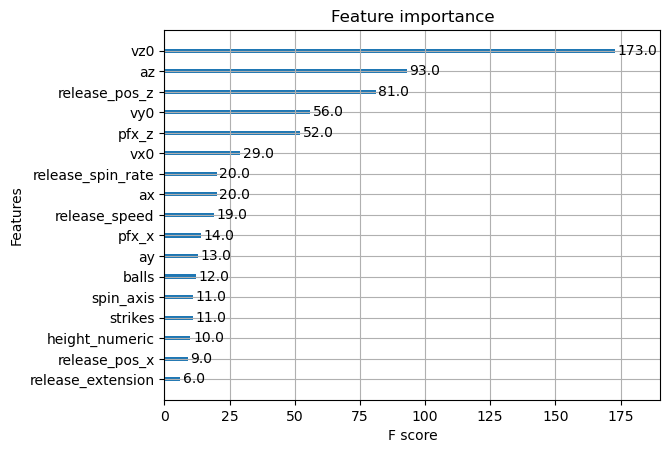

In [18]:
xgb.plot_importance(model)
plt.show()

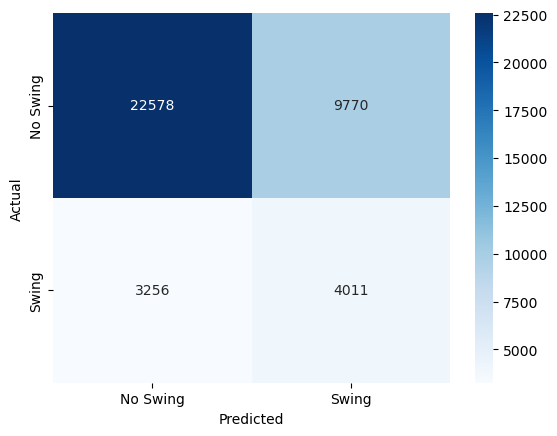

In [19]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [20]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [21]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 16:06:12,913] A new study created in memory with name: no-name-3e037ffe-96a3-412e-97d9-aa499c390194


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65384
[5]	eval-logloss:0.64917
[6]	eval-logloss:0.64543
[7]	eval-logloss:0.64224
[8]	eval-logloss:0.63938
[9]	eval-logloss:0.63750
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63405
[12]	eval-logloss:0.63269
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62765
[16]	eval-logloss:0.62692
[17]	eval-logloss:0.62576
[18]	eval-logloss:0.62464
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62342
[21]	eval-logloss:0.62314
[22]	eval-logloss:0.62271
[23]	eval-logloss:0.62194
[24]	eval-logloss:0.62119
[25]	eval-logloss:0.62094
[26]	eval-logloss:0.62019
[27]	eval-logloss:0.61978
[28]	eval-logloss:0.61898
[29]	eval-logloss:0.61855
[30]	eval-logloss:0.61783
[31]	eval-logloss:0.61745
[32]	eval-logloss:0.61649
[33]	eval-logloss:0.61603
[34]	eval-logloss:0.61583
[35]	eval-logloss:0.61535
[36]	eval-logloss:0.61520
[37]	eval-logloss:0.61430
[38]	eval-logloss:0.61

[I 2023-11-09 16:06:14,807] Trial 0 finished with value: 0.5929543388599882 and parameters: {'max_depth': 7, 'eta': 0.1450432113525737, 'subsample': 0.7596950529212899, 'colsample_bytree': 0.9032119505092716}. Best is trial 0 with value: 0.5929543388599882.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68460
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67355
[5]	eval-logloss:0.67049
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66213
[9]	eval-logloss:0.65988
[10]	eval-logloss:0.65788
[11]	eval-logloss:0.65587
[12]	eval-logloss:0.65405
[13]	eval-logloss:0.65231
[14]	eval-logloss:0.65053
[15]	eval-logloss:0.64895
[16]	eval-logloss:0.64775
[17]	eval-logloss:0.64641
[18]	eval-logloss:0.64482
[19]	eval-logloss:0.64366
[20]	eval-logloss:0.64263
[21]	eval-logloss:0.64181
[22]	eval-logloss:0.64078
[23]	eval-logloss:0.63962
[24]	eval-logloss:0.63864
[25]	eval-logloss:0.63789
[26]	eval-logloss:0.63706
[27]	eval-logloss:0.63629
[28]	eval-logloss:0.63547
[29]	eval-logloss:0.63484
[30]	eval-logloss:0.63413
[31]	eval-logloss:0.63358
[32]	eval-logloss:0.63271
[33]	eval-logloss:0.63195
[34]	eval-logloss:0.63121
[35]	eval-logloss:0.63076
[36]	eval-logloss:0.63021
[37]	eval-logloss:0.62959
[38]	eval-logloss:0.62

[I 2023-11-09 16:06:17,091] Trial 1 finished with value: 0.6108327744897865 and parameters: {'max_depth': 7, 'eta': 0.054306892595564524, 'subsample': 0.7829953532384236, 'colsample_bytree': 0.9549587456592535}. Best is trial 1 with value: 0.6108327744897865.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64308
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.63603
[9]	eval-logloss:0.63264
[10]	eval-logloss:0.62983
[11]	eval-logloss:0.62782
[12]	eval-logloss:0.62555
[13]	eval-logloss:0.62377
[14]	eval-logloss:0.62192
[15]	eval-logloss:0.62040
[16]	eval-logloss:0.61984
[17]	eval-logloss:0.61781
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61387
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.61178
[24]	eval-logloss:0.61029
[25]	eval-logloss:0.61028
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60881
[28]	eval-logloss:0.60770
[29]	eval-logloss:0.60739
[30]	eval-logloss:0.60674
[31]	eval-logloss:0.60577
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60348
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60255
[38]	eval-logloss:0.60

[I 2023-11-09 16:06:19,286] Trial 2 finished with value: 0.5794672567670909 and parameters: {'max_depth': 8, 'eta': 0.15831493171504818, 'subsample': 0.7098449914955538, 'colsample_bytree': 0.7043817885680987}. Best is trial 1 with value: 0.6108327744897865.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.66996
[4]	eval-logloss:0.66604
[5]	eval-logloss:0.66244
[6]	eval-logloss:0.65975
[7]	eval-logloss:0.65690
[8]	eval-logloss:0.65446
[9]	eval-logloss:0.65216
[10]	eval-logloss:0.65037
[11]	eval-logloss:0.64870
[12]	eval-logloss:0.64735
[13]	eval-logloss:0.64613
[14]	eval-logloss:0.64435
[15]	eval-logloss:0.64337
[16]	eval-logloss:0.64270
[17]	eval-logloss:0.64154
[18]	eval-logloss:0.64010
[19]	eval-logloss:0.63906
[20]	eval-logloss:0.63854
[21]	eval-logloss:0.63842
[22]	eval-logloss:0.63748
[23]	eval-logloss:0.63641
[24]	eval-logloss:0.63509
[25]	eval-logloss:0.63489
[26]	eval-logloss:0.63427
[27]	eval-logloss:0.63369
[28]	eval-logloss:0.63330
[29]	eval-logloss:0.63288
[30]	eval-logloss:0.63265
[31]	eval-logloss:0.63206
[32]	eval-logloss:0.63109
[33]	eval-logloss:0.63040
[34]	eval-logloss:0.62999
[35]	eval-logloss:0.62973
[36]	eval-logloss:0.62943
[37]	eval-logloss:0.62889
[38]	eval-logloss:0.62

[I 2023-11-09 16:06:20,891] Trial 3 finished with value: 0.612619702840862 and parameters: {'max_depth': 6, 'eta': 0.096522182186221, 'subsample': 0.7400577539480411, 'colsample_bytree': 0.7515442279791564}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66141
[5]	eval-logloss:0.65750
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.65105
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64502
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64195
[13]	eval-logloss:0.64069
[14]	eval-logloss:0.63945
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63725
[17]	eval-logloss:0.63571
[18]	eval-logloss:0.63445
[19]	eval-logloss:0.63357
[20]	eval-logloss:0.63253
[21]	eval-logloss:0.63200
[22]	eval-logloss:0.63064
[23]	eval-logloss:0.63037
[24]	eval-logloss:0.62922
[25]	eval-logloss:0.62866
[26]	eval-logloss:0.62793
[27]	eval-logloss:0.62739
[28]	eval-logloss:0.62721
[29]	eval-logloss:0.62685
[30]	eval-logloss:0.62616
[31]	eval-logloss:0.62535
[32]	eval-logloss:0.62477
[33]	eval-logloss:0.62391
[34]	eval-logloss:0.62375
[35]	eval-logloss:0.62368
[36]	eval-logloss:0.62332
[37]	eval-logloss:0.62283
[38]	eval-logloss:0.62

[I 2023-11-09 16:06:22,488] Trial 4 finished with value: 0.6063680272635391 and parameters: {'max_depth': 6, 'eta': 0.12112759599088806, 'subsample': 0.6321579031555093, 'colsample_bytree': 0.8989499120960007}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.66282
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.65007
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63839
[7]	eval-logloss:0.63630
[8]	eval-logloss:0.63292
[9]	eval-logloss:0.63077
[10]	eval-logloss:0.62756
[11]	eval-logloss:0.62469
[12]	eval-logloss:0.62248
[13]	eval-logloss:0.62183
[14]	eval-logloss:0.61966
[15]	eval-logloss:0.61781
[16]	eval-logloss:0.61730
[17]	eval-logloss:0.61473
[18]	eval-logloss:0.61329
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.61116
[21]	eval-logloss:0.61129
[22]	eval-logloss:0.61073
[23]	eval-logloss:0.61050
[24]	eval-logloss:0.60915
[25]	eval-logloss:0.60929
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60792
[28]	eval-logloss:0.60740
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60627
[31]	eval-logloss:0.60563
[32]	eval-logloss:0.60470
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60350
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60268
[37]	eval-logloss:0.60219
[38]	eval-logloss:0.60

[I 2023-11-09 16:06:24,309] Trial 5 finished with value: 0.5772055353295327 and parameters: {'max_depth': 8, 'eta': 0.18920071421113707, 'subsample': 0.7242176215526386, 'colsample_bytree': 0.6008078712139646}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.66068
[2]	eval-logloss:0.64848
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63395
[5]	eval-logloss:0.62908
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61653
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61357
[12]	eval-logloss:0.61207
[13]	eval-logloss:0.61054
[14]	eval-logloss:0.60792
[15]	eval-logloss:0.60605
[16]	eval-logloss:0.60557
[17]	eval-logloss:0.60342
[18]	eval-logloss:0.60258
[19]	eval-logloss:0.60126
[20]	eval-logloss:0.60106
[21]	eval-logloss:0.60091
[22]	eval-logloss:0.59926
[23]	eval-logloss:0.59891
[24]	eval-logloss:0.59705
[25]	eval-logloss:0.59743
[26]	eval-logloss:0.59601
[27]	eval-logloss:0.59496
[28]	eval-logloss:0.59475
[29]	eval-logloss:0.59481
[30]	eval-logloss:0.59438
[31]	eval-logloss:0.59354
[32]	eval-logloss:0.59341
[33]	eval-logloss:0.59322
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59268
[36]	eval-logloss:0.59188
[37]	eval-logloss:0.59103
[38]	eval-logloss:0.59

[I 2023-11-09 16:06:26,560] Trial 6 finished with value: 0.5620499330969747 and parameters: {'max_depth': 9, 'eta': 0.19409593961194166, 'subsample': 0.6072257313402892, 'colsample_bytree': 0.8822208654316043}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65842
[3]	eval-logloss:0.65204
[4]	eval-logloss:0.64792
[5]	eval-logloss:0.64397
[6]	eval-logloss:0.64205
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63821
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63532
[11]	eval-logloss:0.63421
[12]	eval-logloss:0.63271
[13]	eval-logloss:0.63200
[14]	eval-logloss:0.63049
[15]	eval-logloss:0.62903
[16]	eval-logloss:0.62861
[17]	eval-logloss:0.62603
[18]	eval-logloss:0.62527
[19]	eval-logloss:0.62516
[20]	eval-logloss:0.62476
[21]	eval-logloss:0.62472
[22]	eval-logloss:0.62291
[23]	eval-logloss:0.62300
[24]	eval-logloss:0.62158
[25]	eval-logloss:0.62156
[26]	eval-logloss:0.62068
[27]	eval-logloss:0.62021
[28]	eval-logloss:0.61958
[29]	eval-logloss:0.61980
[30]	eval-logloss:0.61905
[31]	eval-logloss:0.61793
[32]	eval-logloss:0.61768
[33]	eval-logloss:0.61730
[34]	eval-logloss:0.61718
[35]	eval-logloss:0.61732
[36]	eval-logloss:0.61696
[37]	eval-logloss:0.61637
[38]	eval-logloss:0.61

[I 2023-11-09 16:06:28,301] Trial 7 finished with value: 0.6005689670608348 and parameters: {'max_depth': 6, 'eta': 0.24159379034144035, 'subsample': 0.6226984187000484, 'colsample_bytree': 0.9729149554518677}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63938
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.63184
[7]	eval-logloss:0.62910
[8]	eval-logloss:0.62674
[9]	eval-logloss:0.62441
[10]	eval-logloss:0.62300
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.62037
[13]	eval-logloss:0.61917
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61484
[17]	eval-logloss:0.61348
[18]	eval-logloss:0.61262
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61089
[21]	eval-logloss:0.61069
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60673
[28]	eval-logloss:0.60581
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60428
[31]	eval-logloss:0.60327
[32]	eval-logloss:0.60287
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60153
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60046
[38]	eval-logloss:0.60

[I 2023-11-09 16:06:30,349] Trial 8 finished with value: 0.5769953607883989 and parameters: {'max_depth': 8, 'eta': 0.19381324422249535, 'subsample': 0.701143425891146, 'colsample_bytree': 0.8200142224090207}. Best is trial 3 with value: 0.612619702840862.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68326
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67577
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.66798
[13]	eval-logloss:0.66735
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66505
[16]	eval-logloss:0.66393
[17]	eval-logloss:0.66159
[18]	eval-logloss:0.65938
[19]	eval-logloss:0.65753
[20]	eval-logloss:0.65693
[21]	eval-logloss:0.65660
[22]	eval-logloss:0.65480
[23]	eval-logloss:0.65440
[24]	eval-logloss:0.65267
[25]	eval-logloss:0.65244
[26]	eval-logloss:0.65107
[27]	eval-logloss:0.64968
[28]	eval-logloss:0.64945
[29]	eval-logloss:0.64917
[30]	eval-logloss:0.64877
[31]	eval-logloss:0.64784
[32]	eval-logloss:0.64667
[33]	eval-logloss:0.64627
[34]	eval-logloss:0.64500
[35]	eval-logloss:0.64457
[36]	eval-logloss:0.64427
[37]	eval-logloss:0.64386
[38]	eval-logloss:0.64

[I 2023-11-09 16:06:32,174] Trial 9 finished with value: 0.6198278637469637 and parameters: {'max_depth': 7, 'eta': 0.04407268517621093, 'subsample': 0.6469367326878728, 'colsample_bytree': 0.5153287597735772}. Best is trial 9 with value: 0.6198278637469637.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69185
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69072
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69049
[10]	eval-logloss:0.69005
[11]	eval-logloss:0.68957
[12]	eval-logloss:0.68909
[13]	eval-logloss:0.68895
[14]	eval-logloss:0.68870
[15]	eval-logloss:0.68855
[16]	eval-logloss:0.68830
[17]	eval-logloss:0.68783
[18]	eval-logloss:0.68742
[19]	eval-logloss:0.68699
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68672
[22]	eval-logloss:0.68629
[23]	eval-logloss:0.68616
[24]	eval-logloss:0.68574
[25]	eval-logloss:0.68563
[26]	eval-logloss:0.68524
[27]	eval-logloss:0.68484
[28]	eval-logloss:0.68473
[29]	eval-logloss:0.68460
[30]	eval-logloss:0.68448
[31]	eval-logloss:0.68427
[32]	eval-logloss:0.68389
[33]	eval-logloss:0.68376
[34]	eval-logloss:0.68340
[35]	eval-logloss:0.68328
[36]	eval-logloss:0.68316
[37]	eval-logloss:0.68305
[38]	eval-logloss:0.68

[I 2023-11-09 16:06:33,488] Trial 10 finished with value: 0.671928629239916 and parameters: {'max_depth': 3, 'eta': 0.012019298673978572, 'subsample': 0.8978409519888109, 'colsample_bytree': 0.5025879138637517}. Best is trial 10 with value: 0.671928629239916.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68899
[14]	eval-logloss:0.68874
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68833
[17]	eval-logloss:0.68787
[18]	eval-logloss:0.68747
[19]	eval-logloss:0.68704
[20]	eval-logloss:0.68691
[21]	eval-logloss:0.68677
[22]	eval-logloss:0.68634
[23]	eval-logloss:0.68621
[24]	eval-logloss:0.68579
[25]	eval-logloss:0.68568
[26]	eval-logloss:0.68530
[27]	eval-logloss:0.68490
[28]	eval-logloss:0.68478
[29]	eval-logloss:0.68466
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68434
[32]	eval-logloss:0.68395
[33]	eval-logloss:0.68384
[34]	eval-logloss:0.68348
[35]	eval-logloss:0.68336
[36]	eval-logloss:0.68325
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68

[I 2023-11-09 16:06:34,679] Trial 11 finished with value: 0.6719706237211289 and parameters: {'max_depth': 3, 'eta': 0.011915619467106675, 'subsample': 0.8876014821053554, 'colsample_bytree': 0.5048696878479086}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68978
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68934
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68784
[12]	eval-logloss:0.68714
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68658
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68601
[17]	eval-logloss:0.68535
[18]	eval-logloss:0.68477
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68399
[21]	eval-logloss:0.68381
[22]	eval-logloss:0.68314
[23]	eval-logloss:0.68296
[24]	eval-logloss:0.68238
[25]	eval-logloss:0.68225
[26]	eval-logloss:0.68165
[27]	eval-logloss:0.68111
[28]	eval-logloss:0.68096
[29]	eval-logloss:0.68082
[30]	eval-logloss:0.68066
[31]	eval-logloss:0.68037
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67963
[34]	eval-logloss:0.67916
[35]	eval-logloss:0.67900
[36]	eval-logloss:0.67885
[37]	eval-logloss:0.67869
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:36,158] Trial 12 finished with value: 0.6653852947547522 and parameters: {'max_depth': 3, 'eta': 0.018369040080134527, 'subsample': 0.8994969468679814, 'colsample_bytree': 0.5060058395255078}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69055
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.69009
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68948
[11]	eval-logloss:0.68899
[12]	eval-logloss:0.68851
[13]	eval-logloss:0.68836
[14]	eval-logloss:0.68812
[15]	eval-logloss:0.68797
[16]	eval-logloss:0.68772
[17]	eval-logloss:0.68726
[18]	eval-logloss:0.68688
[19]	eval-logloss:0.68645
[20]	eval-logloss:0.68631
[21]	eval-logloss:0.68617
[22]	eval-logloss:0.68580
[23]	eval-logloss:0.68567
[24]	eval-logloss:0.68525
[25]	eval-logloss:0.68514
[26]	eval-logloss:0.68475
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68424
[29]	eval-logloss:0.68411
[30]	eval-logloss:0.68399
[31]	eval-logloss:0.68379
[32]	eval-logloss:0.68342
[33]	eval-logloss:0.68330
[34]	eval-logloss:0.68290
[35]	eval-logloss:0.68277
[36]	eval-logloss:0.68265
[37]	eval-logloss:0.68254
[38]	eval-logloss:0.68

[I 2023-11-09 16:06:37,435] Trial 13 finished with value: 0.6708578373236783 and parameters: {'max_depth': 3, 'eta': 0.012143277676155714, 'subsample': 0.899436380930415, 'colsample_bytree': 0.5946751415333454}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67611
[7]	eval-logloss:0.67529
[8]	eval-logloss:0.67373
[9]	eval-logloss:0.67246
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.66865
[12]	eval-logloss:0.66664
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66512
[15]	eval-logloss:0.66468
[16]	eval-logloss:0.66402
[17]	eval-logloss:0.66237
[18]	eval-logloss:0.66076
[19]	eval-logloss:0.65930
[20]	eval-logloss:0.65885
[21]	eval-logloss:0.65858
[22]	eval-logloss:0.65737
[23]	eval-logloss:0.65696
[24]	eval-logloss:0.65576
[25]	eval-logloss:0.65565
[26]	eval-logloss:0.65445
[27]	eval-logloss:0.65333
[28]	eval-logloss:0.65304
[29]	eval-logloss:0.65282
[30]	eval-logloss:0.65252
[31]	eval-logloss:0.65189
[32]	eval-logloss:0.65085
[33]	eval-logloss:0.65055
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.64956
[36]	eval-logloss:0.64947
[37]	eval-logloss:0.64925
[38]	eval-logloss:0.64

[I 2023-11-09 16:06:38,748] Trial 14 finished with value: 0.6343130439021051 and parameters: {'max_depth': 4, 'eta': 0.07448362581977595, 'subsample': 0.8477490153891923, 'colsample_bytree': 0.5866270907772128}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67703
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67569
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.66998
[12]	eval-logloss:0.66748
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66577
[15]	eval-logloss:0.66539
[16]	eval-logloss:0.66448
[17]	eval-logloss:0.66218
[18]	eval-logloss:0.66041
[19]	eval-logloss:0.65895
[20]	eval-logloss:0.65852
[21]	eval-logloss:0.65833
[22]	eval-logloss:0.65704
[23]	eval-logloss:0.65667
[24]	eval-logloss:0.65536
[25]	eval-logloss:0.65526
[26]	eval-logloss:0.65434
[27]	eval-logloss:0.65317
[28]	eval-logloss:0.65293
[29]	eval-logloss:0.65272
[30]	eval-logloss:0.65250
[31]	eval-logloss:0.65178
[32]	eval-logloss:0.65058
[33]	eval-logloss:0.65024
[34]	eval-logloss:0.64937
[35]	eval-logloss:0.64899
[36]	eval-logloss:0.64894
[37]	eval-logloss:0.64874
[38]	eval-logloss:0.64

[I 2023-11-09 16:06:40,292] Trial 15 finished with value: 0.6332666139711488 and parameters: {'max_depth': 4, 'eta': 0.0811052160350311, 'subsample': 0.8456040094557147, 'colsample_bytree': 0.5038284595106497}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67860
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67433
[14]	eval-logloss:0.67301
[15]	eval-logloss:0.67266
[16]	eval-logloss:0.67202
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66936
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66796
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66678
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66550
[25]	eval-logloss:0.66529
[26]	eval-logloss:0.66434
[27]	eval-logloss:0.66340
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66287
[30]	eval-logloss:0.66262
[31]	eval-logloss:0.66214
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66039
[34]	eval-logloss:0.65968
[35]	eval-logloss:0.65944
[36]	eval-logloss:0.65927
[37]	eval-logloss:0.65903
[38]	eval-logloss:0.65

[I 2023-11-09 16:06:41,648] Trial 16 finished with value: 0.6415285708649386 and parameters: {'max_depth': 4, 'eta': 0.04047512088651748, 'subsample': 0.8522124240893783, 'colsample_bytree': 0.6629578359217718}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68639
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68211
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67849
[20]	eval-logloss:0.67822
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67520
[27]	eval-logloss:0.67447
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67390
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67240
[34]	eval-logloss:0.67158
[35]	eval-logloss:0.67135
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67100
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:43,283] Trial 17 finished with value: 0.6517204897372236 and parameters: {'max_depth': 5, 'eta': 0.01865826859029881, 'subsample': 0.8123291203536527, 'colsample_bytree': 0.569125552824886}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67588
[8]	eval-logloss:0.67372
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67096
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66746
[13]	eval-logloss:0.66637
[14]	eval-logloss:0.66495
[15]	eval-logloss:0.66441
[16]	eval-logloss:0.66399
[17]	eval-logloss:0.66262
[18]	eval-logloss:0.66178
[19]	eval-logloss:0.66128
[20]	eval-logloss:0.66096
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.65916
[23]	eval-logloss:0.65867
[24]	eval-logloss:0.65809
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65674
[27]	eval-logloss:0.65610
[28]	eval-logloss:0.65579
[29]	eval-logloss:0.65560
[30]	eval-logloss:0.65532
[31]	eval-logloss:0.65478
[32]	eval-logloss:0.65450
[33]	eval-logloss:0.65374
[34]	eval-logloss:0.65278
[35]	eval-logloss:0.65249
[36]	eval-logloss:0.65239
[37]	eval-logloss:0.65212
[38]	eval-logloss:0.65

[I 2023-11-09 16:06:44,547] Trial 18 finished with value: 0.6390247090433796 and parameters: {'max_depth': 3, 'eta': 0.10016006295205346, 'subsample': 0.8893435163527145, 'colsample_bytree': 0.6498538349018583}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67458
[11]	eval-logloss:0.67201
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66640
[17]	eval-logloss:0.66433
[18]	eval-logloss:0.66254
[19]	eval-logloss:0.66103
[20]	eval-logloss:0.66057
[21]	eval-logloss:0.66027
[22]	eval-logloss:0.65868
[23]	eval-logloss:0.65830
[24]	eval-logloss:0.65687
[25]	eval-logloss:0.65673
[26]	eval-logloss:0.65538
[27]	eval-logloss:0.65419
[28]	eval-logloss:0.65390
[29]	eval-logloss:0.65364
[30]	eval-logloss:0.65337
[31]	eval-logloss:0.65256
[32]	eval-logloss:0.65137
[33]	eval-logloss:0.65111
[34]	eval-logloss:0.64991
[35]	eval-logloss:0.64963
[36]	eval-logloss:0.64945
[37]	eval-logloss:0.64921
[38]	eval-logloss:0.64

[I 2023-11-09 16:06:45,945] Trial 19 finished with value: 0.6302849121924241 and parameters: {'max_depth': 5, 'eta': 0.05851487278061319, 'subsample': 0.8719852842245231, 'colsample_bytree': 0.5529919150873246}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69079
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68859
[9]	eval-logloss:0.68826
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68701
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68511
[15]	eval-logloss:0.68491
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68388
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68261
[20]	eval-logloss:0.68241
[21]	eval-logloss:0.68223
[22]	eval-logloss:0.68165
[23]	eval-logloss:0.68147
[24]	eval-logloss:0.68089
[25]	eval-logloss:0.68074
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.67939
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67891
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67688
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:47,535] Trial 20 finished with value: 0.659648422783363 and parameters: {'max_depth': 5, 'eta': 0.011629860751452455, 'subsample': 0.8161960786055925, 'colsample_bytree': 0.6313591813243552}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69125
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.68991
[11]	eval-logloss:0.68940
[12]	eval-logloss:0.68890
[13]	eval-logloss:0.68876
[14]	eval-logloss:0.68850
[15]	eval-logloss:0.68834
[16]	eval-logloss:0.68807
[17]	eval-logloss:0.68758
[18]	eval-logloss:0.68716
[19]	eval-logloss:0.68671
[20]	eval-logloss:0.68657
[21]	eval-logloss:0.68642
[22]	eval-logloss:0.68597
[23]	eval-logloss:0.68584
[24]	eval-logloss:0.68540
[25]	eval-logloss:0.68529
[26]	eval-logloss:0.68489
[27]	eval-logloss:0.68448
[28]	eval-logloss:0.68435
[29]	eval-logloss:0.68422
[30]	eval-logloss:0.68410
[31]	eval-logloss:0.68388
[32]	eval-logloss:0.68349
[33]	eval-logloss:0.68336
[34]	eval-logloss:0.68299
[35]	eval-logloss:0.68286
[36]	eval-logloss:0.68274
[37]	eval-logloss:0.68262
[38]	eval-logloss:0.68

[I 2023-11-09 16:06:48,899] Trial 21 finished with value: 0.6711209409900699 and parameters: {'max_depth': 3, 'eta': 0.012645061938768042, 'subsample': 0.8996892241749118, 'colsample_bytree': 0.5468445382956686}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68054
[16]	eval-logloss:0.67999
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67775
[19]	eval-logloss:0.67677
[20]	eval-logloss:0.67652
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67524
[23]	eval-logloss:0.67498
[24]	eval-logloss:0.67409
[25]	eval-logloss:0.67395
[26]	eval-logloss:0.67308
[27]	eval-logloss:0.67249
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67212
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67150
[32]	eval-logloss:0.67066
[33]	eval-logloss:0.67043
[34]	eval-logloss:0.66980
[35]	eval-logloss:0.66960
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.66927
[38]	eval-logloss:0.66

[I 2023-11-09 16:06:50,249] Trial 22 finished with value: 0.6539420154281985 and parameters: {'max_depth': 3, 'eta': 0.037645530940578154, 'subsample': 0.8706432206409217, 'colsample_bytree': 0.5361618710360081}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.67946
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67782
[10]	eval-logloss:0.67540
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66798
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66307
[20]	eval-logloss:0.66268
[21]	eval-logloss:0.66242
[22]	eval-logloss:0.66104
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.65914
[25]	eval-logloss:0.65901
[26]	eval-logloss:0.65774
[27]	eval-logloss:0.65656
[28]	eval-logloss:0.65631
[29]	eval-logloss:0.65608
[30]	eval-logloss:0.65581
[31]	eval-logloss:0.65514
[32]	eval-logloss:0.65399
[33]	eval-logloss:0.65370
[34]	eval-logloss:0.65297
[35]	eval-logloss:0.65273
[36]	eval-logloss:0.65261
[37]	eval-logloss:0.65239
[38]	eval-logloss:0.65

[I 2023-11-09 16:06:51,511] Trial 23 finished with value: 0.6357919072497087 and parameters: {'max_depth': 4, 'eta': 0.06713256569252046, 'subsample': 0.8715775908965505, 'colsample_bytree': 0.5482621524219702}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68733
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67835
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67590
[25]	eval-logloss:0.67572
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67423
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67387
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67326
[32]	eval-logloss:0.67240
[33]	eval-logloss:0.67216
[34]	eval-logloss:0.67148
[35]	eval-logloss:0.67133
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67103
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:52,916] Trial 24 finished with value: 0.6560261467123484 and parameters: {'max_depth': 3, 'eta': 0.03349128463017437, 'subsample': 0.8241830236256428, 'colsample_bytree': 0.5420549725800291}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68642
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68187
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68084
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67437
[14]	eval-logloss:0.67333
[15]	eval-logloss:0.67291
[16]	eval-logloss:0.67207
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66718
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66649
[22]	eval-logloss:0.66512
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66362
[25]	eval-logloss:0.66346
[26]	eval-logloss:0.66225
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66073
[30]	eval-logloss:0.66047
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.65893
[33]	eval-logloss:0.65863
[34]	eval-logloss:0.65765
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65

[I 2023-11-09 16:06:54,575] Trial 25 finished with value: 0.6395261783623788 and parameters: {'max_depth': 4, 'eta': 0.05338867600467239, 'subsample': 0.8984177171163985, 'colsample_bytree': 0.5071667422584744}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68023
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67866
[19]	eval-logloss:0.67784
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67642
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67556
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67412
[29]	eval-logloss:0.67393
[30]	eval-logloss:0.67373
[31]	eval-logloss:0.67338
[32]	eval-logloss:0.67284
[33]	eval-logloss:0.67216
[34]	eval-logloss:0.67168
[35]	eval-logloss:0.67152
[36]	eval-logloss:0.67137
[37]	eval-logloss:0.67118
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:55,816] Trial 26 finished with value: 0.6553663900232367 and parameters: {'max_depth': 3, 'eta': 0.029565180171412946, 'subsample': 0.8738290787539041, 'colsample_bytree': 0.6172043277948933}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68972
[7]	eval-logloss:0.68951
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68881
[10]	eval-logloss:0.68827
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68701
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68646
[15]	eval-logloss:0.68627
[16]	eval-logloss:0.68594
[17]	eval-logloss:0.68528
[18]	eval-logloss:0.68472
[19]	eval-logloss:0.68411
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68376
[22]	eval-logloss:0.68319
[23]	eval-logloss:0.68301
[24]	eval-logloss:0.68246
[25]	eval-logloss:0.68230
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68128
[28]	eval-logloss:0.68115
[29]	eval-logloss:0.68099
[30]	eval-logloss:0.68084
[31]	eval-logloss:0.68055
[32]	eval-logloss:0.68000
[33]	eval-logloss:0.67983
[34]	eval-logloss:0.67926
[35]	eval-logloss:0.67908
[36]	eval-logloss:0.67894
[37]	eval-logloss:0.67880
[38]	eval-logloss:0.67

[I 2023-11-09 16:06:57,235] Trial 27 finished with value: 0.6632440425104309 and parameters: {'max_depth': 5, 'eta': 0.010819699141780242, 'subsample': 0.8373846546657345, 'colsample_bytree': 0.57221662618005}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.67909
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67510
[8]	eval-logloss:0.67447
[9]	eval-logloss:0.67401
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66633
[13]	eval-logloss:0.66606
[14]	eval-logloss:0.66460
[15]	eval-logloss:0.66410
[16]	eval-logloss:0.66330
[17]	eval-logloss:0.66107
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65790
[20]	eval-logloss:0.65740
[21]	eval-logloss:0.65718
[22]	eval-logloss:0.65581
[23]	eval-logloss:0.65544
[24]	eval-logloss:0.65428
[25]	eval-logloss:0.65422
[26]	eval-logloss:0.65327
[27]	eval-logloss:0.65207
[28]	eval-logloss:0.65171
[29]	eval-logloss:0.65163
[30]	eval-logloss:0.65147
[31]	eval-logloss:0.65081
[32]	eval-logloss:0.64955
[33]	eval-logloss:0.64917
[34]	eval-logloss:0.64831
[35]	eval-logloss:0.64801
[36]	eval-logloss:0.64800
[37]	eval-logloss:0.64780
[38]	eval-logloss:0.64

[I 2023-11-09 16:06:58,697] Trial 28 finished with value: 0.6322749598124529 and parameters: {'max_depth': 4, 'eta': 0.08658772596447609, 'subsample': 0.7979636819085096, 'colsample_bytree': 0.5403769629804219}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68611
[4]	eval-logloss:0.68526
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67880
[10]	eval-logloss:0.67776
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67459
[13]	eval-logloss:0.67423
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67304
[16]	eval-logloss:0.67244
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.66995
[19]	eval-logloss:0.66874
[20]	eval-logloss:0.66844
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66603
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66507
[27]	eval-logloss:0.66434
[28]	eval-logloss:0.66410
[29]	eval-logloss:0.66391
[30]	eval-logloss:0.66362
[31]	eval-logloss:0.66309
[32]	eval-logloss:0.66245
[33]	eval-logloss:0.66218
[34]	eval-logloss:0.66128
[35]	eval-logloss:0.66107
[36]	eval-logloss:0.66095
[37]	eval-logloss:0.66072
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:00,544] Trial 29 finished with value: 0.6452450715609445 and parameters: {'max_depth': 3, 'eta': 0.06317847850307307, 'subsample': 0.8621179675845906, 'colsample_bytree': 0.576158092008209}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68351
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68066
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67777
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67478
[14]	eval-logloss:0.67370
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67274
[17]	eval-logloss:0.67134
[18]	eval-logloss:0.67024
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66735
[24]	eval-logloss:0.66648
[25]	eval-logloss:0.66626
[26]	eval-logloss:0.66527
[27]	eval-logloss:0.66464
[28]	eval-logloss:0.66442
[29]	eval-logloss:0.66418
[30]	eval-logloss:0.66391
[31]	eval-logloss:0.66343
[32]	eval-logloss:0.66240
[33]	eval-logloss:0.66155
[34]	eval-logloss:0.66090
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66025
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:01,872] Trial 30 finished with value: 0.6423383930900687 and parameters: {'max_depth': 4, 'eta': 0.03880751222655691, 'subsample': 0.8333200505517238, 'colsample_bytree': 0.6139133278295689}. Best is trial 11 with value: 0.6719706237211289.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69164
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69015
[10]	eval-logloss:0.68979
[11]	eval-logloss:0.68933
[12]	eval-logloss:0.68890
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68841
[16]	eval-logloss:0.68819
[17]	eval-logloss:0.68777
[18]	eval-logloss:0.68739
[19]	eval-logloss:0.68699
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68627
[24]	eval-logloss:0.68587
[25]	eval-logloss:0.68577
[26]	eval-logloss:0.68541
[27]	eval-logloss:0.68511
[28]	eval-logloss:0.68500
[29]	eval-logloss:0.68490
[30]	eval-logloss:0.68478
[31]	eval-logloss:0.68460
[32]	eval-logloss:0.68424
[33]	eval-logloss:0.68414
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68364
[36]	eval-logloss:0.68353
[37]	eval-logloss:0.68342
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:03,092] Trial 31 finished with value: 0.6721776260307839 and parameters: {'max_depth': 3, 'eta': 0.011037784935149397, 'subsample': 0.8866297691157067, 'colsample_bytree': 0.5907273920918247}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68723
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68357
[15]	eval-logloss:0.68329
[16]	eval-logloss:0.68283
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68097
[19]	eval-logloss:0.68008
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67756
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67605
[28]	eval-logloss:0.67587
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67553
[31]	eval-logloss:0.67514
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67340
[36]	eval-logloss:0.67325
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:04,272] Trial 32 finished with value: 0.6584044103580672 and parameters: {'max_depth': 3, 'eta': 0.028483699141636218, 'subsample': 0.8828676433915136, 'colsample_bytree': 0.5306327635124111}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68169
[9]	eval-logloss:0.68091
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.67820
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67583
[15]	eval-logloss:0.67544
[16]	eval-logloss:0.67489
[17]	eval-logloss:0.67370
[18]	eval-logloss:0.67260
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67115
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.67007
[23]	eval-logloss:0.66973
[24]	eval-logloss:0.66884
[25]	eval-logloss:0.66870
[26]	eval-logloss:0.66766
[27]	eval-logloss:0.66677
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66608
[31]	eval-logloss:0.66565
[32]	eval-logloss:0.66466
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66358
[35]	eval-logloss:0.66336
[36]	eval-logloss:0.66327
[37]	eval-logloss:0.66302
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:05,511] Trial 33 finished with value: 0.6477748742706476 and parameters: {'max_depth': 3, 'eta': 0.05288600429119594, 'subsample': 0.8571304326436858, 'colsample_bytree': 0.5658714933648109}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68549
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68126
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.67989
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67700
[19]	eval-logloss:0.67596
[20]	eval-logloss:0.67568
[21]	eval-logloss:0.67542
[22]	eval-logloss:0.67423
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67301
[25]	eval-logloss:0.67284
[26]	eval-logloss:0.67184
[27]	eval-logloss:0.67087
[28]	eval-logloss:0.67066
[29]	eval-logloss:0.67046
[30]	eval-logloss:0.67027
[31]	eval-logloss:0.66976
[32]	eval-logloss:0.66876
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66741
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66703
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:06,894] Trial 34 finished with value: 0.6490991686643213 and parameters: {'max_depth': 4, 'eta': 0.030980970131882238, 'subsample': 0.8881826899897282, 'colsample_bytree': 0.5004796340572292}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68544
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68236
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.68017
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67745
[11]	eval-logloss:0.67639
[12]	eval-logloss:0.67513
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67260
[15]	eval-logloss:0.67224
[16]	eval-logloss:0.67171
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66865
[20]	eval-logloss:0.66828
[21]	eval-logloss:0.66800
[22]	eval-logloss:0.66735
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66539
[27]	eval-logloss:0.66453
[28]	eval-logloss:0.66428
[29]	eval-logloss:0.66407
[30]	eval-logloss:0.66383
[31]	eval-logloss:0.66316
[32]	eval-logloss:0.66236
[33]	eval-logloss:0.66166
[34]	eval-logloss:0.66096
[35]	eval-logloss:0.66071
[36]	eval-logloss:0.66056
[37]	eval-logloss:0.66034
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:08,104] Trial 35 finished with value: 0.6463956114194267 and parameters: {'max_depth': 3, 'eta': 0.053532677079360096, 'subsample': 0.8762734578667275, 'colsample_bytree': 0.6826452368011586}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67540
[5]	eval-logloss:0.67142
[6]	eval-logloss:0.66790
[7]	eval-logloss:0.66684
[8]	eval-logloss:0.66478
[9]	eval-logloss:0.66308
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65776
[12]	eval-logloss:0.65570
[13]	eval-logloss:0.65508
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65290
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.64811
[19]	eval-logloss:0.64661
[20]	eval-logloss:0.64628
[21]	eval-logloss:0.64594
[22]	eval-logloss:0.64488
[23]	eval-logloss:0.64462
[24]	eval-logloss:0.64341
[25]	eval-logloss:0.64325
[26]	eval-logloss:0.64224
[27]	eval-logloss:0.64105
[28]	eval-logloss:0.64065
[29]	eval-logloss:0.64053
[30]	eval-logloss:0.64022
[31]	eval-logloss:0.63973
[32]	eval-logloss:0.63864
[33]	eval-logloss:0.63826
[34]	eval-logloss:0.63729
[35]	eval-logloss:0.63683
[36]	eval-logloss:0.63690
[37]	eval-logloss:0.63660
[38]	eval-logloss:0.63

[I 2023-11-09 16:07:09,510] Trial 36 finished with value: 0.6221761479389248 and parameters: {'max_depth': 5, 'eta': 0.09942600209277724, 'subsample': 0.7808607092009047, 'colsample_bytree': 0.592366038474275}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69118
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.69007
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68933
[9]	eval-logloss:0.68904
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68799
[12]	eval-logloss:0.68743
[13]	eval-logloss:0.68691
[14]	eval-logloss:0.68642
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68600
[17]	eval-logloss:0.68545
[18]	eval-logloss:0.68497
[19]	eval-logloss:0.68447
[20]	eval-logloss:0.68429
[21]	eval-logloss:0.68415
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68352
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68246
[27]	eval-logloss:0.68199
[28]	eval-logloss:0.68187
[29]	eval-logloss:0.68173
[30]	eval-logloss:0.68159
[31]	eval-logloss:0.68133
[32]	eval-logloss:0.68083
[33]	eval-logloss:0.68033
[34]	eval-logloss:0.67988
[35]	eval-logloss:0.67974
[36]	eval-logloss:0.67961
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:10,916] Trial 37 finished with value: 0.6648338962114939 and parameters: {'max_depth': 4, 'eta': 0.01135824980416539, 'subsample': 0.8564050682667076, 'colsample_bytree': 0.6382859284489606}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.67988
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67441
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67122
[7]	eval-logloss:0.66973
[8]	eval-logloss:0.66803
[9]	eval-logloss:0.66626
[10]	eval-logloss:0.66553
[11]	eval-logloss:0.66443
[12]	eval-logloss:0.66278
[13]	eval-logloss:0.66201
[14]	eval-logloss:0.66063
[15]	eval-logloss:0.66013
[16]	eval-logloss:0.65966
[17]	eval-logloss:0.65880
[18]	eval-logloss:0.65769
[19]	eval-logloss:0.65742
[20]	eval-logloss:0.65689
[21]	eval-logloss:0.65663
[22]	eval-logloss:0.65605
[23]	eval-logloss:0.65553
[24]	eval-logloss:0.65478
[25]	eval-logloss:0.65473
[26]	eval-logloss:0.65427
[27]	eval-logloss:0.65349
[28]	eval-logloss:0.65327
[29]	eval-logloss:0.65309
[30]	eval-logloss:0.65282
[31]	eval-logloss:0.65238
[32]	eval-logloss:0.65185
[33]	eval-logloss:0.65149
[34]	eval-logloss:0.65081
[35]	eval-logloss:0.65044
[36]	eval-logloss:0.65032
[37]	eval-logloss:0.65002
[38]	eval-logloss:0.64

[I 2023-11-09 16:07:12,253] Trial 38 finished with value: 0.6366805848870503 and parameters: {'max_depth': 3, 'eta': 0.12304716033548158, 'subsample': 0.8863430949155716, 'colsample_bytree': 0.7247777024301629}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68036
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67387
[12]	eval-logloss:0.67174
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.66932
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66309
[19]	eval-logloss:0.66120
[20]	eval-logloss:0.66049
[21]	eval-logloss:0.65990
[22]	eval-logloss:0.65826
[23]	eval-logloss:0.65765
[24]	eval-logloss:0.65610
[25]	eval-logloss:0.65564
[26]	eval-logloss:0.65423
[27]	eval-logloss:0.65272
[28]	eval-logloss:0.65223
[29]	eval-logloss:0.65164
[30]	eval-logloss:0.65118
[31]	eval-logloss:0.65018
[32]	eval-logloss:0.64886
[33]	eval-logloss:0.64833
[34]	eval-logloss:0.64693
[35]	eval-logloss:0.64626
[36]	eval-logloss:0.64585
[37]	eval-logloss:0.64536
[38]	eval-logloss:0.64

[I 2023-11-09 16:07:14,990] Trial 39 finished with value: 0.6126621335797664 and parameters: {'max_depth': 9, 'eta': 0.027178106618806368, 'subsample': 0.836116678006742, 'colsample_bytree': 0.5305270156799138}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68240
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67638
[5]	eval-logloss:0.67237
[6]	eval-logloss:0.66905
[7]	eval-logloss:0.66793
[8]	eval-logloss:0.66562
[9]	eval-logloss:0.66379
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.65826
[12]	eval-logloss:0.65556
[13]	eval-logloss:0.65459
[14]	eval-logloss:0.65298
[15]	eval-logloss:0.65225
[16]	eval-logloss:0.65116
[17]	eval-logloss:0.64885
[18]	eval-logloss:0.64678
[19]	eval-logloss:0.64491
[20]	eval-logloss:0.64431
[21]	eval-logloss:0.64384
[22]	eval-logloss:0.64237
[23]	eval-logloss:0.64177
[24]	eval-logloss:0.64036
[25]	eval-logloss:0.64020
[26]	eval-logloss:0.63899
[27]	eval-logloss:0.63756
[28]	eval-logloss:0.63713
[29]	eval-logloss:0.63681
[30]	eval-logloss:0.63633
[31]	eval-logloss:0.63547
[32]	eval-logloss:0.63440
[33]	eval-logloss:0.63398
[34]	eval-logloss:0.63265
[35]	eval-logloss:0.63215
[36]	eval-logloss:0.63197
[37]	eval-logloss:0.63153
[38]	eval-logloss:0.63

[I 2023-11-09 16:07:17,017] Trial 40 finished with value: 0.6100495103417913 and parameters: {'max_depth': 7, 'eta': 0.06784142551036981, 'subsample': 0.8596477991210268, 'colsample_bytree': 0.6060159483005666}. Best is trial 31 with value: 0.6721776260307839.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69124
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69070
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69026
[10]	eval-logloss:0.68991
[11]	eval-logloss:0.68948
[12]	eval-logloss:0.68906
[13]	eval-logloss:0.68894
[14]	eval-logloss:0.68872
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68836
[17]	eval-logloss:0.68795
[18]	eval-logloss:0.68759
[19]	eval-logloss:0.68721
[20]	eval-logloss:0.68708
[21]	eval-logloss:0.68695
[22]	eval-logloss:0.68662
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68612
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68568
[27]	eval-logloss:0.68531
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68480
[32]	eval-logloss:0.68445
[33]	eval-logloss:0.68434
[34]	eval-logloss:0.68398
[35]	eval-logloss:0.68387
[36]	eval-logloss:0.68376
[37]	eval-logloss:0.68365
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:18,286] Trial 41 finished with value: 0.6727413679165758 and parameters: {'max_depth': 3, 'eta': 0.01062623964255336, 'subsample': 0.8967728703251349, 'colsample_bytree': 0.589497596671292}. Best is trial 41 with value: 0.6727413679165758.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68610
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68417
[14]	eval-logloss:0.68374
[15]	eval-logloss:0.68348
[16]	eval-logloss:0.68306
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67938
[24]	eval-logloss:0.67868
[25]	eval-logloss:0.67853
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67727
[28]	eval-logloss:0.67710
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67675
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67584
[33]	eval-logloss:0.67567
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67470
[37]	eval-logloss:0.67452
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:20,215] Trial 42 finished with value: 0.6596233918432322 and parameters: {'max_depth': 3, 'eta': 0.024716121224686756, 'subsample': 0.8996194463870815, 'colsample_bytree': 0.5659239544647283}. Best is trial 41 with value: 0.6727413679165758.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68780
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68639
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68519
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68475
[35]	eval-logloss:0.68465
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:22,096] Trial 43 finished with value: 0.6744285800870682 and parameters: {'max_depth': 3, 'eta': 0.010054617951407817, 'subsample': 0.8835210751051702, 'colsample_bytree': 0.5237622305831273}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68256
[9]	eval-logloss:0.68222
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67650
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67444
[17]	eval-logloss:0.67269
[18]	eval-logloss:0.67127
[19]	eval-logloss:0.66987
[20]	eval-logloss:0.66955
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66792
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66513
[27]	eval-logloss:0.66407
[28]	eval-logloss:0.66380
[29]	eval-logloss:0.66357
[30]	eval-logloss:0.66336
[31]	eval-logloss:0.66274
[32]	eval-logloss:0.66174
[33]	eval-logloss:0.66144
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66028
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.65988
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:24,106] Trial 44 finished with value: 0.6422889938984223 and parameters: {'max_depth': 4, 'eta': 0.04521641309808587, 'subsample': 0.8841966414653274, 'colsample_bytree': 0.5234742198335856}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69194
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68425
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.67969
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67806
[17]	eval-logloss:0.67664
[18]	eval-logloss:0.67555
[19]	eval-logloss:0.67447
[20]	eval-logloss:0.67420
[21]	eval-logloss:0.67396
[22]	eval-logloss:0.67282
[23]	eval-logloss:0.67254
[24]	eval-logloss:0.67154
[25]	eval-logloss:0.67141
[26]	eval-logloss:0.67045
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66928
[29]	eval-logloss:0.66908
[30]	eval-logloss:0.66885
[31]	eval-logloss:0.66840
[32]	eval-logloss:0.66751
[33]	eval-logloss:0.66728
[34]	eval-logloss:0.66661
[35]	eval-logloss:0.66643
[36]	eval-logloss:0.66627
[37]	eval-logloss:0.66606
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:25,836] Trial 45 finished with value: 0.6510626889790346 and parameters: {'max_depth': 3, 'eta': 0.0453742595594368, 'subsample': 0.8666307948086182, 'colsample_bytree': 0.5001420683171329}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68818
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68734
[10]	eval-logloss:0.68669
[11]	eval-logloss:0.68587
[12]	eval-logloss:0.68516
[13]	eval-logloss:0.68496
[14]	eval-logloss:0.68456
[15]	eval-logloss:0.68433
[16]	eval-logloss:0.68396
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68139
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.68061
[24]	eval-logloss:0.67993
[25]	eval-logloss:0.67979
[26]	eval-logloss:0.67912
[27]	eval-logloss:0.67851
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67800
[31]	eval-logloss:0.67768
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67682
[34]	eval-logloss:0.67626
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67579
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:27,501] Trial 46 finished with value: 0.6611640341044678 and parameters: {'max_depth': 3, 'eta': 0.02252327188739136, 'subsample': 0.8483199869264842, 'colsample_bytree': 0.5892000444768163}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68401
[6]	eval-logloss:0.68213
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68052
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67815
[11]	eval-logloss:0.67649
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67445
[14]	eval-logloss:0.67360
[15]	eval-logloss:0.67321
[16]	eval-logloss:0.67258
[17]	eval-logloss:0.67098
[18]	eval-logloss:0.66978
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66633
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66525
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66316
[29]	eval-logloss:0.66293
[30]	eval-logloss:0.66268
[31]	eval-logloss:0.66214
[32]	eval-logloss:0.66111
[33]	eval-logloss:0.66083
[34]	eval-logloss:0.65997
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65956
[37]	eval-logloss:0.65933
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:29,477] Trial 47 finished with value: 0.6421371611353621 and parameters: {'max_depth': 4, 'eta': 0.04407573555042999, 'subsample': 0.8797006447579165, 'colsample_bytree': 0.5567081434550073}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68841
[7]	eval-logloss:0.68806
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68575
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68460
[14]	eval-logloss:0.68411
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68242
[18]	eval-logloss:0.68164
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67929
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67841
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67661
[30]	eval-logloss:0.67643
[31]	eval-logloss:0.67607
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67425
[37]	eval-logloss:0.67406
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:31,256] Trial 48 finished with value: 0.6596127344885754 and parameters: {'max_depth': 3, 'eta': 0.02643163443545054, 'subsample': 0.8671612938180677, 'colsample_bytree': 0.5167608204065931}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.67944
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.66691
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.66139
[8]	eval-logloss:0.65770
[9]	eval-logloss:0.65551
[10]	eval-logloss:0.65256
[11]	eval-logloss:0.64955
[12]	eval-logloss:0.64670
[13]	eval-logloss:0.64392
[14]	eval-logloss:0.64162
[15]	eval-logloss:0.64074
[16]	eval-logloss:0.63935
[17]	eval-logloss:0.63728
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63364
[20]	eval-logloss:0.63286
[21]	eval-logloss:0.63217
[22]	eval-logloss:0.63066
[23]	eval-logloss:0.63000
[24]	eval-logloss:0.62886
[25]	eval-logloss:0.62842
[26]	eval-logloss:0.62736
[27]	eval-logloss:0.62622
[28]	eval-logloss:0.62534
[29]	eval-logloss:0.62481
[30]	eval-logloss:0.62421
[31]	eval-logloss:0.62336
[32]	eval-logloss:0.62233
[33]	eval-logloss:0.62110
[34]	eval-logloss:0.62001
[35]	eval-logloss:0.61937
[36]	eval-logloss:0.61902
[37]	eval-logloss:0.61846
[38]	eval-logloss:0.61

[I 2023-11-09 16:07:34,207] Trial 49 finished with value: 0.5944892189051518 and parameters: {'max_depth': 8, 'eta': 0.07551753012327955, 'subsample': 0.8878617806066866, 'colsample_bytree': 0.6172525031945137}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68642
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68505
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.67949
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67707
[21]	eval-logloss:0.67682
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67554
[24]	eval-logloss:0.67461
[25]	eval-logloss:0.67441
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67246
[29]	eval-logloss:0.67218
[30]	eval-logloss:0.67196
[31]	eval-logloss:0.67142
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.67025
[34]	eval-logloss:0.66940
[35]	eval-logloss:0.66910
[36]	eval-logloss:0.66889
[37]	eval-logloss:0.66865
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:36,610] Trial 50 finished with value: 0.6480717084278683 and parameters: {'max_depth': 6, 'eta': 0.018756776209635145, 'subsample': 0.8459513717991121, 'colsample_bytree': 0.5205489854820975}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69016
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68875
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68802
[14]	eval-logloss:0.68772
[15]	eval-logloss:0.68754
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68568
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68536
[22]	eval-logloss:0.68485
[23]	eval-logloss:0.68470
[24]	eval-logloss:0.68420
[25]	eval-logloss:0.68409
[26]	eval-logloss:0.68364
[27]	eval-logloss:0.68317
[28]	eval-logloss:0.68303
[29]	eval-logloss:0.68289
[30]	eval-logloss:0.68275
[31]	eval-logloss:0.68249
[32]	eval-logloss:0.68204
[33]	eval-logloss:0.68191
[34]	eval-logloss:0.68149
[35]	eval-logloss:0.68135
[36]	eval-logloss:0.68121
[37]	eval-logloss:0.68108
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:38,318] Trial 51 finished with value: 0.6687444071537583 and parameters: {'max_depth': 3, 'eta': 0.014929221513822699, 'subsample': 0.8957092230175461, 'colsample_bytree': 0.5524411247141242}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69089
[6]	eval-logloss:0.69046
[7]	eval-logloss:0.69027
[8]	eval-logloss:0.68998
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68884
[12]	eval-logloss:0.68836
[13]	eval-logloss:0.68823
[14]	eval-logloss:0.68797
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68758
[17]	eval-logloss:0.68710
[18]	eval-logloss:0.68668
[19]	eval-logloss:0.68624
[20]	eval-logloss:0.68609
[21]	eval-logloss:0.68595
[22]	eval-logloss:0.68556
[23]	eval-logloss:0.68542
[24]	eval-logloss:0.68498
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68448
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68395
[29]	eval-logloss:0.68383
[30]	eval-logloss:0.68370
[31]	eval-logloss:0.68351
[32]	eval-logloss:0.68311
[33]	eval-logloss:0.68300
[34]	eval-logloss:0.68258
[35]	eval-logloss:0.68246
[36]	eval-logloss:0.68234
[37]	eval-logloss:0.68222
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:40,072] Trial 52 finished with value: 0.6703652194040265 and parameters: {'max_depth': 3, 'eta': 0.012553188557048737, 'subsample': 0.8822153010759559, 'colsample_bytree': 0.5767758411961701}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69124
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.68990
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68887
[13]	eval-logloss:0.68873
[14]	eval-logloss:0.68846
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68804
[17]	eval-logloss:0.68753
[18]	eval-logloss:0.68709
[19]	eval-logloss:0.68661
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68632
[22]	eval-logloss:0.68585
[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68526
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68472
[27]	eval-logloss:0.68428
[28]	eval-logloss:0.68417
[29]	eval-logloss:0.68404
[30]	eval-logloss:0.68392
[31]	eval-logloss:0.68368
[32]	eval-logloss:0.68328
[33]	eval-logloss:0.68313
[34]	eval-logloss:0.68270
[35]	eval-logloss:0.68256
[36]	eval-logloss:0.68244
[37]	eval-logloss:0.68233
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:41,988] Trial 53 finished with value: 0.6700613408209497 and parameters: {'max_depth': 4, 'eta': 0.010034042267536108, 'subsample': 0.8987868202167805, 'colsample_bytree': 0.5297369446846361}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67990
[16]	eval-logloss:0.67940
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67733
[19]	eval-logloss:0.67654
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67601
[22]	eval-logloss:0.67524
[23]	eval-logloss:0.67498
[24]	eval-logloss:0.67418
[25]	eval-logloss:0.67404
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67237
[28]	eval-logloss:0.67218
[29]	eval-logloss:0.67198
[30]	eval-logloss:0.67178
[31]	eval-logloss:0.67139
[32]	eval-logloss:0.67082
[33]	eval-logloss:0.67058
[34]	eval-logloss:0.66983
[35]	eval-logloss:0.66963
[36]	eval-logloss:0.66949
[37]	eval-logloss:0.66931
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:43,586] Trial 54 finished with value: 0.6535289181221883 and parameters: {'max_depth': 3, 'eta': 0.03622089421341437, 'subsample': 0.8760486801749654, 'colsample_bytree': 0.5567227697317569}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68734
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68540
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68441
[14]	eval-logloss:0.68399
[15]	eval-logloss:0.68376
[16]	eval-logloss:0.68338
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68102
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68061
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67978
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67825
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67727
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67487
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:45,241] Trial 55 finished with value: 0.6599856736742237 and parameters: {'max_depth': 3, 'eta': 0.02414768411642701, 'subsample': 0.861796313335937, 'colsample_bytree': 0.5925276595659478}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68463
[6]	eval-logloss:0.68273
[7]	eval-logloss:0.68217
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68138
[10]	eval-logloss:0.67967
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67415
[16]	eval-logloss:0.67337
[17]	eval-logloss:0.67152
[18]	eval-logloss:0.67016
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66841
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66669
[23]	eval-logloss:0.66633
[24]	eval-logloss:0.66522
[25]	eval-logloss:0.66505
[26]	eval-logloss:0.66390
[27]	eval-logloss:0.66280
[28]	eval-logloss:0.66254
[29]	eval-logloss:0.66232
[30]	eval-logloss:0.66209
[31]	eval-logloss:0.66151
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.65929
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65867
[38]	eval-logloss:0.65

[I 2023-11-09 16:07:47,185] Trial 56 finished with value: 0.6407867022051454 and parameters: {'max_depth': 4, 'eta': 0.04892241878523435, 'subsample': 0.8899916320690474, 'colsample_bytree': 0.519661838298134}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68515
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67901
[19]	eval-logloss:0.67798
[20]	eval-logloss:0.67773
[21]	eval-logloss:0.67746
[22]	eval-logloss:0.67649
[23]	eval-logloss:0.67624
[24]	eval-logloss:0.67531
[25]	eval-logloss:0.67516
[26]	eval-logloss:0.67434
[27]	eval-logloss:0.67353
[28]	eval-logloss:0.67331
[29]	eval-logloss:0.67315
[30]	eval-logloss:0.67295
[31]	eval-logloss:0.67253
[32]	eval-logloss:0.67183
[33]	eval-logloss:0.67159
[34]	eval-logloss:0.67097
[35]	eval-logloss:0.67074
[36]	eval-logloss:0.67059
[37]	eval-logloss:0.67039
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:48,879] Trial 57 finished with value: 0.6554485156557588 and parameters: {'max_depth': 3, 'eta': 0.034216737862125216, 'subsample': 0.899199267306816, 'colsample_bytree': 0.5433251654055734}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68315
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68009
[11]	eval-logloss:0.67836
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67613
[14]	eval-logloss:0.67517
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67411
[17]	eval-logloss:0.67250
[18]	eval-logloss:0.67122
[19]	eval-logloss:0.67004
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66950
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66797
[24]	eval-logloss:0.66684
[25]	eval-logloss:0.66671
[26]	eval-logloss:0.66565
[27]	eval-logloss:0.66489
[28]	eval-logloss:0.66464
[29]	eval-logloss:0.66445
[30]	eval-logloss:0.66427
[31]	eval-logloss:0.66367
[32]	eval-logloss:0.66306
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66198
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66142
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:50,498] Trial 58 finished with value: 0.6462313316217366 and parameters: {'max_depth': 3, 'eta': 0.06173190835652236, 'subsample': 0.8749589718372541, 'colsample_bytree': 0.5146250102047227}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68753
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68363
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.67996
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67857
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67609
[29]	eval-logloss:0.67589
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67530
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67428
[34]	eval-logloss:0.67363
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67328
[37]	eval-logloss:0.67310
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:52,411] Trial 59 finished with value: 0.655940156584742 and parameters: {'max_depth': 4, 'eta': 0.020178703502458227, 'subsample': 0.8532599845487906, 'colsample_bytree': 0.5783315392489226}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68430
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68172
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67768
[19]	eval-logloss:0.67669
[20]	eval-logloss:0.67644
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67515
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67298
[27]	eval-logloss:0.67238
[28]	eval-logloss:0.67220
[29]	eval-logloss:0.67201
[30]	eval-logloss:0.67180
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.67031
[34]	eval-logloss:0.66969
[35]	eval-logloss:0.66951
[36]	eval-logloss:0.66936
[37]	eval-logloss:0.66917
[38]	eval-logloss:0.66

[I 2023-11-09 16:07:54,065] Trial 60 finished with value: 0.653782824383997 and parameters: {'max_depth': 3, 'eta': 0.03798074136961946, 'subsample': 0.869366429845741, 'colsample_bytree': 0.5526916224267716}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68898
[7]	eval-logloss:0.68869
[8]	eval-logloss:0.68827
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68659
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68570
[14]	eval-logloss:0.68534
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68475
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68280
[20]	eval-logloss:0.68261
[21]	eval-logloss:0.68241
[22]	eval-logloss:0.68186
[23]	eval-logloss:0.68167
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68030
[27]	eval-logloss:0.67980
[28]	eval-logloss:0.67964
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67902
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67834
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67760
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67

[I 2023-11-09 16:07:55,745] Trial 61 finished with value: 0.6631211093134086 and parameters: {'max_depth': 3, 'eta': 0.020012675301072036, 'subsample': 0.8939147286810867, 'colsample_bytree': 0.5943107812918156}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68956
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68922
[15]	eval-logloss:0.68910
[16]	eval-logloss:0.68887
[17]	eval-logloss:0.68846
[18]	eval-logloss:0.68809
[19]	eval-logloss:0.68771
[20]	eval-logloss:0.68758
[21]	eval-logloss:0.68746
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68695
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68647
[26]	eval-logloss:0.68612
[27]	eval-logloss:0.68575
[28]	eval-logloss:0.68565
[29]	eval-logloss:0.68554
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68524
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68478
[34]	eval-logloss:0.68443
[35]	eval-logloss:0.68432
[36]	eval-logloss:0.68421
[37]	eval-logloss:0.68411
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:57,859] Trial 62 finished with value: 0.6738652232595682 and parameters: {'max_depth': 3, 'eta': 0.010488687424489598, 'subsample': 0.8824091108176992, 'colsample_bytree': 0.5428128076798121}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69063
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.68974
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68893
[15]	eval-logloss:0.68879
[16]	eval-logloss:0.68856
[17]	eval-logloss:0.68811
[18]	eval-logloss:0.68772
[19]	eval-logloss:0.68731
[20]	eval-logloss:0.68717
[21]	eval-logloss:0.68705
[22]	eval-logloss:0.68663
[23]	eval-logloss:0.68651
[24]	eval-logloss:0.68610
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68563
[27]	eval-logloss:0.68524
[28]	eval-logloss:0.68513
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68470
[32]	eval-logloss:0.68433
[33]	eval-logloss:0.68422
[34]	eval-logloss:0.68384
[35]	eval-logloss:0.68373
[36]	eval-logloss:0.68361
[37]	eval-logloss:0.68350
[38]	eval-logloss:0.68

[I 2023-11-09 16:07:59,680] Trial 63 finished with value: 0.6727962106990539 and parameters: {'max_depth': 3, 'eta': 0.011329107787755123, 'subsample': 0.882231485104223, 'colsample_bytree': 0.5374968062355912}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68693
[9]	eval-logloss:0.68669
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68356
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68085
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67761
[23]	eval-logloss:0.67736
[24]	eval-logloss:0.67655
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67560
[27]	eval-logloss:0.67481
[28]	eval-logloss:0.67461
[29]	eval-logloss:0.67443
[30]	eval-logloss:0.67425
[31]	eval-logloss:0.67384
[32]	eval-logloss:0.67315
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67224
[35]	eval-logloss:0.67208
[36]	eval-logloss:0.67194
[37]	eval-logloss:0.67174
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:01,441] Trial 64 finished with value: 0.6568473052337301 and parameters: {'max_depth': 3, 'eta': 0.03139817160163086, 'subsample': 0.8842428392475202, 'colsample_bytree': 0.5366709077779741}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68316
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68128
[11]	eval-logloss:0.67954
[12]	eval-logloss:0.67783
[13]	eval-logloss:0.67746
[14]	eval-logloss:0.67660
[15]	eval-logloss:0.67625
[16]	eval-logloss:0.67555
[17]	eval-logloss:0.67382
[18]	eval-logloss:0.67245
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67074
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.66930
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66560
[28]	eval-logloss:0.66538
[29]	eval-logloss:0.66515
[30]	eval-logloss:0.66493
[31]	eval-logloss:0.66435
[32]	eval-logloss:0.66343
[33]	eval-logloss:0.66318
[34]	eval-logloss:0.66226
[35]	eval-logloss:0.66204
[36]	eval-logloss:0.66188
[37]	eval-logloss:0.66164
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:03,375] Trial 65 finished with value: 0.643703540738072 and parameters: {'max_depth': 4, 'eta': 0.04166971742473638, 'subsample': 0.8668987968827523, 'colsample_bytree': 0.5019885082941054}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68881
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68748
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68589
[14]	eval-logloss:0.68553
[15]	eval-logloss:0.68533
[16]	eval-logloss:0.68499
[17]	eval-logloss:0.68426
[18]	eval-logloss:0.68366
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68269
[22]	eval-logloss:0.68216
[23]	eval-logloss:0.68197
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68064
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.67992
[29]	eval-logloss:0.67977
[30]	eval-logloss:0.67961
[31]	eval-logloss:0.67934
[32]	eval-logloss:0.67881
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67796
[36]	eval-logloss:0.67782
[37]	eval-logloss:0.67768
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:05,145] Trial 66 finished with value: 0.663556601915052 and parameters: {'max_depth': 3, 'eta': 0.019320667208164895, 'subsample': 0.8774285385242339, 'colsample_bytree': 0.5634836231124029}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68659
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68329
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68219
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68068
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67742
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67634
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67458
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67420
[30]	eval-logloss:0.67398
[31]	eval-logloss:0.67354
[32]	eval-logloss:0.67271
[33]	eval-logloss:0.67248
[34]	eval-logloss:0.67187
[35]	eval-logloss:0.67168
[36]	eval-logloss:0.67154
[37]	eval-logloss:0.67136
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:06,950] Trial 67 finished with value: 0.6565971135652665 and parameters: {'max_depth': 3, 'eta': 0.03209469084716415, 'subsample': 0.8399042108725265, 'colsample_bytree': 0.5308679106822081}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68772
[9]	eval-logloss:0.68750
[10]	eval-logloss:0.68660
[11]	eval-logloss:0.68555
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68433
[14]	eval-logloss:0.68383
[15]	eval-logloss:0.68357
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68216
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68028
[21]	eval-logloss:0.68009
[22]	eval-logloss:0.67920
[23]	eval-logloss:0.67898
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67555
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67363
[36]	eval-logloss:0.67347
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:09,151] Trial 68 finished with value: 0.656266449379812 and parameters: {'max_depth': 4, 'eta': 0.02121752800446259, 'subsample': 0.8532666589718979, 'colsample_bytree': 0.5157176914793014}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68277
[7]	eval-logloss:0.68216
[8]	eval-logloss:0.68125
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67924
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67636
[13]	eval-logloss:0.67595
[14]	eval-logloss:0.67523
[15]	eval-logloss:0.67480
[16]	eval-logloss:0.67423
[17]	eval-logloss:0.67275
[18]	eval-logloss:0.67168
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.67018
[21]	eval-logloss:0.66988
[22]	eval-logloss:0.66878
[23]	eval-logloss:0.66843
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66519
[29]	eval-logloss:0.66499
[30]	eval-logloss:0.66474
[31]	eval-logloss:0.66433
[32]	eval-logloss:0.66348
[33]	eval-logloss:0.66321
[34]	eval-logloss:0.66249
[35]	eval-logloss:0.66228
[36]	eval-logloss:0.66215
[37]	eval-logloss:0.66191
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:11,054] Trial 69 finished with value: 0.6469059366133986 and parameters: {'max_depth': 3, 'eta': 0.054989748725105925, 'subsample': 0.8869582308892286, 'colsample_bytree': 0.6056064448840262}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68742
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68299
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68219
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67524
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67267
[18]	eval-logloss:0.67123
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66922
[22]	eval-logloss:0.66789
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66655
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66524
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66390
[29]	eval-logloss:0.66366
[30]	eval-logloss:0.66345
[31]	eval-logloss:0.66284
[32]	eval-logloss:0.66170
[33]	eval-logloss:0.66144
[34]	eval-logloss:0.66074
[35]	eval-logloss:0.66050
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.66012
[38]	eval-logloss:0.65

[I 2023-11-09 16:08:13,082] Trial 70 finished with value: 0.6421044320423294 and parameters: {'max_depth': 4, 'eta': 0.044899232052120326, 'subsample': 0.8592647535461954, 'colsample_bytree': 0.5408496791177746}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69161
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69074
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69031
[9]	eval-logloss:0.69009
[10]	eval-logloss:0.68973
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68884
[13]	eval-logloss:0.68872
[14]	eval-logloss:0.68849
[15]	eval-logloss:0.68835
[16]	eval-logloss:0.68813
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68732
[19]	eval-logloss:0.68692
[20]	eval-logloss:0.68679
[21]	eval-logloss:0.68666
[22]	eval-logloss:0.68631
[23]	eval-logloss:0.68618
[24]	eval-logloss:0.68578
[25]	eval-logloss:0.68569
[26]	eval-logloss:0.68532
[27]	eval-logloss:0.68494
[28]	eval-logloss:0.68483
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68460
[31]	eval-logloss:0.68441
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68394
[34]	eval-logloss:0.68356
[35]	eval-logloss:0.68344
[36]	eval-logloss:0.68333
[37]	eval-logloss:0.68322
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:14,820] Trial 71 finished with value: 0.6719787809905206 and parameters: {'max_depth': 3, 'eta': 0.011202547824727401, 'subsample': 0.8910031803701028, 'colsample_bytree': 0.5770388341286906}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69005
[11]	eval-logloss:0.68964
[12]	eval-logloss:0.68923
[13]	eval-logloss:0.68912
[14]	eval-logloss:0.68891
[15]	eval-logloss:0.68879
[16]	eval-logloss:0.68858
[17]	eval-logloss:0.68818
[18]	eval-logloss:0.68783
[19]	eval-logloss:0.68746
[20]	eval-logloss:0.68734
[21]	eval-logloss:0.68722
[22]	eval-logloss:0.68690
[23]	eval-logloss:0.68678
[24]	eval-logloss:0.68641
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68598
[27]	eval-logloss:0.68563
[28]	eval-logloss:0.68552
[29]	eval-logloss:0.68541
[30]	eval-logloss:0.68531
[31]	eval-logloss:0.68513
[32]	eval-logloss:0.68480
[33]	eval-logloss:0.68469
[34]	eval-logloss:0.68434
[35]	eval-logloss:0.68423
[36]	eval-logloss:0.68413
[37]	eval-logloss:0.68402
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:16,617] Trial 72 finished with value: 0.6734218772354172 and parameters: {'max_depth': 3, 'eta': 0.010151248146464075, 'subsample': 0.8907287093661495, 'colsample_bytree': 0.5612509265011597}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69155
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68981
[9]	eval-logloss:0.68957
[10]	eval-logloss:0.68915
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68812
[13]	eval-logloss:0.68796
[14]	eval-logloss:0.68770
[15]	eval-logloss:0.68754
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68678
[18]	eval-logloss:0.68634
[19]	eval-logloss:0.68588
[20]	eval-logloss:0.68574
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68519
[23]	eval-logloss:0.68505
[24]	eval-logloss:0.68459
[25]	eval-logloss:0.68448
[26]	eval-logloss:0.68401
[27]	eval-logloss:0.68367
[28]	eval-logloss:0.68354
[29]	eval-logloss:0.68341
[30]	eval-logloss:0.68329
[31]	eval-logloss:0.68309
[32]	eval-logloss:0.68269
[33]	eval-logloss:0.68256
[34]	eval-logloss:0.68213
[35]	eval-logloss:0.68200
[36]	eval-logloss:0.68187
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:18,442] Trial 73 finished with value: 0.6694701311105575 and parameters: {'max_depth': 3, 'eta': 0.013320721325545005, 'subsample': 0.8905979866514763, 'colsample_bytree': 0.5677165137058466}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68832
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68705
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68604
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68346
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68025
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67914
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67635
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67547
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67509
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67421
[33]	eval-logloss:0.67399
[34]	eval-logloss:0.67330
[35]	eval-logloss:0.67315
[36]	eval-logloss:0.67300
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:20,315] Trial 74 finished with value: 0.657673830396577 and parameters: {'max_depth': 3, 'eta': 0.02802359240764607, 'subsample': 0.8781166403612373, 'colsample_bytree': 0.5824155921461425}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68303
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67895
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67754
[18]	eval-logloss:0.67672
[19]	eval-logloss:0.67573
[20]	eval-logloss:0.67547
[21]	eval-logloss:0.67519
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67432
[24]	eval-logloss:0.67352
[25]	eval-logloss:0.67337
[26]	eval-logloss:0.67251
[27]	eval-logloss:0.67179
[28]	eval-logloss:0.67162
[29]	eval-logloss:0.67141
[30]	eval-logloss:0.67119
[31]	eval-logloss:0.67079
[32]	eval-logloss:0.66998
[33]	eval-logloss:0.66941
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66836
[37]	eval-logloss:0.66816
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:22,149] Trial 75 finished with value: 0.652374096231102 and parameters: {'max_depth': 3, 'eta': 0.03572724031360424, 'subsample': 0.8671859612601569, 'colsample_bytree': 0.6252990348584685}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68923
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68856
[9]	eval-logloss:0.68823
[10]	eval-logloss:0.68767
[11]	eval-logloss:0.68696
[12]	eval-logloss:0.68627
[13]	eval-logloss:0.68607
[14]	eval-logloss:0.68573
[15]	eval-logloss:0.68552
[16]	eval-logloss:0.68518
[17]	eval-logloss:0.68456
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68315
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68225
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68094
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68031
[29]	eval-logloss:0.68017
[30]	eval-logloss:0.68000
[31]	eval-logloss:0.67974
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67854
[35]	eval-logloss:0.67838
[36]	eval-logloss:0.67824
[37]	eval-logloss:0.67808
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:23,936] Trial 76 finished with value: 0.664143056458939 and parameters: {'max_depth': 3, 'eta': 0.018711347784962577, 'subsample': 0.8922245743988237, 'colsample_bytree': 0.6058201032491408}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69068
[7]	eval-logloss:0.69050
[8]	eval-logloss:0.69009
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68904
[12]	eval-logloss:0.68860
[13]	eval-logloss:0.68818
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68764
[16]	eval-logloss:0.68744
[17]	eval-logloss:0.68701
[18]	eval-logloss:0.68663
[19]	eval-logloss:0.68624
[20]	eval-logloss:0.68610
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68549
[24]	eval-logloss:0.68509
[25]	eval-logloss:0.68500
[26]	eval-logloss:0.68464
[27]	eval-logloss:0.68433
[28]	eval-logloss:0.68422
[29]	eval-logloss:0.68411
[30]	eval-logloss:0.68398
[31]	eval-logloss:0.68380
[32]	eval-logloss:0.68344
[33]	eval-logloss:0.68307
[34]	eval-logloss:0.68269
[35]	eval-logloss:0.68258
[36]	eval-logloss:0.68246
[37]	eval-logloss:0.68235
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:25,696] Trial 77 finished with value: 0.6703074798543064 and parameters: {'max_depth': 3, 'eta': 0.011480379935610803, 'subsample': 0.8802599621354855, 'colsample_bytree': 0.6530943145715655}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68983
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68291
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67584
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67392
[29]	eval-logloss:0.67372
[30]	eval-logloss:0.67353
[31]	eval-logloss:0.67306
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67191
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67102
[36]	eval-logloss:0.67085
[37]	eval-logloss:0.67066
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:27,756] Trial 78 finished with value: 0.6533283958633056 and parameters: {'max_depth': 4, 'eta': 0.02497540654916276, 'subsample': 0.8730675514560483, 'colsample_bytree': 0.5455325033530161}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67477
[7]	eval-logloss:0.67384
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67060
[10]	eval-logloss:0.66837
[11]	eval-logloss:0.66592
[12]	eval-logloss:0.66370
[13]	eval-logloss:0.66297
[14]	eval-logloss:0.66171
[15]	eval-logloss:0.66114
[16]	eval-logloss:0.66013
[17]	eval-logloss:0.65814
[18]	eval-logloss:0.65639
[19]	eval-logloss:0.65466
[20]	eval-logloss:0.65415
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65187
[24]	eval-logloss:0.65044
[25]	eval-logloss:0.65028
[26]	eval-logloss:0.64915
[27]	eval-logloss:0.64785
[28]	eval-logloss:0.64750
[29]	eval-logloss:0.64717
[30]	eval-logloss:0.64677
[31]	eval-logloss:0.64610
[32]	eval-logloss:0.64497
[33]	eval-logloss:0.64456
[34]	eval-logloss:0.64342
[35]	eval-logloss:0.64296
[36]	eval-logloss:0.64275
[37]	eval-logloss:0.64240
[38]	eval-logloss:0.64

[I 2023-11-09 16:08:30,542] Trial 79 finished with value: 0.6223240841726804 and parameters: {'max_depth': 6, 'eta': 0.056397462245460495, 'subsample': 0.8896696541002993, 'colsample_bytree': 0.5665820793793287}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68920
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68839
[11]	eval-logloss:0.68781
[12]	eval-logloss:0.68720
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68593
[16]	eval-logloss:0.68562
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68450
[19]	eval-logloss:0.68396
[20]	eval-logloss:0.68378
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68290
[24]	eval-logloss:0.68240
[25]	eval-logloss:0.68226
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68131
[28]	eval-logloss:0.68118
[29]	eval-logloss:0.68103
[30]	eval-logloss:0.68087
[31]	eval-logloss:0.68058
[32]	eval-logloss:0.68009
[33]	eval-logloss:0.67961
[34]	eval-logloss:0.67912
[35]	eval-logloss:0.67895
[36]	eval-logloss:0.67882
[37]	eval-logloss:0.67867
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:33,090] Trial 80 finished with value: 0.6626504380193154 and parameters: {'max_depth': 5, 'eta': 0.01005591626383772, 'subsample': 0.8614488162124153, 'colsample_bytree': 0.6330454474035245}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68722
[9]	eval-logloss:0.68700
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68370
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68133
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67797
[24]	eval-logloss:0.67710
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67619
[27]	eval-logloss:0.67542
[28]	eval-logloss:0.67523
[29]	eval-logloss:0.67506
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67451
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67361
[34]	eval-logloss:0.67302
[35]	eval-logloss:0.67282
[36]	eval-logloss:0.67267
[37]	eval-logloss:0.67248
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:34,901] Trial 81 finished with value: 0.657779628560571 and parameters: {'max_depth': 3, 'eta': 0.02970438297912355, 'subsample': 0.8936067769447784, 'colsample_bytree': 0.5275582565976711}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68938
[8]	eval-logloss:0.68918
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68693
[13]	eval-logloss:0.68673
[14]	eval-logloss:0.68636
[15]	eval-logloss:0.68615
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68511
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68390
[20]	eval-logloss:0.68371
[21]	eval-logloss:0.68354
[22]	eval-logloss:0.68283
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68205
[25]	eval-logloss:0.68191
[26]	eval-logloss:0.68130
[27]	eval-logloss:0.68073
[28]	eval-logloss:0.68058
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.68027
[31]	eval-logloss:0.67996
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67919
[34]	eval-logloss:0.67869
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67839
[37]	eval-logloss:0.67823
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:36,732] Trial 82 finished with value: 0.6648506437635919 and parameters: {'max_depth': 3, 'eta': 0.019183834558545713, 'subsample': 0.8833543184499584, 'colsample_bytree': 0.5110107770553618}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68440
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67873
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67657
[19]	eval-logloss:0.67554
[20]	eval-logloss:0.67527
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67395
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67272
[25]	eval-logloss:0.67255
[26]	eval-logloss:0.67171
[27]	eval-logloss:0.67091
[28]	eval-logloss:0.67070
[29]	eval-logloss:0.67051
[30]	eval-logloss:0.67029
[31]	eval-logloss:0.66993
[32]	eval-logloss:0.66916
[33]	eval-logloss:0.66891
[34]	eval-logloss:0.66825
[35]	eval-logloss:0.66808
[36]	eval-logloss:0.66790
[37]	eval-logloss:0.66767
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:38,532] Trial 83 finished with value: 0.6524696094816717 and parameters: {'max_depth': 3, 'eta': 0.03871550022833662, 'subsample': 0.8996898810012065, 'colsample_bytree': 0.5823891687801257}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68577
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68268
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67888
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67611
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67485
[34]	eval-logloss:0.67425
[35]	eval-logloss:0.67409
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:40,264] Trial 84 finished with value: 0.6586542871851899 and parameters: {'max_depth': 3, 'eta': 0.02609408814252114, 'subsample': 0.8715232368317741, 'colsample_bytree': 0.5564717551920124}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68954
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68829
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68749
[14]	eval-logloss:0.68716
[15]	eval-logloss:0.68697
[16]	eval-logloss:0.68665
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68551
[19]	eval-logloss:0.68496
[20]	eval-logloss:0.68479
[21]	eval-logloss:0.68462
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68384
[24]	eval-logloss:0.68329
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68261
[27]	eval-logloss:0.68209
[28]	eval-logloss:0.68195
[29]	eval-logloss:0.68182
[30]	eval-logloss:0.68167
[31]	eval-logloss:0.68140
[32]	eval-logloss:0.68085
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68025
[35]	eval-logloss:0.68010
[36]	eval-logloss:0.67996
[37]	eval-logloss:0.67983
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:42,017] Trial 85 finished with value: 0.6670616277470292 and parameters: {'max_depth': 3, 'eta': 0.016561178422904298, 'subsample': 0.8820545054353376, 'colsample_bytree': 0.5362372883057202}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67824
[15]	eval-logloss:0.67785
[16]	eval-logloss:0.67723
[17]	eval-logloss:0.67579
[18]	eval-logloss:0.67468
[19]	eval-logloss:0.67349
[20]	eval-logloss:0.67322
[21]	eval-logloss:0.67296
[22]	eval-logloss:0.67187
[23]	eval-logloss:0.67158
[24]	eval-logloss:0.67053
[25]	eval-logloss:0.67037
[26]	eval-logloss:0.66939
[27]	eval-logloss:0.66869
[28]	eval-logloss:0.66844
[29]	eval-logloss:0.66825
[30]	eval-logloss:0.66802
[31]	eval-logloss:0.66754
[32]	eval-logloss:0.66675
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66570
[35]	eval-logloss:0.66549
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66511
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:43,756] Trial 86 finished with value: 0.6499096842260479 and parameters: {'max_depth': 3, 'eta': 0.048663224369332805, 'subsample': 0.8922515929996493, 'colsample_bytree': 0.5004867107145569}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68888
[9]	eval-logloss:0.68871
[10]	eval-logloss:0.68799
[11]	eval-logloss:0.68717
[12]	eval-logloss:0.68643
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68582
[15]	eval-logloss:0.68561
[16]	eval-logloss:0.68524
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68284
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68194
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68032
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67955
[29]	eval-logloss:0.67937
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67817
[33]	eval-logloss:0.67797
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67705
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:45,466] Trial 87 finished with value: 0.6612256651543253 and parameters: {'max_depth': 4, 'eta': 0.016321850258209, 'subsample': 0.8490263517462143, 'colsample_bytree': 0.5191301622813611}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68661
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68346
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67742
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67626
[25]	eval-logloss:0.67612
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67475
[28]	eval-logloss:0.67458
[29]	eval-logloss:0.67440
[30]	eval-logloss:0.67423
[31]	eval-logloss:0.67381
[32]	eval-logloss:0.67308
[33]	eval-logloss:0.67286
[34]	eval-logloss:0.67226
[35]	eval-logloss:0.67207
[36]	eval-logloss:0.67192
[37]	eval-logloss:0.67174
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:47,111] Trial 88 finished with value: 0.6568000859630594 and parameters: {'max_depth': 3, 'eta': 0.031803839465346796, 'subsample': 0.8780056295966351, 'colsample_bytree': 0.5463445951880626}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69108
[6]	eval-logloss:0.69059
[7]	eval-logloss:0.69040
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.69012
[10]	eval-logloss:0.68962
[11]	eval-logloss:0.68905
[12]	eval-logloss:0.68849
[13]	eval-logloss:0.68835
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68790
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68709
[18]	eval-logloss:0.68661
[19]	eval-logloss:0.68609
[20]	eval-logloss:0.68593
[21]	eval-logloss:0.68579
[22]	eval-logloss:0.68530
[23]	eval-logloss:0.68516
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68455
[26]	eval-logloss:0.68410
[27]	eval-logloss:0.68362
[28]	eval-logloss:0.68351
[29]	eval-logloss:0.68337
[30]	eval-logloss:0.68325
[31]	eval-logloss:0.68299
[32]	eval-logloss:0.68250
[33]	eval-logloss:0.68236
[34]	eval-logloss:0.68190
[35]	eval-logloss:0.68176
[36]	eval-logloss:0.68164
[37]	eval-logloss:0.68152
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:48,974] Trial 89 finished with value: 0.6685245887567207 and parameters: {'max_depth': 4, 'eta': 0.010876537966884947, 'subsample': 0.862141902725346, 'colsample_bytree': 0.5106404040289187}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68803
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68716
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68424
[15]	eval-logloss:0.68400
[16]	eval-logloss:0.68361
[17]	eval-logloss:0.68276
[18]	eval-logloss:0.68208
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68110
[21]	eval-logloss:0.68089
[22]	eval-logloss:0.68029
[23]	eval-logloss:0.68007
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67858
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67760
[30]	eval-logloss:0.67742
[31]	eval-logloss:0.67712
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67639
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67545
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:50,738] Trial 90 finished with value: 0.6604704571445684 and parameters: {'max_depth': 3, 'eta': 0.02337138768406523, 'subsample': 0.8859873221773695, 'colsample_bytree': 0.5736848911286456}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68867
[10]	eval-logloss:0.68815
[11]	eval-logloss:0.68750
[12]	eval-logloss:0.68687
[13]	eval-logloss:0.68668
[14]	eval-logloss:0.68636
[15]	eval-logloss:0.68616
[16]	eval-logloss:0.68584
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68471
[19]	eval-logloss:0.68417
[20]	eval-logloss:0.68399
[21]	eval-logloss:0.68382
[22]	eval-logloss:0.68333
[23]	eval-logloss:0.68316
[24]	eval-logloss:0.68262
[25]	eval-logloss:0.68249
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68150
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68121
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68079
[32]	eval-logloss:0.68032
[33]	eval-logloss:0.68018
[34]	eval-logloss:0.67967
[35]	eval-logloss:0.67953
[36]	eval-logloss:0.67939
[37]	eval-logloss:0.67924
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:52,422] Trial 91 finished with value: 0.6657419487376834 and parameters: {'max_depth': 3, 'eta': 0.01691846452936647, 'subsample': 0.8988251329597301, 'colsample_bytree': 0.5571780216258944}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68802
[9]	eval-logloss:0.68782
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68519
[13]	eval-logloss:0.68495
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68211
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68107
[21]	eval-logloss:0.68086
[22]	eval-logloss:0.68005
[23]	eval-logloss:0.67983
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67702
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67607
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67532
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67499
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67

[I 2023-11-09 16:08:54,048] Trial 92 finished with value: 0.660578551161413 and parameters: {'max_depth': 3, 'eta': 0.025215575564116736, 'subsample': 0.8890636614134091, 'colsample_bytree': 0.5297730741761386}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68928
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68851
[18]	eval-logloss:0.68815
[19]	eval-logloss:0.68777
[20]	eval-logloss:0.68765
[21]	eval-logloss:0.68753
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68703
[24]	eval-logloss:0.68665
[25]	eval-logloss:0.68656
[26]	eval-logloss:0.68622
[27]	eval-logloss:0.68586
[28]	eval-logloss:0.68575
[29]	eval-logloss:0.68564
[30]	eval-logloss:0.68553
[31]	eval-logloss:0.68534
[32]	eval-logloss:0.68500
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68457
[35]	eval-logloss:0.68446
[36]	eval-logloss:0.68435
[37]	eval-logloss:0.68425
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:55,732] Trial 93 finished with value: 0.674036813718537 and parameters: {'max_depth': 3, 'eta': 0.010320418924033629, 'subsample': 0.8935379066840388, 'colsample_bytree': 0.5461940361319844}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68136
[12]	eval-logloss:0.68025
[13]	eval-logloss:0.67995
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67626
[19]	eval-logloss:0.67544
[20]	eval-logloss:0.67516
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67383
[23]	eval-logloss:0.67356
[24]	eval-logloss:0.67277
[25]	eval-logloss:0.67262
[26]	eval-logloss:0.67172
[27]	eval-logloss:0.67091
[28]	eval-logloss:0.67072
[29]	eval-logloss:0.67052
[30]	eval-logloss:0.67031
[31]	eval-logloss:0.66985
[32]	eval-logloss:0.66912
[33]	eval-logloss:0.66888
[34]	eval-logloss:0.66811
[35]	eval-logloss:0.66794
[36]	eval-logloss:0.66780
[37]	eval-logloss:0.66759
[38]	eval-logloss:0.66

[I 2023-11-09 16:08:57,464] Trial 94 finished with value: 0.6517434704068812 and parameters: {'max_depth': 3, 'eta': 0.03953613772798774, 'subsample': 0.8756057598308937, 'colsample_bytree': 0.585228744081395}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68967
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68898
[17]	eval-logloss:0.68858
[18]	eval-logloss:0.68822
[19]	eval-logloss:0.68784
[20]	eval-logloss:0.68772
[21]	eval-logloss:0.68760
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68630
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68446
[37]	eval-logloss:0.68436
[38]	eval-logloss:0.68

[I 2023-11-09 16:08:59,147] Trial 95 finished with value: 0.6742537774332369 and parameters: {'max_depth': 3, 'eta': 0.01019672595739163, 'subsample': 0.8943219365951086, 'colsample_bytree': 0.52356847566668}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68591
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68054
[8]	eval-logloss:0.68002
[9]	eval-logloss:0.67952
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67549
[12]	eval-logloss:0.67346
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67149
[15]	eval-logloss:0.67094
[16]	eval-logloss:0.66983
[17]	eval-logloss:0.66794
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66452
[20]	eval-logloss:0.66402
[21]	eval-logloss:0.66357
[22]	eval-logloss:0.66208
[23]	eval-logloss:0.66159
[24]	eval-logloss:0.66024
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65868
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65709
[29]	eval-logloss:0.65672
[30]	eval-logloss:0.65641
[31]	eval-logloss:0.65561
[32]	eval-logloss:0.65446
[33]	eval-logloss:0.65405
[34]	eval-logloss:0.65285
[35]	eval-logloss:0.65235
[36]	eval-logloss:0.65211
[37]	eval-logloss:0.65180
[38]	eval-logloss:0.65

[I 2023-11-09 16:09:01,694] Trial 96 finished with value: 0.6272053521998606 and parameters: {'max_depth': 7, 'eta': 0.03331054535872362, 'subsample': 0.8921802824022449, 'colsample_bytree': 0.5477037047706679}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69066
[6]	eval-logloss:0.69008
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68950
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68765
[13]	eval-logloss:0.68748
[14]	eval-logloss:0.68714
[15]	eval-logloss:0.68697
[16]	eval-logloss:0.68665
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68549
[19]	eval-logloss:0.68493
[20]	eval-logloss:0.68476
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68398
[23]	eval-logloss:0.68382
[24]	eval-logloss:0.68327
[25]	eval-logloss:0.68315
[26]	eval-logloss:0.68258
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68179
[30]	eval-logloss:0.68163
[31]	eval-logloss:0.68137
[32]	eval-logloss:0.68087
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68009
[36]	eval-logloss:0.67995
[37]	eval-logloss:0.67982
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:03,387] Trial 97 finished with value: 0.6669232717253181 and parameters: {'max_depth': 3, 'eta': 0.016715539786969682, 'subsample': 0.8695838646942887, 'colsample_bytree': 0.526120670060748}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68358
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67309
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66805
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66573
[16]	eval-logloss:0.66454
[17]	eval-logloss:0.66255
[18]	eval-logloss:0.66075
[19]	eval-logloss:0.65898
[20]	eval-logloss:0.65825
[21]	eval-logloss:0.65766
[22]	eval-logloss:0.65622
[23]	eval-logloss:0.65551
[24]	eval-logloss:0.65406
[25]	eval-logloss:0.65362
[26]	eval-logloss:0.65232
[27]	eval-logloss:0.65089
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.64978
[30]	eval-logloss:0.64923
[31]	eval-logloss:0.64826
[32]	eval-logloss:0.64698
[33]	eval-logloss:0.64646
[34]	eval-logloss:0.64505
[35]	eval-logloss:0.64439
[36]	eval-logloss:0.64385
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64

[I 2023-11-09 16:09:06,923] Trial 98 finished with value: 0.6104912667349007 and parameters: {'max_depth': 9, 'eta': 0.027141713964076004, 'subsample': 0.8821364330095725, 'colsample_bytree': 0.5948727997140696}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69159
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69071
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.69005
[10]	eval-logloss:0.68971
[11]	eval-logloss:0.68924
[12]	eval-logloss:0.68880
[13]	eval-logloss:0.68868
[14]	eval-logloss:0.68844
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68809
[17]	eval-logloss:0.68765
[18]	eval-logloss:0.68726
[19]	eval-logloss:0.68685
[20]	eval-logloss:0.68672
[21]	eval-logloss:0.68659
[22]	eval-logloss:0.68623
[23]	eval-logloss:0.68611
[24]	eval-logloss:0.68570
[25]	eval-logloss:0.68560
[26]	eval-logloss:0.68523
[27]	eval-logloss:0.68484
[28]	eval-logloss:0.68474
[29]	eval-logloss:0.68462
[30]	eval-logloss:0.68449
[31]	eval-logloss:0.68430
[32]	eval-logloss:0.68392
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68344
[35]	eval-logloss:0.68331
[36]	eval-logloss:0.68321
[37]	eval-logloss:0.68309
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:08,630] Trial 99 finished with value: 0.6718451076432697 and parameters: {'max_depth': 3, 'eta': 0.011417104142213842, 'subsample': 0.866079588669767, 'colsample_bytree': 0.5619589944334692}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67935
[14]	eval-logloss:0.67869
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67783
[17]	eval-logloss:0.67673
[18]	eval-logloss:0.67573
[19]	eval-logloss:0.67468
[20]	eval-logloss:0.67440
[21]	eval-logloss:0.67415
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67310
[24]	eval-logloss:0.67226
[25]	eval-logloss:0.67211
[26]	eval-logloss:0.67132
[27]	eval-logloss:0.67049
[28]	eval-logloss:0.67030
[29]	eval-logloss:0.67010
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66942
[32]	eval-logloss:0.66849
[33]	eval-logloss:0.66824
[34]	eval-logloss:0.66745
[35]	eval-logloss:0.66724
[36]	eval-logloss:0.66710
[37]	eval-logloss:0.66690
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:10,448] Trial 100 finished with value: 0.6511019162742131 and parameters: {'max_depth': 3, 'eta': 0.04184968492340338, 'subsample': 0.8561620075379252, 'colsample_bytree': 0.5728699269263507}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68929
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68851
[18]	eval-logloss:0.68816
[19]	eval-logloss:0.68778
[20]	eval-logloss:0.68766
[21]	eval-logloss:0.68754
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68704
[24]	eval-logloss:0.68666
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68622
[27]	eval-logloss:0.68586
[28]	eval-logloss:0.68576
[29]	eval-logloss:0.68564
[30]	eval-logloss:0.68553
[31]	eval-logloss:0.68535
[32]	eval-logloss:0.68501
[33]	eval-logloss:0.68490
[34]	eval-logloss:0.68459
[35]	eval-logloss:0.68447
[36]	eval-logloss:0.68437
[37]	eval-logloss:0.68427
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:12,073] Trial 101 finished with value: 0.6739971404431601 and parameters: {'max_depth': 3, 'eta': 0.010315830899443528, 'subsample': 0.895413540421068, 'colsample_bytree': 0.5081523060924716}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68866
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68776
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68615
[13]	eval-logloss:0.68594
[14]	eval-logloss:0.68553
[15]	eval-logloss:0.68529
[16]	eval-logloss:0.68489
[17]	eval-logloss:0.68414
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68154
[23]	eval-logloss:0.68135
[24]	eval-logloss:0.68069
[25]	eval-logloss:0.68055
[26]	eval-logloss:0.67987
[27]	eval-logloss:0.67935
[28]	eval-logloss:0.67918
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67885
[31]	eval-logloss:0.67851
[32]	eval-logloss:0.67794
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67720
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67688
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:13,712] Trial 102 finished with value: 0.6626760234930467 and parameters: {'max_depth': 3, 'eta': 0.02188334319777714, 'subsample': 0.8950588099977222, 'colsample_bytree': 0.534141996839931}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69165
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69071
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68903
[11]	eval-logloss:0.68838
[12]	eval-logloss:0.68776
[13]	eval-logloss:0.68758
[14]	eval-logloss:0.68726
[15]	eval-logloss:0.68707
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68616
[18]	eval-logloss:0.68562
[19]	eval-logloss:0.68508
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68413
[23]	eval-logloss:0.68396
[24]	eval-logloss:0.68342
[25]	eval-logloss:0.68330
[26]	eval-logloss:0.68282
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68218
[29]	eval-logloss:0.68204
[30]	eval-logloss:0.68189
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68113
[33]	eval-logloss:0.68100
[34]	eval-logloss:0.68055
[35]	eval-logloss:0.68040
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:15,353] Trial 103 finished with value: 0.6673506566503404 and parameters: {'max_depth': 3, 'eta': 0.016337678566254545, 'subsample': 0.8855687324643298, 'colsample_bytree': 0.5146763549828237}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69069
[5]	eval-logloss:0.68973
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68840
[9]	eval-logloss:0.68821
[10]	eval-logloss:0.68743
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68572
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68507
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68442
[17]	eval-logloss:0.68353
[18]	eval-logloss:0.68282
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68192
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68093
[23]	eval-logloss:0.68073
[24]	eval-logloss:0.68004
[25]	eval-logloss:0.67990
[26]	eval-logloss:0.67921
[27]	eval-logloss:0.67856
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67806
[31]	eval-logloss:0.67774
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67638
[35]	eval-logloss:0.67621
[36]	eval-logloss:0.67606
[37]	eval-logloss:0.67588
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:17,109] Trial 104 finished with value: 0.6617161933416146 and parameters: {'max_depth': 3, 'eta': 0.023289938216062074, 'subsample': 0.876399761708635, 'colsample_bytree': 0.5402005181264437}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69114
[7]	eval-logloss:0.69098
[8]	eval-logloss:0.69086
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69037
[11]	eval-logloss:0.68993
[12]	eval-logloss:0.68950
[13]	eval-logloss:0.68938
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68902
[16]	eval-logloss:0.68879
[17]	eval-logloss:0.68837
[18]	eval-logloss:0.68800
[19]	eval-logloss:0.68761
[20]	eval-logloss:0.68749
[21]	eval-logloss:0.68736
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68636
[26]	eval-logloss:0.68601
[27]	eval-logloss:0.68564
[28]	eval-logloss:0.68553
[29]	eval-logloss:0.68542
[30]	eval-logloss:0.68531
[31]	eval-logloss:0.68512
[32]	eval-logloss:0.68476
[33]	eval-logloss:0.68465
[34]	eval-logloss:0.68430
[35]	eval-logloss:0.68418
[36]	eval-logloss:0.68407
[37]	eval-logloss:0.68397
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:18,825] Trial 105 finished with value: 0.673512976408993 and parameters: {'max_depth': 3, 'eta': 0.010691206966233449, 'subsample': 0.8916886558257954, 'colsample_bytree': 0.5120344812812069}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68894
[17]	eval-logloss:0.68854
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68780
[20]	eval-logloss:0.68768
[21]	eval-logloss:0.68755
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68668
[25]	eval-logloss:0.68659
[26]	eval-logloss:0.68624
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68578
[29]	eval-logloss:0.68567
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68503
[33]	eval-logloss:0.68492
[34]	eval-logloss:0.68460
[35]	eval-logloss:0.68449
[36]	eval-logloss:0.68438
[37]	eval-logloss:0.68428
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:20,534] Trial 106 finished with value: 0.674109779303327 and parameters: {'max_depth': 3, 'eta': 0.010293837434466005, 'subsample': 0.8943232194876124, 'colsample_bytree': 0.5235617694536467}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68876
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68716
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68545
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68418
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68196
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68057
[22]	eval-logloss:0.67981
[23]	eval-logloss:0.67952
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67857
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67596
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67431
[35]	eval-logloss:0.67401
[36]	eval-logloss:0.67376
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:23,508] Trial 107 finished with value: 0.6528198739873503 and parameters: {'max_depth': 8, 'eta': 0.010039520494374912, 'subsample': 0.8947138606212154, 'colsample_bytree': 0.5106314402650873}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68876
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.67997
[14]	eval-logloss:0.67923
[15]	eval-logloss:0.67889
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67675
[18]	eval-logloss:0.67562
[19]	eval-logloss:0.67451
[20]	eval-logloss:0.67422
[21]	eval-logloss:0.67396
[22]	eval-logloss:0.67274
[23]	eval-logloss:0.67246
[24]	eval-logloss:0.67148
[25]	eval-logloss:0.67132
[26]	eval-logloss:0.67027
[27]	eval-logloss:0.66927
[28]	eval-logloss:0.66907
[29]	eval-logloss:0.66884
[30]	eval-logloss:0.66864
[31]	eval-logloss:0.66812
[32]	eval-logloss:0.66714
[33]	eval-logloss:0.66689
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66561
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:25,361] Trial 108 finished with value: 0.6475526795597465 and parameters: {'max_depth': 4, 'eta': 0.03393729211188662, 'subsample': 0.880574800229299, 'colsample_bytree': 0.523230863585702}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68991
[7]	eval-logloss:0.68966
[8]	eval-logloss:0.68948
[9]	eval-logloss:0.68934
[10]	eval-logloss:0.68873
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68736
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68662
[16]	eval-logloss:0.68627
[17]	eval-logloss:0.68563
[18]	eval-logloss:0.68507
[19]	eval-logloss:0.68449
[20]	eval-logloss:0.68431
[21]	eval-logloss:0.68414
[22]	eval-logloss:0.68348
[23]	eval-logloss:0.68332
[24]	eval-logloss:0.68275
[25]	eval-logloss:0.68263
[26]	eval-logloss:0.68212
[27]	eval-logloss:0.68160
[28]	eval-logloss:0.68145
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68114
[31]	eval-logloss:0.68084
[32]	eval-logloss:0.68026
[33]	eval-logloss:0.68011
[34]	eval-logloss:0.67965
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.67934
[37]	eval-logloss:0.67919
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:27,035] Trial 109 finished with value: 0.6659669829496098 and parameters: {'max_depth': 3, 'eta': 0.01760868650921856, 'subsample': 0.8996190804755335, 'colsample_bytree': 0.5508485694967902}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68899
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68743
[9]	eval-logloss:0.68719
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68426
[13]	eval-logloss:0.68401
[14]	eval-logloss:0.68349
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68275
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67747
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67595
[28]	eval-logloss:0.67578
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67426
[33]	eval-logloss:0.67405
[34]	eval-logloss:0.67348
[35]	eval-logloss:0.67330
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67296
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:28,779] Trial 110 finished with value: 0.658280281739594 and parameters: {'max_depth': 3, 'eta': 0.028730664392276464, 'subsample': 0.8726428697084453, 'colsample_bytree': 0.5238704247846525}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69023
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68983
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68914
[11]	eval-logloss:0.68852
[12]	eval-logloss:0.68792
[13]	eval-logloss:0.68775
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68725
[16]	eval-logloss:0.68693
[17]	eval-logloss:0.68635
[18]	eval-logloss:0.68583
[19]	eval-logloss:0.68530
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68438
[23]	eval-logloss:0.68422
[24]	eval-logloss:0.68369
[25]	eval-logloss:0.68357
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68246
[29]	eval-logloss:0.68234
[30]	eval-logloss:0.68219
[31]	eval-logloss:0.68193
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68082
[35]	eval-logloss:0.68068
[36]	eval-logloss:0.68054
[37]	eval-logloss:0.68041
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:30,541] Trial 111 finished with value: 0.6679256969642473 and parameters: {'max_depth': 3, 'eta': 0.01579489479789621, 'subsample': 0.8883398401399198, 'colsample_bytree': 0.5386568102563718}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68857
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68742
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68594
[12]	eval-logloss:0.68517
[13]	eval-logloss:0.68494
[14]	eval-logloss:0.68455
[15]	eval-logloss:0.68431
[16]	eval-logloss:0.68394
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68182
[20]	eval-logloss:0.68161
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.68060
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.67981
[26]	eval-logloss:0.67914
[27]	eval-logloss:0.67854
[28]	eval-logloss:0.67837
[29]	eval-logloss:0.67821
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67773
[32]	eval-logloss:0.67718
[33]	eval-logloss:0.67702
[34]	eval-logloss:0.67641
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:32,264] Trial 112 finished with value: 0.6612202394276621 and parameters: {'max_depth': 3, 'eta': 0.022223645312706798, 'subsample': 0.8858916061391907, 'colsample_bytree': 0.5629755734283003}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69103
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68959
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68925
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68889
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68812
[19]	eval-logloss:0.68773
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68749
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68660
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68616
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68569
[29]	eval-logloss:0.68558
[30]	eval-logloss:0.68547
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68494
[33]	eval-logloss:0.68483
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68437
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68416
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:33,969] Trial 113 finished with value: 0.6738942715325447 and parameters: {'max_depth': 3, 'eta': 0.010430086565665188, 'subsample': 0.8921024554050511, 'colsample_bytree': 0.5487900250318656}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69083
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68865
[9]	eval-logloss:0.68848
[10]	eval-logloss:0.68775
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68614
[13]	eval-logloss:0.68592
[14]	eval-logloss:0.68551
[15]	eval-logloss:0.68528
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68412
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68227
[22]	eval-logloss:0.68152
[23]	eval-logloss:0.68133
[24]	eval-logloss:0.68067
[25]	eval-logloss:0.68053
[26]	eval-logloss:0.67986
[27]	eval-logloss:0.67933
[28]	eval-logloss:0.67916
[29]	eval-logloss:0.67901
[30]	eval-logloss:0.67884
[31]	eval-logloss:0.67850
[32]	eval-logloss:0.67793
[33]	eval-logloss:0.67776
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67687
[37]	eval-logloss:0.67670
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:35,623] Trial 114 finished with value: 0.6627632295734226 and parameters: {'max_depth': 3, 'eta': 0.02191459939978043, 'subsample': 0.8941629178046893, 'colsample_bytree': 0.5077236699269317}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68959
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68926
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68891
[17]	eval-logloss:0.68850
[18]	eval-logloss:0.68814
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68763
[21]	eval-logloss:0.68751
[22]	eval-logloss:0.68712
[23]	eval-logloss:0.68701
[24]	eval-logloss:0.68662
[25]	eval-logloss:0.68653
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68582
[28]	eval-logloss:0.68572
[29]	eval-logloss:0.68561
[30]	eval-logloss:0.68550
[31]	eval-logloss:0.68532
[32]	eval-logloss:0.68496
[33]	eval-logloss:0.68486
[34]	eval-logloss:0.68451
[35]	eval-logloss:0.68441
[36]	eval-logloss:0.68430
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:37,315] Trial 115 finished with value: 0.67400336292727 and parameters: {'max_depth': 3, 'eta': 0.010397537046213582, 'subsample': 0.8811300390996791, 'colsample_bytree': 0.5476554935228748}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68731
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68510
[12]	eval-logloss:0.68415
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68339
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.67943
[22]	eval-logloss:0.67852
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67750
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67582
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67548
[30]	eval-logloss:0.67529
[31]	eval-logloss:0.67493
[32]	eval-logloss:0.67416
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67315
[36]	eval-logloss:0.67299
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:39,047] Trial 116 finished with value: 0.6581341873760788 and parameters: {'max_depth': 3, 'eta': 0.02894329558253079, 'subsample': 0.8648478260181383, 'colsample_bytree': 0.533968456998422}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69016
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68874
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68800
[14]	eval-logloss:0.68770
[15]	eval-logloss:0.68753
[16]	eval-logloss:0.68723
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68567
[20]	eval-logloss:0.68551
[21]	eval-logloss:0.68535
[22]	eval-logloss:0.68478
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68412
[25]	eval-logloss:0.68401
[26]	eval-logloss:0.68355
[27]	eval-logloss:0.68307
[28]	eval-logloss:0.68294
[29]	eval-logloss:0.68282
[30]	eval-logloss:0.68267
[31]	eval-logloss:0.68243
[32]	eval-logloss:0.68190
[33]	eval-logloss:0.68177
[34]	eval-logloss:0.68132
[35]	eval-logloss:0.68119
[36]	eval-logloss:0.68106
[37]	eval-logloss:0.68093
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:40,662] Trial 117 finished with value: 0.66872151191253 and parameters: {'max_depth': 3, 'eta': 0.014955694401632809, 'subsample': 0.879754171091115, 'colsample_bytree': 0.5471189307142676}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68567
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68516
[33]	eval-logloss:0.68506
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68461
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:42,371] Trial 118 finished with value: 0.6743100852058677 and parameters: {'max_depth': 3, 'eta': 0.010133105729410515, 'subsample': 0.8728820533465924, 'colsample_bytree': 0.5005156490298749}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67817
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67671
[22]	eval-logloss:0.67569
[23]	eval-logloss:0.67544
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67442
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67253
[29]	eval-logloss:0.67233
[30]	eval-logloss:0.67211
[31]	eval-logloss:0.67170
[32]	eval-logloss:0.67088
[33]	eval-logloss:0.67065
[34]	eval-logloss:0.67004
[35]	eval-logloss:0.66983
[36]	eval-logloss:0.66967
[37]	eval-logloss:0.66948
[38]	eval-logloss:0.66

[I 2023-11-09 16:09:44,005] Trial 119 finished with value: 0.6544234731604147 and parameters: {'max_depth': 3, 'eta': 0.036368002999844065, 'subsample': 0.871358346256511, 'colsample_bytree': 0.5193564403753027}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68923
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68459
[13]	eval-logloss:0.68432
[14]	eval-logloss:0.68380
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68212
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68027
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67818
[25]	eval-logloss:0.67801
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67633
[29]	eval-logloss:0.67614
[30]	eval-logloss:0.67597
[31]	eval-logloss:0.67555
[32]	eval-logloss:0.67471
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67384
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67333
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:46,012] Trial 120 finished with value: 0.6564178840491058 and parameters: {'max_depth': 4, 'eta': 0.021148868926839502, 'subsample': 0.8818552875903993, 'colsample_bytree': 0.5022895681720321}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68986
[9]	eval-logloss:0.68973
[10]	eval-logloss:0.68918
[11]	eval-logloss:0.68856
[12]	eval-logloss:0.68797
[13]	eval-logloss:0.68780
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68698
[17]	eval-logloss:0.68641
[18]	eval-logloss:0.68589
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68504
[22]	eval-logloss:0.68445
[23]	eval-logloss:0.68429
[24]	eval-logloss:0.68377
[25]	eval-logloss:0.68365
[26]	eval-logloss:0.68318
[27]	eval-logloss:0.68270
[28]	eval-logloss:0.68256
[29]	eval-logloss:0.68241
[30]	eval-logloss:0.68226
[31]	eval-logloss:0.68200
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68140
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68082
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68055
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:47,851] Trial 121 finished with value: 0.6680675621117479 and parameters: {'max_depth': 3, 'eta': 0.015636232970581615, 'subsample': 0.8944385577786862, 'colsample_bytree': 0.5258433915449866}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69112
[7]	eval-logloss:0.69096
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69034
[11]	eval-logloss:0.68989
[12]	eval-logloss:0.68946
[13]	eval-logloss:0.68933
[14]	eval-logloss:0.68910
[15]	eval-logloss:0.68897
[16]	eval-logloss:0.68874
[17]	eval-logloss:0.68831
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68754
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68689
[23]	eval-logloss:0.68677
[24]	eval-logloss:0.68637
[25]	eval-logloss:0.68628
[26]	eval-logloss:0.68592
[27]	eval-logloss:0.68554
[28]	eval-logloss:0.68543
[29]	eval-logloss:0.68532
[30]	eval-logloss:0.68521
[31]	eval-logloss:0.68503
[32]	eval-logloss:0.68466
[33]	eval-logloss:0.68456
[34]	eval-logloss:0.68423
[35]	eval-logloss:0.68411
[36]	eval-logloss:0.68400
[37]	eval-logloss:0.68390
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:49,636] Trial 122 finished with value: 0.6734042036499834 and parameters: {'max_depth': 3, 'eta': 0.010846950515755165, 'subsample': 0.8869885846893516, 'colsample_bytree': 0.5113556042492322}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68959
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68925
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68891
[17]	eval-logloss:0.68850
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68774
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68750
[22]	eval-logloss:0.68711
[23]	eval-logloss:0.68700
[24]	eval-logloss:0.68661
[25]	eval-logloss:0.68652
[26]	eval-logloss:0.68618
[27]	eval-logloss:0.68581
[28]	eval-logloss:0.68571
[29]	eval-logloss:0.68559
[30]	eval-logloss:0.68548
[31]	eval-logloss:0.68530
[32]	eval-logloss:0.68494
[33]	eval-logloss:0.68484
[34]	eval-logloss:0.68449
[35]	eval-logloss:0.68438
[36]	eval-logloss:0.68428
[37]	eval-logloss:0.68418
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:51,288] Trial 123 finished with value: 0.6739687062412144 and parameters: {'max_depth': 3, 'eta': 0.010423832875171749, 'subsample': 0.8738982366674698, 'colsample_bytree': 0.5097110204845335}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68659
[11]	eval-logloss:0.68560
[12]	eval-logloss:0.68466
[13]	eval-logloss:0.68442
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.68012
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67646
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67573
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67425
[35]	eval-logloss:0.67407
[36]	eval-logloss:0.67392
[37]	eval-logloss:0.67374
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:52,805] Trial 124 finished with value: 0.6591074767281468 and parameters: {'max_depth': 3, 'eta': 0.027156808745546844, 'subsample': 0.8743954508749336, 'colsample_bytree': 0.5107348009191879}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68880
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68711
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68573
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68187
[23]	eval-logloss:0.68167
[24]	eval-logloss:0.68103
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68024
[27]	eval-logloss:0.67964
[28]	eval-logloss:0.67947
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67915
[31]	eval-logloss:0.67885
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67732
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67701
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:54,306] Trial 125 finished with value: 0.6632059455962185 and parameters: {'max_depth': 3, 'eta': 0.021205937502497364, 'subsample': 0.8876200594682787, 'colsample_bytree': 0.5173802726688097}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69003
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68929
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68895
[17]	eval-logloss:0.68854
[18]	eval-logloss:0.68817
[19]	eval-logloss:0.68779
[20]	eval-logloss:0.68767
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68668
[25]	eval-logloss:0.68659
[26]	eval-logloss:0.68624
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68578
[29]	eval-logloss:0.68567
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68502
[33]	eval-logloss:0.68491
[34]	eval-logloss:0.68457
[35]	eval-logloss:0.68446
[36]	eval-logloss:0.68435
[37]	eval-logloss:0.68425
[38]	eval-logloss:0.68

[I 2023-11-09 16:09:55,809] Trial 126 finished with value: 0.6740842519628073 and parameters: {'max_depth': 3, 'eta': 0.01034238888926826, 'subsample': 0.8637922807826807, 'colsample_bytree': 0.5003839733616209}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69054
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68969
[8]	eval-logloss:0.68949
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68802
[12]	eval-logloss:0.68738
[13]	eval-logloss:0.68721
[14]	eval-logloss:0.68685
[15]	eval-logloss:0.68667
[16]	eval-logloss:0.68634
[17]	eval-logloss:0.68569
[18]	eval-logloss:0.68511
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68437
[21]	eval-logloss:0.68421
[22]	eval-logloss:0.68356
[23]	eval-logloss:0.68339
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68268
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68164
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68136
[30]	eval-logloss:0.68120
[31]	eval-logloss:0.68091
[32]	eval-logloss:0.68031
[33]	eval-logloss:0.68017
[34]	eval-logloss:0.67971
[35]	eval-logloss:0.67955
[36]	eval-logloss:0.67941
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:57,555] Trial 127 finished with value: 0.666190998243356 and parameters: {'max_depth': 3, 'eta': 0.017589452137713017, 'subsample': 0.8593679797141269, 'colsample_bytree': 0.5017566876435987}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68598
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68048
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67819
[23]	eval-logloss:0.67796
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67702
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67528
[29]	eval-logloss:0.67510
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67455
[32]	eval-logloss:0.67377
[33]	eval-logloss:0.67356
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67259
[37]	eval-logloss:0.67239
[38]	eval-logloss:0.67

[I 2023-11-09 16:09:59,232] Trial 128 finished with value: 0.6578360841638429 and parameters: {'max_depth': 3, 'eta': 0.02980552392589058, 'subsample': 0.8649271698302987, 'colsample_bytree': 0.5282225239582177}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68193
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67902
[19]	eval-logloss:0.67810
[20]	eval-logloss:0.67786
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67639
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67457
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67356
[29]	eval-logloss:0.67336
[30]	eval-logloss:0.67318
[31]	eval-logloss:0.67278
[32]	eval-logloss:0.67198
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67109
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67074
[37]	eval-logloss:0.67056
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:00,924] Trial 129 finished with value: 0.6555732888487027 and parameters: {'max_depth': 3, 'eta': 0.03386755763501342, 'subsample': 0.8713317812972798, 'colsample_bytree': 0.5012605982772347}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68807
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68637
[12]	eval-logloss:0.68551
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68482
[15]	eval-logloss:0.68457
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68333
[18]	eval-logloss:0.68262
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68134
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68034
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67770
[31]	eval-logloss:0.67734
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67588
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:02,653] Trial 130 finished with value: 0.661317550822925 and parameters: {'max_depth': 3, 'eta': 0.024064523588508007, 'subsample': 0.899859237712113, 'colsample_bytree': 0.5527995168750574}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69085
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.68991
[12]	eval-logloss:0.68947
[13]	eval-logloss:0.68936
[14]	eval-logloss:0.68913
[15]	eval-logloss:0.68900
[16]	eval-logloss:0.68878
[17]	eval-logloss:0.68835
[18]	eval-logloss:0.68797
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68745
[21]	eval-logloss:0.68732
[22]	eval-logloss:0.68693
[23]	eval-logloss:0.68681
[24]	eval-logloss:0.68641
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68597
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68549
[29]	eval-logloss:0.68537
[30]	eval-logloss:0.68526
[31]	eval-logloss:0.68507
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68462
[34]	eval-logloss:0.68426
[35]	eval-logloss:0.68415
[36]	eval-logloss:0.68404
[37]	eval-logloss:0.68394
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:04,355] Trial 131 finished with value: 0.6735021959300511 and parameters: {'max_depth': 3, 'eta': 0.010759637474618078, 'subsample': 0.8775437992446732, 'colsample_bytree': 0.5159239797226762}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68929
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68896
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68780
[20]	eval-logloss:0.68768
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68668
[25]	eval-logloss:0.68659
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68578
[29]	eval-logloss:0.68567
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68505
[33]	eval-logloss:0.68494
[34]	eval-logloss:0.68460
[35]	eval-logloss:0.68449
[36]	eval-logloss:0.68438
[37]	eval-logloss:0.68429
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:06,044] Trial 132 finished with value: 0.6741189505947415 and parameters: {'max_depth': 3, 'eta': 0.010281102969152798, 'subsample': 0.8772264313318722, 'colsample_bytree': 0.5200957099097815}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69123
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68986
[7]	eval-logloss:0.68961
[8]	eval-logloss:0.68941
[9]	eval-logloss:0.68925
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68791
[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68710
[14]	eval-logloss:0.68675
[15]	eval-logloss:0.68656
[16]	eval-logloss:0.68622
[17]	eval-logloss:0.68555
[18]	eval-logloss:0.68495
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68419
[21]	eval-logloss:0.68403
[22]	eval-logloss:0.68337
[23]	eval-logloss:0.68319
[24]	eval-logloss:0.68261
[25]	eval-logloss:0.68248
[26]	eval-logloss:0.68194
[27]	eval-logloss:0.68140
[28]	eval-logloss:0.68126
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68096
[31]	eval-logloss:0.68066
[32]	eval-logloss:0.68006
[33]	eval-logloss:0.67992
[34]	eval-logloss:0.67945
[35]	eval-logloss:0.67929
[36]	eval-logloss:0.67916
[37]	eval-logloss:0.67901
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:07,712] Trial 133 finished with value: 0.6657678275658279 and parameters: {'max_depth': 3, 'eta': 0.018011829194383978, 'subsample': 0.8538531922824345, 'colsample_bytree': 0.5208141597127112}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68956
[14]	eval-logloss:0.68934
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68596
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68575
[30]	eval-logloss:0.68564
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68466
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68445
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:09,365] Trial 134 finished with value: 0.6742412395259668 and parameters: {'max_depth': 3, 'eta': 0.010187886090293398, 'subsample': 0.8762259738522429, 'colsample_bytree': 0.5386118276683}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69131
[5]	eval-logloss:0.69059
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68975
[8]	eval-logloss:0.68956
[9]	eval-logloss:0.68940
[10]	eval-logloss:0.68880
[11]	eval-logloss:0.68814
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68733
[14]	eval-logloss:0.68698
[15]	eval-logloss:0.68681
[16]	eval-logloss:0.68648
[17]	eval-logloss:0.68585
[18]	eval-logloss:0.68529
[19]	eval-logloss:0.68471
[20]	eval-logloss:0.68454
[21]	eval-logloss:0.68438
[22]	eval-logloss:0.68375
[23]	eval-logloss:0.68358
[24]	eval-logloss:0.68302
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68232
[27]	eval-logloss:0.68178
[28]	eval-logloss:0.68165
[29]	eval-logloss:0.68151
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68108
[32]	eval-logloss:0.68050
[33]	eval-logloss:0.68033
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67971
[36]	eval-logloss:0.67957
[37]	eval-logloss:0.67943
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:11,165] Trial 135 finished with value: 0.6664295189062677 and parameters: {'max_depth': 3, 'eta': 0.017212861241319013, 'subsample': 0.8689357884648609, 'colsample_bytree': 0.5340925793759038}. Best is trial 43 with value: 0.6744285800870682.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68732
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68605
[28]	eval-logloss:0.68595
[29]	eval-logloss:0.68584
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68513
[34]	eval-logloss:0.68480
[35]	eval-logloss:0.68469
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:12,913] Trial 136 finished with value: 0.6745055145614905 and parameters: {'max_depth': 3, 'eta': 0.01000800531370106, 'subsample': 0.8778240410033097, 'colsample_bytree': 0.5406050466001535}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68803
[9]	eval-logloss:0.68781
[10]	eval-logloss:0.68700
[11]	eval-logloss:0.68605
[12]	eval-logloss:0.68521
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68388
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68117
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67992
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67761
[28]	eval-logloss:0.67743
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67668
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67520
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67488
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:14,594] Trial 137 finished with value: 0.660549649476753 and parameters: {'max_depth': 3, 'eta': 0.025127971627166387, 'subsample': 0.8626220531248056, 'colsample_bytree': 0.5420977249383376}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67476
[6]	eval-logloss:0.67228
[7]	eval-logloss:0.67147
[8]	eval-logloss:0.67089
[9]	eval-logloss:0.67048
[10]	eval-logloss:0.66750
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66275
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.66096
[15]	eval-logloss:0.66063
[16]	eval-logloss:0.65996
[17]	eval-logloss:0.65828
[18]	eval-logloss:0.65703
[19]	eval-logloss:0.65593
[20]	eval-logloss:0.65558
[21]	eval-logloss:0.65557
[22]	eval-logloss:0.65433
[23]	eval-logloss:0.65389
[24]	eval-logloss:0.65219
[25]	eval-logloss:0.65228
[26]	eval-logloss:0.65100
[27]	eval-logloss:0.65019
[28]	eval-logloss:0.64977
[29]	eval-logloss:0.64945
[30]	eval-logloss:0.64913
[31]	eval-logloss:0.64869
[32]	eval-logloss:0.64796
[33]	eval-logloss:0.64763
[34]	eval-logloss:0.64692
[35]	eval-logloss:0.64674
[36]	eval-logloss:0.64678
[37]	eval-logloss:0.64653
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:16,194] Trial 138 finished with value: 0.6333480524272859 and parameters: {'max_depth': 3, 'eta': 0.15545088791352568, 'subsample': 0.8427797101396, 'colsample_bytree': 0.5290961517806091}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68503
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67826
[15]	eval-logloss:0.67791
[16]	eval-logloss:0.67730
[17]	eval-logloss:0.67582
[18]	eval-logloss:0.67467
[19]	eval-logloss:0.67358
[20]	eval-logloss:0.67330
[21]	eval-logloss:0.67310
[22]	eval-logloss:0.67203
[23]	eval-logloss:0.67173
[24]	eval-logloss:0.67083
[25]	eval-logloss:0.67068
[26]	eval-logloss:0.66989
[27]	eval-logloss:0.66895
[28]	eval-logloss:0.66873
[29]	eval-logloss:0.66851
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66780
[32]	eval-logloss:0.66687
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66570
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:18,079] Trial 139 finished with value: 0.6502687998367254 and parameters: {'max_depth': 3, 'eta': 0.04815203269937837, 'subsample': 0.8489033599558915, 'colsample_bytree': 0.546230615809995}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68937
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68834
[11]	eval-logloss:0.68761
[12]	eval-logloss:0.68688
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68612
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68508
[18]	eval-logloss:0.68447
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68350
[22]	eval-logloss:0.68280
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68201
[25]	eval-logloss:0.68188
[26]	eval-logloss:0.68127
[27]	eval-logloss:0.68069
[28]	eval-logloss:0.68054
[29]	eval-logloss:0.68040
[30]	eval-logloss:0.68023
[31]	eval-logloss:0.67995
[32]	eval-logloss:0.67941
[33]	eval-logloss:0.67926
[34]	eval-logloss:0.67876
[35]	eval-logloss:0.67861
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67832
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:19,964] Trial 140 finished with value: 0.6647909843903654 and parameters: {'max_depth': 3, 'eta': 0.019223325971925484, 'subsample': 0.8763343924133112, 'colsample_bytree': 0.537414091843164}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69061
[7]	eval-logloss:0.69041
[8]	eval-logloss:0.69026
[9]	eval-logloss:0.69014
[10]	eval-logloss:0.68965
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68857
[13]	eval-logloss:0.68842
[14]	eval-logloss:0.68813
[15]	eval-logloss:0.68797
[16]	eval-logloss:0.68769
[17]	eval-logloss:0.68718
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68625
[20]	eval-logloss:0.68610
[21]	eval-logloss:0.68595
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68486
[25]	eval-logloss:0.68474
[26]	eval-logloss:0.68432
[27]	eval-logloss:0.68387
[28]	eval-logloss:0.68375
[29]	eval-logloss:0.68363
[30]	eval-logloss:0.68349
[31]	eval-logloss:0.68326
[32]	eval-logloss:0.68284
[33]	eval-logloss:0.68271
[34]	eval-logloss:0.68231
[35]	eval-logloss:0.68218
[36]	eval-logloss:0.68206
[37]	eval-logloss:0.68194
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:21,659] Trial 141 finished with value: 0.6700830042094023 and parameters: {'max_depth': 3, 'eta': 0.013690384047096379, 'subsample': 0.8843016376454077, 'colsample_bytree': 0.5094899928928558}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68994
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68927
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68791
[14]	eval-logloss:0.68760
[15]	eval-logloss:0.68744
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68657
[18]	eval-logloss:0.68606
[19]	eval-logloss:0.68554
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68522
[22]	eval-logloss:0.68464
[23]	eval-logloss:0.68449
[24]	eval-logloss:0.68397
[25]	eval-logloss:0.68386
[26]	eval-logloss:0.68340
[27]	eval-logloss:0.68291
[28]	eval-logloss:0.68278
[29]	eval-logloss:0.68265
[30]	eval-logloss:0.68251
[31]	eval-logloss:0.68226
[32]	eval-logloss:0.68180
[33]	eval-logloss:0.68166
[34]	eval-logloss:0.68123
[35]	eval-logloss:0.68109
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68084
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:23,443] Trial 142 finished with value: 0.6684755570617639 and parameters: {'max_depth': 3, 'eta': 0.015218251488736926, 'subsample': 0.8788834863946001, 'colsample_bytree': 0.5215643512806475}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68926
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68890
[17]	eval-logloss:0.68849
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68775
[20]	eval-logloss:0.68763
[21]	eval-logloss:0.68751
[22]	eval-logloss:0.68712
[23]	eval-logloss:0.68700
[24]	eval-logloss:0.68662
[25]	eval-logloss:0.68653
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68582
[28]	eval-logloss:0.68571
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68549
[31]	eval-logloss:0.68531
[32]	eval-logloss:0.68496
[33]	eval-logloss:0.68485
[34]	eval-logloss:0.68451
[35]	eval-logloss:0.68439
[36]	eval-logloss:0.68429
[37]	eval-logloss:0.68418
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:25,247] Trial 143 finished with value: 0.6738695684191077 and parameters: {'max_depth': 3, 'eta': 0.010391712562544843, 'subsample': 0.8927895491822426, 'colsample_bytree': 0.5083476780200026}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68780
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68639
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68475
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68443
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:26,910] Trial 144 finished with value: 0.6744038396938788 and parameters: {'max_depth': 3, 'eta': 0.010080351678009821, 'subsample': 0.8694090628009921, 'colsample_bytree': 0.5010222355667912}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67306
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.66849
[13]	eval-logloss:0.66818
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66667
[16]	eval-logloss:0.66598
[17]	eval-logloss:0.66449
[18]	eval-logloss:0.66322
[19]	eval-logloss:0.66195
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66141
[22]	eval-logloss:0.65989
[23]	eval-logloss:0.65952
[24]	eval-logloss:0.65810
[25]	eval-logloss:0.65815
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65573
[28]	eval-logloss:0.65539
[29]	eval-logloss:0.65518
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65432
[32]	eval-logloss:0.65359
[33]	eval-logloss:0.65332
[34]	eval-logloss:0.65266
[35]	eval-logloss:0.65244
[36]	eval-logloss:0.65242
[37]	eval-logloss:0.65214
[38]	eval-logloss:0.65

[I 2023-11-09 16:10:28,585] Trial 145 finished with value: 0.6384143476127171 and parameters: {'max_depth': 3, 'eta': 0.10664667276314974, 'subsample': 0.8556569515832871, 'colsample_bytree': 0.5104156109558908}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68871
[8]	eval-logloss:0.68848
[9]	eval-logloss:0.68828
[10]	eval-logloss:0.68751
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68583
[13]	eval-logloss:0.68561
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68496
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68111
[23]	eval-logloss:0.68091
[24]	eval-logloss:0.68022
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67858
[29]	eval-logloss:0.67842
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67638
[36]	eval-logloss:0.67623
[37]	eval-logloss:0.67606
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:30,346] Trial 146 finished with value: 0.6619922942324378 and parameters: {'max_depth': 3, 'eta': 0.022916667166437733, 'subsample': 0.8724686634003715, 'colsample_bytree': 0.5000440273204729}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68747
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68598
[11]	eval-logloss:0.68493
[12]	eval-logloss:0.68392
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68314
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67934
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67715
[25]	eval-logloss:0.67701
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67544
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67490
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67375
[33]	eval-logloss:0.67354
[34]	eval-logloss:0.67293
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67258
[37]	eval-logloss:0.67239
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:32,018] Trial 147 finished with value: 0.6578083356614366 and parameters: {'max_depth': 3, 'eta': 0.029804951026184894, 'subsample': 0.8673368070053566, 'colsample_bytree': 0.525112859009418}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67873
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67750
[15]	eval-logloss:0.67712
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67501
[18]	eval-logloss:0.67374
[19]	eval-logloss:0.67240
[20]	eval-logloss:0.67204
[21]	eval-logloss:0.67182
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.67030
[24]	eval-logloss:0.66924
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66807
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66709
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66605
[32]	eval-logloss:0.66497
[33]	eval-logloss:0.66468
[34]	eval-logloss:0.66378
[35]	eval-logloss:0.66351
[36]	eval-logloss:0.66335
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-09 16:10:34,011] Trial 148 finished with value: 0.6452997894787925 and parameters: {'max_depth': 4, 'eta': 0.03865772515392827, 'subsample': 0.8323497780082493, 'colsample_bytree': 0.531616932261598}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67428
[6]	eval-logloss:0.67076
[7]	eval-logloss:0.66985
[8]	eval-logloss:0.66938
[9]	eval-logloss:0.66896
[10]	eval-logloss:0.66634
[11]	eval-logloss:0.66360
[12]	eval-logloss:0.66183
[13]	eval-logloss:0.66139
[14]	eval-logloss:0.66015
[15]	eval-logloss:0.65972
[16]	eval-logloss:0.65901
[17]	eval-logloss:0.65733
[18]	eval-logloss:0.65603
[19]	eval-logloss:0.65553
[20]	eval-logloss:0.65521
[21]	eval-logloss:0.65495
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65347
[24]	eval-logloss:0.65174
[25]	eval-logloss:0.65180
[26]	eval-logloss:0.65058
[27]	eval-logloss:0.64947
[28]	eval-logloss:0.64899
[29]	eval-logloss:0.64879
[30]	eval-logloss:0.64853
[31]	eval-logloss:0.64827
[32]	eval-logloss:0.64766
[33]	eval-logloss:0.64722
[34]	eval-logloss:0.64670
[35]	eval-logloss:0.64638
[36]	eval-logloss:0.64633
[37]	eval-logloss:0.64609
[38]	eval-logloss:0.64

[I 2023-11-09 16:10:35,896] Trial 149 finished with value: 0.6337299106823773 and parameters: {'max_depth': 3, 'eta': 0.16910009663413222, 'subsample': 0.8944472892814785, 'colsample_bytree': 0.5185280196072114}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68928
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68780
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68679
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68588
[29]	eval-logloss:0.68579
[30]	eval-logloss:0.68568
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68504
[34]	eval-logloss:0.68474
[35]	eval-logloss:0.68465
[36]	eval-logloss:0.68456
[37]	eval-logloss:0.68447
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:37,659] Trial 150 finished with value: 0.674442539860982 and parameters: {'max_depth': 3, 'eta': 0.010089888965147438, 'subsample': 0.7948072122293717, 'colsample_bytree': 0.5518405448344184}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69000
[12]	eval-logloss:0.68961
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68928
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68850
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68775
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68751
[22]	eval-logloss:0.68711
[23]	eval-logloss:0.68701
[24]	eval-logloss:0.68660
[25]	eval-logloss:0.68650
[26]	eval-logloss:0.68614
[27]	eval-logloss:0.68579
[28]	eval-logloss:0.68568
[29]	eval-logloss:0.68558
[30]	eval-logloss:0.68546
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68492
[33]	eval-logloss:0.68481
[34]	eval-logloss:0.68450
[35]	eval-logloss:0.68441
[36]	eval-logloss:0.68432
[37]	eval-logloss:0.68423
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:39,428] Trial 151 finished with value: 0.6742182493226834 and parameters: {'max_depth': 3, 'eta': 0.010285931162800042, 'subsample': 0.7873698534213821, 'colsample_bytree': 0.5525019569845133}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68949
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68802
[12]	eval-logloss:0.68740
[13]	eval-logloss:0.68724
[14]	eval-logloss:0.68687
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68633
[17]	eval-logloss:0.68568
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68449
[20]	eval-logloss:0.68430
[21]	eval-logloss:0.68415
[22]	eval-logloss:0.68353
[23]	eval-logloss:0.68336
[24]	eval-logloss:0.68276
[25]	eval-logloss:0.68262
[26]	eval-logloss:0.68209
[27]	eval-logloss:0.68158
[28]	eval-logloss:0.68143
[29]	eval-logloss:0.68130
[30]	eval-logloss:0.68114
[31]	eval-logloss:0.68088
[32]	eval-logloss:0.68031
[33]	eval-logloss:0.68015
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.67956
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67932
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:41,578] Trial 152 finished with value: 0.6663518916513115 and parameters: {'max_depth': 3, 'eta': 0.017586683049329022, 'subsample': 0.7979510377594553, 'colsample_bytree': 0.555039184023534}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68765
[9]	eval-logloss:0.68724
[10]	eval-logloss:0.68658
[11]	eval-logloss:0.68573
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68488
[14]	eval-logloss:0.68445
[15]	eval-logloss:0.68416
[16]	eval-logloss:0.68383
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68158
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68116
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.68040
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67898
[27]	eval-logloss:0.67851
[28]	eval-logloss:0.67834
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67699
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:43,380] Trial 153 finished with value: 0.6607851323985136 and parameters: {'max_depth': 3, 'eta': 0.022666528911679387, 'subsample': 0.7556559340424779, 'colsample_bytree': 0.5673475473438099}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68965
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68790
[20]	eval-logloss:0.68778
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68728
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68630
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68513
[33]	eval-logloss:0.68503
[34]	eval-logloss:0.68474
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68455
[37]	eval-logloss:0.68446
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:45,235] Trial 154 finished with value: 0.6744692000846987 and parameters: {'max_depth': 3, 'eta': 0.010035906094967162, 'subsample': 0.7690981677729263, 'colsample_bytree': 0.5481962781792852}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69066
[6]	eval-logloss:0.69009
[7]	eval-logloss:0.68985
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68952
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68770
[13]	eval-logloss:0.68755
[14]	eval-logloss:0.68721
[15]	eval-logloss:0.68700
[16]	eval-logloss:0.68669
[17]	eval-logloss:0.68605
[18]	eval-logloss:0.68548
[19]	eval-logloss:0.68492
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68401
[23]	eval-logloss:0.68385
[24]	eval-logloss:0.68326
[25]	eval-logloss:0.68312
[26]	eval-logloss:0.68260
[27]	eval-logloss:0.68214
[28]	eval-logloss:0.68200
[29]	eval-logloss:0.68186
[30]	eval-logloss:0.68172
[31]	eval-logloss:0.68147
[32]	eval-logloss:0.68088
[33]	eval-logloss:0.68074
[34]	eval-logloss:0.68029
[35]	eval-logloss:0.68017
[36]	eval-logloss:0.68006
[37]	eval-logloss:0.67993
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:47,069] Trial 155 finished with value: 0.6672213446325914 and parameters: {'max_depth': 3, 'eta': 0.016486732920306044, 'subsample': 0.7698611394759295, 'colsample_bytree': 0.5380638580703874}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68264
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68062
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67962
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67855
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67760
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67630
[28]	eval-logloss:0.67608
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67540
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67444
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67355
[37]	eval-logloss:0.67340
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:49,101] Trial 156 finished with value: 0.6583042542587889 and parameters: {'max_depth': 3, 'eta': 0.026784476783636154, 'subsample': 0.786587394972827, 'colsample_bytree': 0.5563525341099907}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68708
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68502
[11]	eval-logloss:0.68446
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68145
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.67932
[23]	eval-logloss:0.67876
[24]	eval-logloss:0.67829
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67693
[29]	eval-logloss:0.67678
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67422
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:50,800] Trial 157 finished with value: 0.6594836275826778 and parameters: {'max_depth': 3, 'eta': 0.020876048248789844, 'subsample': 0.7763976875532187, 'colsample_bytree': 0.7629947876371573}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68763
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68660
[26]	eval-logloss:0.68624
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68580
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68542
[32]	eval-logloss:0.68504
[33]	eval-logloss:0.68495
[34]	eval-logloss:0.68465
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:52,555] Trial 158 finished with value: 0.6743244136240062 and parameters: {'max_depth': 3, 'eta': 0.010098402908952964, 'subsample': 0.7660279429791244, 'colsample_bytree': 0.5285639947444486}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69159
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69061
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68978
[8]	eval-logloss:0.68958
[9]	eval-logloss:0.68944
[10]	eval-logloss:0.68887
[11]	eval-logloss:0.68818
[12]	eval-logloss:0.68760
[13]	eval-logloss:0.68745
[14]	eval-logloss:0.68709
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68656
[17]	eval-logloss:0.68591
[18]	eval-logloss:0.68532
[19]	eval-logloss:0.68476
[20]	eval-logloss:0.68458
[21]	eval-logloss:0.68443
[22]	eval-logloss:0.68382
[23]	eval-logloss:0.68366
[24]	eval-logloss:0.68305
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68239
[27]	eval-logloss:0.68192
[28]	eval-logloss:0.68178
[29]	eval-logloss:0.68164
[30]	eval-logloss:0.68150
[31]	eval-logloss:0.68124
[32]	eval-logloss:0.68063
[33]	eval-logloss:0.68049
[34]	eval-logloss:0.68004
[35]	eval-logloss:0.67992
[36]	eval-logloss:0.67981
[37]	eval-logloss:0.67968
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:54,523] Trial 159 finished with value: 0.6668729376985906 and parameters: {'max_depth': 3, 'eta': 0.01690697431233281, 'subsample': 0.7636169474913687, 'colsample_bytree': 0.5294497158734086}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68654
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68270
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68067
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67877
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67629
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67556
[27]	eval-logloss:0.67476
[28]	eval-logloss:0.67456
[29]	eval-logloss:0.67439
[30]	eval-logloss:0.67420
[31]	eval-logloss:0.67380
[32]	eval-logloss:0.67294
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67213
[35]	eval-logloss:0.67203
[36]	eval-logloss:0.67191
[37]	eval-logloss:0.67173
[38]	eval-logloss:0.67

[I 2023-11-09 16:10:56,280] Trial 160 finished with value: 0.6565742617024324 and parameters: {'max_depth': 3, 'eta': 0.03196786376735669, 'subsample': 0.7521427977702813, 'colsample_bytree': 0.5435785203729018}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68956
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68854
[18]	eval-logloss:0.68814
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68763
[21]	eval-logloss:0.68753
[22]	eval-logloss:0.68713
[23]	eval-logloss:0.68702
[24]	eval-logloss:0.68660
[25]	eval-logloss:0.68650
[26]	eval-logloss:0.68614
[27]	eval-logloss:0.68581
[28]	eval-logloss:0.68571
[29]	eval-logloss:0.68561
[30]	eval-logloss:0.68550
[31]	eval-logloss:0.68533
[32]	eval-logloss:0.68496
[33]	eval-logloss:0.68487
[34]	eval-logloss:0.68458
[35]	eval-logloss:0.68450
[36]	eval-logloss:0.68440
[37]	eval-logloss:0.68430
[38]	eval-logloss:0.68

[I 2023-11-09 16:10:58,339] Trial 161 finished with value: 0.6741385250910078 and parameters: {'max_depth': 3, 'eta': 0.010290861782943195, 'subsample': 0.7430619515231233, 'colsample_bytree': 0.5006669081907154}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69139
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68988
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68959
[10]	eval-logloss:0.68902
[11]	eval-logloss:0.68835
[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68764
[14]	eval-logloss:0.68729
[15]	eval-logloss:0.68706
[16]	eval-logloss:0.68677
[17]	eval-logloss:0.68614
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68409
[23]	eval-logloss:0.68394
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68321
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68224
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68198
[30]	eval-logloss:0.68184
[31]	eval-logloss:0.68159
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68094
[34]	eval-logloss:0.68051
[35]	eval-logloss:0.68040
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.68014
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:00,389] Trial 162 finished with value: 0.667304720217244 and parameters: {'max_depth': 3, 'eta': 0.01626956186475564, 'subsample': 0.7321851770904456, 'colsample_bytree': 0.5210633858413662}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68934
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68898
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68816
[19]	eval-logloss:0.68778
[20]	eval-logloss:0.68765
[21]	eval-logloss:0.68755
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68703
[24]	eval-logloss:0.68661
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68616
[27]	eval-logloss:0.68583
[28]	eval-logloss:0.68573
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68551
[31]	eval-logloss:0.68534
[32]	eval-logloss:0.68497
[33]	eval-logloss:0.68488
[34]	eval-logloss:0.68458
[35]	eval-logloss:0.68449
[36]	eval-logloss:0.68440
[37]	eval-logloss:0.68430
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:03,147] Trial 163 finished with value: 0.6742283293901241 and parameters: {'max_depth': 3, 'eta': 0.010229136590550523, 'subsample': 0.7500274419529002, 'colsample_bytree': 0.5004318802135621}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68634
[12]	eval-logloss:0.68560
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68492
[15]	eval-logloss:0.68462
[16]	eval-logloss:0.68422
[17]	eval-logloss:0.68328
[18]	eval-logloss:0.68252
[19]	eval-logloss:0.68181
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67949
[26]	eval-logloss:0.67884
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67787
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67663
[34]	eval-logloss:0.67604
[35]	eval-logloss:0.67591
[36]	eval-logloss:0.67578
[37]	eval-logloss:0.67562
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:05,298] Trial 164 finished with value: 0.6613870842618127 and parameters: {'max_depth': 3, 'eta': 0.023904600982613766, 'subsample': 0.7459932344304558, 'colsample_bytree': 0.5004609205858538}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68383
[6]	eval-logloss:0.68173
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.68055
[9]	eval-logloss:0.68019
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67638
[12]	eval-logloss:0.67476
[13]	eval-logloss:0.67453
[14]	eval-logloss:0.67353
[15]	eval-logloss:0.67304
[16]	eval-logloss:0.67239
[17]	eval-logloss:0.67072
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66817
[20]	eval-logloss:0.66786
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66658
[23]	eval-logloss:0.66626
[24]	eval-logloss:0.66516
[25]	eval-logloss:0.66498
[26]	eval-logloss:0.66401
[27]	eval-logloss:0.66312
[28]	eval-logloss:0.66282
[29]	eval-logloss:0.66270
[30]	eval-logloss:0.66248
[31]	eval-logloss:0.66199
[32]	eval-logloss:0.66106
[33]	eval-logloss:0.66076
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.66009
[36]	eval-logloss:0.66008
[37]	eval-logloss:0.65986
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:07,282] Trial 165 finished with value: 0.6445511870449854 and parameters: {'max_depth': 3, 'eta': 0.06778501997180018, 'subsample': 0.7664170870276485, 'colsample_bytree': 0.533796470365318}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68288
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67551
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67219
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66886
[16]	eval-logloss:0.66850
[17]	eval-logloss:0.66655
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66376
[21]	eval-logloss:0.66364
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66084
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.65987
[27]	eval-logloss:0.65940
[28]	eval-logloss:0.65905
[29]	eval-logloss:0.65893
[30]	eval-logloss:0.65871
[31]	eval-logloss:0.65836
[32]	eval-logloss:0.65722
[33]	eval-logloss:0.65694
[34]	eval-logloss:0.65612
[35]	eval-logloss:0.65601
[36]	eval-logloss:0.65594
[37]	eval-logloss:0.65572
[38]	eval-logloss:0.65

[I 2023-11-09 16:11:09,204] Trial 166 finished with value: 0.6404952634371796 and parameters: {'max_depth': 3, 'eta': 0.08631875982121523, 'subsample': 0.7408325662713033, 'colsample_bytree': 0.5615022890545279}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.69004
[7]	eval-logloss:0.68980
[8]	eval-logloss:0.68960
[9]	eval-logloss:0.68946
[10]	eval-logloss:0.68888
[11]	eval-logloss:0.68819
[12]	eval-logloss:0.68761
[13]	eval-logloss:0.68745
[14]	eval-logloss:0.68710
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68592
[18]	eval-logloss:0.68534
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68459
[21]	eval-logloss:0.68444
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68366
[24]	eval-logloss:0.68306
[25]	eval-logloss:0.68293
[26]	eval-logloss:0.68241
[27]	eval-logloss:0.68195
[28]	eval-logloss:0.68181
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68152
[31]	eval-logloss:0.68126
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68007
[35]	eval-logloss:0.67995
[36]	eval-logloss:0.67985
[37]	eval-logloss:0.67972
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:11,089] Trial 167 finished with value: 0.6668780876723829 and parameters: {'max_depth': 3, 'eta': 0.016850216147635523, 'subsample': 0.7592871967759116, 'colsample_bytree': 0.5202198061953942}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68868
[9]	eval-logloss:0.68851
[10]	eval-logloss:0.68778
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68623
[13]	eval-logloss:0.68604
[14]	eval-logloss:0.68561
[15]	eval-logloss:0.68533
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68232
[22]	eval-logloss:0.68159
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68067
[25]	eval-logloss:0.68053
[26]	eval-logloss:0.67992
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67930
[29]	eval-logloss:0.67915
[30]	eval-logloss:0.67898
[31]	eval-logloss:0.67867
[32]	eval-logloss:0.67796
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67726
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67702
[37]	eval-logloss:0.67687
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:12,904] Trial 168 finished with value: 0.6627137807682985 and parameters: {'max_depth': 3, 'eta': 0.021671097786334498, 'subsample': 0.7523552461932754, 'colsample_bytree': 0.5510287153683249}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68659
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67731
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67525
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67433
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67344
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:14,765] Trial 169 finished with value: 0.6579467170475715 and parameters: {'max_depth': 3, 'eta': 0.02755012355334555, 'subsample': 0.7751477160341534, 'colsample_bytree': 0.5730867789702706}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68686
[10]	eval-logloss:0.68588
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68087
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67888
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67714
[24]	eval-logloss:0.67624
[25]	eval-logloss:0.67601
[26]	eval-logloss:0.67521
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67379
[31]	eval-logloss:0.67333
[32]	eval-logloss:0.67249
[33]	eval-logloss:0.67228
[34]	eval-logloss:0.67153
[35]	eval-logloss:0.67126
[36]	eval-logloss:0.67109
[37]	eval-logloss:0.67088
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:17,637] Trial 170 finished with value: 0.6508710932620215 and parameters: {'max_depth': 6, 'eta': 0.016364426036842256, 'subsample': 0.7601908404233786, 'colsample_bytree': 0.5262771481669966}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.68999
[12]	eval-logloss:0.68959
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68910
[16]	eval-logloss:0.68889
[17]	eval-logloss:0.68847
[18]	eval-logloss:0.68810
[19]	eval-logloss:0.68772
[20]	eval-logloss:0.68759
[21]	eval-logloss:0.68748
[22]	eval-logloss:0.68708
[23]	eval-logloss:0.68696
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68610
[27]	eval-logloss:0.68575
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68554
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68525
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68477
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68435
[36]	eval-logloss:0.68425
[37]	eval-logloss:0.68415
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:19,996] Trial 171 finished with value: 0.6738421906533982 and parameters: {'max_depth': 3, 'eta': 0.010493376675455515, 'subsample': 0.8096621589564216, 'colsample_bytree': 0.5005626850659082}. Best is trial 136 with value: 0.6745055145614905.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68765
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68716
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68630
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68574
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:22,204] Trial 172 finished with value: 0.674557090794741 and parameters: {'max_depth': 3, 'eta': 0.010023314194561971, 'subsample': 0.7860580988320665, 'colsample_bytree': 0.5144563751335783}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68921
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68662
[26]	eval-logloss:0.68627
[27]	eval-logloss:0.68592
[28]	eval-logloss:0.68581
[29]	eval-logloss:0.68571
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68543
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68495
[34]	eval-logloss:0.68465
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68438
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:24,438] Trial 173 finished with value: 0.6744427949040254 and parameters: {'max_depth': 3, 'eta': 0.0100793141472056, 'subsample': 0.7876364645601968, 'colsample_bytree': 0.5179843406706633}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68976
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68858
[12]	eval-logloss:0.68803
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68647
[18]	eval-logloss:0.68592
[19]	eval-logloss:0.68539
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68451
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68382
[25]	eval-logloss:0.68368
[26]	eval-logloss:0.68320
[27]	eval-logloss:0.68274
[28]	eval-logloss:0.68260
[29]	eval-logloss:0.68248
[30]	eval-logloss:0.68233
[31]	eval-logloss:0.68209
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68144
[34]	eval-logloss:0.68104
[35]	eval-logloss:0.68093
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.68070
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:26,584] Trial 174 finished with value: 0.6683189456186205 and parameters: {'max_depth': 3, 'eta': 0.015443513772489642, 'subsample': 0.7925112394023902, 'colsample_bytree': 0.5173727058272787}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69082
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68887
[8]	eval-logloss:0.68862
[9]	eval-logloss:0.68843
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68609
[13]	eval-logloss:0.68590
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68519
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68322
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68233
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68124
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68037
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67906
[29]	eval-logloss:0.67892
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67843
[32]	eval-logloss:0.67774
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67699
[35]	eval-logloss:0.67684
[36]	eval-logloss:0.67673
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:29,314] Trial 175 finished with value: 0.6626097043789215 and parameters: {'max_depth': 3, 'eta': 0.02200610753404386, 'subsample': 0.7887197297727155, 'colsample_bytree': 0.5134948813554049}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68921
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68819
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68769
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68719
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68621
[27]	eval-logloss:0.68586
[28]	eval-logloss:0.68575
[29]	eval-logloss:0.68565
[30]	eval-logloss:0.68554
[31]	eval-logloss:0.68537
[32]	eval-logloss:0.68499
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68460
[35]	eval-logloss:0.68450
[36]	eval-logloss:0.68442
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:32,080] Trial 176 finished with value: 0.674300920891194 and parameters: {'max_depth': 3, 'eta': 0.01014369152263396, 'subsample': 0.7772279553899935, 'colsample_bytree': 0.5360569536257047}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68696
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68349
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68224
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67843
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67577
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67397
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67336
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67202
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67085
[36]	eval-logloss:0.67071
[37]	eval-logloss:0.67052
[38]	eval-logloss:0.66

[I 2023-11-09 16:11:35,235] Trial 177 finished with value: 0.6517485440995235 and parameters: {'max_depth': 5, 'eta': 0.020156721311683022, 'subsample': 0.7809690085717415, 'colsample_bytree': 0.5349134391133458}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.69011
[7]	eval-logloss:0.68988
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68953
[10]	eval-logloss:0.68894
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68769
[13]	eval-logloss:0.68753
[14]	eval-logloss:0.68719
[15]	eval-logloss:0.68697
[16]	eval-logloss:0.68666
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68546
[19]	eval-logloss:0.68491
[20]	eval-logloss:0.68473
[21]	eval-logloss:0.68457
[22]	eval-logloss:0.68397
[23]	eval-logloss:0.68383
[24]	eval-logloss:0.68325
[25]	eval-logloss:0.68310
[26]	eval-logloss:0.68259
[27]	eval-logloss:0.68211
[28]	eval-logloss:0.68194
[29]	eval-logloss:0.68182
[30]	eval-logloss:0.68166
[31]	eval-logloss:0.68141
[32]	eval-logloss:0.68086
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68011
[36]	eval-logloss:0.68000
[37]	eval-logloss:0.67988
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:37,449] Trial 178 finished with value: 0.6670817437179144 and parameters: {'max_depth': 3, 'eta': 0.016554334458595634, 'subsample': 0.7867309745910279, 'colsample_bytree': 0.5237457630226569}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67345
[8]	eval-logloss:0.67279
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.66750
[12]	eval-logloss:0.66542
[13]	eval-logloss:0.66527
[14]	eval-logloss:0.66382
[15]	eval-logloss:0.66325
[16]	eval-logloss:0.66257
[17]	eval-logloss:0.66096
[18]	eval-logloss:0.65920
[19]	eval-logloss:0.65857
[20]	eval-logloss:0.65834
[21]	eval-logloss:0.65819
[22]	eval-logloss:0.65695
[23]	eval-logloss:0.65666
[24]	eval-logloss:0.65537
[25]	eval-logloss:0.65533
[26]	eval-logloss:0.65383
[27]	eval-logloss:0.65289
[28]	eval-logloss:0.65240
[29]	eval-logloss:0.65232
[30]	eval-logloss:0.65214
[31]	eval-logloss:0.65170
[32]	eval-logloss:0.65067
[33]	eval-logloss:0.65035
[34]	eval-logloss:0.64967
[35]	eval-logloss:0.64955
[36]	eval-logloss:0.64971
[37]	eval-logloss:0.64947
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:39,455] Trial 179 finished with value: 0.635772535814791 and parameters: {'max_depth': 3, 'eta': 0.12938635957493427, 'subsample': 0.7727653728199414, 'colsample_bytree': 0.5116489323579153}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68769
[9]	eval-logloss:0.68749
[10]	eval-logloss:0.68663
[11]	eval-logloss:0.68562
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68462
[14]	eval-logloss:0.68410
[15]	eval-logloss:0.68379
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68024
[22]	eval-logloss:0.67941
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67671
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67637
[31]	eval-logloss:0.67602
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67429
[36]	eval-logloss:0.67416
[37]	eval-logloss:0.67401
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:41,557] Trial 180 finished with value: 0.6593355141965225 and parameters: {'max_depth': 3, 'eta': 0.027026451502830007, 'subsample': 0.7810644242913168, 'colsample_bytree': 0.5296144975881693}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69111
[7]	eval-logloss:0.69094
[8]	eval-logloss:0.69081
[9]	eval-logloss:0.69071
[10]	eval-logloss:0.69032
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68946
[13]	eval-logloss:0.68935
[14]	eval-logloss:0.68912
[15]	eval-logloss:0.68896
[16]	eval-logloss:0.68875
[17]	eval-logloss:0.68829
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68748
[20]	eval-logloss:0.68736
[21]	eval-logloss:0.68724
[22]	eval-logloss:0.68682
[23]	eval-logloss:0.68670
[24]	eval-logloss:0.68627
[25]	eval-logloss:0.68616
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68543
[28]	eval-logloss:0.68532
[29]	eval-logloss:0.68521
[30]	eval-logloss:0.68510
[31]	eval-logloss:0.68492
[32]	eval-logloss:0.68452
[33]	eval-logloss:0.68442
[34]	eval-logloss:0.68411
[35]	eval-logloss:0.68401
[36]	eval-logloss:0.68392
[37]	eval-logloss:0.68382
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:44,394] Trial 181 finished with value: 0.6733998081731853 and parameters: {'max_depth': 3, 'eta': 0.01082142402899413, 'subsample': 0.7649201484266869, 'colsample_bytree': 0.5004365458335068}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68592
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68572
[30]	eval-logloss:0.68561
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68450
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:47,017] Trial 182 finished with value: 0.6744063415425652 and parameters: {'max_depth': 3, 'eta': 0.010098964494251864, 'subsample': 0.7702750753874031, 'colsample_bytree': 0.540411322532974}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69121
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68959
[8]	eval-logloss:0.68938
[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68861
[11]	eval-logloss:0.68788
[12]	eval-logloss:0.68726
[13]	eval-logloss:0.68711
[14]	eval-logloss:0.68674
[15]	eval-logloss:0.68651
[16]	eval-logloss:0.68618
[17]	eval-logloss:0.68550
[18]	eval-logloss:0.68488
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68410
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68330
[23]	eval-logloss:0.68314
[24]	eval-logloss:0.68251
[25]	eval-logloss:0.68236
[26]	eval-logloss:0.68181
[27]	eval-logloss:0.68132
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68103
[30]	eval-logloss:0.68088
[31]	eval-logloss:0.68061
[32]	eval-logloss:0.67998
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.67937
[35]	eval-logloss:0.67923
[36]	eval-logloss:0.67912
[37]	eval-logloss:0.67899
[38]	eval-logloss:0.67

[I 2023-11-09 16:11:49,924] Trial 183 finished with value: 0.6658300655420042 and parameters: {'max_depth': 3, 'eta': 0.01802581992915385, 'subsample': 0.7714459327894124, 'colsample_bytree': 0.538740166663764}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66695
[7]	eval-logloss:0.66583
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66477
[10]	eval-logloss:0.66238
[11]	eval-logloss:0.65950
[12]	eval-logloss:0.65745
[13]	eval-logloss:0.65737
[14]	eval-logloss:0.65555
[15]	eval-logloss:0.65474
[16]	eval-logloss:0.65458
[17]	eval-logloss:0.65219
[18]	eval-logloss:0.65103
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.64982
[21]	eval-logloss:0.64983
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64920
[24]	eval-logloss:0.64819
[25]	eval-logloss:0.64827
[26]	eval-logloss:0.64670
[27]	eval-logloss:0.64658
[28]	eval-logloss:0.64606
[29]	eval-logloss:0.64611
[30]	eval-logloss:0.64581
[31]	eval-logloss:0.64533
[32]	eval-logloss:0.64412
[33]	eval-logloss:0.64385
[34]	eval-logloss:0.64343
[35]	eval-logloss:0.64324
[36]	eval-logloss:0.64362
[37]	eval-logloss:0.64335
[38]	eval-logloss:0.64

[I 2023-11-09 16:11:52,091] Trial 184 finished with value: 0.6310211074470583 and parameters: {'max_depth': 3, 'eta': 0.21302192989215127, 'subsample': 0.7771171790039105, 'colsample_bytree': 0.5159299428525919}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68921
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68820
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68769
[21]	eval-logloss:0.68759
[22]	eval-logloss:0.68718
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68621
[27]	eval-logloss:0.68585
[28]	eval-logloss:0.68574
[29]	eval-logloss:0.68565
[30]	eval-logloss:0.68554
[31]	eval-logloss:0.68536
[32]	eval-logloss:0.68499
[33]	eval-logloss:0.68488
[34]	eval-logloss:0.68458
[35]	eval-logloss:0.68449
[36]	eval-logloss:0.68440
[37]	eval-logloss:0.68430
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:55,641] Trial 185 finished with value: 0.674195250759729 and parameters: {'max_depth': 3, 'eta': 0.010311200050898866, 'subsample': 0.7945389140204471, 'colsample_bytree': 0.5236107136948039}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68815
[13]	eval-logloss:0.68800
[14]	eval-logloss:0.68768
[15]	eval-logloss:0.68748
[16]	eval-logloss:0.68719
[17]	eval-logloss:0.68662
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68560
[20]	eval-logloss:0.68544
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68475
[23]	eval-logloss:0.68460
[24]	eval-logloss:0.68406
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68346
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68275
[30]	eval-logloss:0.68261
[31]	eval-logloss:0.68237
[32]	eval-logloss:0.68187
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68134
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68110
[37]	eval-logloss:0.68098
[38]	eval-logloss:0.68

[I 2023-11-09 16:11:58,030] Trial 186 finished with value: 0.6687563003983583 and parameters: {'max_depth': 3, 'eta': 0.015026200873298954, 'subsample': 0.7944492086557732, 'colsample_bytree': 0.5394815605489622}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69079
[7]	eval-logloss:0.69065
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68953
[11]	eval-logloss:0.68913
[12]	eval-logloss:0.68876
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68803
[15]	eval-logloss:0.68790
[16]	eval-logloss:0.68770
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68695
[19]	eval-logloss:0.68660
[20]	eval-logloss:0.68648
[21]	eval-logloss:0.68637
[22]	eval-logloss:0.68606
[23]	eval-logloss:0.68595
[24]	eval-logloss:0.68559
[25]	eval-logloss:0.68549
[26]	eval-logloss:0.68519
[27]	eval-logloss:0.68487
[28]	eval-logloss:0.68476
[29]	eval-logloss:0.68466
[30]	eval-logloss:0.68454
[31]	eval-logloss:0.68422
[32]	eval-logloss:0.68388
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68321
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68303
[37]	eval-logloss:0.68294
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:00,257] Trial 187 finished with value: 0.6715834852910333 and parameters: {'max_depth': 3, 'eta': 0.010023232429745163, 'subsample': 0.8037555011364241, 'colsample_bytree': 0.6720337002613577}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69105
[4]	eval-logloss:0.69073
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68872
[8]	eval-logloss:0.68846
[9]	eval-logloss:0.68826
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68661
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68565
[14]	eval-logloss:0.68520
[15]	eval-logloss:0.68492
[16]	eval-logloss:0.68453
[17]	eval-logloss:0.68364
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68219
[20]	eval-logloss:0.68198
[21]	eval-logloss:0.68179
[22]	eval-logloss:0.68104
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68014
[25]	eval-logloss:0.67997
[26]	eval-logloss:0.67940
[27]	eval-logloss:0.67873
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67838
[30]	eval-logloss:0.67820
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67653
[35]	eval-logloss:0.67637
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67612
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:02,295] Trial 188 finished with value: 0.661961754793526 and parameters: {'max_depth': 3, 'eta': 0.022905559262422964, 'subsample': 0.7855643564784988, 'colsample_bytree': 0.5263686665825301}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69040
[6]	eval-logloss:0.68987
[7]	eval-logloss:0.68965
[8]	eval-logloss:0.68928
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68794
[12]	eval-logloss:0.68739
[13]	eval-logloss:0.68724
[14]	eval-logloss:0.68692
[15]	eval-logloss:0.68671
[16]	eval-logloss:0.68643
[17]	eval-logloss:0.68585
[18]	eval-logloss:0.68535
[19]	eval-logloss:0.68483
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68451
[22]	eval-logloss:0.68407
[23]	eval-logloss:0.68391
[24]	eval-logloss:0.68337
[25]	eval-logloss:0.68324
[26]	eval-logloss:0.68279
[27]	eval-logloss:0.68234
[28]	eval-logloss:0.68220
[29]	eval-logloss:0.68208
[30]	eval-logloss:0.68193
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68119
[33]	eval-logloss:0.68105
[34]	eval-logloss:0.68059
[35]	eval-logloss:0.68047
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.68024
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:04,687] Trial 189 finished with value: 0.6670803556928325 and parameters: {'max_depth': 3, 'eta': 0.015577728380197567, 'subsample': 0.7947118797080018, 'colsample_bytree': 0.5575607887640214}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68729
[7]	eval-logloss:0.68686
[8]	eval-logloss:0.68656
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68407
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67928
[19]	eval-logloss:0.67833
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67580
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67397
[29]	eval-logloss:0.67381
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67321
[32]	eval-logloss:0.67235
[33]	eval-logloss:0.67213
[34]	eval-logloss:0.67151
[35]	eval-logloss:0.67137
[36]	eval-logloss:0.67126
[37]	eval-logloss:0.67109
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:06,657] Trial 190 finished with value: 0.6561077692408375 and parameters: {'max_depth': 3, 'eta': 0.03324191359196564, 'subsample': 0.7688166411380337, 'colsample_bytree': 0.5183692173849269}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68462
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.67967
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67620
[13]	eval-logloss:0.67590
[14]	eval-logloss:0.67492
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67381
[17]	eval-logloss:0.67212
[18]	eval-logloss:0.67080
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66932
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66796
[23]	eval-logloss:0.66768
[24]	eval-logloss:0.66664
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66569
[27]	eval-logloss:0.66475
[28]	eval-logloss:0.66444
[29]	eval-logloss:0.66432
[30]	eval-logloss:0.66408
[31]	eval-logloss:0.66355
[32]	eval-logloss:0.66255
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66165
[35]	eval-logloss:0.66151
[36]	eval-logloss:0.66147
[37]	eval-logloss:0.66129
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:08,633] Trial 191 finished with value: 0.6459628164887049 and parameters: {'max_depth': 3, 'eta': 0.062343167006858005, 'subsample': 0.7802897478951788, 'colsample_bytree': 0.5102692774150283}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.69004
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68938
[11]	eval-logloss:0.68878
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68760
[16]	eval-logloss:0.68732
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68624
[19]	eval-logloss:0.68574
[20]	eval-logloss:0.68558
[21]	eval-logloss:0.68543
[22]	eval-logloss:0.68490
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68410
[26]	eval-logloss:0.68364
[27]	eval-logloss:0.68320
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68294
[30]	eval-logloss:0.68279
[31]	eval-logloss:0.68256
[32]	eval-logloss:0.68207
[33]	eval-logloss:0.68192
[34]	eval-logloss:0.68149
[35]	eval-logloss:0.68137
[36]	eval-logloss:0.68127
[37]	eval-logloss:0.68115
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:10,691] Trial 192 finished with value: 0.6690582618731977 and parameters: {'max_depth': 3, 'eta': 0.01460683599820027, 'subsample': 0.7897476810656086, 'colsample_bytree': 0.5001463248545872}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69089
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69042
[11]	eval-logloss:0.68997
[12]	eval-logloss:0.68957
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68909
[16]	eval-logloss:0.68888
[17]	eval-logloss:0.68844
[18]	eval-logloss:0.68804
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68753
[21]	eval-logloss:0.68742
[22]	eval-logloss:0.68701
[23]	eval-logloss:0.68691
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68638
[26]	eval-logloss:0.68601
[27]	eval-logloss:0.68567
[28]	eval-logloss:0.68555
[29]	eval-logloss:0.68545
[30]	eval-logloss:0.68534
[31]	eval-logloss:0.68516
[32]	eval-logloss:0.68478
[33]	eval-logloss:0.68467
[34]	eval-logloss:0.68437
[35]	eval-logloss:0.68428
[36]	eval-logloss:0.68419
[37]	eval-logloss:0.68410
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:12,686] Trial 193 finished with value: 0.6739482254792069 and parameters: {'max_depth': 3, 'eta': 0.010462736499730998, 'subsample': 0.7747552431490192, 'colsample_bytree': 0.5295591702687292}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68884
[9]	eval-logloss:0.68866
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68713
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68623
[14]	eval-logloss:0.68580
[15]	eval-logloss:0.68555
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68446
[18]	eval-logloss:0.68377
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68290
[21]	eval-logloss:0.68274
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68184
[24]	eval-logloss:0.68116
[25]	eval-logloss:0.68101
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67938
[31]	eval-logloss:0.67908
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67765
[35]	eval-logloss:0.67753
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:14,878] Trial 194 finished with value: 0.6632813310458144 and parameters: {'max_depth': 3, 'eta': 0.020961352180369083, 'subsample': 0.7992772237001377, 'colsample_bytree': 0.5084094687270211}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68926
[15]	eval-logloss:0.68911
[16]	eval-logloss:0.68889
[17]	eval-logloss:0.68847
[18]	eval-logloss:0.68810
[19]	eval-logloss:0.68771
[20]	eval-logloss:0.68759
[21]	eval-logloss:0.68747
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68696
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68609
[27]	eval-logloss:0.68573
[28]	eval-logloss:0.68561
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68476
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68435
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:16,747] Trial 195 finished with value: 0.6741245819051347 and parameters: {'max_depth': 3, 'eta': 0.010361924939786767, 'subsample': 0.7839868427409648, 'colsample_bytree': 0.5412949417155571}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68913
[8]	eval-logloss:0.68889
[9]	eval-logloss:0.68871
[10]	eval-logloss:0.68800
[11]	eval-logloss:0.68719
[12]	eval-logloss:0.68649
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68590
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68527
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68319
[20]	eval-logloss:0.68299
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68195
[24]	eval-logloss:0.68127
[25]	eval-logloss:0.68111
[26]	eval-logloss:0.68054
[27]	eval-logloss:0.67990
[28]	eval-logloss:0.67970
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67910
[32]	eval-logloss:0.67847
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67740
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:18,680] Trial 196 finished with value: 0.6637665238992762 and parameters: {'max_depth': 3, 'eta': 0.02064276997324269, 'subsample': 0.7855307973927047, 'colsample_bytree': 0.5393442223382643}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68765
[22]	eval-logloss:0.68725
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68583
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68545
[32]	eval-logloss:0.68507
[33]	eval-logloss:0.68497
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68458
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68439
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:20,727] Trial 197 finished with value: 0.6744909403328899 and parameters: {'max_depth': 3, 'eta': 0.010070560357172567, 'subsample': 0.780550676253896, 'colsample_bytree': 0.550832855449215}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68808
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68758
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68466
[14]	eval-logloss:0.68415
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68082
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67957
[23]	eval-logloss:0.67938
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67840
[26]	eval-logloss:0.67778
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67669
[30]	eval-logloss:0.67649
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67444
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67417
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:22,595] Trial 198 finished with value: 0.6596272244006643 and parameters: {'max_depth': 3, 'eta': 0.02652734058561854, 'subsample': 0.783097760311396, 'colsample_bytree': 0.5492568000825813}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68914
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68838
[11]	eval-logloss:0.68775
[12]	eval-logloss:0.68720
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68673
[15]	eval-logloss:0.68651
[16]	eval-logloss:0.68623
[17]	eval-logloss:0.68563
[18]	eval-logloss:0.68512
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68441
[21]	eval-logloss:0.68425
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68365
[24]	eval-logloss:0.68308
[25]	eval-logloss:0.68295
[26]	eval-logloss:0.68250
[27]	eval-logloss:0.68204
[28]	eval-logloss:0.68188
[29]	eval-logloss:0.68175
[30]	eval-logloss:0.68160
[31]	eval-logloss:0.68136
[32]	eval-logloss:0.68083
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68023
[35]	eval-logloss:0.68011
[36]	eval-logloss:0.68000
[37]	eval-logloss:0.67986
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:24,478] Trial 199 finished with value: 0.6666056468511242 and parameters: {'max_depth': 3, 'eta': 0.015972965839935467, 'subsample': 0.778339786469284, 'colsample_bytree': 0.5667090352616362}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67283
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66200
[7]	eval-logloss:0.66073
[8]	eval-logloss:0.65821
[9]	eval-logloss:0.65627
[10]	eval-logloss:0.65312
[11]	eval-logloss:0.65005
[12]	eval-logloss:0.64740
[13]	eval-logloss:0.64620
[14]	eval-logloss:0.64430
[15]	eval-logloss:0.64341
[16]	eval-logloss:0.64230
[17]	eval-logloss:0.63995
[18]	eval-logloss:0.63783
[19]	eval-logloss:0.63590
[20]	eval-logloss:0.63542
[21]	eval-logloss:0.63506
[22]	eval-logloss:0.63399
[23]	eval-logloss:0.63356
[24]	eval-logloss:0.63208
[25]	eval-logloss:0.63195
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.62963
[28]	eval-logloss:0.62917
[29]	eval-logloss:0.62887
[30]	eval-logloss:0.62848
[31]	eval-logloss:0.62776
[32]	eval-logloss:0.62685
[33]	eval-logloss:0.62638
[34]	eval-logloss:0.62514
[35]	eval-logloss:0.62442
[36]	eval-logloss:0.62430
[37]	eval-logloss:0.62390
[38]	eval-logloss:0.62

[I 2023-11-09 16:12:27,424] Trial 200 finished with value: 0.6039510326549987 and parameters: {'max_depth': 7, 'eta': 0.09543351258230383, 'subsample': 0.8028554243890093, 'colsample_bytree': 0.5786238478157213}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68916
[16]	eval-logloss:0.68894
[17]	eval-logloss:0.68853
[18]	eval-logloss:0.68816
[19]	eval-logloss:0.68778
[20]	eval-logloss:0.68766
[21]	eval-logloss:0.68755
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68703
[24]	eval-logloss:0.68664
[25]	eval-logloss:0.68654
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68585
[28]	eval-logloss:0.68575
[29]	eval-logloss:0.68565
[30]	eval-logloss:0.68553
[31]	eval-logloss:0.68535
[32]	eval-logloss:0.68500
[33]	eval-logloss:0.68489
[34]	eval-logloss:0.68459
[35]	eval-logloss:0.68448
[36]	eval-logloss:0.68438
[37]	eval-logloss:0.68429
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:29,547] Trial 201 finished with value: 0.674117888773494 and parameters: {'max_depth': 3, 'eta': 0.01035271790063883, 'subsample': 0.8216703840864961, 'colsample_bytree': 0.5443947029760964}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68911
[10]	eval-logloss:0.68867
[11]	eval-logloss:0.68807
[12]	eval-logloss:0.68754
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68709
[15]	eval-logloss:0.68689
[16]	eval-logloss:0.68661
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68490
[21]	eval-logloss:0.68475
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68417
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68308
[27]	eval-logloss:0.68264
[28]	eval-logloss:0.68250
[29]	eval-logloss:0.68239
[30]	eval-logloss:0.68224
[31]	eval-logloss:0.68201
[32]	eval-logloss:0.68152
[33]	eval-logloss:0.68138
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68081
[36]	eval-logloss:0.68071
[37]	eval-logloss:0.68058
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:31,552] Trial 202 finished with value: 0.6677567209874498 and parameters: {'max_depth': 3, 'eta': 0.015033632355671924, 'subsample': 0.7938999222605697, 'colsample_bytree': 0.5561805124135142}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69101
[8]	eval-logloss:0.69088
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69041
[11]	eval-logloss:0.68996
[12]	eval-logloss:0.68957
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68909
[16]	eval-logloss:0.68889
[17]	eval-logloss:0.68845
[18]	eval-logloss:0.68805
[19]	eval-logloss:0.68766
[20]	eval-logloss:0.68754
[21]	eval-logloss:0.68743
[22]	eval-logloss:0.68701
[23]	eval-logloss:0.68691
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68637
[26]	eval-logloss:0.68600
[27]	eval-logloss:0.68567
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68535
[31]	eval-logloss:0.68517
[32]	eval-logloss:0.68480
[33]	eval-logloss:0.68470
[34]	eval-logloss:0.68440
[35]	eval-logloss:0.68430
[36]	eval-logloss:0.68421
[37]	eval-logloss:0.68411
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:33,594] Trial 203 finished with value: 0.6739027348203721 and parameters: {'max_depth': 3, 'eta': 0.010448061923201942, 'subsample': 0.7713231423359085, 'colsample_bytree': 0.5428403137950684}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68937
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68835
[11]	eval-logloss:0.68757
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68670
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68609
[16]	eval-logloss:0.68573
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68441
[19]	eval-logloss:0.68379
[20]	eval-logloss:0.68360
[21]	eval-logloss:0.68344
[22]	eval-logloss:0.68277
[23]	eval-logloss:0.68260
[24]	eval-logloss:0.68197
[25]	eval-logloss:0.68182
[26]	eval-logloss:0.68131
[27]	eval-logloss:0.68078
[28]	eval-logloss:0.68063
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68031
[31]	eval-logloss:0.68003
[32]	eval-logloss:0.67940
[33]	eval-logloss:0.67924
[34]	eval-logloss:0.67874
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67832
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:35,405] Trial 204 finished with value: 0.6646111879577103 and parameters: {'max_depth': 3, 'eta': 0.01939216446780394, 'subsample': 0.8205619979728527, 'colsample_bytree': 0.5337370710138295}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68583
[5]	eval-logloss:0.68311
[6]	eval-logloss:0.68086
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67961
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67767
[11]	eval-logloss:0.67544
[12]	eval-logloss:0.67372
[13]	eval-logloss:0.67349
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67191
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66810
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66659
[21]	eval-logloss:0.66634
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66499
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66376
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66190
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66127
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.65984
[33]	eval-logloss:0.65949
[34]	eval-logloss:0.65873
[35]	eval-logloss:0.65852
[36]	eval-logloss:0.65854
[37]	eval-logloss:0.65834
[38]	eval-logloss:0.65

[I 2023-11-09 16:12:37,181] Trial 205 finished with value: 0.6428906138652802 and parameters: {'max_depth': 3, 'eta': 0.07539527601876025, 'subsample': 0.7902348667565996, 'colsample_bytree': 0.5464730054628599}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69127
[6]	eval-logloss:0.69091
[7]	eval-logloss:0.69075
[8]	eval-logloss:0.69051
[9]	eval-logloss:0.69032
[10]	eval-logloss:0.68999
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68919
[13]	eval-logloss:0.68908
[14]	eval-logloss:0.68886
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68851
[17]	eval-logloss:0.68809
[18]	eval-logloss:0.68771
[19]	eval-logloss:0.68733
[20]	eval-logloss:0.68721
[21]	eval-logloss:0.68710
[22]	eval-logloss:0.68677
[23]	eval-logloss:0.68666
[24]	eval-logloss:0.68625
[25]	eval-logloss:0.68614
[26]	eval-logloss:0.68586
[27]	eval-logloss:0.68554
[28]	eval-logloss:0.68543
[29]	eval-logloss:0.68533
[30]	eval-logloss:0.68522
[31]	eval-logloss:0.68505
[32]	eval-logloss:0.68467
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68424
[35]	eval-logloss:0.68415
[36]	eval-logloss:0.68406
[37]	eval-logloss:0.68396
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:39,109] Trial 206 finished with value: 0.6733722885517105 and parameters: {'max_depth': 3, 'eta': 0.01026491723761327, 'subsample': 0.7624537911757403, 'colsample_bytree': 0.5617562624899247}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68909
[6]	eval-logloss:0.68832
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68682
[10]	eval-logloss:0.68615
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68385
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67989
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67844
[25]	eval-logloss:0.67828
[26]	eval-logloss:0.67774
[27]	eval-logloss:0.67715
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67633
[32]	eval-logloss:0.67569
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67466
[35]	eval-logloss:0.67452
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:40,894] Trial 207 finished with value: 0.6590914720989226 and parameters: {'max_depth': 3, 'eta': 0.023467216251590914, 'subsample': 0.8071237815461079, 'colsample_bytree': 0.6145416734673079}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.69019
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68965
[10]	eval-logloss:0.68908
[11]	eval-logloss:0.68842
[12]	eval-logloss:0.68784
[13]	eval-logloss:0.68768
[14]	eval-logloss:0.68734
[15]	eval-logloss:0.68715
[16]	eval-logloss:0.68683
[17]	eval-logloss:0.68622
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68513
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68481
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68407
[24]	eval-logloss:0.68352
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68291
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68229
[29]	eval-logloss:0.68216
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68123
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68050
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.68025
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:42,673] Trial 208 finished with value: 0.6676574125331731 and parameters: {'max_depth': 3, 'eta': 0.016148768660199774, 'subsample': 0.8180117596913583, 'colsample_bytree': 0.5226281136726441}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69064
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68920
[8]	eval-logloss:0.68855
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68686
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68580
[14]	eval-logloss:0.68528
[15]	eval-logloss:0.68507
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68426
[18]	eval-logloss:0.68374
[19]	eval-logloss:0.68325
[20]	eval-logloss:0.68308
[21]	eval-logloss:0.68291
[22]	eval-logloss:0.68248
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68181
[25]	eval-logloss:0.68166
[26]	eval-logloss:0.68123
[27]	eval-logloss:0.68086
[28]	eval-logloss:0.68068
[29]	eval-logloss:0.68056
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.67994
[32]	eval-logloss:0.67944
[33]	eval-logloss:0.67895
[34]	eval-logloss:0.67852
[35]	eval-logloss:0.67841
[36]	eval-logloss:0.67830
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:44,567] Trial 209 finished with value: 0.6644195244635261 and parameters: {'max_depth': 3, 'eta': 0.016022544973501696, 'subsample': 0.7828959540699832, 'colsample_bytree': 0.7194724879016251}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.68993
[11]	eval-logloss:0.68951
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68873
[14]	eval-logloss:0.68837
[15]	eval-logloss:0.68823
[16]	eval-logloss:0.68803
[17]	eval-logloss:0.68763
[18]	eval-logloss:0.68729
[19]	eval-logloss:0.68693
[20]	eval-logloss:0.68680
[21]	eval-logloss:0.68669
[22]	eval-logloss:0.68637
[23]	eval-logloss:0.68626
[24]	eval-logloss:0.68589
[25]	eval-logloss:0.68579
[26]	eval-logloss:0.68549
[27]	eval-logloss:0.68517
[28]	eval-logloss:0.68507
[29]	eval-logloss:0.68496
[30]	eval-logloss:0.68484
[31]	eval-logloss:0.68467
[32]	eval-logloss:0.68434
[33]	eval-logloss:0.68397
[34]	eval-logloss:0.68365
[35]	eval-logloss:0.68354
[36]	eval-logloss:0.68345
[37]	eval-logloss:0.68335
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:46,401] Trial 210 finished with value: 0.6721574654676117 and parameters: {'max_depth': 3, 'eta': 0.010158793169970221, 'subsample': 0.8307960909069612, 'colsample_bytree': 0.6250108286609315}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69061
[11]	eval-logloss:0.69018
[12]	eval-logloss:0.68980
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68947
[15]	eval-logloss:0.68933
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68836
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68726
[24]	eval-logloss:0.68687
[25]	eval-logloss:0.68677
[26]	eval-logloss:0.68642
[27]	eval-logloss:0.68609
[28]	eval-logloss:0.68599
[29]	eval-logloss:0.68589
[30]	eval-logloss:0.68578
[31]	eval-logloss:0.68561
[32]	eval-logloss:0.68525
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68484
[35]	eval-logloss:0.68475
[36]	eval-logloss:0.68466
[37]	eval-logloss:0.68457
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:48,202] Trial 211 finished with value: 0.6745548214096185 and parameters: {'max_depth': 3, 'eta': 0.010019388896800763, 'subsample': 0.7996567275192711, 'colsample_bytree': 0.5332919426515141}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68877
[8]	eval-logloss:0.68808
[9]	eval-logloss:0.68775
[10]	eval-logloss:0.68721
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68597
[13]	eval-logloss:0.68532
[14]	eval-logloss:0.68469
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68414
[17]	eval-logloss:0.68349
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68231
[20]	eval-logloss:0.68211
[21]	eval-logloss:0.68193
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68061
[25]	eval-logloss:0.68046
[26]	eval-logloss:0.67995
[27]	eval-logloss:0.67942
[28]	eval-logloss:0.67926
[29]	eval-logloss:0.67911
[30]	eval-logloss:0.67894
[31]	eval-logloss:0.67867
[32]	eval-logloss:0.67805
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67687
[36]	eval-logloss:0.67675
[37]	eval-logloss:0.67661
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:50,106] Trial 212 finished with value: 0.6617548163403995 and parameters: {'max_depth': 3, 'eta': 0.019689070251484964, 'subsample': 0.7979434199218008, 'colsample_bytree': 0.6517733396719072}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69030
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68646
[18]	eval-logloss:0.68593
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68524
[21]	eval-logloss:0.68509
[22]	eval-logloss:0.68453
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68370
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68276
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68250
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68211
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68143
[34]	eval-logloss:0.68098
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68073
[37]	eval-logloss:0.68060
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:51,900] Trial 213 finished with value: 0.6681446991645522 and parameters: {'max_depth': 3, 'eta': 0.015576746924008233, 'subsample': 0.8156368255641518, 'colsample_bytree': 0.5346985450994829}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.67172
[3]	eval-logloss:0.66784
[4]	eval-logloss:0.66494
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.66179
[7]	eval-logloss:0.65848
[8]	eval-logloss:0.65619
[9]	eval-logloss:0.65555
[10]	eval-logloss:0.65390
[11]	eval-logloss:0.65351
[12]	eval-logloss:0.65310
[13]	eval-logloss:0.65270
[14]	eval-logloss:0.65116
[15]	eval-logloss:0.64981
[16]	eval-logloss:0.64991
[17]	eval-logloss:0.64770
[18]	eval-logloss:0.64625
[19]	eval-logloss:0.64587
[20]	eval-logloss:0.64471
[21]	eval-logloss:0.64426
[22]	eval-logloss:0.64407
[23]	eval-logloss:0.64394
[24]	eval-logloss:0.64264
[25]	eval-logloss:0.64280
[26]	eval-logloss:0.64190
[27]	eval-logloss:0.64172
[28]	eval-logloss:0.64104
[29]	eval-logloss:0.64075
[30]	eval-logloss:0.64023
[31]	eval-logloss:0.63997
[32]	eval-logloss:0.63885
[33]	eval-logloss:0.63847
[34]	eval-logloss:0.63763
[35]	eval-logloss:0.63749
[36]	eval-logloss:0.63793
[37]	eval-logloss:0.63730
[38]	eval-logloss:0.63

[I 2023-11-09 16:12:53,591] Trial 214 finished with value: 0.6246187801681176 and parameters: {'max_depth': 3, 'eta': 0.2800304575715768, 'subsample': 0.7882048843281608, 'colsample_bytree': 0.9316305061916441}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68740
[5]	eval-logloss:0.68522
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68219
[10]	eval-logloss:0.68056
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67719
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67553
[16]	eval-logloss:0.67492
[17]	eval-logloss:0.67330
[18]	eval-logloss:0.67205
[19]	eval-logloss:0.67088
[20]	eval-logloss:0.67060
[21]	eval-logloss:0.67040
[22]	eval-logloss:0.66921
[23]	eval-logloss:0.66887
[24]	eval-logloss:0.66789
[25]	eval-logloss:0.66775
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66570
[28]	eval-logloss:0.66541
[29]	eval-logloss:0.66527
[30]	eval-logloss:0.66507
[31]	eval-logloss:0.66459
[32]	eval-logloss:0.66365
[33]	eval-logloss:0.66340
[34]	eval-logloss:0.66278
[35]	eval-logloss:0.66260
[36]	eval-logloss:0.66255
[37]	eval-logloss:0.66236
[38]	eval-logloss:0.66

[I 2023-11-09 16:12:55,390] Trial 215 finished with value: 0.6466163586908963 and parameters: {'max_depth': 3, 'eta': 0.05795489947868643, 'subsample': 0.8023760787337253, 'colsample_bytree': 0.5486236769587146}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68792
[10]	eval-logloss:0.68712
[11]	eval-logloss:0.68616
[12]	eval-logloss:0.68534
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68464
[15]	eval-logloss:0.68438
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68298
[18]	eval-logloss:0.68223
[19]	eval-logloss:0.68148
[20]	eval-logloss:0.68125
[21]	eval-logloss:0.68107
[22]	eval-logloss:0.68028
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.67932
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67855
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67773
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67738
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67632
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67543
[36]	eval-logloss:0.67531
[37]	eval-logloss:0.67516
[38]	eval-logloss:0.67

[I 2023-11-09 16:12:57,234] Trial 216 finished with value: 0.6606968781527465 and parameters: {'max_depth': 3, 'eta': 0.025004548986772047, 'subsample': 0.8132927184992216, 'colsample_bytree': 0.5301515850139525}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69087
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69040
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68955
[13]	eval-logloss:0.68944
[14]	eval-logloss:0.68921
[15]	eval-logloss:0.68906
[16]	eval-logloss:0.68884
[17]	eval-logloss:0.68840
[18]	eval-logloss:0.68803
[19]	eval-logloss:0.68764
[20]	eval-logloss:0.68751
[21]	eval-logloss:0.68740
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68635
[26]	eval-logloss:0.68598
[27]	eval-logloss:0.68563
[28]	eval-logloss:0.68551
[29]	eval-logloss:0.68541
[30]	eval-logloss:0.68530
[31]	eval-logloss:0.68512
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68463
[34]	eval-logloss:0.68432
[35]	eval-logloss:0.68422
[36]	eval-logloss:0.68413
[37]	eval-logloss:0.68403
[38]	eval-logloss:0.68

[I 2023-11-09 16:12:59,094] Trial 217 finished with value: 0.673845517098293 and parameters: {'max_depth': 3, 'eta': 0.010552748703408454, 'subsample': 0.7793931042198959, 'colsample_bytree': 0.5147148319007729}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68660
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68593
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68572
[30]	eval-logloss:0.68561
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68497
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68439
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:00,954] Trial 218 finished with value: 0.674378013317025 and parameters: {'max_depth': 3, 'eta': 0.01008825350484197, 'subsample': 0.7578623220013887, 'colsample_bytree': 0.5401257407622314}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69147
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68931
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68715
[13]	eval-logloss:0.68698
[14]	eval-logloss:0.68660
[15]	eval-logloss:0.68636
[16]	eval-logloss:0.68603
[17]	eval-logloss:0.68533
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68410
[20]	eval-logloss:0.68391
[21]	eval-logloss:0.68375
[22]	eval-logloss:0.68311
[23]	eval-logloss:0.68293
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68214
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68110
[28]	eval-logloss:0.68095
[29]	eval-logloss:0.68081
[30]	eval-logloss:0.68065
[31]	eval-logloss:0.68037
[32]	eval-logloss:0.67973
[33]	eval-logloss:0.67959
[34]	eval-logloss:0.67912
[35]	eval-logloss:0.67899
[36]	eval-logloss:0.67889
[37]	eval-logloss:0.67876
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:02,761] Trial 219 finished with value: 0.6653843476163722 and parameters: {'max_depth': 3, 'eta': 0.018466865634599063, 'subsample': 0.7576885300214393, 'colsample_bytree': 0.5229590300164978}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68879
[9]	eval-logloss:0.68861
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68640
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68515
[17]	eval-logloss:0.68430
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68295
[20]	eval-logloss:0.68273
[21]	eval-logloss:0.68257
[22]	eval-logloss:0.68185
[23]	eval-logloss:0.68167
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68081
[26]	eval-logloss:0.68021
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67960
[29]	eval-logloss:0.67945
[30]	eval-logloss:0.67929
[31]	eval-logloss:0.67899
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67815
[34]	eval-logloss:0.67760
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67735
[37]	eval-logloss:0.67720
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:04,545] Trial 220 finished with value: 0.6631325157056807 and parameters: {'max_depth': 3, 'eta': 0.02109953171681633, 'subsample': 0.7485721755806478, 'colsample_bytree': 0.5546067382403481}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69103
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69043
[11]	eval-logloss:0.68999
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68927
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68809
[19]	eval-logloss:0.68770
[20]	eval-logloss:0.68758
[21]	eval-logloss:0.68746
[22]	eval-logloss:0.68706
[23]	eval-logloss:0.68695
[24]	eval-logloss:0.68653
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68571
[28]	eval-logloss:0.68561
[29]	eval-logloss:0.68551
[30]	eval-logloss:0.68539
[31]	eval-logloss:0.68522
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68476
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68427
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:06,317] Trial 221 finished with value: 0.6739720505082644 and parameters: {'max_depth': 3, 'eta': 0.010383632803520554, 'subsample': 0.7682765073719351, 'colsample_bytree': 0.5381651590782343}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68940
[8]	eval-logloss:0.68877
[9]	eval-logloss:0.68822
[10]	eval-logloss:0.68778
[11]	eval-logloss:0.68720
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68546
[16]	eval-logloss:0.68522
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68411
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68289
[23]	eval-logloss:0.68275
[24]	eval-logloss:0.68224
[25]	eval-logloss:0.68210
[26]	eval-logloss:0.68168
[27]	eval-logloss:0.68125
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68096
[30]	eval-logloss:0.68080
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.67987
[33]	eval-logloss:0.67943
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67889
[36]	eval-logloss:0.67879
[37]	eval-logloss:0.67867
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:08,129] Trial 222 finished with value: 0.6650741116312003 and parameters: {'max_depth': 3, 'eta': 0.015258103117905004, 'subsample': 0.7933912958185014, 'colsample_bytree': 0.688762920998559}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69129
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.68997
[7]	eval-logloss:0.68972
[8]	eval-logloss:0.68952
[9]	eval-logloss:0.68938
[10]	eval-logloss:0.68880
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68752
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68701
[15]	eval-logloss:0.68678
[16]	eval-logloss:0.68646
[17]	eval-logloss:0.68581
[18]	eval-logloss:0.68521
[19]	eval-logloss:0.68465
[20]	eval-logloss:0.68446
[21]	eval-logloss:0.68431
[22]	eval-logloss:0.68369
[23]	eval-logloss:0.68353
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68278
[26]	eval-logloss:0.68225
[27]	eval-logloss:0.68178
[28]	eval-logloss:0.68163
[29]	eval-logloss:0.68150
[30]	eval-logloss:0.68135
[31]	eval-logloss:0.68109
[32]	eval-logloss:0.68048
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67976
[36]	eval-logloss:0.67965
[37]	eval-logloss:0.67952
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:09,972] Trial 223 finished with value: 0.6666292847069953 and parameters: {'max_depth': 3, 'eta': 0.01716460731075545, 'subsample': 0.7640544774345311, 'colsample_bytree': 0.5401752262393315}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68881
[8]	eval-logloss:0.68822
[9]	eval-logloss:0.68772
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68639
[13]	eval-logloss:0.68590
[14]	eval-logloss:0.68538
[15]	eval-logloss:0.68519
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68444
[18]	eval-logloss:0.68395
[19]	eval-logloss:0.68358
[20]	eval-logloss:0.68321
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68175
[25]	eval-logloss:0.68160
[26]	eval-logloss:0.68126
[27]	eval-logloss:0.68093
[28]	eval-logloss:0.68078
[29]	eval-logloss:0.68037
[30]	eval-logloss:0.67997
[31]	eval-logloss:0.67956
[32]	eval-logloss:0.67908
[33]	eval-logloss:0.67875
[34]	eval-logloss:0.67837
[35]	eval-logloss:0.67803
[36]	eval-logloss:0.67778
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:11,808] Trial 224 finished with value: 0.6645400799565506 and parameters: {'max_depth': 3, 'eta': 0.01443853878655578, 'subsample': 0.7740817874710916, 'colsample_bytree': 0.8755654394066554}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68475
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67801
[23]	eval-logloss:0.67771
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67668
[26]	eval-logloss:0.67594
[27]	eval-logloss:0.67519
[28]	eval-logloss:0.67496
[29]	eval-logloss:0.67470
[30]	eval-logloss:0.67446
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67321
[33]	eval-logloss:0.67294
[34]	eval-logloss:0.67217
[35]	eval-logloss:0.67186
[36]	eval-logloss:0.67161
[37]	eval-logloss:0.67135
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:15,050] Trial 225 finished with value: 0.648722752942683 and parameters: {'max_depth': 8, 'eta': 0.0106146349759579, 'subsample': 0.8057637606878728, 'colsample_bytree': 0.5688955993868197}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68899
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68598
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68091
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67927
[23]	eval-logloss:0.67905
[24]	eval-logloss:0.67833
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67673
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67552
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67440
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:16,914] Trial 226 finished with value: 0.6585699964442698 and parameters: {'max_depth': 3, 'eta': 0.02390298319406603, 'subsample': 0.7547504908004324, 'colsample_bytree': 0.6449519209005959}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68920
[11]	eval-logloss:0.68856
[12]	eval-logloss:0.68801
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68644
[18]	eval-logloss:0.68589
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68520
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68317
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68255
[29]	eval-logloss:0.68243
[30]	eval-logloss:0.68228
[31]	eval-logloss:0.68204
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68136
[34]	eval-logloss:0.68091
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68056
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:18,718] Trial 227 finished with value: 0.6681599428696806 and parameters: {'max_depth': 3, 'eta': 0.015408006186733143, 'subsample': 0.7853480317282339, 'colsample_bytree': 0.5295435859073618}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68931
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68894
[17]	eval-logloss:0.68851
[18]	eval-logloss:0.68811
[19]	eval-logloss:0.68773
[20]	eval-logloss:0.68760
[21]	eval-logloss:0.68750
[22]	eval-logloss:0.68709
[23]	eval-logloss:0.68698
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68646
[26]	eval-logloss:0.68610
[27]	eval-logloss:0.68577
[28]	eval-logloss:0.68567
[29]	eval-logloss:0.68557
[30]	eval-logloss:0.68546
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68492
[33]	eval-logloss:0.68483
[34]	eval-logloss:0.68452
[35]	eval-logloss:0.68444
[36]	eval-logloss:0.68434
[37]	eval-logloss:0.68424
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:20,464] Trial 228 finished with value: 0.6740497472798458 and parameters: {'max_depth': 3, 'eta': 0.010372525032504023, 'subsample': 0.743938147088574, 'colsample_bytree': 0.5154217425874646}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68743
[9]	eval-logloss:0.68720
[10]	eval-logloss:0.68628
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68410
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68324
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68089
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67979
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67612
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67418
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67318
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:22,286] Trial 229 finished with value: 0.6582949276424128 and parameters: {'max_depth': 3, 'eta': 0.028516786031407726, 'subsample': 0.7976961549532497, 'colsample_bytree': 0.5516411235506328}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68765
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68460
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:24,082] Trial 230 finished with value: 0.6743306978948368 and parameters: {'max_depth': 3, 'eta': 0.010131628327063807, 'subsample': 0.8088407686787595, 'colsample_bytree': 0.5445337633268086}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67660
[6]	eval-logloss:0.67331
[7]	eval-logloss:0.67246
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.66874
[11]	eval-logloss:0.66664
[12]	eval-logloss:0.66441
[13]	eval-logloss:0.66401
[14]	eval-logloss:0.66257
[15]	eval-logloss:0.66206
[16]	eval-logloss:0.66137
[17]	eval-logloss:0.65959
[18]	eval-logloss:0.65826
[19]	eval-logloss:0.65672
[20]	eval-logloss:0.65639
[21]	eval-logloss:0.65632
[22]	eval-logloss:0.65551
[23]	eval-logloss:0.65510
[24]	eval-logloss:0.65345
[25]	eval-logloss:0.65350
[26]	eval-logloss:0.65233
[27]	eval-logloss:0.65153
[28]	eval-logloss:0.65105
[29]	eval-logloss:0.65100
[30]	eval-logloss:0.65086
[31]	eval-logloss:0.65060
[32]	eval-logloss:0.64972
[33]	eval-logloss:0.64927
[34]	eval-logloss:0.64856
[35]	eval-logloss:0.64831
[36]	eval-logloss:0.64849
[37]	eval-logloss:0.64822
[38]	eval-logloss:0.64

[I 2023-11-09 16:13:25,863] Trial 231 finished with value: 0.6342799556527312 and parameters: {'max_depth': 3, 'eta': 0.1459120787462311, 'subsample': 0.8104335992132644, 'colsample_bytree': 0.5434479801951118}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68994
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68938
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68869
[11]	eval-logloss:0.68809
[12]	eval-logloss:0.68755
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68709
[15]	eval-logloss:0.68691
[16]	eval-logloss:0.68662
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68503
[20]	eval-logloss:0.68486
[21]	eval-logloss:0.68472
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68361
[25]	eval-logloss:0.68348
[26]	eval-logloss:0.68301
[27]	eval-logloss:0.68256
[28]	eval-logloss:0.68244
[29]	eval-logloss:0.68231
[30]	eval-logloss:0.68216
[31]	eval-logloss:0.68193
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68137
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68078
[36]	eval-logloss:0.68067
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:27,707] Trial 232 finished with value: 0.6675282237294836 and parameters: {'max_depth': 3, 'eta': 0.01518989912199823, 'subsample': 0.8251951641415135, 'colsample_bytree': 0.5993841533588008}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68964
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68864
[18]	eval-logloss:0.68827
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68766
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68630
[27]	eval-logloss:0.68596
[28]	eval-logloss:0.68585
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68443
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:29,502] Trial 233 finished with value: 0.6742957956860323 and parameters: {'max_depth': 3, 'eta': 0.010205778591546283, 'subsample': 0.7984941511840477, 'colsample_bytree': 0.5288523378973365}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69026
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68932
[8]	eval-logloss:0.68909
[9]	eval-logloss:0.68892
[10]	eval-logloss:0.68825
[11]	eval-logloss:0.68748
[12]	eval-logloss:0.68680
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68623
[15]	eval-logloss:0.68598
[16]	eval-logloss:0.68564
[17]	eval-logloss:0.68494
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68328
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68244
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68165
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68055
[28]	eval-logloss:0.68039
[29]	eval-logloss:0.68025
[30]	eval-logloss:0.68008
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67916
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67846
[35]	eval-logloss:0.67834
[36]	eval-logloss:0.67823
[37]	eval-logloss:0.67809
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:31,409] Trial 234 finished with value: 0.6645892207784414 and parameters: {'max_depth': 3, 'eta': 0.019522282985096465, 'subsample': 0.7912821139865527, 'colsample_bytree': 0.5231869804984787}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69027
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68911
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68826
[11]	eval-logloss:0.68749
[12]	eval-logloss:0.68682
[13]	eval-logloss:0.68664
[14]	eval-logloss:0.68624
[15]	eval-logloss:0.68600
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68495
[18]	eval-logloss:0.68430
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68263
[23]	eval-logloss:0.68245
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68165
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68054
[28]	eval-logloss:0.68038
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.67979
[32]	eval-logloss:0.67915
[33]	eval-logloss:0.67898
[34]	eval-logloss:0.67848
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67825
[37]	eval-logloss:0.67811
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:33,225] Trial 235 finished with value: 0.6644772999905976 and parameters: {'max_depth': 3, 'eta': 0.019547961682104657, 'subsample': 0.7984411715021448, 'colsample_bytree': 0.5105588114631636}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68929
[15]	eval-logloss:0.68914
[16]	eval-logloss:0.68893
[17]	eval-logloss:0.68849
[18]	eval-logloss:0.68810
[19]	eval-logloss:0.68772
[20]	eval-logloss:0.68760
[21]	eval-logloss:0.68748
[22]	eval-logloss:0.68708
[23]	eval-logloss:0.68697
[24]	eval-logloss:0.68656
[25]	eval-logloss:0.68645
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68573
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68524
[32]	eval-logloss:0.68485
[33]	eval-logloss:0.68475
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68427
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:35,198] Trial 236 finished with value: 0.6740914108141908 and parameters: {'max_depth': 3, 'eta': 0.010345219349090698, 'subsample': 0.7774137652354587, 'colsample_bytree': 0.5302357911221564}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68270
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67650
[7]	eval-logloss:0.67565
[8]	eval-logloss:0.67505
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67199
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66772
[13]	eval-logloss:0.66748
[14]	eval-logloss:0.66604
[15]	eval-logloss:0.66540
[16]	eval-logloss:0.66465
[17]	eval-logloss:0.66272
[18]	eval-logloss:0.66156
[19]	eval-logloss:0.66030
[20]	eval-logloss:0.65997
[21]	eval-logloss:0.65980
[22]	eval-logloss:0.65889
[23]	eval-logloss:0.65851
[24]	eval-logloss:0.65731
[25]	eval-logloss:0.65725
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65482
[28]	eval-logloss:0.65438
[29]	eval-logloss:0.65425
[30]	eval-logloss:0.65407
[31]	eval-logloss:0.65350
[32]	eval-logloss:0.65230
[33]	eval-logloss:0.65199
[34]	eval-logloss:0.65125
[35]	eval-logloss:0.65111
[36]	eval-logloss:0.65121
[37]	eval-logloss:0.65100
[38]	eval-logloss:0.65

[I 2023-11-09 16:13:36,965] Trial 237 finished with value: 0.6375300737583389 and parameters: {'max_depth': 3, 'eta': 0.11293952862528743, 'subsample': 0.7598599937907347, 'colsample_bytree': 0.5346678744799865}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68925
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68575
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68547
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68473
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68455
[37]	eval-logloss:0.68445
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:38,816] Trial 238 finished with value: 0.6744740531762069 and parameters: {'max_depth': 3, 'eta': 0.01002150771837258, 'subsample': 0.7471572480905291, 'colsample_bytree': 0.5201522582009441}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68988
[7]	eval-logloss:0.68963
[8]	eval-logloss:0.68927
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68847
[11]	eval-logloss:0.68782
[12]	eval-logloss:0.68728
[13]	eval-logloss:0.68713
[14]	eval-logloss:0.68680
[15]	eval-logloss:0.68656
[16]	eval-logloss:0.68629
[17]	eval-logloss:0.68562
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68455
[20]	eval-logloss:0.68436
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68378
[23]	eval-logloss:0.68362
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68241
[27]	eval-logloss:0.68196
[28]	eval-logloss:0.68183
[29]	eval-logloss:0.68170
[30]	eval-logloss:0.68156
[31]	eval-logloss:0.68132
[32]	eval-logloss:0.68080
[33]	eval-logloss:0.68067
[34]	eval-logloss:0.68023
[35]	eval-logloss:0.68012
[36]	eval-logloss:0.68000
[37]	eval-logloss:0.67987
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:40,671] Trial 239 finished with value: 0.6664653139667943 and parameters: {'max_depth': 3, 'eta': 0.016065002567278133, 'subsample': 0.7399309655856752, 'colsample_bytree': 0.5601102054327307}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69079
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68911
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68857
[9]	eval-logloss:0.68838
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68585
[14]	eval-logloss:0.68541
[15]	eval-logloss:0.68511
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68312
[19]	eval-logloss:0.68245
[20]	eval-logloss:0.68223
[21]	eval-logloss:0.68206
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68113
[24]	eval-logloss:0.68038
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67916
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67884
[30]	eval-logloss:0.67867
[31]	eval-logloss:0.67836
[32]	eval-logloss:0.67763
[33]	eval-logloss:0.67749
[34]	eval-logloss:0.67697
[35]	eval-logloss:0.67684
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67656
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:42,517] Trial 240 finished with value: 0.6623936902902162 and parameters: {'max_depth': 3, 'eta': 0.022304527048489505, 'subsample': 0.7501830203904909, 'colsample_bytree': 0.512091860548577}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68968
[14]	eval-logloss:0.68945
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68910
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68778
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68728
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68667
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68579
[30]	eval-logloss:0.68569
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68516
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68468
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:44,361] Trial 241 finished with value: 0.6743839741497589 and parameters: {'max_depth': 3, 'eta': 0.010045845578298214, 'subsample': 0.7361088693330676, 'colsample_bytree': 0.5202199424584637}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68812
[13]	eval-logloss:0.68798
[14]	eval-logloss:0.68765
[15]	eval-logloss:0.68743
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68656
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68548
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68461
[23]	eval-logloss:0.68447
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68378
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68286
[28]	eval-logloss:0.68273
[29]	eval-logloss:0.68260
[30]	eval-logloss:0.68246
[31]	eval-logloss:0.68222
[32]	eval-logloss:0.68172
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68119
[35]	eval-logloss:0.68108
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:46,171] Trial 242 finished with value: 0.6683309587940377 and parameters: {'max_depth': 3, 'eta': 0.015172251918143715, 'subsample': 0.7319154209788356, 'colsample_bytree': 0.5220592991791759}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68336
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67774
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67391
[13]	eval-logloss:0.67371
[14]	eval-logloss:0.67266
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66840
[19]	eval-logloss:0.66723
[20]	eval-logloss:0.66694
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66558
[23]	eval-logloss:0.66526
[24]	eval-logloss:0.66412
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66174
[29]	eval-logloss:0.66161
[30]	eval-logloss:0.66140
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.65996
[33]	eval-logloss:0.65964
[34]	eval-logloss:0.65888
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65860
[38]	eval-logloss:0.65

[I 2023-11-09 16:13:47,950] Trial 243 finished with value: 0.6437125572028141 and parameters: {'max_depth': 3, 'eta': 0.07230981557374268, 'subsample': 0.7682562688367925, 'colsample_bytree': 0.5075835218018786}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68651
[18]	eval-logloss:0.68597
[19]	eval-logloss:0.68544
[20]	eval-logloss:0.68526
[21]	eval-logloss:0.68512
[22]	eval-logloss:0.68457
[23]	eval-logloss:0.68441
[24]	eval-logloss:0.68384
[25]	eval-logloss:0.68371
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68279
[28]	eval-logloss:0.68265
[29]	eval-logloss:0.68252
[30]	eval-logloss:0.68238
[31]	eval-logloss:0.68213
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68144
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68080
[37]	eval-logloss:0.68067
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:49,817] Trial 244 finished with value: 0.6682388684915022 and parameters: {'max_depth': 3, 'eta': 0.015353795119284025, 'subsample': 0.7542399726152405, 'colsample_bytree': 0.5340066946562722}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68895
[17]	eval-logloss:0.68851
[18]	eval-logloss:0.68811
[19]	eval-logloss:0.68772
[20]	eval-logloss:0.68759
[21]	eval-logloss:0.68749
[22]	eval-logloss:0.68708
[23]	eval-logloss:0.68696
[24]	eval-logloss:0.68654
[25]	eval-logloss:0.68644
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68574
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68553
[30]	eval-logloss:0.68542
[31]	eval-logloss:0.68525
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68440
[36]	eval-logloss:0.68430
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:51,674] Trial 245 finished with value: 0.6738765298733916 and parameters: {'max_depth': 3, 'eta': 0.010442014521366, 'subsample': 0.7369496140147921, 'colsample_bytree': 0.5461789735686184}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68900
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68861
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68620
[14]	eval-logloss:0.68577
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68427
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68292
[20]	eval-logloss:0.68270
[21]	eval-logloss:0.68253
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68092
[25]	eval-logloss:0.68078
[26]	eval-logloss:0.68018
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67896
[32]	eval-logloss:0.67826
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67758
[35]	eval-logloss:0.67745
[36]	eval-logloss:0.67733
[37]	eval-logloss:0.67718
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:53,361] Trial 246 finished with value: 0.6631304769562062 and parameters: {'max_depth': 3, 'eta': 0.021155289691530035, 'subsample': 0.7448051034717215, 'colsample_bytree': 0.5210568751171872}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68998
[8]	eval-logloss:0.68979
[9]	eval-logloss:0.68965
[10]	eval-logloss:0.68910
[11]	eval-logloss:0.68845
[12]	eval-logloss:0.68789
[13]	eval-logloss:0.68774
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68720
[16]	eval-logloss:0.68690
[17]	eval-logloss:0.68629
[18]	eval-logloss:0.68573
[19]	eval-logloss:0.68519
[20]	eval-logloss:0.68503
[21]	eval-logloss:0.68487
[22]	eval-logloss:0.68430
[23]	eval-logloss:0.68415
[24]	eval-logloss:0.68358
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68295
[27]	eval-logloss:0.68248
[28]	eval-logloss:0.68233
[29]	eval-logloss:0.68220
[30]	eval-logloss:0.68205
[31]	eval-logloss:0.68180
[32]	eval-logloss:0.68127
[33]	eval-logloss:0.68114
[34]	eval-logloss:0.68070
[35]	eval-logloss:0.68057
[36]	eval-logloss:0.68046
[37]	eval-logloss:0.68034
[38]	eval-logloss:0.67

[I 2023-11-09 16:13:54,901] Trial 247 finished with value: 0.6678527531332057 and parameters: {'max_depth': 3, 'eta': 0.0158164645911079, 'subsample': 0.7827276283984905, 'colsample_bytree': 0.5327106094019779}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68653
[18]	eval-logloss:0.68599
[19]	eval-logloss:0.68547
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68460
[23]	eval-logloss:0.68446
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68378
[26]	eval-logloss:0.68330
[27]	eval-logloss:0.68285
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68257
[30]	eval-logloss:0.68242
[31]	eval-logloss:0.68218
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68152
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68096
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68073
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:56,482] Trial 248 finished with value: 0.6683821213076037 and parameters: {'max_depth': 3, 'eta': 0.015271896114770776, 'subsample': 0.7901783198029327, 'colsample_bytree': 0.5080101397615536}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69011
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68931
[13]	eval-logloss:0.68920
[14]	eval-logloss:0.68899
[15]	eval-logloss:0.68884
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68825
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68730
[22]	eval-logloss:0.68699
[23]	eval-logloss:0.68688
[24]	eval-logloss:0.68649
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68573
[28]	eval-logloss:0.68562
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68525
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68477
[34]	eval-logloss:0.68444
[35]	eval-logloss:0.68435
[36]	eval-logloss:0.68426
[37]	eval-logloss:0.68416
[38]	eval-logloss:0.68

[I 2023-11-09 16:13:58,317] Trial 249 finished with value: 0.6736858354795163 and parameters: {'max_depth': 3, 'eta': 0.010030762581435992, 'subsample': 0.8031599556910531, 'colsample_bytree': 0.5875591074314621}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69003
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68931
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68896
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68813
[19]	eval-logloss:0.68774
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68751
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68700
[24]	eval-logloss:0.68657
[25]	eval-logloss:0.68648
[26]	eval-logloss:0.68613
[27]	eval-logloss:0.68579
[28]	eval-logloss:0.68570
[29]	eval-logloss:0.68560
[30]	eval-logloss:0.68549
[31]	eval-logloss:0.68531
[32]	eval-logloss:0.68495
[33]	eval-logloss:0.68486
[34]	eval-logloss:0.68455
[35]	eval-logloss:0.68446
[36]	eval-logloss:0.68436
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:00,119] Trial 250 finished with value: 0.6740293725383598 and parameters: {'max_depth': 3, 'eta': 0.010313211078391143, 'subsample': 0.7249495519588439, 'colsample_bytree': 0.5003793223465387}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68890
[8]	eval-logloss:0.68867
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68603
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68530
[16]	eval-logloss:0.68494
[17]	eval-logloss:0.68407
[18]	eval-logloss:0.68335
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68231
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68139
[24]	eval-logloss:0.68066
[25]	eval-logloss:0.68052
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67945
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67914
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67866
[32]	eval-logloss:0.67795
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67717
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:01,935] Trial 251 finished with value: 0.6626543398801021 and parameters: {'max_depth': 3, 'eta': 0.0217144694724091, 'subsample': 0.7485905040733071, 'colsample_bytree': 0.5429174500723648}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68783
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68613
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67993
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67790
[19]	eval-logloss:0.67727
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67680
[22]	eval-logloss:0.67622
[23]	eval-logloss:0.67556
[24]	eval-logloss:0.67490
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67414
[27]	eval-logloss:0.67360
[28]	eval-logloss:0.67337
[29]	eval-logloss:0.67321
[30]	eval-logloss:0.67301
[31]	eval-logloss:0.67252
[32]	eval-logloss:0.67182
[33]	eval-logloss:0.67119
[34]	eval-logloss:0.67073
[35]	eval-logloss:0.67034
[36]	eval-logloss:0.67023
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:03,813] Trial 252 finished with value: 0.6552463851561913 and parameters: {'max_depth': 3, 'eta': 0.02750954698136871, 'subsample': 0.7735713525850553, 'colsample_bytree': 0.7749014657329676}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68143
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67420
[7]	eval-logloss:0.67323
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67220
[10]	eval-logloss:0.66964
[11]	eval-logloss:0.66765
[12]	eval-logloss:0.66564
[13]	eval-logloss:0.66531
[14]	eval-logloss:0.66379
[15]	eval-logloss:0.66316
[16]	eval-logloss:0.66247
[17]	eval-logloss:0.66092
[18]	eval-logloss:0.65914
[19]	eval-logloss:0.65841
[20]	eval-logloss:0.65810
[21]	eval-logloss:0.65796
[22]	eval-logloss:0.65669
[23]	eval-logloss:0.65633
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65502
[26]	eval-logloss:0.65344
[27]	eval-logloss:0.65254
[28]	eval-logloss:0.65205
[29]	eval-logloss:0.65197
[30]	eval-logloss:0.65181
[31]	eval-logloss:0.65139
[32]	eval-logloss:0.65036
[33]	eval-logloss:0.65003
[34]	eval-logloss:0.64935
[35]	eval-logloss:0.64924
[36]	eval-logloss:0.64940
[37]	eval-logloss:0.64916
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:05,441] Trial 253 finished with value: 0.6359183516010588 and parameters: {'max_depth': 3, 'eta': 0.129650779355568, 'subsample': 0.7623382657547939, 'colsample_bytree': 0.5548481585063689}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67423
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67192
[11]	eval-logloss:0.67010
[12]	eval-logloss:0.66863
[13]	eval-logloss:0.66699
[14]	eval-logloss:0.66575
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66315
[18]	eval-logloss:0.66199
[19]	eval-logloss:0.66151
[20]	eval-logloss:0.66119
[21]	eval-logloss:0.66093
[22]	eval-logloss:0.66035
[23]	eval-logloss:0.66001
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65888
[26]	eval-logloss:0.65807
[27]	eval-logloss:0.65753
[28]	eval-logloss:0.65720
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65677
[31]	eval-logloss:0.65646
[32]	eval-logloss:0.65537
[33]	eval-logloss:0.65455
[34]	eval-logloss:0.65406
[35]	eval-logloss:0.65388
[36]	eval-logloss:0.65391
[37]	eval-logloss:0.65370
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:07,169] Trial 254 finished with value: 0.6397795800743288 and parameters: {'max_depth': 3, 'eta': 0.09216033444873309, 'subsample': 0.7955831484197251, 'colsample_bytree': 0.6634576395590227}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68925
[8]	eval-logloss:0.68902
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68816
[11]	eval-logloss:0.68737
[12]	eval-logloss:0.68670
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68550
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68412
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68327
[21]	eval-logloss:0.68310
[22]	eval-logloss:0.68242
[23]	eval-logloss:0.68225
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68143
[26]	eval-logloss:0.68085
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67973
[31]	eval-logloss:0.67945
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67863
[34]	eval-logloss:0.67812
[35]	eval-logloss:0.67798
[36]	eval-logloss:0.67788
[37]	eval-logloss:0.67774
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:08,876] Trial 255 finished with value: 0.6641620395124646 and parameters: {'max_depth': 3, 'eta': 0.019915131408470357, 'subsample': 0.7849513949158267, 'colsample_bytree': 0.5250878785754594}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68200
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.67810
[12]	eval-logloss:0.67630
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67469
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67238
[18]	eval-logloss:0.67108
[19]	eval-logloss:0.66995
[20]	eval-logloss:0.66966
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66791
[24]	eval-logloss:0.66699
[25]	eval-logloss:0.66688
[26]	eval-logloss:0.66585
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66497
[29]	eval-logloss:0.66476
[30]	eval-logloss:0.66449
[31]	eval-logloss:0.66397
[32]	eval-logloss:0.66301
[33]	eval-logloss:0.66273
[34]	eval-logloss:0.66209
[35]	eval-logloss:0.66189
[36]	eval-logloss:0.66179
[37]	eval-logloss:0.66157
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:10,663] Trial 256 finished with value: 0.6463920234181559 and parameters: {'max_depth': 3, 'eta': 0.06239379982271294, 'subsample': 0.8431926827209044, 'colsample_bytree': 0.5201451284696136}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68055
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67364
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66811
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66695
[17]	eval-logloss:0.66504
[18]	eval-logloss:0.66350
[19]	eval-logloss:0.66227
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66174
[22]	eval-logloss:0.66079
[23]	eval-logloss:0.66044
[24]	eval-logloss:0.65942
[25]	eval-logloss:0.65938
[26]	eval-logloss:0.65796
[27]	eval-logloss:0.65727
[28]	eval-logloss:0.65684
[29]	eval-logloss:0.65678
[30]	eval-logloss:0.65660
[31]	eval-logloss:0.65624
[32]	eval-logloss:0.65515
[33]	eval-logloss:0.65483
[34]	eval-logloss:0.65416
[35]	eval-logloss:0.65394
[36]	eval-logloss:0.65400
[37]	eval-logloss:0.65381
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:12,422] Trial 257 finished with value: 0.638800552172422 and parameters: {'max_depth': 3, 'eta': 0.10104530254981468, 'subsample': 0.8086714660685259, 'colsample_bytree': 0.5383331577741293}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68817
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68772
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68665
[18]	eval-logloss:0.68611
[19]	eval-logloss:0.68560
[20]	eval-logloss:0.68544
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68475
[23]	eval-logloss:0.68461
[24]	eval-logloss:0.68405
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68344
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68287
[29]	eval-logloss:0.68274
[30]	eval-logloss:0.68260
[31]	eval-logloss:0.68237
[32]	eval-logloss:0.68187
[33]	eval-logloss:0.68175
[34]	eval-logloss:0.68136
[35]	eval-logloss:0.68124
[36]	eval-logloss:0.68113
[37]	eval-logloss:0.68101
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:14,248] Trial 258 finished with value: 0.6689238980238494 and parameters: {'max_depth': 3, 'eta': 0.014918332967912045, 'subsample': 0.7711200626796098, 'colsample_bytree': 0.5130493975678424}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68255
[10]	eval-logloss:0.68140
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.67893
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67795
[15]	eval-logloss:0.67752
[16]	eval-logloss:0.67705
[17]	eval-logloss:0.67567
[18]	eval-logloss:0.67466
[19]	eval-logloss:0.67376
[20]	eval-logloss:0.67345
[21]	eval-logloss:0.67318
[22]	eval-logloss:0.67237
[23]	eval-logloss:0.67211
[24]	eval-logloss:0.67115
[25]	eval-logloss:0.67093
[26]	eval-logloss:0.67027
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66925
[29]	eval-logloss:0.66908
[30]	eval-logloss:0.66884
[31]	eval-logloss:0.66842
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66637
[35]	eval-logloss:0.66625
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66598
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:15,995] Trial 259 finished with value: 0.6501119194757116 and parameters: {'max_depth': 3, 'eta': 0.044500529521831735, 'subsample': 0.7792531932790614, 'colsample_bytree': 0.5672290177188152}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.67947
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.66937
[7]	eval-logloss:0.66820
[8]	eval-logloss:0.66761
[9]	eval-logloss:0.66716
[10]	eval-logloss:0.66477
[11]	eval-logloss:0.66186
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65974
[14]	eval-logloss:0.65798
[15]	eval-logloss:0.65733
[16]	eval-logloss:0.65704
[17]	eval-logloss:0.65486
[18]	eval-logloss:0.65346
[19]	eval-logloss:0.65208
[20]	eval-logloss:0.65157
[21]	eval-logloss:0.65164
[22]	eval-logloss:0.65081
[23]	eval-logloss:0.65042
[24]	eval-logloss:0.64900
[25]	eval-logloss:0.64922
[26]	eval-logloss:0.64770
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64674
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64642
[31]	eval-logloss:0.64620
[32]	eval-logloss:0.64540
[33]	eval-logloss:0.64513
[34]	eval-logloss:0.64468
[35]	eval-logloss:0.64478
[36]	eval-logloss:0.64509
[37]	eval-logloss:0.64483
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:17,631] Trial 260 finished with value: 0.63214178879492 and parameters: {'max_depth': 3, 'eta': 0.18358668744295054, 'subsample': 0.7570678906979923, 'colsample_bytree': 0.5290910381314712}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68634
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68101
[8]	eval-logloss:0.68049
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67835
[11]	eval-logloss:0.67642
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67441
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67230
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66748
[22]	eval-logloss:0.66627
[23]	eval-logloss:0.66601
[24]	eval-logloss:0.66496
[25]	eval-logloss:0.66481
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66303
[28]	eval-logloss:0.66269
[29]	eval-logloss:0.66258
[30]	eval-logloss:0.66237
[31]	eval-logloss:0.66193
[32]	eval-logloss:0.66089
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.65982
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.65959
[37]	eval-logloss:0.65938
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:19,372] Trial 261 finished with value: 0.6439606492374993 and parameters: {'max_depth': 3, 'eta': 0.06946446130335585, 'subsample': 0.7902615347262395, 'colsample_bytree': 0.5492553514464903}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69160
[4]	eval-logloss:0.69135
[5]	eval-logloss:0.69061
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68978
[8]	eval-logloss:0.68958
[9]	eval-logloss:0.68942
[10]	eval-logloss:0.68883
[11]	eval-logloss:0.68813
[12]	eval-logloss:0.68753
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68701
[15]	eval-logloss:0.68679
[16]	eval-logloss:0.68648
[17]	eval-logloss:0.68584
[18]	eval-logloss:0.68525
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68450
[21]	eval-logloss:0.68434
[22]	eval-logloss:0.68374
[23]	eval-logloss:0.68357
[24]	eval-logloss:0.68298
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68234
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68170
[29]	eval-logloss:0.68157
[30]	eval-logloss:0.68142
[31]	eval-logloss:0.68116
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68046
[34]	eval-logloss:0.68003
[35]	eval-logloss:0.67992
[36]	eval-logloss:0.67981
[37]	eval-logloss:0.67968
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:21,114] Trial 262 finished with value: 0.6666899805902732 and parameters: {'max_depth': 3, 'eta': 0.01716812662069778, 'subsample': 0.8018903088760883, 'colsample_bytree': 0.51627130530681}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68921
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68858
[18]	eval-logloss:0.68822
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68772
[21]	eval-logloss:0.68761
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68711
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68580
[29]	eval-logloss:0.68571
[30]	eval-logloss:0.68559
[31]	eval-logloss:0.68543
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68495
[34]	eval-logloss:0.68465
[35]	eval-logloss:0.68455
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:22,896] Trial 263 finished with value: 0.6744347756886265 and parameters: {'max_depth': 3, 'eta': 0.010089586458474858, 'subsample': 0.7852439517940047, 'colsample_bytree': 0.540607343702329}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67712
[5]	eval-logloss:0.67317
[6]	eval-logloss:0.67018
[7]	eval-logloss:0.66918
[8]	eval-logloss:0.66627
[9]	eval-logloss:0.66377
[10]	eval-logloss:0.66141
[11]	eval-logloss:0.65972
[12]	eval-logloss:0.65796
[13]	eval-logloss:0.65624
[14]	eval-logloss:0.65467
[15]	eval-logloss:0.65387
[16]	eval-logloss:0.65303
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.64965
[19]	eval-logloss:0.64881
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64805
[22]	eval-logloss:0.64683
[23]	eval-logloss:0.64651
[24]	eval-logloss:0.64533
[25]	eval-logloss:0.64516
[26]	eval-logloss:0.64445
[27]	eval-logloss:0.64350
[28]	eval-logloss:0.64298
[29]	eval-logloss:0.64272
[30]	eval-logloss:0.64241
[31]	eval-logloss:0.64163
[32]	eval-logloss:0.64075
[33]	eval-logloss:0.64002
[34]	eval-logloss:0.63957
[35]	eval-logloss:0.63920
[36]	eval-logloss:0.63905
[37]	eval-logloss:0.63874
[38]	eval-logloss:0.63

[I 2023-11-09 16:14:25,184] Trial 264 finished with value: 0.6236344315138009 and parameters: {'max_depth': 5, 'eta': 0.0788391884654196, 'subsample': 0.7385498850760029, 'colsample_bytree': 0.6906827844360105}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68682
[11]	eval-logloss:0.68607
[12]	eval-logloss:0.68537
[13]	eval-logloss:0.68516
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68445
[16]	eval-logloss:0.68410
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68250
[19]	eval-logloss:0.68184
[20]	eval-logloss:0.68162
[21]	eval-logloss:0.68145
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.68053
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67964
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67855
[28]	eval-logloss:0.67838
[29]	eval-logloss:0.67823
[30]	eval-logloss:0.67806
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67620
[36]	eval-logloss:0.67607
[37]	eval-logloss:0.67592
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:26,957] Trial 265 finished with value: 0.6612366308476123 and parameters: {'max_depth': 3, 'eta': 0.022430860322788772, 'subsample': 0.7491403421344502, 'colsample_bytree': 0.5584262065609755}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69040
[6]	eval-logloss:0.68987
[7]	eval-logloss:0.68965
[8]	eval-logloss:0.68929
[9]	eval-logloss:0.68901
[10]	eval-logloss:0.68856
[11]	eval-logloss:0.68795
[12]	eval-logloss:0.68740
[13]	eval-logloss:0.68725
[14]	eval-logloss:0.68694
[15]	eval-logloss:0.68673
[16]	eval-logloss:0.68645
[17]	eval-logloss:0.68588
[18]	eval-logloss:0.68537
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68469
[21]	eval-logloss:0.68453
[22]	eval-logloss:0.68409
[23]	eval-logloss:0.68394
[24]	eval-logloss:0.68340
[25]	eval-logloss:0.68327
[26]	eval-logloss:0.68282
[27]	eval-logloss:0.68237
[28]	eval-logloss:0.68223
[29]	eval-logloss:0.68211
[30]	eval-logloss:0.68197
[31]	eval-logloss:0.68173
[32]	eval-logloss:0.68123
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68062
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68040
[37]	eval-logloss:0.68028
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:28,681] Trial 266 finished with value: 0.667254897172823 and parameters: {'max_depth': 3, 'eta': 0.015474886165474478, 'subsample': 0.7928298826652189, 'colsample_bytree': 0.5807873808272351}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68471
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67739
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67124
[13]	eval-logloss:0.67097
[14]	eval-logloss:0.66980
[15]	eval-logloss:0.66928
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66406
[20]	eval-logloss:0.66370
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66233
[23]	eval-logloss:0.66199
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.65971
[27]	eval-logloss:0.65871
[28]	eval-logloss:0.65839
[29]	eval-logloss:0.65832
[30]	eval-logloss:0.65813
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65653
[33]	eval-logloss:0.65622
[34]	eval-logloss:0.65566
[35]	eval-logloss:0.65552
[36]	eval-logloss:0.65557
[37]	eval-logloss:0.65536
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:30,391] Trial 267 finished with value: 0.6405814640970907 and parameters: {'max_depth': 3, 'eta': 0.08749262299040876, 'subsample': 0.7669037495822404, 'colsample_bytree': 0.50049353521771}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68754
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68645
[11]	eval-logloss:0.68541
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68436
[14]	eval-logloss:0.68385
[15]	eval-logloss:0.68349
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68204
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68040
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67803
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67661
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67488
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67394
[36]	eval-logloss:0.67381
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:32,205] Trial 268 finished with value: 0.6590804596675202 and parameters: {'max_depth': 3, 'eta': 0.027487889367401135, 'subsample': 0.7107499939812092, 'colsample_bytree': 0.5261521931844627}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68662
[26]	eval-logloss:0.68627
[27]	eval-logloss:0.68593
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68497
[34]	eval-logloss:0.68466
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68448
[37]	eval-logloss:0.68438
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:34,166] Trial 269 finished with value: 0.6742402410957157 and parameters: {'max_depth': 3, 'eta': 0.010291631189770205, 'subsample': 0.8013100896896594, 'colsample_bytree': 0.5347984480400028}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68904
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68820
[11]	eval-logloss:0.68742
[12]	eval-logloss:0.68673
[13]	eval-logloss:0.68654
[14]	eval-logloss:0.68615
[15]	eval-logloss:0.68594
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68484
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68315
[22]	eval-logloss:0.68247
[23]	eval-logloss:0.68228
[24]	eval-logloss:0.68165
[25]	eval-logloss:0.68150
[26]	eval-logloss:0.68098
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68028
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67994
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67882
[34]	eval-logloss:0.67833
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67802
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:36,181] Trial 270 finished with value: 0.664300050296844 and parameters: {'max_depth': 3, 'eta': 0.019961048413397728, 'subsample': 0.839326403512927, 'colsample_bytree': 0.5377088457617485}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68994
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68926
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68808
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68760
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68655
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68548
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68447
[24]	eval-logloss:0.68392
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68287
[28]	eval-logloss:0.68273
[29]	eval-logloss:0.68261
[30]	eval-logloss:0.68247
[31]	eval-logloss:0.68223
[32]	eval-logloss:0.68172
[33]	eval-logloss:0.68158
[34]	eval-logloss:0.68114
[35]	eval-logloss:0.68103
[36]	eval-logloss:0.68092
[37]	eval-logloss:0.68080
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:38,194] Trial 271 finished with value: 0.6685087330382726 and parameters: {'max_depth': 3, 'eta': 0.01533393876673481, 'subsample': 0.8005766786395729, 'colsample_bytree': 0.5466586153683755}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68671
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68555
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68510
[34]	eval-logloss:0.68480
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68460
[37]	eval-logloss:0.68451
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:40,068] Trial 272 finished with value: 0.6744722179098145 and parameters: {'max_depth': 3, 'eta': 0.010009199729608145, 'subsample': 0.8275569205143382, 'colsample_bytree': 0.5316290144968304}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68536
[5]	eval-logloss:0.68248
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67111
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.67005
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66673
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66341
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66217
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65805
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65

[I 2023-11-09 16:14:41,987] Trial 273 finished with value: 0.6414942126640378 and parameters: {'max_depth': 3, 'eta': 0.08286289173206664, 'subsample': 0.8064553971457142, 'colsample_bytree': 0.5551636905691392}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68666
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68424
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68148
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67850
[20]	eval-logloss:0.67825
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67586
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67452
[28]	eval-logloss:0.67434
[29]	eval-logloss:0.67413
[30]	eval-logloss:0.67393
[31]	eval-logloss:0.67351
[32]	eval-logloss:0.67269
[33]	eval-logloss:0.67246
[34]	eval-logloss:0.67180
[35]	eval-logloss:0.67164
[36]	eval-logloss:0.67149
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:43,861] Trial 274 finished with value: 0.6564428250735844 and parameters: {'max_depth': 3, 'eta': 0.03267574680823255, 'subsample': 0.8480851183316114, 'colsample_bytree': 0.5382282822377333}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68430
[14]	eval-logloss:0.68384
[15]	eval-logloss:0.68357
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68226
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67881
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67689
[31]	eval-logloss:0.67658
[32]	eval-logloss:0.67585
[33]	eval-logloss:0.67568
[34]	eval-logloss:0.67507
[35]	eval-logloss:0.67492
[36]	eval-logloss:0.67480
[37]	eval-logloss:0.67465
[38]	eval-logloss:0.67

[I 2023-11-09 16:14:45,814] Trial 275 finished with value: 0.6596518554165056 and parameters: {'max_depth': 3, 'eta': 0.024607033486975058, 'subsample': 0.8110558152374727, 'colsample_bytree': 0.5727587912514498}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68698
[5]	eval-logloss:0.68520
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68170
[10]	eval-logloss:0.68050
[11]	eval-logloss:0.67919
[12]	eval-logloss:0.67807
[13]	eval-logloss:0.67776
[14]	eval-logloss:0.67704
[15]	eval-logloss:0.67661
[16]	eval-logloss:0.67612
[17]	eval-logloss:0.67484
[18]	eval-logloss:0.67379
[19]	eval-logloss:0.67286
[20]	eval-logloss:0.67255
[21]	eval-logloss:0.67229
[22]	eval-logloss:0.67145
[23]	eval-logloss:0.67117
[24]	eval-logloss:0.67019
[25]	eval-logloss:0.66999
[26]	eval-logloss:0.66932
[27]	eval-logloss:0.66852
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66810
[30]	eval-logloss:0.66785
[31]	eval-logloss:0.66742
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66611
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66490
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:47,681] Trial 276 finished with value: 0.6490180680637001 and parameters: {'max_depth': 3, 'eta': 0.04804181159690632, 'subsample': 0.7781094681038109, 'colsample_bytree': 0.6099887901986185}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68805
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68738
[16]	eval-logloss:0.68708
[17]	eval-logloss:0.68648
[18]	eval-logloss:0.68596
[19]	eval-logloss:0.68544
[20]	eval-logloss:0.68527
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68441
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68373
[26]	eval-logloss:0.68327
[27]	eval-logloss:0.68280
[28]	eval-logloss:0.68266
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68239
[31]	eval-logloss:0.68215
[32]	eval-logloss:0.68163
[33]	eval-logloss:0.68148
[34]	eval-logloss:0.68103
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68078
[37]	eval-logloss:0.68065
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:49,698] Trial 277 finished with value: 0.6682066510629158 and parameters: {'max_depth': 3, 'eta': 0.015491481141522052, 'subsample': 0.816605896162125, 'colsample_bytree': 0.5283776000710557}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67870
[5]	eval-logloss:0.67482
[6]	eval-logloss:0.67133
[7]	eval-logloss:0.67040
[8]	eval-logloss:0.66967
[9]	eval-logloss:0.66920
[10]	eval-logloss:0.66649
[11]	eval-logloss:0.66379
[12]	eval-logloss:0.66221
[13]	eval-logloss:0.66180
[14]	eval-logloss:0.66005
[15]	eval-logloss:0.65949
[16]	eval-logloss:0.65890
[17]	eval-logloss:0.65716
[18]	eval-logloss:0.65581
[19]	eval-logloss:0.65430
[20]	eval-logloss:0.65397
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65312
[23]	eval-logloss:0.65272
[24]	eval-logloss:0.65150
[25]	eval-logloss:0.65160
[26]	eval-logloss:0.65022
[27]	eval-logloss:0.64943
[28]	eval-logloss:0.64886
[29]	eval-logloss:0.64886
[30]	eval-logloss:0.64859
[31]	eval-logloss:0.64829
[32]	eval-logloss:0.64745
[33]	eval-logloss:0.64713
[34]	eval-logloss:0.64642
[35]	eval-logloss:0.64629
[36]	eval-logloss:0.64646
[37]	eval-logloss:0.64627
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:51,558] Trial 278 finished with value: 0.633596537442222 and parameters: {'max_depth': 3, 'eta': 0.16724731308288934, 'subsample': 0.8019305271448992, 'colsample_bytree': 0.5516521175046893}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69126
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69035
[9]	eval-logloss:0.69015
[10]	eval-logloss:0.68984
[11]	eval-logloss:0.68941
[12]	eval-logloss:0.68902
[13]	eval-logloss:0.68862
[14]	eval-logloss:0.68825
[15]	eval-logloss:0.68811
[16]	eval-logloss:0.68790
[17]	eval-logloss:0.68750
[18]	eval-logloss:0.68714
[19]	eval-logloss:0.68677
[20]	eval-logloss:0.68664
[21]	eval-logloss:0.68653
[22]	eval-logloss:0.68620
[23]	eval-logloss:0.68608
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68560
[26]	eval-logloss:0.68530
[27]	eval-logloss:0.68496
[28]	eval-logloss:0.68486
[29]	eval-logloss:0.68475
[30]	eval-logloss:0.68462
[31]	eval-logloss:0.68445
[32]	eval-logloss:0.68411
[33]	eval-logloss:0.68374
[34]	eval-logloss:0.68340
[35]	eval-logloss:0.68329
[36]	eval-logloss:0.68320
[37]	eval-logloss:0.68309
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:53,430] Trial 279 finished with value: 0.6717449310753585 and parameters: {'max_depth': 3, 'eta': 0.010476834797031051, 'subsample': 0.832241936274798, 'colsample_bytree': 0.640712132035569}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67401
[6]	eval-logloss:0.67049
[7]	eval-logloss:0.66946
[8]	eval-logloss:0.66905
[9]	eval-logloss:0.66839
[10]	eval-logloss:0.66560
[11]	eval-logloss:0.66248
[12]	eval-logloss:0.66046
[13]	eval-logloss:0.66027
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65794
[16]	eval-logloss:0.65726
[17]	eval-logloss:0.65503
[18]	eval-logloss:0.65316
[19]	eval-logloss:0.65231
[20]	eval-logloss:0.65173
[21]	eval-logloss:0.65183
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64986
[24]	eval-logloss:0.64857
[25]	eval-logloss:0.64871
[26]	eval-logloss:0.64762
[27]	eval-logloss:0.64650
[28]	eval-logloss:0.64627
[29]	eval-logloss:0.64637
[30]	eval-logloss:0.64597
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64434
[33]	eval-logloss:0.64393
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64333
[36]	eval-logloss:0.64321
[37]	eval-logloss:0.64282
[38]	eval-logloss:0.64

[I 2023-11-09 16:14:55,468] Trial 280 finished with value: 0.6282184678187858 and parameters: {'max_depth': 4, 'eta': 0.11973990335900656, 'subsample': 0.6541498096158587, 'colsample_bytree': 0.5332313998972047}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69147
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69049
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68963
[9]	eval-logloss:0.68925
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68864
[12]	eval-logloss:0.68835
[13]	eval-logloss:0.68798
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68726
[16]	eval-logloss:0.68702
[17]	eval-logloss:0.68670
[18]	eval-logloss:0.68633
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68578
[21]	eval-logloss:0.68553
[22]	eval-logloss:0.68524
[23]	eval-logloss:0.68499
[24]	eval-logloss:0.68463
[25]	eval-logloss:0.68438
[26]	eval-logloss:0.68411
[27]	eval-logloss:0.68381
[28]	eval-logloss:0.68355
[29]	eval-logloss:0.68331
[30]	eval-logloss:0.68307
[31]	eval-logloss:0.68276
[32]	eval-logloss:0.68243
[33]	eval-logloss:0.68218
[34]	eval-logloss:0.68197
[35]	eval-logloss:0.68174
[36]	eval-logloss:0.68157
[37]	eval-logloss:0.68137
[38]	eval-logloss:0.68

[I 2023-11-09 16:14:57,361] Trial 281 finished with value: 0.6699085376516014 and parameters: {'max_depth': 3, 'eta': 0.01003864476670684, 'subsample': 0.786993182512221, 'colsample_bytree': 0.9783463997636336}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68536
[6]	eval-logloss:0.68375
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68080
[11]	eval-logloss:0.67907
[12]	eval-logloss:0.67735
[13]	eval-logloss:0.67702
[14]	eval-logloss:0.67613
[15]	eval-logloss:0.67572
[16]	eval-logloss:0.67497
[17]	eval-logloss:0.67334
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67101
[20]	eval-logloss:0.67069
[21]	eval-logloss:0.67048
[22]	eval-logloss:0.66943
[23]	eval-logloss:0.66910
[24]	eval-logloss:0.66812
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66725
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66595
[29]	eval-logloss:0.66582
[30]	eval-logloss:0.66563
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66423
[33]	eval-logloss:0.66394
[34]	eval-logloss:0.66325
[35]	eval-logloss:0.66306
[36]	eval-logloss:0.66299
[37]	eval-logloss:0.66278
[38]	eval-logloss:0.66

[I 2023-11-09 16:14:59,188] Trial 282 finished with value: 0.6472219615138957 and parameters: {'max_depth': 3, 'eta': 0.057790176554032915, 'subsample': 0.8119023910552625, 'colsample_bytree': 0.5163478668124051}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68875
[7]	eval-logloss:0.68846
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68701
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68552
[13]	eval-logloss:0.68532
[14]	eval-logloss:0.68491
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68431
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68222
[20]	eval-logloss:0.68200
[21]	eval-logloss:0.68182
[22]	eval-logloss:0.68126
[23]	eval-logloss:0.68107
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68024
[26]	eval-logloss:0.67970
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67897
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67837
[32]	eval-logloss:0.67775
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67703
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67677
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:01,051] Trial 283 finished with value: 0.662058782069951 and parameters: {'max_depth': 3, 'eta': 0.0212106445337577, 'subsample': 0.79810455000008, 'colsample_bytree': 0.5623276935386581}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68979
[7]	eval-logloss:0.68954
[8]	eval-logloss:0.68933
[9]	eval-logloss:0.68916
[10]	eval-logloss:0.68853
[11]	eval-logloss:0.68780
[12]	eval-logloss:0.68713
[13]	eval-logloss:0.68697
[14]	eval-logloss:0.68661
[15]	eval-logloss:0.68642
[16]	eval-logloss:0.68608
[17]	eval-logloss:0.68540
[18]	eval-logloss:0.68480
[19]	eval-logloss:0.68421
[20]	eval-logloss:0.68402
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68318
[23]	eval-logloss:0.68300
[24]	eval-logloss:0.68240
[25]	eval-logloss:0.68227
[26]	eval-logloss:0.68174
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68104
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68073
[31]	eval-logloss:0.68043
[32]	eval-logloss:0.67981
[33]	eval-logloss:0.67962
[34]	eval-logloss:0.67915
[35]	eval-logloss:0.67898
[36]	eval-logloss:0.67885
[37]	eval-logloss:0.67869
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:02,919] Trial 284 finished with value: 0.6653321748111275 and parameters: {'max_depth': 3, 'eta': 0.018436151085039085, 'subsample': 0.8571440604891902, 'colsample_bytree': 0.5427036192509234}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67608
[6]	eval-logloss:0.67334
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.67171
[9]	eval-logloss:0.67132
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66633
[12]	eval-logloss:0.66426
[13]	eval-logloss:0.66392
[14]	eval-logloss:0.66238
[15]	eval-logloss:0.66183
[16]	eval-logloss:0.66128
[17]	eval-logloss:0.65939
[18]	eval-logloss:0.65817
[19]	eval-logloss:0.65732
[20]	eval-logloss:0.65689
[21]	eval-logloss:0.65678
[22]	eval-logloss:0.65568
[23]	eval-logloss:0.65542
[24]	eval-logloss:0.65349
[25]	eval-logloss:0.65345
[26]	eval-logloss:0.65208
[27]	eval-logloss:0.65139
[28]	eval-logloss:0.65082
[29]	eval-logloss:0.65074
[30]	eval-logloss:0.65045
[31]	eval-logloss:0.64994
[32]	eval-logloss:0.64901
[33]	eval-logloss:0.64864
[34]	eval-logloss:0.64806
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64804
[37]	eval-logloss:0.64781
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:04,756] Trial 285 finished with value: 0.6344799466367813 and parameters: {'max_depth': 3, 'eta': 0.140008912916381, 'subsample': 0.7762066377010923, 'colsample_bytree': 0.5307505062089213}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68774
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68548
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68046
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67863
[18]	eval-logloss:0.67764
[19]	eval-logloss:0.67665
[20]	eval-logloss:0.67640
[21]	eval-logloss:0.67616
[22]	eval-logloss:0.67511
[23]	eval-logloss:0.67485
[24]	eval-logloss:0.67396
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67292
[27]	eval-logloss:0.67204
[28]	eval-logloss:0.67186
[29]	eval-logloss:0.67167
[30]	eval-logloss:0.67145
[31]	eval-logloss:0.67103
[32]	eval-logloss:0.67019
[33]	eval-logloss:0.66997
[34]	eval-logloss:0.66935
[35]	eval-logloss:0.66916
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66881
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:06,668] Trial 286 finished with value: 0.6535771810034176 and parameters: {'max_depth': 3, 'eta': 0.03822169692898246, 'subsample': 0.8687526279027328, 'colsample_bytree': 0.5167502126147185}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68889
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68795
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68691
[11]	eval-logloss:0.68646
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68494
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68391
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68261
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68205
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68108
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68014
[28]	eval-logloss:0.67998
[29]	eval-logloss:0.67963
[30]	eval-logloss:0.67946
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67859
[33]	eval-logloss:0.67814
[34]	eval-logloss:0.67773
[35]	eval-logloss:0.67740
[36]	eval-logloss:0.67730
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:08,669] Trial 287 finished with value: 0.6635162569796141 and parameters: {'max_depth': 3, 'eta': 0.01573377240277745, 'subsample': 0.7877585723245363, 'colsample_bytree': 0.8028915937536961}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69077
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69020
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68874
[13]	eval-logloss:0.68836
[14]	eval-logloss:0.68801
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68768
[17]	eval-logloss:0.68729
[18]	eval-logloss:0.68692
[19]	eval-logloss:0.68657
[20]	eval-logloss:0.68644
[21]	eval-logloss:0.68633
[22]	eval-logloss:0.68603
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68546
[26]	eval-logloss:0.68513
[27]	eval-logloss:0.68481
[28]	eval-logloss:0.68470
[29]	eval-logloss:0.68459
[30]	eval-logloss:0.68447
[31]	eval-logloss:0.68414
[32]	eval-logloss:0.68384
[33]	eval-logloss:0.68348
[34]	eval-logloss:0.68317
[35]	eval-logloss:0.68306
[36]	eval-logloss:0.68296
[37]	eval-logloss:0.68286
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:10,570] Trial 288 finished with value: 0.6715606297340317 and parameters: {'max_depth': 3, 'eta': 0.010089326731557564, 'subsample': 0.8374171481431346, 'colsample_bytree': 0.698834443930209}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68759
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68651
[11]	eval-logloss:0.68547
[12]	eval-logloss:0.68468
[13]	eval-logloss:0.68447
[14]	eval-logloss:0.68395
[15]	eval-logloss:0.68365
[16]	eval-logloss:0.68321
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.68002
[22]	eval-logloss:0.67919
[23]	eval-logloss:0.67900
[24]	eval-logloss:0.67815
[25]	eval-logloss:0.67797
[26]	eval-logloss:0.67742
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67655
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67601
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67429
[36]	eval-logloss:0.67418
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:12,468] Trial 289 finished with value: 0.6592522163319207 and parameters: {'max_depth': 3, 'eta': 0.02735691029869802, 'subsample': 0.7684931238985978, 'colsample_bytree': 0.5493626128261843}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68736
[11]	eval-logloss:0.68661
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68535
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68477
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68250
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68099
[25]	eval-logloss:0.68083
[26]	eval-logloss:0.68033
[27]	eval-logloss:0.67977
[28]	eval-logloss:0.67962
[29]	eval-logloss:0.67947
[30]	eval-logloss:0.67929
[31]	eval-logloss:0.67901
[32]	eval-logloss:0.67842
[33]	eval-logloss:0.67826
[34]	eval-logloss:0.67770
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67743
[37]	eval-logloss:0.67729
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:14,435] Trial 290 finished with value: 0.6629731890669924 and parameters: {'max_depth': 3, 'eta': 0.020230763905519582, 'subsample': 0.8206432822552843, 'colsample_bytree': 0.5979152844339499}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69030
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68976
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68806
[13]	eval-logloss:0.68792
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68710
[17]	eval-logloss:0.68650
[18]	eval-logloss:0.68595
[19]	eval-logloss:0.68543
[20]	eval-logloss:0.68526
[21]	eval-logloss:0.68511
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68440
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68369
[26]	eval-logloss:0.68321
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68250
[30]	eval-logloss:0.68236
[31]	eval-logloss:0.68211
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68103
[35]	eval-logloss:0.68091
[36]	eval-logloss:0.68081
[37]	eval-logloss:0.68068
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:16,307] Trial 291 finished with value: 0.6683226303835039 and parameters: {'max_depth': 3, 'eta': 0.015355223458290681, 'subsample': 0.7631685570139612, 'colsample_bytree': 0.5362564349104357}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68780
[20]	eval-logloss:0.68768
[21]	eval-logloss:0.68757
[22]	eval-logloss:0.68717
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68666
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68584
[28]	eval-logloss:0.68573
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68551
[31]	eval-logloss:0.68534
[32]	eval-logloss:0.68495
[33]	eval-logloss:0.68485
[34]	eval-logloss:0.68455
[35]	eval-logloss:0.68446
[36]	eval-logloss:0.68437
[37]	eval-logloss:0.68427
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:18,101] Trial 292 finished with value: 0.6743129570561606 and parameters: {'max_depth': 3, 'eta': 0.010183101097267385, 'subsample': 0.7833596355036206, 'colsample_bytree': 0.5278211989238843}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68454
[7]	eval-logloss:0.68401
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68019
[12]	eval-logloss:0.67857
[13]	eval-logloss:0.67826
[14]	eval-logloss:0.67744
[15]	eval-logloss:0.67707
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67491
[18]	eval-logloss:0.67376
[19]	eval-logloss:0.67262
[20]	eval-logloss:0.67231
[21]	eval-logloss:0.67213
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67079
[24]	eval-logloss:0.66992
[25]	eval-logloss:0.66975
[26]	eval-logloss:0.66873
[27]	eval-logloss:0.66821
[28]	eval-logloss:0.66799
[29]	eval-logloss:0.66783
[30]	eval-logloss:0.66760
[31]	eval-logloss:0.66713
[32]	eval-logloss:0.66616
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66515
[35]	eval-logloss:0.66494
[36]	eval-logloss:0.66488
[37]	eval-logloss:0.66467
[38]	eval-logloss:0.66

[I 2023-11-09 16:15:20,042] Trial 293 finished with value: 0.6489568822747004 and parameters: {'max_depth': 3, 'eta': 0.05189248120789042, 'subsample': 0.8256775264974588, 'colsample_bytree': 0.5093753837825788}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67610
[5]	eval-logloss:0.67031
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66587
[8]	eval-logloss:0.66528
[9]	eval-logloss:0.66497
[10]	eval-logloss:0.66252
[11]	eval-logloss:0.65936
[12]	eval-logloss:0.65800
[13]	eval-logloss:0.65785
[14]	eval-logloss:0.65607
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65315
[18]	eval-logloss:0.65179
[19]	eval-logloss:0.65050
[20]	eval-logloss:0.65012
[21]	eval-logloss:0.65008
[22]	eval-logloss:0.64926
[23]	eval-logloss:0.64909
[24]	eval-logloss:0.64783
[25]	eval-logloss:0.64788
[26]	eval-logloss:0.64708
[27]	eval-logloss:0.64667
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64609
[30]	eval-logloss:0.64562
[31]	eval-logloss:0.64523
[32]	eval-logloss:0.64437
[33]	eval-logloss:0.64398
[34]	eval-logloss:0.64386
[35]	eval-logloss:0.64402
[36]	eval-logloss:0.64443
[37]	eval-logloss:0.64412
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:21,874] Trial 294 finished with value: 0.6312991994977573 and parameters: {'max_depth': 3, 'eta': 0.21061174032583088, 'subsample': 0.7815926434236609, 'colsample_bytree': 0.5244489212837006}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68815
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68645
[12]	eval-logloss:0.68569
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68342
[18]	eval-logloss:0.68267
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68175
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68080
[23]	eval-logloss:0.68061
[24]	eval-logloss:0.67985
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67854
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67820
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67769
[32]	eval-logloss:0.67694
[33]	eval-logloss:0.67676
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67606
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67580
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:23,564] Trial 295 finished with value: 0.6614515199645526 and parameters: {'max_depth': 3, 'eta': 0.023586548783264882, 'subsample': 0.7739999755325045, 'colsample_bytree': 0.5121779092225325}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68991
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68735
[16]	eval-logloss:0.68707
[17]	eval-logloss:0.68648
[18]	eval-logloss:0.68594
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68524
[21]	eval-logloss:0.68510
[22]	eval-logloss:0.68454
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68384
[25]	eval-logloss:0.68371
[26]	eval-logloss:0.68322
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68236
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68162
[33]	eval-logloss:0.68147
[34]	eval-logloss:0.68108
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68074
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:25,348] Trial 296 finished with value: 0.6683678951868951 and parameters: {'max_depth': 3, 'eta': 0.01541678193514837, 'subsample': 0.7945508870193967, 'colsample_bytree': 0.5290829623169485}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67622
[10]	eval-logloss:0.67385
[11]	eval-logloss:0.67145
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66905
[14]	eval-logloss:0.66787
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66676
[17]	eval-logloss:0.66534
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66261
[21]	eval-logloss:0.66244
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.65972
[25]	eval-logloss:0.65964
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65722
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65679
[30]	eval-logloss:0.65653
[31]	eval-logloss:0.65604
[32]	eval-logloss:0.65488
[33]	eval-logloss:0.65452
[34]	eval-logloss:0.65382
[35]	eval-logloss:0.65352
[36]	eval-logloss:0.65352
[37]	eval-logloss:0.65327
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:27,099] Trial 297 finished with value: 0.6396829105862339 and parameters: {'max_depth': 3, 'eta': 0.0999659127836287, 'subsample': 0.8296349439613998, 'colsample_bytree': 0.5193106250192318}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69068
[6]	eval-logloss:0.69030
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68964
[9]	eval-logloss:0.68926
[10]	eval-logloss:0.68894
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68752
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68683
[18]	eval-logloss:0.68649
[19]	eval-logloss:0.68623
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68583
[22]	eval-logloss:0.68554
[23]	eval-logloss:0.68520
[24]	eval-logloss:0.68494
[25]	eval-logloss:0.68485
[26]	eval-logloss:0.68457
[27]	eval-logloss:0.68425
[28]	eval-logloss:0.68414
[29]	eval-logloss:0.68381
[30]	eval-logloss:0.68349
[31]	eval-logloss:0.68318
[32]	eval-logloss:0.68290
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68234
[35]	eval-logloss:0.68206
[36]	eval-logloss:0.68181
[37]	eval-logloss:0.68157
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:28,929] Trial 298 finished with value: 0.6703849571003586 and parameters: {'max_depth': 3, 'eta': 0.010004874767443635, 'subsample': 0.8516852582841609, 'colsample_bytree': 0.8452598220333298}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69026
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68932
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68829
[11]	eval-logloss:0.68752
[12]	eval-logloss:0.68682
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68624
[15]	eval-logloss:0.68603
[16]	eval-logloss:0.68566
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68438
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68190
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68113
[27]	eval-logloss:0.68055
[28]	eval-logloss:0.68039
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.68008
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67916
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67850
[35]	eval-logloss:0.67835
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67805
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:30,873] Trial 299 finished with value: 0.6645569781994971 and parameters: {'max_depth': 3, 'eta': 0.019458136404300226, 'subsample': 0.8820940784883261, 'colsample_bytree': 0.5407088901603955}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67746
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67129
[7]	eval-logloss:0.67025
[8]	eval-logloss:0.66714
[9]	eval-logloss:0.66446
[10]	eval-logloss:0.66228
[11]	eval-logloss:0.65996
[12]	eval-logloss:0.65804
[13]	eval-logloss:0.65605
[14]	eval-logloss:0.65432
[15]	eval-logloss:0.65347
[16]	eval-logloss:0.65251
[17]	eval-logloss:0.65085
[18]	eval-logloss:0.64917
[19]	eval-logloss:0.64802
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64701
[22]	eval-logloss:0.64575
[23]	eval-logloss:0.64523
[24]	eval-logloss:0.64385
[25]	eval-logloss:0.64358
[26]	eval-logloss:0.64266
[27]	eval-logloss:0.64179
[28]	eval-logloss:0.64128
[29]	eval-logloss:0.64093
[30]	eval-logloss:0.64064
[31]	eval-logloss:0.63994
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63782
[34]	eval-logloss:0.63690
[35]	eval-logloss:0.63645
[36]	eval-logloss:0.63616
[37]	eval-logloss:0.63579
[38]	eval-logloss:0.63

[I 2023-11-09 16:15:33,331] Trial 300 finished with value: 0.6180362998271078 and parameters: {'max_depth': 6, 'eta': 0.06570987098383312, 'subsample': 0.7574049531589899, 'colsample_bytree': 0.6803736804369065}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68711
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.68049
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67802
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67342
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67165
[16]	eval-logloss:0.67059
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66532
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66307
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66122
[25]	eval-logloss:0.66095
[26]	eval-logloss:0.65975
[27]	eval-logloss:0.65846
[28]	eval-logloss:0.65814
[29]	eval-logloss:0.65778
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65656
[32]	eval-logloss:0.65535
[33]	eval-logloss:0.65499
[34]	eval-logloss:0.65386
[35]	eval-logloss:0.65341
[36]	eval-logloss:0.65315
[37]	eval-logloss:0.65280
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:36,180] Trial 301 finished with value: 0.6281078395900677 and parameters: {'max_depth': 7, 'eta': 0.032201956696820126, 'subsample': 0.8609763937871419, 'colsample_bytree': 0.527645289797517}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67580
[6]	eval-logloss:0.67257
[7]	eval-logloss:0.67178
[8]	eval-logloss:0.67111
[9]	eval-logloss:0.67064
[10]	eval-logloss:0.66728
[11]	eval-logloss:0.66437
[12]	eval-logloss:0.66178
[13]	eval-logloss:0.66141
[14]	eval-logloss:0.65977
[15]	eval-logloss:0.65927
[16]	eval-logloss:0.65838
[17]	eval-logloss:0.65611
[18]	eval-logloss:0.65427
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65263
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65108
[23]	eval-logloss:0.65072
[24]	eval-logloss:0.64967
[25]	eval-logloss:0.64958
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64705
[28]	eval-logloss:0.64664
[29]	eval-logloss:0.64655
[30]	eval-logloss:0.64646
[31]	eval-logloss:0.64590
[32]	eval-logloss:0.64468
[33]	eval-logloss:0.64436
[34]	eval-logloss:0.64376
[35]	eval-logloss:0.64338
[36]	eval-logloss:0.64344
[37]	eval-logloss:0.64319
[38]	eval-logloss:0.64

[I 2023-11-09 16:15:38,116] Trial 302 finished with value: 0.6283823311785062 and parameters: {'max_depth': 4, 'eta': 0.11296898120988287, 'subsample': 0.8051887567863644, 'colsample_bytree': 0.5122402491600666}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68919
[13]	eval-logloss:0.68881
[14]	eval-logloss:0.68844
[15]	eval-logloss:0.68831
[16]	eval-logloss:0.68811
[17]	eval-logloss:0.68771
[18]	eval-logloss:0.68736
[19]	eval-logloss:0.68700
[20]	eval-logloss:0.68688
[21]	eval-logloss:0.68677
[22]	eval-logloss:0.68646
[23]	eval-logloss:0.68635
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68588
[26]	eval-logloss:0.68555
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68512
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68404
[34]	eval-logloss:0.68372
[35]	eval-logloss:0.68361
[36]	eval-logloss:0.68352
[37]	eval-logloss:0.68342
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:40,073] Trial 303 finished with value: 0.6723096973093855 and parameters: {'max_depth': 3, 'eta': 0.010084183496493227, 'subsample': 0.8142781895342263, 'colsample_bytree': 0.6257235479861715}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68976
[7]	eval-logloss:0.68953
[8]	eval-logloss:0.68895
[9]	eval-logloss:0.68867
[10]	eval-logloss:0.68818
[11]	eval-logloss:0.68768
[12]	eval-logloss:0.68713
[13]	eval-logloss:0.68657
[14]	eval-logloss:0.68605
[15]	eval-logloss:0.68583
[16]	eval-logloss:0.68558
[17]	eval-logloss:0.68501
[18]	eval-logloss:0.68449
[19]	eval-logloss:0.68399
[20]	eval-logloss:0.68382
[21]	eval-logloss:0.68365
[22]	eval-logloss:0.68321
[23]	eval-logloss:0.68306
[24]	eval-logloss:0.68252
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68194
[27]	eval-logloss:0.68156
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68113
[31]	eval-logloss:0.68088
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.67987
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.67927
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:41,714] Trial 304 finished with value: 0.6653495947620796 and parameters: {'max_depth': 3, 'eta': 0.01590561009027947, 'subsample': 0.7821112700363532, 'colsample_bytree': 0.6493554958810186}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68863
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68804
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68701
[11]	eval-logloss:0.68608
[12]	eval-logloss:0.68520
[13]	eval-logloss:0.68496
[14]	eval-logloss:0.68449
[15]	eval-logloss:0.68424
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68286
[18]	eval-logloss:0.68211
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68117
[21]	eval-logloss:0.68095
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67728
[30]	eval-logloss:0.67710
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67527
[35]	eval-logloss:0.67510
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67477
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:43,507] Trial 305 finished with value: 0.6602716949971489 and parameters: {'max_depth': 3, 'eta': 0.025235090251971327, 'subsample': 0.8858880527301686, 'colsample_bytree': 0.5399557949398995}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68761
[9]	eval-logloss:0.68694
[10]	eval-logloss:0.68635
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68501
[13]	eval-logloss:0.68437
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68250
[18]	eval-logloss:0.68190
[19]	eval-logloss:0.68135
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68047
[23]	eval-logloss:0.68029
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.67954
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67861
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67762
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:45,557] Trial 306 finished with value: 0.6610596131250178 and parameters: {'max_depth': 3, 'eta': 0.019672520702593867, 'subsample': 0.7935126458236549, 'colsample_bytree': 0.6699256225939383}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68639
[27]	eval-logloss:0.68603
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68519
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68475
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:47,427] Trial 307 finished with value: 0.6743645584022997 and parameters: {'max_depth': 3, 'eta': 0.010069655800668608, 'subsample': 0.873733839122056, 'colsample_bytree': 0.5194002986720082}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69012
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68809
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68746
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68660
[18]	eval-logloss:0.68609
[19]	eval-logloss:0.68557
[20]	eval-logloss:0.68541
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68467
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68400
[25]	eval-logloss:0.68389
[26]	eval-logloss:0.68343
[27]	eval-logloss:0.68294
[28]	eval-logloss:0.68281
[29]	eval-logloss:0.68268
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68182
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68125
[35]	eval-logloss:0.68111
[36]	eval-logloss:0.68098
[37]	eval-logloss:0.68085
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:49,231] Trial 308 finished with value: 0.6684515439488325 and parameters: {'max_depth': 3, 'eta': 0.015208305382067008, 'subsample': 0.8753539922082235, 'colsample_bytree': 0.5335272751097823}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68853
[7]	eval-logloss:0.68819
[8]	eval-logloss:0.68793
[9]	eval-logloss:0.68772
[10]	eval-logloss:0.68688
[11]	eval-logloss:0.68594
[12]	eval-logloss:0.68504
[13]	eval-logloss:0.68482
[14]	eval-logloss:0.68434
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68368
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68195
[19]	eval-logloss:0.68114
[20]	eval-logloss:0.68092
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.67987
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67735
[28]	eval-logloss:0.67719
[29]	eval-logloss:0.67702
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67453
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:51,092] Trial 309 finished with value: 0.6602079418464623 and parameters: {'max_depth': 3, 'eta': 0.025652583650716387, 'subsample': 0.8653000442765856, 'colsample_bytree': 0.5219995870136791}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68722
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68388
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.67996
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67592
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67543
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67403
[33]	eval-logloss:0.67377
[34]	eval-logloss:0.67303
[35]	eval-logloss:0.67272
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67221
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:54,407] Trial 310 finished with value: 0.650147986887713 and parameters: {'max_depth': 8, 'eta': 0.010184346337203828, 'subsample': 0.8803832402509181, 'colsample_bytree': 0.5623786332947387}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68906
[9]	eval-logloss:0.68888
[10]	eval-logloss:0.68820
[11]	eval-logloss:0.68745
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68612
[15]	eval-logloss:0.68593
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68364
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68256
[23]	eval-logloss:0.68238
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68163
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68038
[28]	eval-logloss:0.68023
[29]	eval-logloss:0.68008
[30]	eval-logloss:0.67990
[31]	eval-logloss:0.67958
[32]	eval-logloss:0.67893
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67830
[35]	eval-logloss:0.67814
[36]	eval-logloss:0.67799
[37]	eval-logloss:0.67784
[38]	eval-logloss:0.67

[I 2023-11-09 16:15:56,291] Trial 311 finished with value: 0.6642799288818779 and parameters: {'max_depth': 3, 'eta': 0.019813293196539884, 'subsample': 0.8700435734201049, 'colsample_bytree': 0.54146343912501}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68802
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68652
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68549
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68516
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68390
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68283
[28]	eval-logloss:0.68270
[29]	eval-logloss:0.68257
[30]	eval-logloss:0.68242
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68170
[33]	eval-logloss:0.68156
[34]	eval-logloss:0.68113
[35]	eval-logloss:0.68099
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68073
[38]	eval-logloss:0.68

[I 2023-11-09 16:15:58,149] Trial 312 finished with value: 0.668252044804349 and parameters: {'max_depth': 3, 'eta': 0.015414036730867591, 'subsample': 0.8755184904500896, 'colsample_bytree': 0.5500483733676182}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68260
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67556
[9]	eval-logloss:0.67467
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67139
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66568
[18]	eval-logloss:0.66444
[19]	eval-logloss:0.66317
[20]	eval-logloss:0.66285
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66198
[23]	eval-logloss:0.66156
[24]	eval-logloss:0.66065
[25]	eval-logloss:0.66052
[26]	eval-logloss:0.65957
[27]	eval-logloss:0.65903
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65864
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65685
[33]	eval-logloss:0.65650
[34]	eval-logloss:0.65595
[35]	eval-logloss:0.65576
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-09 16:15:59,952] Trial 313 finished with value: 0.6404331803792793 and parameters: {'max_depth': 3, 'eta': 0.08849486323897389, 'subsample': 0.8259928709352949, 'colsample_bytree': 0.5855597793664299}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68113
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.67907
[15]	eval-logloss:0.67841
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67656
[19]	eval-logloss:0.67604
[20]	eval-logloss:0.67542
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67397
[24]	eval-logloss:0.67324
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67224
[27]	eval-logloss:0.67171
[28]	eval-logloss:0.67133
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67041
[31]	eval-logloss:0.67000
[32]	eval-logloss:0.66928
[33]	eval-logloss:0.66884
[34]	eval-logloss:0.66849
[35]	eval-logloss:0.66822
[36]	eval-logloss:0.66790
[37]	eval-logloss:0.66768
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:01,854] Trial 314 finished with value: 0.6540689115781154 and parameters: {'max_depth': 3, 'eta': 0.031486159149789604, 'subsample': 0.7732364737362301, 'colsample_bytree': 0.9844040296298653}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69107
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68820
[8]	eval-logloss:0.68740
[9]	eval-logloss:0.68673
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68540
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68331
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68234
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68083
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67821
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67510
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:03,723] Trial 315 finished with value: 0.660332870967989 and parameters: {'max_depth': 3, 'eta': 0.020618999637178857, 'subsample': 0.8410637590974739, 'colsample_bytree': 0.7141578973476279}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68831
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68517
[33]	eval-logloss:0.68506
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68467
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:05,622] Trial 316 finished with value: 0.6743667428752375 and parameters: {'max_depth': 3, 'eta': 0.010132690737766436, 'subsample': 0.7995088815321094, 'colsample_bytree': 0.5268393894197057}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69020
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68963
[10]	eval-logloss:0.68907
[11]	eval-logloss:0.68841
[12]	eval-logloss:0.68784
[13]	eval-logloss:0.68769
[14]	eval-logloss:0.68736
[15]	eval-logloss:0.68714
[16]	eval-logloss:0.68683
[17]	eval-logloss:0.68622
[18]	eval-logloss:0.68566
[19]	eval-logloss:0.68512
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68421
[23]	eval-logloss:0.68407
[24]	eval-logloss:0.68350
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68286
[27]	eval-logloss:0.68239
[28]	eval-logloss:0.68222
[29]	eval-logloss:0.68210
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68100
[34]	eval-logloss:0.68055
[35]	eval-logloss:0.68042
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:07,485] Trial 317 finished with value: 0.6675885268329077 and parameters: {'max_depth': 3, 'eta': 0.016043416431966526, 'subsample': 0.7862525248090051, 'colsample_bytree': 0.5203048961684684}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68513
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68068
[17]	eval-logloss:0.67977
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67826
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67699
[24]	eval-logloss:0.67638
[25]	eval-logloss:0.67622
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67506
[28]	eval-logloss:0.67488
[29]	eval-logloss:0.67471
[30]	eval-logloss:0.67450
[31]	eval-logloss:0.67391
[32]	eval-logloss:0.67323
[33]	eval-logloss:0.67267
[34]	eval-logloss:0.67214
[35]	eval-logloss:0.67194
[36]	eval-logloss:0.67180
[37]	eval-logloss:0.67161
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:09,360] Trial 318 finished with value: 0.6563925706585262 and parameters: {'max_depth': 3, 'eta': 0.02629359658946978, 'subsample': 0.8567004099207819, 'colsample_bytree': 0.7079738658968953}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67454
[6]	eval-logloss:0.67193
[7]	eval-logloss:0.67111
[8]	eval-logloss:0.67059
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.66707
[11]	eval-logloss:0.66428
[12]	eval-logloss:0.66234
[13]	eval-logloss:0.66194
[14]	eval-logloss:0.66039
[15]	eval-logloss:0.66015
[16]	eval-logloss:0.65954
[17]	eval-logloss:0.65771
[18]	eval-logloss:0.65631
[19]	eval-logloss:0.65497
[20]	eval-logloss:0.65467
[21]	eval-logloss:0.65453
[22]	eval-logloss:0.65343
[23]	eval-logloss:0.65311
[24]	eval-logloss:0.65221
[25]	eval-logloss:0.65233
[26]	eval-logloss:0.65093
[27]	eval-logloss:0.64980
[28]	eval-logloss:0.64942
[29]	eval-logloss:0.64914
[30]	eval-logloss:0.64893
[31]	eval-logloss:0.64827
[32]	eval-logloss:0.64761
[33]	eval-logloss:0.64731
[34]	eval-logloss:0.64679
[35]	eval-logloss:0.64640
[36]	eval-logloss:0.64638
[37]	eval-logloss:0.64618
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:11,183] Trial 319 finished with value: 0.6336224074606234 and parameters: {'max_depth': 3, 'eta': 0.15971199565658978, 'subsample': 0.8712812292667476, 'colsample_bytree': 0.509203889862682}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.68031
[8]	eval-logloss:0.67978
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67738
[11]	eval-logloss:0.67535
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67319
[14]	eval-logloss:0.67211
[15]	eval-logloss:0.67165
[16]	eval-logloss:0.67102
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66663
[20]	eval-logloss:0.66634
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66459
[24]	eval-logloss:0.66353
[25]	eval-logloss:0.66340
[26]	eval-logloss:0.66221
[27]	eval-logloss:0.66153
[28]	eval-logloss:0.66120
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65919
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65809
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:13,107] Trial 320 finished with value: 0.6428352690612906 and parameters: {'max_depth': 3, 'eta': 0.07636008553438796, 'subsample': 0.806851790672867, 'colsample_bytree': 0.528872421393136}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68821
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68759
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68709
[24]	eval-logloss:0.68669
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68622
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68577
[29]	eval-logloss:0.68567
[30]	eval-logloss:0.68556
[31]	eval-logloss:0.68539
[32]	eval-logloss:0.68500
[33]	eval-logloss:0.68490
[34]	eval-logloss:0.68460
[35]	eval-logloss:0.68451
[36]	eval-logloss:0.68442
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:14,971] Trial 321 finished with value: 0.6743408195689808 and parameters: {'max_depth': 3, 'eta': 0.010172336800658929, 'subsample': 0.7800735627483185, 'colsample_bytree': 0.5176955785304754}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68906
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68723
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68537
[14]	eval-logloss:0.68494
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68415
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68290
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68051
[26]	eval-logloss:0.68011
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67935
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67862
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67782
[33]	eval-logloss:0.67750
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67695
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:16,818] Trial 322 finished with value: 0.663617990186221 and parameters: {'max_depth': 3, 'eta': 0.0158943422157825, 'subsample': 0.7810078055859273, 'colsample_bytree': 0.968774705005127}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68412
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.68012
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67759
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67563
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67292
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67199
[17]	eval-logloss:0.67068
[18]	eval-logloss:0.66977
[19]	eval-logloss:0.66894
[20]	eval-logloss:0.66865
[21]	eval-logloss:0.66839
[22]	eval-logloss:0.66783
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66498
[28]	eval-logloss:0.66462
[29]	eval-logloss:0.66450
[30]	eval-logloss:0.66424
[31]	eval-logloss:0.66364
[32]	eval-logloss:0.66274
[33]	eval-logloss:0.66207
[34]	eval-logloss:0.66154
[35]	eval-logloss:0.66122
[36]	eval-logloss:0.66107
[37]	eval-logloss:0.66075
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:18,712] Trial 323 finished with value: 0.6468328270159878 and parameters: {'max_depth': 3, 'eta': 0.05212359711779377, 'subsample': 0.7901390462128115, 'colsample_bytree': 0.7537820312729088}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68725
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68627
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68574
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:20,518] Trial 324 finished with value: 0.6744232514695944 and parameters: {'max_depth': 3, 'eta': 0.010024103777169618, 'subsample': 0.7684116636695046, 'colsample_bytree': 0.5183166268978919}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67670
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67248
[14]	eval-logloss:0.67135
[15]	eval-logloss:0.67081
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66838
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66574
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66517
[22]	eval-logloss:0.66412
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66272
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66172
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.66030
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65997
[31]	eval-logloss:0.65945
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65734
[35]	eval-logloss:0.65721
[36]	eval-logloss:0.65725
[37]	eval-logloss:0.65707
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:22,381] Trial 325 finished with value: 0.6420453630556052 and parameters: {'max_depth': 3, 'eta': 0.07879857722409049, 'subsample': 0.7780736585060486, 'colsample_bytree': 0.5087386662999435}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67780
[19]	eval-logloss:0.67688
[20]	eval-logloss:0.67661
[21]	eval-logloss:0.67638
[22]	eval-logloss:0.67544
[23]	eval-logloss:0.67521
[24]	eval-logloss:0.67421
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67253
[28]	eval-logloss:0.67230
[29]	eval-logloss:0.67215
[30]	eval-logloss:0.67193
[31]	eval-logloss:0.67151
[32]	eval-logloss:0.67062
[33]	eval-logloss:0.67039
[34]	eval-logloss:0.66975
[35]	eval-logloss:0.66965
[36]	eval-logloss:0.66954
[37]	eval-logloss:0.66937
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:24,263] Trial 326 finished with value: 0.6539761123104302 and parameters: {'max_depth': 3, 'eta': 0.03732023196300099, 'subsample': 0.7673401022922272, 'colsample_bytree': 0.518096356336876}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.67989
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67894
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67645
[19]	eval-logloss:0.67539
[20]	eval-logloss:0.67512
[21]	eval-logloss:0.67490
[22]	eval-logloss:0.67393
[23]	eval-logloss:0.67370
[24]	eval-logloss:0.67265
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67167
[27]	eval-logloss:0.67081
[28]	eval-logloss:0.67057
[29]	eval-logloss:0.67040
[30]	eval-logloss:0.67021
[31]	eval-logloss:0.66976
[32]	eval-logloss:0.66886
[33]	eval-logloss:0.66862
[34]	eval-logloss:0.66796
[35]	eval-logloss:0.66782
[36]	eval-logloss:0.66773
[37]	eval-logloss:0.66756
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:26,207] Trial 327 finished with value: 0.6519136525694182 and parameters: {'max_depth': 3, 'eta': 0.04178861983086285, 'subsample': 0.7721068030939764, 'colsample_bytree': 0.5193070219164546}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68858
[10]	eval-logloss:0.68787
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68616
[14]	eval-logloss:0.68574
[15]	eval-logloss:0.68547
[16]	eval-logloss:0.68510
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68299
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68262
[22]	eval-logloss:0.68189
[23]	eval-logloss:0.68171
[24]	eval-logloss:0.68100
[25]	eval-logloss:0.68084
[26]	eval-logloss:0.68022
[27]	eval-logloss:0.67977
[28]	eval-logloss:0.67961
[29]	eval-logloss:0.67947
[30]	eval-logloss:0.67930
[31]	eval-logloss:0.67898
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67737
[37]	eval-logloss:0.67723
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:28,100] Trial 328 finished with value: 0.6631068825953201 and parameters: {'max_depth': 3, 'eta': 0.021201298377933574, 'subsample': 0.7659686434933379, 'colsample_bytree': 0.5096621055987938}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67720
[9]	eval-logloss:0.67684
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67222
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66903
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66576
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66287
[21]	eval-logloss:0.66267
[22]	eval-logloss:0.66170
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65867
[27]	eval-logloss:0.65776
[28]	eval-logloss:0.65746
[29]	eval-logloss:0.65733
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65553
[33]	eval-logloss:0.65523
[34]	eval-logloss:0.65463
[35]	eval-logloss:0.65451
[36]	eval-logloss:0.65457
[37]	eval-logloss:0.65436
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:29,852] Trial 329 finished with value: 0.6400346187177358 and parameters: {'max_depth': 3, 'eta': 0.0923060307725149, 'subsample': 0.7607729202567196, 'colsample_bytree': 0.5297009098714268}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67206
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66586
[6]	eval-logloss:0.66384
[7]	eval-logloss:0.66278
[8]	eval-logloss:0.65949
[9]	eval-logloss:0.65858
[10]	eval-logloss:0.65797
[11]	eval-logloss:0.65535
[12]	eval-logloss:0.65477
[13]	eval-logloss:0.65331
[14]	eval-logloss:0.65168
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.65088
[17]	eval-logloss:0.64935
[18]	eval-logloss:0.64810
[19]	eval-logloss:0.64809
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64761
[22]	eval-logloss:0.64750
[23]	eval-logloss:0.64705
[24]	eval-logloss:0.64585
[25]	eval-logloss:0.64582
[26]	eval-logloss:0.64430
[27]	eval-logloss:0.64421
[28]	eval-logloss:0.64354
[29]	eval-logloss:0.64358
[30]	eval-logloss:0.64310
[31]	eval-logloss:0.64290
[32]	eval-logloss:0.64229
[33]	eval-logloss:0.64162
[34]	eval-logloss:0.64154
[35]	eval-logloss:0.64157
[36]	eval-logloss:0.64214
[37]	eval-logloss:0.64170
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:31,649] Trial 330 finished with value: 0.6283002175306345 and parameters: {'max_depth': 3, 'eta': 0.25162037228637324, 'subsample': 0.7978677819624993, 'colsample_bytree': 0.6563185140414382}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68931
[9]	eval-logloss:0.68905
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68797
[12]	eval-logloss:0.68744
[13]	eval-logloss:0.68730
[14]	eval-logloss:0.68699
[15]	eval-logloss:0.68678
[16]	eval-logloss:0.68651
[17]	eval-logloss:0.68592
[18]	eval-logloss:0.68543
[19]	eval-logloss:0.68491
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68416
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68332
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68231
[29]	eval-logloss:0.68218
[30]	eval-logloss:0.68203
[31]	eval-logloss:0.68181
[32]	eval-logloss:0.68130
[33]	eval-logloss:0.68117
[34]	eval-logloss:0.68078
[35]	eval-logloss:0.68067
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:33,566] Trial 331 finished with value: 0.6674355883494175 and parameters: {'max_depth': 3, 'eta': 0.015245293324801103, 'subsample': 0.777153252387901, 'colsample_bytree': 0.6055094534780052}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68763
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68628
[27]	eval-logloss:0.68593
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68561
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68450
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:35,450] Trial 332 finished with value: 0.6745558919791298 and parameters: {'max_depth': 3, 'eta': 0.010032239227478156, 'subsample': 0.7842829895692295, 'colsample_bytree': 0.5513647065585047}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68364
[12]	eval-logloss:0.68303
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68064
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67714
[24]	eval-logloss:0.67652
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67565
[27]	eval-logloss:0.67521
[28]	eval-logloss:0.67466
[29]	eval-logloss:0.67424
[30]	eval-logloss:0.67374
[31]	eval-logloss:0.67336
[32]	eval-logloss:0.67274
[33]	eval-logloss:0.67234
[34]	eval-logloss:0.67205
[35]	eval-logloss:0.67180
[36]	eval-logloss:0.67154
[37]	eval-logloss:0.67119
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:37,321] Trial 333 finished with value: 0.6577296448508642 and parameters: {'max_depth': 3, 'eta': 0.023964683630291708, 'subsample': 0.7854639121574509, 'colsample_bytree': 0.998018701699888}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68847
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68701
[11]	eval-logloss:0.68656
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68493
[16]	eval-logloss:0.68467
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68279
[22]	eval-logloss:0.68237
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68154
[25]	eval-logloss:0.68141
[26]	eval-logloss:0.68103
[27]	eval-logloss:0.68057
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.67968
[32]	eval-logloss:0.67916
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67827
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67780
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67

[I 2023-11-09 16:16:39,222] Trial 334 finished with value: 0.664053775254512 and parameters: {'max_depth': 3, 'eta': 0.015690595338896638, 'subsample': 0.846190051604249, 'colsample_bytree': 0.7229098537659531}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67085
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66878
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66686
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66432
[18]	eval-logloss:0.66285
[19]	eval-logloss:0.66159
[20]	eval-logloss:0.66129
[21]	eval-logloss:0.66104
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65977
[24]	eval-logloss:0.65865
[25]	eval-logloss:0.65851
[26]	eval-logloss:0.65710
[27]	eval-logloss:0.65624
[28]	eval-logloss:0.65576
[29]	eval-logloss:0.65574
[30]	eval-logloss:0.65550
[31]	eval-logloss:0.65502
[32]	eval-logloss:0.65400
[33]	eval-logloss:0.65366
[34]	eval-logloss:0.65302
[35]	eval-logloss:0.65292
[36]	eval-logloss:0.65300
[37]	eval-logloss:0.65281
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:41,057] Trial 335 finished with value: 0.6386949296032495 and parameters: {'max_depth': 3, 'eta': 0.10153399118365343, 'subsample': 0.7803992154743623, 'colsample_bytree': 0.5515295059902792}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68500
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67693
[11]	eval-logloss:0.67504
[12]	eval-logloss:0.67387
[13]	eval-logloss:0.67360
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67224
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67008
[18]	eval-logloss:0.66890
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66663
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66519
[25]	eval-logloss:0.66500
[26]	eval-logloss:0.66412
[27]	eval-logloss:0.66357
[28]	eval-logloss:0.66326
[29]	eval-logloss:0.66312
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66254
[32]	eval-logloss:0.66148
[33]	eval-logloss:0.66122
[34]	eval-logloss:0.66038
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.66020
[37]	eval-logloss:0.66001
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:43,033] Trial 336 finished with value: 0.6446462840073072 and parameters: {'max_depth': 3, 'eta': 0.06554414384995358, 'subsample': 0.7710154638200184, 'colsample_bytree': 0.5739033824818651}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68317
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67730
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67590
[23]	eval-logloss:0.67566
[24]	eval-logloss:0.67479
[25]	eval-logloss:0.67459
[26]	eval-logloss:0.67382
[27]	eval-logloss:0.67308
[28]	eval-logloss:0.67285
[29]	eval-logloss:0.67264
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67196
[32]	eval-logloss:0.67109
[33]	eval-logloss:0.67082
[34]	eval-logloss:0.66998
[35]	eval-logloss:0.66975
[36]	eval-logloss:0.66958
[37]	eval-logloss:0.66939
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:45,299] Trial 337 finished with value: 0.6499388635579002 and parameters: {'max_depth': 5, 'eta': 0.02013212573517769, 'subsample': 0.7879199079281791, 'colsample_bytree': 0.5642781636193421}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68925
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68827
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68777
[21]	eval-logloss:0.68766
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68631
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68444
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:47,128] Trial 338 finished with value: 0.674538408928264 and parameters: {'max_depth': 3, 'eta': 0.010007030246843688, 'subsample': 0.7745228456505893, 'colsample_bytree': 0.5457767036651407}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68029
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67850
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67614
[19]	eval-logloss:0.67519
[20]	eval-logloss:0.67490
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67366
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67243
[25]	eval-logloss:0.67222
[26]	eval-logloss:0.67146
[27]	eval-logloss:0.67081
[28]	eval-logloss:0.67059
[29]	eval-logloss:0.67040
[30]	eval-logloss:0.67022
[31]	eval-logloss:0.66975
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66859
[34]	eval-logloss:0.66782
[35]	eval-logloss:0.66765
[36]	eval-logloss:0.66752
[37]	eval-logloss:0.66733
[38]	eval-logloss:0.66

[I 2023-11-09 16:16:49,273] Trial 339 finished with value: 0.6488951967535395 and parameters: {'max_depth': 4, 'eta': 0.0288468799522811, 'subsample': 0.7641469329991856, 'colsample_bytree': 0.5586096131230563}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68814
[13]	eval-logloss:0.68800
[14]	eval-logloss:0.68768
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68719
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68606
[19]	eval-logloss:0.68554
[20]	eval-logloss:0.68536
[21]	eval-logloss:0.68522
[22]	eval-logloss:0.68467
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68396
[25]	eval-logloss:0.68383
[26]	eval-logloss:0.68335
[27]	eval-logloss:0.68291
[28]	eval-logloss:0.68276
[29]	eval-logloss:0.68263
[30]	eval-logloss:0.68249
[31]	eval-logloss:0.68225
[32]	eval-logloss:0.68173
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68108
[36]	eval-logloss:0.68098
[37]	eval-logloss:0.68085
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:51,224] Trial 340 finished with value: 0.6685310992634708 and parameters: {'max_depth': 3, 'eta': 0.01513302713567315, 'subsample': 0.755448076907384, 'colsample_bytree': 0.5453552060869605}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67632
[4]	eval-logloss:0.67504
[5]	eval-logloss:0.67151
[6]	eval-logloss:0.66893
[7]	eval-logloss:0.66785
[8]	eval-logloss:0.66557
[9]	eval-logloss:0.66364
[10]	eval-logloss:0.66263
[11]	eval-logloss:0.66144
[12]	eval-logloss:0.66020
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65749
[16]	eval-logloss:0.65722
[17]	eval-logloss:0.65547
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65268
[22]	eval-logloss:0.65239
[23]	eval-logloss:0.65223
[24]	eval-logloss:0.65121
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.65036
[27]	eval-logloss:0.65026
[28]	eval-logloss:0.64972
[29]	eval-logloss:0.64972
[30]	eval-logloss:0.64958
[31]	eval-logloss:0.64919
[32]	eval-logloss:0.64773
[33]	eval-logloss:0.64664
[34]	eval-logloss:0.64606
[35]	eval-logloss:0.64598
[36]	eval-logloss:0.64610
[37]	eval-logloss:0.64587
[38]	eval-logloss:0.64

[I 2023-11-09 16:16:53,009] Trial 341 finished with value: 0.633420808140484 and parameters: {'max_depth': 3, 'eta': 0.1487469796378475, 'subsample': 0.7720428434429664, 'colsample_bytree': 0.7065673515723981}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.68995
[8]	eval-logloss:0.68963
[9]	eval-logloss:0.68926
[10]	eval-logloss:0.68897
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68829
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68732
[16]	eval-logloss:0.68707
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68639
[19]	eval-logloss:0.68612
[20]	eval-logloss:0.68584
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68530
[23]	eval-logloss:0.68504
[24]	eval-logloss:0.68479
[25]	eval-logloss:0.68455
[26]	eval-logloss:0.68427
[27]	eval-logloss:0.68395
[28]	eval-logloss:0.68372
[29]	eval-logloss:0.68340
[30]	eval-logloss:0.68316
[31]	eval-logloss:0.68289
[32]	eval-logloss:0.68259
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68203
[35]	eval-logloss:0.68178
[36]	eval-logloss:0.68157
[37]	eval-logloss:0.68133
[38]	eval-logloss:0.68

[I 2023-11-09 16:16:54,822] Trial 342 finished with value: 0.6702490339839653 and parameters: {'max_depth': 3, 'eta': 0.010029265214866948, 'subsample': 0.8359810917896798, 'colsample_bytree': 0.9046023943194229}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66716
[13]	eval-logloss:0.66692
[14]	eval-logloss:0.66580
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66484
[17]	eval-logloss:0.66289
[18]	eval-logloss:0.66150
[19]	eval-logloss:0.66028
[20]	eval-logloss:0.65995
[21]	eval-logloss:0.65970
[22]	eval-logloss:0.65863
[23]	eval-logloss:0.65830
[24]	eval-logloss:0.65717
[25]	eval-logloss:0.65708
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65497
[28]	eval-logloss:0.65446
[29]	eval-logloss:0.65447
[30]	eval-logloss:0.65421
[31]	eval-logloss:0.65389
[32]	eval-logloss:0.65290
[33]	eval-logloss:0.65257
[34]	eval-logloss:0.65205
[35]	eval-logloss:0.65189
[36]	eval-logloss:0.65200
[37]	eval-logloss:0.65178
[38]	eval-logloss:0.65

[I 2023-11-09 16:16:56,721] Trial 343 finished with value: 0.6382643439999219 and parameters: {'max_depth': 3, 'eta': 0.10753621813125934, 'subsample': 0.7916388849504555, 'colsample_bytree': 0.5802069273517353}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68771
[4]	eval-logloss:0.68689
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68184
[9]	eval-logloss:0.68127
[10]	eval-logloss:0.67956
[11]	eval-logloss:0.67788
[12]	eval-logloss:0.67617
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67424
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67068
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66745
[20]	eval-logloss:0.66682
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66501
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66268
[26]	eval-logloss:0.66136
[27]	eval-logloss:0.66003
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65912
[30]	eval-logloss:0.65871
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65621
[34]	eval-logloss:0.65500
[35]	eval-logloss:0.65445
[36]	eval-logloss:0.65404
[37]	eval-logloss:0.65363
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:00,712] Trial 344 finished with value: 0.6229052245726809 and parameters: {'max_depth': 9, 'eta': 0.020381475772710628, 'subsample': 0.7826556828512353, 'colsample_bytree': 0.5490907835431535}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67251
[6]	eval-logloss:0.66951
[7]	eval-logloss:0.66846
[8]	eval-logloss:0.66784
[9]	eval-logloss:0.66753
[10]	eval-logloss:0.66517
[11]	eval-logloss:0.66239
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65999
[14]	eval-logloss:0.65830
[15]	eval-logloss:0.65764
[16]	eval-logloss:0.65740
[17]	eval-logloss:0.65547
[18]	eval-logloss:0.65347
[19]	eval-logloss:0.65244
[20]	eval-logloss:0.65204
[21]	eval-logloss:0.65205
[22]	eval-logloss:0.65143
[23]	eval-logloss:0.65110
[24]	eval-logloss:0.64985
[25]	eval-logloss:0.64990
[26]	eval-logloss:0.64848
[27]	eval-logloss:0.64830
[28]	eval-logloss:0.64775
[29]	eval-logloss:0.64766
[30]	eval-logloss:0.64730
[31]	eval-logloss:0.64716
[32]	eval-logloss:0.64638
[33]	eval-logloss:0.64604
[34]	eval-logloss:0.64608
[35]	eval-logloss:0.64607
[36]	eval-logloss:0.64637
[37]	eval-logloss:0.64611
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:02,558] Trial 345 finished with value: 0.6334409475063232 and parameters: {'max_depth': 3, 'eta': 0.18336516752911003, 'subsample': 0.7760488358093187, 'colsample_bytree': 0.5072871685689565}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69089
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68868
[12]	eval-logloss:0.68813
[13]	eval-logloss:0.68797
[14]	eval-logloss:0.68765
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68658
[18]	eval-logloss:0.68606
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68524
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68453
[24]	eval-logloss:0.68400
[25]	eval-logloss:0.68387
[26]	eval-logloss:0.68341
[27]	eval-logloss:0.68295
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68254
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68179
[33]	eval-logloss:0.68164
[34]	eval-logloss:0.68119
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:04,492] Trial 346 finished with value: 0.668505170774277 and parameters: {'max_depth': 3, 'eta': 0.015213156219136444, 'subsample': 0.8174959244142174, 'colsample_bytree': 0.5197018472756556}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69039
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68885
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68824
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68753
[20]	eval-logloss:0.68740
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68698
[23]	eval-logloss:0.68687
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68641
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68523
[32]	eval-logloss:0.68488
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68413
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:06,375] Trial 347 finished with value: 0.6736282594786427 and parameters: {'max_depth': 3, 'eta': 0.01008740271605727, 'subsample': 0.8618360799303749, 'colsample_bytree': 0.5705900962200151}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68684
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68279
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67962
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67659
[28]	eval-logloss:0.67642
[29]	eval-logloss:0.67625
[30]	eval-logloss:0.67607
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67438
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67363
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:08,007] Trial 348 finished with value: 0.65832448424251 and parameters: {'max_depth': 3, 'eta': 0.02475919493791834, 'subsample': 0.7636265777269586, 'colsample_bytree': 0.6133768373987618}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69073
[6]	eval-logloss:0.69017
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68975
[9]	eval-logloss:0.68961
[10]	eval-logloss:0.68905
[11]	eval-logloss:0.68839
[12]	eval-logloss:0.68783
[13]	eval-logloss:0.68768
[14]	eval-logloss:0.68734
[15]	eval-logloss:0.68713
[16]	eval-logloss:0.68682
[17]	eval-logloss:0.68621
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68510
[20]	eval-logloss:0.68493
[21]	eval-logloss:0.68477
[22]	eval-logloss:0.68420
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68333
[26]	eval-logloss:0.68283
[27]	eval-logloss:0.68237
[28]	eval-logloss:0.68220
[29]	eval-logloss:0.68208
[30]	eval-logloss:0.68193
[31]	eval-logloss:0.68168
[32]	eval-logloss:0.68114
[33]	eval-logloss:0.68100
[34]	eval-logloss:0.68056
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:09,917] Trial 349 finished with value: 0.6676084689279878 and parameters: {'max_depth': 3, 'eta': 0.016037097237366134, 'subsample': 0.7823419397446589, 'colsample_bytree': 0.5007212417871909}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68746
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68689
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68390
[13]	eval-logloss:0.68366
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68276
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68032
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67716
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67562
[28]	eval-logloss:0.67540
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67507
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67389
[33]	eval-logloss:0.67365
[34]	eval-logloss:0.67303
[35]	eval-logloss:0.67291
[36]	eval-logloss:0.67280
[37]	eval-logloss:0.67264
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:11,828] Trial 350 finished with value: 0.6579232076108692 and parameters: {'max_depth': 3, 'eta': 0.03004754578390162, 'subsample': 0.7930865223565267, 'colsample_bytree': 0.5413229322892672}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69082
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69007
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68918
[14]	eval-logloss:0.68897
[15]	eval-logloss:0.68883
[16]	eval-logloss:0.68863
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68748
[20]	eval-logloss:0.68735
[21]	eval-logloss:0.68725
[22]	eval-logloss:0.68693
[23]	eval-logloss:0.68682
[24]	eval-logloss:0.68642
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68604
[27]	eval-logloss:0.68572
[28]	eval-logloss:0.68561
[29]	eval-logloss:0.68551
[30]	eval-logloss:0.68540
[31]	eval-logloss:0.68524
[32]	eval-logloss:0.68487
[33]	eval-logloss:0.68477
[34]	eval-logloss:0.68445
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68428
[37]	eval-logloss:0.68418
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:13,735] Trial 351 finished with value: 0.6737123976552712 and parameters: {'max_depth': 3, 'eta': 0.010007643935581078, 'subsample': 0.7697366522057232, 'colsample_bytree': 0.558033557715093}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68894
[9]	eval-logloss:0.68877
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68727
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68642
[14]	eval-logloss:0.68601
[15]	eval-logloss:0.68575
[16]	eval-logloss:0.68539
[17]	eval-logloss:0.68456
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68322
[20]	eval-logloss:0.68301
[21]	eval-logloss:0.68285
[22]	eval-logloss:0.68216
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68114
[26]	eval-logloss:0.68055
[27]	eval-logloss:0.68003
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.67973
[30]	eval-logloss:0.67956
[31]	eval-logloss:0.67927
[32]	eval-logloss:0.67858
[33]	eval-logloss:0.67844
[34]	eval-logloss:0.67795
[35]	eval-logloss:0.67782
[36]	eval-logloss:0.67770
[37]	eval-logloss:0.67755
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:15,635] Trial 352 finished with value: 0.6636892898654514 and parameters: {'max_depth': 3, 'eta': 0.020353276350473785, 'subsample': 0.753308458397129, 'colsample_bytree': 0.5294734125695051}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69009
[8]	eval-logloss:0.68991
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68806
[13]	eval-logloss:0.68792
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68656
[18]	eval-logloss:0.68605
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68537
[21]	eval-logloss:0.68522
[22]	eval-logloss:0.68464
[23]	eval-logloss:0.68449
[24]	eval-logloss:0.68396
[25]	eval-logloss:0.68384
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68290
[28]	eval-logloss:0.68277
[29]	eval-logloss:0.68261
[30]	eval-logloss:0.68246
[31]	eval-logloss:0.68220
[32]	eval-logloss:0.68171
[33]	eval-logloss:0.68157
[34]	eval-logloss:0.68116
[35]	eval-logloss:0.68102
[36]	eval-logloss:0.68089
[37]	eval-logloss:0.68076
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:17,444] Trial 353 finished with value: 0.6683053752262506 and parameters: {'max_depth': 3, 'eta': 0.015363949453568837, 'subsample': 0.8506003846196, 'colsample_bytree': 0.518950083385371}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68715
[9]	eval-logloss:0.68691
[10]	eval-logloss:0.68592
[11]	eval-logloss:0.68479
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67908
[20]	eval-logloss:0.67882
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67640
[26]	eval-logloss:0.67565
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67467
[29]	eval-logloss:0.67450
[30]	eval-logloss:0.67431
[31]	eval-logloss:0.67386
[32]	eval-logloss:0.67297
[33]	eval-logloss:0.67279
[34]	eval-logloss:0.67216
[35]	eval-logloss:0.67199
[36]	eval-logloss:0.67183
[37]	eval-logloss:0.67166
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:19,533] Trial 354 finished with value: 0.6542610736206113 and parameters: {'max_depth': 4, 'eta': 0.023352390561901144, 'subsample': 0.7327368564842168, 'colsample_bytree': 0.5386030424324031}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66543
[4]	eval-logloss:0.66357
[5]	eval-logloss:0.66211
[6]	eval-logloss:0.66052
[7]	eval-logloss:0.65806
[8]	eval-logloss:0.65564
[9]	eval-logloss:0.65494
[10]	eval-logloss:0.65322
[11]	eval-logloss:0.65271
[12]	eval-logloss:0.65250
[13]	eval-logloss:0.65163
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.64961
[16]	eval-logloss:0.64963
[17]	eval-logloss:0.64891
[18]	eval-logloss:0.64638
[19]	eval-logloss:0.64659
[20]	eval-logloss:0.64619
[21]	eval-logloss:0.64635
[22]	eval-logloss:0.64608
[23]	eval-logloss:0.64463
[24]	eval-logloss:0.64362
[25]	eval-logloss:0.64384
[26]	eval-logloss:0.64318
[27]	eval-logloss:0.64343
[28]	eval-logloss:0.64280
[29]	eval-logloss:0.64318
[30]	eval-logloss:0.64285
[31]	eval-logloss:0.64279
[32]	eval-logloss:0.64204
[33]	eval-logloss:0.64151
[34]	eval-logloss:0.64154
[35]	eval-logloss:0.64133
[36]	eval-logloss:0.64190
[37]	eval-logloss:0.64121
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:21,300] Trial 355 finished with value: 0.6279089212630405 and parameters: {'max_depth': 3, 'eta': 0.2990911157450403, 'subsample': 0.7901340883468422, 'colsample_bytree': 0.744085694646909}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68821
[19]	eval-logloss:0.68782
[20]	eval-logloss:0.68770
[21]	eval-logloss:0.68759
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68621
[27]	eval-logloss:0.68589
[28]	eval-logloss:0.68579
[29]	eval-logloss:0.68569
[30]	eval-logloss:0.68558
[31]	eval-logloss:0.68541
[32]	eval-logloss:0.68503
[33]	eval-logloss:0.68493
[34]	eval-logloss:0.68463
[35]	eval-logloss:0.68454
[36]	eval-logloss:0.68446
[37]	eval-logloss:0.68436
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:23,145] Trial 356 finished with value: 0.6743393249009157 and parameters: {'max_depth': 3, 'eta': 0.010144316714410953, 'subsample': 0.7593402561943318, 'colsample_bytree': 0.5475803962122339}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69122
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68951
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68837
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68724
[13]	eval-logloss:0.68708
[14]	eval-logloss:0.68676
[15]	eval-logloss:0.68654
[16]	eval-logloss:0.68628
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68513
[19]	eval-logloss:0.68459
[20]	eval-logloss:0.68441
[21]	eval-logloss:0.68427
[22]	eval-logloss:0.68382
[23]	eval-logloss:0.68366
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68296
[26]	eval-logloss:0.68255
[27]	eval-logloss:0.68217
[28]	eval-logloss:0.68203
[29]	eval-logloss:0.68189
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68150
[32]	eval-logloss:0.68092
[33]	eval-logloss:0.68079
[34]	eval-logloss:0.68034
[35]	eval-logloss:0.68022
[36]	eval-logloss:0.68012
[37]	eval-logloss:0.67999
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:24,880] Trial 357 finished with value: 0.6666096072074315 and parameters: {'max_depth': 3, 'eta': 0.015966185533745552, 'subsample': 0.7584300890638581, 'colsample_bytree': 0.5949725209047932}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68925
[8]	eval-logloss:0.68905
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68743
[12]	eval-logloss:0.68679
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68621
[15]	eval-logloss:0.68595
[16]	eval-logloss:0.68560
[17]	eval-logloss:0.68487
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68253
[23]	eval-logloss:0.68235
[24]	eval-logloss:0.68167
[25]	eval-logloss:0.68152
[26]	eval-logloss:0.68095
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.68008
[31]	eval-logloss:0.67979
[32]	eval-logloss:0.67911
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67819
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:26,811] Trial 358 finished with value: 0.6640801237160584 and parameters: {'max_depth': 3, 'eta': 0.01972644132710767, 'subsample': 0.7460870564132884, 'colsample_bytree': 0.5550239783159315}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68628
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68359
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68165
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67700
[20]	eval-logloss:0.67670
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67463
[25]	eval-logloss:0.67445
[26]	eval-logloss:0.67374
[27]	eval-logloss:0.67321
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67282
[30]	eval-logloss:0.67261
[31]	eval-logloss:0.67221
[32]	eval-logloss:0.67132
[33]	eval-logloss:0.67109
[34]	eval-logloss:0.67044
[35]	eval-logloss:0.67033
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.67006
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:28,714] Trial 359 finished with value: 0.6541581641375405 and parameters: {'max_depth': 3, 'eta': 0.03471583820690319, 'subsample': 0.7595641123554561, 'colsample_bytree': 0.5650212123087623}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69003
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68853
[18]	eval-logloss:0.68815
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68764
[21]	eval-logloss:0.68753
[22]	eval-logloss:0.68712
[23]	eval-logloss:0.68700
[24]	eval-logloss:0.68659
[25]	eval-logloss:0.68648
[26]	eval-logloss:0.68611
[27]	eval-logloss:0.68577
[28]	eval-logloss:0.68567
[29]	eval-logloss:0.68557
[30]	eval-logloss:0.68546
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68490
[33]	eval-logloss:0.68481
[34]	eval-logloss:0.68451
[35]	eval-logloss:0.68441
[36]	eval-logloss:0.68432
[37]	eval-logloss:0.68423
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:30,530] Trial 360 finished with value: 0.6740804775263493 and parameters: {'max_depth': 3, 'eta': 0.01029048722530787, 'subsample': 0.7658460255532981, 'colsample_bytree': 0.5460039531881998}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68685
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68540
[14]	eval-logloss:0.68486
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68430
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68331
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68253
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68202
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68105
[25]	eval-logloss:0.68090
[26]	eval-logloss:0.68050
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.68001
[29]	eval-logloss:0.67958
[30]	eval-logloss:0.67943
[31]	eval-logloss:0.67900
[32]	eval-logloss:0.67849
[33]	eval-logloss:0.67810
[34]	eval-logloss:0.67773
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67700
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:32,481] Trial 361 finished with value: 0.6637241453743747 and parameters: {'max_depth': 3, 'eta': 0.015531709895546371, 'subsample': 0.7717941004601867, 'colsample_bytree': 0.7977984297210524}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67633
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67243
[13]	eval-logloss:0.67217
[14]	eval-logloss:0.67107
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.66995
[17]	eval-logloss:0.66815
[18]	eval-logloss:0.66673
[19]	eval-logloss:0.66550
[20]	eval-logloss:0.66520
[21]	eval-logloss:0.66501
[22]	eval-logloss:0.66399
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66264
[25]	eval-logloss:0.66251
[26]	eval-logloss:0.66117
[27]	eval-logloss:0.66051
[28]	eval-logloss:0.66025
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.65986
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65733
[35]	eval-logloss:0.65705
[36]	eval-logloss:0.65705
[37]	eval-logloss:0.65682
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:34,253] Trial 362 finished with value: 0.642000345804532 and parameters: {'max_depth': 3, 'eta': 0.08340980070463234, 'subsample': 0.8242387005977966, 'colsample_bytree': 0.5357949959290315}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68847
[7]	eval-logloss:0.68813
[8]	eval-logloss:0.68785
[9]	eval-logloss:0.68765
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68582
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68398
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68255
[18]	eval-logloss:0.68174
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68075
[21]	eval-logloss:0.68056
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67875
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67796
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67705
[29]	eval-logloss:0.67690
[30]	eval-logloss:0.67671
[31]	eval-logloss:0.67637
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:36,080] Trial 363 finished with value: 0.6602402246077896 and parameters: {'max_depth': 3, 'eta': 0.0260308615307929, 'subsample': 0.7763280786071404, 'colsample_bytree': 0.5554444267280902}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68710
[4]	eval-logloss:0.68583
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68356
[7]	eval-logloss:0.68253
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68035
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67698
[14]	eval-logloss:0.67611
[15]	eval-logloss:0.67575
[16]	eval-logloss:0.67530
[17]	eval-logloss:0.67434
[18]	eval-logloss:0.67350
[19]	eval-logloss:0.67256
[20]	eval-logloss:0.67227
[21]	eval-logloss:0.67202
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67051
[24]	eval-logloss:0.66992
[25]	eval-logloss:0.66974
[26]	eval-logloss:0.66910
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66820
[29]	eval-logloss:0.66804
[30]	eval-logloss:0.66782
[31]	eval-logloss:0.66725
[32]	eval-logloss:0.66641
[33]	eval-logloss:0.66579
[34]	eval-logloss:0.66512
[35]	eval-logloss:0.66472
[36]	eval-logloss:0.66457
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-09 16:17:37,926] Trial 364 finished with value: 0.6499842366517953 and parameters: {'max_depth': 3, 'eta': 0.04118798183572376, 'subsample': 0.8051210078227458, 'colsample_bytree': 0.7427645669888527}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67467
[6]	eval-logloss:0.67159
[7]	eval-logloss:0.67040
[8]	eval-logloss:0.66990
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66617
[11]	eval-logloss:0.66316
[12]	eval-logloss:0.66058
[13]	eval-logloss:0.66048
[14]	eval-logloss:0.65864
[15]	eval-logloss:0.65799
[16]	eval-logloss:0.65698
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65202
[19]	eval-logloss:0.65075
[20]	eval-logloss:0.65030
[21]	eval-logloss:0.65036
[22]	eval-logloss:0.64845
[23]	eval-logloss:0.64827
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64656
[26]	eval-logloss:0.64571
[27]	eval-logloss:0.64439
[28]	eval-logloss:0.64417
[29]	eval-logloss:0.64421
[30]	eval-logloss:0.64387
[31]	eval-logloss:0.64294
[32]	eval-logloss:0.64201
[33]	eval-logloss:0.64164
[34]	eval-logloss:0.64058
[35]	eval-logloss:0.64058
[36]	eval-logloss:0.64052
[37]	eval-logloss:0.64020
[38]	eval-logloss:0.63

[I 2023-11-09 16:17:40,120] Trial 365 finished with value: 0.6238837798038802 and parameters: {'max_depth': 5, 'eta': 0.09183360201686204, 'subsample': 0.6016385577256489, 'colsample_bytree': 0.527796047198155}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69100
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68880
[14]	eval-logloss:0.68843
[15]	eval-logloss:0.68830
[16]	eval-logloss:0.68809
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68735
[19]	eval-logloss:0.68699
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68675
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68633
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68586
[26]	eval-logloss:0.68555
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68512
[29]	eval-logloss:0.68501
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68405
[34]	eval-logloss:0.68373
[35]	eval-logloss:0.68363
[36]	eval-logloss:0.68354
[37]	eval-logloss:0.68344
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:41,997] Trial 366 finished with value: 0.672240681134396 and parameters: {'max_depth': 3, 'eta': 0.01011961251645428, 'subsample': 0.8129899467147297, 'colsample_bytree': 0.628984904149574}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67750
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67346
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67125
[15]	eval-logloss:0.67072
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.66864
[18]	eval-logloss:0.66747
[19]	eval-logloss:0.66652
[20]	eval-logloss:0.66622
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66496
[24]	eval-logloss:0.66396
[25]	eval-logloss:0.66372
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66216
[28]	eval-logloss:0.66184
[29]	eval-logloss:0.66171
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66099
[32]	eval-logloss:0.65995
[33]	eval-logloss:0.65908
[34]	eval-logloss:0.65834
[35]	eval-logloss:0.65815
[36]	eval-logloss:0.65806
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65

[I 2023-11-09 16:17:43,862] Trial 367 finished with value: 0.642483311063007 and parameters: {'max_depth': 3, 'eta': 0.06780743254362598, 'subsample': 0.7830996138726375, 'colsample_bytree': 0.6249307616651042}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.67770
[6]	eval-logloss:0.67498
[7]	eval-logloss:0.67416
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67082
[11]	eval-logloss:0.66822
[12]	eval-logloss:0.66641
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66462
[15]	eval-logloss:0.66407
[16]	eval-logloss:0.66346
[17]	eval-logloss:0.66146
[18]	eval-logloss:0.66020
[19]	eval-logloss:0.65906
[20]	eval-logloss:0.65879
[21]	eval-logloss:0.65865
[22]	eval-logloss:0.65760
[23]	eval-logloss:0.65722
[24]	eval-logloss:0.65541
[25]	eval-logloss:0.65540
[26]	eval-logloss:0.65410
[27]	eval-logloss:0.65322
[28]	eval-logloss:0.65275
[29]	eval-logloss:0.65273
[30]	eval-logloss:0.65240
[31]	eval-logloss:0.65211
[32]	eval-logloss:0.65125
[33]	eval-logloss:0.65086
[34]	eval-logloss:0.65017
[35]	eval-logloss:0.65012
[36]	eval-logloss:0.65027
[37]	eval-logloss:0.65009
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:45,683] Trial 368 finished with value: 0.6361558212122062 and parameters: {'max_depth': 3, 'eta': 0.12445603577385637, 'subsample': 0.7980097630896719, 'colsample_bytree': 0.5472217975447526}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68883
[8]	eval-logloss:0.68840
[9]	eval-logloss:0.68809
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68682
[12]	eval-logloss:0.68614
[13]	eval-logloss:0.68594
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68536
[16]	eval-logloss:0.68502
[17]	eval-logloss:0.68434
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68288
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68200
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.68007
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67974
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67800
[36]	eval-logloss:0.67788
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:47,526] Trial 369 finished with value: 0.663519288516243 and parameters: {'max_depth': 3, 'eta': 0.01941371052823001, 'subsample': 0.8292295855037458, 'colsample_bytree': 0.5686810239376671}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68763
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68592
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68572
[30]	eval-logloss:0.68561
[31]	eval-logloss:0.68544
[32]	eval-logloss:0.68507
[33]	eval-logloss:0.68497
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68458
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68440
[38]	eval-logloss:0.68

[I 2023-11-09 16:17:49,419] Trial 370 finished with value: 0.6743924037341927 and parameters: {'max_depth': 3, 'eta': 0.010065449215498271, 'subsample': 0.7645193276259017, 'colsample_bytree': 0.5367179596332005}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69065
[6]	eval-logloss:0.69008
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68950
[10]	eval-logloss:0.68892
[11]	eval-logloss:0.68824
[12]	eval-logloss:0.68767
[13]	eval-logloss:0.68752
[14]	eval-logloss:0.68717
[15]	eval-logloss:0.68694
[16]	eval-logloss:0.68664
[17]	eval-logloss:0.68599
[18]	eval-logloss:0.68541
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68467
[21]	eval-logloss:0.68452
[22]	eval-logloss:0.68393
[23]	eval-logloss:0.68376
[24]	eval-logloss:0.68316
[25]	eval-logloss:0.68303
[26]	eval-logloss:0.68252
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68192
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68163
[31]	eval-logloss:0.68137
[32]	eval-logloss:0.68077
[33]	eval-logloss:0.68064
[34]	eval-logloss:0.68020
[35]	eval-logloss:0.68008
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:51,392] Trial 371 finished with value: 0.6669619024580556 and parameters: {'max_depth': 3, 'eta': 0.016673420492040233, 'subsample': 0.7530044934679925, 'colsample_bytree': 0.5427586959911062}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68878
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68800
[10]	eval-logloss:0.68723
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68558
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68492
[15]	eval-logloss:0.68463
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68328
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68178
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68136
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67828
[28]	eval-logloss:0.67811
[29]	eval-logloss:0.67796
[30]	eval-logloss:0.67779
[31]	eval-logloss:0.67745
[32]	eval-logloss:0.67669
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67573
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:53,250] Trial 372 finished with value: 0.6613396073871877 and parameters: {'max_depth': 3, 'eta': 0.024037679710594402, 'subsample': 0.7636776756488745, 'colsample_bytree': 0.5377687367808447}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68113
[5]	eval-logloss:0.67652
[6]	eval-logloss:0.67363
[7]	eval-logloss:0.67267
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.67162
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66688
[12]	eval-logloss:0.66501
[13]	eval-logloss:0.66476
[14]	eval-logloss:0.66320
[15]	eval-logloss:0.66255
[16]	eval-logloss:0.66183
[17]	eval-logloss:0.65986
[18]	eval-logloss:0.65818
[19]	eval-logloss:0.65730
[20]	eval-logloss:0.65698
[21]	eval-logloss:0.65690
[22]	eval-logloss:0.65566
[23]	eval-logloss:0.65529
[24]	eval-logloss:0.65405
[25]	eval-logloss:0.65412
[26]	eval-logloss:0.65259
[27]	eval-logloss:0.65183
[28]	eval-logloss:0.65137
[29]	eval-logloss:0.65127
[30]	eval-logloss:0.65104
[31]	eval-logloss:0.65054
[32]	eval-logloss:0.64934
[33]	eval-logloss:0.64902
[34]	eval-logloss:0.64827
[35]	eval-logloss:0.64827
[36]	eval-logloss:0.64838
[37]	eval-logloss:0.64817
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:55,056] Trial 373 finished with value: 0.6352794661612196 and parameters: {'max_depth': 3, 'eta': 0.1341874786394314, 'subsample': 0.7598871865074256, 'colsample_bytree': 0.5542941802766543}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68244
[3]	eval-logloss:0.67764
[4]	eval-logloss:0.67622
[5]	eval-logloss:0.67240
[6]	eval-logloss:0.66968
[7]	eval-logloss:0.66858
[8]	eval-logloss:0.66648
[9]	eval-logloss:0.66506
[10]	eval-logloss:0.66349
[11]	eval-logloss:0.66168
[12]	eval-logloss:0.66041
[13]	eval-logloss:0.65988
[14]	eval-logloss:0.65861
[15]	eval-logloss:0.65784
[16]	eval-logloss:0.65727
[17]	eval-logloss:0.65627
[18]	eval-logloss:0.65492
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65384
[21]	eval-logloss:0.65367
[22]	eval-logloss:0.65330
[23]	eval-logloss:0.65306
[24]	eval-logloss:0.65189
[25]	eval-logloss:0.65183
[26]	eval-logloss:0.65129
[27]	eval-logloss:0.65143
[28]	eval-logloss:0.65095
[29]	eval-logloss:0.65096
[30]	eval-logloss:0.65082
[31]	eval-logloss:0.65045
[32]	eval-logloss:0.64987
[33]	eval-logloss:0.64842
[34]	eval-logloss:0.64805
[35]	eval-logloss:0.64795
[36]	eval-logloss:0.64809
[37]	eval-logloss:0.64788
[38]	eval-logloss:0.64

[I 2023-11-09 16:17:56,901] Trial 374 finished with value: 0.6343581724974551 and parameters: {'max_depth': 3, 'eta': 0.14990227190756097, 'subsample': 0.76817803706747, 'colsample_bytree': 0.6441444097710356}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68727
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68673
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68348
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67872
[22]	eval-logloss:0.67783
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67671
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67508
[28]	eval-logloss:0.67489
[29]	eval-logloss:0.67474
[30]	eval-logloss:0.67453
[31]	eval-logloss:0.67414
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67313
[34]	eval-logloss:0.67248
[35]	eval-logloss:0.67238
[36]	eval-logloss:0.67225
[37]	eval-logloss:0.67206
[38]	eval-logloss:0.67

[I 2023-11-09 16:17:58,779] Trial 375 finished with value: 0.6572348568819419 and parameters: {'max_depth': 3, 'eta': 0.030920122035658908, 'subsample': 0.7448313118971203, 'colsample_bytree': 0.522364583992447}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68979
[8]	eval-logloss:0.68944
[9]	eval-logloss:0.68916
[10]	eval-logloss:0.68868
[11]	eval-logloss:0.68806
[12]	eval-logloss:0.68758
[13]	eval-logloss:0.68743
[14]	eval-logloss:0.68711
[15]	eval-logloss:0.68689
[16]	eval-logloss:0.68663
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68549
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68469
[22]	eval-logloss:0.68413
[23]	eval-logloss:0.68398
[24]	eval-logloss:0.68341
[25]	eval-logloss:0.68329
[26]	eval-logloss:0.68287
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68230
[29]	eval-logloss:0.68217
[30]	eval-logloss:0.68203
[31]	eval-logloss:0.68180
[32]	eval-logloss:0.68128
[33]	eval-logloss:0.68116
[34]	eval-logloss:0.68073
[35]	eval-logloss:0.68062
[36]	eval-logloss:0.68051
[37]	eval-logloss:0.68038
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:00,650] Trial 376 finished with value: 0.6671814225355908 and parameters: {'max_depth': 3, 'eta': 0.01537266696619299, 'subsample': 0.7491446277663807, 'colsample_bytree': 0.5860035027928238}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68888
[7]	eval-logloss:0.68859
[8]	eval-logloss:0.68814
[9]	eval-logloss:0.68779
[10]	eval-logloss:0.68724
[11]	eval-logloss:0.68648
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68513
[15]	eval-logloss:0.68490
[16]	eval-logloss:0.68455
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68321
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68161
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68078
[25]	eval-logloss:0.68063
[26]	eval-logloss:0.68004
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67933
[29]	eval-logloss:0.67917
[30]	eval-logloss:0.67898
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67803
[33]	eval-logloss:0.67788
[34]	eval-logloss:0.67734
[35]	eval-logloss:0.67717
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:02,575] Trial 377 finished with value: 0.6626032699723301 and parameters: {'max_depth': 3, 'eta': 0.020536001410174275, 'subsample': 0.8367064456162439, 'colsample_bytree': 0.5769056565725644}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68511
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68086
[12]	eval-logloss:0.67945
[13]	eval-logloss:0.67917
[14]	eval-logloss:0.67839
[15]	eval-logloss:0.67795
[16]	eval-logloss:0.67737
[17]	eval-logloss:0.67588
[18]	eval-logloss:0.67470
[19]	eval-logloss:0.67360
[20]	eval-logloss:0.67331
[21]	eval-logloss:0.67309
[22]	eval-logloss:0.67209
[23]	eval-logloss:0.67184
[24]	eval-logloss:0.67086
[25]	eval-logloss:0.67067
[26]	eval-logloss:0.66992
[27]	eval-logloss:0.66905
[28]	eval-logloss:0.66877
[29]	eval-logloss:0.66863
[30]	eval-logloss:0.66841
[31]	eval-logloss:0.66796
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66617
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:04,399] Trial 378 finished with value: 0.6497462008290495 and parameters: {'max_depth': 3, 'eta': 0.04782239677254504, 'subsample': 0.7754623832075371, 'colsample_bytree': 0.5338199459905119}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68728
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68401
[13]	eval-logloss:0.68371
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67744
[24]	eval-logloss:0.67655
[25]	eval-logloss:0.67632
[26]	eval-logloss:0.67554
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67457
[29]	eval-logloss:0.67434
[30]	eval-logloss:0.67414
[31]	eval-logloss:0.67368
[32]	eval-logloss:0.67284
[33]	eval-logloss:0.67261
[34]	eval-logloss:0.67188
[35]	eval-logloss:0.67162
[36]	eval-logloss:0.67145
[37]	eval-logloss:0.67123
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:06,660] Trial 379 finished with value: 0.6513676130593398 and parameters: {'max_depth': 6, 'eta': 0.01606343788008073, 'subsample': 0.755524202514712, 'colsample_bytree': 0.5149554030965666}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.69005
[9]	eval-logloss:0.68992
[10]	eval-logloss:0.68940
[11]	eval-logloss:0.68880
[12]	eval-logloss:0.68828
[13]	eval-logloss:0.68815
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68765
[16]	eval-logloss:0.68737
[17]	eval-logloss:0.68679
[18]	eval-logloss:0.68627
[19]	eval-logloss:0.68576
[20]	eval-logloss:0.68560
[21]	eval-logloss:0.68546
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68478
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68410
[26]	eval-logloss:0.68363
[27]	eval-logloss:0.68321
[28]	eval-logloss:0.68307
[29]	eval-logloss:0.68295
[30]	eval-logloss:0.68281
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68209
[33]	eval-logloss:0.68196
[34]	eval-logloss:0.68159
[35]	eval-logloss:0.68147
[36]	eval-logloss:0.68136
[37]	eval-logloss:0.68125
[38]	eval-logloss:0.68

[I 2023-11-09 16:18:08,583] Trial 380 finished with value: 0.6692027130026502 and parameters: {'max_depth': 3, 'eta': 0.014584908831650076, 'subsample': 0.7679789955358145, 'colsample_bytree': 0.5461124841560587}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68343
[6]	eval-logloss:0.68206
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67708
[11]	eval-logloss:0.67600
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67227
[15]	eval-logloss:0.67188
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67027
[18]	eval-logloss:0.66922
[19]	eval-logloss:0.66830
[20]	eval-logloss:0.66800
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66717
[23]	eval-logloss:0.66683
[24]	eval-logloss:0.66605
[25]	eval-logloss:0.66589
[26]	eval-logloss:0.66519
[27]	eval-logloss:0.66437
[28]	eval-logloss:0.66411
[29]	eval-logloss:0.66388
[30]	eval-logloss:0.66359
[31]	eval-logloss:0.66294
[32]	eval-logloss:0.66208
[33]	eval-logloss:0.66136
[34]	eval-logloss:0.66067
[35]	eval-logloss:0.66040
[36]	eval-logloss:0.66025
[37]	eval-logloss:0.66003
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:10,519] Trial 381 finished with value: 0.6460968542365746 and parameters: {'max_depth': 3, 'eta': 0.055090187062532395, 'subsample': 0.8460227021821356, 'colsample_bytree': 0.7011921055690471}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68897
[15]	eval-logloss:0.68883
[16]	eval-logloss:0.68863
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68787
[19]	eval-logloss:0.68750
[20]	eval-logloss:0.68738
[21]	eval-logloss:0.68728
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68685
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68636
[26]	eval-logloss:0.68603
[27]	eval-logloss:0.68569
[28]	eval-logloss:0.68559
[29]	eval-logloss:0.68549
[30]	eval-logloss:0.68538
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68475
[34]	eval-logloss:0.68442
[35]	eval-logloss:0.68432
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68413
[38]	eval-logloss:0.68

[I 2023-11-09 16:18:12,403] Trial 382 finished with value: 0.673559600935789 and parameters: {'max_depth': 3, 'eta': 0.010108942662920803, 'subsample': 0.8098464873889513, 'colsample_bytree': 0.5631615596409173}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68831
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68789
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68613
[12]	eval-logloss:0.68535
[13]	eval-logloss:0.68514
[14]	eval-logloss:0.68466
[15]	eval-logloss:0.68434
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68297
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68147
[20]	eval-logloss:0.68123
[21]	eval-logloss:0.68106
[22]	eval-logloss:0.68024
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67764
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67520
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:14,279] Trial 383 finished with value: 0.6607318410183922 and parameters: {'max_depth': 3, 'eta': 0.024821649649620955, 'subsample': 0.7365505551770285, 'colsample_bytree': 0.5306423646793113}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68903
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68737
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68679
[18]	eval-logloss:0.68642
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68586
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68547
[23]	eval-logloss:0.68512
[24]	eval-logloss:0.68486
[25]	eval-logloss:0.68475
[26]	eval-logloss:0.68447
[27]	eval-logloss:0.68415
[28]	eval-logloss:0.68404
[29]	eval-logloss:0.68374
[30]	eval-logloss:0.68362
[31]	eval-logloss:0.68333
[32]	eval-logloss:0.68300
[33]	eval-logloss:0.68264
[34]	eval-logloss:0.68234
[35]	eval-logloss:0.68208
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68168
[38]	eval-logloss:0.68

[I 2023-11-09 16:18:16,188] Trial 384 finished with value: 0.6704234567366034 and parameters: {'max_depth': 3, 'eta': 0.010095462913167626, 'subsample': 0.8191620296826331, 'colsample_bytree': 0.831022641241689}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67596
[6]	eval-logloss:0.67316
[7]	eval-logloss:0.67212
[8]	eval-logloss:0.67166
[9]	eval-logloss:0.67112
[10]	eval-logloss:0.66896
[11]	eval-logloss:0.66633
[12]	eval-logloss:0.66448
[13]	eval-logloss:0.66438
[14]	eval-logloss:0.66305
[15]	eval-logloss:0.66210
[16]	eval-logloss:0.66147
[17]	eval-logloss:0.65946
[18]	eval-logloss:0.65818
[19]	eval-logloss:0.65761
[20]	eval-logloss:0.65714
[21]	eval-logloss:0.65728
[22]	eval-logloss:0.65566
[23]	eval-logloss:0.65563
[24]	eval-logloss:0.65418
[25]	eval-logloss:0.65439
[26]	eval-logloss:0.65277
[27]	eval-logloss:0.65230
[28]	eval-logloss:0.65207
[29]	eval-logloss:0.65224
[30]	eval-logloss:0.65176
[31]	eval-logloss:0.65113
[32]	eval-logloss:0.64993
[33]	eval-logloss:0.64946
[34]	eval-logloss:0.64884
[35]	eval-logloss:0.64904
[36]	eval-logloss:0.64884
[37]	eval-logloss:0.64849
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:17,953] Trial 385 finished with value: 0.6346516016112116 and parameters: {'max_depth': 3, 'eta': 0.14092257841095024, 'subsample': 0.663896532620866, 'colsample_bytree': 0.5165603045763073}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67361
[6]	eval-logloss:0.67134
[7]	eval-logloss:0.67019
[8]	eval-logloss:0.66979
[9]	eval-logloss:0.66928
[10]	eval-logloss:0.66627
[11]	eval-logloss:0.66417
[12]	eval-logloss:0.66215
[13]	eval-logloss:0.66199
[14]	eval-logloss:0.66031
[15]	eval-logloss:0.65958
[16]	eval-logloss:0.65947
[17]	eval-logloss:0.65753
[18]	eval-logloss:0.65571
[19]	eval-logloss:0.65452
[20]	eval-logloss:0.65417
[21]	eval-logloss:0.65431
[22]	eval-logloss:0.65307
[23]	eval-logloss:0.65284
[24]	eval-logloss:0.65139
[25]	eval-logloss:0.65161
[26]	eval-logloss:0.65009
[27]	eval-logloss:0.64936
[28]	eval-logloss:0.64895
[29]	eval-logloss:0.64884
[30]	eval-logloss:0.64848
[31]	eval-logloss:0.64816
[32]	eval-logloss:0.64732
[33]	eval-logloss:0.64710
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64711
[36]	eval-logloss:0.64706
[37]	eval-logloss:0.64678
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:19,795] Trial 386 finished with value: 0.6326808631317207 and parameters: {'max_depth': 3, 'eta': 0.16626127689442338, 'subsample': 0.7275673394982707, 'colsample_bytree': 0.5492807767790061}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67791
[5]	eval-logloss:0.67461
[6]	eval-logloss:0.67217
[7]	eval-logloss:0.67117
[8]	eval-logloss:0.66928
[9]	eval-logloss:0.66746
[10]	eval-logloss:0.66630
[11]	eval-logloss:0.66526
[12]	eval-logloss:0.66418
[13]	eval-logloss:0.66352
[14]	eval-logloss:0.66247
[15]	eval-logloss:0.66175
[16]	eval-logloss:0.66146
[17]	eval-logloss:0.65954
[18]	eval-logloss:0.65820
[19]	eval-logloss:0.65754
[20]	eval-logloss:0.65719
[21]	eval-logloss:0.65701
[22]	eval-logloss:0.65647
[23]	eval-logloss:0.65615
[24]	eval-logloss:0.65509
[25]	eval-logloss:0.65492
[26]	eval-logloss:0.65407
[27]	eval-logloss:0.65332
[28]	eval-logloss:0.65294
[29]	eval-logloss:0.65282
[30]	eval-logloss:0.65265
[31]	eval-logloss:0.65230
[32]	eval-logloss:0.65122
[33]	eval-logloss:0.65049
[34]	eval-logloss:0.65003
[35]	eval-logloss:0.64994
[36]	eval-logloss:0.65006
[37]	eval-logloss:0.64981
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:21,577] Trial 387 finished with value: 0.6363221456556268 and parameters: {'max_depth': 3, 'eta': 0.11930123622548579, 'subsample': 0.7622410230965061, 'colsample_bytree': 0.6964116048608351}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68827
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68678
[10]	eval-logloss:0.68618
[11]	eval-logloss:0.68545
[12]	eval-logloss:0.68481
[13]	eval-logloss:0.68424
[14]	eval-logloss:0.68363
[15]	eval-logloss:0.68337
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68171
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68076
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.68007
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67796
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67728
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67612
[34]	eval-logloss:0.67563
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67539
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:23,417] Trial 388 finished with value: 0.6605725429347679 and parameters: {'max_depth': 3, 'eta': 0.020222042613718683, 'subsample': 0.7941289975489791, 'colsample_bytree': 0.6841935901328379}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67265
[4]	eval-logloss:0.66986
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.66565
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.66191
[9]	eval-logloss:0.66111
[10]	eval-logloss:0.66025
[11]	eval-logloss:0.65831
[12]	eval-logloss:0.65749
[13]	eval-logloss:0.65690
[14]	eval-logloss:0.65563
[15]	eval-logloss:0.65483
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65280
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65133
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65092
[22]	eval-logloss:0.65071
[23]	eval-logloss:0.64923
[24]	eval-logloss:0.64849
[25]	eval-logloss:0.64828
[26]	eval-logloss:0.64770
[27]	eval-logloss:0.64774
[28]	eval-logloss:0.64730
[29]	eval-logloss:0.64731
[30]	eval-logloss:0.64710
[31]	eval-logloss:0.64671
[32]	eval-logloss:0.64565
[33]	eval-logloss:0.64509
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64498
[37]	eval-logloss:0.64467
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:25,320] Trial 389 finished with value: 0.6323382880941516 and parameters: {'max_depth': 3, 'eta': 0.17994220961108537, 'subsample': 0.7749412902029621, 'colsample_bytree': 0.7384982441955451}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68739
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67202
[5]	eval-logloss:0.67035
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66467
[9]	eval-logloss:0.66367
[10]	eval-logloss:0.66279
[11]	eval-logloss:0.66224
[12]	eval-logloss:0.66107
[13]	eval-logloss:0.66090
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65888
[16]	eval-logloss:0.65844
[17]	eval-logloss:0.65701
[18]	eval-logloss:0.65655
[19]	eval-logloss:0.65611
[20]	eval-logloss:0.65543
[21]	eval-logloss:0.65529
[22]	eval-logloss:0.65396
[23]	eval-logloss:0.65390
[24]	eval-logloss:0.65260
[25]	eval-logloss:0.65226
[26]	eval-logloss:0.65137
[27]	eval-logloss:0.65081
[28]	eval-logloss:0.65056
[29]	eval-logloss:0.65075
[30]	eval-logloss:0.65014
[31]	eval-logloss:0.64910
[32]	eval-logloss:0.64892
[33]	eval-logloss:0.64819
[34]	eval-logloss:0.64822
[35]	eval-logloss:0.64855
[36]	eval-logloss:0.64786
[37]	eval-logloss:0.64714
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:27,136] Trial 390 finished with value: 0.6328344690660945 and parameters: {'max_depth': 3, 'eta': 0.15250015087375063, 'subsample': 0.6256755577484069, 'colsample_bytree': 0.9340047005634748}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68878
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68710
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68493
[14]	eval-logloss:0.68431
[15]	eval-logloss:0.68410
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68189
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68093
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68013
[25]	eval-logloss:0.67999
[26]	eval-logloss:0.67937
[27]	eval-logloss:0.67880
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67847
[30]	eval-logloss:0.67831
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67735
[33]	eval-logloss:0.67679
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67606
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67576
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:29,240] Trial 391 finished with value: 0.6594235915177428 and parameters: {'max_depth': 4, 'eta': 0.015290090171669313, 'subsample': 0.8870995391573538, 'colsample_bytree': 0.6181464753013467}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68332
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67795
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67553
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67367
[13]	eval-logloss:0.67279
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67128
[16]	eval-logloss:0.67082
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66843
[19]	eval-logloss:0.66759
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66648
[23]	eval-logloss:0.66572
[24]	eval-logloss:0.66472
[25]	eval-logloss:0.66451
[26]	eval-logloss:0.66403
[27]	eval-logloss:0.66339
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66296
[30]	eval-logloss:0.66273
[31]	eval-logloss:0.66205
[32]	eval-logloss:0.66117
[33]	eval-logloss:0.66051
[34]	eval-logloss:0.66001
[35]	eval-logloss:0.65958
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65908
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:31,118] Trial 392 finished with value: 0.6447801836664403 and parameters: {'max_depth': 3, 'eta': 0.05777142758619205, 'subsample': 0.7414098382614386, 'colsample_bytree': 0.7297065623835001}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68997
[11]	eval-logloss:0.68955
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68880
[14]	eval-logloss:0.68843
[15]	eval-logloss:0.68829
[16]	eval-logloss:0.68809
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68733
[19]	eval-logloss:0.68698
[20]	eval-logloss:0.68686
[21]	eval-logloss:0.68675
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68633
[24]	eval-logloss:0.68595
[25]	eval-logloss:0.68585
[26]	eval-logloss:0.68555
[27]	eval-logloss:0.68523
[28]	eval-logloss:0.68512
[29]	eval-logloss:0.68502
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68440
[33]	eval-logloss:0.68406
[34]	eval-logloss:0.68374
[35]	eval-logloss:0.68365
[36]	eval-logloss:0.68356
[37]	eval-logloss:0.68347
[38]	eval-logloss:0.68

[I 2023-11-09 16:18:33,000] Trial 393 finished with value: 0.6724187798643123 and parameters: {'max_depth': 3, 'eta': 0.010048378904258864, 'subsample': 0.8027372201711195, 'colsample_bytree': 0.6552046588711999}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67658
[6]	eval-logloss:0.67380
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67175
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66675
[12]	eval-logloss:0.66465
[13]	eval-logloss:0.66449
[14]	eval-logloss:0.66298
[15]	eval-logloss:0.66235
[16]	eval-logloss:0.66171
[17]	eval-logloss:0.66035
[18]	eval-logloss:0.65862
[19]	eval-logloss:0.65769
[20]	eval-logloss:0.65743
[21]	eval-logloss:0.65727
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65574
[24]	eval-logloss:0.65397
[25]	eval-logloss:0.65393
[26]	eval-logloss:0.65262
[27]	eval-logloss:0.65203
[28]	eval-logloss:0.65150
[29]	eval-logloss:0.65157
[30]	eval-logloss:0.65140
[31]	eval-logloss:0.65113
[32]	eval-logloss:0.64989
[33]	eval-logloss:0.64952
[34]	eval-logloss:0.64875
[35]	eval-logloss:0.64853
[36]	eval-logloss:0.64866
[37]	eval-logloss:0.64846
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:34,812] Trial 394 finished with value: 0.6350933296138115 and parameters: {'max_depth': 3, 'eta': 0.13536258037311893, 'subsample': 0.7890905742331278, 'colsample_bytree': 0.5267231090522987}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67399
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.66996
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66848
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66544
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66268
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66209
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.66085
[24]	eval-logloss:0.65966
[25]	eval-logloss:0.65956
[26]	eval-logloss:0.65825
[27]	eval-logloss:0.65775
[28]	eval-logloss:0.65730
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65704
[31]	eval-logloss:0.65652
[32]	eval-logloss:0.65549
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65468
[35]	eval-logloss:0.65456
[36]	eval-logloss:0.65459
[37]	eval-logloss:0.65438
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:36,684] Trial 395 finished with value: 0.6396145191278767 and parameters: {'max_depth': 3, 'eta': 0.0956522939567885, 'subsample': 0.7696321374801894, 'colsample_bytree': 0.5411286473827791}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67456
[8]	eval-logloss:0.67301
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.66836
[12]	eval-logloss:0.66660
[13]	eval-logloss:0.66619
[14]	eval-logloss:0.66523
[15]	eval-logloss:0.66486
[16]	eval-logloss:0.66440
[17]	eval-logloss:0.66305
[18]	eval-logloss:0.66168
[19]	eval-logloss:0.66039
[20]	eval-logloss:0.66000
[21]	eval-logloss:0.65980
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65736
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65651
[27]	eval-logloss:0.65535
[28]	eval-logloss:0.65499
[29]	eval-logloss:0.65472
[30]	eval-logloss:0.65454
[31]	eval-logloss:0.65399
[32]	eval-logloss:0.65347
[33]	eval-logloss:0.65320
[34]	eval-logloss:0.65276
[35]	eval-logloss:0.65248
[36]	eval-logloss:0.65247
[37]	eval-logloss:0.65219
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:38,636] Trial 396 finished with value: 0.6382431029678716 and parameters: {'max_depth': 3, 'eta': 0.10620335964525635, 'subsample': 0.852909129302068, 'colsample_bytree': 0.5562437430209933}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67461
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66513
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66295
[10]	eval-logloss:0.66051
[11]	eval-logloss:0.65744
[12]	eval-logloss:0.65620
[13]	eval-logloss:0.65599
[14]	eval-logloss:0.65408
[15]	eval-logloss:0.65324
[16]	eval-logloss:0.65304
[17]	eval-logloss:0.65054
[18]	eval-logloss:0.64940
[19]	eval-logloss:0.64914
[20]	eval-logloss:0.64870
[21]	eval-logloss:0.64881
[22]	eval-logloss:0.64801
[23]	eval-logloss:0.64785
[24]	eval-logloss:0.64642
[25]	eval-logloss:0.64652
[26]	eval-logloss:0.64496
[27]	eval-logloss:0.64463
[28]	eval-logloss:0.64388
[29]	eval-logloss:0.64396
[30]	eval-logloss:0.64343
[31]	eval-logloss:0.64297
[32]	eval-logloss:0.64212
[33]	eval-logloss:0.64175
[34]	eval-logloss:0.64169
[35]	eval-logloss:0.64176
[36]	eval-logloss:0.64221
[37]	eval-logloss:0.64183
[38]	eval-logloss:0.64

[I 2023-11-09 16:18:40,517] Trial 397 finished with value: 0.629566974986595 and parameters: {'max_depth': 3, 'eta': 0.2355911591732308, 'subsample': 0.7794462316233534, 'colsample_bytree': 0.5093703121936214}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68597
[5]	eval-logloss:0.68319
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67974
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67788
[11]	eval-logloss:0.67572
[12]	eval-logloss:0.67413
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67278
[15]	eval-logloss:0.67225
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.66989
[18]	eval-logloss:0.66841
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66683
[21]	eval-logloss:0.66663
[22]	eval-logloss:0.66565
[23]	eval-logloss:0.66529
[24]	eval-logloss:0.66409
[25]	eval-logloss:0.66397
[26]	eval-logloss:0.66308
[27]	eval-logloss:0.66206
[28]	eval-logloss:0.66177
[29]	eval-logloss:0.66163
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.65994
[33]	eval-logloss:0.65966
[34]	eval-logloss:0.65905
[35]	eval-logloss:0.65896
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:42,406] Trial 398 finished with value: 0.64299769640661 and parameters: {'max_depth': 3, 'eta': 0.07380052013172396, 'subsample': 0.7555799521980628, 'colsample_bytree': 0.523236499207255}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68155
[7]	eval-logloss:0.68089
[8]	eval-logloss:0.68035
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67805
[11]	eval-logloss:0.67615
[12]	eval-logloss:0.67433
[13]	eval-logloss:0.67409
[14]	eval-logloss:0.67303
[15]	eval-logloss:0.67254
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67021
[18]	eval-logloss:0.66886
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66734
[22]	eval-logloss:0.66612
[23]	eval-logloss:0.66577
[24]	eval-logloss:0.66472
[25]	eval-logloss:0.66458
[26]	eval-logloss:0.66338
[27]	eval-logloss:0.66278
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66214
[31]	eval-logloss:0.66165
[32]	eval-logloss:0.66066
[33]	eval-logloss:0.66032
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.65940
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:44,266] Trial 399 finished with value: 0.6436289973126609 and parameters: {'max_depth': 3, 'eta': 0.07045190087845463, 'subsample': 0.7969911345555164, 'colsample_bytree': 0.5327969142820461}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68879
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67971
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67665
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67592
[23]	eval-logloss:0.67525
[24]	eval-logloss:0.67461
[25]	eval-logloss:0.67446
[26]	eval-logloss:0.67391
[27]	eval-logloss:0.67332
[28]	eval-logloss:0.67312
[29]	eval-logloss:0.67257
[30]	eval-logloss:0.67237
[31]	eval-logloss:0.67191
[32]	eval-logloss:0.67140
[33]	eval-logloss:0.67086
[34]	eval-logloss:0.67028
[35]	eval-logloss:0.66987
[36]	eval-logloss:0.66973
[37]	eval-logloss:0.66929
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:46,121] Trial 400 finished with value: 0.6553233921139086 and parameters: {'max_depth': 3, 'eta': 0.0289100083898238, 'subsample': 0.8626317088633539, 'colsample_bytree': 0.7891290588510549}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68766
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68574
[10]	eval-logloss:0.68525
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68039
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67757
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67688
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67604
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67490
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67341
[37]	eval-logloss:0.67305
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:48,011] Trial 401 finished with value: 0.6594641757558034 and parameters: {'max_depth': 3, 'eta': 0.020898292803819676, 'subsample': 0.8802726737576467, 'colsample_bytree': 0.8501911157649139}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69038
[6]	eval-logloss:0.68985
[7]	eval-logloss:0.68963
[8]	eval-logloss:0.68925
[9]	eval-logloss:0.68898
[10]	eval-logloss:0.68849
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68733
[13]	eval-logloss:0.68718
[14]	eval-logloss:0.68687
[15]	eval-logloss:0.68665
[16]	eval-logloss:0.68638
[17]	eval-logloss:0.68579
[18]	eval-logloss:0.68526
[19]	eval-logloss:0.68474
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68441
[22]	eval-logloss:0.68396
[23]	eval-logloss:0.68382
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68314
[26]	eval-logloss:0.68269
[27]	eval-logloss:0.68224
[28]	eval-logloss:0.68208
[29]	eval-logloss:0.68196
[30]	eval-logloss:0.68181
[31]	eval-logloss:0.68158
[32]	eval-logloss:0.68107
[33]	eval-logloss:0.68094
[34]	eval-logloss:0.68047
[35]	eval-logloss:0.68036
[36]	eval-logloss:0.68025
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:49,920] Trial 402 finished with value: 0.6670812922289991 and parameters: {'max_depth': 3, 'eta': 0.015522604308781131, 'subsample': 0.7866892908014036, 'colsample_bytree': 0.5726641278005354}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68020
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67891
[16]	eval-logloss:0.67851
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67648
[19]	eval-logloss:0.67572
[20]	eval-logloss:0.67543
[21]	eval-logloss:0.67517
[22]	eval-logloss:0.67447
[23]	eval-logloss:0.67423
[24]	eval-logloss:0.67340
[25]	eval-logloss:0.67321
[26]	eval-logloss:0.67259
[27]	eval-logloss:0.67191
[28]	eval-logloss:0.67170
[29]	eval-logloss:0.67151
[30]	eval-logloss:0.67130
[31]	eval-logloss:0.67091
[32]	eval-logloss:0.67005
[33]	eval-logloss:0.66927
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66865
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:51,798] Trial 403 finished with value: 0.6524458146344458 and parameters: {'max_depth': 3, 'eta': 0.03552129787273499, 'subsample': 0.7630497839788707, 'colsample_bytree': 0.6379408280318057}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.68995
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68893
[8]	eval-logloss:0.68869
[9]	eval-logloss:0.68852
[10]	eval-logloss:0.68780
[11]	eval-logloss:0.68696
[12]	eval-logloss:0.68618
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68555
[15]	eval-logloss:0.68532
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68350
[19]	eval-logloss:0.68275
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68238
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68147
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68063
[26]	eval-logloss:0.68008
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67921
[30]	eval-logloss:0.67903
[31]	eval-logloss:0.67870
[32]	eval-logloss:0.67802
[33]	eval-logloss:0.67785
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 16:18:53,669] Trial 404 finished with value: 0.6629137965577391 and parameters: {'max_depth': 3, 'eta': 0.021784204114551474, 'subsample': 0.8219669008719345, 'colsample_bytree': 0.5424274793869308}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67125
[11]	eval-logloss:0.67008
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66669
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66379
[19]	eval-logloss:0.66317
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66221
[22]	eval-logloss:0.66173
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65969
[27]	eval-logloss:0.65931
[28]	eval-logloss:0.65907
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65818
[31]	eval-logloss:0.65744
[32]	eval-logloss:0.65700
[33]	eval-logloss:0.65599
[34]	eval-logloss:0.65574
[35]	eval-logloss:0.65529
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65477
[38]	eval-logloss:0.65

[I 2023-11-09 16:18:55,580] Trial 405 finished with value: 0.6419940087216208 and parameters: {'max_depth': 3, 'eta': 0.08084765815141202, 'subsample': 0.829623033120886, 'colsample_bytree': 0.7789378460218987}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69093
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.69007
[9]	eval-logloss:0.68995
[10]	eval-logloss:0.68944
[11]	eval-logloss:0.68884
[12]	eval-logloss:0.68832
[13]	eval-logloss:0.68818
[14]	eval-logloss:0.68787
[15]	eval-logloss:0.68765
[16]	eval-logloss:0.68740
[17]	eval-logloss:0.68682
[18]	eval-logloss:0.68630
[19]	eval-logloss:0.68579
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68549
[22]	eval-logloss:0.68494
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68425
[25]	eval-logloss:0.68414
[26]	eval-logloss:0.68369
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68312
[29]	eval-logloss:0.68300
[30]	eval-logloss:0.68286
[31]	eval-logloss:0.68262
[32]	eval-logloss:0.68212
[33]	eval-logloss:0.68200
[34]	eval-logloss:0.68161
[35]	eval-logloss:0.68150
[36]	eval-logloss:0.68138
[37]	eval-logloss:0.68126
[38]	eval-logloss:0.68

[I 2023-11-09 16:18:57,407] Trial 406 finished with value: 0.6689548948221636 and parameters: {'max_depth': 3, 'eta': 0.014553281400427134, 'subsample': 0.7216345725082437, 'colsample_bytree': 0.5143296912175276}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68498
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68259
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67855
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67731
[21]	eval-logloss:0.67708
[22]	eval-logloss:0.67608
[23]	eval-logloss:0.67584
[24]	eval-logloss:0.67488
[25]	eval-logloss:0.67466
[26]	eval-logloss:0.67384
[27]	eval-logloss:0.67294
[28]	eval-logloss:0.67271
[29]	eval-logloss:0.67252
[30]	eval-logloss:0.67233
[31]	eval-logloss:0.67185
[32]	eval-logloss:0.67086
[33]	eval-logloss:0.67067
[34]	eval-logloss:0.66988
[35]	eval-logloss:0.66971
[36]	eval-logloss:0.66957
[37]	eval-logloss:0.66940
[38]	eval-logloss:0.66

[I 2023-11-09 16:18:59,436] Trial 407 finished with value: 0.6518588479689436 and parameters: {'max_depth': 4, 'eta': 0.026738144530245776, 'subsample': 0.7754426919201939, 'colsample_bytree': 0.535619953197289}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69009
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68882
[16]	eval-logloss:0.68862
[17]	eval-logloss:0.68821
[18]	eval-logloss:0.68786
[19]	eval-logloss:0.68749
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68727
[22]	eval-logloss:0.68695
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68645
[25]	eval-logloss:0.68635
[26]	eval-logloss:0.68601
[27]	eval-logloss:0.68568
[28]	eval-logloss:0.68557
[29]	eval-logloss:0.68548
[30]	eval-logloss:0.68537
[31]	eval-logloss:0.68520
[32]	eval-logloss:0.68482
[33]	eval-logloss:0.68471
[34]	eval-logloss:0.68438
[35]	eval-logloss:0.68428
[36]	eval-logloss:0.68419
[37]	eval-logloss:0.68409
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:01,318] Trial 408 finished with value: 0.6735827214446791 and parameters: {'max_depth': 3, 'eta': 0.010104564056116089, 'subsample': 0.8079666936363115, 'colsample_bytree': 0.5581657721646726}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67677
[4]	eval-logloss:0.67549
[5]	eval-logloss:0.67285
[6]	eval-logloss:0.67017
[7]	eval-logloss:0.66912
[8]	eval-logloss:0.66644
[9]	eval-logloss:0.66485
[10]	eval-logloss:0.66325
[11]	eval-logloss:0.66126
[12]	eval-logloss:0.66094
[13]	eval-logloss:0.65971
[14]	eval-logloss:0.65821
[15]	eval-logloss:0.65734
[16]	eval-logloss:0.65703
[17]	eval-logloss:0.65594
[18]	eval-logloss:0.65435
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65303
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65225
[23]	eval-logloss:0.65196
[24]	eval-logloss:0.65096
[25]	eval-logloss:0.65101
[26]	eval-logloss:0.65045
[27]	eval-logloss:0.65055
[28]	eval-logloss:0.65009
[29]	eval-logloss:0.64999
[30]	eval-logloss:0.64985
[31]	eval-logloss:0.64949
[32]	eval-logloss:0.64844
[33]	eval-logloss:0.64768
[34]	eval-logloss:0.64761
[35]	eval-logloss:0.64764
[36]	eval-logloss:0.64767
[37]	eval-logloss:0.64736
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:03,144] Trial 409 finished with value: 0.6332956059996077 and parameters: {'max_depth': 3, 'eta': 0.14597575581866978, 'subsample': 0.7500319903870549, 'colsample_bytree': 0.6692994560478429}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67152
[6]	eval-logloss:0.66849
[7]	eval-logloss:0.66734
[8]	eval-logloss:0.66682
[9]	eval-logloss:0.66648
[10]	eval-logloss:0.66409
[11]	eval-logloss:0.66118
[12]	eval-logloss:0.65919
[13]	eval-logloss:0.65914
[14]	eval-logloss:0.65741
[15]	eval-logloss:0.65667
[16]	eval-logloss:0.65647
[17]	eval-logloss:0.65438
[18]	eval-logloss:0.65301
[19]	eval-logloss:0.65233
[20]	eval-logloss:0.65173
[21]	eval-logloss:0.65176
[22]	eval-logloss:0.65045
[23]	eval-logloss:0.65019
[24]	eval-logloss:0.64901
[25]	eval-logloss:0.64903
[26]	eval-logloss:0.64772
[27]	eval-logloss:0.64740
[28]	eval-logloss:0.64689
[29]	eval-logloss:0.64684
[30]	eval-logloss:0.64644
[31]	eval-logloss:0.64607
[32]	eval-logloss:0.64539
[33]	eval-logloss:0.64507
[34]	eval-logloss:0.64475
[35]	eval-logloss:0.64481
[36]	eval-logloss:0.64514
[37]	eval-logloss:0.64488
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:05,022] Trial 410 finished with value: 0.6322113776314299 and parameters: {'max_depth': 3, 'eta': 0.1928773640473044, 'subsample': 0.7685969260236465, 'colsample_bytree': 0.5206450310029509}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68970
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68899
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68823
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68752
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68722
[17]	eval-logloss:0.68686
[18]	eval-logloss:0.68649
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68490
[26]	eval-logloss:0.68462
[27]	eval-logloss:0.68435
[28]	eval-logloss:0.68424
[29]	eval-logloss:0.68413
[30]	eval-logloss:0.68402
[31]	eval-logloss:0.68369
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68307
[34]	eval-logloss:0.68279
[35]	eval-logloss:0.68253
[36]	eval-logloss:0.68243
[37]	eval-logloss:0.68212
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:06,872] Trial 411 finished with value: 0.6710812458191354 and parameters: {'max_depth': 3, 'eta': 0.010026678630398196, 'subsample': 0.868693946809546, 'colsample_bytree': 0.77277534490647}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.67975
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67825
[16]	eval-logloss:0.67764
[17]	eval-logloss:0.67620
[18]	eval-logloss:0.67504
[19]	eval-logloss:0.67394
[20]	eval-logloss:0.67367
[21]	eval-logloss:0.67342
[22]	eval-logloss:0.67240
[23]	eval-logloss:0.67216
[24]	eval-logloss:0.67122
[25]	eval-logloss:0.67103
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.66942
[28]	eval-logloss:0.66915
[29]	eval-logloss:0.66901
[30]	eval-logloss:0.66878
[31]	eval-logloss:0.66829
[32]	eval-logloss:0.66738
[33]	eval-logloss:0.66712
[34]	eval-logloss:0.66644
[35]	eval-logloss:0.66632
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:08,772] Trial 412 finished with value: 0.6503641423592185 and parameters: {'max_depth': 3, 'eta': 0.04640013414584397, 'subsample': 0.7808197816109214, 'colsample_bytree': 0.549937899027751}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.68952
[7]	eval-logloss:0.68925
[8]	eval-logloss:0.68902
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68819
[11]	eval-logloss:0.68740
[12]	eval-logloss:0.68671
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68613
[15]	eval-logloss:0.68594
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68484
[18]	eval-logloss:0.68421
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68315
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68226
[24]	eval-logloss:0.68163
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68097
[27]	eval-logloss:0.68042
[28]	eval-logloss:0.68028
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67994
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67882
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67802
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:10,663] Trial 413 finished with value: 0.664188628935431 and parameters: {'max_depth': 3, 'eta': 0.02000782648691143, 'subsample': 0.8403346283892438, 'colsample_bytree': 0.5003496503736545}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68952
[10]	eval-logloss:0.68893
[11]	eval-logloss:0.68829
[12]	eval-logloss:0.68777
[13]	eval-logloss:0.68767
[14]	eval-logloss:0.68732
[15]	eval-logloss:0.68708
[16]	eval-logloss:0.68676
[17]	eval-logloss:0.68611
[18]	eval-logloss:0.68555
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68472
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68395
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68321
[26]	eval-logloss:0.68272
[27]	eval-logloss:0.68228
[28]	eval-logloss:0.68217
[29]	eval-logloss:0.68206
[30]	eval-logloss:0.68191
[31]	eval-logloss:0.68160
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68094
[34]	eval-logloss:0.68052
[35]	eval-logloss:0.68046
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:12,501] Trial 414 finished with value: 0.6672904709110761 and parameters: {'max_depth': 3, 'eta': 0.016083109090473682, 'subsample': 0.6095969601187345, 'colsample_bytree': 0.5256962114678019}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68160
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67356
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66673
[7]	eval-logloss:0.66445
[8]	eval-logloss:0.66281
[9]	eval-logloss:0.66193
[10]	eval-logloss:0.66111
[11]	eval-logloss:0.65949
[12]	eval-logloss:0.65847
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65652
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65547
[17]	eval-logloss:0.65472
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65306
[20]	eval-logloss:0.65271
[21]	eval-logloss:0.65272
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65132
[24]	eval-logloss:0.65055
[25]	eval-logloss:0.65050
[26]	eval-logloss:0.64957
[27]	eval-logloss:0.64960
[28]	eval-logloss:0.64902
[29]	eval-logloss:0.64907
[30]	eval-logloss:0.64879
[31]	eval-logloss:0.64865
[32]	eval-logloss:0.64812
[33]	eval-logloss:0.64754
[34]	eval-logloss:0.64711
[35]	eval-logloss:0.64679
[36]	eval-logloss:0.64701
[37]	eval-logloss:0.64645
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:14,295] Trial 415 finished with value: 0.6323972695819807 and parameters: {'max_depth': 3, 'eta': 0.17041902796869085, 'subsample': 0.7930418293590552, 'colsample_bytree': 0.751635617294612}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67590
[6]	eval-logloss:0.67384
[7]	eval-logloss:0.67299
[8]	eval-logloss:0.67133
[9]	eval-logloss:0.67022
[10]	eval-logloss:0.66842
[11]	eval-logloss:0.66657
[12]	eval-logloss:0.66506
[13]	eval-logloss:0.66476
[14]	eval-logloss:0.66355
[15]	eval-logloss:0.66296
[16]	eval-logloss:0.66274
[17]	eval-logloss:0.66075
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65855
[20]	eval-logloss:0.65817
[21]	eval-logloss:0.65803
[22]	eval-logloss:0.65700
[23]	eval-logloss:0.65657
[24]	eval-logloss:0.65543
[25]	eval-logloss:0.65543
[26]	eval-logloss:0.65455
[27]	eval-logloss:0.65404
[28]	eval-logloss:0.65354
[29]	eval-logloss:0.65343
[30]	eval-logloss:0.65327
[31]	eval-logloss:0.65297
[32]	eval-logloss:0.65172
[33]	eval-logloss:0.65140
[34]	eval-logloss:0.65087
[35]	eval-logloss:0.65073
[36]	eval-logloss:0.65081
[37]	eval-logloss:0.65060
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:16,093] Trial 416 finished with value: 0.6363150458303632 and parameters: {'max_depth': 3, 'eta': 0.12050357344673368, 'subsample': 0.8025881590802075, 'colsample_bytree': 0.5906989321410022}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68952
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.68888
[10]	eval-logloss:0.68839
[11]	eval-logloss:0.68775
[12]	eval-logloss:0.68726
[13]	eval-logloss:0.68711
[14]	eval-logloss:0.68678
[15]	eval-logloss:0.68657
[16]	eval-logloss:0.68631
[17]	eval-logloss:0.68570
[18]	eval-logloss:0.68516
[19]	eval-logloss:0.68463
[20]	eval-logloss:0.68445
[21]	eval-logloss:0.68431
[22]	eval-logloss:0.68386
[23]	eval-logloss:0.68371
[24]	eval-logloss:0.68313
[25]	eval-logloss:0.68300
[26]	eval-logloss:0.68260
[27]	eval-logloss:0.68222
[28]	eval-logloss:0.68208
[29]	eval-logloss:0.68194
[30]	eval-logloss:0.68180
[31]	eval-logloss:0.68155
[32]	eval-logloss:0.68103
[33]	eval-logloss:0.68091
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.68035
[36]	eval-logloss:0.68024
[37]	eval-logloss:0.68012
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:17,913] Trial 417 finished with value: 0.666720429434767 and parameters: {'max_depth': 3, 'eta': 0.01585989094364331, 'subsample': 0.757137762399243, 'colsample_bytree': 0.5995633165194199}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68412
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67929
[21]	eval-logloss:0.67913
[22]	eval-logloss:0.67857
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67749
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67687
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67606
[30]	eval-logloss:0.67588
[31]	eval-logloss:0.67534
[32]	eval-logloss:0.67472
[33]	eval-logloss:0.67416
[34]	eval-logloss:0.67374
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67277
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:19,784] Trial 418 finished with value: 0.65807240217477 and parameters: {'max_depth': 3, 'eta': 0.02269430282664027, 'subsample': 0.6948354018439171, 'colsample_bytree': 0.760285890484139}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68013
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67906
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67823
[23]	eval-logloss:0.67800
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67638
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67535
[30]	eval-logloss:0.67514
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67407
[33]	eval-logloss:0.67384
[34]	eval-logloss:0.67320
[35]	eval-logloss:0.67302
[36]	eval-logloss:0.67290
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:21,651] Trial 419 finished with value: 0.657527427330987 and parameters: {'max_depth': 3, 'eta': 0.028097245650962104, 'subsample': 0.8147293365745193, 'colsample_bytree': 0.5656943708200173}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69008
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68725
[23]	eval-logloss:0.68714
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68593
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68573
[30]	eval-logloss:0.68562
[31]	eval-logloss:0.68545
[32]	eval-logloss:0.68509
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68469
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68450
[37]	eval-logloss:0.68441
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:23,484] Trial 420 finished with value: 0.6745560537524157 and parameters: {'max_depth': 3, 'eta': 0.010033903562303412, 'subsample': 0.784548744327326, 'colsample_bytree': 0.5100237479165993}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68935
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68827
[8]	eval-logloss:0.68777
[9]	eval-logloss:0.68719
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68525
[14]	eval-logloss:0.68473
[15]	eval-logloss:0.68453
[16]	eval-logloss:0.68428
[17]	eval-logloss:0.68372
[18]	eval-logloss:0.68317
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68251
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68102
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68044
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.67983
[29]	eval-logloss:0.67970
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67913
[32]	eval-logloss:0.67860
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67735
[36]	eval-logloss:0.67725
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:25,367] Trial 421 finished with value: 0.6631468009210378 and parameters: {'max_depth': 3, 'eta': 0.0163652765972387, 'subsample': 0.787058111466676, 'colsample_bytree': 0.7332993632440165}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68975
[6]	eval-logloss:0.68911
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68726
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68453
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68357
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68242
[20]	eval-logloss:0.68222
[21]	eval-logloss:0.68203
[22]	eval-logloss:0.68153
[23]	eval-logloss:0.68136
[24]	eval-logloss:0.68075
[25]	eval-logloss:0.68059
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.67966
[28]	eval-logloss:0.67947
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67915
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67776
[34]	eval-logloss:0.67726
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67702
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:27,286] Trial 422 finished with value: 0.6620286587225314 and parameters: {'max_depth': 3, 'eta': 0.019211803071351626, 'subsample': 0.7859849143573938, 'colsample_bytree': 0.6331156755139146}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67824
[10]	eval-logloss:0.67616
[11]	eval-logloss:0.67388
[12]	eval-logloss:0.67207
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.67016
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66480
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66352
[23]	eval-logloss:0.66316
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66071
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65900
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65680
[35]	eval-logloss:0.65666
[36]	eval-logloss:0.65668
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:29,127] Trial 423 finished with value: 0.6411209118414306 and parameters: {'max_depth': 3, 'eta': 0.08330909403325572, 'subsample': 0.7967002144124308, 'colsample_bytree': 0.5096320325708839}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69014
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68984
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68802
[14]	eval-logloss:0.68770
[15]	eval-logloss:0.68750
[16]	eval-logloss:0.68722
[17]	eval-logloss:0.68663
[18]	eval-logloss:0.68610
[19]	eval-logloss:0.68558
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68526
[22]	eval-logloss:0.68472
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68403
[25]	eval-logloss:0.68390
[26]	eval-logloss:0.68342
[27]	eval-logloss:0.68298
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68270
[30]	eval-logloss:0.68255
[31]	eval-logloss:0.68232
[32]	eval-logloss:0.68181
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68116
[36]	eval-logloss:0.68106
[37]	eval-logloss:0.68093
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:30,874] Trial 424 finished with value: 0.6686782341821491 and parameters: {'max_depth': 3, 'eta': 0.014976192917157138, 'subsample': 0.7788471314673151, 'colsample_bytree': 0.5119561166076042}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68272
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67447
[7]	eval-logloss:0.67360
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67050
[11]	eval-logloss:0.66780
[12]	eval-logloss:0.66577
[13]	eval-logloss:0.66533
[14]	eval-logloss:0.66391
[15]	eval-logloss:0.66354
[16]	eval-logloss:0.66292
[17]	eval-logloss:0.66091
[18]	eval-logloss:0.65974
[19]	eval-logloss:0.65848
[20]	eval-logloss:0.65814
[21]	eval-logloss:0.65797
[22]	eval-logloss:0.65680
[23]	eval-logloss:0.65642
[24]	eval-logloss:0.65545
[25]	eval-logloss:0.65549
[26]	eval-logloss:0.65410
[27]	eval-logloss:0.65297
[28]	eval-logloss:0.65264
[29]	eval-logloss:0.65246
[30]	eval-logloss:0.65225
[31]	eval-logloss:0.65176
[32]	eval-logloss:0.65130
[33]	eval-logloss:0.65105
[34]	eval-logloss:0.65035
[35]	eval-logloss:0.65022
[36]	eval-logloss:0.65015
[37]	eval-logloss:0.64992
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:32,764] Trial 425 finished with value: 0.6369556751509451 and parameters: {'max_depth': 3, 'eta': 0.1278470384245145, 'subsample': 0.8832161061928693, 'colsample_bytree': 0.5377901589557195}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68716
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68657
[10]	eval-logloss:0.68557
[11]	eval-logloss:0.68442
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67833
[22]	eval-logloss:0.67749
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67641
[25]	eval-logloss:0.67623
[26]	eval-logloss:0.67563
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67462
[29]	eval-logloss:0.67448
[30]	eval-logloss:0.67427
[31]	eval-logloss:0.67390
[32]	eval-logloss:0.67307
[33]	eval-logloss:0.67282
[34]	eval-logloss:0.67220
[35]	eval-logloss:0.67208
[36]	eval-logloss:0.67197
[37]	eval-logloss:0.67181
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:34,686] Trial 426 finished with value: 0.6570001239663239 and parameters: {'max_depth': 3, 'eta': 0.03166185981962058, 'subsample': 0.7904888230180576, 'colsample_bytree': 0.5081485300298783}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69127
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69050
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.68996
[11]	eval-logloss:0.68954
[12]	eval-logloss:0.68913
[13]	eval-logloss:0.68901
[14]	eval-logloss:0.68879
[15]	eval-logloss:0.68866
[16]	eval-logloss:0.68845
[17]	eval-logloss:0.68805
[18]	eval-logloss:0.68769
[19]	eval-logloss:0.68731
[20]	eval-logloss:0.68719
[21]	eval-logloss:0.68706
[22]	eval-logloss:0.68674
[23]	eval-logloss:0.68662
[24]	eval-logloss:0.68624
[25]	eval-logloss:0.68615
[26]	eval-logloss:0.68580
[27]	eval-logloss:0.68544
[28]	eval-logloss:0.68533
[29]	eval-logloss:0.68522
[30]	eval-logloss:0.68511
[31]	eval-logloss:0.68494
[32]	eval-logloss:0.68459
[33]	eval-logloss:0.68449
[34]	eval-logloss:0.68413
[35]	eval-logloss:0.68402
[36]	eval-logloss:0.68391
[37]	eval-logloss:0.68381
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:36,564] Trial 427 finished with value: 0.6730137928783643 and parameters: {'max_depth': 3, 'eta': 0.010422076091700538, 'subsample': 0.8891599347205413, 'colsample_bytree': 0.605773745004141}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68882
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68635
[12]	eval-logloss:0.68553
[13]	eval-logloss:0.68531
[14]	eval-logloss:0.68487
[15]	eval-logloss:0.68462
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68338
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68164
[21]	eval-logloss:0.68146
[22]	eval-logloss:0.68065
[23]	eval-logloss:0.68044
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67959
[26]	eval-logloss:0.67900
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67804
[30]	eval-logloss:0.67784
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67672
[33]	eval-logloss:0.67652
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67577
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:38,272] Trial 428 finished with value: 0.6612285520671559 and parameters: {'max_depth': 3, 'eta': 0.024112895468203208, 'subsample': 0.844992160954629, 'colsample_bytree': 0.5200570948504817}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68886
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.68795
[11]	eval-logloss:0.68720
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68616
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68539
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68343
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68244
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68153
[23]	eval-logloss:0.68129
[24]	eval-logloss:0.68062
[25]	eval-logloss:0.68043
[26]	eval-logloss:0.67980
[27]	eval-logloss:0.67912
[28]	eval-logloss:0.67896
[29]	eval-logloss:0.67874
[30]	eval-logloss:0.67856
[31]	eval-logloss:0.67814
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67730
[34]	eval-logloss:0.67666
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67601
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:40,877] Trial 429 finished with value: 0.657638142457901 and parameters: {'max_depth': 7, 'eta': 0.010030938689064399, 'subsample': 0.8602370451590657, 'colsample_bytree': 0.545642187228776}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68932
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68861
[10]	eval-logloss:0.68789
[11]	eval-logloss:0.68706
[12]	eval-logloss:0.68635
[13]	eval-logloss:0.68617
[14]	eval-logloss:0.68574
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68511
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68365
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68278
[21]	eval-logloss:0.68259
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68170
[24]	eval-logloss:0.68102
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68026
[27]	eval-logloss:0.67961
[28]	eval-logloss:0.67942
[29]	eval-logloss:0.67929
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67816
[33]	eval-logloss:0.67798
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67732
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:42,540] Trial 430 finished with value: 0.6632381162151381 and parameters: {'max_depth': 3, 'eta': 0.021158388345949797, 'subsample': 0.7824922609034257, 'colsample_bytree': 0.5314040508278886}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68935
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68818
[10]	eval-logloss:0.68770
[11]	eval-logloss:0.68714
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68608
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68542
[16]	eval-logloss:0.68516
[17]	eval-logloss:0.68465
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68350
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68289
[23]	eval-logloss:0.68274
[24]	eval-logloss:0.68226
[25]	eval-logloss:0.68214
[26]	eval-logloss:0.68166
[27]	eval-logloss:0.68128
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68085
[31]	eval-logloss:0.68040
[32]	eval-logloss:0.67997
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67909
[35]	eval-logloss:0.67895
[36]	eval-logloss:0.67882
[37]	eval-logloss:0.67869
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:44,302] Trial 431 finished with value: 0.6652599043174375 and parameters: {'max_depth': 3, 'eta': 0.015367432725372433, 'subsample': 0.8769556231098485, 'colsample_bytree': 0.6806203760762879}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67689
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67203
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66714
[12]	eval-logloss:0.66534
[13]	eval-logloss:0.66512
[14]	eval-logloss:0.66358
[15]	eval-logloss:0.66303
[16]	eval-logloss:0.66230
[17]	eval-logloss:0.66090
[18]	eval-logloss:0.65904
[19]	eval-logloss:0.65758
[20]	eval-logloss:0.65731
[21]	eval-logloss:0.65722
[22]	eval-logloss:0.65622
[23]	eval-logloss:0.65583
[24]	eval-logloss:0.65469
[25]	eval-logloss:0.65466
[26]	eval-logloss:0.65308
[27]	eval-logloss:0.65208
[28]	eval-logloss:0.65153
[29]	eval-logloss:0.65154
[30]	eval-logloss:0.65130
[31]	eval-logloss:0.65089
[32]	eval-logloss:0.64991
[33]	eval-logloss:0.64951
[34]	eval-logloss:0.64876
[35]	eval-logloss:0.64849
[36]	eval-logloss:0.64866
[37]	eval-logloss:0.64846
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:46,031] Trial 432 finished with value: 0.6350595135807662 and parameters: {'max_depth': 3, 'eta': 0.1341962636665879, 'subsample': 0.7991232489023611, 'colsample_bytree': 0.5202935069040979}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68871
[9]	eval-logloss:0.68816
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68659
[13]	eval-logloss:0.68606
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68537
[16]	eval-logloss:0.68512
[17]	eval-logloss:0.68458
[18]	eval-logloss:0.68406
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68270
[24]	eval-logloss:0.68218
[25]	eval-logloss:0.68203
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68096
[30]	eval-logloss:0.68081
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.67986
[33]	eval-logloss:0.67939
[34]	eval-logloss:0.67899
[35]	eval-logloss:0.67888
[36]	eval-logloss:0.67878
[37]	eval-logloss:0.67865
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:47,800] Trial 433 finished with value: 0.6649606640131223 and parameters: {'max_depth': 3, 'eta': 0.015410607617310546, 'subsample': 0.7725078524218492, 'colsample_bytree': 0.6765360060761928}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.67776
[4]	eval-logloss:0.67612
[5]	eval-logloss:0.67098
[6]	eval-logloss:0.66761
[7]	eval-logloss:0.66665
[8]	eval-logloss:0.66605
[9]	eval-logloss:0.66543
[10]	eval-logloss:0.66174
[11]	eval-logloss:0.65824
[12]	eval-logloss:0.65557
[13]	eval-logloss:0.65507
[14]	eval-logloss:0.65346
[15]	eval-logloss:0.65296
[16]	eval-logloss:0.65222
[17]	eval-logloss:0.64961
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64678
[20]	eval-logloss:0.64630
[21]	eval-logloss:0.64624
[22]	eval-logloss:0.64486
[23]	eval-logloss:0.64449
[24]	eval-logloss:0.64367
[25]	eval-logloss:0.64382
[26]	eval-logloss:0.64243
[27]	eval-logloss:0.64130
[28]	eval-logloss:0.64089
[29]	eval-logloss:0.64062
[30]	eval-logloss:0.64021
[31]	eval-logloss:0.63952
[32]	eval-logloss:0.63907
[33]	eval-logloss:0.63879
[34]	eval-logloss:0.63843
[35]	eval-logloss:0.63788
[36]	eval-logloss:0.63799
[37]	eval-logloss:0.63760
[38]	eval-logloss:0.63

[I 2023-11-09 16:19:49,677] Trial 434 finished with value: 0.6247426657095038 and parameters: {'max_depth': 4, 'eta': 0.15681260804791125, 'subsample': 0.8547110838010041, 'colsample_bytree': 0.5006848322854645}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67684
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67211
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66855
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66589
[21]	eval-logloss:0.66564
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66439
[24]	eval-logloss:0.66365
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66237
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66142
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66054
[32]	eval-logloss:0.65986
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.65860
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65824
[37]	eval-logloss:0.65798
[38]	eval-logloss:0.65

[I 2023-11-09 16:19:51,340] Trial 435 finished with value: 0.6429482920794454 and parameters: {'max_depth': 3, 'eta': 0.07506601199899235, 'subsample': 0.8669520259611477, 'colsample_bytree': 0.5578939986124463}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68425
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67424
[4]	eval-logloss:0.67280
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66636
[7]	eval-logloss:0.66539
[8]	eval-logloss:0.66279
[9]	eval-logloss:0.66152
[10]	eval-logloss:0.66037
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65908
[13]	eval-logloss:0.65838
[14]	eval-logloss:0.65701
[15]	eval-logloss:0.65637
[16]	eval-logloss:0.65621
[17]	eval-logloss:0.65434
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65247
[20]	eval-logloss:0.65188
[21]	eval-logloss:0.65184
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.65052
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.64981
[26]	eval-logloss:0.64913
[27]	eval-logloss:0.64872
[28]	eval-logloss:0.64813
[29]	eval-logloss:0.64815
[30]	eval-logloss:0.64804
[31]	eval-logloss:0.64779
[32]	eval-logloss:0.64649
[33]	eval-logloss:0.64585
[34]	eval-logloss:0.64501
[35]	eval-logloss:0.64500
[36]	eval-logloss:0.64506
[37]	eval-logloss:0.64479
[38]	eval-logloss:0.64

[I 2023-11-09 16:19:52,883] Trial 436 finished with value: 0.6323088063507811 and parameters: {'max_depth': 3, 'eta': 0.17694415226790708, 'subsample': 0.8088032197266811, 'colsample_bytree': 0.709186230408439}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68932
[7]	eval-logloss:0.68902
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68859
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68705
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68614
[14]	eval-logloss:0.68572
[15]	eval-logloss:0.68546
[16]	eval-logloss:0.68508
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68364
[19]	eval-logloss:0.68299
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68260
[22]	eval-logloss:0.68190
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68105
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68029
[27]	eval-logloss:0.67965
[28]	eval-logloss:0.67946
[29]	eval-logloss:0.67932
[30]	eval-logloss:0.67914
[31]	eval-logloss:0.67884
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67722
[37]	eval-logloss:0.67708
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:54,580] Trial 437 finished with value: 0.6633048252652739 and parameters: {'max_depth': 3, 'eta': 0.021168538050735347, 'subsample': 0.7900063906839394, 'colsample_bytree': 0.5377664165588892}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69051
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68979
[8]	eval-logloss:0.68944
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68873
[11]	eval-logloss:0.68814
[12]	eval-logloss:0.68763
[13]	eval-logloss:0.68748
[14]	eval-logloss:0.68718
[15]	eval-logloss:0.68698
[16]	eval-logloss:0.68672
[17]	eval-logloss:0.68615
[18]	eval-logloss:0.68564
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68498
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68441
[23]	eval-logloss:0.68428
[24]	eval-logloss:0.68375
[25]	eval-logloss:0.68361
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68276
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68250
[30]	eval-logloss:0.68236
[31]	eval-logloss:0.68214
[32]	eval-logloss:0.68164
[33]	eval-logloss:0.68151
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68098
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68075
[38]	eval-logloss:0.68

[I 2023-11-09 16:19:56,300] Trial 438 finished with value: 0.6680235208467826 and parameters: {'max_depth': 3, 'eta': 0.014695293821666127, 'subsample': 0.7766928546240336, 'colsample_bytree': 0.5793997012904997}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67795
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67688
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67518
[27]	eval-logloss:0.67456
[28]	eval-logloss:0.67433
[29]	eval-logloss:0.67418
[30]	eval-logloss:0.67397
[31]	eval-logloss:0.67337
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67213
[34]	eval-logloss:0.67158
[35]	eval-logloss:0.67143
[36]	eval-logloss:0.67131
[37]	eval-logloss:0.67116
[38]	eval-logloss:0.67

[I 2023-11-09 16:19:57,979] Trial 439 finished with value: 0.6554140568117583 and parameters: {'max_depth': 3, 'eta': 0.02734773901826297, 'subsample': 0.7834411519850368, 'colsample_bytree': 0.7123396735537306}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.67873
[13]	eval-logloss:0.67841
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67667
[17]	eval-logloss:0.67514
[18]	eval-logloss:0.67398
[19]	eval-logloss:0.67284
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67236
[22]	eval-logloss:0.67123
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.67005
[25]	eval-logloss:0.66988
[26]	eval-logloss:0.66916
[27]	eval-logloss:0.66824
[28]	eval-logloss:0.66803
[29]	eval-logloss:0.66781
[30]	eval-logloss:0.66759
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66610
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66508
[35]	eval-logloss:0.66486
[36]	eval-logloss:0.66476
[37]	eval-logloss:0.66454
[38]	eval-logloss:0.66

[I 2023-11-09 16:19:59,701] Trial 440 finished with value: 0.6488644796436526 and parameters: {'max_depth': 3, 'eta': 0.05127289556750149, 'subsample': 0.8341005116085926, 'colsample_bytree': 0.5477484892802367}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67626
[20]	eval-logloss:0.67600
[21]	eval-logloss:0.67574
[22]	eval-logloss:0.67469
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67353
[25]	eval-logloss:0.67340
[26]	eval-logloss:0.67252
[27]	eval-logloss:0.67190
[28]	eval-logloss:0.67171
[29]	eval-logloss:0.67152
[30]	eval-logloss:0.67133
[31]	eval-logloss:0.67087
[32]	eval-logloss:0.67006
[33]	eval-logloss:0.66983
[34]	eval-logloss:0.66919
[35]	eval-logloss:0.66901
[36]	eval-logloss:0.66886
[37]	eval-logloss:0.66868
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:01,512] Trial 441 finished with value: 0.6533165151793773 and parameters: {'max_depth': 3, 'eta': 0.0390859632193145, 'subsample': 0.8730433613427925, 'colsample_bytree': 0.5255481654763973}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68524
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68326
[16]	eval-logloss:0.68300
[17]	eval-logloss:0.68228
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68116
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68078
[22]	eval-logloss:0.68031
[23]	eval-logloss:0.67977
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67903
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67789
[31]	eval-logloss:0.67740
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67591
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:03,449] Trial 442 finished with value: 0.6607620258015097 and parameters: {'max_depth': 3, 'eta': 0.01903787253658666, 'subsample': 0.7423062826878503, 'colsample_bytree': 0.7327669967334569}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68956
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68779
[20]	eval-logloss:0.68767
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68715
[23]	eval-logloss:0.68704
[24]	eval-logloss:0.68663
[25]	eval-logloss:0.68653
[26]	eval-logloss:0.68617
[27]	eval-logloss:0.68582
[28]	eval-logloss:0.68572
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68551
[31]	eval-logloss:0.68533
[32]	eval-logloss:0.68496
[33]	eval-logloss:0.68485
[34]	eval-logloss:0.68454
[35]	eval-logloss:0.68445
[36]	eval-logloss:0.68436
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-09 16:20:05,305] Trial 443 finished with value: 0.6739849053431348 and parameters: {'max_depth': 3, 'eta': 0.010464388660721972, 'subsample': 0.8013117000826873, 'colsample_bytree': 0.5118163837755386}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69076
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69018
[9]	eval-logloss:0.68980
[10]	eval-logloss:0.68947
[11]	eval-logloss:0.68906
[12]	eval-logloss:0.68870
[13]	eval-logloss:0.68833
[14]	eval-logloss:0.68797
[15]	eval-logloss:0.68783
[16]	eval-logloss:0.68766
[17]	eval-logloss:0.68726
[18]	eval-logloss:0.68688
[19]	eval-logloss:0.68653
[20]	eval-logloss:0.68641
[21]	eval-logloss:0.68630
[22]	eval-logloss:0.68599
[23]	eval-logloss:0.68589
[24]	eval-logloss:0.68550
[25]	eval-logloss:0.68538
[26]	eval-logloss:0.68508
[27]	eval-logloss:0.68478
[28]	eval-logloss:0.68465
[29]	eval-logloss:0.68455
[30]	eval-logloss:0.68443
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68377
[33]	eval-logloss:0.68346
[34]	eval-logloss:0.68315
[35]	eval-logloss:0.68306
[36]	eval-logloss:0.68298
[37]	eval-logloss:0.68288
[38]	eval-logloss:0.68

[I 2023-11-09 16:20:07,214] Trial 444 finished with value: 0.6716344667325841 and parameters: {'max_depth': 3, 'eta': 0.010055073842612994, 'subsample': 0.7729238477803068, 'colsample_bytree': 0.6710987212012467}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69041
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68927
[13]	eval-logloss:0.68914
[14]	eval-logloss:0.68894
[15]	eval-logloss:0.68881
[16]	eval-logloss:0.68859
[17]	eval-logloss:0.68820
[18]	eval-logloss:0.68787
[19]	eval-logloss:0.68751
[20]	eval-logloss:0.68739
[21]	eval-logloss:0.68726
[22]	eval-logloss:0.68695
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68638
[26]	eval-logloss:0.68605
[27]	eval-logloss:0.68570
[28]	eval-logloss:0.68560
[29]	eval-logloss:0.68549
[30]	eval-logloss:0.68538
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68444
[35]	eval-logloss:0.68433
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68412
[38]	eval-logloss:0.68

[I 2023-11-09 16:20:09,146] Trial 445 finished with value: 0.6736217758337033 and parameters: {'max_depth': 3, 'eta': 0.010016607545772497, 'subsample': 0.899662590965514, 'colsample_bytree': 0.5692002675630651}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68985
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68740
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68607
[13]	eval-logloss:0.68546
[14]	eval-logloss:0.68487
[15]	eval-logloss:0.68461
[16]	eval-logloss:0.68433
[17]	eval-logloss:0.68362
[18]	eval-logloss:0.68302
[19]	eval-logloss:0.68246
[20]	eval-logloss:0.68226
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68159
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68084
[25]	eval-logloss:0.68069
[26]	eval-logloss:0.68019
[27]	eval-logloss:0.67969
[28]	eval-logloss:0.67954
[29]	eval-logloss:0.67941
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67897
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67723
[36]	eval-logloss:0.67712
[37]	eval-logloss:0.67698
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:11,059] Trial 446 finished with value: 0.6627048953443083 and parameters: {'max_depth': 3, 'eta': 0.018703111925307006, 'subsample': 0.7937669221200194, 'colsample_bytree': 0.6542129443996257}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68810
[9]	eval-logloss:0.68791
[10]	eval-logloss:0.68712
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68540
[13]	eval-logloss:0.68519
[14]	eval-logloss:0.68471
[15]	eval-logloss:0.68442
[16]	eval-logloss:0.68401
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68226
[19]	eval-logloss:0.68154
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68034
[23]	eval-logloss:0.68015
[24]	eval-logloss:0.67937
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67753
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67642
[33]	eval-logloss:0.67626
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67557
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:12,941] Trial 447 finished with value: 0.6609301648333809 and parameters: {'max_depth': 3, 'eta': 0.02459280862482946, 'subsample': 0.7646662046120681, 'colsample_bytree': 0.5350429452229951}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67693
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67521
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66863
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66707
[15]	eval-logloss:0.66668
[16]	eval-logloss:0.66595
[17]	eval-logloss:0.66447
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66151
[20]	eval-logloss:0.66110
[21]	eval-logloss:0.66098
[22]	eval-logloss:0.65998
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65798
[26]	eval-logloss:0.65668
[27]	eval-logloss:0.65555
[28]	eval-logloss:0.65510
[29]	eval-logloss:0.65505
[30]	eval-logloss:0.65484
[31]	eval-logloss:0.65443
[32]	eval-logloss:0.65354
[33]	eval-logloss:0.65314
[34]	eval-logloss:0.65237
[35]	eval-logloss:0.65215
[36]	eval-logloss:0.65221
[37]	eval-logloss:0.65198
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:14,767] Trial 448 finished with value: 0.6378590342460766 and parameters: {'max_depth': 3, 'eta': 0.11171579092012608, 'subsample': 0.8145093363915905, 'colsample_bytree': 0.5159601351890131}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68603
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68449
[9]	eval-logloss:0.68350
[10]	eval-logloss:0.68264
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.67892
[15]	eval-logloss:0.67861
[16]	eval-logloss:0.67818
[17]	eval-logloss:0.67717
[18]	eval-logloss:0.67631
[19]	eval-logloss:0.67553
[20]	eval-logloss:0.67526
[21]	eval-logloss:0.67504
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67418
[24]	eval-logloss:0.67350
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67266
[27]	eval-logloss:0.67203
[28]	eval-logloss:0.67181
[29]	eval-logloss:0.67165
[30]	eval-logloss:0.67142
[31]	eval-logloss:0.67089
[32]	eval-logloss:0.67016
[33]	eval-logloss:0.66949
[34]	eval-logloss:0.66902
[35]	eval-logloss:0.66885
[36]	eval-logloss:0.66872
[37]	eval-logloss:0.66856
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:16,473] Trial 449 finished with value: 0.6529813411104167 and parameters: {'max_depth': 3, 'eta': 0.03282084754095391, 'subsample': 0.8208195222254407, 'colsample_bytree': 0.6945202880978051}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67124
[6]	eval-logloss:0.66792
[7]	eval-logloss:0.66690
[8]	eval-logloss:0.66620
[9]	eval-logloss:0.66573
[10]	eval-logloss:0.66324
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65864
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65625
[17]	eval-logloss:0.65423
[18]	eval-logloss:0.65308
[19]	eval-logloss:0.65251
[20]	eval-logloss:0.65206
[21]	eval-logloss:0.65205
[22]	eval-logloss:0.65127
[23]	eval-logloss:0.65108
[24]	eval-logloss:0.65009
[25]	eval-logloss:0.65014
[26]	eval-logloss:0.64835
[27]	eval-logloss:0.64797
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64695
[31]	eval-logloss:0.64678
[32]	eval-logloss:0.64583
[33]	eval-logloss:0.64545
[34]	eval-logloss:0.64500
[35]	eval-logloss:0.64496
[36]	eval-logloss:0.64531
[37]	eval-logloss:0.64507
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:18,167] Trial 450 finished with value: 0.6324519569422461 and parameters: {'max_depth': 3, 'eta': 0.1992452402547931, 'subsample': 0.7873708519946853, 'colsample_bytree': 0.5520731971459047}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66755
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.64216
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63800
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63546
[16]	eval-logloss:0.63493
[17]	eval-logloss:0.63358
[18]	eval-logloss:0.63209
[19]	eval-logloss:0.63140
[20]	eval-logloss:0.63048
[21]	eval-logloss:0.63025
[22]	eval-logloss:0.62949
[23]	eval-logloss:0.62833
[24]	eval-logloss:0.62718
[25]	eval-logloss:0.62713
[26]	eval-logloss:0.62653
[27]	eval-logloss:0.62645
[28]	eval-logloss:0.62569
[29]	eval-logloss:0.62532
[30]	eval-logloss:0.62502
[31]	eval-logloss:0.62451
[32]	eval-logloss:0.62383
[33]	eval-logloss:0.62355
[34]	eval-logloss:0.62353
[35]	eval-logloss:0.62344
[36]	eval-logloss:0.62309
[37]	eval-logloss:0.62267
[38]	eval-logloss:0.62

[I 2023-11-09 16:20:20,654] Trial 451 finished with value: 0.6055239074987173 and parameters: {'max_depth': 6, 'eta': 0.15417131759974015, 'subsample': 0.7587355761013266, 'colsample_bytree': 0.8800758971715212}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.65439
[4]	eval-logloss:0.65153
[5]	eval-logloss:0.64240
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63533
[8]	eval-logloss:0.63378
[9]	eval-logloss:0.63324
[10]	eval-logloss:0.62831
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.62255
[13]	eval-logloss:0.62188
[14]	eval-logloss:0.61944
[15]	eval-logloss:0.61835
[16]	eval-logloss:0.61710
[17]	eval-logloss:0.61393
[18]	eval-logloss:0.61177
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.60995
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60869
[23]	eval-logloss:0.60767
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60657
[26]	eval-logloss:0.60524
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60410
[30]	eval-logloss:0.60322
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60215
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.59999
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59

[I 2023-11-09 16:20:23,688] Trial 452 finished with value: 0.5735969643427824 and parameters: {'max_depth': 8, 'eta': 0.23152313986142925, 'subsample': 0.8258587537200683, 'colsample_bytree': 0.5247525865247575}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67443
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67172
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66798
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66693
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66311
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66222
[23]	eval-logloss:0.66191
[24]	eval-logloss:0.66083
[25]	eval-logloss:0.66068
[26]	eval-logloss:0.65990
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65856
[29]	eval-logloss:0.65840
[30]	eval-logloss:0.65812
[31]	eval-logloss:0.65779
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65582
[34]	eval-logloss:0.65510
[35]	eval-logloss:0.65493
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65470
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:25,622] Trial 453 finished with value: 0.640193614976981 and parameters: {'max_depth': 3, 'eta': 0.08675124330983097, 'subsample': 0.7810894272268148, 'colsample_bytree': 0.6381404685444487}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67065
[3]	eval-logloss:0.66651
[4]	eval-logloss:0.66390
[5]	eval-logloss:0.66138
[6]	eval-logloss:0.65930
[7]	eval-logloss:0.65694
[8]	eval-logloss:0.65455
[9]	eval-logloss:0.65341
[10]	eval-logloss:0.65249
[11]	eval-logloss:0.65125
[12]	eval-logloss:0.65018
[13]	eval-logloss:0.64944
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64734
[16]	eval-logloss:0.64711
[17]	eval-logloss:0.64662
[18]	eval-logloss:0.64530
[19]	eval-logloss:0.64511
[20]	eval-logloss:0.64410
[21]	eval-logloss:0.64407
[22]	eval-logloss:0.64325
[23]	eval-logloss:0.64252
[24]	eval-logloss:0.64185
[25]	eval-logloss:0.64170
[26]	eval-logloss:0.64084
[27]	eval-logloss:0.64013
[28]	eval-logloss:0.63945
[29]	eval-logloss:0.63890
[30]	eval-logloss:0.63881
[31]	eval-logloss:0.63825
[32]	eval-logloss:0.63773
[33]	eval-logloss:0.63695
[34]	eval-logloss:0.63640
[35]	eval-logloss:0.63621
[36]	eval-logloss:0.63633
[37]	eval-logloss:0.63602
[38]	eval-logloss:0.63

[I 2023-11-09 16:20:27,721] Trial 454 finished with value: 0.6221666220069446 and parameters: {'max_depth': 4, 'eta': 0.18826485329311685, 'subsample': 0.8048510287868271, 'colsample_bytree': 0.8272599811187209}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67241
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66688
[6]	eval-logloss:0.66444
[7]	eval-logloss:0.66331
[8]	eval-logloss:0.66125
[9]	eval-logloss:0.65984
[10]	eval-logloss:0.65894
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65715
[13]	eval-logloss:0.65665
[14]	eval-logloss:0.65458
[15]	eval-logloss:0.65358
[16]	eval-logloss:0.65371
[17]	eval-logloss:0.65188
[18]	eval-logloss:0.65046
[19]	eval-logloss:0.65001
[20]	eval-logloss:0.64951
[21]	eval-logloss:0.64973
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64904
[24]	eval-logloss:0.64765
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64730
[27]	eval-logloss:0.64729
[28]	eval-logloss:0.64671
[29]	eval-logloss:0.64667
[30]	eval-logloss:0.64622
[31]	eval-logloss:0.64526
[32]	eval-logloss:0.64462
[33]	eval-logloss:0.64417
[34]	eval-logloss:0.64392
[35]	eval-logloss:0.64402
[36]	eval-logloss:0.64422
[37]	eval-logloss:0.64381
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:29,627] Trial 455 finished with value: 0.6307870891234842 and parameters: {'max_depth': 3, 'eta': 0.19992755721811967, 'subsample': 0.7497684265376346, 'colsample_bytree': 0.6901906164513449}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67852
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.67024
[7]	eval-logloss:0.66917
[8]	eval-logloss:0.66853
[9]	eval-logloss:0.66817
[10]	eval-logloss:0.66543
[11]	eval-logloss:0.66340
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.66118
[14]	eval-logloss:0.65953
[15]	eval-logloss:0.65898
[16]	eval-logloss:0.65854
[17]	eval-logloss:0.65662
[18]	eval-logloss:0.65528
[19]	eval-logloss:0.65375
[20]	eval-logloss:0.65322
[21]	eval-logloss:0.65314
[22]	eval-logloss:0.65230
[23]	eval-logloss:0.65201
[24]	eval-logloss:0.65005
[25]	eval-logloss:0.65002
[26]	eval-logloss:0.64878
[27]	eval-logloss:0.64833
[28]	eval-logloss:0.64776
[29]	eval-logloss:0.64778
[30]	eval-logloss:0.64751
[31]	eval-logloss:0.64716
[32]	eval-logloss:0.64643
[33]	eval-logloss:0.64621
[34]	eval-logloss:0.64622
[35]	eval-logloss:0.64610
[36]	eval-logloss:0.64638
[37]	eval-logloss:0.64607
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:31,594] Trial 456 finished with value: 0.633514153559913 and parameters: {'max_depth': 3, 'eta': 0.17202280655008684, 'subsample': 0.7696745069567332, 'colsample_bytree': 0.541986606558082}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67396
[6]	eval-logloss:0.67118
[7]	eval-logloss:0.67020
[8]	eval-logloss:0.66880
[9]	eval-logloss:0.66759
[10]	eval-logloss:0.66638
[11]	eval-logloss:0.66442
[12]	eval-logloss:0.66330
[13]	eval-logloss:0.66290
[14]	eval-logloss:0.66172
[15]	eval-logloss:0.66129
[16]	eval-logloss:0.66095
[17]	eval-logloss:0.65889
[18]	eval-logloss:0.65764
[19]	eval-logloss:0.65734
[20]	eval-logloss:0.65708
[21]	eval-logloss:0.65680
[22]	eval-logloss:0.65552
[23]	eval-logloss:0.65511
[24]	eval-logloss:0.65427
[25]	eval-logloss:0.65434
[26]	eval-logloss:0.65296
[27]	eval-logloss:0.65203
[28]	eval-logloss:0.65167
[29]	eval-logloss:0.65154
[30]	eval-logloss:0.65115
[31]	eval-logloss:0.65056
[32]	eval-logloss:0.64978
[33]	eval-logloss:0.64953
[34]	eval-logloss:0.64876
[35]	eval-logloss:0.64856
[36]	eval-logloss:0.64857
[37]	eval-logloss:0.64826
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:33,361] Trial 457 finished with value: 0.6351238735672227 and parameters: {'max_depth': 3, 'eta': 0.13778545731618325, 'subsample': 0.8852778931501305, 'colsample_bytree': 0.5611069759745209}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68456
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68358
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67880
[14]	eval-logloss:0.67781
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67495
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67226
[20]	eval-logloss:0.67169
[21]	eval-logloss:0.67124
[22]	eval-logloss:0.67013
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66848
[25]	eval-logloss:0.66810
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66584
[28]	eval-logloss:0.66546
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66470
[31]	eval-logloss:0.66399
[32]	eval-logloss:0.66294
[33]	eval-logloss:0.66252
[34]	eval-logloss:0.66146
[35]	eval-logloss:0.66097
[36]	eval-logloss:0.66057
[37]	eval-logloss:0.66018
[38]	eval-logloss:0.65

[I 2023-11-09 16:20:37,222] Trial 458 finished with value: 0.6310326173808808 and parameters: {'max_depth': 9, 'eta': 0.01587039536014304, 'subsample': 0.7360250188471923, 'colsample_bytree': 0.5098159695481455}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.67022
[5]	eval-logloss:0.66559
[6]	eval-logloss:0.66357
[7]	eval-logloss:0.66248
[8]	eval-logloss:0.65911
[9]	eval-logloss:0.65836
[10]	eval-logloss:0.65758
[11]	eval-logloss:0.65601
[12]	eval-logloss:0.65517
[13]	eval-logloss:0.65462
[14]	eval-logloss:0.65335
[15]	eval-logloss:0.65248
[16]	eval-logloss:0.65250
[17]	eval-logloss:0.65048
[18]	eval-logloss:0.64942
[19]	eval-logloss:0.64924
[20]	eval-logloss:0.64888
[21]	eval-logloss:0.64912
[22]	eval-logloss:0.64820
[23]	eval-logloss:0.64777
[24]	eval-logloss:0.64677
[25]	eval-logloss:0.64674
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64473
[28]	eval-logloss:0.64405
[29]	eval-logloss:0.64417
[30]	eval-logloss:0.64361
[31]	eval-logloss:0.64362
[32]	eval-logloss:0.64287
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64234
[35]	eval-logloss:0.64242
[36]	eval-logloss:0.64294
[37]	eval-logloss:0.64250
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:39,068] Trial 459 finished with value: 0.6279697177997797 and parameters: {'max_depth': 3, 'eta': 0.25896377166804907, 'subsample': 0.7958597757967835, 'colsample_bytree': 0.6585057534450547}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68724
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68585
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68489
[15]	eval-logloss:0.68469
[16]	eval-logloss:0.68445
[17]	eval-logloss:0.68390
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68292
[20]	eval-logloss:0.68274
[21]	eval-logloss:0.68258
[22]	eval-logloss:0.68216
[23]	eval-logloss:0.68169
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68113
[26]	eval-logloss:0.68073
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.67998
[30]	eval-logloss:0.67983
[31]	eval-logloss:0.67939
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67843
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:41,207] Trial 460 finished with value: 0.6637518138314935 and parameters: {'max_depth': 3, 'eta': 0.015737715850420067, 'subsample': 0.7772772349691633, 'colsample_bytree': 0.7582569159171371}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68031
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67068
[7]	eval-logloss:0.66979
[8]	eval-logloss:0.66906
[9]	eval-logloss:0.66857
[10]	eval-logloss:0.66540
[11]	eval-logloss:0.66226
[12]	eval-logloss:0.65967
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65751
[15]	eval-logloss:0.65702
[16]	eval-logloss:0.65595
[17]	eval-logloss:0.65363
[18]	eval-logloss:0.65160
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.64939
[21]	eval-logloss:0.64916
[22]	eval-logloss:0.64785
[23]	eval-logloss:0.64740
[24]	eval-logloss:0.64591
[25]	eval-logloss:0.64586
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64359
[28]	eval-logloss:0.64330
[29]	eval-logloss:0.64301
[30]	eval-logloss:0.64270
[31]	eval-logloss:0.64192
[32]	eval-logloss:0.64078
[33]	eval-logloss:0.64045
[34]	eval-logloss:0.63953
[35]	eval-logloss:0.63927
[36]	eval-logloss:0.63917
[37]	eval-logloss:0.63890
[38]	eval-logloss:0.63

[I 2023-11-09 16:20:43,468] Trial 461 finished with value: 0.6235473620740918 and parameters: {'max_depth': 5, 'eta': 0.09837925258702565, 'subsample': 0.8500918047114054, 'colsample_bytree': 0.5303623034067872}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68447
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68326
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68190
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67918
[20]	eval-logloss:0.67896
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67693
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67588
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67534
[31]	eval-logloss:0.67487
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67364
[34]	eval-logloss:0.67312
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67264
[37]	eval-logloss:0.67217
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:45,260] Trial 462 finished with value: 0.6579859224918216 and parameters: {'max_depth': 3, 'eta': 0.02335030169310885, 'subsample': 0.7862257448031151, 'colsample_bytree': 0.7227942922875059}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.67153
[7]	eval-logloss:0.67057
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66969
[10]	eval-logloss:0.66672
[11]	eval-logloss:0.66384
[12]	eval-logloss:0.66191
[13]	eval-logloss:0.66165
[14]	eval-logloss:0.66004
[15]	eval-logloss:0.65972
[16]	eval-logloss:0.65929
[17]	eval-logloss:0.65704
[18]	eval-logloss:0.65533
[19]	eval-logloss:0.65435
[20]	eval-logloss:0.65397
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65277
[23]	eval-logloss:0.65238
[24]	eval-logloss:0.65141
[25]	eval-logloss:0.65159
[26]	eval-logloss:0.65028
[27]	eval-logloss:0.64907
[28]	eval-logloss:0.64863
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64806
[31]	eval-logloss:0.64765
[32]	eval-logloss:0.64708
[33]	eval-logloss:0.64682
[34]	eval-logloss:0.64604
[35]	eval-logloss:0.64578
[36]	eval-logloss:0.64575
[37]	eval-logloss:0.64549
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:46,937] Trial 463 finished with value: 0.6332297727759127 and parameters: {'max_depth': 3, 'eta': 0.16448538297035997, 'subsample': 0.8766933095733307, 'colsample_bytree': 0.5435644816292163}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.68920
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67910
[15]	eval-logloss:0.67878
[16]	eval-logloss:0.67819
[17]	eval-logloss:0.67675
[18]	eval-logloss:0.67564
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67431
[21]	eval-logloss:0.67408
[22]	eval-logloss:0.67296
[23]	eval-logloss:0.67267
[24]	eval-logloss:0.67170
[25]	eval-logloss:0.67157
[26]	eval-logloss:0.67062
[27]	eval-logloss:0.66968
[28]	eval-logloss:0.66945
[29]	eval-logloss:0.66925
[30]	eval-logloss:0.66902
[31]	eval-logloss:0.66856
[32]	eval-logloss:0.66766
[33]	eval-logloss:0.66743
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66660
[36]	eval-logloss:0.66644
[37]	eval-logloss:0.66625
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:48,727] Trial 464 finished with value: 0.6510001834257717 and parameters: {'max_depth': 3, 'eta': 0.04490088485739373, 'subsample': 0.8580549612119412, 'colsample_bytree': 0.5179874599928397}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68853
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68694
[11]	eval-logloss:0.68649
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68499
[15]	eval-logloss:0.68479
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68352
[19]	eval-logloss:0.68316
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68180
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68116
[26]	eval-logloss:0.68080
[27]	eval-logloss:0.68045
[28]	eval-logloss:0.68029
[29]	eval-logloss:0.67993
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67912
[32]	eval-logloss:0.67862
[33]	eval-logloss:0.67827
[34]	eval-logloss:0.67792
[35]	eval-logloss:0.67759
[36]	eval-logloss:0.67734
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:50,476] Trial 465 finished with value: 0.6641391777874095 and parameters: {'max_depth': 3, 'eta': 0.015142267570094677, 'subsample': 0.7641507127261004, 'colsample_bytree': 0.8607954251487702}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67397
[5]	eval-logloss:0.67243
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66917
[8]	eval-logloss:0.66746
[9]	eval-logloss:0.66662
[10]	eval-logloss:0.66549
[11]	eval-logloss:0.66440
[12]	eval-logloss:0.66289
[13]	eval-logloss:0.66169
[14]	eval-logloss:0.66024
[15]	eval-logloss:0.65975
[16]	eval-logloss:0.65923
[17]	eval-logloss:0.65834
[18]	eval-logloss:0.65705
[19]	eval-logloss:0.65673
[20]	eval-logloss:0.65567
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65457
[23]	eval-logloss:0.65399
[24]	eval-logloss:0.65349
[25]	eval-logloss:0.65349
[26]	eval-logloss:0.65276
[27]	eval-logloss:0.65244
[28]	eval-logloss:0.65201
[29]	eval-logloss:0.65166
[30]	eval-logloss:0.65143
[31]	eval-logloss:0.65101
[32]	eval-logloss:0.65069
[33]	eval-logloss:0.65010
[34]	eval-logloss:0.64953
[35]	eval-logloss:0.64925
[36]	eval-logloss:0.64918
[37]	eval-logloss:0.64887
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:52,352] Trial 466 finished with value: 0.6368164000101361 and parameters: {'max_depth': 3, 'eta': 0.12680824953320383, 'subsample': 0.8645813002925328, 'colsample_bytree': 0.8102846443099014}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68302
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68006
[11]	eval-logloss:0.67813
[12]	eval-logloss:0.67632
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67466
[16]	eval-logloss:0.67401
[17]	eval-logloss:0.67231
[18]	eval-logloss:0.67105
[19]	eval-logloss:0.66983
[20]	eval-logloss:0.66951
[21]	eval-logloss:0.66932
[22]	eval-logloss:0.66815
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66687
[25]	eval-logloss:0.66673
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66484
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66406
[32]	eval-logloss:0.66305
[33]	eval-logloss:0.66273
[34]	eval-logloss:0.66218
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66190
[37]	eval-logloss:0.66168
[38]	eval-logloss:0.66

[I 2023-11-09 16:20:54,417] Trial 467 finished with value: 0.646137868967599 and parameters: {'max_depth': 3, 'eta': 0.0630751088715764, 'subsample': 0.8332533268428923, 'colsample_bytree': 0.5000258920871903}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68777
[21]	eval-logloss:0.68766
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68716
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68598
[28]	eval-logloss:0.68587
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68513
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68461
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 16:20:56,421] Trial 468 finished with value: 0.6742780246601663 and parameters: {'max_depth': 3, 'eta': 0.01010983318439913, 'subsample': 0.810507735799974, 'colsample_bytree': 0.5343924414180381}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67287
[6]	eval-logloss:0.66965
[7]	eval-logloss:0.66862
[8]	eval-logloss:0.66794
[9]	eval-logloss:0.66756
[10]	eval-logloss:0.66521
[11]	eval-logloss:0.66250
[12]	eval-logloss:0.66057
[13]	eval-logloss:0.66037
[14]	eval-logloss:0.65869
[15]	eval-logloss:0.65811
[16]	eval-logloss:0.65767
[17]	eval-logloss:0.65564
[18]	eval-logloss:0.65425
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65293
[21]	eval-logloss:0.65288
[22]	eval-logloss:0.65229
[23]	eval-logloss:0.65208
[24]	eval-logloss:0.65072
[25]	eval-logloss:0.65070
[26]	eval-logloss:0.64899
[27]	eval-logloss:0.64824
[28]	eval-logloss:0.64759
[29]	eval-logloss:0.64755
[30]	eval-logloss:0.64730
[31]	eval-logloss:0.64686
[32]	eval-logloss:0.64629
[33]	eval-logloss:0.64589
[34]	eval-logloss:0.64558
[35]	eval-logloss:0.64553
[36]	eval-logloss:0.64580
[37]	eval-logloss:0.64547
[38]	eval-logloss:0.64

[I 2023-11-09 16:20:58,104] Trial 469 finished with value: 0.6326414325574801 and parameters: {'max_depth': 3, 'eta': 0.1763613969432569, 'subsample': 0.7721700884987528, 'colsample_bytree': 0.5494477672416135}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69024
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68930
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68744
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68658
[14]	eval-logloss:0.68618
[15]	eval-logloss:0.68592
[16]	eval-logloss:0.68558
[17]	eval-logloss:0.68487
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68357
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68253
[23]	eval-logloss:0.68236
[24]	eval-logloss:0.68171
[25]	eval-logloss:0.68156
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68037
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68008
[30]	eval-logloss:0.67991
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67904
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67838
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67801
[38]	eval-logloss:0.67

[I 2023-11-09 16:20:59,767] Trial 470 finished with value: 0.6643944230990682 and parameters: {'max_depth': 3, 'eta': 0.01968922813988609, 'subsample': 0.7926575777590618, 'colsample_bytree': 0.5242478070610983}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68643
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68515
[11]	eval-logloss:0.68413
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68313
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68086
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67889
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67804
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67623
[27]	eval-logloss:0.67571
[28]	eval-logloss:0.67553
[29]	eval-logloss:0.67535
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67481
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67382
[34]	eval-logloss:0.67318
[35]	eval-logloss:0.67302
[36]	eval-logloss:0.67291
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:01,446] Trial 471 finished with value: 0.657228656038709 and parameters: {'max_depth': 3, 'eta': 0.028403903702366763, 'subsample': 0.7548819956678875, 'colsample_bytree': 0.5632330760466635}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67253
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66861
[14]	eval-logloss:0.66722
[15]	eval-logloss:0.66655
[16]	eval-logloss:0.66603
[17]	eval-logloss:0.66407
[18]	eval-logloss:0.66280
[19]	eval-logloss:0.66152
[20]	eval-logloss:0.66119
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.65992
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65841
[25]	eval-logloss:0.65840
[26]	eval-logloss:0.65709
[27]	eval-logloss:0.65602
[28]	eval-logloss:0.65565
[29]	eval-logloss:0.65557
[30]	eval-logloss:0.65537
[31]	eval-logloss:0.65477
[32]	eval-logloss:0.65386
[33]	eval-logloss:0.65364
[34]	eval-logloss:0.65300
[35]	eval-logloss:0.65288
[36]	eval-logloss:0.65294
[37]	eval-logloss:0.65268
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:03,307] Trial 472 finished with value: 0.6383014602232367 and parameters: {'max_depth': 3, 'eta': 0.10646422348166831, 'subsample': 0.7467444578002872, 'colsample_bytree': 0.5343880954958405}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68867
[12]	eval-logloss:0.68811
[13]	eval-logloss:0.68796
[14]	eval-logloss:0.68765
[15]	eval-logloss:0.68746
[16]	eval-logloss:0.68717
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68608
[19]	eval-logloss:0.68556
[20]	eval-logloss:0.68539
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68470
[23]	eval-logloss:0.68454
[24]	eval-logloss:0.68402
[25]	eval-logloss:0.68389
[26]	eval-logloss:0.68341
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68283
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68183
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68127
[35]	eval-logloss:0.68114
[36]	eval-logloss:0.68102
[37]	eval-logloss:0.68088
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:05,051] Trial 473 finished with value: 0.6684135223715667 and parameters: {'max_depth': 3, 'eta': 0.015223661150346006, 'subsample': 0.837877943067672, 'colsample_bytree': 0.5115024127610244}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67636
[5]	eval-logloss:0.67065
[6]	eval-logloss:0.66725
[7]	eval-logloss:0.66617
[8]	eval-logloss:0.66563
[9]	eval-logloss:0.66534
[10]	eval-logloss:0.66289
[11]	eval-logloss:0.66011
[12]	eval-logloss:0.65829
[13]	eval-logloss:0.65816
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65556
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65351
[18]	eval-logloss:0.65217
[19]	eval-logloss:0.65188
[20]	eval-logloss:0.65149
[21]	eval-logloss:0.65156
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.64987
[24]	eval-logloss:0.64845
[25]	eval-logloss:0.64852
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64626
[28]	eval-logloss:0.64551
[29]	eval-logloss:0.64560
[30]	eval-logloss:0.64518
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64387
[33]	eval-logloss:0.64346
[34]	eval-logloss:0.64310
[35]	eval-logloss:0.64298
[36]	eval-logloss:0.64337
[37]	eval-logloss:0.64306
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:06,773] Trial 474 finished with value: 0.6305731666589675 and parameters: {'max_depth': 3, 'eta': 0.2066281429128975, 'subsample': 0.7795151217959135, 'colsample_bytree': 0.5550474303973437}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69070
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68926
[10]	eval-logloss:0.68894
[11]	eval-logloss:0.68855
[12]	eval-logloss:0.68817
[13]	eval-logloss:0.68781
[14]	eval-logloss:0.68742
[15]	eval-logloss:0.68731
[16]	eval-logloss:0.68705
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68637
[19]	eval-logloss:0.68611
[20]	eval-logloss:0.68577
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68536
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68476
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68439
[27]	eval-logloss:0.68413
[28]	eval-logloss:0.68402
[29]	eval-logloss:0.68369
[30]	eval-logloss:0.68358
[31]	eval-logloss:0.68325
[32]	eval-logloss:0.68295
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68234
[35]	eval-logloss:0.68207
[36]	eval-logloss:0.68197
[37]	eval-logloss:0.68172
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:08,544] Trial 475 finished with value: 0.6704573744271941 and parameters: {'max_depth': 3, 'eta': 0.010109770130924029, 'subsample': 0.8718939611290353, 'colsample_bytree': 0.7934474995938688}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67619
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67185
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.67079
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66791
[19]	eval-logloss:0.66708
[20]	eval-logloss:0.66671
[21]	eval-logloss:0.66650
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66537
[24]	eval-logloss:0.66450
[25]	eval-logloss:0.66434
[26]	eval-logloss:0.66330
[27]	eval-logloss:0.66273
[28]	eval-logloss:0.66241
[29]	eval-logloss:0.66228
[30]	eval-logloss:0.66203
[31]	eval-logloss:0.66168
[32]	eval-logloss:0.66053
[33]	eval-logloss:0.66022
[34]	eval-logloss:0.65934
[35]	eval-logloss:0.65917
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65897
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:10,338] Trial 476 finished with value: 0.6435968770891087 and parameters: {'max_depth': 3, 'eta': 0.0708738783632396, 'subsample': 0.7979057527350131, 'colsample_bytree': 0.5841089843557135}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67188
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66837
[7]	eval-logloss:0.66684
[8]	eval-logloss:0.66567
[9]	eval-logloss:0.66394
[10]	eval-logloss:0.66292
[11]	eval-logloss:0.66165
[12]	eval-logloss:0.66062
[13]	eval-logloss:0.66005
[14]	eval-logloss:0.65837
[15]	eval-logloss:0.65707
[16]	eval-logloss:0.65658
[17]	eval-logloss:0.65561
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65409
[20]	eval-logloss:0.65313
[21]	eval-logloss:0.65300
[22]	eval-logloss:0.65261
[23]	eval-logloss:0.65210
[24]	eval-logloss:0.65117
[25]	eval-logloss:0.65039
[26]	eval-logloss:0.64922
[27]	eval-logloss:0.64915
[28]	eval-logloss:0.64867
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64756
[31]	eval-logloss:0.64720
[32]	eval-logloss:0.64658
[33]	eval-logloss:0.64601
[34]	eval-logloss:0.64589
[35]	eval-logloss:0.64552
[36]	eval-logloss:0.64527
[37]	eval-logloss:0.64492
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:12,061] Trial 477 finished with value: 0.6320517535649111 and parameters: {'max_depth': 3, 'eta': 0.16004764409651764, 'subsample': 0.8423032387994461, 'colsample_bytree': 0.9398585462168307}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68905
[8]	eval-logloss:0.68884
[9]	eval-logloss:0.68867
[10]	eval-logloss:0.68796
[11]	eval-logloss:0.68717
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68581
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68449
[18]	eval-logloss:0.68386
[19]	eval-logloss:0.68312
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68274
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68117
[25]	eval-logloss:0.68104
[26]	eval-logloss:0.68040
[27]	eval-logloss:0.67980
[28]	eval-logloss:0.67963
[29]	eval-logloss:0.67948
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67900
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67765
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67733
[37]	eval-logloss:0.67717
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:13,910] Trial 478 finished with value: 0.6634117861813308 and parameters: {'max_depth': 3, 'eta': 0.020914324746584112, 'subsample': 0.8881857928606687, 'colsample_bytree': 0.5254549805805112}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67280
[6]	eval-logloss:0.66846
[7]	eval-logloss:0.66756
[8]	eval-logloss:0.66682
[9]	eval-logloss:0.66625
[10]	eval-logloss:0.66265
[11]	eval-logloss:0.65974
[12]	eval-logloss:0.65717
[13]	eval-logloss:0.65694
[14]	eval-logloss:0.65520
[15]	eval-logloss:0.65454
[16]	eval-logloss:0.65386
[17]	eval-logloss:0.65175
[18]	eval-logloss:0.65012
[19]	eval-logloss:0.64920
[20]	eval-logloss:0.64858
[21]	eval-logloss:0.64841
[22]	eval-logloss:0.64719
[23]	eval-logloss:0.64696
[24]	eval-logloss:0.64584
[25]	eval-logloss:0.64577
[26]	eval-logloss:0.64427
[27]	eval-logloss:0.64302
[28]	eval-logloss:0.64247
[29]	eval-logloss:0.64245
[30]	eval-logloss:0.64210
[31]	eval-logloss:0.64185
[32]	eval-logloss:0.64076
[33]	eval-logloss:0.64042
[34]	eval-logloss:0.63961
[35]	eval-logloss:0.63923
[36]	eval-logloss:0.63951
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-09 16:21:15,950] Trial 479 finished with value: 0.6261800425969131 and parameters: {'max_depth': 4, 'eta': 0.14121335836910126, 'subsample': 0.7860675402086988, 'colsample_bytree': 0.5444740288465575}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68953
[9]	eval-logloss:0.68924
[10]	eval-logloss:0.68878
[11]	eval-logloss:0.68817
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68751
[14]	eval-logloss:0.68720
[15]	eval-logloss:0.68698
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68616
[18]	eval-logloss:0.68563
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68498
[21]	eval-logloss:0.68485
[22]	eval-logloss:0.68442
[23]	eval-logloss:0.68428
[24]	eval-logloss:0.68372
[25]	eval-logloss:0.68360
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68259
[29]	eval-logloss:0.68245
[30]	eval-logloss:0.68232
[31]	eval-logloss:0.68210
[32]	eval-logloss:0.68160
[33]	eval-logloss:0.68148
[34]	eval-logloss:0.68104
[35]	eval-logloss:0.68093
[36]	eval-logloss:0.68081
[37]	eval-logloss:0.68069
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:17,950] Trial 480 finished with value: 0.6677549537318159 and parameters: {'max_depth': 3, 'eta': 0.0149398017078878, 'subsample': 0.7309596477432959, 'colsample_bytree': 0.6084474508499785}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68169
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.68009
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67848
[14]	eval-logloss:0.67767
[15]	eval-logloss:0.67732
[16]	eval-logloss:0.67691
[17]	eval-logloss:0.67597
[18]	eval-logloss:0.67512
[19]	eval-logloss:0.67435
[20]	eval-logloss:0.67407
[21]	eval-logloss:0.67383
[22]	eval-logloss:0.67316
[23]	eval-logloss:0.67240
[24]	eval-logloss:0.67167
[25]	eval-logloss:0.67146
[26]	eval-logloss:0.67091
[27]	eval-logloss:0.67031
[28]	eval-logloss:0.67006
[29]	eval-logloss:0.66989
[30]	eval-logloss:0.66966
[31]	eval-logloss:0.66905
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66751
[34]	eval-logloss:0.66701
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66629
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:19,827] Trial 481 finished with value: 0.6518617200735124 and parameters: {'max_depth': 3, 'eta': 0.035839450982312546, 'subsample': 0.7608362898151658, 'colsample_bytree': 0.7643237725433376}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68678
[10]	eval-logloss:0.68608
[11]	eval-logloss:0.68518
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68426
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68318
[17]	eval-logloss:0.68224
[18]	eval-logloss:0.68150
[19]	eval-logloss:0.68081
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67958
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67508
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:21,874] Trial 482 finished with value: 0.6597656751011309 and parameters: {'max_depth': 3, 'eta': 0.024509909619674128, 'subsample': 0.7673500038139907, 'colsample_bytree': 0.5755658719912705}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67334
[12]	eval-logloss:0.67136
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66883
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66551
[19]	eval-logloss:0.66424
[20]	eval-logloss:0.66389
[21]	eval-logloss:0.66367
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66018
[27]	eval-logloss:0.65910
[28]	eval-logloss:0.65876
[29]	eval-logloss:0.65866
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65798
[32]	eval-logloss:0.65695
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65569
[36]	eval-logloss:0.65574
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:23,616] Trial 483 finished with value: 0.6404975555497385 and parameters: {'max_depth': 3, 'eta': 0.08930346245744317, 'subsample': 0.8018974702899436, 'colsample_bytree': 0.5066801587378339}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68792
[20]	eval-logloss:0.68780
[21]	eval-logloss:0.68768
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68605
[28]	eval-logloss:0.68595
[29]	eval-logloss:0.68584
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68513
[34]	eval-logloss:0.68479
[35]	eval-logloss:0.68469
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:25,396] Trial 484 finished with value: 0.6744993081154913 and parameters: {'max_depth': 3, 'eta': 0.010001091001488544, 'subsample': 0.8790754565521716, 'colsample_bytree': 0.5177207621477348}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68389
[5]	eval-logloss:0.68264
[6]	eval-logloss:0.68118
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67567
[12]	eval-logloss:0.67469
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67250
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67061
[18]	eval-logloss:0.66964
[19]	eval-logloss:0.66893
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66683
[24]	eval-logloss:0.66619
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66509
[27]	eval-logloss:0.66442
[28]	eval-logloss:0.66419
[29]	eval-logloss:0.66395
[30]	eval-logloss:0.66372
[31]	eval-logloss:0.66312
[32]	eval-logloss:0.66259
[33]	eval-logloss:0.66197
[34]	eval-logloss:0.66122
[35]	eval-logloss:0.66077
[36]	eval-logloss:0.66059
[37]	eval-logloss:0.66020
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:27,302] Trial 485 finished with value: 0.6468645927037876 and parameters: {'max_depth': 3, 'eta': 0.053250405702647954, 'subsample': 0.8835352979723173, 'colsample_bytree': 0.741752518052669}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69027
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68897
[10]	eval-logloss:0.68831
[11]	eval-logloss:0.68756
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68627
[15]	eval-logloss:0.68606
[16]	eval-logloss:0.68570
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68442
[19]	eval-logloss:0.68380
[20]	eval-logloss:0.68361
[21]	eval-logloss:0.68342
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68194
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68119
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68046
[29]	eval-logloss:0.68032
[30]	eval-logloss:0.68015
[31]	eval-logloss:0.67984
[32]	eval-logloss:0.67931
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67866
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67835
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:29,120] Trial 486 finished with value: 0.6646645328281215 and parameters: {'max_depth': 3, 'eta': 0.019417634108925736, 'subsample': 0.8925098243366699, 'colsample_bytree': 0.5172859992877911}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69016
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68815
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68769
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68722
[17]	eval-logloss:0.68666
[18]	eval-logloss:0.68617
[19]	eval-logloss:0.68566
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68534
[22]	eval-logloss:0.68477
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68411
[25]	eval-logloss:0.68400
[26]	eval-logloss:0.68354
[27]	eval-logloss:0.68306
[28]	eval-logloss:0.68294
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68266
[31]	eval-logloss:0.68242
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68142
[35]	eval-logloss:0.68128
[36]	eval-logloss:0.68115
[37]	eval-logloss:0.68103
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:30,841] Trial 487 finished with value: 0.6687899971739906 and parameters: {'max_depth': 3, 'eta': 0.014930646863650913, 'subsample': 0.8794681879456301, 'colsample_bytree': 0.5071088591326796}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68441
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68125
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67791
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67636
[24]	eval-logloss:0.67577
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67495
[27]	eval-logloss:0.67435
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67354
[30]	eval-logloss:0.67329
[31]	eval-logloss:0.67271
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67160
[34]	eval-logloss:0.67104
[35]	eval-logloss:0.67050
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:33,596] Trial 488 finished with value: 0.6489692298395227 and parameters: {'max_depth': 7, 'eta': 0.010113643700352084, 'subsample': 0.8715695470959341, 'colsample_bytree': 0.7885594218027869}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67607
[7]	eval-logloss:0.67520
[8]	eval-logloss:0.67471
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67235
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66751
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66582
[15]	eval-logloss:0.66546
[16]	eval-logloss:0.66452
[17]	eval-logloss:0.66251
[18]	eval-logloss:0.66142
[19]	eval-logloss:0.66027
[20]	eval-logloss:0.65992
[21]	eval-logloss:0.65968
[22]	eval-logloss:0.65862
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65734
[25]	eval-logloss:0.65734
[26]	eval-logloss:0.65590
[27]	eval-logloss:0.65454
[28]	eval-logloss:0.65419
[29]	eval-logloss:0.65397
[30]	eval-logloss:0.65377
[31]	eval-logloss:0.65327
[32]	eval-logloss:0.65271
[33]	eval-logloss:0.65242
[34]	eval-logloss:0.65168
[35]	eval-logloss:0.65142
[36]	eval-logloss:0.65136
[37]	eval-logloss:0.65116
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:35,270] Trial 489 finished with value: 0.6375044007635153 and parameters: {'max_depth': 3, 'eta': 0.11581547676468545, 'subsample': 0.8783393014566606, 'colsample_bytree': 0.5169206356751452}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68807
[8]	eval-logloss:0.68785
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68585
[12]	eval-logloss:0.68509
[13]	eval-logloss:0.68494
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68410
[16]	eval-logloss:0.68369
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68190
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68091
[21]	eval-logloss:0.68077
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67967
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67801
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67560
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67494
[36]	eval-logloss:0.67478
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:37,009] Trial 490 finished with value: 0.6599761347281566 and parameters: {'max_depth': 3, 'eta': 0.025560925254669763, 'subsample': 0.6325301401110194, 'colsample_bytree': 0.5259494856513786}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68695
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68060
[7]	eval-logloss:0.67884
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67523
[11]	eval-logloss:0.67416
[12]	eval-logloss:0.67358
[13]	eval-logloss:0.67257
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66667
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66588
[23]	eval-logloss:0.66538
[24]	eval-logloss:0.66465
[25]	eval-logloss:0.66423
[26]	eval-logloss:0.66336
[27]	eval-logloss:0.66313
[28]	eval-logloss:0.66239
[29]	eval-logloss:0.66212
[30]	eval-logloss:0.66182
[31]	eval-logloss:0.66132
[32]	eval-logloss:0.66087
[33]	eval-logloss:0.66058
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65941
[37]	eval-logloss:0.65909
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:38,677] Trial 491 finished with value: 0.6453025349907197 and parameters: {'max_depth': 3, 'eta': 0.05880814099509764, 'subsample': 0.7750069157810898, 'colsample_bytree': 0.9592609563834376}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68933
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68898
[10]	eval-logloss:0.68833
[11]	eval-logloss:0.68756
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68674
[14]	eval-logloss:0.68634
[15]	eval-logloss:0.68607
[16]	eval-logloss:0.68573
[17]	eval-logloss:0.68494
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68369
[20]	eval-logloss:0.68348
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68266
[23]	eval-logloss:0.68248
[24]	eval-logloss:0.68181
[25]	eval-logloss:0.68167
[26]	eval-logloss:0.68111
[27]	eval-logloss:0.68058
[28]	eval-logloss:0.68043
[29]	eval-logloss:0.68030
[30]	eval-logloss:0.68014
[31]	eval-logloss:0.67985
[32]	eval-logloss:0.67925
[33]	eval-logloss:0.67912
[34]	eval-logloss:0.67860
[35]	eval-logloss:0.67849
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67823
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:40,388] Trial 492 finished with value: 0.6645994929114656 and parameters: {'max_depth': 3, 'eta': 0.019338420784153418, 'subsample': 0.7392821375139018, 'colsample_bytree': 0.5001350521669792}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68316
[7]	eval-logloss:0.68217
[8]	eval-logloss:0.68106
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67810
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67640
[14]	eval-logloss:0.67544
[15]	eval-logloss:0.67507
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67266
[19]	eval-logloss:0.67206
[20]	eval-logloss:0.67140
[21]	eval-logloss:0.67114
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.66987
[24]	eval-logloss:0.66900
[25]	eval-logloss:0.66875
[26]	eval-logloss:0.66820
[27]	eval-logloss:0.66756
[28]	eval-logloss:0.66728
[29]	eval-logloss:0.66685
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66509
[33]	eval-logloss:0.66434
[34]	eval-logloss:0.66371
[35]	eval-logloss:0.66331
[36]	eval-logloss:0.66315
[37]	eval-logloss:0.66290
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:42,048] Trial 493 finished with value: 0.649530987441432 and parameters: {'max_depth': 3, 'eta': 0.04259720441616548, 'subsample': 0.7809592626482247, 'colsample_bytree': 0.8116031233959258}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68922
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68848
[11]	eval-logloss:0.68800
[12]	eval-logloss:0.68754
[13]	eval-logloss:0.68700
[14]	eval-logloss:0.68649
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68604
[17]	eval-logloss:0.68548
[18]	eval-logloss:0.68498
[19]	eval-logloss:0.68450
[20]	eval-logloss:0.68433
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68376
[23]	eval-logloss:0.68362
[24]	eval-logloss:0.68308
[25]	eval-logloss:0.68295
[26]	eval-logloss:0.68257
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68208
[29]	eval-logloss:0.68195
[30]	eval-logloss:0.68180
[31]	eval-logloss:0.68157
[32]	eval-logloss:0.68108
[33]	eval-logloss:0.68062
[34]	eval-logloss:0.68021
[35]	eval-logloss:0.68011
[36]	eval-logloss:0.68001
[37]	eval-logloss:0.67988
[38]	eval-logloss:0.67

[I 2023-11-09 16:21:43,785] Trial 494 finished with value: 0.666162214576277 and parameters: {'max_depth': 3, 'eta': 0.01493735941117091, 'subsample': 0.752895936944294, 'colsample_bytree': 0.6472177820950306}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67362
[6]	eval-logloss:0.67195
[7]	eval-logloss:0.67013
[8]	eval-logloss:0.66851
[9]	eval-logloss:0.66711
[10]	eval-logloss:0.66598
[11]	eval-logloss:0.66492
[12]	eval-logloss:0.66339
[13]	eval-logloss:0.66274
[14]	eval-logloss:0.66135
[15]	eval-logloss:0.66086
[16]	eval-logloss:0.66050
[17]	eval-logloss:0.65972
[18]	eval-logloss:0.65848
[19]	eval-logloss:0.65828
[20]	eval-logloss:0.65707
[21]	eval-logloss:0.65690
[22]	eval-logloss:0.65638
[23]	eval-logloss:0.65530
[24]	eval-logloss:0.65444
[25]	eval-logloss:0.65442
[26]	eval-logloss:0.65326
[27]	eval-logloss:0.65297
[28]	eval-logloss:0.65274
[29]	eval-logloss:0.65214
[30]	eval-logloss:0.65186
[31]	eval-logloss:0.65110
[32]	eval-logloss:0.65065
[33]	eval-logloss:0.65035
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.64946
[36]	eval-logloss:0.64933
[37]	eval-logloss:0.64873
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:45,495] Trial 495 finished with value: 0.6368800391874593 and parameters: {'max_depth': 3, 'eta': 0.11647067023526847, 'subsample': 0.8645011794115296, 'colsample_bytree': 0.8204529802323299}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67355
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66972
[14]	eval-logloss:0.66843
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66536
[18]	eval-logloss:0.66379
[19]	eval-logloss:0.66258
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66194
[22]	eval-logloss:0.66096
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65949
[25]	eval-logloss:0.65938
[26]	eval-logloss:0.65798
[27]	eval-logloss:0.65710
[28]	eval-logloss:0.65680
[29]	eval-logloss:0.65673
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65590
[32]	eval-logloss:0.65469
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65375
[35]	eval-logloss:0.65366
[36]	eval-logloss:0.65370
[37]	eval-logloss:0.65349
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:47,230] Trial 496 finished with value: 0.6387321174246028 and parameters: {'max_depth': 3, 'eta': 0.09858958895372145, 'subsample': 0.7689258267686435, 'colsample_bytree': 0.5334679289820599}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68654
[2]	eval-logloss:0.68293
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67638
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67293
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.66994
[10]	eval-logloss:0.66909
[11]	eval-logloss:0.66736
[12]	eval-logloss:0.66628
[13]	eval-logloss:0.66586
[14]	eval-logloss:0.66479
[15]	eval-logloss:0.66404
[16]	eval-logloss:0.66358
[17]	eval-logloss:0.66260
[18]	eval-logloss:0.66140
[19]	eval-logloss:0.66067
[20]	eval-logloss:0.66029
[21]	eval-logloss:0.66021
[22]	eval-logloss:0.65964
[23]	eval-logloss:0.65922
[24]	eval-logloss:0.65813
[25]	eval-logloss:0.65815
[26]	eval-logloss:0.65755
[27]	eval-logloss:0.65688
[28]	eval-logloss:0.65661
[29]	eval-logloss:0.65651
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65591
[32]	eval-logloss:0.65479
[33]	eval-logloss:0.65408
[34]	eval-logloss:0.65377
[35]	eval-logloss:0.65321
[36]	eval-logloss:0.65307
[37]	eval-logloss:0.65276
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:48,948] Trial 497 finished with value: 0.6392268344651801 and parameters: {'max_depth': 3, 'eta': 0.094010333532251, 'subsample': 0.7189310456534863, 'colsample_bytree': 0.7482410839312786}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69132
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69105
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69064
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68935
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68873
[18]	eval-logloss:0.68836
[19]	eval-logloss:0.68798
[20]	eval-logloss:0.68785
[21]	eval-logloss:0.68777
[22]	eval-logloss:0.68734
[23]	eval-logloss:0.68723
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68601
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68584
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68551
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 16:21:50,656] Trial 498 finished with value: 0.6742050699046754 and parameters: {'max_depth': 3, 'eta': 0.010200080696628767, 'subsample': 0.6788677014889987, 'colsample_bytree': 0.5154043056309316}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68209
[2]	eval-logloss:0.67790
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66717
[6]	eval-logloss:0.66365
[7]	eval-logloss:0.66240
[8]	eval-logloss:0.66091
[9]	eval-logloss:0.65970
[10]	eval-logloss:0.65839
[11]	eval-logloss:0.65663
[12]	eval-logloss:0.65595
[13]	eval-logloss:0.65565
[14]	eval-logloss:0.65466
[15]	eval-logloss:0.65443
[16]	eval-logloss:0.65423
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65140
[19]	eval-logloss:0.65077
[20]	eval-logloss:0.65044
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.64945
[24]	eval-logloss:0.64904
[25]	eval-logloss:0.64934
[26]	eval-logloss:0.64871
[27]	eval-logloss:0.64734
[28]	eval-logloss:0.64719
[29]	eval-logloss:0.64698
[30]	eval-logloss:0.64656
[31]	eval-logloss:0.64613
[32]	eval-logloss:0.64570
[33]	eval-logloss:0.64547
[34]	eval-logloss:0.64510
[35]	eval-logloss:0.64490
[36]	eval-logloss:0.64498
[37]	eval-logloss:0.64461
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:52,319] Trial 499 finished with value: 0.6308891209386631 and parameters: {'max_depth': 3, 'eta': 0.22625734934230174, 'subsample': 0.8555992737240177, 'colsample_bytree': 0.5953783669310333}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67518
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66747
[12]	eval-logloss:0.66568
[13]	eval-logloss:0.66500
[14]	eval-logloss:0.66350
[15]	eval-logloss:0.66305
[16]	eval-logloss:0.66261
[17]	eval-logloss:0.66177
[18]	eval-logloss:0.66058
[19]	eval-logloss:0.65983
[20]	eval-logloss:0.65943
[21]	eval-logloss:0.65917
[22]	eval-logloss:0.65865
[23]	eval-logloss:0.65825
[24]	eval-logloss:0.65757
[25]	eval-logloss:0.65749
[26]	eval-logloss:0.65620
[27]	eval-logloss:0.65516
[28]	eval-logloss:0.65484
[29]	eval-logloss:0.65465
[30]	eval-logloss:0.65440
[31]	eval-logloss:0.65397
[32]	eval-logloss:0.65356
[33]	eval-logloss:0.65320
[34]	eval-logloss:0.65207
[35]	eval-logloss:0.65189
[36]	eval-logloss:0.65176
[37]	eval-logloss:0.65147
[38]	eval-logloss:0.65

[I 2023-11-09 16:21:54,186] Trial 500 finished with value: 0.6373526856657762 and parameters: {'max_depth': 3, 'eta': 0.11277341434469286, 'subsample': 0.8837981492803683, 'colsample_bytree': 0.6658426609784368}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67522
[3]	eval-logloss:0.67090
[4]	eval-logloss:0.66832
[5]	eval-logloss:0.66520
[6]	eval-logloss:0.66417
[7]	eval-logloss:0.66250
[8]	eval-logloss:0.66037
[9]	eval-logloss:0.65948
[10]	eval-logloss:0.65878
[11]	eval-logloss:0.65739
[12]	eval-logloss:0.65689
[13]	eval-logloss:0.65556
[14]	eval-logloss:0.65362
[15]	eval-logloss:0.65254
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65015
[18]	eval-logloss:0.64927
[19]	eval-logloss:0.64908
[20]	eval-logloss:0.64857
[21]	eval-logloss:0.64888
[22]	eval-logloss:0.64817
[23]	eval-logloss:0.64751
[24]	eval-logloss:0.64630
[25]	eval-logloss:0.64644
[26]	eval-logloss:0.64530
[27]	eval-logloss:0.64537
[28]	eval-logloss:0.64495
[29]	eval-logloss:0.64449
[30]	eval-logloss:0.64414
[31]	eval-logloss:0.64405
[32]	eval-logloss:0.64330
[33]	eval-logloss:0.64275
[34]	eval-logloss:0.64278
[35]	eval-logloss:0.64291
[36]	eval-logloss:0.64278
[37]	eval-logloss:0.64203
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:55,950] Trial 501 finished with value: 0.629812508326688 and parameters: {'max_depth': 3, 'eta': 0.22066820966247136, 'subsample': 0.744238017709499, 'colsample_bytree': 0.8702440546559557}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67534
[6]	eval-logloss:0.67269
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.67111
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.66797
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66390
[13]	eval-logloss:0.66359
[14]	eval-logloss:0.66213
[15]	eval-logloss:0.66140
[16]	eval-logloss:0.66100
[17]	eval-logloss:0.65909
[18]	eval-logloss:0.65768
[19]	eval-logloss:0.65635
[20]	eval-logloss:0.65592
[21]	eval-logloss:0.65601
[22]	eval-logloss:0.65484
[23]	eval-logloss:0.65459
[24]	eval-logloss:0.65325
[25]	eval-logloss:0.65338
[26]	eval-logloss:0.65191
[27]	eval-logloss:0.65111
[28]	eval-logloss:0.65071
[29]	eval-logloss:0.65065
[30]	eval-logloss:0.65037
[31]	eval-logloss:0.65006
[32]	eval-logloss:0.64916
[33]	eval-logloss:0.64882
[34]	eval-logloss:0.64817
[35]	eval-logloss:0.64817
[36]	eval-logloss:0.64815
[37]	eval-logloss:0.64794
[38]	eval-logloss:0.64

[I 2023-11-09 16:21:57,640] Trial 502 finished with value: 0.6335900558981268 and parameters: {'max_depth': 3, 'eta': 0.14524087165127203, 'subsample': 0.7292965188288041, 'colsample_bytree': 0.5274223742001635}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68551
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68330
[12]	eval-logloss:0.68247
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67903
[18]	eval-logloss:0.67824
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67724
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67611
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67506
[26]	eval-logloss:0.67441
[27]	eval-logloss:0.67390
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67352
[30]	eval-logloss:0.67331
[31]	eval-logloss:0.67294
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67143
[34]	eval-logloss:0.67083
[35]	eval-logloss:0.67065
[36]	eval-logloss:0.67054
[37]	eval-logloss:0.67038
[38]	eval-logloss:0.66

[I 2023-11-09 16:21:59,528] Trial 503 finished with value: 0.6545186706079448 and parameters: {'max_depth': 3, 'eta': 0.030995588080322038, 'subsample': 0.7744551871659604, 'colsample_bytree': 0.6338563193597281}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68894
[9]	eval-logloss:0.68878
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68730
[12]	eval-logloss:0.68656
[13]	eval-logloss:0.68635
[14]	eval-logloss:0.68596
[15]	eval-logloss:0.68574
[16]	eval-logloss:0.68536
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68404
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68321
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68229
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68148
[25]	eval-logloss:0.68134
[26]	eval-logloss:0.68069
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.67988
[30]	eval-logloss:0.67971
[31]	eval-logloss:0.67938
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67795
[36]	eval-logloss:0.67780
[37]	eval-logloss:0.67764
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:01,332] Trial 504 finished with value: 0.6638856997654515 and parameters: {'max_depth': 3, 'eta': 0.02042427548288619, 'subsample': 0.8927048010716974, 'colsample_bytree': 0.5376435706397575}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68822
[19]	eval-logloss:0.68784
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68761
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68709
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68658
[26]	eval-logloss:0.68622
[27]	eval-logloss:0.68589
[28]	eval-logloss:0.68579
[29]	eval-logloss:0.68568
[30]	eval-logloss:0.68558
[31]	eval-logloss:0.68541
[32]	eval-logloss:0.68505
[33]	eval-logloss:0.68496
[34]	eval-logloss:0.68466
[35]	eval-logloss:0.68457
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:03,139] Trial 505 finished with value: 0.6741684867461594 and parameters: {'max_depth': 3, 'eta': 0.010188510445798033, 'subsample': 0.7364204948587832, 'colsample_bytree': 0.5173360816339765}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68029
[4]	eval-logloss:0.67869
[5]	eval-logloss:0.67289
[6]	eval-logloss:0.66996
[7]	eval-logloss:0.66895
[8]	eval-logloss:0.66828
[9]	eval-logloss:0.66781
[10]	eval-logloss:0.66449
[11]	eval-logloss:0.66119
[12]	eval-logloss:0.65887
[13]	eval-logloss:0.65857
[14]	eval-logloss:0.65687
[15]	eval-logloss:0.65625
[16]	eval-logloss:0.65558
[17]	eval-logloss:0.65315
[18]	eval-logloss:0.65134
[19]	eval-logloss:0.65005
[20]	eval-logloss:0.64965
[21]	eval-logloss:0.64952
[22]	eval-logloss:0.64833
[23]	eval-logloss:0.64794
[24]	eval-logloss:0.64670
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64578
[27]	eval-logloss:0.64463
[28]	eval-logloss:0.64424
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64403
[31]	eval-logloss:0.64374
[32]	eval-logloss:0.64249
[33]	eval-logloss:0.64217
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64161
[36]	eval-logloss:0.64183
[37]	eval-logloss:0.64158
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:05,222] Trial 506 finished with value: 0.6269712275119285 and parameters: {'max_depth': 4, 'eta': 0.1301972670942026, 'subsample': 0.7604655545430898, 'colsample_bytree': 0.5542025652984877}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67349
[11]	eval-logloss:0.67133
[12]	eval-logloss:0.66913
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66762
[15]	eval-logloss:0.66720
[16]	eval-logloss:0.66660
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66323
[19]	eval-logloss:0.66204
[20]	eval-logloss:0.66174
[21]	eval-logloss:0.66158
[22]	eval-logloss:0.66043
[23]	eval-logloss:0.66003
[24]	eval-logloss:0.65915
[25]	eval-logloss:0.65905
[26]	eval-logloss:0.65764
[27]	eval-logloss:0.65671
[28]	eval-logloss:0.65636
[29]	eval-logloss:0.65627
[30]	eval-logloss:0.65601
[31]	eval-logloss:0.65554
[32]	eval-logloss:0.65483
[33]	eval-logloss:0.65447
[34]	eval-logloss:0.65370
[35]	eval-logloss:0.65344
[36]	eval-logloss:0.65352
[37]	eval-logloss:0.65329
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:06,967] Trial 507 finished with value: 0.6390794052415388 and parameters: {'max_depth': 3, 'eta': 0.10384568267549427, 'subsample': 0.8270037613215968, 'colsample_bytree': 0.5088109928264595}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69018
[7]	eval-logloss:0.68995
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68963
[10]	eval-logloss:0.68907
[11]	eval-logloss:0.68842
[12]	eval-logloss:0.68783
[13]	eval-logloss:0.68768
[14]	eval-logloss:0.68736
[15]	eval-logloss:0.68720
[16]	eval-logloss:0.68689
[17]	eval-logloss:0.68627
[18]	eval-logloss:0.68572
[19]	eval-logloss:0.68518
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68486
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68412
[24]	eval-logloss:0.68358
[25]	eval-logloss:0.68345
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68247
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68218
[30]	eval-logloss:0.68202
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68132
[33]	eval-logloss:0.68118
[34]	eval-logloss:0.68076
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68047
[37]	eval-logloss:0.68034
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:08,864] Trial 508 finished with value: 0.6676330161762558 and parameters: {'max_depth': 3, 'eta': 0.016068304773292207, 'subsample': 0.8480889472022636, 'colsample_bytree': 0.5266793253199056}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68570
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67731
[11]	eval-logloss:0.67537
[12]	eval-logloss:0.67343
[13]	eval-logloss:0.67307
[14]	eval-logloss:0.67204
[15]	eval-logloss:0.67167
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.66925
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66460
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66143
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.65986
[33]	eval-logloss:0.65958
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65856
[36]	eval-logloss:0.65845
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:10,656] Trial 509 finished with value: 0.643575999686847 and parameters: {'max_depth': 3, 'eta': 0.07645487145894363, 'subsample': 0.8698064252772675, 'colsample_bytree': 0.5379030279426296}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68447
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67658
[5]	eval-logloss:0.67085
[6]	eval-logloss:0.66743
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66570
[9]	eval-logloss:0.66525
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.65970
[12]	eval-logloss:0.65830
[13]	eval-logloss:0.65818
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65591
[16]	eval-logloss:0.65546
[17]	eval-logloss:0.65355
[18]	eval-logloss:0.65239
[19]	eval-logloss:0.65195
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65158
[22]	eval-logloss:0.65138
[23]	eval-logloss:0.65109
[24]	eval-logloss:0.65000
[25]	eval-logloss:0.65003
[26]	eval-logloss:0.64821
[27]	eval-logloss:0.64754
[28]	eval-logloss:0.64679
[29]	eval-logloss:0.64691
[30]	eval-logloss:0.64663
[31]	eval-logloss:0.64622
[32]	eval-logloss:0.64509
[33]	eval-logloss:0.64469
[34]	eval-logloss:0.64400
[35]	eval-logloss:0.64385
[36]	eval-logloss:0.64419
[37]	eval-logloss:0.64391
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:12,354] Trial 510 finished with value: 0.6317133871981734 and parameters: {'max_depth': 3, 'eta': 0.2050106511172086, 'subsample': 0.7896083529096913, 'colsample_bytree': 0.522571139870682}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.67736
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.66062
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.65142
[7]	eval-logloss:0.65016
[8]	eval-logloss:0.64766
[9]	eval-logloss:0.64627
[10]	eval-logloss:0.64441
[11]	eval-logloss:0.64196
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.64101
[14]	eval-logloss:0.63951
[15]	eval-logloss:0.63855
[16]	eval-logloss:0.63778
[17]	eval-logloss:0.63580
[18]	eval-logloss:0.63412
[19]	eval-logloss:0.63340
[20]	eval-logloss:0.63272
[21]	eval-logloss:0.63278
[22]	eval-logloss:0.63255
[23]	eval-logloss:0.63215
[24]	eval-logloss:0.63109
[25]	eval-logloss:0.63131
[26]	eval-logloss:0.63064
[27]	eval-logloss:0.63020
[28]	eval-logloss:0.62950
[29]	eval-logloss:0.62950
[30]	eval-logloss:0.62908
[31]	eval-logloss:0.62887
[32]	eval-logloss:0.62796
[33]	eval-logloss:0.62770
[34]	eval-logloss:0.62750
[35]	eval-logloss:0.62741
[36]	eval-logloss:0.62760
[37]	eval-logloss:0.62709
[38]	eval-logloss:0.62

[I 2023-11-09 16:22:14,354] Trial 511 finished with value: 0.6117000257853993 and parameters: {'max_depth': 5, 'eta': 0.2198690767812333, 'subsample': 0.7811954083294169, 'colsample_bytree': 0.5708002104260107}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67094
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.66992
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66636
[22]	eval-logloss:0.66544
[23]	eval-logloss:0.66496
[24]	eval-logloss:0.66419
[25]	eval-logloss:0.66395
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66292
[28]	eval-logloss:0.66258
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66202
[31]	eval-logloss:0.66136
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66029
[34]	eval-logloss:0.65977
[35]	eval-logloss:0.65953
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65907
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:16,072] Trial 512 finished with value: 0.6452114804366251 and parameters: {'max_depth': 3, 'eta': 0.05962764434264939, 'subsample': 0.765788753138103, 'colsample_bytree': 0.7836154635481524}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68477
[2]	eval-logloss:0.67868
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67406
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66813
[7]	eval-logloss:0.66713
[8]	eval-logloss:0.66447
[9]	eval-logloss:0.66280
[10]	eval-logloss:0.66189
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65931
[13]	eval-logloss:0.65858
[14]	eval-logloss:0.65728
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65660
[17]	eval-logloss:0.65580
[18]	eval-logloss:0.65475
[19]	eval-logloss:0.65391
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65332
[22]	eval-logloss:0.65269
[23]	eval-logloss:0.65234
[24]	eval-logloss:0.65178
[25]	eval-logloss:0.65196
[26]	eval-logloss:0.65032
[27]	eval-logloss:0.64939
[28]	eval-logloss:0.64921
[29]	eval-logloss:0.64908
[30]	eval-logloss:0.64888
[31]	eval-logloss:0.64845
[32]	eval-logloss:0.64752
[33]	eval-logloss:0.64682
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64583
[36]	eval-logloss:0.64580
[37]	eval-logloss:0.64558
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:17,815] Trial 513 finished with value: 0.6324968570627135 and parameters: {'max_depth': 3, 'eta': 0.164476303374888, 'subsample': 0.8766760876004822, 'colsample_bytree': 0.71561658283226}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68830
[8]	eval-logloss:0.68805
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68703
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68530
[13]	eval-logloss:0.68508
[14]	eval-logloss:0.68459
[15]	eval-logloss:0.68428
[16]	eval-logloss:0.68388
[17]	eval-logloss:0.68290
[18]	eval-logloss:0.68211
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68114
[21]	eval-logloss:0.68096
[22]	eval-logloss:0.68015
[23]	eval-logloss:0.67995
[24]	eval-logloss:0.67914
[25]	eval-logloss:0.67899
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67766
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67732
[30]	eval-logloss:0.67713
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67521
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:19,702] Trial 514 finished with value: 0.660582743844876 and parameters: {'max_depth': 3, 'eta': 0.025038827725858, 'subsample': 0.7508389356599814, 'colsample_bytree': 0.5460599710038285}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69024
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68805
[13]	eval-logloss:0.68791
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68735
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68648
[18]	eval-logloss:0.68596
[19]	eval-logloss:0.68542
[20]	eval-logloss:0.68524
[21]	eval-logloss:0.68511
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68436
[24]	eval-logloss:0.68378
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68275
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68252
[30]	eval-logloss:0.68237
[31]	eval-logloss:0.68210
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68077
[37]	eval-logloss:0.68066
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:21,692] Trial 515 finished with value: 0.6680792961781772 and parameters: {'max_depth': 3, 'eta': 0.015433906245824872, 'subsample': 0.7003376389170979, 'colsample_bytree': 0.5327452281711076}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68736
[11]	eval-logloss:0.68660
[12]	eval-logloss:0.68600
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68544
[15]	eval-logloss:0.68518
[16]	eval-logloss:0.68485
[17]	eval-logloss:0.68407
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68264
[21]	eval-logloss:0.68245
[22]	eval-logloss:0.68193
[23]	eval-logloss:0.68176
[24]	eval-logloss:0.68110
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.67995
[28]	eval-logloss:0.67977
[29]	eval-logloss:0.67963
[30]	eval-logloss:0.67946
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67857
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67772
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:23,474] Trial 516 finished with value: 0.6631225382123349 and parameters: {'max_depth': 3, 'eta': 0.019784116473118438, 'subsample': 0.7850352981977512, 'colsample_bytree': 0.5616445861463968}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68786
[20]	eval-logloss:0.68774
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68666
[26]	eval-logloss:0.68632
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68575
[30]	eval-logloss:0.68564
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68448
[37]	eval-logloss:0.68438
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:25,210] Trial 517 finished with value: 0.6741814702481611 and parameters: {'max_depth': 3, 'eta': 0.010166452347866792, 'subsample': 0.8998379503954312, 'colsample_bytree': 0.5084648870305924}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69024
[7]	eval-logloss:0.69001
[8]	eval-logloss:0.68983
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68915
[11]	eval-logloss:0.68851
[12]	eval-logloss:0.68796
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68700
[17]	eval-logloss:0.68638
[18]	eval-logloss:0.68583
[19]	eval-logloss:0.68530
[20]	eval-logloss:0.68514
[21]	eval-logloss:0.68499
[22]	eval-logloss:0.68442
[23]	eval-logloss:0.68428
[24]	eval-logloss:0.68370
[25]	eval-logloss:0.68356
[26]	eval-logloss:0.68307
[27]	eval-logloss:0.68263
[28]	eval-logloss:0.68248
[29]	eval-logloss:0.68235
[30]	eval-logloss:0.68221
[31]	eval-logloss:0.68197
[32]	eval-logloss:0.68145
[33]	eval-logloss:0.68132
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68081
[36]	eval-logloss:0.68070
[37]	eval-logloss:0.68058
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:27,089] Trial 518 finished with value: 0.6682169393656656 and parameters: {'max_depth': 3, 'eta': 0.015575006865049822, 'subsample': 0.771650764543164, 'colsample_bytree': 0.5003010155921028}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68234
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67223
[5]	eval-logloss:0.66707
[6]	eval-logloss:0.66435
[7]	eval-logloss:0.66333
[8]	eval-logloss:0.66268
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.65886
[11]	eval-logloss:0.65559
[12]	eval-logloss:0.65419
[13]	eval-logloss:0.65402
[14]	eval-logloss:0.65208
[15]	eval-logloss:0.65111
[16]	eval-logloss:0.65106
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.64874
[19]	eval-logloss:0.64856
[20]	eval-logloss:0.64801
[21]	eval-logloss:0.64829
[22]	eval-logloss:0.64707
[23]	eval-logloss:0.64659
[24]	eval-logloss:0.64564
[25]	eval-logloss:0.64591
[26]	eval-logloss:0.64514
[27]	eval-logloss:0.64469
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64431
[30]	eval-logloss:0.64387
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64224
[34]	eval-logloss:0.64211
[35]	eval-logloss:0.64231
[36]	eval-logloss:0.64279
[37]	eval-logloss:0.64236
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:28,928] Trial 519 finished with value: 0.6293261163734777 and parameters: {'max_depth': 3, 'eta': 0.27113334721425103, 'subsample': 0.7920730181464491, 'colsample_bytree': 0.5192977163133714}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69109
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69055
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68963
[12]	eval-logloss:0.68927
[13]	eval-logloss:0.68889
[14]	eval-logloss:0.68853
[15]	eval-logloss:0.68837
[16]	eval-logloss:0.68820
[17]	eval-logloss:0.68780
[18]	eval-logloss:0.68744
[19]	eval-logloss:0.68707
[20]	eval-logloss:0.68693
[21]	eval-logloss:0.68683
[22]	eval-logloss:0.68652
[23]	eval-logloss:0.68642
[24]	eval-logloss:0.68601
[25]	eval-logloss:0.68592
[26]	eval-logloss:0.68566
[27]	eval-logloss:0.68535
[28]	eval-logloss:0.68526
[29]	eval-logloss:0.68515
[30]	eval-logloss:0.68504
[31]	eval-logloss:0.68486
[32]	eval-logloss:0.68449
[33]	eval-logloss:0.68415
[34]	eval-logloss:0.68385
[35]	eval-logloss:0.68377
[36]	eval-logloss:0.68367
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:30,801] Trial 520 finished with value: 0.672212667033897 and parameters: {'max_depth': 3, 'eta': 0.010020513878587418, 'subsample': 0.7139512060117806, 'colsample_bytree': 0.6120340183271883}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67490
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66931
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66336
[20]	eval-logloss:0.66295
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66149
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66012
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.65921
[27]	eval-logloss:0.65838
[28]	eval-logloss:0.65822
[29]	eval-logloss:0.65814
[30]	eval-logloss:0.65775
[31]	eval-logloss:0.65722
[32]	eval-logloss:0.65635
[33]	eval-logloss:0.65565
[34]	eval-logloss:0.65501
[35]	eval-logloss:0.65505
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65446
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:32,619] Trial 521 finished with value: 0.6413791150053211 and parameters: {'max_depth': 3, 'eta': 0.08352005111931332, 'subsample': 0.6412242143068295, 'colsample_bytree': 0.6185269894193095}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68958
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68844
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68720
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68548
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68481
[15]	eval-logloss:0.68451
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68239
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68145
[21]	eval-logloss:0.68126
[22]	eval-logloss:0.68049
[23]	eval-logloss:0.68029
[24]	eval-logloss:0.67952
[25]	eval-logloss:0.67935
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67808
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67774
[30]	eval-logloss:0.67756
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67654
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67584
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67558
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:34,508] Trial 522 finished with value: 0.6612290235477655 and parameters: {'max_depth': 3, 'eta': 0.024267482546882733, 'subsample': 0.7765945835940491, 'colsample_bytree': 0.5422480834965689}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68420
[6]	eval-logloss:0.68243
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68101
[10]	eval-logloss:0.67920
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67503
[14]	eval-logloss:0.67403
[15]	eval-logloss:0.67361
[16]	eval-logloss:0.67293
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.66988
[19]	eval-logloss:0.66863
[20]	eval-logloss:0.66833
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66716
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66595
[25]	eval-logloss:0.66580
[26]	eval-logloss:0.66466
[27]	eval-logloss:0.66401
[28]	eval-logloss:0.66373
[29]	eval-logloss:0.66359
[30]	eval-logloss:0.66339
[31]	eval-logloss:0.66298
[32]	eval-logloss:0.66200
[33]	eval-logloss:0.66164
[34]	eval-logloss:0.66095
[35]	eval-logloss:0.66077
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66050
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:36,371] Trial 523 finished with value: 0.6448684873406489 and parameters: {'max_depth': 3, 'eta': 0.0674644252868259, 'subsample': 0.8165391463748415, 'colsample_bytree': 0.5515079377200328}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68909
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68828
[11]	eval-logloss:0.68750
[12]	eval-logloss:0.68681
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68624
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68567
[17]	eval-logloss:0.68496
[18]	eval-logloss:0.68434
[19]	eval-logloss:0.68372
[20]	eval-logloss:0.68352
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68187
[25]	eval-logloss:0.68172
[26]	eval-logloss:0.68120
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68051
[29]	eval-logloss:0.68036
[30]	eval-logloss:0.68018
[31]	eval-logloss:0.67989
[32]	eval-logloss:0.67926
[33]	eval-logloss:0.67911
[34]	eval-logloss:0.67862
[35]	eval-logloss:0.67845
[36]	eval-logloss:0.67833
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:38,330] Trial 524 finished with value: 0.6644561807894123 and parameters: {'max_depth': 3, 'eta': 0.01962409350049505, 'subsample': 0.8315513345363577, 'colsample_bytree': 0.5302319477727855}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68735
[9]	eval-logloss:0.68710
[10]	eval-logloss:0.68618
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68313
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67945
[22]	eval-logloss:0.67854
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67549
[30]	eval-logloss:0.67530
[31]	eval-logloss:0.67492
[32]	eval-logloss:0.67416
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67317
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67281
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:40,181] Trial 525 finished with value: 0.6580080451073295 and parameters: {'max_depth': 3, 'eta': 0.028886476983325193, 'subsample': 0.8674117371017939, 'colsample_bytree': 0.517720614067437}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68802
[13]	eval-logloss:0.68785
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68649
[18]	eval-logloss:0.68598
[19]	eval-logloss:0.68545
[20]	eval-logloss:0.68529
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68387
[25]	eval-logloss:0.68375
[26]	eval-logloss:0.68329
[27]	eval-logloss:0.68280
[28]	eval-logloss:0.68266
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68239
[31]	eval-logloss:0.68214
[32]	eval-logloss:0.68168
[33]	eval-logloss:0.68154
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68097
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68070
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:42,200] Trial 526 finished with value: 0.6681662851154966 and parameters: {'max_depth': 3, 'eta': 0.015462553627675936, 'subsample': 0.8891772131956569, 'colsample_bytree': 0.5397326334038719}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68038
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67499
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.67127
[7]	eval-logloss:0.66963
[8]	eval-logloss:0.66798
[9]	eval-logloss:0.66613
[10]	eval-logloss:0.66512
[11]	eval-logloss:0.66418
[12]	eval-logloss:0.66347
[13]	eval-logloss:0.66303
[14]	eval-logloss:0.66186
[15]	eval-logloss:0.66110
[16]	eval-logloss:0.66083
[17]	eval-logloss:0.65983
[18]	eval-logloss:0.65847
[19]	eval-logloss:0.65801
[20]	eval-logloss:0.65760
[21]	eval-logloss:0.65765
[22]	eval-logloss:0.65723
[23]	eval-logloss:0.65619
[24]	eval-logloss:0.65497
[25]	eval-logloss:0.65493
[26]	eval-logloss:0.65450
[27]	eval-logloss:0.65399
[28]	eval-logloss:0.65369
[29]	eval-logloss:0.65364
[30]	eval-logloss:0.65348
[31]	eval-logloss:0.65299
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65161
[34]	eval-logloss:0.65130
[35]	eval-logloss:0.65101
[36]	eval-logloss:0.65090
[37]	eval-logloss:0.65063
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:44,161] Trial 527 finished with value: 0.6356193693965225 and parameters: {'max_depth': 3, 'eta': 0.12102984225103434, 'subsample': 0.7240433231136296, 'colsample_bytree': 0.7663178358847482}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67506
[7]	eval-logloss:0.67418
[8]	eval-logloss:0.67359
[9]	eval-logloss:0.67316
[10]	eval-logloss:0.67037
[11]	eval-logloss:0.66785
[12]	eval-logloss:0.66596
[13]	eval-logloss:0.66575
[14]	eval-logloss:0.66420
[15]	eval-logloss:0.66355
[16]	eval-logloss:0.66281
[17]	eval-logloss:0.66064
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65821
[20]	eval-logloss:0.65792
[21]	eval-logloss:0.65781
[22]	eval-logloss:0.65692
[23]	eval-logloss:0.65658
[24]	eval-logloss:0.65536
[25]	eval-logloss:0.65537
[26]	eval-logloss:0.65386
[27]	eval-logloss:0.65303
[28]	eval-logloss:0.65257
[29]	eval-logloss:0.65248
[30]	eval-logloss:0.65224
[31]	eval-logloss:0.65172
[32]	eval-logloss:0.65070
[33]	eval-logloss:0.65037
[34]	eval-logloss:0.64965
[35]	eval-logloss:0.64955
[36]	eval-logloss:0.64968
[37]	eval-logloss:0.64948
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:45,979] Trial 528 finished with value: 0.6362826682827086 and parameters: {'max_depth': 3, 'eta': 0.12628092437036947, 'subsample': 0.7604577172636705, 'colsample_bytree': 0.5098091208037521}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67170
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66725
[8]	eval-logloss:0.66662
[9]	eval-logloss:0.66631
[10]	eval-logloss:0.66389
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.65922
[13]	eval-logloss:0.65898
[14]	eval-logloss:0.65725
[15]	eval-logloss:0.65661
[16]	eval-logloss:0.65642
[17]	eval-logloss:0.65436
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65204
[22]	eval-logloss:0.65167
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65020
[25]	eval-logloss:0.65019
[26]	eval-logloss:0.64889
[27]	eval-logloss:0.64855
[28]	eval-logloss:0.64794
[29]	eval-logloss:0.64795
[30]	eval-logloss:0.64761
[31]	eval-logloss:0.64741
[32]	eval-logloss:0.64652
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64621
[35]	eval-logloss:0.64620
[36]	eval-logloss:0.64648
[37]	eval-logloss:0.64590
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:47,626] Trial 529 finished with value: 0.6315597551997741 and parameters: {'max_depth': 3, 'eta': 0.19449980292999972, 'subsample': 0.779768567826288, 'colsample_bytree': 0.5240011018272601}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68902
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68723
[17]	eval-logloss:0.68684
[18]	eval-logloss:0.68649
[19]	eval-logloss:0.68614
[20]	eval-logloss:0.68602
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68499
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68459
[27]	eval-logloss:0.68428
[28]	eval-logloss:0.68416
[29]	eval-logloss:0.68406
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68365
[32]	eval-logloss:0.68334
[33]	eval-logloss:0.68297
[34]	eval-logloss:0.68266
[35]	eval-logloss:0.68240
[36]	eval-logloss:0.68231
[37]	eval-logloss:0.68200
[38]	eval-logloss:0.68

[I 2023-11-09 16:22:49,499] Trial 530 finished with value: 0.6705894358327137 and parameters: {'max_depth': 3, 'eta': 0.010146596614440125, 'subsample': 0.8211051630059467, 'colsample_bytree': 0.7251160518956252}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68658
[12]	eval-logloss:0.68592
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68534
[15]	eval-logloss:0.68506
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68269
[20]	eval-logloss:0.68247
[21]	eval-logloss:0.68231
[22]	eval-logloss:0.68162
[23]	eval-logloss:0.68143
[24]	eval-logloss:0.68073
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68014
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67955
[29]	eval-logloss:0.67940
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67815
[34]	eval-logloss:0.67761
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67735
[37]	eval-logloss:0.67720
[38]	eval-logloss:0.67

[I 2023-11-09 16:22:51,381] Trial 531 finished with value: 0.6626022660261475 and parameters: {'max_depth': 3, 'eta': 0.02035176502349481, 'subsample': 0.7418700571544405, 'colsample_bytree': 0.5599146326238543}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.66383
[3]	eval-logloss:0.64890
[4]	eval-logloss:0.64577
[5]	eval-logloss:0.63675
[6]	eval-logloss:0.63228
[7]	eval-logloss:0.63080
[8]	eval-logloss:0.62922
[9]	eval-logloss:0.62849
[10]	eval-logloss:0.62472
[11]	eval-logloss:0.62181
[12]	eval-logloss:0.61940
[13]	eval-logloss:0.61908
[14]	eval-logloss:0.61684
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61211
[18]	eval-logloss:0.61023
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60919
[23]	eval-logloss:0.60873
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60770
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60654
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60476
[31]	eval-logloss:0.60410
[32]	eval-logloss:0.60294
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.60058
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.60008
[38]	eval-logloss:0.59

[I 2023-11-09 16:22:54,317] Trial 532 finished with value: 0.5741064779659405 and parameters: {'max_depth': 8, 'eta': 0.29937493277417515, 'subsample': 0.7892609838602823, 'colsample_bytree': 0.5330539827075361}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68420
[2]	eval-logloss:0.68065
[3]	eval-logloss:0.67613
[4]	eval-logloss:0.67464
[5]	eval-logloss:0.67064
[6]	eval-logloss:0.66901
[7]	eval-logloss:0.66784
[8]	eval-logloss:0.66623
[9]	eval-logloss:0.66480
[10]	eval-logloss:0.66375
[11]	eval-logloss:0.66172
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65990
[14]	eval-logloss:0.65879
[15]	eval-logloss:0.65824
[16]	eval-logloss:0.65807
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65399
[19]	eval-logloss:0.65353
[20]	eval-logloss:0.65322
[21]	eval-logloss:0.65314
[22]	eval-logloss:0.65204
[23]	eval-logloss:0.65171
[24]	eval-logloss:0.65079
[25]	eval-logloss:0.65080
[26]	eval-logloss:0.65020
[27]	eval-logloss:0.64973
[28]	eval-logloss:0.64925
[29]	eval-logloss:0.64923
[30]	eval-logloss:0.64871
[31]	eval-logloss:0.64831
[32]	eval-logloss:0.64773
[33]	eval-logloss:0.64742
[34]	eval-logloss:0.64663
[35]	eval-logloss:0.64663
[36]	eval-logloss:0.64683
[37]	eval-logloss:0.64652
[38]	eval-logloss:0.64

[I 2023-11-09 16:22:56,164] Trial 533 finished with value: 0.6334505466893116 and parameters: {'max_depth': 3, 'eta': 0.1755423755457026, 'subsample': 0.7673509252501445, 'colsample_bytree': 0.5831506810391578}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67667
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66941
[9]	eval-logloss:0.66863
[10]	eval-logloss:0.66774
[11]	eval-logloss:0.66601
[12]	eval-logloss:0.66538
[13]	eval-logloss:0.66404
[14]	eval-logloss:0.66273
[15]	eval-logloss:0.66223
[16]	eval-logloss:0.66167
[17]	eval-logloss:0.66102
[18]	eval-logloss:0.66012
[19]	eval-logloss:0.65952
[20]	eval-logloss:0.65829
[21]	eval-logloss:0.65812
[22]	eval-logloss:0.65772
[23]	eval-logloss:0.65667
[24]	eval-logloss:0.65612
[25]	eval-logloss:0.65596
[26]	eval-logloss:0.65520
[27]	eval-logloss:0.65499
[28]	eval-logloss:0.65471
[29]	eval-logloss:0.65430
[30]	eval-logloss:0.65358
[31]	eval-logloss:0.65312
[32]	eval-logloss:0.65275
[33]	eval-logloss:0.65242
[34]	eval-logloss:0.65219
[35]	eval-logloss:0.65178
[36]	eval-logloss:0.65141
[37]	eval-logloss:0.65114
[38]	eval-logloss:0.65

[I 2023-11-09 16:22:58,148] Trial 534 finished with value: 0.6373537892630512 and parameters: {'max_depth': 3, 'eta': 0.11010351800086325, 'subsample': 0.8434150549533515, 'colsample_bytree': 0.8347329233372855}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67845
[15]	eval-logloss:0.67808
[16]	eval-logloss:0.67767
[17]	eval-logloss:0.67657
[18]	eval-logloss:0.67564
[19]	eval-logloss:0.67488
[20]	eval-logloss:0.67460
[21]	eval-logloss:0.67438
[22]	eval-logloss:0.67370
[23]	eval-logloss:0.67344
[24]	eval-logloss:0.67264
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67185
[27]	eval-logloss:0.67120
[28]	eval-logloss:0.67099
[29]	eval-logloss:0.67081
[30]	eval-logloss:0.67059
[31]	eval-logloss:0.66994
[32]	eval-logloss:0.66911
[33]	eval-logloss:0.66841
[34]	eval-logloss:0.66794
[35]	eval-logloss:0.66780
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66751
[38]	eval-logloss:0.66

[I 2023-11-09 16:22:59,973] Trial 535 finished with value: 0.6516126116729767 and parameters: {'max_depth': 3, 'eta': 0.035335571234268476, 'subsample': 0.7561259809771824, 'colsample_bytree': 0.6863397436344357}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68687
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67913
[3]	eval-logloss:0.67563
[4]	eval-logloss:0.67310
[5]	eval-logloss:0.67155
[6]	eval-logloss:0.66867
[7]	eval-logloss:0.66632
[8]	eval-logloss:0.66535
[9]	eval-logloss:0.66416
[10]	eval-logloss:0.66332
[11]	eval-logloss:0.66209
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.65927
[14]	eval-logloss:0.65799
[15]	eval-logloss:0.65672
[16]	eval-logloss:0.65631
[17]	eval-logloss:0.65510
[18]	eval-logloss:0.65418
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65253
[22]	eval-logloss:0.65198
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.65063
[25]	eval-logloss:0.65057
[26]	eval-logloss:0.65020
[27]	eval-logloss:0.64987
[28]	eval-logloss:0.64925
[29]	eval-logloss:0.64861
[30]	eval-logloss:0.64815
[31]	eval-logloss:0.64800
[32]	eval-logloss:0.64745
[33]	eval-logloss:0.64705
[34]	eval-logloss:0.64689
[35]	eval-logloss:0.64649
[36]	eval-logloss:0.64627
[37]	eval-logloss:0.64560
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:01,746] Trial 536 finished with value: 0.6332847842729112 and parameters: {'max_depth': 3, 'eta': 0.14921087157343788, 'subsample': 0.8824888599999219, 'colsample_bytree': 0.9163363341509252}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67505
[3]	eval-logloss:0.67139
[4]	eval-logloss:0.66872
[5]	eval-logloss:0.66608
[6]	eval-logloss:0.66363
[7]	eval-logloss:0.66168
[8]	eval-logloss:0.65958
[9]	eval-logloss:0.65847
[10]	eval-logloss:0.65750
[11]	eval-logloss:0.65599
[12]	eval-logloss:0.65476
[13]	eval-logloss:0.65382
[14]	eval-logloss:0.65252
[15]	eval-logloss:0.65157
[16]	eval-logloss:0.65094
[17]	eval-logloss:0.64988
[18]	eval-logloss:0.64842
[19]	eval-logloss:0.64793
[20]	eval-logloss:0.64683
[21]	eval-logloss:0.64671
[22]	eval-logloss:0.64616
[23]	eval-logloss:0.64541
[24]	eval-logloss:0.64459
[25]	eval-logloss:0.64431
[26]	eval-logloss:0.64349
[27]	eval-logloss:0.64282
[28]	eval-logloss:0.64243
[29]	eval-logloss:0.64195
[30]	eval-logloss:0.64125
[31]	eval-logloss:0.64102
[32]	eval-logloss:0.64043
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.63968
[35]	eval-logloss:0.63926
[36]	eval-logloss:0.63928
[37]	eval-logloss:0.63878
[38]	eval-logloss:0.63

[I 2023-11-09 16:23:03,661] Trial 537 finished with value: 0.6255554626355844 and parameters: {'max_depth': 4, 'eta': 0.14009770635506774, 'subsample': 0.796143030416553, 'colsample_bytree': 0.8793626030769939}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67187
[5]	eval-logloss:0.66762
[6]	eval-logloss:0.66420
[7]	eval-logloss:0.66303
[8]	eval-logloss:0.66059
[9]	eval-logloss:0.65917
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65661
[12]	eval-logloss:0.65594
[13]	eval-logloss:0.65550
[14]	eval-logloss:0.65431
[15]	eval-logloss:0.65382
[16]	eval-logloss:0.65381
[17]	eval-logloss:0.65192
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.65009
[20]	eval-logloss:0.64969
[21]	eval-logloss:0.64958
[22]	eval-logloss:0.64923
[23]	eval-logloss:0.64909
[24]	eval-logloss:0.64788
[25]	eval-logloss:0.64772
[26]	eval-logloss:0.64614
[27]	eval-logloss:0.64572
[28]	eval-logloss:0.64511
[29]	eval-logloss:0.64518
[30]	eval-logloss:0.64473
[31]	eval-logloss:0.64434
[32]	eval-logloss:0.64359
[33]	eval-logloss:0.64301
[34]	eval-logloss:0.64278
[35]	eval-logloss:0.64281
[36]	eval-logloss:0.64316
[37]	eval-logloss:0.64284
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:05,444] Trial 538 finished with value: 0.6307428789867041 and parameters: {'max_depth': 3, 'eta': 0.2141184632633062, 'subsample': 0.7830710689983889, 'colsample_bytree': 0.6270949831964021}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68946
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68786
[9]	eval-logloss:0.68728
[10]	eval-logloss:0.68680
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68514
[14]	eval-logloss:0.68458
[15]	eval-logloss:0.68441
[16]	eval-logloss:0.68404
[17]	eval-logloss:0.68359
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68128
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68027
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.67965
[29]	eval-logloss:0.67921
[30]	eval-logloss:0.67882
[31]	eval-logloss:0.67842
[32]	eval-logloss:0.67790
[33]	eval-logloss:0.67754
[34]	eval-logloss:0.67712
[35]	eval-logloss:0.67671
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67611
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:07,163] Trial 539 finished with value: 0.6629379465593077 and parameters: {'max_depth': 3, 'eta': 0.016376930135693524, 'subsample': 0.8578686538555392, 'colsample_bytree': 0.8524730682429926}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68809
[10]	eval-logloss:0.68730
[11]	eval-logloss:0.68642
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68534
[14]	eval-logloss:0.68489
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68425
[17]	eval-logloss:0.68333
[18]	eval-logloss:0.68261
[19]	eval-logloss:0.68184
[20]	eval-logloss:0.68162
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.67970
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67886
[27]	eval-logloss:0.67818
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67767
[31]	eval-logloss:0.67734
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67655
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67551
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:09,217] Trial 540 finished with value: 0.6612624742243762 and parameters: {'max_depth': 3, 'eta': 0.0239043377049222, 'subsample': 0.8720243904260311, 'colsample_bytree': 0.5516952995565949}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68960
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68853
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68512
[15]	eval-logloss:0.68467
[16]	eval-logloss:0.68435
[17]	eval-logloss:0.68390
[18]	eval-logloss:0.68343
[19]	eval-logloss:0.68308
[20]	eval-logloss:0.68269
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68169
[24]	eval-logloss:0.68119
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68051
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.67982
[29]	eval-logloss:0.67951
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67891
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67810
[34]	eval-logloss:0.67776
[35]	eval-logloss:0.67745
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67692
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:10,925] Trial 541 finished with value: 0.6642941264144011 and parameters: {'max_depth': 3, 'eta': 0.01513343772059593, 'subsample': 0.7722751640957134, 'colsample_bytree': 0.8906580792466483}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.68401
[2]	eval-logloss:0.67484
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.66127
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64749
[8]	eval-logloss:0.64652
[9]	eval-logloss:0.64597
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63661
[13]	eval-logloss:0.63642
[14]	eval-logloss:0.63412
[15]	eval-logloss:0.63282
[16]	eval-logloss:0.63251
[17]	eval-logloss:0.62960
[18]	eval-logloss:0.62815
[19]	eval-logloss:0.62702
[20]	eval-logloss:0.62626
[21]	eval-logloss:0.62648
[22]	eval-logloss:0.62606
[23]	eval-logloss:0.62558
[24]	eval-logloss:0.62400
[25]	eval-logloss:0.62407
[26]	eval-logloss:0.62326
[27]	eval-logloss:0.62268
[28]	eval-logloss:0.62209
[29]	eval-logloss:0.62204
[30]	eval-logloss:0.62145
[31]	eval-logloss:0.62102
[32]	eval-logloss:0.62056
[33]	eval-logloss:0.62039
[34]	eval-logloss:0.62003
[35]	eval-logloss:0.61941
[36]	eval-logloss:0.61946
[37]	eval-logloss:0.61894
[38]	eval-logloss:0.61

[I 2023-11-09 16:23:13,079] Trial 542 finished with value: 0.6000846594567949 and parameters: {'max_depth': 6, 'eta': 0.23384032193397952, 'subsample': 0.7281354725935165, 'colsample_bytree': 0.5151323259527143}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68827
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68766
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68576
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68512
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68473
[35]	eval-logloss:0.68463
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68445
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:14,872] Trial 543 finished with value: 0.6745392006718498 and parameters: {'max_depth': 3, 'eta': 0.010011291708816244, 'subsample': 0.7627557921444175, 'colsample_bytree': 0.5433548462294201}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68654
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68478
[12]	eval-logloss:0.68418
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67961
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67848
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67682
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67508
[34]	eval-logloss:0.67468
[35]	eval-logloss:0.67432
[36]	eval-logloss:0.67420
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:16,716] Trial 544 finished with value: 0.6601524140571671 and parameters: {'max_depth': 3, 'eta': 0.01999454151134417, 'subsample': 0.7767179088044652, 'colsample_bytree': 0.7958456559927726}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69023
[7]	eval-logloss:0.68999
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68971
[10]	eval-logloss:0.68917
[11]	eval-logloss:0.68852
[12]	eval-logloss:0.68797
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68700
[17]	eval-logloss:0.68639
[18]	eval-logloss:0.68584
[19]	eval-logloss:0.68530
[20]	eval-logloss:0.68511
[21]	eval-logloss:0.68498
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68425
[24]	eval-logloss:0.68367
[25]	eval-logloss:0.68355
[26]	eval-logloss:0.68308
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68249
[29]	eval-logloss:0.68235
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68194
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68125
[34]	eval-logloss:0.68081
[35]	eval-logloss:0.68070
[36]	eval-logloss:0.68057
[37]	eval-logloss:0.68045
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:18,454] Trial 545 finished with value: 0.6679452090668891 and parameters: {'max_depth': 3, 'eta': 0.015606349655814578, 'subsample': 0.7171807393604346, 'colsample_bytree': 0.5285202573408796}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68878
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68594
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67708
[25]	eval-logloss:0.67689
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67552
[28]	eval-logloss:0.67531
[29]	eval-logloss:0.67516
[30]	eval-logloss:0.67497
[31]	eval-logloss:0.67459
[32]	eval-logloss:0.67376
[33]	eval-logloss:0.67355
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67286
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67258
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:20,226] Trial 546 finished with value: 0.6577638905900008 and parameters: {'max_depth': 3, 'eta': 0.029966446695126332, 'subsample': 0.7656177431795425, 'colsample_bytree': 0.5378757525481308}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69042
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68971
[12]	eval-logloss:0.68933
[13]	eval-logloss:0.68922
[14]	eval-logloss:0.68901
[15]	eval-logloss:0.68888
[16]	eval-logloss:0.68868
[17]	eval-logloss:0.68827
[18]	eval-logloss:0.68792
[19]	eval-logloss:0.68755
[20]	eval-logloss:0.68743
[21]	eval-logloss:0.68732
[22]	eval-logloss:0.68701
[23]	eval-logloss:0.68689
[24]	eval-logloss:0.68652
[25]	eval-logloss:0.68642
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68575
[28]	eval-logloss:0.68566
[29]	eval-logloss:0.68555
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68525
[32]	eval-logloss:0.68491
[33]	eval-logloss:0.68481
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68437
[36]	eval-logloss:0.68427
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:22,020] Trial 547 finished with value: 0.6736099786046481 and parameters: {'max_depth': 3, 'eta': 0.010010045394633042, 'subsample': 0.8370088985051577, 'colsample_bytree': 0.5697767264670024}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68734
[9]	eval-logloss:0.68697
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68542
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68434
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68368
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68249
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68063
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67912
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67828
[27]	eval-logloss:0.67763
[28]	eval-logloss:0.67748
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67712
[31]	eval-logloss:0.67678
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67501
[37]	eval-logloss:0.67484
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:23,932] Trial 548 finished with value: 0.6599942661318174 and parameters: {'max_depth': 3, 'eta': 0.02413852886103931, 'subsample': 0.8515408909254923, 'colsample_bytree': 0.5935117919788263}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67170
[6]	eval-logloss:0.66844
[7]	eval-logloss:0.66740
[8]	eval-logloss:0.66672
[9]	eval-logloss:0.66622
[10]	eval-logloss:0.66373
[11]	eval-logloss:0.66068
[12]	eval-logloss:0.65923
[13]	eval-logloss:0.65909
[14]	eval-logloss:0.65749
[15]	eval-logloss:0.65681
[16]	eval-logloss:0.65651
[17]	eval-logloss:0.65453
[18]	eval-logloss:0.65322
[19]	eval-logloss:0.65295
[20]	eval-logloss:0.65241
[21]	eval-logloss:0.65240
[22]	eval-logloss:0.65168
[23]	eval-logloss:0.65148
[24]	eval-logloss:0.64933
[25]	eval-logloss:0.64933
[26]	eval-logloss:0.64783
[27]	eval-logloss:0.64750
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64695
[30]	eval-logloss:0.64652
[31]	eval-logloss:0.64638
[32]	eval-logloss:0.64539
[33]	eval-logloss:0.64501
[34]	eval-logloss:0.64428
[35]	eval-logloss:0.64425
[36]	eval-logloss:0.64465
[37]	eval-logloss:0.64440
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:25,768] Trial 549 finished with value: 0.6322140215698665 and parameters: {'max_depth': 3, 'eta': 0.19174583789256722, 'subsample': 0.7867070649798139, 'colsample_bytree': 0.5085068996651464}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.67920
[5]	eval-logloss:0.67442
[6]	eval-logloss:0.67189
[7]	eval-logloss:0.67091
[8]	eval-logloss:0.67041
[9]	eval-logloss:0.66991
[10]	eval-logloss:0.66687
[11]	eval-logloss:0.66397
[12]	eval-logloss:0.66201
[13]	eval-logloss:0.66163
[14]	eval-logloss:0.66005
[15]	eval-logloss:0.65973
[16]	eval-logloss:0.65927
[17]	eval-logloss:0.65744
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65467
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65419
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65273
[24]	eval-logloss:0.65177
[25]	eval-logloss:0.65193
[26]	eval-logloss:0.65040
[27]	eval-logloss:0.64914
[28]	eval-logloss:0.64877
[29]	eval-logloss:0.64856
[30]	eval-logloss:0.64829
[31]	eval-logloss:0.64788
[32]	eval-logloss:0.64699
[33]	eval-logloss:0.64667
[34]	eval-logloss:0.64592
[35]	eval-logloss:0.64568
[36]	eval-logloss:0.64574
[37]	eval-logloss:0.64550
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:27,671] Trial 550 finished with value: 0.6334269908721799 and parameters: {'max_depth': 3, 'eta': 0.16400060622979004, 'subsample': 0.8755572670085611, 'colsample_bytree': 0.5000777486466367}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68295
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.67951
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67497
[15]	eval-logloss:0.67443
[16]	eval-logloss:0.67382
[17]	eval-logloss:0.67213
[18]	eval-logloss:0.67075
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66926
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66790
[23]	eval-logloss:0.66759
[24]	eval-logloss:0.66647
[25]	eval-logloss:0.66637
[26]	eval-logloss:0.66549
[27]	eval-logloss:0.66460
[28]	eval-logloss:0.66433
[29]	eval-logloss:0.66418
[30]	eval-logloss:0.66399
[31]	eval-logloss:0.66347
[32]	eval-logloss:0.66253
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66174
[35]	eval-logloss:0.66161
[36]	eval-logloss:0.66147
[37]	eval-logloss:0.66127
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:29,632] Trial 551 finished with value: 0.6452218628109769 and parameters: {'max_depth': 3, 'eta': 0.062399202207090304, 'subsample': 0.7342516375415143, 'colsample_bytree': 0.5210625181394807}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67413
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.66921
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66698
[16]	eval-logloss:0.66653
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66418
[20]	eval-logloss:0.66319
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66115
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.65996
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65903
[29]	eval-logloss:0.65883
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65684
[34]	eval-logloss:0.65652
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65599
[37]	eval-logloss:0.65570
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:31,443] Trial 552 finished with value: 0.6418096565138229 and parameters: {'max_depth': 3, 'eta': 0.07785427515221763, 'subsample': 0.8022831271537961, 'colsample_bytree': 0.8927006515865231}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68715
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.68088
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67678
[10]	eval-logloss:0.67569
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67313
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66837
[18]	eval-logloss:0.66755
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66563
[22]	eval-logloss:0.66501
[23]	eval-logloss:0.66433
[24]	eval-logloss:0.66388
[25]	eval-logloss:0.66331
[26]	eval-logloss:0.66267
[27]	eval-logloss:0.66214
[28]	eval-logloss:0.66163
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66039
[31]	eval-logloss:0.65979
[32]	eval-logloss:0.65940
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65810
[36]	eval-logloss:0.65770
[37]	eval-logloss:0.65740
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:33,366] Trial 553 finished with value: 0.642481147693609 and parameters: {'max_depth': 4, 'eta': 0.03967167902540743, 'subsample': 0.8634639948710915, 'colsample_bytree': 0.943841795902882}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69023
[7]	eval-logloss:0.69001
[8]	eval-logloss:0.68982
[9]	eval-logloss:0.68967
[10]	eval-logloss:0.68912
[11]	eval-logloss:0.68847
[12]	eval-logloss:0.68790
[13]	eval-logloss:0.68775
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68720
[16]	eval-logloss:0.68691
[17]	eval-logloss:0.68631
[18]	eval-logloss:0.68575
[19]	eval-logloss:0.68520
[20]	eval-logloss:0.68504
[21]	eval-logloss:0.68488
[22]	eval-logloss:0.68432
[23]	eval-logloss:0.68417
[24]	eval-logloss:0.68361
[25]	eval-logloss:0.68347
[26]	eval-logloss:0.68298
[27]	eval-logloss:0.68251
[28]	eval-logloss:0.68235
[29]	eval-logloss:0.68223
[30]	eval-logloss:0.68208
[31]	eval-logloss:0.68184
[32]	eval-logloss:0.68132
[33]	eval-logloss:0.68117
[34]	eval-logloss:0.68077
[35]	eval-logloss:0.68066
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:35,133] Trial 554 finished with value: 0.6678673451593286 and parameters: {'max_depth': 3, 'eta': 0.01584663512188356, 'subsample': 0.7918230675045695, 'colsample_bytree': 0.5432652004097472}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69120
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68926
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68858
[12]	eval-logloss:0.68820
[13]	eval-logloss:0.68784
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68694
[17]	eval-logloss:0.68664
[18]	eval-logloss:0.68637
[19]	eval-logloss:0.68610
[20]	eval-logloss:0.68582
[21]	eval-logloss:0.68557
[22]	eval-logloss:0.68527
[23]	eval-logloss:0.68501
[24]	eval-logloss:0.68476
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68378
[29]	eval-logloss:0.68346
[30]	eval-logloss:0.68324
[31]	eval-logloss:0.68298
[32]	eval-logloss:0.68267
[33]	eval-logloss:0.68244
[34]	eval-logloss:0.68212
[35]	eval-logloss:0.68187
[36]	eval-logloss:0.68165
[37]	eval-logloss:0.68142
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:36,901] Trial 555 finished with value: 0.6705289327294444 and parameters: {'max_depth': 3, 'eta': 0.01001214605823163, 'subsample': 0.8798717161029225, 'colsample_bytree': 0.9245761983937572}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67727
[5]	eval-logloss:0.67318
[6]	eval-logloss:0.66975
[7]	eval-logloss:0.66871
[8]	eval-logloss:0.66795
[9]	eval-logloss:0.66750
[10]	eval-logloss:0.66523
[11]	eval-logloss:0.66214
[12]	eval-logloss:0.66039
[13]	eval-logloss:0.66012
[14]	eval-logloss:0.65825
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65709
[17]	eval-logloss:0.65540
[18]	eval-logloss:0.65424
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65284
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65083
[24]	eval-logloss:0.64913
[25]	eval-logloss:0.64929
[26]	eval-logloss:0.64803
[27]	eval-logloss:0.64738
[28]	eval-logloss:0.64680
[29]	eval-logloss:0.64674
[30]	eval-logloss:0.64646
[31]	eval-logloss:0.64592
[32]	eval-logloss:0.64516
[33]	eval-logloss:0.64476
[34]	eval-logloss:0.64423
[35]	eval-logloss:0.64398
[36]	eval-logloss:0.64423
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-09 16:23:38,798] Trial 556 finished with value: 0.6326939039661139 and parameters: {'max_depth': 3, 'eta': 0.18677717357231488, 'subsample': 0.8084623846379493, 'colsample_bytree': 0.5340343110932099}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68925
[8]	eval-logloss:0.68902
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68818
[11]	eval-logloss:0.68739
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68655
[14]	eval-logloss:0.68615
[15]	eval-logloss:0.68590
[16]	eval-logloss:0.68555
[17]	eval-logloss:0.68481
[18]	eval-logloss:0.68414
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68314
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68146
[26]	eval-logloss:0.68088
[27]	eval-logloss:0.68042
[28]	eval-logloss:0.68026
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67995
[31]	eval-logloss:0.67966
[32]	eval-logloss:0.67899
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67820
[36]	eval-logloss:0.67809
[37]	eval-logloss:0.67795
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:40,741] Trial 557 finished with value: 0.6641988763247086 and parameters: {'max_depth': 3, 'eta': 0.01983940956503117, 'subsample': 0.7721174678729945, 'colsample_bytree': 0.5241750710091666}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67538
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67276
[8]	eval-logloss:0.67086
[9]	eval-logloss:0.66891
[10]	eval-logloss:0.66810
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66538
[13]	eval-logloss:0.66470
[14]	eval-logloss:0.66370
[15]	eval-logloss:0.66272
[16]	eval-logloss:0.66240
[17]	eval-logloss:0.66129
[18]	eval-logloss:0.66009
[19]	eval-logloss:0.65963
[20]	eval-logloss:0.65898
[21]	eval-logloss:0.65882
[22]	eval-logloss:0.65788
[23]	eval-logloss:0.65750
[24]	eval-logloss:0.65647
[25]	eval-logloss:0.65621
[26]	eval-logloss:0.65576
[27]	eval-logloss:0.65517
[28]	eval-logloss:0.65457
[29]	eval-logloss:0.65434
[30]	eval-logloss:0.65358
[31]	eval-logloss:0.65322
[32]	eval-logloss:0.65283
[33]	eval-logloss:0.65239
[34]	eval-logloss:0.65231
[35]	eval-logloss:0.65217
[36]	eval-logloss:0.65215
[37]	eval-logloss:0.65173
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:42,681] Trial 558 finished with value: 0.6372561676893751 and parameters: {'max_depth': 3, 'eta': 0.10258400216784772, 'subsample': 0.7502529001138656, 'colsample_bytree': 0.9536249604587528}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69101
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68940
[8]	eval-logloss:0.68881
[9]	eval-logloss:0.68823
[10]	eval-logloss:0.68776
[11]	eval-logloss:0.68719
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68614
[14]	eval-logloss:0.68565
[15]	eval-logloss:0.68547
[16]	eval-logloss:0.68521
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68297
[23]	eval-logloss:0.68281
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68222
[26]	eval-logloss:0.68173
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68120
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68049
[32]	eval-logloss:0.68007
[33]	eval-logloss:0.67963
[34]	eval-logloss:0.67919
[35]	eval-logloss:0.67904
[36]	eval-logloss:0.67892
[37]	eval-logloss:0.67879
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:44,596] Trial 559 finished with value: 0.6653418545863059 and parameters: {'max_depth': 3, 'eta': 0.015239526522208132, 'subsample': 0.8878757376308596, 'colsample_bytree': 0.7165994272456586}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.68010
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67806
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67717
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67646
[23]	eval-logloss:0.67583
[24]	eval-logloss:0.67530
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67455
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67376
[29]	eval-logloss:0.67361
[30]	eval-logloss:0.67340
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67220
[33]	eval-logloss:0.67160
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67076
[36]	eval-logloss:0.67064
[37]	eval-logloss:0.67010
[38]	eval-logloss:0.66

[I 2023-11-09 16:23:46,407] Trial 560 finished with value: 0.6555883434856362 and parameters: {'max_depth': 3, 'eta': 0.026816740837473492, 'subsample': 0.7825994081458301, 'colsample_bytree': 0.7737912595823216}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68924
[8]	eval-logloss:0.68900
[9]	eval-logloss:0.68882
[10]	eval-logloss:0.68814
[11]	eval-logloss:0.68735
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68606
[15]	eval-logloss:0.68582
[16]	eval-logloss:0.68547
[17]	eval-logloss:0.68475
[18]	eval-logloss:0.68408
[19]	eval-logloss:0.68344
[20]	eval-logloss:0.68323
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68237
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68153
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68080
[27]	eval-logloss:0.68025
[28]	eval-logloss:0.68009
[29]	eval-logloss:0.67995
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67884
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67813
[35]	eval-logloss:0.67801
[36]	eval-logloss:0.67789
[37]	eval-logloss:0.67775
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:48,196] Trial 561 finished with value: 0.6641179725856011 and parameters: {'max_depth': 3, 'eta': 0.020133867993635993, 'subsample': 0.7971768859501206, 'colsample_bytree': 0.5137273520124617}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63479
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.62451
[6]	eval-logloss:0.62104
[7]	eval-logloss:0.61774
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61156
[10]	eval-logloss:0.61037
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60692
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60315
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.60085
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59675
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59498
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59459
[24]	eval-logloss:0.59249
[25]	eval-logloss:0.59246
[26]	eval-logloss:0.59198
[27]	eval-logloss:0.59173
[28]	eval-logloss:0.59123
[29]	eval-logloss:0.59076
[30]	eval-logloss:0.58958
[31]	eval-logloss:0.58884
[32]	eval-logloss:0.58820
[33]	eval-logloss:0.58803
[34]	eval-logloss:0.58716
[35]	eval-logloss:0.58644
[36]	eval-logloss:0.58608
[37]	eval-logloss:0.58475
[38]	eval-logloss:0.58

[I 2023-11-09 16:23:51,834] Trial 562 finished with value: 0.5539719274987889 and parameters: {'max_depth': 9, 'eta': 0.23798221526165253, 'subsample': 0.7786502631019373, 'colsample_bytree': 0.7996097344177078}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68858
[18]	eval-logloss:0.68819
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68768
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68718
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68665
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68587
[28]	eval-logloss:0.68576
[29]	eval-logloss:0.68566
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68500
[33]	eval-logloss:0.68490
[34]	eval-logloss:0.68461
[35]	eval-logloss:0.68451
[36]	eval-logloss:0.68442
[37]	eval-logloss:0.68433
[38]	eval-logloss:0.68

[I 2023-11-09 16:23:53,637] Trial 563 finished with value: 0.6743367922951101 and parameters: {'max_depth': 3, 'eta': 0.010138002938579426, 'subsample': 0.7619887617007836, 'colsample_bytree': 0.5528580702196372}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67884
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67367
[8]	eval-logloss:0.67104
[9]	eval-logloss:0.66910
[10]	eval-logloss:0.66762
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66450
[13]	eval-logloss:0.66366
[14]	eval-logloss:0.66249
[15]	eval-logloss:0.66163
[16]	eval-logloss:0.66140
[17]	eval-logloss:0.66045
[18]	eval-logloss:0.65906
[19]	eval-logloss:0.65816
[20]	eval-logloss:0.65761
[21]	eval-logloss:0.65767
[22]	eval-logloss:0.65636
[23]	eval-logloss:0.65622
[24]	eval-logloss:0.65489
[25]	eval-logloss:0.65482
[26]	eval-logloss:0.65413
[27]	eval-logloss:0.65380
[28]	eval-logloss:0.65349
[29]	eval-logloss:0.65356
[30]	eval-logloss:0.65325
[31]	eval-logloss:0.65274
[32]	eval-logloss:0.65171
[33]	eval-logloss:0.65110
[34]	eval-logloss:0.65097
[35]	eval-logloss:0.65097
[36]	eval-logloss:0.65079
[37]	eval-logloss:0.65046
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:55,522] Trial 564 finished with value: 0.6371958071382026 and parameters: {'max_depth': 3, 'eta': 0.10818194837581505, 'subsample': 0.6868678936170788, 'colsample_bytree': 0.7078335343058267}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68739
[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68652
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68553
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68429
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68338
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68262
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68195
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68126
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68014
[28]	eval-logloss:0.67981
[29]	eval-logloss:0.67946
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67886
[32]	eval-logloss:0.67839
[33]	eval-logloss:0.67806
[34]	eval-logloss:0.67765
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67707
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67

[I 2023-11-09 16:23:57,232] Trial 565 finished with value: 0.6639162701931225 and parameters: {'max_depth': 3, 'eta': 0.01566372180341592, 'subsample': 0.8150019307258698, 'colsample_bytree': 0.8988431791134146}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.67870
[6]	eval-logloss:0.67622
[7]	eval-logloss:0.67544
[8]	eval-logloss:0.67483
[9]	eval-logloss:0.67452
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66749
[14]	eval-logloss:0.66613
[15]	eval-logloss:0.66571
[16]	eval-logloss:0.66510
[17]	eval-logloss:0.66370
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66077
[20]	eval-logloss:0.66033
[21]	eval-logloss:0.66019
[22]	eval-logloss:0.65891
[23]	eval-logloss:0.65853
[24]	eval-logloss:0.65750
[25]	eval-logloss:0.65742
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65480
[28]	eval-logloss:0.65441
[29]	eval-logloss:0.65423
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65345
[32]	eval-logloss:0.65269
[33]	eval-logloss:0.65236
[34]	eval-logloss:0.65166
[35]	eval-logloss:0.65136
[36]	eval-logloss:0.65142
[37]	eval-logloss:0.65120
[38]	eval-logloss:0.65

[I 2023-11-09 16:23:58,939] Trial 566 finished with value: 0.6374710255578325 and parameters: {'max_depth': 3, 'eta': 0.11512837834569603, 'subsample': 0.8291359417284077, 'colsample_bytree': 0.5271365357326054}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66868
[5]	eval-logloss:0.66652
[6]	eval-logloss:0.66438
[7]	eval-logloss:0.66253
[8]	eval-logloss:0.65985
[9]	eval-logloss:0.65917
[10]	eval-logloss:0.65842
[11]	eval-logloss:0.65673
[12]	eval-logloss:0.65607
[13]	eval-logloss:0.65550
[14]	eval-logloss:0.65446
[15]	eval-logloss:0.65375
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65203
[18]	eval-logloss:0.65036
[19]	eval-logloss:0.65027
[20]	eval-logloss:0.64960
[21]	eval-logloss:0.64959
[22]	eval-logloss:0.64904
[23]	eval-logloss:0.64864
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64779
[26]	eval-logloss:0.64626
[27]	eval-logloss:0.64598
[28]	eval-logloss:0.64556
[29]	eval-logloss:0.64509
[30]	eval-logloss:0.64477
[31]	eval-logloss:0.64379
[32]	eval-logloss:0.64318
[33]	eval-logloss:0.64266
[34]	eval-logloss:0.64263
[35]	eval-logloss:0.64252
[36]	eval-logloss:0.64273
[37]	eval-logloss:0.64239
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:00,719] Trial 567 finished with value: 0.6302139131222749 and parameters: {'max_depth': 3, 'eta': 0.20189831193500557, 'subsample': 0.767456210856797, 'colsample_bytree': 0.7809322612843974}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67166
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66892
[12]	eval-logloss:0.66757
[13]	eval-logloss:0.66683
[14]	eval-logloss:0.66555
[15]	eval-logloss:0.66486
[16]	eval-logloss:0.66443
[17]	eval-logloss:0.66278
[18]	eval-logloss:0.66168
[19]	eval-logloss:0.66061
[20]	eval-logloss:0.66018
[21]	eval-logloss:0.66013
[22]	eval-logloss:0.65870
[23]	eval-logloss:0.65856
[24]	eval-logloss:0.65729
[25]	eval-logloss:0.65727
[26]	eval-logloss:0.65659
[27]	eval-logloss:0.65630
[28]	eval-logloss:0.65605
[29]	eval-logloss:0.65608
[30]	eval-logloss:0.65578
[31]	eval-logloss:0.65525
[32]	eval-logloss:0.65455
[33]	eval-logloss:0.65392
[34]	eval-logloss:0.65330
[35]	eval-logloss:0.65345
[36]	eval-logloss:0.65336
[37]	eval-logloss:0.65299
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:02,456] Trial 568 finished with value: 0.6388082683141226 and parameters: {'max_depth': 3, 'eta': 0.09100954052133263, 'subsample': 0.6098360231863805, 'colsample_bytree': 0.7044308191658004}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68069
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67419
[5]	eval-logloss:0.67128
[6]	eval-logloss:0.66827
[7]	eval-logloss:0.66706
[8]	eval-logloss:0.66569
[9]	eval-logloss:0.66453
[10]	eval-logloss:0.66343
[11]	eval-logloss:0.66170
[12]	eval-logloss:0.66120
[13]	eval-logloss:0.66099
[14]	eval-logloss:0.65950
[15]	eval-logloss:0.65846
[16]	eval-logloss:0.65845
[17]	eval-logloss:0.65729
[18]	eval-logloss:0.65562
[19]	eval-logloss:0.65537
[20]	eval-logloss:0.65483
[21]	eval-logloss:0.65509
[22]	eval-logloss:0.65310
[23]	eval-logloss:0.65294
[24]	eval-logloss:0.65144
[25]	eval-logloss:0.65180
[26]	eval-logloss:0.65067
[27]	eval-logloss:0.64990
[28]	eval-logloss:0.64949
[29]	eval-logloss:0.64956
[30]	eval-logloss:0.64914
[31]	eval-logloss:0.64840
[32]	eval-logloss:0.64801
[33]	eval-logloss:0.64747
[34]	eval-logloss:0.64710
[35]	eval-logloss:0.64711
[36]	eval-logloss:0.64710
[37]	eval-logloss:0.64686
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:04,107] Trial 569 finished with value: 0.6332546654083258 and parameters: {'max_depth': 3, 'eta': 0.17701784315482755, 'subsample': 0.7052781674855105, 'colsample_bytree': 0.5636427940422858}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67426
[3]	eval-logloss:0.67006
[4]	eval-logloss:0.66692
[5]	eval-logloss:0.66384
[6]	eval-logloss:0.66305
[7]	eval-logloss:0.66140
[8]	eval-logloss:0.65872
[9]	eval-logloss:0.65807
[10]	eval-logloss:0.65705
[11]	eval-logloss:0.65596
[12]	eval-logloss:0.65526
[13]	eval-logloss:0.65488
[14]	eval-logloss:0.65355
[15]	eval-logloss:0.65247
[16]	eval-logloss:0.65250
[17]	eval-logloss:0.65058
[18]	eval-logloss:0.64882
[19]	eval-logloss:0.64874
[20]	eval-logloss:0.64805
[21]	eval-logloss:0.64837
[22]	eval-logloss:0.64747
[23]	eval-logloss:0.64657
[24]	eval-logloss:0.64501
[25]	eval-logloss:0.64547
[26]	eval-logloss:0.64487
[27]	eval-logloss:0.64510
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64464
[30]	eval-logloss:0.64408
[31]	eval-logloss:0.64350
[32]	eval-logloss:0.64262
[33]	eval-logloss:0.64210
[34]	eval-logloss:0.64197
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64174
[37]	eval-logloss:0.64118
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:05,973] Trial 570 finished with value: 0.6285909507911482 and parameters: {'max_depth': 3, 'eta': 0.2279724413864761, 'subsample': 0.7247962889869816, 'colsample_bytree': 0.7465907814308266}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69079
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68857
[9]	eval-logloss:0.68839
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68601
[13]	eval-logloss:0.68579
[14]	eval-logloss:0.68537
[15]	eval-logloss:0.68513
[16]	eval-logloss:0.68472
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68208
[22]	eval-logloss:0.68133
[23]	eval-logloss:0.68113
[24]	eval-logloss:0.68046
[25]	eval-logloss:0.68032
[26]	eval-logloss:0.67964
[27]	eval-logloss:0.67911
[28]	eval-logloss:0.67894
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67860
[31]	eval-logloss:0.67827
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67644
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:07,717] Trial 571 finished with value: 0.6624075459491007 and parameters: {'max_depth': 3, 'eta': 0.022376536762847773, 'subsample': 0.894552704304813, 'colsample_bytree': 0.5439278422456022}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.67697
[3]	eval-logloss:0.67378
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66725
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66334
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.66044
[12]	eval-logloss:0.66001
[13]	eval-logloss:0.65947
[14]	eval-logloss:0.65816
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65713
[17]	eval-logloss:0.65631
[18]	eval-logloss:0.65509
[19]	eval-logloss:0.65459
[20]	eval-logloss:0.65415
[21]	eval-logloss:0.65399
[22]	eval-logloss:0.65361
[23]	eval-logloss:0.65216
[24]	eval-logloss:0.65109
[25]	eval-logloss:0.65096
[26]	eval-logloss:0.65024
[27]	eval-logloss:0.65018
[28]	eval-logloss:0.64957
[29]	eval-logloss:0.64965
[30]	eval-logloss:0.64941
[31]	eval-logloss:0.64908
[32]	eval-logloss:0.64851
[33]	eval-logloss:0.64743
[34]	eval-logloss:0.64696
[35]	eval-logloss:0.64672
[36]	eval-logloss:0.64695
[37]	eval-logloss:0.64661
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:09,423] Trial 572 finished with value: 0.6329790606672129 and parameters: {'max_depth': 3, 'eta': 0.16021545678525217, 'subsample': 0.7877845302928848, 'colsample_bytree': 0.7687670194727209}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68964
[9]	eval-logloss:0.68927
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68829
[13]	eval-logloss:0.68791
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68742
[16]	eval-logloss:0.68725
[17]	eval-logloss:0.68687
[18]	eval-logloss:0.68650
[19]	eval-logloss:0.68616
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68592
[22]	eval-logloss:0.68563
[23]	eval-logloss:0.68528
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68453
[27]	eval-logloss:0.68433
[28]	eval-logloss:0.68421
[29]	eval-logloss:0.68410
[30]	eval-logloss:0.68399
[31]	eval-logloss:0.68368
[32]	eval-logloss:0.68332
[33]	eval-logloss:0.68297
[34]	eval-logloss:0.68267
[35]	eval-logloss:0.68242
[36]	eval-logloss:0.68233
[37]	eval-logloss:0.68208
[38]	eval-logloss:0.68

[I 2023-11-09 16:24:11,352] Trial 573 finished with value: 0.6707536439379799 and parameters: {'max_depth': 3, 'eta': 0.010009792015480063, 'subsample': 0.754673419818418, 'colsample_bytree': 0.7349329470894396}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67419
[5]	eval-logloss:0.66781
[6]	eval-logloss:0.66427
[7]	eval-logloss:0.66317
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66201
[10]	eval-logloss:0.65959
[11]	eval-logloss:0.65665
[12]	eval-logloss:0.65483
[13]	eval-logloss:0.65467
[14]	eval-logloss:0.65270
[15]	eval-logloss:0.65180
[16]	eval-logloss:0.65182
[17]	eval-logloss:0.64978
[18]	eval-logloss:0.64849
[19]	eval-logloss:0.64803
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64760
[22]	eval-logloss:0.64699
[23]	eval-logloss:0.64673
[24]	eval-logloss:0.64550
[25]	eval-logloss:0.64565
[26]	eval-logloss:0.64500
[27]	eval-logloss:0.64483
[28]	eval-logloss:0.64421
[29]	eval-logloss:0.64431
[30]	eval-logloss:0.64399
[31]	eval-logloss:0.64389
[32]	eval-logloss:0.64302
[33]	eval-logloss:0.64268
[34]	eval-logloss:0.64246
[35]	eval-logloss:0.64239
[36]	eval-logloss:0.64280
[37]	eval-logloss:0.64242
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:13,088] Trial 574 finished with value: 0.6299274160824321 and parameters: {'max_depth': 3, 'eta': 0.2456801411840795, 'subsample': 0.7724520366227433, 'colsample_bytree': 0.5098943408633382}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.67336
[3]	eval-logloss:0.66947
[4]	eval-logloss:0.66624
[5]	eval-logloss:0.66449
[6]	eval-logloss:0.66359
[7]	eval-logloss:0.66215
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65876
[10]	eval-logloss:0.65819
[11]	eval-logloss:0.65641
[12]	eval-logloss:0.65612
[13]	eval-logloss:0.65551
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65236
[16]	eval-logloss:0.65248
[17]	eval-logloss:0.65112
[18]	eval-logloss:0.64976
[19]	eval-logloss:0.64956
[20]	eval-logloss:0.64916
[21]	eval-logloss:0.64949
[22]	eval-logloss:0.64932
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64728
[25]	eval-logloss:0.64757
[26]	eval-logloss:0.64684
[27]	eval-logloss:0.64677
[28]	eval-logloss:0.64637
[29]	eval-logloss:0.64542
[30]	eval-logloss:0.64512
[31]	eval-logloss:0.64445
[32]	eval-logloss:0.64331
[33]	eval-logloss:0.64300
[34]	eval-logloss:0.64281
[35]	eval-logloss:0.64280
[36]	eval-logloss:0.64298
[37]	eval-logloss:0.64246
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:14,913] Trial 575 finished with value: 0.6292675050595767 and parameters: {'max_depth': 3, 'eta': 0.24293999403583405, 'subsample': 0.7462568930271936, 'colsample_bytree': 0.8198558055098615}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68694
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67700
[24]	eval-logloss:0.67606
[25]	eval-logloss:0.67593
[26]	eval-logloss:0.67537
[27]	eval-logloss:0.67465
[28]	eval-logloss:0.67445
[29]	eval-logloss:0.67431
[30]	eval-logloss:0.67409
[31]	eval-logloss:0.67363
[32]	eval-logloss:0.67279
[33]	eval-logloss:0.67256
[34]	eval-logloss:0.67191
[35]	eval-logloss:0.67180
[36]	eval-logloss:0.67167
[37]	eval-logloss:0.67150
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:16,808] Trial 576 finished with value: 0.6564112354161281 and parameters: {'max_depth': 3, 'eta': 0.03221526858391535, 'subsample': 0.7085766803910593, 'colsample_bytree': 0.5359899560559578}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67893
[15]	eval-logloss:0.67851
[16]	eval-logloss:0.67794
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67577
[19]	eval-logloss:0.67483
[20]	eval-logloss:0.67443
[21]	eval-logloss:0.67416
[22]	eval-logloss:0.67322
[23]	eval-logloss:0.67291
[24]	eval-logloss:0.67196
[25]	eval-logloss:0.67168
[26]	eval-logloss:0.67088
[27]	eval-logloss:0.67006
[28]	eval-logloss:0.66984
[29]	eval-logloss:0.66957
[30]	eval-logloss:0.66927
[31]	eval-logloss:0.66873
[32]	eval-logloss:0.66789
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66592
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:19,587] Trial 577 finished with value: 0.6417336838963338 and parameters: {'max_depth': 7, 'eta': 0.015397360004429414, 'subsample': 0.6754012026844263, 'colsample_bytree': 0.6422789423200888}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67614
[3]	eval-logloss:0.67127
[4]	eval-logloss:0.66957
[5]	eval-logloss:0.66496
[6]	eval-logloss:0.66297
[7]	eval-logloss:0.66203
[8]	eval-logloss:0.65837
[9]	eval-logloss:0.65756
[10]	eval-logloss:0.65684
[11]	eval-logloss:0.65606
[12]	eval-logloss:0.65523
[13]	eval-logloss:0.65500
[14]	eval-logloss:0.65369
[15]	eval-logloss:0.65293
[16]	eval-logloss:0.65303
[17]	eval-logloss:0.65223
[18]	eval-logloss:0.65088
[19]	eval-logloss:0.65106
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65061
[22]	eval-logloss:0.65037
[23]	eval-logloss:0.65000
[24]	eval-logloss:0.64885
[25]	eval-logloss:0.64899
[26]	eval-logloss:0.64767
[27]	eval-logloss:0.64718
[28]	eval-logloss:0.64645
[29]	eval-logloss:0.64650
[30]	eval-logloss:0.64635
[31]	eval-logloss:0.64625
[32]	eval-logloss:0.64559
[33]	eval-logloss:0.64519
[34]	eval-logloss:0.64489
[35]	eval-logloss:0.64498
[36]	eval-logloss:0.64547
[37]	eval-logloss:0.64515
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:21,245] Trial 578 finished with value: 0.6291188624668497 and parameters: {'max_depth': 3, 'eta': 0.26325050495855923, 'subsample': 0.8039788545401311, 'colsample_bytree': 0.6617958730737172}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67496
[7]	eval-logloss:0.67421
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67107
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66629
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66471
[15]	eval-logloss:0.66437
[16]	eval-logloss:0.66363
[17]	eval-logloss:0.66216
[18]	eval-logloss:0.66097
[19]	eval-logloss:0.65944
[20]	eval-logloss:0.65918
[21]	eval-logloss:0.65903
[22]	eval-logloss:0.65787
[23]	eval-logloss:0.65752
[24]	eval-logloss:0.65653
[25]	eval-logloss:0.65661
[26]	eval-logloss:0.65516
[27]	eval-logloss:0.65378
[28]	eval-logloss:0.65344
[29]	eval-logloss:0.65321
[30]	eval-logloss:0.65298
[31]	eval-logloss:0.65256
[32]	eval-logloss:0.65195
[33]	eval-logloss:0.65159
[34]	eval-logloss:0.65079
[35]	eval-logloss:0.65064
[36]	eval-logloss:0.65062
[37]	eval-logloss:0.65039
[38]	eval-logloss:0.65

[I 2023-11-09 16:24:22,978] Trial 579 finished with value: 0.6365499099983813 and parameters: {'max_depth': 3, 'eta': 0.12326281376198564, 'subsample': 0.8688245697166341, 'colsample_bytree': 0.5197594261731348}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68802
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68667
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68230
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67984
[22]	eval-logloss:0.67944
[23]	eval-logloss:0.67905
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67817
[26]	eval-logloss:0.67776
[27]	eval-logloss:0.67730
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67507
[33]	eval-logloss:0.67470
[34]	eval-logloss:0.67432
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67372
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:24,830] Trial 580 finished with value: 0.6603356110159193 and parameters: {'max_depth': 3, 'eta': 0.02020937807670784, 'subsample': 0.7786066903399697, 'colsample_bytree': 0.9152643645184346}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67072
[4]	eval-logloss:0.66879
[5]	eval-logloss:0.66403
[6]	eval-logloss:0.66039
[7]	eval-logloss:0.65925
[8]	eval-logloss:0.65729
[9]	eval-logloss:0.65590
[10]	eval-logloss:0.65375
[11]	eval-logloss:0.65146
[12]	eval-logloss:0.64976
[13]	eval-logloss:0.64935
[14]	eval-logloss:0.64809
[15]	eval-logloss:0.64773
[16]	eval-logloss:0.64736
[17]	eval-logloss:0.64577
[18]	eval-logloss:0.64434
[19]	eval-logloss:0.64360
[20]	eval-logloss:0.64317
[21]	eval-logloss:0.64302
[22]	eval-logloss:0.64218
[23]	eval-logloss:0.64175
[24]	eval-logloss:0.64102
[25]	eval-logloss:0.64122
[26]	eval-logloss:0.64083
[27]	eval-logloss:0.63997
[28]	eval-logloss:0.63957
[29]	eval-logloss:0.63932
[30]	eval-logloss:0.63887
[31]	eval-logloss:0.63824
[32]	eval-logloss:0.63761
[33]	eval-logloss:0.63736
[34]	eval-logloss:0.63665
[35]	eval-logloss:0.63597
[36]	eval-logloss:0.63606
[37]	eval-logloss:0.63561
[38]	eval-logloss:0.63

[I 2023-11-09 16:24:26,793] Trial 581 finished with value: 0.6226236404746509 and parameters: {'max_depth': 4, 'eta': 0.1833379325492543, 'subsample': 0.8603853983273624, 'colsample_bytree': 0.576998926044355}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69021
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68936
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68807
[14]	eval-logloss:0.68775
[15]	eval-logloss:0.68755
[16]	eval-logloss:0.68727
[17]	eval-logloss:0.68671
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68566
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68536
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68414
[25]	eval-logloss:0.68401
[26]	eval-logloss:0.68354
[27]	eval-logloss:0.68310
[28]	eval-logloss:0.68296
[29]	eval-logloss:0.68284
[30]	eval-logloss:0.68270
[31]	eval-logloss:0.68247
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68183
[34]	eval-logloss:0.68144
[35]	eval-logloss:0.68133
[36]	eval-logloss:0.68123
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 16:24:28,657] Trial 582 finished with value: 0.6689888595426956 and parameters: {'max_depth': 3, 'eta': 0.014815188746487186, 'subsample': 0.7956562089069795, 'colsample_bytree': 0.5536018376451818}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69025
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68758
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68647
[11]	eval-logloss:0.68544
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68435
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68042
[20]	eval-logloss:0.68018
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67483
[33]	eval-logloss:0.67465
[34]	eval-logloss:0.67402
[35]	eval-logloss:0.67391
[36]	eval-logloss:0.67379
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:30,597] Trial 583 finished with value: 0.6591961181192734 and parameters: {'max_depth': 3, 'eta': 0.027582552875192873, 'subsample': 0.7845450351610824, 'colsample_bytree': 0.5293387990795959}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68092
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67542
[5]	eval-logloss:0.67203
[6]	eval-logloss:0.67005
[7]	eval-logloss:0.66921
[8]	eval-logloss:0.66721
[9]	eval-logloss:0.66531
[10]	eval-logloss:0.66407
[11]	eval-logloss:0.66280
[12]	eval-logloss:0.66133
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65890
[15]	eval-logloss:0.65827
[16]	eval-logloss:0.65768
[17]	eval-logloss:0.65678
[18]	eval-logloss:0.65542
[19]	eval-logloss:0.65451
[20]	eval-logloss:0.65424
[21]	eval-logloss:0.65413
[22]	eval-logloss:0.65322
[23]	eval-logloss:0.65280
[24]	eval-logloss:0.65217
[25]	eval-logloss:0.65206
[26]	eval-logloss:0.65147
[27]	eval-logloss:0.65073
[28]	eval-logloss:0.65024
[29]	eval-logloss:0.65011
[30]	eval-logloss:0.64988
[31]	eval-logloss:0.64946
[32]	eval-logloss:0.64894
[33]	eval-logloss:0.64842
[34]	eval-logloss:0.64754
[35]	eval-logloss:0.64728
[36]	eval-logloss:0.64743
[37]	eval-logloss:0.64710
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:32,426] Trial 584 finished with value: 0.6345825478818671 and parameters: {'max_depth': 3, 'eta': 0.1433708655985542, 'subsample': 0.8238819129852275, 'colsample_bytree': 0.6697557171603852}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68943
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68773
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68563
[15]	eval-logloss:0.68541
[16]	eval-logloss:0.68517
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68218
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68094
[30]	eval-logloss:0.68078
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.67977
[33]	eval-logloss:0.67930
[34]	eval-logloss:0.67890
[35]	eval-logloss:0.67880
[36]	eval-logloss:0.67867
[37]	eval-logloss:0.67852
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:34,272] Trial 585 finished with value: 0.6648998376936964 and parameters: {'max_depth': 3, 'eta': 0.015524358879417263, 'subsample': 0.6624423555530569, 'colsample_bytree': 0.687826264856559}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69073
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68959
[9]	eval-logloss:0.68920
[10]	eval-logloss:0.68888
[11]	eval-logloss:0.68849
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68714
[16]	eval-logloss:0.68688
[17]	eval-logloss:0.68658
[18]	eval-logloss:0.68622
[19]	eval-logloss:0.68595
[20]	eval-logloss:0.68568
[21]	eval-logloss:0.68543
[22]	eval-logloss:0.68515
[23]	eval-logloss:0.68489
[24]	eval-logloss:0.68464
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68412
[27]	eval-logloss:0.68390
[28]	eval-logloss:0.68367
[29]	eval-logloss:0.68335
[30]	eval-logloss:0.68312
[31]	eval-logloss:0.68286
[32]	eval-logloss:0.68250
[33]	eval-logloss:0.68226
[34]	eval-logloss:0.68200
[35]	eval-logloss:0.68176
[36]	eval-logloss:0.68154
[37]	eval-logloss:0.68131
[38]	eval-logloss:0.68

[I 2023-11-09 16:24:36,313] Trial 586 finished with value: 0.6703090936532136 and parameters: {'max_depth': 3, 'eta': 0.010153898700344253, 'subsample': 0.8833903605129648, 'colsample_bytree': 0.9867109256392662}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.68864
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68174
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67915
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67822
[17]	eval-logloss:0.67686
[18]	eval-logloss:0.67577
[19]	eval-logloss:0.67473
[20]	eval-logloss:0.67446
[21]	eval-logloss:0.67420
[22]	eval-logloss:0.67307
[23]	eval-logloss:0.67280
[24]	eval-logloss:0.67184
[25]	eval-logloss:0.67169
[26]	eval-logloss:0.67074
[27]	eval-logloss:0.66980
[28]	eval-logloss:0.66957
[29]	eval-logloss:0.66938
[30]	eval-logloss:0.66915
[31]	eval-logloss:0.66868
[32]	eval-logloss:0.66787
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66657
[37]	eval-logloss:0.66639
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:38,262] Trial 587 finished with value: 0.6513716751062205 and parameters: {'max_depth': 3, 'eta': 0.044292128282992324, 'subsample': 0.8757225039855361, 'colsample_bytree': 0.5075733834829197}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68744
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68321
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.67921
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67628
[15]	eval-logloss:0.67591
[16]	eval-logloss:0.67525
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67237
[19]	eval-logloss:0.67126
[20]	eval-logloss:0.67096
[21]	eval-logloss:0.67074
[22]	eval-logloss:0.66959
[23]	eval-logloss:0.66928
[24]	eval-logloss:0.66836
[25]	eval-logloss:0.66821
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66632
[29]	eval-logloss:0.66611
[30]	eval-logloss:0.66585
[31]	eval-logloss:0.66531
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66336
[35]	eval-logloss:0.66316
[36]	eval-logloss:0.66305
[37]	eval-logloss:0.66284
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:40,257] Trial 588 finished with value: 0.6472194137753576 and parameters: {'max_depth': 3, 'eta': 0.05682807458545301, 'subsample': 0.8490806528224297, 'colsample_bytree': 0.5422675244829255}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68194
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67323
[5]	eval-logloss:0.66637
[6]	eval-logloss:0.66256
[7]	eval-logloss:0.66140
[8]	eval-logloss:0.66062
[9]	eval-logloss:0.66052
[10]	eval-logloss:0.65823
[11]	eval-logloss:0.65497
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65374
[14]	eval-logloss:0.65146
[15]	eval-logloss:0.65043
[16]	eval-logloss:0.65073
[17]	eval-logloss:0.64894
[18]	eval-logloss:0.64747
[19]	eval-logloss:0.64735
[20]	eval-logloss:0.64659
[21]	eval-logloss:0.64689
[22]	eval-logloss:0.64581
[23]	eval-logloss:0.64533
[24]	eval-logloss:0.64334
[25]	eval-logloss:0.64380
[26]	eval-logloss:0.64261
[27]	eval-logloss:0.64262
[28]	eval-logloss:0.64213
[29]	eval-logloss:0.64214
[30]	eval-logloss:0.64176
[31]	eval-logloss:0.64155
[32]	eval-logloss:0.64064
[33]	eval-logloss:0.64031
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.64010
[36]	eval-logloss:0.64055
[37]	eval-logloss:0.63999
[38]	eval-logloss:0.63

[I 2023-11-09 16:24:42,082] Trial 589 finished with value: 0.6279498515497149 and parameters: {'max_depth': 3, 'eta': 0.27967411472266, 'subsample': 0.7601815834284482, 'colsample_bytree': 0.518702646778129}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.66903
[7]	eval-logloss:0.66793
[8]	eval-logloss:0.66717
[9]	eval-logloss:0.66669
[10]	eval-logloss:0.66333
[11]	eval-logloss:0.66060
[12]	eval-logloss:0.65913
[13]	eval-logloss:0.65890
[14]	eval-logloss:0.65720
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65622
[17]	eval-logloss:0.65444
[18]	eval-logloss:0.65309
[19]	eval-logloss:0.65283
[20]	eval-logloss:0.65230
[21]	eval-logloss:0.65226
[22]	eval-logloss:0.65183
[23]	eval-logloss:0.65158
[24]	eval-logloss:0.65069
[25]	eval-logloss:0.65076
[26]	eval-logloss:0.64879
[27]	eval-logloss:0.64778
[28]	eval-logloss:0.64711
[29]	eval-logloss:0.64718
[30]	eval-logloss:0.64682
[31]	eval-logloss:0.64667
[32]	eval-logloss:0.64595
[33]	eval-logloss:0.64545
[34]	eval-logloss:0.64453
[35]	eval-logloss:0.64449
[36]	eval-logloss:0.64487
[37]	eval-logloss:0.64430
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:43,993] Trial 590 finished with value: 0.6311840317025174 and parameters: {'max_depth': 3, 'eta': 0.19555198738863383, 'subsample': 0.7911078264612682, 'colsample_bytree': 0.532540401627536}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68829
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68741
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68595
[12]	eval-logloss:0.68530
[13]	eval-logloss:0.68511
[14]	eval-logloss:0.68470
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68411
[17]	eval-logloss:0.68334
[18]	eval-logloss:0.68265
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68181
[21]	eval-logloss:0.68162
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68088
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68000
[26]	eval-logloss:0.67944
[27]	eval-logloss:0.67899
[28]	eval-logloss:0.67881
[29]	eval-logloss:0.67865
[30]	eval-logloss:0.67848
[31]	eval-logloss:0.67819
[32]	eval-logloss:0.67748
[33]	eval-logloss:0.67732
[34]	eval-logloss:0.67676
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:45,861] Trial 591 finished with value: 0.6616702848061833 and parameters: {'max_depth': 3, 'eta': 0.021808783637702174, 'subsample': 0.7699014444492687, 'colsample_bytree': 0.5589350684359895}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67423
[5]	eval-logloss:0.66768
[6]	eval-logloss:0.66501
[7]	eval-logloss:0.66366
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66288
[10]	eval-logloss:0.65976
[11]	eval-logloss:0.65749
[12]	eval-logloss:0.65588
[13]	eval-logloss:0.65571
[14]	eval-logloss:0.65362
[15]	eval-logloss:0.65244
[16]	eval-logloss:0.65257
[17]	eval-logloss:0.65005
[18]	eval-logloss:0.64864
[19]	eval-logloss:0.64799
[20]	eval-logloss:0.64748
[21]	eval-logloss:0.64787
[22]	eval-logloss:0.64704
[23]	eval-logloss:0.64664
[24]	eval-logloss:0.64530
[25]	eval-logloss:0.64577
[26]	eval-logloss:0.64531
[27]	eval-logloss:0.64489
[28]	eval-logloss:0.64444
[29]	eval-logloss:0.64444
[30]	eval-logloss:0.64417
[31]	eval-logloss:0.64396
[32]	eval-logloss:0.64270
[33]	eval-logloss:0.64241
[34]	eval-logloss:0.64173
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64182
[37]	eval-logloss:0.64137
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:47,587] Trial 592 finished with value: 0.6286788039909087 and parameters: {'max_depth': 3, 'eta': 0.24750785601300335, 'subsample': 0.7378789571053868, 'colsample_bytree': 0.5474510394107932}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69057
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68928
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68780
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68730
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68677
[25]	eval-logloss:0.68668
[26]	eval-logloss:0.68634
[27]	eval-logloss:0.68601
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68506
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68467
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 16:24:49,461] Trial 593 finished with value: 0.6743469970620408 and parameters: {'max_depth': 3, 'eta': 0.01004195515743525, 'subsample': 0.7184119274015425, 'colsample_bytree': 0.500680544518693}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.67684
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67260
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66758
[12]	eval-logloss:0.66589
[13]	eval-logloss:0.66555
[14]	eval-logloss:0.66405
[15]	eval-logloss:0.66342
[16]	eval-logloss:0.66268
[17]	eval-logloss:0.66107
[18]	eval-logloss:0.65938
[19]	eval-logloss:0.65813
[20]	eval-logloss:0.65785
[21]	eval-logloss:0.65779
[22]	eval-logloss:0.65660
[23]	eval-logloss:0.65628
[24]	eval-logloss:0.65508
[25]	eval-logloss:0.65511
[26]	eval-logloss:0.65355
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65220
[29]	eval-logloss:0.65212
[30]	eval-logloss:0.65187
[31]	eval-logloss:0.65148
[32]	eval-logloss:0.65039
[33]	eval-logloss:0.65011
[34]	eval-logloss:0.64936
[35]	eval-logloss:0.64940
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64935
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:51,249] Trial 594 finished with value: 0.6370898092582271 and parameters: {'max_depth': 3, 'eta': 0.1308139250940816, 'subsample': 0.7602334470462854, 'colsample_bytree': 0.5039377155681024}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68566
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68137
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67704
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67654
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67536
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67420
[26]	eval-logloss:0.67349
[27]	eval-logloss:0.67290
[28]	eval-logloss:0.67268
[29]	eval-logloss:0.67252
[30]	eval-logloss:0.67231
[31]	eval-logloss:0.67188
[32]	eval-logloss:0.67096
[33]	eval-logloss:0.67076
[34]	eval-logloss:0.67011
[35]	eval-logloss:0.67001
[36]	eval-logloss:0.66989
[37]	eval-logloss:0.66970
[38]	eval-logloss:0.66

[I 2023-11-09 16:24:52,954] Trial 595 finished with value: 0.6543007740618887 and parameters: {'max_depth': 3, 'eta': 0.03666255671303194, 'subsample': 0.7478241328042482, 'colsample_bytree': 0.5015851727282448}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67397
[6]	eval-logloss:0.67113
[7]	eval-logloss:0.67006
[8]	eval-logloss:0.66751
[9]	eval-logloss:0.66591
[10]	eval-logloss:0.66407
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.66061
[13]	eval-logloss:0.65884
[14]	eval-logloss:0.65713
[15]	eval-logloss:0.65633
[16]	eval-logloss:0.65586
[17]	eval-logloss:0.65412
[18]	eval-logloss:0.65272
[19]	eval-logloss:0.65159
[20]	eval-logloss:0.65117
[21]	eval-logloss:0.65112
[22]	eval-logloss:0.64988
[23]	eval-logloss:0.64966
[24]	eval-logloss:0.64825
[25]	eval-logloss:0.64820
[26]	eval-logloss:0.64771
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64676
[29]	eval-logloss:0.64677
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64606
[32]	eval-logloss:0.64516
[33]	eval-logloss:0.64431
[34]	eval-logloss:0.64400
[35]	eval-logloss:0.64384
[36]	eval-logloss:0.64372
[37]	eval-logloss:0.64347
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:55,005] Trial 596 finished with value: 0.6296611910552778 and parameters: {'max_depth': 4, 'eta': 0.09972291684174117, 'subsample': 0.6986380380460454, 'colsample_bytree': 0.6260465879660712}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67490
[6]	eval-logloss:0.67224
[7]	eval-logloss:0.67110
[8]	eval-logloss:0.67066
[9]	eval-logloss:0.67017
[10]	eval-logloss:0.66750
[11]	eval-logloss:0.66537
[12]	eval-logloss:0.66344
[13]	eval-logloss:0.66313
[14]	eval-logloss:0.66172
[15]	eval-logloss:0.66098
[16]	eval-logloss:0.66058
[17]	eval-logloss:0.65865
[18]	eval-logloss:0.65724
[19]	eval-logloss:0.65590
[20]	eval-logloss:0.65543
[21]	eval-logloss:0.65555
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65410
[24]	eval-logloss:0.65276
[25]	eval-logloss:0.65285
[26]	eval-logloss:0.65136
[27]	eval-logloss:0.65058
[28]	eval-logloss:0.65018
[29]	eval-logloss:0.65012
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.64952
[32]	eval-logloss:0.64862
[33]	eval-logloss:0.64833
[34]	eval-logloss:0.64766
[35]	eval-logloss:0.64767
[36]	eval-logloss:0.64768
[37]	eval-logloss:0.64745
[38]	eval-logloss:0.64

[I 2023-11-09 16:24:56,789] Trial 597 finished with value: 0.6347351963598263 and parameters: {'max_depth': 3, 'eta': 0.14976300980880194, 'subsample': 0.7296366422843857, 'colsample_bytree': 0.5167841055342535}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68790
[10]	eval-logloss:0.68732
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68538
[14]	eval-logloss:0.68476
[15]	eval-logloss:0.68449
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68345
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68040
[26]	eval-logloss:0.67997
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67910
[31]	eval-logloss:0.67883
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67767
[34]	eval-logloss:0.67718
[35]	eval-logloss:0.67707
[36]	eval-logloss:0.67695
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-09 16:24:58,620] Trial 598 finished with value: 0.6620128934607701 and parameters: {'max_depth': 3, 'eta': 0.019454513685073765, 'subsample': 0.7433448670070677, 'colsample_bytree': 0.6148933353287491}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67107
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.66917
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66814
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66636
[19]	eval-logloss:0.66570
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66443
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66270
[24]	eval-logloss:0.66170
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66079
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65910
[31]	eval-logloss:0.65872
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65768
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65679
[37]	eval-logloss:0.65644
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:00,425] Trial 599 finished with value: 0.6436771893076267 and parameters: {'max_depth': 3, 'eta': 0.06833064649866302, 'subsample': 0.6894299144164862, 'colsample_bytree': 0.8740951370297874}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68567
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68290
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68069
[9]	eval-logloss:0.67924
[10]	eval-logloss:0.67804
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67384
[15]	eval-logloss:0.67331
[16]	eval-logloss:0.67284
[17]	eval-logloss:0.67148
[18]	eval-logloss:0.67028
[19]	eval-logloss:0.66945
[20]	eval-logloss:0.66911
[21]	eval-logloss:0.66890
[22]	eval-logloss:0.66786
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66663
[25]	eval-logloss:0.66648
[26]	eval-logloss:0.66578
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66503
[29]	eval-logloss:0.66483
[30]	eval-logloss:0.66454
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66287
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66169
[35]	eval-logloss:0.66152
[36]	eval-logloss:0.66136
[37]	eval-logloss:0.66116
[38]	eval-logloss:0.66

[I 2023-11-09 16:25:02,166] Trial 600 finished with value: 0.645567415180996 and parameters: {'max_depth': 3, 'eta': 0.05242907269907604, 'subsample': 0.7112166056675114, 'colsample_bytree': 0.6768536136418339}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68830
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68724
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68581
[13]	eval-logloss:0.68529
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68319
[19]	eval-logloss:0.68276
[20]	eval-logloss:0.68238
[21]	eval-logloss:0.68224
[22]	eval-logloss:0.68180
[23]	eval-logloss:0.68135
[24]	eval-logloss:0.68090
[25]	eval-logloss:0.68077
[26]	eval-logloss:0.68043
[27]	eval-logloss:0.68003
[28]	eval-logloss:0.67989
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67869
[32]	eval-logloss:0.67819
[33]	eval-logloss:0.67775
[34]	eval-logloss:0.67739
[35]	eval-logloss:0.67703
[36]	eval-logloss:0.67676
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:03,941] Trial 601 finished with value: 0.6631441917703957 and parameters: {'max_depth': 3, 'eta': 0.015847078070556932, 'subsample': 0.7017458581910688, 'colsample_bytree': 0.8532627382326211}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68734
[9]	eval-logloss:0.68712
[10]	eval-logloss:0.68623
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68427
[13]	eval-logloss:0.68405
[14]	eval-logloss:0.68353
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.67998
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67743
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67612
[28]	eval-logloss:0.67593
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67418
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67313
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:05,711] Trial 602 finished with value: 0.658333371710737 and parameters: {'max_depth': 3, 'eta': 0.028702810910424786, 'subsample': 0.7146486919897999, 'colsample_bytree': 0.5113801344851123}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69113
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69040
[7]	eval-logloss:0.69006
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68935
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68874
[12]	eval-logloss:0.68840
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68768
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68737
[17]	eval-logloss:0.68698
[18]	eval-logloss:0.68660
[19]	eval-logloss:0.68625
[20]	eval-logloss:0.68611
[21]	eval-logloss:0.68601
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68538
[24]	eval-logloss:0.68508
[25]	eval-logloss:0.68498
[26]	eval-logloss:0.68470
[27]	eval-logloss:0.68440
[28]	eval-logloss:0.68429
[29]	eval-logloss:0.68419
[30]	eval-logloss:0.68408
[31]	eval-logloss:0.68377
[32]	eval-logloss:0.68339
[33]	eval-logloss:0.68305
[34]	eval-logloss:0.68276
[35]	eval-logloss:0.68251
[36]	eval-logloss:0.68241
[37]	eval-logloss:0.68220
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:07,558] Trial 603 finished with value: 0.6705458583910562 and parameters: {'max_depth': 3, 'eta': 0.010047644006169266, 'subsample': 0.7089916948902726, 'colsample_bytree': 0.7558484082260442}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68900
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68788
[8]	eval-logloss:0.68737
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68622
[11]	eval-logloss:0.68541
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68372
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68252
[18]	eval-logloss:0.68174
[19]	eval-logloss:0.68106
[20]	eval-logloss:0.68082
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67741
[29]	eval-logloss:0.67727
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67676
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67586
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67497
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:09,389] Trial 604 finished with value: 0.6595564594893336 and parameters: {'max_depth': 3, 'eta': 0.02486084071713595, 'subsample': 0.725961400005341, 'colsample_bytree': 0.5687227882479825}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68926
[11]	eval-logloss:0.68863
[12]	eval-logloss:0.68809
[13]	eval-logloss:0.68795
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68652
[18]	eval-logloss:0.68597
[19]	eval-logloss:0.68544
[20]	eval-logloss:0.68527
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68457
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68386
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68327
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68254
[30]	eval-logloss:0.68241
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68167
[33]	eval-logloss:0.68155
[34]	eval-logloss:0.68114
[35]	eval-logloss:0.68103
[36]	eval-logloss:0.68090
[37]	eval-logloss:0.68078
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:11,193] Trial 605 finished with value: 0.6682873835942715 and parameters: {'max_depth': 3, 'eta': 0.015267484985881508, 'subsample': 0.7315305512943494, 'colsample_bytree': 0.5280665476490959}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67433
[3]	eval-logloss:0.67029
[4]	eval-logloss:0.66712
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.66271
[7]	eval-logloss:0.66081
[8]	eval-logloss:0.65934
[9]	eval-logloss:0.65750
[10]	eval-logloss:0.65643
[11]	eval-logloss:0.65537
[12]	eval-logloss:0.65458
[13]	eval-logloss:0.65418
[14]	eval-logloss:0.65304
[15]	eval-logloss:0.65198
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.65043
[18]	eval-logloss:0.64893
[19]	eval-logloss:0.64847
[20]	eval-logloss:0.64658
[21]	eval-logloss:0.64693
[22]	eval-logloss:0.64662
[23]	eval-logloss:0.64624
[24]	eval-logloss:0.64433
[25]	eval-logloss:0.64485
[26]	eval-logloss:0.64400
[27]	eval-logloss:0.64328
[28]	eval-logloss:0.64280
[29]	eval-logloss:0.64235
[30]	eval-logloss:0.64155
[31]	eval-logloss:0.64087
[32]	eval-logloss:0.64009
[33]	eval-logloss:0.63945
[34]	eval-logloss:0.63926
[35]	eval-logloss:0.63928
[36]	eval-logloss:0.63926
[37]	eval-logloss:0.63894
[38]	eval-logloss:0.63

[I 2023-11-09 16:25:13,016] Trial 606 finished with value: 0.6258721516184222 and parameters: {'max_depth': 3, 'eta': 0.24103575367641777, 'subsample': 0.7114206603459955, 'colsample_bytree': 0.9704361645321}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68940
[7]	eval-logloss:0.68913
[8]	eval-logloss:0.68889
[9]	eval-logloss:0.68873
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68722
[12]	eval-logloss:0.68650
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68590
[15]	eval-logloss:0.68569
[16]	eval-logloss:0.68531
[17]	eval-logloss:0.68457
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68320
[20]	eval-logloss:0.68300
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68212
[23]	eval-logloss:0.68192
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68113
[26]	eval-logloss:0.68060
[27]	eval-logloss:0.68004
[28]	eval-logloss:0.67989
[29]	eval-logloss:0.67972
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67772
[36]	eval-logloss:0.67758
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:14,980] Trial 607 finished with value: 0.6636233580738726 and parameters: {'max_depth': 3, 'eta': 0.02069145686348006, 'subsample': 0.8421376607096813, 'colsample_bytree': 0.500797665149502}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67295
[5]	eval-logloss:0.66586
[6]	eval-logloss:0.66210
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.66021
[9]	eval-logloss:0.66003
[10]	eval-logloss:0.65770
[11]	eval-logloss:0.65444
[12]	eval-logloss:0.65373
[13]	eval-logloss:0.65339
[14]	eval-logloss:0.65113
[15]	eval-logloss:0.65006
[16]	eval-logloss:0.65037
[17]	eval-logloss:0.64852
[18]	eval-logloss:0.64709
[19]	eval-logloss:0.64702
[20]	eval-logloss:0.64624
[21]	eval-logloss:0.64670
[22]	eval-logloss:0.64622
[23]	eval-logloss:0.64559
[24]	eval-logloss:0.64371
[25]	eval-logloss:0.64437
[26]	eval-logloss:0.64334
[27]	eval-logloss:0.64321
[28]	eval-logloss:0.64258
[29]	eval-logloss:0.64261
[30]	eval-logloss:0.64233
[31]	eval-logloss:0.64201
[32]	eval-logloss:0.64096
[33]	eval-logloss:0.64073
[34]	eval-logloss:0.64074
[35]	eval-logloss:0.64085
[36]	eval-logloss:0.64135
[37]	eval-logloss:0.64081
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:16,870] Trial 608 finished with value: 0.6281006292326978 and parameters: {'max_depth': 3, 'eta': 0.2880780506349894, 'subsample': 0.7534318673252002, 'colsample_bytree': 0.5390366994375926}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67632
[5]	eval-logloss:0.67241
[6]	eval-logloss:0.67051
[7]	eval-logloss:0.66932
[8]	eval-logloss:0.66683
[9]	eval-logloss:0.66573
[10]	eval-logloss:0.66441
[11]	eval-logloss:0.66275
[12]	eval-logloss:0.66200
[13]	eval-logloss:0.66149
[14]	eval-logloss:0.66027
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65948
[17]	eval-logloss:0.65709
[18]	eval-logloss:0.65572
[19]	eval-logloss:0.65530
[20]	eval-logloss:0.65485
[21]	eval-logloss:0.65495
[22]	eval-logloss:0.65394
[23]	eval-logloss:0.65369
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65238
[26]	eval-logloss:0.65154
[27]	eval-logloss:0.65084
[28]	eval-logloss:0.65036
[29]	eval-logloss:0.65034
[30]	eval-logloss:0.64999
[31]	eval-logloss:0.64953
[32]	eval-logloss:0.64898
[33]	eval-logloss:0.64820
[34]	eval-logloss:0.64817
[35]	eval-logloss:0.64833
[36]	eval-logloss:0.64827
[37]	eval-logloss:0.64796
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:18,777] Trial 609 finished with value: 0.6343725386222477 and parameters: {'max_depth': 3, 'eta': 0.1547027812649523, 'subsample': 0.7226983273471064, 'colsample_bytree': 0.6551393819691208}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68808
[14]	eval-logloss:0.68775
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68623
[19]	eval-logloss:0.68572
[20]	eval-logloss:0.68556
[21]	eval-logloss:0.68542
[22]	eval-logloss:0.68487
[23]	eval-logloss:0.68472
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68406
[26]	eval-logloss:0.68361
[27]	eval-logloss:0.68315
[28]	eval-logloss:0.68301
[29]	eval-logloss:0.68289
[30]	eval-logloss:0.68275
[31]	eval-logloss:0.68252
[32]	eval-logloss:0.68200
[33]	eval-logloss:0.68185
[34]	eval-logloss:0.68140
[35]	eval-logloss:0.68128
[36]	eval-logloss:0.68117
[37]	eval-logloss:0.68105
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:20,608] Trial 610 finished with value: 0.6688138037187576 and parameters: {'max_depth': 3, 'eta': 0.014890252890189068, 'subsample': 0.8101678613509061, 'colsample_bytree': 0.5242080971602003}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68988
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68928
[9]	eval-logloss:0.68897
[10]	eval-logloss:0.68844
[11]	eval-logloss:0.68784
[12]	eval-logloss:0.68724
[13]	eval-logloss:0.68707
[14]	eval-logloss:0.68672
[15]	eval-logloss:0.68651
[16]	eval-logloss:0.68621
[17]	eval-logloss:0.68557
[18]	eval-logloss:0.68498
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68410
[22]	eval-logloss:0.68358
[23]	eval-logloss:0.68341
[24]	eval-logloss:0.68286
[25]	eval-logloss:0.68271
[26]	eval-logloss:0.68221
[27]	eval-logloss:0.68173
[28]	eval-logloss:0.68160
[29]	eval-logloss:0.68145
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68105
[32]	eval-logloss:0.68051
[33]	eval-logloss:0.68037
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67973
[36]	eval-logloss:0.67961
[37]	eval-logloss:0.67947
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:22,850] Trial 611 finished with value: 0.6642078783142034 and parameters: {'max_depth': 5, 'eta': 0.010126789196337244, 'subsample': 0.7648477609565026, 'colsample_bytree': 0.5896443670367592}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68622
[10]	eval-logloss:0.68570
[11]	eval-logloss:0.68516
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68272
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68117
[20]	eval-logloss:0.68070
[21]	eval-logloss:0.68054
[22]	eval-logloss:0.68007
[23]	eval-logloss:0.67954
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67778
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67474
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67424
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:24,688] Trial 612 finished with value: 0.6601736429510255 and parameters: {'max_depth': 3, 'eta': 0.019390930921940462, 'subsample': 0.7206155602341973, 'colsample_bytree': 0.8849406398117838}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.69011
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68929
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68813
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68767
[15]	eval-logloss:0.68744
[16]	eval-logloss:0.68717
[17]	eval-logloss:0.68657
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68550
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68463
[23]	eval-logloss:0.68448
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68378
[26]	eval-logloss:0.68331
[27]	eval-logloss:0.68287
[28]	eval-logloss:0.68274
[29]	eval-logloss:0.68261
[30]	eval-logloss:0.68247
[31]	eval-logloss:0.68223
[32]	eval-logloss:0.68172
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68119
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68095
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:26,652] Trial 613 finished with value: 0.6684343025524332 and parameters: {'max_depth': 3, 'eta': 0.015198253005054167, 'subsample': 0.739389948271279, 'colsample_bytree': 0.5508569850265327}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67667
[3]	eval-logloss:0.67176
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66492
[6]	eval-logloss:0.66171
[7]	eval-logloss:0.66009
[8]	eval-logloss:0.65880
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65622
[11]	eval-logloss:0.65415
[12]	eval-logloss:0.65359
[13]	eval-logloss:0.65394
[14]	eval-logloss:0.65235
[15]	eval-logloss:0.65075
[16]	eval-logloss:0.65086
[17]	eval-logloss:0.64901
[18]	eval-logloss:0.64798
[19]	eval-logloss:0.64791
[20]	eval-logloss:0.64722
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64669
[23]	eval-logloss:0.64707
[24]	eval-logloss:0.64491
[25]	eval-logloss:0.64559
[26]	eval-logloss:0.64442
[27]	eval-logloss:0.64410
[28]	eval-logloss:0.64388
[29]	eval-logloss:0.64428
[30]	eval-logloss:0.64321
[31]	eval-logloss:0.64236
[32]	eval-logloss:0.64210
[33]	eval-logloss:0.64157
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64252
[36]	eval-logloss:0.64235
[37]	eval-logloss:0.64170
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:28,599] Trial 614 finished with value: 0.629608788714986 and parameters: {'max_depth': 3, 'eta': 0.2568385563729329, 'subsample': 0.6409138978322566, 'colsample_bytree': 0.6017635311232518}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67573
[5]	eval-logloss:0.67065
[6]	eval-logloss:0.66787
[7]	eval-logloss:0.66688
[8]	eval-logloss:0.66621
[9]	eval-logloss:0.66579
[10]	eval-logloss:0.66244
[11]	eval-logloss:0.65925
[12]	eval-logloss:0.65746
[13]	eval-logloss:0.65712
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65487
[16]	eval-logloss:0.65439
[17]	eval-logloss:0.65232
[18]	eval-logloss:0.65123
[19]	eval-logloss:0.65074
[20]	eval-logloss:0.65038
[21]	eval-logloss:0.65028
[22]	eval-logloss:0.64926
[23]	eval-logloss:0.64876
[24]	eval-logloss:0.64765
[25]	eval-logloss:0.64787
[26]	eval-logloss:0.64681
[27]	eval-logloss:0.64620
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64578
[30]	eval-logloss:0.64548
[31]	eval-logloss:0.64507
[32]	eval-logloss:0.64425
[33]	eval-logloss:0.64390
[34]	eval-logloss:0.64295
[35]	eval-logloss:0.64279
[36]	eval-logloss:0.64286
[37]	eval-logloss:0.64252
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:30,475] Trial 615 finished with value: 0.6310302231441597 and parameters: {'max_depth': 3, 'eta': 0.20975098917435825, 'subsample': 0.8875080756958156, 'colsample_bytree': 0.511954135973342}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68881
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68725
[11]	eval-logloss:0.68633
[12]	eval-logloss:0.68550
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68481
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68415
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68252
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68139
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.68037
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67953
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67783
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67581
[36]	eval-logloss:0.67566
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:32,047] Trial 616 finished with value: 0.6612112205818252 and parameters: {'max_depth': 3, 'eta': 0.02404215560178532, 'subsample': 0.8790055915255709, 'colsample_bytree': 0.5366993768352718}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67689
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67482
[11]	eval-logloss:0.67230
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66839
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66595
[18]	eval-logloss:0.66432
[19]	eval-logloss:0.66316
[20]	eval-logloss:0.66282
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66163
[23]	eval-logloss:0.66122
[24]	eval-logloss:0.66012
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65862
[27]	eval-logloss:0.65766
[28]	eval-logloss:0.65723
[29]	eval-logloss:0.65715
[30]	eval-logloss:0.65695
[31]	eval-logloss:0.65650
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65517
[34]	eval-logloss:0.65449
[35]	eval-logloss:0.65433
[36]	eval-logloss:0.65439
[37]	eval-logloss:0.65419
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:33,838] Trial 617 finished with value: 0.6396372867844818 and parameters: {'max_depth': 3, 'eta': 0.09699761471613064, 'subsample': 0.8004514276312805, 'colsample_bytree': 0.5001092898178455}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67747
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66876
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66490
[8]	eval-logloss:0.66325
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.65873
[12]	eval-logloss:0.65802
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65663
[15]	eval-logloss:0.65565
[16]	eval-logloss:0.65548
[17]	eval-logloss:0.65376
[18]	eval-logloss:0.65212
[19]	eval-logloss:0.65169
[20]	eval-logloss:0.65089
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.65072
[23]	eval-logloss:0.65005
[24]	eval-logloss:0.64864
[25]	eval-logloss:0.64866
[26]	eval-logloss:0.64831
[27]	eval-logloss:0.64803
[28]	eval-logloss:0.64777
[29]	eval-logloss:0.64755
[30]	eval-logloss:0.64708
[31]	eval-logloss:0.64663
[32]	eval-logloss:0.64631
[33]	eval-logloss:0.64571
[34]	eval-logloss:0.64581
[35]	eval-logloss:0.64569
[36]	eval-logloss:0.64565
[37]	eval-logloss:0.64528
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:35,602] Trial 618 finished with value: 0.6317154395886078 and parameters: {'max_depth': 3, 'eta': 0.16980925829036075, 'subsample': 0.7134962914875543, 'colsample_bytree': 0.8038283466685507}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67065
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66493
[6]	eval-logloss:0.66250
[7]	eval-logloss:0.66123
[8]	eval-logloss:0.65903
[9]	eval-logloss:0.65766
[10]	eval-logloss:0.65695
[11]	eval-logloss:0.65487
[12]	eval-logloss:0.65433
[13]	eval-logloss:0.65385
[14]	eval-logloss:0.65259
[15]	eval-logloss:0.65152
[16]	eval-logloss:0.65184
[17]	eval-logloss:0.65052
[18]	eval-logloss:0.64989
[19]	eval-logloss:0.64967
[20]	eval-logloss:0.64908
[21]	eval-logloss:0.64947
[22]	eval-logloss:0.64853
[23]	eval-logloss:0.64805
[24]	eval-logloss:0.64669
[25]	eval-logloss:0.64710
[26]	eval-logloss:0.64672
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64601
[29]	eval-logloss:0.64604
[30]	eval-logloss:0.64543
[31]	eval-logloss:0.64494
[32]	eval-logloss:0.64448
[33]	eval-logloss:0.64393
[34]	eval-logloss:0.64409
[35]	eval-logloss:0.64433
[36]	eval-logloss:0.64432
[37]	eval-logloss:0.64398
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:37,356] Trial 619 finished with value: 0.6300015696114096 and parameters: {'max_depth': 3, 'eta': 0.22568969657944943, 'subsample': 0.7198399280258749, 'colsample_bytree': 0.6780958911676895}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68934
[9]	eval-logloss:0.68906
[10]	eval-logloss:0.68859
[11]	eval-logloss:0.68798
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68732
[14]	eval-logloss:0.68701
[15]	eval-logloss:0.68680
[16]	eval-logloss:0.68655
[17]	eval-logloss:0.68597
[18]	eval-logloss:0.68545
[19]	eval-logloss:0.68495
[20]	eval-logloss:0.68477
[21]	eval-logloss:0.68463
[22]	eval-logloss:0.68420
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68349
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68254
[28]	eval-logloss:0.68240
[29]	eval-logloss:0.68227
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68139
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68073
[36]	eval-logloss:0.68063
[37]	eval-logloss:0.68050
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:39,200] Trial 620 finished with value: 0.667392285717761 and parameters: {'max_depth': 3, 'eta': 0.01517719174652283, 'subsample': 0.7561598612203602, 'colsample_bytree': 0.5596696418939613}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67644
[6]	eval-logloss:0.67431
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.66961
[11]	eval-logloss:0.66733
[12]	eval-logloss:0.66525
[13]	eval-logloss:0.66502
[14]	eval-logloss:0.66373
[15]	eval-logloss:0.66295
[16]	eval-logloss:0.66244
[17]	eval-logloss:0.66054
[18]	eval-logloss:0.65919
[19]	eval-logloss:0.65836
[20]	eval-logloss:0.65796
[21]	eval-logloss:0.65805
[22]	eval-logloss:0.65631
[23]	eval-logloss:0.65612
[24]	eval-logloss:0.65451
[25]	eval-logloss:0.65474
[26]	eval-logloss:0.65347
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65260
[29]	eval-logloss:0.65256
[30]	eval-logloss:0.65230
[31]	eval-logloss:0.65167
[32]	eval-logloss:0.65077
[33]	eval-logloss:0.65036
[34]	eval-logloss:0.64992
[35]	eval-logloss:0.64990
[36]	eval-logloss:0.64984
[37]	eval-logloss:0.64965
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:41,114] Trial 621 finished with value: 0.6352770548450082 and parameters: {'max_depth': 3, 'eta': 0.13469454353367757, 'subsample': 0.7069376233306871, 'colsample_bytree': 0.5264086047230762}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68901
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68788
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68678
[25]	eval-logloss:0.68669
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68567
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68515
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68473
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:42,851] Trial 622 finished with value: 0.6742864661604097 and parameters: {'max_depth': 3, 'eta': 0.010118929660407663, 'subsample': 0.8952848805551966, 'colsample_bytree': 0.5423534167297948}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68112
[10]	eval-logloss:0.67940
[11]	eval-logloss:0.67761
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67540
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67406
[16]	eval-logloss:0.67339
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67041
[19]	eval-logloss:0.66922
[20]	eval-logloss:0.66894
[21]	eval-logloss:0.66871
[22]	eval-logloss:0.66749
[23]	eval-logloss:0.66713
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66504
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66405
[29]	eval-logloss:0.66386
[30]	eval-logloss:0.66364
[31]	eval-logloss:0.66313
[32]	eval-logloss:0.66253
[33]	eval-logloss:0.66226
[34]	eval-logloss:0.66142
[35]	eval-logloss:0.66120
[36]	eval-logloss:0.66109
[37]	eval-logloss:0.66086
[38]	eval-logloss:0.66

[I 2023-11-09 16:25:44,588] Trial 623 finished with value: 0.645310381460499 and parameters: {'max_depth': 3, 'eta': 0.06475107710561533, 'subsample': 0.8644424702423723, 'colsample_bytree': 0.5174688271638592}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67789
[7]	eval-logloss:0.67709
[8]	eval-logloss:0.67533
[9]	eval-logloss:0.67438
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67050
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66752
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66473
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66245
[20]	eval-logloss:0.66218
[21]	eval-logloss:0.66189
[22]	eval-logloss:0.66130
[23]	eval-logloss:0.66097
[24]	eval-logloss:0.65993
[25]	eval-logloss:0.65978
[26]	eval-logloss:0.65932
[27]	eval-logloss:0.65883
[28]	eval-logloss:0.65845
[29]	eval-logloss:0.65832
[30]	eval-logloss:0.65805
[31]	eval-logloss:0.65772
[32]	eval-logloss:0.65666
[33]	eval-logloss:0.65606
[34]	eval-logloss:0.65528
[35]	eval-logloss:0.65511
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65491
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:46,371] Trial 624 finished with value: 0.6398218792663722 and parameters: {'max_depth': 3, 'eta': 0.08633630144714423, 'subsample': 0.7750263832052204, 'colsample_bytree': 0.6439521425422426}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67998
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67294
[14]	eval-logloss:0.67183
[15]	eval-logloss:0.67137
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66622
[20]	eval-logloss:0.66594
[21]	eval-logloss:0.66570
[22]	eval-logloss:0.66467
[23]	eval-logloss:0.66435
[24]	eval-logloss:0.66327
[25]	eval-logloss:0.66314
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66128
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66086
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.65913
[33]	eval-logloss:0.65878
[34]	eval-logloss:0.65799
[35]	eval-logloss:0.65782
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65760
[38]	eval-logloss:0.65

[I 2023-11-09 16:25:48,152] Trial 625 finished with value: 0.6424438308804957 and parameters: {'max_depth': 3, 'eta': 0.07893793476260443, 'subsample': 0.8052199541549466, 'colsample_bytree': 0.5325240844317465}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68695
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68394
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68037
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67907
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67694
[26]	eval-logloss:0.67629
[27]	eval-logloss:0.67558
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67361
[34]	eval-logloss:0.67295
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67268
[37]	eval-logloss:0.67251
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:49,874] Trial 626 finished with value: 0.6576304437118706 and parameters: {'max_depth': 3, 'eta': 0.030135853011842878, 'subsample': 0.8198135123910848, 'colsample_bytree': 0.5508830961020508}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68305
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68203
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68046
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67731
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67574
[34]	eval-logloss:0.67528
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67437
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:51,661] Trial 627 finished with value: 0.6603596784266204 and parameters: {'max_depth': 3, 'eta': 0.01994372066070967, 'subsample': 0.8567837723230027, 'colsample_bytree': 0.7263673466022779}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68898
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68821
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68759
[22]	eval-logloss:0.68721
[23]	eval-logloss:0.68709
[24]	eval-logloss:0.68672
[25]	eval-logloss:0.68663
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68592
[28]	eval-logloss:0.68583
[29]	eval-logloss:0.68571
[30]	eval-logloss:0.68560
[31]	eval-logloss:0.68542
[32]	eval-logloss:0.68506
[33]	eval-logloss:0.68496
[34]	eval-logloss:0.68466
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68445
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 16:25:53,404] Trial 628 finished with value: 0.6742534866978124 and parameters: {'max_depth': 3, 'eta': 0.010245716692509264, 'subsample': 0.8737657228591634, 'colsample_bytree': 0.5208243664172798}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68736
[9]	eval-logloss:0.68700
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68551
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68441
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68110
[20]	eval-logloss:0.68087
[21]	eval-logloss:0.68068
[22]	eval-logloss:0.68009
[23]	eval-logloss:0.67987
[24]	eval-logloss:0.67918
[25]	eval-logloss:0.67902
[26]	eval-logloss:0.67846
[27]	eval-logloss:0.67783
[28]	eval-logloss:0.67768
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67731
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67626
[33]	eval-logloss:0.67609
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67533
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67

[I 2023-11-09 16:25:55,088] Trial 629 finished with value: 0.6600681930335452 and parameters: {'max_depth': 3, 'eta': 0.024094184896982333, 'subsample': 0.8376937254524861, 'colsample_bytree': 0.5769890968526369}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.67778
[4]	eval-logloss:0.67615
[5]	eval-logloss:0.67031
[6]	eval-logloss:0.66691
[7]	eval-logloss:0.66585
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66466
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.65915
[12]	eval-logloss:0.65777
[13]	eval-logloss:0.65759
[14]	eval-logloss:0.65586
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65494
[17]	eval-logloss:0.65305
[18]	eval-logloss:0.65182
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.65003
[23]	eval-logloss:0.64968
[24]	eval-logloss:0.64848
[25]	eval-logloss:0.64857
[26]	eval-logloss:0.64698
[27]	eval-logloss:0.64652
[28]	eval-logloss:0.64587
[29]	eval-logloss:0.64606
[30]	eval-logloss:0.64567
[31]	eval-logloss:0.64550
[32]	eval-logloss:0.64437
[33]	eval-logloss:0.64401
[34]	eval-logloss:0.64355
[35]	eval-logloss:0.64358
[36]	eval-logloss:0.64392
[37]	eval-logloss:0.64359
[38]	eval-logloss:0.64

[I 2023-11-09 16:25:56,780] Trial 630 finished with value: 0.6309874990481426 and parameters: {'max_depth': 3, 'eta': 0.2132317315719316, 'subsample': 0.7922820981518801, 'colsample_bytree': 0.5096997116639279}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66517
[4]	eval-logloss:0.66208
[5]	eval-logloss:0.65972
[6]	eval-logloss:0.65737
[7]	eval-logloss:0.65522
[8]	eval-logloss:0.65295
[9]	eval-logloss:0.65190
[10]	eval-logloss:0.65093
[11]	eval-logloss:0.64888
[12]	eval-logloss:0.64832
[13]	eval-logloss:0.64782
[14]	eval-logloss:0.64648
[15]	eval-logloss:0.64555
[16]	eval-logloss:0.64560
[17]	eval-logloss:0.64426
[18]	eval-logloss:0.64300
[19]	eval-logloss:0.64179
[20]	eval-logloss:0.64147
[21]	eval-logloss:0.64150
[22]	eval-logloss:0.64133
[23]	eval-logloss:0.64030
[24]	eval-logloss:0.63908
[25]	eval-logloss:0.63901
[26]	eval-logloss:0.63829
[27]	eval-logloss:0.63817
[28]	eval-logloss:0.63769
[29]	eval-logloss:0.63767
[30]	eval-logloss:0.63737
[31]	eval-logloss:0.63662
[32]	eval-logloss:0.63601
[33]	eval-logloss:0.63519
[34]	eval-logloss:0.63499
[35]	eval-logloss:0.63491
[36]	eval-logloss:0.63518
[37]	eval-logloss:0.63478
[38]	eval-logloss:0.63

[I 2023-11-09 16:25:58,609] Trial 631 finished with value: 0.6218736967507915 and parameters: {'max_depth': 4, 'eta': 0.20285703304685948, 'subsample': 0.7661228854214582, 'colsample_bytree': 0.7758855647010456}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69086
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68947
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68879
[10]	eval-logloss:0.68830
[11]	eval-logloss:0.68773
[12]	eval-logloss:0.68720
[13]	eval-logloss:0.68708
[14]	eval-logloss:0.68675
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68625
[17]	eval-logloss:0.68560
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68447
[20]	eval-logloss:0.68428
[21]	eval-logloss:0.68416
[22]	eval-logloss:0.68351
[23]	eval-logloss:0.68339
[24]	eval-logloss:0.68277
[25]	eval-logloss:0.68265
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68172
[28]	eval-logloss:0.68159
[29]	eval-logloss:0.68148
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68102
[32]	eval-logloss:0.68047
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.67983
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:00,433] Trial 632 finished with value: 0.6659260493737029 and parameters: {'max_depth': 3, 'eta': 0.016542897655598722, 'subsample': 0.6189792175906338, 'colsample_bytree': 0.5662014925148803}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68973
[7]	eval-logloss:0.68949
[8]	eval-logloss:0.68889
[9]	eval-logloss:0.68833
[10]	eval-logloss:0.68786
[11]	eval-logloss:0.68727
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68626
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68554
[16]	eval-logloss:0.68532
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68379
[20]	eval-logloss:0.68360
[21]	eval-logloss:0.68346
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68288
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68222
[26]	eval-logloss:0.68178
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68121
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68049
[32]	eval-logloss:0.67997
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67910
[35]	eval-logloss:0.67901
[36]	eval-logloss:0.67889
[37]	eval-logloss:0.67876
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:02,185] Trial 633 finished with value: 0.665115317580248 and parameters: {'max_depth': 3, 'eta': 0.015297173949410544, 'subsample': 0.7177360628346625, 'colsample_bytree': 0.6952205927220387}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67324
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66830
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66440
[8]	eval-logloss:0.66176
[9]	eval-logloss:0.66010
[10]	eval-logloss:0.65926
[11]	eval-logloss:0.65795
[12]	eval-logloss:0.65707
[13]	eval-logloss:0.65671
[14]	eval-logloss:0.65559
[15]	eval-logloss:0.65473
[16]	eval-logloss:0.65457
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65148
[19]	eval-logloss:0.65044
[20]	eval-logloss:0.65002
[21]	eval-logloss:0.64988
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64883
[24]	eval-logloss:0.64792
[25]	eval-logloss:0.64766
[26]	eval-logloss:0.64645
[27]	eval-logloss:0.64593
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64532
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64404
[33]	eval-logloss:0.64335
[34]	eval-logloss:0.64326
[35]	eval-logloss:0.64322
[36]	eval-logloss:0.64355
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:04,388] Trial 634 finished with value: 0.6304476351270459 and parameters: {'max_depth': 3, 'eta': 0.18994220547080684, 'subsample': 0.7858235955213573, 'colsample_bytree': 0.7025059193614245}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69012
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68638
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68275
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68004
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67811
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67662
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67542
[25]	eval-logloss:0.67528
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67396
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67341
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67207
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67124
[35]	eval-logloss:0.67113
[36]	eval-logloss:0.67096
[37]	eval-logloss:0.67078
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:06,053] Trial 635 finished with value: 0.6551528035632023 and parameters: {'max_depth': 3, 'eta': 0.034117304924630484, 'subsample': 0.6929105058871433, 'colsample_bytree': 0.5427716431536309}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.67904
[3]	eval-logloss:0.67600
[4]	eval-logloss:0.67312
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66952
[7]	eval-logloss:0.66805
[8]	eval-logloss:0.66597
[9]	eval-logloss:0.66475
[10]	eval-logloss:0.66396
[11]	eval-logloss:0.66282
[12]	eval-logloss:0.66219
[13]	eval-logloss:0.66097
[14]	eval-logloss:0.65993
[15]	eval-logloss:0.65931
[16]	eval-logloss:0.65857
[17]	eval-logloss:0.65764
[18]	eval-logloss:0.65640
[19]	eval-logloss:0.65604
[20]	eval-logloss:0.65575
[21]	eval-logloss:0.65568
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65402
[24]	eval-logloss:0.65320
[25]	eval-logloss:0.65306
[26]	eval-logloss:0.65254
[27]	eval-logloss:0.65231
[28]	eval-logloss:0.65206
[29]	eval-logloss:0.65200
[30]	eval-logloss:0.65163
[31]	eval-logloss:0.65116
[32]	eval-logloss:0.65008
[33]	eval-logloss:0.64933
[34]	eval-logloss:0.64898
[35]	eval-logloss:0.64856
[36]	eval-logloss:0.64864
[37]	eval-logloss:0.64828
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:07,772] Trial 636 finished with value: 0.6348851729578442 and parameters: {'max_depth': 3, 'eta': 0.13688342673877843, 'subsample': 0.8323453996422249, 'colsample_bytree': 0.7392931863850526}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66797
[8]	eval-logloss:0.66649
[9]	eval-logloss:0.66498
[10]	eval-logloss:0.66386
[11]	eval-logloss:0.66218
[12]	eval-logloss:0.66152
[13]	eval-logloss:0.66121
[14]	eval-logloss:0.65973
[15]	eval-logloss:0.65902
[16]	eval-logloss:0.65907
[17]	eval-logloss:0.65777
[18]	eval-logloss:0.65613
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65532
[21]	eval-logloss:0.65556
[22]	eval-logloss:0.65419
[23]	eval-logloss:0.65388
[24]	eval-logloss:0.65271
[25]	eval-logloss:0.65281
[26]	eval-logloss:0.65124
[27]	eval-logloss:0.65028
[28]	eval-logloss:0.64987
[29]	eval-logloss:0.64984
[30]	eval-logloss:0.64939
[31]	eval-logloss:0.64891
[32]	eval-logloss:0.64754
[33]	eval-logloss:0.64727
[34]	eval-logloss:0.64722
[35]	eval-logloss:0.64723
[36]	eval-logloss:0.64727
[37]	eval-logloss:0.64696
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:09,422] Trial 637 finished with value: 0.6337070911955679 and parameters: {'max_depth': 3, 'eta': 0.17288960372875814, 'subsample': 0.7327055095190269, 'colsample_bytree': 0.6038472847804554}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69050
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68920
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68779
[20]	eval-logloss:0.68766
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68705
[24]	eval-logloss:0.68663
[25]	eval-logloss:0.68654
[26]	eval-logloss:0.68619
[27]	eval-logloss:0.68586
[28]	eval-logloss:0.68576
[29]	eval-logloss:0.68565
[30]	eval-logloss:0.68554
[31]	eval-logloss:0.68536
[32]	eval-logloss:0.68500
[33]	eval-logloss:0.68491
[34]	eval-logloss:0.68461
[35]	eval-logloss:0.68452
[36]	eval-logloss:0.68443
[37]	eval-logloss:0.68433
[38]	eval-logloss:0.68

[I 2023-11-09 16:26:11,043] Trial 638 finished with value: 0.6742466064213485 and parameters: {'max_depth': 3, 'eta': 0.01019649746662252, 'subsample': 0.7508917881691638, 'colsample_bytree': 0.525899946886951}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68911
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68826
[11]	eval-logloss:0.68752
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68659
[14]	eval-logloss:0.68621
[15]	eval-logloss:0.68601
[16]	eval-logloss:0.68566
[17]	eval-logloss:0.68497
[18]	eval-logloss:0.68434
[19]	eval-logloss:0.68371
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68172
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68003
[31]	eval-logloss:0.67974
[32]	eval-logloss:0.67910
[33]	eval-logloss:0.67895
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67815
[37]	eval-logloss:0.67801
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:12,716] Trial 639 finished with value: 0.6644628171879297 and parameters: {'max_depth': 3, 'eta': 0.019603829824552024, 'subsample': 0.8704583497854117, 'colsample_bytree': 0.5339845317304869}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68261
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.68033
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67841
[11]	eval-logloss:0.67752
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67587
[14]	eval-logloss:0.67493
[15]	eval-logloss:0.67424
[16]	eval-logloss:0.67370
[17]	eval-logloss:0.67275
[18]	eval-logloss:0.67191
[19]	eval-logloss:0.67136
[20]	eval-logloss:0.67074
[21]	eval-logloss:0.67024
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66925
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66811
[26]	eval-logloss:0.66752
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66503
[32]	eval-logloss:0.66468
[33]	eval-logloss:0.66439
[34]	eval-logloss:0.66387
[35]	eval-logloss:0.66341
[36]	eval-logloss:0.66324
[37]	eval-logloss:0.66292
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:14,363] Trial 640 finished with value: 0.6495358730217425 and parameters: {'max_depth': 3, 'eta': 0.04456640971113962, 'subsample': 0.8828691842008606, 'colsample_bytree': 0.9950671607041663}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68796
[9]	eval-logloss:0.68775
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68521
[13]	eval-logloss:0.68501
[14]	eval-logloss:0.68452
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68281
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68125
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68083
[22]	eval-logloss:0.68003
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.67904
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67749
[29]	eval-logloss:0.67734
[30]	eval-logloss:0.67715
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:16,017] Trial 641 finished with value: 0.660493046087602 and parameters: {'max_depth': 3, 'eta': 0.02534258028421578, 'subsample': 0.7726505605536019, 'colsample_bytree': 0.5115842851464752}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69018
[8]	eval-logloss:0.69001
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68936
[11]	eval-logloss:0.68874
[12]	eval-logloss:0.68819
[13]	eval-logloss:0.68805
[14]	eval-logloss:0.68775
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68670
[18]	eval-logloss:0.68620
[19]	eval-logloss:0.68569
[20]	eval-logloss:0.68553
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68483
[23]	eval-logloss:0.68468
[24]	eval-logloss:0.68417
[25]	eval-logloss:0.68405
[26]	eval-logloss:0.68359
[27]	eval-logloss:0.68313
[28]	eval-logloss:0.68301
[29]	eval-logloss:0.68287
[30]	eval-logloss:0.68272
[31]	eval-logloss:0.68247
[32]	eval-logloss:0.68205
[33]	eval-logloss:0.68191
[34]	eval-logloss:0.68150
[35]	eval-logloss:0.68136
[36]	eval-logloss:0.68124
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 16:26:17,729] Trial 642 finished with value: 0.6688205929926417 and parameters: {'max_depth': 3, 'eta': 0.014932856907570999, 'subsample': 0.8464935945832023, 'colsample_bytree': 0.5519326243949078}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68930
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68745
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68658
[14]	eval-logloss:0.68617
[15]	eval-logloss:0.68592
[16]	eval-logloss:0.68556
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68355
[20]	eval-logloss:0.68336
[21]	eval-logloss:0.68320
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68168
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.68018
[29]	eval-logloss:0.68005
[30]	eval-logloss:0.67988
[31]	eval-logloss:0.67960
[32]	eval-logloss:0.67901
[33]	eval-logloss:0.67881
[34]	eval-logloss:0.67831
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67808
[37]	eval-logloss:0.67794
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:19,357] Trial 643 finished with value: 0.6645394507296672 and parameters: {'max_depth': 3, 'eta': 0.019748470822050165, 'subsample': 0.7960573174539831, 'colsample_bytree': 0.5204391262630556}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67300
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66647
[6]	eval-logloss:0.66247
[7]	eval-logloss:0.66142
[8]	eval-logloss:0.66048
[9]	eval-logloss:0.66009
[10]	eval-logloss:0.65750
[11]	eval-logloss:0.65520
[12]	eval-logloss:0.65263
[13]	eval-logloss:0.65261
[14]	eval-logloss:0.65022
[15]	eval-logloss:0.64961
[16]	eval-logloss:0.64942
[17]	eval-logloss:0.64715
[18]	eval-logloss:0.64580
[19]	eval-logloss:0.64554
[20]	eval-logloss:0.64513
[21]	eval-logloss:0.64541
[22]	eval-logloss:0.64464
[23]	eval-logloss:0.64411
[24]	eval-logloss:0.64307
[25]	eval-logloss:0.64324
[26]	eval-logloss:0.64250
[27]	eval-logloss:0.64261
[28]	eval-logloss:0.64223
[29]	eval-logloss:0.64207
[30]	eval-logloss:0.64155
[31]	eval-logloss:0.64146
[32]	eval-logloss:0.64093
[33]	eval-logloss:0.64057
[34]	eval-logloss:0.64059
[35]	eval-logloss:0.64023
[36]	eval-logloss:0.64081
[37]	eval-logloss:0.64032
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:20,994] Trial 644 finished with value: 0.6278978796464214 and parameters: {'max_depth': 3, 'eta': 0.29236273157520587, 'subsample': 0.8248761731044622, 'colsample_bytree': 0.5413784506659204}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67378
[3]	eval-logloss:0.66978
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66419
[6]	eval-logloss:0.66349
[7]	eval-logloss:0.66170
[8]	eval-logloss:0.65890
[9]	eval-logloss:0.65826
[10]	eval-logloss:0.65642
[11]	eval-logloss:0.65532
[12]	eval-logloss:0.65447
[13]	eval-logloss:0.65422
[14]	eval-logloss:0.65278
[15]	eval-logloss:0.65149
[16]	eval-logloss:0.65187
[17]	eval-logloss:0.65083
[18]	eval-logloss:0.64945
[19]	eval-logloss:0.64833
[20]	eval-logloss:0.64674
[21]	eval-logloss:0.64691
[22]	eval-logloss:0.64647
[23]	eval-logloss:0.64639
[24]	eval-logloss:0.64449
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64397
[27]	eval-logloss:0.64340
[28]	eval-logloss:0.64280
[29]	eval-logloss:0.64275
[30]	eval-logloss:0.64215
[31]	eval-logloss:0.64119
[32]	eval-logloss:0.64037
[33]	eval-logloss:0.63976
[34]	eval-logloss:0.63981
[35]	eval-logloss:0.63990
[36]	eval-logloss:0.63986
[37]	eval-logloss:0.63952
[38]	eval-logloss:0.63

[I 2023-11-09 16:26:22,646] Trial 645 finished with value: 0.6276496683896466 and parameters: {'max_depth': 3, 'eta': 0.23475583996453536, 'subsample': 0.70296482266763, 'colsample_bytree': 0.9052079160855738}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69053
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68959
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68911
[14]	eval-logloss:0.68889
[15]	eval-logloss:0.68874
[16]	eval-logloss:0.68854
[17]	eval-logloss:0.68812
[18]	eval-logloss:0.68777
[19]	eval-logloss:0.68739
[20]	eval-logloss:0.68727
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68683
[23]	eval-logloss:0.68673
[24]	eval-logloss:0.68632
[25]	eval-logloss:0.68622
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68560
[28]	eval-logloss:0.68549
[29]	eval-logloss:0.68539
[30]	eval-logloss:0.68528
[31]	eval-logloss:0.68511
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68463
[34]	eval-logloss:0.68430
[35]	eval-logloss:0.68421
[36]	eval-logloss:0.68411
[37]	eval-logloss:0.68402
[38]	eval-logloss:0.68

[I 2023-11-09 16:26:24,434] Trial 646 finished with value: 0.6734408519169793 and parameters: {'max_depth': 3, 'eta': 0.010206250214052377, 'subsample': 0.7792955449085621, 'colsample_bytree': 0.5835112286760343}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68575
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.68001
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67547
[9]	eval-logloss:0.67407
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67177
[12]	eval-logloss:0.67068
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66530
[19]	eval-logloss:0.66463
[20]	eval-logloss:0.66407
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66331
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66162
[26]	eval-logloss:0.66120
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.66003
[30]	eval-logloss:0.65959
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65890
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65773
[36]	eval-logloss:0.65757
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:26,183] Trial 647 finished with value: 0.6434268175316122 and parameters: {'max_depth': 3, 'eta': 0.07218433797685755, 'subsample': 0.7636749890729144, 'colsample_bytree': 0.842214831308816}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67105
[4]	eval-logloss:0.66934
[5]	eval-logloss:0.66449
[6]	eval-logloss:0.66366
[7]	eval-logloss:0.66234
[8]	eval-logloss:0.66082
[9]	eval-logloss:0.65983
[10]	eval-logloss:0.65840
[11]	eval-logloss:0.65689
[12]	eval-logloss:0.65484
[13]	eval-logloss:0.65439
[14]	eval-logloss:0.65290
[15]	eval-logloss:0.65186
[16]	eval-logloss:0.65200
[17]	eval-logloss:0.64977
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64801
[20]	eval-logloss:0.64733
[21]	eval-logloss:0.64780
[22]	eval-logloss:0.64742
[23]	eval-logloss:0.64710
[24]	eval-logloss:0.64592
[25]	eval-logloss:0.64633
[26]	eval-logloss:0.64477
[27]	eval-logloss:0.64431
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64403
[30]	eval-logloss:0.64371
[31]	eval-logloss:0.64359
[32]	eval-logloss:0.64291
[33]	eval-logloss:0.64273
[34]	eval-logloss:0.64234
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64274
[37]	eval-logloss:0.64229
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:27,905] Trial 648 finished with value: 0.6293709141197931 and parameters: {'max_depth': 3, 'eta': 0.25576947823259455, 'subsample': 0.7431684946956545, 'colsample_bytree': 0.5608399481659689}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67163
[6]	eval-logloss:0.66835
[7]	eval-logloss:0.66740
[8]	eval-logloss:0.66666
[9]	eval-logloss:0.66630
[10]	eval-logloss:0.66381
[11]	eval-logloss:0.66080
[12]	eval-logloss:0.65913
[13]	eval-logloss:0.65879
[14]	eval-logloss:0.65710
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65627
[17]	eval-logloss:0.65421
[18]	eval-logloss:0.65283
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65082
[21]	eval-logloss:0.65093
[22]	eval-logloss:0.65019
[23]	eval-logloss:0.64976
[24]	eval-logloss:0.64809
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64725
[27]	eval-logloss:0.64662
[28]	eval-logloss:0.64597
[29]	eval-logloss:0.64594
[30]	eval-logloss:0.64558
[31]	eval-logloss:0.64549
[32]	eval-logloss:0.64469
[33]	eval-logloss:0.64429
[34]	eval-logloss:0.64380
[35]	eval-logloss:0.64354
[36]	eval-logloss:0.64381
[37]	eval-logloss:0.64352
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:29,692] Trial 649 finished with value: 0.6317201952247681 and parameters: {'max_depth': 3, 'eta': 0.1970795561321721, 'subsample': 0.8158695490362161, 'colsample_bytree': 0.5006111542265544}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.67998
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66952
[5]	eval-logloss:0.66210
[6]	eval-logloss:0.65948
[7]	eval-logloss:0.65803
[8]	eval-logloss:0.65746
[9]	eval-logloss:0.65702
[10]	eval-logloss:0.65295
[11]	eval-logloss:0.64949
[12]	eval-logloss:0.64746
[13]	eval-logloss:0.64721
[14]	eval-logloss:0.64575
[15]	eval-logloss:0.64522
[16]	eval-logloss:0.64474
[17]	eval-logloss:0.64247
[18]	eval-logloss:0.64085
[19]	eval-logloss:0.64048
[20]	eval-logloss:0.64004
[21]	eval-logloss:0.63985
[22]	eval-logloss:0.63916
[23]	eval-logloss:0.63854
[24]	eval-logloss:0.63812
[25]	eval-logloss:0.63843
[26]	eval-logloss:0.63712
[27]	eval-logloss:0.63637
[28]	eval-logloss:0.63599
[29]	eval-logloss:0.63594
[30]	eval-logloss:0.63545
[31]	eval-logloss:0.63489
[32]	eval-logloss:0.63420
[33]	eval-logloss:0.63379
[34]	eval-logloss:0.63289
[35]	eval-logloss:0.63229
[36]	eval-logloss:0.63232
[37]	eval-logloss:0.63197
[38]	eval-logloss:0.63

[I 2023-11-09 16:26:31,484] Trial 650 finished with value: 0.6206117500744311 and parameters: {'max_depth': 4, 'eta': 0.24820372833824592, 'subsample': 0.8881885781116594, 'colsample_bytree': 0.5306488996595337}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69030
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68975
[10]	eval-logloss:0.68920
[11]	eval-logloss:0.68856
[12]	eval-logloss:0.68801
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68644
[18]	eval-logloss:0.68589
[19]	eval-logloss:0.68535
[20]	eval-logloss:0.68518
[21]	eval-logloss:0.68503
[22]	eval-logloss:0.68447
[23]	eval-logloss:0.68432
[24]	eval-logloss:0.68377
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68314
[27]	eval-logloss:0.68268
[28]	eval-logloss:0.68252
[29]	eval-logloss:0.68240
[30]	eval-logloss:0.68225
[31]	eval-logloss:0.68201
[32]	eval-logloss:0.68148
[33]	eval-logloss:0.68134
[34]	eval-logloss:0.68091
[35]	eval-logloss:0.68078
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68055
[38]	eval-logloss:0.68

[I 2023-11-09 16:26:33,317] Trial 651 finished with value: 0.6681617377262483 and parameters: {'max_depth': 3, 'eta': 0.015474928311864346, 'subsample': 0.7844435740642646, 'colsample_bytree': 0.512199688290311}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68860
[7]	eval-logloss:0.68825
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68780
[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68600
[12]	eval-logloss:0.68527
[13]	eval-logloss:0.68505
[14]	eval-logloss:0.68456
[15]	eval-logloss:0.68425
[16]	eval-logloss:0.68384
[17]	eval-logloss:0.68284
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68122
[20]	eval-logloss:0.68099
[21]	eval-logloss:0.68080
[22]	eval-logloss:0.68002
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67886
[26]	eval-logloss:0.67818
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67747
[29]	eval-logloss:0.67732
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67679
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67586
[34]	eval-logloss:0.67530
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67488
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:35,096] Trial 652 finished with value: 0.6604714854912638 and parameters: {'max_depth': 3, 'eta': 0.025387878715963173, 'subsample': 0.7558879065447124, 'colsample_bytree': 0.5449744710910234}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67707
[4]	eval-logloss:0.67569
[5]	eval-logloss:0.67189
[6]	eval-logloss:0.66903
[7]	eval-logloss:0.66811
[8]	eval-logloss:0.66556
[9]	eval-logloss:0.66439
[10]	eval-logloss:0.66269
[11]	eval-logloss:0.66151
[12]	eval-logloss:0.66037
[13]	eval-logloss:0.65981
[14]	eval-logloss:0.65857
[15]	eval-logloss:0.65809
[16]	eval-logloss:0.65741
[17]	eval-logloss:0.65633
[18]	eval-logloss:0.65497
[19]	eval-logloss:0.65479
[20]	eval-logloss:0.65446
[21]	eval-logloss:0.65436
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65268
[24]	eval-logloss:0.65168
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.65074
[27]	eval-logloss:0.65075
[28]	eval-logloss:0.65015
[29]	eval-logloss:0.65010
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.64946
[32]	eval-logloss:0.64891
[33]	eval-logloss:0.64826
[34]	eval-logloss:0.64796
[35]	eval-logloss:0.64792
[36]	eval-logloss:0.64813
[37]	eval-logloss:0.64786
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:36,852] Trial 653 finished with value: 0.6336349229914786 and parameters: {'max_depth': 3, 'eta': 0.15992873803642735, 'subsample': 0.7997050981989138, 'colsample_bytree': 0.6237594940112055}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67948
[9]	eval-logloss:0.67824
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67653
[12]	eval-logloss:0.67556
[13]	eval-logloss:0.67460
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67277
[17]	eval-logloss:0.67181
[18]	eval-logloss:0.67082
[19]	eval-logloss:0.67023
[20]	eval-logloss:0.66953
[21]	eval-logloss:0.66929
[22]	eval-logloss:0.66839
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66552
[28]	eval-logloss:0.66522
[29]	eval-logloss:0.66468
[30]	eval-logloss:0.66442
[31]	eval-logloss:0.66381
[32]	eval-logloss:0.66341
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66230
[35]	eval-logloss:0.66200
[36]	eval-logloss:0.66179
[37]	eval-logloss:0.66146
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:39,010] Trial 654 finished with value: 0.6474042136380113 and parameters: {'max_depth': 3, 'eta': 0.04937602486588899, 'subsample': 0.7697022182758464, 'colsample_bytree': 0.807653956024443}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67319
[4]	eval-logloss:0.66966
[5]	eval-logloss:0.66672
[6]	eval-logloss:0.66376
[7]	eval-logloss:0.66127
[8]	eval-logloss:0.65889
[9]	eval-logloss:0.65676
[10]	eval-logloss:0.65503
[11]	eval-logloss:0.65322
[12]	eval-logloss:0.65193
[13]	eval-logloss:0.65046
[14]	eval-logloss:0.64872
[15]	eval-logloss:0.64796
[16]	eval-logloss:0.64705
[17]	eval-logloss:0.64587
[18]	eval-logloss:0.64439
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64293
[21]	eval-logloss:0.64262
[22]	eval-logloss:0.64147
[23]	eval-logloss:0.64037
[24]	eval-logloss:0.63938
[25]	eval-logloss:0.63914
[26]	eval-logloss:0.63833
[27]	eval-logloss:0.63740
[28]	eval-logloss:0.63690
[29]	eval-logloss:0.63657
[30]	eval-logloss:0.63638
[31]	eval-logloss:0.63562
[32]	eval-logloss:0.63463
[33]	eval-logloss:0.63377
[34]	eval-logloss:0.63295
[35]	eval-logloss:0.63226
[36]	eval-logloss:0.63196
[37]	eval-logloss:0.63142
[38]	eval-logloss:0.63

[I 2023-11-09 16:26:41,857] Trial 655 finished with value: 0.6161671676294587 and parameters: {'max_depth': 6, 'eta': 0.08147708331104006, 'subsample': 0.806434291860634, 'colsample_bytree': 0.752861442663879}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66773
[5]	eval-logloss:0.66613
[6]	eval-logloss:0.66416
[7]	eval-logloss:0.66136
[8]	eval-logloss:0.66017
[9]	eval-logloss:0.65919
[10]	eval-logloss:0.65839
[11]	eval-logloss:0.65668
[12]	eval-logloss:0.65616
[13]	eval-logloss:0.65560
[14]	eval-logloss:0.65451
[15]	eval-logloss:0.65404
[16]	eval-logloss:0.65371
[17]	eval-logloss:0.65294
[18]	eval-logloss:0.65181
[19]	eval-logloss:0.65094
[20]	eval-logloss:0.65049
[21]	eval-logloss:0.65005
[22]	eval-logloss:0.64937
[23]	eval-logloss:0.64882
[24]	eval-logloss:0.64803
[25]	eval-logloss:0.64759
[26]	eval-logloss:0.64718
[27]	eval-logloss:0.64689
[28]	eval-logloss:0.64652
[29]	eval-logloss:0.64570
[30]	eval-logloss:0.64533
[31]	eval-logloss:0.64445
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64359
[34]	eval-logloss:0.64328
[35]	eval-logloss:0.64256
[36]	eval-logloss:0.64253
[37]	eval-logloss:0.64195
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:43,969] Trial 656 finished with value: 0.6291990751909596 and parameters: {'max_depth': 3, 'eta': 0.2060828303763691, 'subsample': 0.8558097689672877, 'colsample_bytree': 0.9261686356112483}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68970
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68901
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68681
[18]	eval-logloss:0.68645
[19]	eval-logloss:0.68619
[20]	eval-logloss:0.68591
[21]	eval-logloss:0.68580
[22]	eval-logloss:0.68551
[23]	eval-logloss:0.68516
[24]	eval-logloss:0.68490
[25]	eval-logloss:0.68481
[26]	eval-logloss:0.68454
[27]	eval-logloss:0.68428
[28]	eval-logloss:0.68416
[29]	eval-logloss:0.68385
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68341
[32]	eval-logloss:0.68311
[33]	eval-logloss:0.68279
[34]	eval-logloss:0.68247
[35]	eval-logloss:0.68221
[36]	eval-logloss:0.68211
[37]	eval-logloss:0.68186
[38]	eval-logloss:0.68

[I 2023-11-09 16:26:46,146] Trial 657 finished with value: 0.6706193424305703 and parameters: {'max_depth': 3, 'eta': 0.010054947948604785, 'subsample': 0.8631567110969697, 'colsample_bytree': 0.7947634459850536}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66489
[18]	eval-logloss:0.66368
[19]	eval-logloss:0.66247
[20]	eval-logloss:0.66212
[21]	eval-logloss:0.66189
[22]	eval-logloss:0.66097
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65959
[25]	eval-logloss:0.65948
[26]	eval-logloss:0.65798
[27]	eval-logloss:0.65680
[28]	eval-logloss:0.65631
[29]	eval-logloss:0.65632
[30]	eval-logloss:0.65612
[31]	eval-logloss:0.65558
[32]	eval-logloss:0.65436
[33]	eval-logloss:0.65404
[34]	eval-logloss:0.65334
[35]	eval-logloss:0.65323
[36]	eval-logloss:0.65328
[37]	eval-logloss:0.65307
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:48,410] Trial 658 finished with value: 0.6383931259918758 and parameters: {'max_depth': 3, 'eta': 0.10295019263375207, 'subsample': 0.7901645890784966, 'colsample_bytree': 0.5241120848209038}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68134
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.67143
[7]	eval-logloss:0.66952
[8]	eval-logloss:0.66789
[9]	eval-logloss:0.66597
[10]	eval-logloss:0.66468
[11]	eval-logloss:0.66367
[12]	eval-logloss:0.66216
[13]	eval-logloss:0.66167
[14]	eval-logloss:0.66066
[15]	eval-logloss:0.65962
[16]	eval-logloss:0.65876
[17]	eval-logloss:0.65800
[18]	eval-logloss:0.65725
[19]	eval-logloss:0.65684
[20]	eval-logloss:0.65609
[21]	eval-logloss:0.65569
[22]	eval-logloss:0.65524
[23]	eval-logloss:0.65406
[24]	eval-logloss:0.65371
[25]	eval-logloss:0.65355
[26]	eval-logloss:0.65305
[27]	eval-logloss:0.65204
[28]	eval-logloss:0.65173
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65091
[31]	eval-logloss:0.65056
[32]	eval-logloss:0.65030
[33]	eval-logloss:0.65010
[34]	eval-logloss:0.64945
[35]	eval-logloss:0.64907
[36]	eval-logloss:0.64863
[37]	eval-logloss:0.64840
[38]	eval-logloss:0.64

[I 2023-11-09 16:26:50,426] Trial 659 finished with value: 0.6354730968331068 and parameters: {'max_depth': 3, 'eta': 0.12299424575781152, 'subsample': 0.878888993531822, 'colsample_bytree': 0.9661379547335105}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68909
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68826
[11]	eval-logloss:0.68749
[12]	eval-logloss:0.68682
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68625
[15]	eval-logloss:0.68600
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68492
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68325
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68174
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68101
[27]	eval-logloss:0.68056
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.67978
[32]	eval-logloss:0.67910
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67806
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:52,473] Trial 660 finished with value: 0.6644298200682385 and parameters: {'max_depth': 3, 'eta': 0.019640800343977076, 'subsample': 0.7785558608115297, 'colsample_bytree': 0.5339368173030916}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.67063
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66787
[12]	eval-logloss:0.66666
[13]	eval-logloss:0.66586
[14]	eval-logloss:0.66411
[15]	eval-logloss:0.66338
[16]	eval-logloss:0.66300
[17]	eval-logloss:0.66131
[18]	eval-logloss:0.66008
[19]	eval-logloss:0.65901
[20]	eval-logloss:0.65866
[21]	eval-logloss:0.65856
[22]	eval-logloss:0.65812
[23]	eval-logloss:0.65780
[24]	eval-logloss:0.65662
[25]	eval-logloss:0.65648
[26]	eval-logloss:0.65589
[27]	eval-logloss:0.65545
[28]	eval-logloss:0.65512
[29]	eval-logloss:0.65497
[30]	eval-logloss:0.65475
[31]	eval-logloss:0.65447
[32]	eval-logloss:0.65399
[33]	eval-logloss:0.65348
[34]	eval-logloss:0.65306
[35]	eval-logloss:0.65298
[36]	eval-logloss:0.65290
[37]	eval-logloss:0.65266
[38]	eval-logloss:0.65

[I 2023-11-09 16:26:54,558] Trial 661 finished with value: 0.6374932997520516 and parameters: {'max_depth': 3, 'eta': 0.1069923421695899, 'subsample': 0.736175577838669, 'colsample_bytree': 0.6367462389535165}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68674
[12]	eval-logloss:0.68636
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68542
[15]	eval-logloss:0.68497
[16]	eval-logloss:0.68466
[17]	eval-logloss:0.68424
[18]	eval-logloss:0.68375
[19]	eval-logloss:0.68339
[20]	eval-logloss:0.68298
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68228
[23]	eval-logloss:0.68193
[24]	eval-logloss:0.68142
[25]	eval-logloss:0.68108
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.67993
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67809
[34]	eval-logloss:0.67784
[35]	eval-logloss:0.67761
[36]	eval-logloss:0.67737
[37]	eval-logloss:0.67707
[38]	eval-logloss:0.67

[I 2023-11-09 16:26:56,716] Trial 662 finished with value: 0.6642140454088556 and parameters: {'max_depth': 3, 'eta': 0.015122055245642495, 'subsample': 0.7608200115276887, 'colsample_bytree': 0.9570935559103887}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.67978
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67890
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67659
[19]	eval-logloss:0.67576
[20]	eval-logloss:0.67545
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67284
[25]	eval-logloss:0.67272
[26]	eval-logloss:0.67192
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67111
[29]	eval-logloss:0.67102
[30]	eval-logloss:0.67075
[31]	eval-logloss:0.67024
[32]	eval-logloss:0.66942
[33]	eval-logloss:0.66915
[34]	eval-logloss:0.66844
[35]	eval-logloss:0.66837
[36]	eval-logloss:0.66820
[37]	eval-logloss:0.66798
[38]	eval-logloss:0.66

[I 2023-11-09 16:26:58,900] Trial 663 finished with value: 0.652037063017968 and parameters: {'max_depth': 3, 'eta': 0.03898554207242276, 'subsample': 0.6537610665973219, 'colsample_bytree': 0.5713975666524532}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68711
[10]	eval-logloss:0.68620
[11]	eval-logloss:0.68510
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.67996
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67755
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67563
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67396
[34]	eval-logloss:0.67332
[35]	eval-logloss:0.67313
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:00,895] Trial 664 finished with value: 0.6582503115491785 and parameters: {'max_depth': 3, 'eta': 0.02918837052767829, 'subsample': 0.8334172051290754, 'colsample_bytree': 0.5153290392524026}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68575
[5]	eval-logloss:0.68372
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68154
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67634
[12]	eval-logloss:0.67477
[13]	eval-logloss:0.67340
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67136
[17]	eval-logloss:0.67006
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66765
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66680
[23]	eval-logloss:0.66643
[24]	eval-logloss:0.66560
[25]	eval-logloss:0.66546
[26]	eval-logloss:0.66469
[27]	eval-logloss:0.66412
[28]	eval-logloss:0.66381
[29]	eval-logloss:0.66363
[30]	eval-logloss:0.66340
[31]	eval-logloss:0.66302
[32]	eval-logloss:0.66210
[33]	eval-logloss:0.66123
[34]	eval-logloss:0.66047
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.66011
[37]	eval-logloss:0.65990
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:02,821] Trial 665 finished with value: 0.6445257818275131 and parameters: {'max_depth': 3, 'eta': 0.06059724200759613, 'subsample': 0.8128669652585643, 'colsample_bytree': 0.6495254631682459}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68525
[4]	eval-logloss:0.68365
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67718
[10]	eval-logloss:0.67630
[11]	eval-logloss:0.67534
[12]	eval-logloss:0.67436
[13]	eval-logloss:0.67337
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67116
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66771
[21]	eval-logloss:0.66742
[22]	eval-logloss:0.66681
[23]	eval-logloss:0.66601
[24]	eval-logloss:0.66540
[25]	eval-logloss:0.66517
[26]	eval-logloss:0.66444
[27]	eval-logloss:0.66396
[28]	eval-logloss:0.66361
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66277
[31]	eval-logloss:0.66238
[32]	eval-logloss:0.66208
[33]	eval-logloss:0.66136
[34]	eval-logloss:0.66083
[35]	eval-logloss:0.66048
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.65990
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:04,870] Trial 666 finished with value: 0.6465419395685913 and parameters: {'max_depth': 3, 'eta': 0.054873522960997, 'subsample': 0.8905317542668754, 'colsample_bytree': 0.8129848469671339}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67977
[5]	eval-logloss:0.67475
[6]	eval-logloss:0.67253
[7]	eval-logloss:0.67145
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.66767
[11]	eval-logloss:0.66533
[12]	eval-logloss:0.66339
[13]	eval-logloss:0.66321
[14]	eval-logloss:0.66173
[15]	eval-logloss:0.66099
[16]	eval-logloss:0.66058
[17]	eval-logloss:0.65865
[18]	eval-logloss:0.65718
[19]	eval-logloss:0.65637
[20]	eval-logloss:0.65586
[21]	eval-logloss:0.65599
[22]	eval-logloss:0.65427
[23]	eval-logloss:0.65401
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65265
[26]	eval-logloss:0.65132
[27]	eval-logloss:0.65055
[28]	eval-logloss:0.65018
[29]	eval-logloss:0.65010
[30]	eval-logloss:0.64974
[31]	eval-logloss:0.64935
[32]	eval-logloss:0.64828
[33]	eval-logloss:0.64806
[34]	eval-logloss:0.64744
[35]	eval-logloss:0.64764
[36]	eval-logloss:0.64763
[37]	eval-logloss:0.64740
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:06,912] Trial 667 finished with value: 0.6346697425414612 and parameters: {'max_depth': 3, 'eta': 0.151891295759244, 'subsample': 0.7251020595632611, 'colsample_bytree': 0.5535078804297654}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68571
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68144
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67752
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67573
[32]	eval-logloss:0.67512
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67423
[35]	eval-logloss:0.67389
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67341
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:08,861] Trial 668 finished with value: 0.6592514946173986 and parameters: {'max_depth': 3, 'eta': 0.020739541765129856, 'subsample': 0.7473959212676123, 'colsample_bytree': 0.8275081137057965}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69066
[6]	eval-logloss:0.69026
[7]	eval-logloss:0.68992
[8]	eval-logloss:0.68960
[9]	eval-logloss:0.68920
[10]	eval-logloss:0.68889
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68812
[13]	eval-logloss:0.68775
[14]	eval-logloss:0.68740
[15]	eval-logloss:0.68728
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68600
[20]	eval-logloss:0.68588
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68546
[23]	eval-logloss:0.68511
[24]	eval-logloss:0.68484
[25]	eval-logloss:0.68474
[26]	eval-logloss:0.68446
[27]	eval-logloss:0.68419
[28]	eval-logloss:0.68407
[29]	eval-logloss:0.68396
[30]	eval-logloss:0.68384
[31]	eval-logloss:0.68350
[32]	eval-logloss:0.68319
[33]	eval-logloss:0.68291
[34]	eval-logloss:0.68260
[35]	eval-logloss:0.68233
[36]	eval-logloss:0.68223
[37]	eval-logloss:0.68192
[38]	eval-logloss:0.68

[I 2023-11-09 16:27:11,128] Trial 669 finished with value: 0.6706919243198638 and parameters: {'max_depth': 3, 'eta': 0.010276860153743024, 'subsample': 0.8674378067037327, 'colsample_bytree': 0.7281896027198342}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68790
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68689
[11]	eval-logloss:0.68643
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68495
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68450
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68344
[19]	eval-logloss:0.68297
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68176
[24]	eval-logloss:0.68137
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68081
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68030
[29]	eval-logloss:0.68016
[30]	eval-logloss:0.68000
[31]	eval-logloss:0.67956
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67862
[34]	eval-logloss:0.67821
[35]	eval-logloss:0.67788
[36]	eval-logloss:0.67778
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:13,276] Trial 670 finished with value: 0.66391999758925 and parameters: {'max_depth': 3, 'eta': 0.015561949851862374, 'subsample': 0.7747901280323779, 'colsample_bytree': 0.7611217508204975}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68812
[8]	eval-logloss:0.68764
[9]	eval-logloss:0.68719
[10]	eval-logloss:0.68653
[11]	eval-logloss:0.68566
[12]	eval-logloss:0.68500
[13]	eval-logloss:0.68484
[14]	eval-logloss:0.68442
[15]	eval-logloss:0.68408
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68215
[19]	eval-logloss:0.68153
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68114
[22]	eval-logloss:0.68032
[23]	eval-logloss:0.68015
[24]	eval-logloss:0.67935
[25]	eval-logloss:0.67922
[26]	eval-logloss:0.67858
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67786
[29]	eval-logloss:0.67776
[30]	eval-logloss:0.67756
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67629
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:15,358] Trial 671 finished with value: 0.660373558810376 and parameters: {'max_depth': 3, 'eta': 0.02348788220641885, 'subsample': 0.6819371003329113, 'colsample_bytree': 0.5962344552592688}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68485
[2]	eval-logloss:0.68172
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67585
[5]	eval-logloss:0.67377
[6]	eval-logloss:0.67171
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66837
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66542
[11]	eval-logloss:0.66470
[12]	eval-logloss:0.66359
[13]	eval-logloss:0.66291
[14]	eval-logloss:0.66120
[15]	eval-logloss:0.66042
[16]	eval-logloss:0.65982
[17]	eval-logloss:0.65912
[18]	eval-logloss:0.65782
[19]	eval-logloss:0.65717
[20]	eval-logloss:0.65594
[21]	eval-logloss:0.65571
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65488
[24]	eval-logloss:0.65401
[25]	eval-logloss:0.65379
[26]	eval-logloss:0.65319
[27]	eval-logloss:0.65315
[28]	eval-logloss:0.65265
[29]	eval-logloss:0.65211
[30]	eval-logloss:0.65143
[31]	eval-logloss:0.65106
[32]	eval-logloss:0.65050
[33]	eval-logloss:0.65016
[34]	eval-logloss:0.64971
[35]	eval-logloss:0.64951
[36]	eval-logloss:0.64946
[37]	eval-logloss:0.64905
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:17,467] Trial 672 finished with value: 0.6364833736845319 and parameters: {'max_depth': 3, 'eta': 0.11895543275845807, 'subsample': 0.7876126997375315, 'colsample_bytree': 0.8629706171527587}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69178
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69091
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69018
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68874
[12]	eval-logloss:0.68821
[13]	eval-logloss:0.68808
[14]	eval-logloss:0.68777
[15]	eval-logloss:0.68757
[16]	eval-logloss:0.68729
[17]	eval-logloss:0.68671
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68567
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68536
[22]	eval-logloss:0.68481
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68412
[25]	eval-logloss:0.68399
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68308
[28]	eval-logloss:0.68295
[29]	eval-logloss:0.68282
[30]	eval-logloss:0.68268
[31]	eval-logloss:0.68246
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68183
[34]	eval-logloss:0.68145
[35]	eval-logloss:0.68133
[36]	eval-logloss:0.68123
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 16:27:19,581] Trial 673 finished with value: 0.6690195274197561 and parameters: {'max_depth': 3, 'eta': 0.014804310450977926, 'subsample': 0.76820476281574, 'colsample_bytree': 0.533514874440408}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68735
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68253
[9]	eval-logloss:0.68202
[10]	eval-logloss:0.68042
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67716
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67528
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67352
[17]	eval-logloss:0.67188
[18]	eval-logloss:0.67032
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66822
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66588
[24]	eval-logloss:0.66458
[25]	eval-logloss:0.66415
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66162
[28]	eval-logloss:0.66117
[29]	eval-logloss:0.66069
[30]	eval-logloss:0.66027
[31]	eval-logloss:0.65940
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65780
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65603
[36]	eval-logloss:0.65556
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:24,526] Trial 674 finished with value: 0.6242818598768267 and parameters: {'max_depth': 9, 'eta': 0.019421720198450503, 'subsample': 0.8423684524922055, 'colsample_bytree': 0.5207852725578348}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.67108
[4]	eval-logloss:0.66806
[5]	eval-logloss:0.66618
[6]	eval-logloss:0.66486
[7]	eval-logloss:0.66203
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65843
[10]	eval-logloss:0.65762
[11]	eval-logloss:0.65719
[12]	eval-logloss:0.65638
[13]	eval-logloss:0.65504
[14]	eval-logloss:0.65350
[15]	eval-logloss:0.65266
[16]	eval-logloss:0.65251
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65045
[19]	eval-logloss:0.65049
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64915
[22]	eval-logloss:0.64871
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64725
[25]	eval-logloss:0.64732
[26]	eval-logloss:0.64598
[27]	eval-logloss:0.64619
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64530
[30]	eval-logloss:0.64509
[31]	eval-logloss:0.64493
[32]	eval-logloss:0.64443
[33]	eval-logloss:0.64374
[34]	eval-logloss:0.64370
[35]	eval-logloss:0.64349
[36]	eval-logloss:0.64385
[37]	eval-logloss:0.64332
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:26,625] Trial 675 finished with value: 0.631447200927167 and parameters: {'max_depth': 3, 'eta': 0.21613631853104578, 'subsample': 0.7953253929651374, 'colsample_bytree': 0.7818084517572762}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69000
[12]	eval-logloss:0.68961
[13]	eval-logloss:0.68951
[14]	eval-logloss:0.68928
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68849
[18]	eval-logloss:0.68812
[19]	eval-logloss:0.68773
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68750
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68699
[24]	eval-logloss:0.68658
[25]	eval-logloss:0.68647
[26]	eval-logloss:0.68611
[27]	eval-logloss:0.68576
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68555
[30]	eval-logloss:0.68544
[31]	eval-logloss:0.68526
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68479
[34]	eval-logloss:0.68448
[35]	eval-logloss:0.68439
[36]	eval-logloss:0.68430
[37]	eval-logloss:0.68420
[38]	eval-logloss:0.68

[I 2023-11-09 16:27:28,543] Trial 676 finished with value: 0.6741494801022851 and parameters: {'max_depth': 3, 'eta': 0.010330126672694308, 'subsample': 0.7820811087672458, 'colsample_bytree': 0.5076194223674871}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68502
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68192
[15]	eval-logloss:0.68165
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68043
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67666
[26]	eval-logloss:0.67604
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67474
[31]	eval-logloss:0.67409
[32]	eval-logloss:0.67340
[33]	eval-logloss:0.67282
[34]	eval-logloss:0.67215
[35]	eval-logloss:0.67194
[36]	eval-logloss:0.67177
[37]	eval-logloss:0.67158
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:30,931] Trial 677 finished with value: 0.6528839528703739 and parameters: {'max_depth': 5, 'eta': 0.015291402613194664, 'subsample': 0.8738305324522931, 'colsample_bytree': 0.6832438309123918}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68526
[11]	eval-logloss:0.68405
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68229
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67694
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67410
[28]	eval-logloss:0.67388
[29]	eval-logloss:0.67371
[30]	eval-logloss:0.67350
[31]	eval-logloss:0.67310
[32]	eval-logloss:0.67222
[33]	eval-logloss:0.67204
[34]	eval-logloss:0.67139
[35]	eval-logloss:0.67128
[36]	eval-logloss:0.67118
[37]	eval-logloss:0.67100
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:32,745] Trial 678 finished with value: 0.6556501026612424 and parameters: {'max_depth': 3, 'eta': 0.03344488616118019, 'subsample': 0.754736492156211, 'colsample_bytree': 0.5445352317681217}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66291
[4]	eval-logloss:0.66082
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64910
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63665
[14]	eval-logloss:0.63501
[15]	eval-logloss:0.63427
[16]	eval-logloss:0.63336
[17]	eval-logloss:0.63136
[18]	eval-logloss:0.62972
[19]	eval-logloss:0.62884
[20]	eval-logloss:0.62833
[21]	eval-logloss:0.62809
[22]	eval-logloss:0.62729
[23]	eval-logloss:0.62637
[24]	eval-logloss:0.62597
[25]	eval-logloss:0.62600
[26]	eval-logloss:0.62512
[27]	eval-logloss:0.62416
[28]	eval-logloss:0.62355
[29]	eval-logloss:0.62336
[30]	eval-logloss:0.62255
[31]	eval-logloss:0.62219
[32]	eval-logloss:0.62192
[33]	eval-logloss:0.62155
[34]	eval-logloss:0.62066
[35]	eval-logloss:0.62030
[36]	eval-logloss:0.62007
[37]	eval-logloss:0.61964
[38]	eval-logloss:0.61

[I 2023-11-09 16:27:35,118] Trial 679 finished with value: 0.6034291465071578 and parameters: {'max_depth': 6, 'eta': 0.18795009518118166, 'subsample': 0.8966592230651159, 'colsample_bytree': 0.5601781528769063}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68405
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67265
[12]	eval-logloss:0.67049
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66657
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66410
[20]	eval-logloss:0.66387
[21]	eval-logloss:0.66367
[22]	eval-logloss:0.66229
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66044
[25]	eval-logloss:0.66044
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65795
[28]	eval-logloss:0.65768
[29]	eval-logloss:0.65745
[30]	eval-logloss:0.65721
[31]	eval-logloss:0.65659
[32]	eval-logloss:0.65584
[33]	eval-logloss:0.65551
[34]	eval-logloss:0.65482
[35]	eval-logloss:0.65454
[36]	eval-logloss:0.65451
[37]	eval-logloss:0.65428
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:37,031] Trial 680 finished with value: 0.6404836046420704 and parameters: {'max_depth': 3, 'eta': 0.09556074115062926, 'subsample': 0.8527773868673655, 'colsample_bytree': 0.5261758820998566}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69125
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69061
[8]	eval-logloss:0.69048
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.68993
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68888
[13]	eval-logloss:0.68875
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68827
[16]	eval-logloss:0.68804
[17]	eval-logloss:0.68752
[18]	eval-logloss:0.68706
[19]	eval-logloss:0.68656
[20]	eval-logloss:0.68640
[21]	eval-logloss:0.68628
[22]	eval-logloss:0.68579
[23]	eval-logloss:0.68568
[24]	eval-logloss:0.68516
[25]	eval-logloss:0.68504
[26]	eval-logloss:0.68462
[27]	eval-logloss:0.68420
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68397
[30]	eval-logloss:0.68385
[31]	eval-logloss:0.68358
[32]	eval-logloss:0.68307
[33]	eval-logloss:0.68294
[34]	eval-logloss:0.68254
[35]	eval-logloss:0.68243
[36]	eval-logloss:0.68231
[37]	eval-logloss:0.68220
[38]	eval-logloss:0.68

[I 2023-11-09 16:27:39,054] Trial 681 finished with value: 0.6695639968435967 and parameters: {'max_depth': 4, 'eta': 0.010149086975878999, 'subsample': 0.7051319146415516, 'colsample_bytree': 0.5386344925654725}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68258
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67446
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66767
[13]	eval-logloss:0.66733
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66556
[16]	eval-logloss:0.66461
[17]	eval-logloss:0.66325
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66062
[20]	eval-logloss:0.66026
[21]	eval-logloss:0.66003
[22]	eval-logloss:0.65869
[23]	eval-logloss:0.65824
[24]	eval-logloss:0.65740
[25]	eval-logloss:0.65737
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65458
[28]	eval-logloss:0.65424
[29]	eval-logloss:0.65399
[30]	eval-logloss:0.65378
[31]	eval-logloss:0.65328
[32]	eval-logloss:0.65220
[33]	eval-logloss:0.65193
[34]	eval-logloss:0.65107
[35]	eval-logloss:0.65082
[36]	eval-logloss:0.65073
[37]	eval-logloss:0.65048
[38]	eval-logloss:0.65

[I 2023-11-09 16:27:40,870] Trial 682 finished with value: 0.6373699740456775 and parameters: {'max_depth': 3, 'eta': 0.11600603175418067, 'subsample': 0.8819546642181819, 'colsample_bytree': 0.5111769004345794}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66679
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.66278
[7]	eval-logloss:0.66175
[8]	eval-logloss:0.65785
[9]	eval-logloss:0.65633
[10]	eval-logloss:0.65579
[11]	eval-logloss:0.65418
[12]	eval-logloss:0.65345
[13]	eval-logloss:0.65265
[14]	eval-logloss:0.65137
[15]	eval-logloss:0.65077
[16]	eval-logloss:0.65100
[17]	eval-logloss:0.65019
[18]	eval-logloss:0.64798
[19]	eval-logloss:0.64732
[20]	eval-logloss:0.64695
[21]	eval-logloss:0.64693
[22]	eval-logloss:0.64626
[23]	eval-logloss:0.64556
[24]	eval-logloss:0.64458
[25]	eval-logloss:0.64478
[26]	eval-logloss:0.64414
[27]	eval-logloss:0.64433
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64385
[30]	eval-logloss:0.64338
[31]	eval-logloss:0.64302
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64150
[34]	eval-logloss:0.64142
[35]	eval-logloss:0.64144
[36]	eval-logloss:0.64190
[37]	eval-logloss:0.64154
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:42,541] Trial 683 finished with value: 0.6283887579021432 and parameters: {'max_depth': 3, 'eta': 0.26203531188862045, 'subsample': 0.8007272242218686, 'colsample_bytree': 0.7127028902941759}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67543
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.66978
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.66571
[8]	eval-logloss:0.66365
[9]	eval-logloss:0.66268
[10]	eval-logloss:0.66197
[11]	eval-logloss:0.65929
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65805
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65573
[16]	eval-logloss:0.65568
[17]	eval-logloss:0.65353
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65188
[20]	eval-logloss:0.65151
[21]	eval-logloss:0.65152
[22]	eval-logloss:0.65061
[23]	eval-logloss:0.65022
[24]	eval-logloss:0.64917
[25]	eval-logloss:0.64910
[26]	eval-logloss:0.64848
[27]	eval-logloss:0.64844
[28]	eval-logloss:0.64780
[29]	eval-logloss:0.64782
[30]	eval-logloss:0.64739
[31]	eval-logloss:0.64726
[32]	eval-logloss:0.64562
[33]	eval-logloss:0.64458
[34]	eval-logloss:0.64394
[35]	eval-logloss:0.64401
[36]	eval-logloss:0.64424
[37]	eval-logloss:0.64391
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:44,269] Trial 684 finished with value: 0.6315092484146858 and parameters: {'max_depth': 3, 'eta': 0.18471443914488406, 'subsample': 0.7633885757568959, 'colsample_bytree': 0.658704540260843}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67112
[4]	eval-logloss:0.66902
[5]	eval-logloss:0.66428
[6]	eval-logloss:0.66107
[7]	eval-logloss:0.65932
[8]	eval-logloss:0.65639
[9]	eval-logloss:0.65531
[10]	eval-logloss:0.65445
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.65252
[13]	eval-logloss:0.65211
[14]	eval-logloss:0.65080
[15]	eval-logloss:0.64963
[16]	eval-logloss:0.65020
[17]	eval-logloss:0.64863
[18]	eval-logloss:0.64711
[19]	eval-logloss:0.64718
[20]	eval-logloss:0.64654
[21]	eval-logloss:0.64707
[22]	eval-logloss:0.64600
[23]	eval-logloss:0.64601
[24]	eval-logloss:0.64455
[25]	eval-logloss:0.64502
[26]	eval-logloss:0.64471
[27]	eval-logloss:0.64427
[28]	eval-logloss:0.64371
[29]	eval-logloss:0.64404
[30]	eval-logloss:0.64310
[31]	eval-logloss:0.64233
[32]	eval-logloss:0.64129
[33]	eval-logloss:0.64082
[34]	eval-logloss:0.64090
[35]	eval-logloss:0.64116
[36]	eval-logloss:0.64110
[37]	eval-logloss:0.64079
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:46,018] Trial 685 finished with value: 0.6270291016534887 and parameters: {'max_depth': 3, 'eta': 0.27032677506947483, 'subsample': 0.7000552068510512, 'colsample_bytree': 0.6115072187931533}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68184
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67710
[5]	eval-logloss:0.67320
[6]	eval-logloss:0.67110
[7]	eval-logloss:0.66998
[8]	eval-logloss:0.66810
[9]	eval-logloss:0.66598
[10]	eval-logloss:0.66506
[11]	eval-logloss:0.66408
[12]	eval-logloss:0.66244
[13]	eval-logloss:0.66207
[14]	eval-logloss:0.66105
[15]	eval-logloss:0.66006
[16]	eval-logloss:0.65967
[17]	eval-logloss:0.65844
[18]	eval-logloss:0.65670
[19]	eval-logloss:0.65599
[20]	eval-logloss:0.65559
[21]	eval-logloss:0.65566
[22]	eval-logloss:0.65402
[23]	eval-logloss:0.65394
[24]	eval-logloss:0.65257
[25]	eval-logloss:0.65258
[26]	eval-logloss:0.65175
[27]	eval-logloss:0.65098
[28]	eval-logloss:0.65074
[29]	eval-logloss:0.65093
[30]	eval-logloss:0.65057
[31]	eval-logloss:0.64996
[32]	eval-logloss:0.64908
[33]	eval-logloss:0.64829
[34]	eval-logloss:0.64822
[35]	eval-logloss:0.64827
[36]	eval-logloss:0.64809
[37]	eval-logloss:0.64772
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:47,834] Trial 686 finished with value: 0.6346782166645515 and parameters: {'max_depth': 3, 'eta': 0.13316826404808282, 'subsample': 0.6682059855357794, 'colsample_bytree': 0.6671270538033286}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68809
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68670
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68414
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67957
[23]	eval-logloss:0.67937
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67840
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67627
[32]	eval-logloss:0.67551
[33]	eval-logloss:0.67528
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67454
[36]	eval-logloss:0.67442
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:49,754] Trial 687 finished with value: 0.6597547360790935 and parameters: {'max_depth': 3, 'eta': 0.02641475779751363, 'subsample': 0.7890471114234775, 'colsample_bytree': 0.5479510700838434}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.67821
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67009
[6]	eval-logloss:0.66812
[7]	eval-logloss:0.66675
[8]	eval-logloss:0.66642
[9]	eval-logloss:0.66588
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65790
[13]	eval-logloss:0.65803
[14]	eval-logloss:0.65644
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65529
[17]	eval-logloss:0.65327
[18]	eval-logloss:0.65192
[19]	eval-logloss:0.65154
[20]	eval-logloss:0.65091
[21]	eval-logloss:0.65135
[22]	eval-logloss:0.64989
[23]	eval-logloss:0.64983
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64870
[26]	eval-logloss:0.64710
[27]	eval-logloss:0.64697
[28]	eval-logloss:0.64657
[29]	eval-logloss:0.64681
[30]	eval-logloss:0.64617
[31]	eval-logloss:0.64511
[32]	eval-logloss:0.64425
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64366
[35]	eval-logloss:0.64373
[36]	eval-logloss:0.64358
[37]	eval-logloss:0.64319
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:51,672] Trial 688 finished with value: 0.6305328955174038 and parameters: {'max_depth': 3, 'eta': 0.20833325833851601, 'subsample': 0.6956349335612464, 'colsample_bytree': 0.5221530119406497}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68905
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68744
[12]	eval-logloss:0.68677
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68621
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68488
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68359
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68255
[23]	eval-logloss:0.68238
[24]	eval-logloss:0.68172
[25]	eval-logloss:0.68156
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68053
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.67978
[32]	eval-logloss:0.67911
[33]	eval-logloss:0.67894
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67819
[37]	eval-logloss:0.67806
[38]	eval-logloss:0.67

[I 2023-11-09 16:27:53,541] Trial 689 finished with value: 0.6645712200267924 and parameters: {'max_depth': 3, 'eta': 0.019610152120506597, 'subsample': 0.7745162585160794, 'colsample_bytree': 0.500944947152193}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69066
[6]	eval-logloss:0.69026
[7]	eval-logloss:0.68993
[8]	eval-logloss:0.68961
[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68890
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68824
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68699
[17]	eval-logloss:0.68667
[18]	eval-logloss:0.68638
[19]	eval-logloss:0.68610
[20]	eval-logloss:0.68581
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68528
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68463
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68414
[27]	eval-logloss:0.68385
[28]	eval-logloss:0.68359
[29]	eval-logloss:0.68333
[30]	eval-logloss:0.68298
[31]	eval-logloss:0.68268
[32]	eval-logloss:0.68231
[33]	eval-logloss:0.68199
[34]	eval-logloss:0.68170
[35]	eval-logloss:0.68147
[36]	eval-logloss:0.68128
[37]	eval-logloss:0.68108
[38]	eval-logloss:0.68

[I 2023-11-09 16:27:55,538] Trial 690 finished with value: 0.6696798338948713 and parameters: {'max_depth': 3, 'eta': 0.010202732645071766, 'subsample': 0.7152922939358717, 'colsample_bytree': 0.8896661233218098}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.67310
[3]	eval-logloss:0.66916
[4]	eval-logloss:0.66639
[5]	eval-logloss:0.66501
[6]	eval-logloss:0.66250
[7]	eval-logloss:0.66053
[8]	eval-logloss:0.65789
[9]	eval-logloss:0.65668
[10]	eval-logloss:0.65561
[11]	eval-logloss:0.65504
[12]	eval-logloss:0.65375
[13]	eval-logloss:0.65338
[14]	eval-logloss:0.65207
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.65045
[17]	eval-logloss:0.64955
[18]	eval-logloss:0.64821
[19]	eval-logloss:0.64821
[20]	eval-logloss:0.64682
[21]	eval-logloss:0.64675
[22]	eval-logloss:0.64660
[23]	eval-logloss:0.64606
[24]	eval-logloss:0.64525
[25]	eval-logloss:0.64528
[26]	eval-logloss:0.64376
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64271
[29]	eval-logloss:0.64248
[30]	eval-logloss:0.64150
[31]	eval-logloss:0.64138
[32]	eval-logloss:0.64056
[33]	eval-logloss:0.63977
[34]	eval-logloss:0.63986
[35]	eval-logloss:0.63983
[36]	eval-logloss:0.64030
[37]	eval-logloss:0.63991
[38]	eval-logloss:0.64

[I 2023-11-09 16:27:57,310] Trial 691 finished with value: 0.6266645717343122 and parameters: {'max_depth': 3, 'eta': 0.25360908451611497, 'subsample': 0.7835705406946983, 'colsample_bytree': 0.9821044495090927}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.67771
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66653
[7]	eval-logloss:0.66519
[8]	eval-logloss:0.66410
[9]	eval-logloss:0.66337
[10]	eval-logloss:0.65984
[11]	eval-logloss:0.65636
[12]	eval-logloss:0.65318
[13]	eval-logloss:0.65242
[14]	eval-logloss:0.65009
[15]	eval-logloss:0.64927
[16]	eval-logloss:0.64774
[17]	eval-logloss:0.64488
[18]	eval-logloss:0.64248
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63959
[21]	eval-logloss:0.63927
[22]	eval-logloss:0.63787
[23]	eval-logloss:0.63741
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63569
[26]	eval-logloss:0.63438
[27]	eval-logloss:0.63279
[28]	eval-logloss:0.63237
[29]	eval-logloss:0.63224
[30]	eval-logloss:0.63195
[31]	eval-logloss:0.63116
[32]	eval-logloss:0.62988
[33]	eval-logloss:0.62942
[34]	eval-logloss:0.62809
[35]	eval-logloss:0.62740
[36]	eval-logloss:0.62727
[37]	eval-logloss:0.62698
[38]	eval-logloss:0.62

[I 2023-11-09 16:28:00,003] Trial 692 finished with value: 0.6050330290134448 and parameters: {'max_depth': 7, 'eta': 0.0879021842066268, 'subsample': 0.7936037030255125, 'colsample_bytree': 0.5313376527944487}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68838
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68673
[14]	eval-logloss:0.68634
[15]	eval-logloss:0.68612
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68507
[18]	eval-logloss:0.68446
[19]	eval-logloss:0.68385
[20]	eval-logloss:0.68366
[21]	eval-logloss:0.68351
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68266
[24]	eval-logloss:0.68205
[25]	eval-logloss:0.68190
[26]	eval-logloss:0.68140
[27]	eval-logloss:0.68084
[28]	eval-logloss:0.68070
[29]	eval-logloss:0.68055
[30]	eval-logloss:0.68038
[31]	eval-logloss:0.68009
[32]	eval-logloss:0.67946
[33]	eval-logloss:0.67931
[34]	eval-logloss:0.67882
[35]	eval-logloss:0.67866
[36]	eval-logloss:0.67855
[37]	eval-logloss:0.67841
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:01,847] Trial 693 finished with value: 0.6647574957223955 and parameters: {'max_depth': 3, 'eta': 0.019243584221112706, 'subsample': 0.8220368904686908, 'colsample_bytree': 0.51566233441585}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69050
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68873
[8]	eval-logloss:0.68804
[9]	eval-logloss:0.68766
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68628
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68492
[14]	eval-logloss:0.68430
[15]	eval-logloss:0.68408
[16]	eval-logloss:0.68376
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68238
[19]	eval-logloss:0.68177
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68081
[23]	eval-logloss:0.68063
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.67982
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67861
[29]	eval-logloss:0.67844
[30]	eval-logloss:0.67828
[31]	eval-logloss:0.67797
[32]	eval-logloss:0.67735
[33]	eval-logloss:0.67676
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67607
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:04,052] Trial 694 finished with value: 0.6593070640422378 and parameters: {'max_depth': 4, 'eta': 0.015263330236041851, 'subsample': 0.7696463406315825, 'colsample_bytree': 0.633450293709146}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68477
[10]	eval-logloss:0.68416
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67816
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67708
[24]	eval-logloss:0.67647
[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67534
[28]	eval-logloss:0.67515
[29]	eval-logloss:0.67476
[30]	eval-logloss:0.67420
[31]	eval-logloss:0.67368
[32]	eval-logloss:0.67304
[33]	eval-logloss:0.67249
[34]	eval-logloss:0.67208
[35]	eval-logloss:0.67164
[36]	eval-logloss:0.67131
[37]	eval-logloss:0.67097
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:05,995] Trial 695 finished with value: 0.65687558855311 and parameters: {'max_depth': 3, 'eta': 0.024422302849803044, 'subsample': 0.6834017206183913, 'colsample_bytree': 0.8444276700270558}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68357
[12]	eval-logloss:0.68274
[13]	eval-logloss:0.68251
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68157
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67849
[20]	eval-logloss:0.67819
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67710
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67581
[26]	eval-logloss:0.67506
[27]	eval-logloss:0.67440
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67385
[31]	eval-logloss:0.67343
[32]	eval-logloss:0.67259
[33]	eval-logloss:0.67235
[34]	eval-logloss:0.67172
[35]	eval-logloss:0.67161
[36]	eval-logloss:0.67144
[37]	eval-logloss:0.67128
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:07,909] Trial 696 finished with value: 0.6555962287183846 and parameters: {'max_depth': 3, 'eta': 0.03136099766365358, 'subsample': 0.6901707055608187, 'colsample_bytree': 0.5702692850939883}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67297
[4]	eval-logloss:0.67023
[5]	eval-logloss:0.66793
[6]	eval-logloss:0.66603
[7]	eval-logloss:0.66434
[8]	eval-logloss:0.66228
[9]	eval-logloss:0.66153
[10]	eval-logloss:0.66074
[11]	eval-logloss:0.65884
[12]	eval-logloss:0.65808
[13]	eval-logloss:0.65741
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65527
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65439
[18]	eval-logloss:0.65316
[19]	eval-logloss:0.65279
[20]	eval-logloss:0.65217
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65157
[23]	eval-logloss:0.65036
[24]	eval-logloss:0.64911
[25]	eval-logloss:0.64905
[26]	eval-logloss:0.64830
[27]	eval-logloss:0.64799
[28]	eval-logloss:0.64750
[29]	eval-logloss:0.64691
[30]	eval-logloss:0.64669
[31]	eval-logloss:0.64632
[32]	eval-logloss:0.64580
[33]	eval-logloss:0.64535
[34]	eval-logloss:0.64530
[35]	eval-logloss:0.64501
[36]	eval-logloss:0.64508
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:09,760] Trial 697 finished with value: 0.6314554921764121 and parameters: {'max_depth': 3, 'eta': 0.17847286893420403, 'subsample': 0.7401428490398364, 'colsample_bytree': 0.8245609373377746}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.67986
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67884
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67771
[17]	eval-logloss:0.67622
[18]	eval-logloss:0.67502
[19]	eval-logloss:0.67405
[20]	eval-logloss:0.67375
[21]	eval-logloss:0.67362
[22]	eval-logloss:0.67227
[23]	eval-logloss:0.67210
[24]	eval-logloss:0.67092
[25]	eval-logloss:0.67079
[26]	eval-logloss:0.67001
[27]	eval-logloss:0.66913
[28]	eval-logloss:0.66894
[29]	eval-logloss:0.66885
[30]	eval-logloss:0.66859
[31]	eval-logloss:0.66802
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66608
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66560
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:11,510] Trial 698 finished with value: 0.649707286712331 and parameters: {'max_depth': 3, 'eta': 0.0473986840629398, 'subsample': 0.6514180848128931, 'colsample_bytree': 0.5539124978024891}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69073
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.68999
[8]	eval-logloss:0.68957
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68887
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68820
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68744
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68636
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68579
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68538
[23]	eval-logloss:0.68504
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68455
[26]	eval-logloss:0.68429
[27]	eval-logloss:0.68400
[28]	eval-logloss:0.68388
[29]	eval-logloss:0.68360
[30]	eval-logloss:0.68327
[31]	eval-logloss:0.68296
[32]	eval-logloss:0.68262
[33]	eval-logloss:0.68238
[34]	eval-logloss:0.68209
[35]	eval-logloss:0.68182
[36]	eval-logloss:0.68161
[37]	eval-logloss:0.68137
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:13,377] Trial 699 finished with value: 0.6701223735758258 and parameters: {'max_depth': 3, 'eta': 0.01012699986615257, 'subsample': 0.7583669015344875, 'colsample_bytree': 0.8565748513530902}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68176
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67536
[6]	eval-logloss:0.67271
[7]	eval-logloss:0.67167
[8]	eval-logloss:0.67108
[9]	eval-logloss:0.67057
[10]	eval-logloss:0.66783
[11]	eval-logloss:0.66583
[12]	eval-logloss:0.66385
[13]	eval-logloss:0.66351
[14]	eval-logloss:0.66188
[15]	eval-logloss:0.66116
[16]	eval-logloss:0.66086
[17]	eval-logloss:0.65893
[18]	eval-logloss:0.65758
[19]	eval-logloss:0.65600
[20]	eval-logloss:0.65548
[21]	eval-logloss:0.65551
[22]	eval-logloss:0.65449
[23]	eval-logloss:0.65413
[24]	eval-logloss:0.65275
[25]	eval-logloss:0.65286
[26]	eval-logloss:0.65153
[27]	eval-logloss:0.65080
[28]	eval-logloss:0.65035
[29]	eval-logloss:0.65011
[30]	eval-logloss:0.64996
[31]	eval-logloss:0.64968
[32]	eval-logloss:0.64864
[33]	eval-logloss:0.64832
[34]	eval-logloss:0.64771
[35]	eval-logloss:0.64769
[36]	eval-logloss:0.64782
[37]	eval-logloss:0.64751
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:15,112] Trial 700 finished with value: 0.6340358393982041 and parameters: {'max_depth': 3, 'eta': 0.14646825871005345, 'subsample': 0.7490497986991456, 'colsample_bytree': 0.5381547735852098}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69032
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68992
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68789
[14]	eval-logloss:0.68758
[15]	eval-logloss:0.68742
[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68653
[18]	eval-logloss:0.68600
[19]	eval-logloss:0.68549
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68518
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68380
[26]	eval-logloss:0.68333
[27]	eval-logloss:0.68284
[28]	eval-logloss:0.68272
[29]	eval-logloss:0.68258
[30]	eval-logloss:0.68243
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68172
[33]	eval-logloss:0.68159
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68102
[36]	eval-logloss:0.68089
[37]	eval-logloss:0.68076
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:17,005] Trial 701 finished with value: 0.6682470744474194 and parameters: {'max_depth': 3, 'eta': 0.015413943354252158, 'subsample': 0.8602238097559727, 'colsample_bytree': 0.5086319731533072}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67711
[4]	eval-logloss:0.67583
[5]	eval-logloss:0.67245
[6]	eval-logloss:0.67044
[7]	eval-logloss:0.66958
[8]	eval-logloss:0.66675
[9]	eval-logloss:0.66490
[10]	eval-logloss:0.66379
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66116
[13]	eval-logloss:0.66061
[14]	eval-logloss:0.65947
[15]	eval-logloss:0.65889
[16]	eval-logloss:0.65820
[17]	eval-logloss:0.65728
[18]	eval-logloss:0.65582
[19]	eval-logloss:0.65506
[20]	eval-logloss:0.65449
[21]	eval-logloss:0.65442
[22]	eval-logloss:0.65411
[23]	eval-logloss:0.65377
[24]	eval-logloss:0.65321
[25]	eval-logloss:0.65316
[26]	eval-logloss:0.65252
[27]	eval-logloss:0.65214
[28]	eval-logloss:0.65170
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65126
[31]	eval-logloss:0.65085
[32]	eval-logloss:0.65043
[33]	eval-logloss:0.64977
[34]	eval-logloss:0.64956
[35]	eval-logloss:0.64939
[36]	eval-logloss:0.64943
[37]	eval-logloss:0.64916
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:18,822] Trial 702 finished with value: 0.6360253216820232 and parameters: {'max_depth': 3, 'eta': 0.14030253073676413, 'subsample': 0.8302362547253164, 'colsample_bytree': 0.6930034628130474}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67389
[5]	eval-logloss:0.66793
[6]	eval-logloss:0.66553
[7]	eval-logloss:0.66444
[8]	eval-logloss:0.66393
[9]	eval-logloss:0.66351
[10]	eval-logloss:0.66005
[11]	eval-logloss:0.65798
[12]	eval-logloss:0.65550
[13]	eval-logloss:0.65518
[14]	eval-logloss:0.65391
[15]	eval-logloss:0.65323
[16]	eval-logloss:0.65264
[17]	eval-logloss:0.65157
[18]	eval-logloss:0.65035
[19]	eval-logloss:0.64993
[20]	eval-logloss:0.64971
[21]	eval-logloss:0.64948
[22]	eval-logloss:0.64841
[23]	eval-logloss:0.64803
[24]	eval-logloss:0.64609
[25]	eval-logloss:0.64638
[26]	eval-logloss:0.64492
[27]	eval-logloss:0.64422
[28]	eval-logloss:0.64372
[29]	eval-logloss:0.64369
[30]	eval-logloss:0.64333
[31]	eval-logloss:0.64304
[32]	eval-logloss:0.64272
[33]	eval-logloss:0.64235
[34]	eval-logloss:0.64157
[35]	eval-logloss:0.64133
[36]	eval-logloss:0.64131
[37]	eval-logloss:0.64091
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:20,555] Trial 703 finished with value: 0.6302332928045304 and parameters: {'max_depth': 3, 'eta': 0.2493157383630373, 'subsample': 0.8999249190325761, 'colsample_bytree': 0.525997544432938}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68871
[9]	eval-logloss:0.68853
[10]	eval-logloss:0.68780
[11]	eval-logloss:0.68695
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68602
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68533
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68418
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68280
[20]	eval-logloss:0.68259
[21]	eval-logloss:0.68242
[22]	eval-logloss:0.68169
[23]	eval-logloss:0.68149
[24]	eval-logloss:0.68081
[25]	eval-logloss:0.68065
[26]	eval-logloss:0.68013
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67938
[29]	eval-logloss:0.67924
[30]	eval-logloss:0.67907
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67808
[33]	eval-logloss:0.67787
[34]	eval-logloss:0.67731
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:22,345] Trial 704 finished with value: 0.6626315590498842 and parameters: {'max_depth': 3, 'eta': 0.02178078978135772, 'subsample': 0.8067775047517074, 'colsample_bytree': 0.5461698458020705}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68734
[10]	eval-logloss:0.68689
[11]	eval-logloss:0.68644
[12]	eval-logloss:0.68595
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68494
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68450
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68345
[19]	eval-logloss:0.68299
[20]	eval-logloss:0.68282
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68177
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68124
[26]	eval-logloss:0.68083
[27]	eval-logloss:0.68040
[28]	eval-logloss:0.68023
[29]	eval-logloss:0.68010
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67906
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67825
[35]	eval-logloss:0.67792
[36]	eval-logloss:0.67782
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:24,061] Trial 705 finished with value: 0.6640433233484182 and parameters: {'max_depth': 3, 'eta': 0.01553839827747306, 'subsample': 0.7786184356189542, 'colsample_bytree': 0.7461365543421536}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.67679
[4]	eval-logloss:0.67491
[5]	eval-logloss:0.67075
[6]	eval-logloss:0.66712
[7]	eval-logloss:0.66596
[8]	eval-logloss:0.66531
[9]	eval-logloss:0.66486
[10]	eval-logloss:0.66177
[11]	eval-logloss:0.65963
[12]	eval-logloss:0.65695
[13]	eval-logloss:0.65666
[14]	eval-logloss:0.65508
[15]	eval-logloss:0.65476
[16]	eval-logloss:0.65429
[17]	eval-logloss:0.65234
[18]	eval-logloss:0.65123
[19]	eval-logloss:0.65073
[20]	eval-logloss:0.65038
[21]	eval-logloss:0.65022
[22]	eval-logloss:0.64911
[23]	eval-logloss:0.64862
[24]	eval-logloss:0.64764
[25]	eval-logloss:0.64794
[26]	eval-logloss:0.64686
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64563
[29]	eval-logloss:0.64539
[30]	eval-logloss:0.64508
[31]	eval-logloss:0.64431
[32]	eval-logloss:0.64390
[33]	eval-logloss:0.64372
[34]	eval-logloss:0.64295
[35]	eval-logloss:0.64274
[36]	eval-logloss:0.64277
[37]	eval-logloss:0.64247
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:25,793] Trial 706 finished with value: 0.631269724386238 and parameters: {'max_depth': 3, 'eta': 0.21947820834012186, 'subsample': 0.87651338079679, 'colsample_bytree': 0.5002247213105674}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68327
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67514
[4]	eval-logloss:0.67302
[5]	eval-logloss:0.66854
[6]	eval-logloss:0.66669
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66076
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65864
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65638
[17]	eval-logloss:0.65500
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65279
[20]	eval-logloss:0.65213
[21]	eval-logloss:0.65250
[22]	eval-logloss:0.65024
[23]	eval-logloss:0.65024
[24]	eval-logloss:0.64896
[25]	eval-logloss:0.64927
[26]	eval-logloss:0.64789
[27]	eval-logloss:0.64742
[28]	eval-logloss:0.64716
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64692
[31]	eval-logloss:0.64592
[32]	eval-logloss:0.64496
[33]	eval-logloss:0.64454
[34]	eval-logloss:0.64445
[35]	eval-logloss:0.64462
[36]	eval-logloss:0.64450
[37]	eval-logloss:0.64403
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:27,625] Trial 707 finished with value: 0.6320778083232353 and parameters: {'max_depth': 3, 'eta': 0.1989014592171237, 'subsample': 0.6679526241043326, 'colsample_bytree': 0.5632829039775648}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68938
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68901
[10]	eval-logloss:0.68835
[11]	eval-logloss:0.68758
[12]	eval-logloss:0.68690
[13]	eval-logloss:0.68671
[14]	eval-logloss:0.68633
[15]	eval-logloss:0.68612
[16]	eval-logloss:0.68577
[17]	eval-logloss:0.68506
[18]	eval-logloss:0.68445
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68341
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68255
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68179
[26]	eval-logloss:0.68128
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68044
[30]	eval-logloss:0.68027
[31]	eval-logloss:0.67997
[32]	eval-logloss:0.67932
[33]	eval-logloss:0.67917
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67852
[36]	eval-logloss:0.67838
[37]	eval-logloss:0.67824
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:29,463] Trial 708 finished with value: 0.6646750354167991 and parameters: {'max_depth': 3, 'eta': 0.019320804727463652, 'subsample': 0.8369529821212061, 'colsample_bytree': 0.5172055404534376}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68287
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67939
[18]	eval-logloss:0.67864
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67752
[21]	eval-logloss:0.67733
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67621
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67460
[28]	eval-logloss:0.67438
[29]	eval-logloss:0.67390
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67326
[32]	eval-logloss:0.67257
[33]	eval-logloss:0.67194
[34]	eval-logloss:0.67139
[35]	eval-logloss:0.67101
[36]	eval-logloss:0.67088
[37]	eval-logloss:0.67047
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:31,339] Trial 709 finished with value: 0.6561401748366656 and parameters: {'max_depth': 3, 'eta': 0.02656914260153659, 'subsample': 0.8163967770612015, 'colsample_bytree': 0.7864804151029869}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68856
[18]	eval-logloss:0.68820
[19]	eval-logloss:0.68781
[20]	eval-logloss:0.68769
[21]	eval-logloss:0.68757
[22]	eval-logloss:0.68719
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68670
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68626
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68580
[29]	eval-logloss:0.68569
[30]	eval-logloss:0.68557
[31]	eval-logloss:0.68539
[32]	eval-logloss:0.68503
[33]	eval-logloss:0.68493
[34]	eval-logloss:0.68459
[35]	eval-logloss:0.68448
[36]	eval-logloss:0.68437
[37]	eval-logloss:0.68427
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:33,054] Trial 710 finished with value: 0.6741796715335896 and parameters: {'max_depth': 3, 'eta': 0.010272025357493868, 'subsample': 0.8682177771260418, 'colsample_bytree': 0.5335415152318015}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68213
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67282
[4]	eval-logloss:0.67123
[5]	eval-logloss:0.66675
[6]	eval-logloss:0.66506
[7]	eval-logloss:0.66373
[8]	eval-logloss:0.66226
[9]	eval-logloss:0.66074
[10]	eval-logloss:0.65961
[11]	eval-logloss:0.65835
[12]	eval-logloss:0.65750
[13]	eval-logloss:0.65721
[14]	eval-logloss:0.65603
[15]	eval-logloss:0.65497
[16]	eval-logloss:0.65515
[17]	eval-logloss:0.65212
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.65045
[20]	eval-logloss:0.64997
[21]	eval-logloss:0.65007
[22]	eval-logloss:0.64822
[23]	eval-logloss:0.64797
[24]	eval-logloss:0.64640
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64634
[27]	eval-logloss:0.64555
[28]	eval-logloss:0.64526
[29]	eval-logloss:0.64530
[30]	eval-logloss:0.64484
[31]	eval-logloss:0.64477
[32]	eval-logloss:0.64334
[33]	eval-logloss:0.64298
[34]	eval-logloss:0.64259
[35]	eval-logloss:0.64274
[36]	eval-logloss:0.64280
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:34,765] Trial 711 finished with value: 0.6285320428372134 and parameters: {'max_depth': 3, 'eta': 0.22590941231308886, 'subsample': 0.7298138133347204, 'colsample_bytree': 0.5823289759996239}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66614
[5]	eval-logloss:0.66351
[6]	eval-logloss:0.66230
[7]	eval-logloss:0.65937
[8]	eval-logloss:0.65809
[9]	eval-logloss:0.65732
[10]	eval-logloss:0.65653
[11]	eval-logloss:0.65566
[12]	eval-logloss:0.65468
[13]	eval-logloss:0.65421
[14]	eval-logloss:0.65282
[15]	eval-logloss:0.65250
[16]	eval-logloss:0.65206
[17]	eval-logloss:0.65122
[18]	eval-logloss:0.64915
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64814
[21]	eval-logloss:0.64792
[22]	eval-logloss:0.64701
[23]	eval-logloss:0.64580
[24]	eval-logloss:0.64540
[25]	eval-logloss:0.64525
[26]	eval-logloss:0.64489
[27]	eval-logloss:0.64403
[28]	eval-logloss:0.64365
[29]	eval-logloss:0.64315
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64222
[32]	eval-logloss:0.64188
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64082
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.64044
[37]	eval-logloss:0.64004
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:36,583] Trial 712 finished with value: 0.6272507045442487 and parameters: {'max_depth': 3, 'eta': 0.24383739773914798, 'subsample': 0.8843743279627937, 'colsample_bytree': 0.8644139304713174}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68651
[18]	eval-logloss:0.68596
[19]	eval-logloss:0.68544
[20]	eval-logloss:0.68528
[21]	eval-logloss:0.68513
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68441
[24]	eval-logloss:0.68385
[25]	eval-logloss:0.68371
[26]	eval-logloss:0.68321
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68237
[31]	eval-logloss:0.68213
[32]	eval-logloss:0.68162
[33]	eval-logloss:0.68149
[34]	eval-logloss:0.68110
[35]	eval-logloss:0.68099
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68076
[38]	eval-logloss:0.68

[I 2023-11-09 16:28:38,377] Trial 713 finished with value: 0.6683833137914356 and parameters: {'max_depth': 3, 'eta': 0.015322998598493811, 'subsample': 0.7647724585906632, 'colsample_bytree': 0.539030630833411}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68727
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68582
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68412
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68110
[19]	eval-logloss:0.68056
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.68017
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67845
[26]	eval-logloss:0.67798
[27]	eval-logloss:0.67748
[28]	eval-logloss:0.67729
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67695
[31]	eval-logloss:0.67651
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67453
[37]	eval-logloss:0.67406
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:40,181] Trial 714 finished with value: 0.6599570650846298 and parameters: {'max_depth': 3, 'eta': 0.02019337928654813, 'subsample': 0.7756342045001227, 'colsample_bytree': 0.7696895019315149}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68866
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68784
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68534
[13]	eval-logloss:0.68501
[14]	eval-logloss:0.68440
[15]	eval-logloss:0.68405
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68095
[20]	eval-logloss:0.68061
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.67960
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67830
[26]	eval-logloss:0.67757
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67632
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67490
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67361
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67313
[38]	eval-logloss:0.67

[I 2023-11-09 16:28:43,354] Trial 715 finished with value: 0.6517554324085649 and parameters: {'max_depth': 8, 'eta': 0.010185700328122497, 'subsample': 0.785910541398586, 'colsample_bytree': 0.5245139650648201}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66610
[6]	eval-logloss:0.66197
[7]	eval-logloss:0.66075
[8]	eval-logloss:0.65991
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65747
[11]	eval-logloss:0.65427
[12]	eval-logloss:0.65320
[13]	eval-logloss:0.65307
[14]	eval-logloss:0.65133
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.65058
[17]	eval-logloss:0.64802
[18]	eval-logloss:0.64676
[19]	eval-logloss:0.64676
[20]	eval-logloss:0.64632
[21]	eval-logloss:0.64637
[22]	eval-logloss:0.64581
[23]	eval-logloss:0.64550
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64445
[26]	eval-logloss:0.64336
[27]	eval-logloss:0.64334
[28]	eval-logloss:0.64273
[29]	eval-logloss:0.64287
[30]	eval-logloss:0.64250
[31]	eval-logloss:0.64200
[32]	eval-logloss:0.64101
[33]	eval-logloss:0.64069
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.64059
[36]	eval-logloss:0.64108
[37]	eval-logloss:0.64060
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:45,083] Trial 716 finished with value: 0.6277718588589265 and parameters: {'max_depth': 3, 'eta': 0.2852447015956482, 'subsample': 0.7703116961547377, 'colsample_bytree': 0.5534760944075447}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68303
[9]	eval-logloss:0.68186
[10]	eval-logloss:0.68109
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67935
[13]	eval-logloss:0.67844
[14]	eval-logloss:0.67764
[15]	eval-logloss:0.67686
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67579
[18]	eval-logloss:0.67496
[19]	eval-logloss:0.67445
[20]	eval-logloss:0.67382
[21]	eval-logloss:0.67342
[22]	eval-logloss:0.67287
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67158
[25]	eval-logloss:0.67107
[26]	eval-logloss:0.67059
[27]	eval-logloss:0.67014
[28]	eval-logloss:0.66958
[29]	eval-logloss:0.66926
[30]	eval-logloss:0.66865
[31]	eval-logloss:0.66817
[32]	eval-logloss:0.66775
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66683
[35]	eval-logloss:0.66643
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:46,917] Trial 717 finished with value: 0.6530187875166054 and parameters: {'max_depth': 3, 'eta': 0.03554134755396948, 'subsample': 0.791856194882162, 'colsample_bytree': 0.9400941094088981}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68108
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67670
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67129
[15]	eval-logloss:0.67086
[16]	eval-logloss:0.67037
[17]	eval-logloss:0.66889
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66634
[21]	eval-logloss:0.66603
[22]	eval-logloss:0.66532
[23]	eval-logloss:0.66491
[24]	eval-logloss:0.66395
[25]	eval-logloss:0.66380
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66214
[28]	eval-logloss:0.66185
[29]	eval-logloss:0.66162
[30]	eval-logloss:0.66141
[31]	eval-logloss:0.66104
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65925
[35]	eval-logloss:0.65903
[36]	eval-logloss:0.65888
[37]	eval-logloss:0.65863
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:48,958] Trial 718 finished with value: 0.6437302511594962 and parameters: {'max_depth': 3, 'eta': 0.0657981578071349, 'subsample': 0.8907767124005996, 'colsample_bytree': 0.6469836967746249}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69110
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68098
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68004
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67766
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67555
[20]	eval-logloss:0.67522
[21]	eval-logloss:0.67506
[22]	eval-logloss:0.67387
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67255
[25]	eval-logloss:0.67241
[26]	eval-logloss:0.67143
[27]	eval-logloss:0.67067
[28]	eval-logloss:0.67045
[29]	eval-logloss:0.67035
[30]	eval-logloss:0.67010
[31]	eval-logloss:0.66958
[32]	eval-logloss:0.66869
[33]	eval-logloss:0.66842
[34]	eval-logloss:0.66781
[35]	eval-logloss:0.66771
[36]	eval-logloss:0.66755
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 16:28:50,889] Trial 719 finished with value: 0.651732275653824 and parameters: {'max_depth': 3, 'eta': 0.04211286901927056, 'subsample': 0.6953124775647886, 'colsample_bytree': 0.5118909235139462}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67654
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67509
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67189
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66800
[13]	eval-logloss:0.66781
[14]	eval-logloss:0.66646
[15]	eval-logloss:0.66591
[16]	eval-logloss:0.66526
[17]	eval-logloss:0.66353
[18]	eval-logloss:0.66224
[19]	eval-logloss:0.66112
[20]	eval-logloss:0.66075
[21]	eval-logloss:0.66058
[22]	eval-logloss:0.65967
[23]	eval-logloss:0.65928
[24]	eval-logloss:0.65744
[25]	eval-logloss:0.65742
[26]	eval-logloss:0.65607
[27]	eval-logloss:0.65515
[28]	eval-logloss:0.65468
[29]	eval-logloss:0.65467
[30]	eval-logloss:0.65442
[31]	eval-logloss:0.65388
[32]	eval-logloss:0.65297
[33]	eval-logloss:0.65261
[34]	eval-logloss:0.65191
[35]	eval-logloss:0.65169
[36]	eval-logloss:0.65179
[37]	eval-logloss:0.65160
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:52,856] Trial 720 finished with value: 0.6374092245848568 and parameters: {'max_depth': 3, 'eta': 0.11481604572544515, 'subsample': 0.799997696714689, 'colsample_bytree': 0.528197384833032}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68225
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67395
[7]	eval-logloss:0.67315
[8]	eval-logloss:0.67250
[9]	eval-logloss:0.67208
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66779
[12]	eval-logloss:0.66556
[13]	eval-logloss:0.66519
[14]	eval-logloss:0.66394
[15]	eval-logloss:0.66359
[16]	eval-logloss:0.66287
[17]	eval-logloss:0.66108
[18]	eval-logloss:0.65978
[19]	eval-logloss:0.65885
[20]	eval-logloss:0.65861
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.65701
[23]	eval-logloss:0.65660
[24]	eval-logloss:0.65563
[25]	eval-logloss:0.65566
[26]	eval-logloss:0.65425
[27]	eval-logloss:0.65309
[28]	eval-logloss:0.65271
[29]	eval-logloss:0.65257
[30]	eval-logloss:0.65235
[31]	eval-logloss:0.65175
[32]	eval-logloss:0.65107
[33]	eval-logloss:0.65072
[34]	eval-logloss:0.64999
[35]	eval-logloss:0.64978
[36]	eval-logloss:0.64980
[37]	eval-logloss:0.64957
[38]	eval-logloss:0.64

[I 2023-11-09 16:28:54,745] Trial 721 finished with value: 0.6359586715558573 and parameters: {'max_depth': 3, 'eta': 0.1312461646275386, 'subsample': 0.8505715485667131, 'colsample_bytree': 0.5442108564527491}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68456
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67483
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.66945
[15]	eval-logloss:0.66901
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66646
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66317
[22]	eval-logloss:0.66220
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66070
[26]	eval-logloss:0.65931
[27]	eval-logloss:0.65861
[28]	eval-logloss:0.65830
[29]	eval-logloss:0.65821
[30]	eval-logloss:0.65799
[31]	eval-logloss:0.65752
[32]	eval-logloss:0.65644
[33]	eval-logloss:0.65608
[34]	eval-logloss:0.65526
[35]	eval-logloss:0.65510
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65489
[38]	eval-logloss:0.65

[I 2023-11-09 16:28:56,683] Trial 722 finished with value: 0.6401597328369782 and parameters: {'max_depth': 3, 'eta': 0.09265361800354387, 'subsample': 0.8110336874405045, 'colsample_bytree': 0.5169751542366023}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67420
[3]	eval-logloss:0.66941
[4]	eval-logloss:0.66751
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.66171
[7]	eval-logloss:0.66034
[8]	eval-logloss:0.65807
[9]	eval-logloss:0.65728
[10]	eval-logloss:0.65537
[11]	eval-logloss:0.65269
[12]	eval-logloss:0.65273
[13]	eval-logloss:0.65253
[14]	eval-logloss:0.65129
[15]	eval-logloss:0.65068
[16]	eval-logloss:0.65095
[17]	eval-logloss:0.64861
[18]	eval-logloss:0.64655
[19]	eval-logloss:0.64596
[20]	eval-logloss:0.64547
[21]	eval-logloss:0.64562
[22]	eval-logloss:0.64515
[23]	eval-logloss:0.64467
[24]	eval-logloss:0.64361
[25]	eval-logloss:0.64372
[26]	eval-logloss:0.64302
[27]	eval-logloss:0.64260
[28]	eval-logloss:0.64198
[29]	eval-logloss:0.64216
[30]	eval-logloss:0.64131
[31]	eval-logloss:0.64122
[32]	eval-logloss:0.64047
[33]	eval-logloss:0.64012
[34]	eval-logloss:0.63991
[35]	eval-logloss:0.63986
[36]	eval-logloss:0.64046
[37]	eval-logloss:0.64004
[38]	eval-logloss:0.63

[I 2023-11-09 16:28:58,698] Trial 723 finished with value: 0.6269349755821161 and parameters: {'max_depth': 3, 'eta': 0.29376374972195907, 'subsample': 0.7812049784299626, 'colsample_bytree': 0.5568573668845421}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.67890
[3]	eval-logloss:0.67404
[4]	eval-logloss:0.67021
[5]	eval-logloss:0.66814
[6]	eval-logloss:0.66688
[7]	eval-logloss:0.66488
[8]	eval-logloss:0.66400
[9]	eval-logloss:0.66318
[10]	eval-logloss:0.66145
[11]	eval-logloss:0.66083
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65945
[14]	eval-logloss:0.65801
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65636
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65343
[19]	eval-logloss:0.65310
[20]	eval-logloss:0.65215
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65045
[23]	eval-logloss:0.65004
[24]	eval-logloss:0.64903
[25]	eval-logloss:0.64919
[26]	eval-logloss:0.64884
[27]	eval-logloss:0.64856
[28]	eval-logloss:0.64850
[29]	eval-logloss:0.64873
[30]	eval-logloss:0.64818
[31]	eval-logloss:0.64767
[32]	eval-logloss:0.64751
[33]	eval-logloss:0.64710
[34]	eval-logloss:0.64707
[35]	eval-logloss:0.64708
[36]	eval-logloss:0.64701
[37]	eval-logloss:0.64655
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:00,733] Trial 724 finished with value: 0.6321454716001089 and parameters: {'max_depth': 3, 'eta': 0.16442111462770748, 'subsample': 0.6138632836084806, 'colsample_bytree': 0.8406717050199533}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69027
[7]	eval-logloss:0.69004
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68919
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68795
[13]	eval-logloss:0.68780
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68731
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68643
[18]	eval-logloss:0.68591
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68446
[23]	eval-logloss:0.68431
[24]	eval-logloss:0.68378
[25]	eval-logloss:0.68366
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68270
[28]	eval-logloss:0.68257
[29]	eval-logloss:0.68244
[30]	eval-logloss:0.68229
[31]	eval-logloss:0.68203
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68141
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68083
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68056
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:02,600] Trial 725 finished with value: 0.6679390754306525 and parameters: {'max_depth': 3, 'eta': 0.015660831223251723, 'subsample': 0.8735985817625727, 'colsample_bytree': 0.5321163954352657}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68775
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68555
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68268
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67978
[18]	eval-logloss:0.67906
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67689
[23]	eval-logloss:0.67646
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67534
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67433
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67305
[31]	eval-logloss:0.67258
[32]	eval-logloss:0.67199
[33]	eval-logloss:0.67157
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67098
[36]	eval-logloss:0.67073
[37]	eval-logloss:0.67045
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:04,463] Trial 726 finished with value: 0.6568814654656762 and parameters: {'max_depth': 3, 'eta': 0.024863863018548718, 'subsample': 0.6347290837292591, 'colsample_bytree': 0.9089255200703026}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67184
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.66322
[6]	eval-logloss:0.66205
[7]	eval-logloss:0.65872
[8]	eval-logloss:0.65808
[9]	eval-logloss:0.65533
[10]	eval-logloss:0.65379
[11]	eval-logloss:0.65346
[12]	eval-logloss:0.65285
[13]	eval-logloss:0.65283
[14]	eval-logloss:0.65126
[15]	eval-logloss:0.64975
[16]	eval-logloss:0.64939
[17]	eval-logloss:0.64695
[18]	eval-logloss:0.64583
[19]	eval-logloss:0.64592
[20]	eval-logloss:0.64517
[21]	eval-logloss:0.64547
[22]	eval-logloss:0.64440
[23]	eval-logloss:0.64471
[24]	eval-logloss:0.64325
[25]	eval-logloss:0.64378
[26]	eval-logloss:0.64236
[27]	eval-logloss:0.64160
[28]	eval-logloss:0.64154
[29]	eval-logloss:0.64169
[30]	eval-logloss:0.64083
[31]	eval-logloss:0.63916
[32]	eval-logloss:0.63892
[33]	eval-logloss:0.63798
[34]	eval-logloss:0.63808
[35]	eval-logloss:0.63854
[36]	eval-logloss:0.63795
[37]	eval-logloss:0.63729
[38]	eval-logloss:0.63

[I 2023-11-09 16:29:06,256] Trial 727 finished with value: 0.6262640877948299 and parameters: {'max_depth': 3, 'eta': 0.276747316213662, 'subsample': 0.6462135033606302, 'colsample_bytree': 0.9158565401728216}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.67354
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66516
[5]	eval-logloss:0.65979
[6]	eval-logloss:0.65647
[7]	eval-logloss:0.65503
[8]	eval-logloss:0.65235
[9]	eval-logloss:0.65131
[10]	eval-logloss:0.64868
[11]	eval-logloss:0.64673
[12]	eval-logloss:0.64614
[13]	eval-logloss:0.64555
[14]	eval-logloss:0.64394
[15]	eval-logloss:0.64299
[16]	eval-logloss:0.64262
[17]	eval-logloss:0.64108
[18]	eval-logloss:0.63953
[19]	eval-logloss:0.63920
[20]	eval-logloss:0.63876
[21]	eval-logloss:0.63896
[22]	eval-logloss:0.63765
[23]	eval-logloss:0.63702
[24]	eval-logloss:0.63581
[25]	eval-logloss:0.63625
[26]	eval-logloss:0.63572
[27]	eval-logloss:0.63543
[28]	eval-logloss:0.63475
[29]	eval-logloss:0.63470
[30]	eval-logloss:0.63372
[31]	eval-logloss:0.63329
[32]	eval-logloss:0.63236
[33]	eval-logloss:0.63218
[34]	eval-logloss:0.63193
[35]	eval-logloss:0.63208
[36]	eval-logloss:0.63248
[37]	eval-logloss:0.63194
[38]	eval-logloss:0.63

[I 2023-11-09 16:29:08,204] Trial 728 finished with value: 0.618163437863486 and parameters: {'max_depth': 4, 'eta': 0.23173520983025186, 'subsample': 0.7536706635194125, 'colsample_bytree': 0.6660447165266332}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67397
[5]	eval-logloss:0.66977
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66584
[8]	eval-logloss:0.66437
[9]	eval-logloss:0.66305
[10]	eval-logloss:0.66165
[11]	eval-logloss:0.65987
[12]	eval-logloss:0.65907
[13]	eval-logloss:0.65868
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65657
[16]	eval-logloss:0.65654
[17]	eval-logloss:0.65448
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65199
[20]	eval-logloss:0.65156
[21]	eval-logloss:0.65162
[22]	eval-logloss:0.65053
[23]	eval-logloss:0.65011
[24]	eval-logloss:0.64913
[25]	eval-logloss:0.64925
[26]	eval-logloss:0.64826
[27]	eval-logloss:0.64833
[28]	eval-logloss:0.64790
[29]	eval-logloss:0.64785
[30]	eval-logloss:0.64760
[31]	eval-logloss:0.64743
[32]	eval-logloss:0.64661
[33]	eval-logloss:0.64629
[34]	eval-logloss:0.64614
[35]	eval-logloss:0.64626
[36]	eval-logloss:0.64656
[37]	eval-logloss:0.64625
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:10,063] Trial 729 finished with value: 0.6326557802307144 and parameters: {'max_depth': 3, 'eta': 0.18355939730457646, 'subsample': 0.760358314879716, 'colsample_bytree': 0.5876648266256898}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67565
[5]	eval-logloss:0.66938
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66520
[8]	eval-logloss:0.66473
[9]	eval-logloss:0.66439
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.65854
[12]	eval-logloss:0.65690
[13]	eval-logloss:0.65663
[14]	eval-logloss:0.65460
[15]	eval-logloss:0.65363
[16]	eval-logloss:0.65361
[17]	eval-logloss:0.65180
[18]	eval-logloss:0.65064
[19]	eval-logloss:0.65012
[20]	eval-logloss:0.64937
[21]	eval-logloss:0.64980
[22]	eval-logloss:0.64925
[23]	eval-logloss:0.64895
[24]	eval-logloss:0.64766
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64700
[27]	eval-logloss:0.64603
[28]	eval-logloss:0.64559
[29]	eval-logloss:0.64556
[30]	eval-logloss:0.64519
[31]	eval-logloss:0.64460
[32]	eval-logloss:0.64386
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64369
[35]	eval-logloss:0.64358
[36]	eval-logloss:0.64375
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:12,001] Trial 730 finished with value: 0.6313039800875879 and parameters: {'max_depth': 3, 'eta': 0.22162606564911508, 'subsample': 0.7436894666861605, 'colsample_bytree': 0.5405429871410656}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.68970
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68885
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68781
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68672
[13]	eval-logloss:0.68619
[14]	eval-logloss:0.68569
[15]	eval-logloss:0.68547
[16]	eval-logloss:0.68525
[17]	eval-logloss:0.68470
[18]	eval-logloss:0.68418
[19]	eval-logloss:0.68372
[20]	eval-logloss:0.68354
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68282
[24]	eval-logloss:0.68228
[25]	eval-logloss:0.68216
[26]	eval-logloss:0.68175
[27]	eval-logloss:0.68132
[28]	eval-logloss:0.68119
[29]	eval-logloss:0.68106
[30]	eval-logloss:0.68091
[31]	eval-logloss:0.68047
[32]	eval-logloss:0.68000
[33]	eval-logloss:0.67954
[34]	eval-logloss:0.67914
[35]	eval-logloss:0.67905
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67880
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:14,061] Trial 731 finished with value: 0.664902531500309 and parameters: {'max_depth': 3, 'eta': 0.015435164440986499, 'subsample': 0.719506134972957, 'colsample_bytree': 0.7056668429751237}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67447
[6]	eval-logloss:0.67085
[7]	eval-logloss:0.66991
[8]	eval-logloss:0.66919
[9]	eval-logloss:0.66865
[10]	eval-logloss:0.66608
[11]	eval-logloss:0.66341
[12]	eval-logloss:0.66198
[13]	eval-logloss:0.66173
[14]	eval-logloss:0.66014
[15]	eval-logloss:0.65959
[16]	eval-logloss:0.65903
[17]	eval-logloss:0.65727
[18]	eval-logloss:0.65576
[19]	eval-logloss:0.65429
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65279
[23]	eval-logloss:0.65244
[24]	eval-logloss:0.65118
[25]	eval-logloss:0.65125
[26]	eval-logloss:0.64971
[27]	eval-logloss:0.64893
[28]	eval-logloss:0.64837
[29]	eval-logloss:0.64835
[30]	eval-logloss:0.64808
[31]	eval-logloss:0.64779
[32]	eval-logloss:0.64691
[33]	eval-logloss:0.64647
[34]	eval-logloss:0.64583
[35]	eval-logloss:0.64574
[36]	eval-logloss:0.64601
[37]	eval-logloss:0.64580
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:15,874] Trial 732 finished with value: 0.6337496569466001 and parameters: {'max_depth': 3, 'eta': 0.17087449033873353, 'subsample': 0.7973958188504987, 'colsample_bytree': 0.5096923673743741}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68397
[3]	eval-logloss:0.67988
[4]	eval-logloss:0.67866
[5]	eval-logloss:0.67521
[6]	eval-logloss:0.67253
[7]	eval-logloss:0.67159
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66853
[10]	eval-logloss:0.66727
[11]	eval-logloss:0.66554
[12]	eval-logloss:0.66426
[13]	eval-logloss:0.66282
[14]	eval-logloss:0.66144
[15]	eval-logloss:0.66080
[16]	eval-logloss:0.66049
[17]	eval-logloss:0.65945
[18]	eval-logloss:0.65827
[19]	eval-logloss:0.65757
[20]	eval-logloss:0.65731
[21]	eval-logloss:0.65709
[22]	eval-logloss:0.65659
[23]	eval-logloss:0.65629
[24]	eval-logloss:0.65513
[25]	eval-logloss:0.65504
[26]	eval-logloss:0.65416
[27]	eval-logloss:0.65374
[28]	eval-logloss:0.65325
[29]	eval-logloss:0.65315
[30]	eval-logloss:0.65289
[31]	eval-logloss:0.65251
[32]	eval-logloss:0.65193
[33]	eval-logloss:0.65122
[34]	eval-logloss:0.65017
[35]	eval-logloss:0.65004
[36]	eval-logloss:0.65021
[37]	eval-logloss:0.64998
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:17,653] Trial 733 finished with value: 0.6362606598036131 and parameters: {'max_depth': 3, 'eta': 0.12512178872364954, 'subsample': 0.7738700207394206, 'colsample_bytree': 0.6150950131712664}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68760
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68630
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67773
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67684
[28]	eval-logloss:0.67666
[29]	eval-logloss:0.67611
[30]	eval-logloss:0.67562
[31]	eval-logloss:0.67518
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67422
[34]	eval-logloss:0.67381
[35]	eval-logloss:0.67342
[36]	eval-logloss:0.67311
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:19,535] Trial 734 finished with value: 0.6589412442530532 and parameters: {'max_depth': 3, 'eta': 0.021064215883057902, 'subsample': 0.7338758450920356, 'colsample_bytree': 0.8833694942887418}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.68998
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68928
[10]	eval-logloss:0.68898
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68830
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68727
[17]	eval-logloss:0.68689
[18]	eval-logloss:0.68652
[19]	eval-logloss:0.68617
[20]	eval-logloss:0.68605
[21]	eval-logloss:0.68594
[22]	eval-logloss:0.68564
[23]	eval-logloss:0.68530
[24]	eval-logloss:0.68502
[25]	eval-logloss:0.68491
[26]	eval-logloss:0.68461
[27]	eval-logloss:0.68430
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68408
[30]	eval-logloss:0.68396
[31]	eval-logloss:0.68367
[32]	eval-logloss:0.68332
[33]	eval-logloss:0.68299
[34]	eval-logloss:0.68269
[35]	eval-logloss:0.68244
[36]	eval-logloss:0.68236
[37]	eval-logloss:0.68206
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:21,298] Trial 735 finished with value: 0.6707979193403548 and parameters: {'max_depth': 3, 'eta': 0.010015117993340556, 'subsample': 0.7875251646706426, 'colsample_bytree': 0.7232951012704784}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67443
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.67089
[8]	eval-logloss:0.67042
[9]	eval-logloss:0.66997
[10]	eval-logloss:0.66704
[11]	eval-logloss:0.66414
[12]	eval-logloss:0.66222
[13]	eval-logloss:0.66188
[14]	eval-logloss:0.66036
[15]	eval-logloss:0.66003
[16]	eval-logloss:0.65958
[17]	eval-logloss:0.65729
[18]	eval-logloss:0.65596
[19]	eval-logloss:0.65474
[20]	eval-logloss:0.65450
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65309
[23]	eval-logloss:0.65268
[24]	eval-logloss:0.65168
[25]	eval-logloss:0.65177
[26]	eval-logloss:0.65057
[27]	eval-logloss:0.64951
[28]	eval-logloss:0.64912
[29]	eval-logloss:0.64893
[30]	eval-logloss:0.64869
[31]	eval-logloss:0.64805
[32]	eval-logloss:0.64730
[33]	eval-logloss:0.64702
[34]	eval-logloss:0.64617
[35]	eval-logloss:0.64598
[36]	eval-logloss:0.64590
[37]	eval-logloss:0.64563
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:23,072] Trial 736 finished with value: 0.6334050037121606 and parameters: {'max_depth': 3, 'eta': 0.16031931794064308, 'subsample': 0.880753258937838, 'colsample_bytree': 0.5003073021778448}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68374
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68075
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67937
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67829
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67709
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67614
[22]	eval-logloss:0.67532
[23]	eval-logloss:0.67485
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67331
[27]	eval-logloss:0.67278
[28]	eval-logloss:0.67241
[29]	eval-logloss:0.67201
[30]	eval-logloss:0.67143
[31]	eval-logloss:0.67108
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.66996
[34]	eval-logloss:0.66946
[35]	eval-logloss:0.66925
[36]	eval-logloss:0.66902
[37]	eval-logloss:0.66878
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:24,932] Trial 737 finished with value: 0.6550207275284282 and parameters: {'max_depth': 3, 'eta': 0.028278937591611285, 'subsample': 0.6198482514031909, 'colsample_bytree': 0.9291440065444153}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68912
[7]	eval-logloss:0.68862
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68758
[10]	eval-logloss:0.68714
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68408
[18]	eval-logloss:0.68370
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68256
[22]	eval-logloss:0.68198
[23]	eval-logloss:0.68164
[24]	eval-logloss:0.68124
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.67990
[29]	eval-logloss:0.67958
[30]	eval-logloss:0.67916
[31]	eval-logloss:0.67874
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67745
[35]	eval-logloss:0.67720
[36]	eval-logloss:0.67696
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:26,824] Trial 738 finished with value: 0.6641622408791267 and parameters: {'max_depth': 3, 'eta': 0.015110897331100555, 'subsample': 0.6309345996606261, 'colsample_bytree': 0.9015301126899371}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68896
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68824
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68738
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68566
[14]	eval-logloss:0.68529
[15]	eval-logloss:0.68506
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68339
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68252
[21]	eval-logloss:0.68236
[22]	eval-logloss:0.68183
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68101
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68035
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67952
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:28,737] Trial 739 finished with value: 0.6629673243164458 and parameters: {'max_depth': 3, 'eta': 0.02010628259148213, 'subsample': 0.8289948613575054, 'colsample_bytree': 0.5674181601861422}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68209
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67353
[5]	eval-logloss:0.66758
[6]	eval-logloss:0.66402
[7]	eval-logloss:0.66304
[8]	eval-logloss:0.66212
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.65926
[11]	eval-logloss:0.65575
[12]	eval-logloss:0.65384
[13]	eval-logloss:0.65360
[14]	eval-logloss:0.65156
[15]	eval-logloss:0.65134
[16]	eval-logloss:0.65090
[17]	eval-logloss:0.64860
[18]	eval-logloss:0.64720
[19]	eval-logloss:0.64690
[20]	eval-logloss:0.64645
[21]	eval-logloss:0.64645
[22]	eval-logloss:0.64580
[23]	eval-logloss:0.64533
[24]	eval-logloss:0.64419
[25]	eval-logloss:0.64461
[26]	eval-logloss:0.64334
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64260
[29]	eval-logloss:0.64237
[30]	eval-logloss:0.64200
[31]	eval-logloss:0.64187
[32]	eval-logloss:0.64113
[33]	eval-logloss:0.64094
[34]	eval-logloss:0.64062
[35]	eval-logloss:0.64043
[36]	eval-logloss:0.64065
[37]	eval-logloss:0.64020
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:30,497] Trial 740 finished with value: 0.6286831405140106 and parameters: {'max_depth': 3, 'eta': 0.26618570729510455, 'subsample': 0.8648230116239874, 'colsample_bytree': 0.524690925144891}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68304
[3]	eval-logloss:0.67988
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67359
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.66920
[10]	eval-logloss:0.66834
[11]	eval-logloss:0.66723
[12]	eval-logloss:0.66589
[13]	eval-logloss:0.66523
[14]	eval-logloss:0.66429
[15]	eval-logloss:0.66363
[16]	eval-logloss:0.66288
[17]	eval-logloss:0.66195
[18]	eval-logloss:0.66060
[19]	eval-logloss:0.66000
[20]	eval-logloss:0.65950
[21]	eval-logloss:0.65924
[22]	eval-logloss:0.65876
[23]	eval-logloss:0.65795
[24]	eval-logloss:0.65693
[25]	eval-logloss:0.65664
[26]	eval-logloss:0.65612
[27]	eval-logloss:0.65543
[28]	eval-logloss:0.65495
[29]	eval-logloss:0.65432
[30]	eval-logloss:0.65395
[31]	eval-logloss:0.65352
[32]	eval-logloss:0.65315
[33]	eval-logloss:0.65283
[34]	eval-logloss:0.65257
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65230
[37]	eval-logloss:0.65197
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:32,308] Trial 741 finished with value: 0.6380161059090607 and parameters: {'max_depth': 3, 'eta': 0.10317665846501742, 'subsample': 0.7680110947283508, 'colsample_bytree': 0.8415172619288818}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.67701
[4]	eval-logloss:0.67541
[5]	eval-logloss:0.67106
[6]	eval-logloss:0.66747
[7]	eval-logloss:0.66653
[8]	eval-logloss:0.66561
[9]	eval-logloss:0.66533
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.65961
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65722
[14]	eval-logloss:0.65522
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65423
[17]	eval-logloss:0.65237
[18]	eval-logloss:0.65076
[19]	eval-logloss:0.65026
[20]	eval-logloss:0.64986
[21]	eval-logloss:0.64997
[22]	eval-logloss:0.64907
[23]	eval-logloss:0.64855
[24]	eval-logloss:0.64787
[25]	eval-logloss:0.64804
[26]	eval-logloss:0.64665
[27]	eval-logloss:0.64599
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64540
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64424
[32]	eval-logloss:0.64330
[33]	eval-logloss:0.64307
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64224
[36]	eval-logloss:0.64244
[37]	eval-logloss:0.64218
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:34,034] Trial 742 finished with value: 0.6296975289810767 and parameters: {'max_depth': 3, 'eta': 0.21641923476051625, 'subsample': 0.842942073869024, 'colsample_bytree': 0.5487678152333105}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68952
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68885
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68579
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68539
[23]	eval-logloss:0.68505
[24]	eval-logloss:0.68477
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68438
[27]	eval-logloss:0.68407
[28]	eval-logloss:0.68395
[29]	eval-logloss:0.68363
[30]	eval-logloss:0.68352
[31]	eval-logloss:0.68322
[32]	eval-logloss:0.68287
[33]	eval-logloss:0.68255
[34]	eval-logloss:0.68227
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68192
[37]	eval-logloss:0.68163
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:35,920] Trial 743 finished with value: 0.6705105703220557 and parameters: {'max_depth': 3, 'eta': 0.010065707040294098, 'subsample': 0.8043791426059228, 'colsample_bytree': 0.8325658599765987}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67589
[6]	eval-logloss:0.67315
[7]	eval-logloss:0.67217
[8]	eval-logloss:0.67150
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.66895
[11]	eval-logloss:0.66614
[12]	eval-logloss:0.66411
[13]	eval-logloss:0.66392
[14]	eval-logloss:0.66232
[15]	eval-logloss:0.66176
[16]	eval-logloss:0.66120
[17]	eval-logloss:0.65928
[18]	eval-logloss:0.65803
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65671
[21]	eval-logloss:0.65653
[22]	eval-logloss:0.65504
[23]	eval-logloss:0.65476
[24]	eval-logloss:0.65355
[25]	eval-logloss:0.65349
[26]	eval-logloss:0.65211
[27]	eval-logloss:0.65120
[28]	eval-logloss:0.65067
[29]	eval-logloss:0.65063
[30]	eval-logloss:0.65032
[31]	eval-logloss:0.64979
[32]	eval-logloss:0.64877
[33]	eval-logloss:0.64842
[34]	eval-logloss:0.64794
[35]	eval-logloss:0.64785
[36]	eval-logloss:0.64801
[37]	eval-logloss:0.64779
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:37,723] Trial 744 finished with value: 0.6357333068201011 and parameters: {'max_depth': 3, 'eta': 0.1426148320256388, 'subsample': 0.7804103807994621, 'colsample_bytree': 0.5200658947377036}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.67887
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67191
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66751
[8]	eval-logloss:0.66680
[9]	eval-logloss:0.66631
[10]	eval-logloss:0.66384
[11]	eval-logloss:0.66075
[12]	eval-logloss:0.65921
[13]	eval-logloss:0.65898
[14]	eval-logloss:0.65723
[15]	eval-logloss:0.65657
[16]	eval-logloss:0.65636
[17]	eval-logloss:0.65450
[18]	eval-logloss:0.65315
[19]	eval-logloss:0.65215
[20]	eval-logloss:0.65157
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65050
[23]	eval-logloss:0.65024
[24]	eval-logloss:0.64904
[25]	eval-logloss:0.64916
[26]	eval-logloss:0.64759
[27]	eval-logloss:0.64744
[28]	eval-logloss:0.64686
[29]	eval-logloss:0.64696
[30]	eval-logloss:0.64663
[31]	eval-logloss:0.64636
[32]	eval-logloss:0.64567
[33]	eval-logloss:0.64523
[34]	eval-logloss:0.64483
[35]	eval-logloss:0.64486
[36]	eval-logloss:0.64526
[37]	eval-logloss:0.64496
[38]	eval-logloss:0.64

[I 2023-11-09 16:29:39,569] Trial 745 finished with value: 0.6327410481011778 and parameters: {'max_depth': 3, 'eta': 0.19373250935622147, 'subsample': 0.7934259158096838, 'colsample_bytree': 0.5321870618094229}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67437
[9]	eval-logloss:0.67293
[10]	eval-logloss:0.67165
[11]	eval-logloss:0.67058
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66698
[16]	eval-logloss:0.66657
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66402
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66249
[23]	eval-logloss:0.66161
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65906
[30]	eval-logloss:0.65872
[31]	eval-logloss:0.65828
[32]	eval-logloss:0.65781
[33]	eval-logloss:0.65725
[34]	eval-logloss:0.65634
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65594
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65

[I 2023-11-09 16:29:41,449] Trial 746 finished with value: 0.6422615299220182 and parameters: {'max_depth': 3, 'eta': 0.078259496593728, 'subsample': 0.8230661877888654, 'colsample_bytree': 0.7566979674710643}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69026
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68985
[9]	eval-logloss:0.68971
[10]	eval-logloss:0.68916
[11]	eval-logloss:0.68851
[12]	eval-logloss:0.68797
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68728
[16]	eval-logloss:0.68699
[17]	eval-logloss:0.68637
[18]	eval-logloss:0.68582
[19]	eval-logloss:0.68528
[20]	eval-logloss:0.68510
[21]	eval-logloss:0.68496
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68424
[24]	eval-logloss:0.68366
[25]	eval-logloss:0.68354
[26]	eval-logloss:0.68304
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68246
[29]	eval-logloss:0.68233
[30]	eval-logloss:0.68219
[31]	eval-logloss:0.68194
[32]	eval-logloss:0.68136
[33]	eval-logloss:0.68124
[34]	eval-logloss:0.68081
[35]	eval-logloss:0.68069
[36]	eval-logloss:0.68059
[37]	eval-logloss:0.68046
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:43,280] Trial 747 finished with value: 0.6679151450744794 and parameters: {'max_depth': 3, 'eta': 0.015703953407821488, 'subsample': 0.7533351789276618, 'colsample_bytree': 0.5091767423879764}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68855
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67819
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67723
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67620
[26]	eval-logloss:0.67580
[27]	eval-logloss:0.67533
[28]	eval-logloss:0.67494
[29]	eval-logloss:0.67452
[30]	eval-logloss:0.67400
[31]	eval-logloss:0.67361
[32]	eval-logloss:0.67301
[33]	eval-logloss:0.67264
[34]	eval-logloss:0.67221
[35]	eval-logloss:0.67199
[36]	eval-logloss:0.67169
[37]	eval-logloss:0.67144
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:45,234] Trial 748 finished with value: 0.6575231191257569 and parameters: {'max_depth': 3, 'eta': 0.02366182732548367, 'subsample': 0.725158864887451, 'colsample_bytree': 0.9959024653138389}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68057
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67784
[20]	eval-logloss:0.67758
[21]	eval-logloss:0.67736
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67559
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67385
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67304
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67198
[34]	eval-logloss:0.67130
[35]	eval-logloss:0.67113
[36]	eval-logloss:0.67098
[37]	eval-logloss:0.67081
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:47,085] Trial 749 finished with value: 0.6555047797199052 and parameters: {'max_depth': 3, 'eta': 0.03219567793861966, 'subsample': 0.8474831969376947, 'colsample_bytree': 0.5593221431104866}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69054
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68942
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68867
[11]	eval-logloss:0.68815
[12]	eval-logloss:0.68765
[13]	eval-logloss:0.68753
[14]	eval-logloss:0.68723
[15]	eval-logloss:0.68699
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68614
[18]	eval-logloss:0.68560
[19]	eval-logloss:0.68507
[20]	eval-logloss:0.68490
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68418
[23]	eval-logloss:0.68406
[24]	eval-logloss:0.68346
[25]	eval-logloss:0.68334
[26]	eval-logloss:0.68287
[27]	eval-logloss:0.68239
[28]	eval-logloss:0.68228
[29]	eval-logloss:0.68218
[30]	eval-logloss:0.68202
[31]	eval-logloss:0.68173
[32]	eval-logloss:0.68120
[33]	eval-logloss:0.68107
[34]	eval-logloss:0.68058
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.68024
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:48,804] Trial 750 finished with value: 0.6672706160206926 and parameters: {'max_depth': 3, 'eta': 0.01538390521267893, 'subsample': 0.6278370324931749, 'colsample_bytree': 0.5760605057716088}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69160
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69024
[8]	eval-logloss:0.68995
[9]	eval-logloss:0.68968
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68877
[12]	eval-logloss:0.68831
[13]	eval-logloss:0.68819
[14]	eval-logloss:0.68791
[15]	eval-logloss:0.68771
[16]	eval-logloss:0.68748
[17]	eval-logloss:0.68694
[18]	eval-logloss:0.68646
[19]	eval-logloss:0.68597
[20]	eval-logloss:0.68581
[21]	eval-logloss:0.68570
[22]	eval-logloss:0.68516
[23]	eval-logloss:0.68504
[24]	eval-logloss:0.68452
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68397
[27]	eval-logloss:0.68353
[28]	eval-logloss:0.68343
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68318
[31]	eval-logloss:0.68293
[32]	eval-logloss:0.68245
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68187
[35]	eval-logloss:0.68178
[36]	eval-logloss:0.68166
[37]	eval-logloss:0.68154
[38]	eval-logloss:0.68

[I 2023-11-09 16:29:50,876] Trial 751 finished with value: 0.6682398437726069 and parameters: {'max_depth': 4, 'eta': 0.010171444405049529, 'subsample': 0.6211867057020238, 'colsample_bytree': 0.6018405008568787}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68660
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68069
[18]	eval-logloss:0.68003
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67907
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67719
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67596
[29]	eval-logloss:0.67545
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67421
[33]	eval-logloss:0.67371
[34]	eval-logloss:0.67317
[35]	eval-logloss:0.67279
[36]	eval-logloss:0.67264
[37]	eval-logloss:0.67221
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:52,713] Trial 752 finished with value: 0.658152652811832 and parameters: {'max_depth': 3, 'eta': 0.02305851093491481, 'subsample': 0.8864110083117719, 'colsample_bytree': 0.8097280528792028}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67232
[5]	eval-logloss:0.66796
[6]	eval-logloss:0.66445
[7]	eval-logloss:0.66346
[8]	eval-logloss:0.65998
[9]	eval-logloss:0.65763
[10]	eval-logloss:0.65562
[11]	eval-logloss:0.65390
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65109
[14]	eval-logloss:0.64950
[15]	eval-logloss:0.64858
[16]	eval-logloss:0.64812
[17]	eval-logloss:0.64624
[18]	eval-logloss:0.64472
[19]	eval-logloss:0.64347
[20]	eval-logloss:0.64297
[21]	eval-logloss:0.64277
[22]	eval-logloss:0.64181
[23]	eval-logloss:0.64143
[24]	eval-logloss:0.64040
[25]	eval-logloss:0.64022
[26]	eval-logloss:0.63947
[27]	eval-logloss:0.63860
[28]	eval-logloss:0.63792
[29]	eval-logloss:0.63760
[30]	eval-logloss:0.63750
[31]	eval-logloss:0.63696
[32]	eval-logloss:0.63591
[33]	eval-logloss:0.63533
[34]	eval-logloss:0.63499
[35]	eval-logloss:0.63465
[36]	eval-logloss:0.63449
[37]	eval-logloss:0.63418
[38]	eval-logloss:0.63

[I 2023-11-09 16:29:54,880] Trial 753 finished with value: 0.6191467601655257 and parameters: {'max_depth': 5, 'eta': 0.10994079356907574, 'subsample': 0.7627836637983639, 'colsample_bytree': 0.6981425272546965}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68406
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68309
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.67981
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67834
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67630
[17]	eval-logloss:0.67469
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67243
[20]	eval-logloss:0.67209
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67057
[23]	eval-logloss:0.67038
[24]	eval-logloss:0.66915
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66736
[28]	eval-logloss:0.66715
[29]	eval-logloss:0.66705
[30]	eval-logloss:0.66679
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66523
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66421
[35]	eval-logloss:0.66419
[36]	eval-logloss:0.66395
[37]	eval-logloss:0.66372
[38]	eval-logloss:0.66

[I 2023-11-09 16:29:56,764] Trial 754 finished with value: 0.6474739446540551 and parameters: {'max_depth': 3, 'eta': 0.05303452411479895, 'subsample': 0.6571761887970795, 'colsample_bytree': 0.5411030429102957}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69147
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68978
[7]	eval-logloss:0.68953
[8]	eval-logloss:0.68932
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68778
[12]	eval-logloss:0.68712
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68658
[15]	eval-logloss:0.68639
[16]	eval-logloss:0.68605
[17]	eval-logloss:0.68537
[18]	eval-logloss:0.68477
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68317
[23]	eval-logloss:0.68299
[24]	eval-logloss:0.68239
[25]	eval-logloss:0.68226
[26]	eval-logloss:0.68172
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68103
[29]	eval-logloss:0.68088
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68042
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67965
[34]	eval-logloss:0.67917
[35]	eval-logloss:0.67901
[36]	eval-logloss:0.67888
[37]	eval-logloss:0.67872
[38]	eval-logloss:0.67

[I 2023-11-09 16:29:58,570] Trial 755 finished with value: 0.6654138493302788 and parameters: {'max_depth': 3, 'eta': 0.018497938870075618, 'subsample': 0.8578621627848974, 'colsample_bytree': 0.5201587668191052}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67069
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66874
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66436
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66309
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66201
[26]	eval-logloss:0.66160
[27]	eval-logloss:0.66090
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65991
[31]	eval-logloss:0.65940
[32]	eval-logloss:0.65895
[33]	eval-logloss:0.65861
[34]	eval-logloss:0.65824
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65748
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:00,514] Trial 756 finished with value: 0.6437168149138153 and parameters: {'max_depth': 3, 'eta': 0.06984937724224564, 'subsample': 0.7757488075464783, 'colsample_bytree': 0.8573129227423315}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67369
[6]	eval-logloss:0.67017
[7]	eval-logloss:0.66920
[8]	eval-logloss:0.66865
[9]	eval-logloss:0.66808
[10]	eval-logloss:0.66522
[11]	eval-logloss:0.66258
[12]	eval-logloss:0.66029
[13]	eval-logloss:0.65977
[14]	eval-logloss:0.65801
[15]	eval-logloss:0.65777
[16]	eval-logloss:0.65707
[17]	eval-logloss:0.65532
[18]	eval-logloss:0.65387
[19]	eval-logloss:0.65329
[20]	eval-logloss:0.65286
[21]	eval-logloss:0.65279
[22]	eval-logloss:0.65181
[23]	eval-logloss:0.65139
[24]	eval-logloss:0.65039
[25]	eval-logloss:0.65056
[26]	eval-logloss:0.64921
[27]	eval-logloss:0.64798
[28]	eval-logloss:0.64775
[29]	eval-logloss:0.64753
[30]	eval-logloss:0.64725
[31]	eval-logloss:0.64687
[32]	eval-logloss:0.64612
[33]	eval-logloss:0.64593
[34]	eval-logloss:0.64519
[35]	eval-logloss:0.64494
[36]	eval-logloss:0.64496
[37]	eval-logloss:0.64469
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:02,645] Trial 757 finished with value: 0.63324462257938 and parameters: {'max_depth': 3, 'eta': 0.1798600002601836, 'subsample': 0.8691907166349925, 'colsample_bytree': 0.5343832613038888}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.67247
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66481
[5]	eval-logloss:0.66338
[6]	eval-logloss:0.66080
[7]	eval-logloss:0.65892
[8]	eval-logloss:0.65747
[9]	eval-logloss:0.65663
[10]	eval-logloss:0.65604
[11]	eval-logloss:0.65465
[12]	eval-logloss:0.65354
[13]	eval-logloss:0.65323
[14]	eval-logloss:0.65176
[15]	eval-logloss:0.65080
[16]	eval-logloss:0.65086
[17]	eval-logloss:0.64865
[18]	eval-logloss:0.64760
[19]	eval-logloss:0.64765
[20]	eval-logloss:0.64707
[21]	eval-logloss:0.64711
[22]	eval-logloss:0.64632
[23]	eval-logloss:0.64522
[24]	eval-logloss:0.64416
[25]	eval-logloss:0.64430
[26]	eval-logloss:0.64363
[27]	eval-logloss:0.64300
[28]	eval-logloss:0.64230
[29]	eval-logloss:0.64247
[30]	eval-logloss:0.64213
[31]	eval-logloss:0.64182
[32]	eval-logloss:0.64098
[33]	eval-logloss:0.64027
[34]	eval-logloss:0.64030
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.64067
[37]	eval-logloss:0.64012
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:04,444] Trial 758 finished with value: 0.6275120777834337 and parameters: {'max_depth': 3, 'eta': 0.2540573428831252, 'subsample': 0.7855955179139685, 'colsample_bytree': 0.7405125750491258}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.67851
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67345
[5]	eval-logloss:0.66965
[6]	eval-logloss:0.66802
[7]	eval-logloss:0.66682
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66291
[10]	eval-logloss:0.66214
[11]	eval-logloss:0.66071
[12]	eval-logloss:0.65887
[13]	eval-logloss:0.65874
[14]	eval-logloss:0.65748
[15]	eval-logloss:0.65637
[16]	eval-logloss:0.65617
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65294
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65218
[21]	eval-logloss:0.65248
[22]	eval-logloss:0.65092
[23]	eval-logloss:0.65090
[24]	eval-logloss:0.64955
[25]	eval-logloss:0.64951
[26]	eval-logloss:0.64867
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64776
[29]	eval-logloss:0.64802
[30]	eval-logloss:0.64753
[31]	eval-logloss:0.64676
[32]	eval-logloss:0.64589
[33]	eval-logloss:0.64505
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64534
[36]	eval-logloss:0.64514
[37]	eval-logloss:0.64480
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:06,216] Trial 759 finished with value: 0.6318439646715716 and parameters: {'max_depth': 3, 'eta': 0.16887238006165903, 'subsample': 0.677754222684222, 'colsample_bytree': 0.6741550335651018}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68160
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66464
[20]	eval-logloss:0.66419
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66269
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66115
[25]	eval-logloss:0.66117
[26]	eval-logloss:0.66029
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65919
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65772
[33]	eval-logloss:0.65738
[34]	eval-logloss:0.65690
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65655
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:08,087] Trial 760 finished with value: 0.6406425124165792 and parameters: {'max_depth': 3, 'eta': 0.08519717486201663, 'subsample': 0.7076218410335283, 'colsample_bytree': 0.510165034061622}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66729
[4]	eval-logloss:0.66338
[5]	eval-logloss:0.66122
[6]	eval-logloss:0.66070
[7]	eval-logloss:0.65884
[8]	eval-logloss:0.65669
[9]	eval-logloss:0.65592
[10]	eval-logloss:0.65519
[11]	eval-logloss:0.65373
[12]	eval-logloss:0.65341
[13]	eval-logloss:0.65234
[14]	eval-logloss:0.65064
[15]	eval-logloss:0.64810
[16]	eval-logloss:0.64790
[17]	eval-logloss:0.64691
[18]	eval-logloss:0.64576
[19]	eval-logloss:0.64585
[20]	eval-logloss:0.64541
[21]	eval-logloss:0.64562
[22]	eval-logloss:0.64533
[23]	eval-logloss:0.64507
[24]	eval-logloss:0.64363
[25]	eval-logloss:0.64364
[26]	eval-logloss:0.64181
[27]	eval-logloss:0.64185
[28]	eval-logloss:0.64137
[29]	eval-logloss:0.64092
[30]	eval-logloss:0.64033
[31]	eval-logloss:0.63982
[32]	eval-logloss:0.63888
[33]	eval-logloss:0.63840
[34]	eval-logloss:0.63848
[35]	eval-logloss:0.63846
[36]	eval-logloss:0.63839
[37]	eval-logloss:0.63777
[38]	eval-logloss:0.63

[I 2023-11-09 16:30:10,019] Trial 761 finished with value: 0.6275500991977224 and parameters: {'max_depth': 3, 'eta': 0.2779311133975849, 'subsample': 0.7398118330463467, 'colsample_bytree': 0.8943131319157205}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67071
[13]	eval-logloss:0.67059
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66865
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66621
[18]	eval-logloss:0.66472
[19]	eval-logloss:0.66362
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66320
[22]	eval-logloss:0.66167
[23]	eval-logloss:0.66147
[24]	eval-logloss:0.66013
[25]	eval-logloss:0.66011
[26]	eval-logloss:0.65895
[27]	eval-logloss:0.65842
[28]	eval-logloss:0.65818
[29]	eval-logloss:0.65827
[30]	eval-logloss:0.65796
[31]	eval-logloss:0.65740
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65563
[35]	eval-logloss:0.65561
[36]	eval-logloss:0.65539
[37]	eval-logloss:0.65510
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:11,902] Trial 762 finished with value: 0.6395802029556129 and parameters: {'max_depth': 3, 'eta': 0.0926561089988512, 'subsample': 0.6725232974491442, 'colsample_bytree': 0.54741367233646}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69125
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68939
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68822
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68772
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68722
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68661
[26]	eval-logloss:0.68626
[27]	eval-logloss:0.68594
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68574
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68501
[34]	eval-logloss:0.68471
[35]	eval-logloss:0.68462
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68443
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:13,705] Trial 763 finished with value: 0.6744466960964669 and parameters: {'max_depth': 3, 'eta': 0.010065653838053221, 'subsample': 0.7474509253949644, 'colsample_bytree': 0.5275561908699787}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69011
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68964
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68766
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68597
[28]	eval-logloss:0.68587
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68566
[31]	eval-logloss:0.68549
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68502
[34]	eval-logloss:0.68472
[35]	eval-logloss:0.68463
[36]	eval-logloss:0.68454
[37]	eval-logloss:0.68445
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:15,829] Trial 764 finished with value: 0.6744878308058727 and parameters: {'max_depth': 3, 'eta': 0.010011210205800862, 'subsample': 0.7571986429515413, 'colsample_bytree': 0.5367329950788563}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69028
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68975
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68756
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68645
[18]	eval-logloss:0.68590
[19]	eval-logloss:0.68537
[20]	eval-logloss:0.68519
[21]	eval-logloss:0.68506
[22]	eval-logloss:0.68448
[23]	eval-logloss:0.68433
[24]	eval-logloss:0.68376
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68246
[30]	eval-logloss:0.68232
[31]	eval-logloss:0.68207
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68142
[34]	eval-logloss:0.68099
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68077
[37]	eval-logloss:0.68064
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:17,595] Trial 765 finished with value: 0.6681935522465239 and parameters: {'max_depth': 3, 'eta': 0.015468425413186888, 'subsample': 0.7460392754055678, 'colsample_bytree': 0.5546814543504635}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68595
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67844
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67607
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67495
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67369
[25]	eval-logloss:0.67353
[26]	eval-logloss:0.67289
[27]	eval-logloss:0.67204
[28]	eval-logloss:0.67183
[29]	eval-logloss:0.67169
[30]	eval-logloss:0.67147
[31]	eval-logloss:0.67102
[32]	eval-logloss:0.67012
[33]	eval-logloss:0.66991
[34]	eval-logloss:0.66922
[35]	eval-logloss:0.66909
[36]	eval-logloss:0.66898
[37]	eval-logloss:0.66879
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:19,671] Trial 766 finished with value: 0.6534120800753618 and parameters: {'max_depth': 3, 'eta': 0.03855822115870588, 'subsample': 0.7464870937821529, 'colsample_bytree': 0.5394420204573661}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.68908
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68754
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68438
[14]	eval-logloss:0.68386
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68309
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67792
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67707
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67619
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67467
[34]	eval-logloss:0.67409
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67387
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:21,843] Trial 767 finished with value: 0.6588243419685766 and parameters: {'max_depth': 3, 'eta': 0.027823031448790524, 'subsample': 0.7516914085372384, 'colsample_bytree': 0.5481094721325759}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68936
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68834
[11]	eval-logloss:0.68758
[12]	eval-logloss:0.68694
[13]	eval-logloss:0.68676
[14]	eval-logloss:0.68637
[15]	eval-logloss:0.68611
[16]	eval-logloss:0.68578
[17]	eval-logloss:0.68506
[18]	eval-logloss:0.68441
[19]	eval-logloss:0.68380
[20]	eval-logloss:0.68360
[21]	eval-logloss:0.68344
[22]	eval-logloss:0.68277
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68179
[26]	eval-logloss:0.68122
[27]	eval-logloss:0.68072
[28]	eval-logloss:0.68055
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.68025
[31]	eval-logloss:0.67996
[32]	eval-logloss:0.67929
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67867
[35]	eval-logloss:0.67854
[36]	eval-logloss:0.67843
[37]	eval-logloss:0.67830
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:23,671] Trial 768 finished with value: 0.6647254150403199 and parameters: {'max_depth': 3, 'eta': 0.019210846383453675, 'subsample': 0.7577763121340013, 'colsample_bytree': 0.5320116472817211}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68428
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67287
[7]	eval-logloss:0.67192
[8]	eval-logloss:0.66997
[9]	eval-logloss:0.66888
[10]	eval-logloss:0.66769
[11]	eval-logloss:0.66602
[12]	eval-logloss:0.66487
[13]	eval-logloss:0.66398
[14]	eval-logloss:0.66252
[15]	eval-logloss:0.66187
[16]	eval-logloss:0.66156
[17]	eval-logloss:0.66055
[18]	eval-logloss:0.65921
[19]	eval-logloss:0.65815
[20]	eval-logloss:0.65787
[21]	eval-logloss:0.65772
[22]	eval-logloss:0.65717
[23]	eval-logloss:0.65685
[24]	eval-logloss:0.65531
[25]	eval-logloss:0.65525
[26]	eval-logloss:0.65462
[27]	eval-logloss:0.65393
[28]	eval-logloss:0.65347
[29]	eval-logloss:0.65337
[30]	eval-logloss:0.65316
[31]	eval-logloss:0.65289
[32]	eval-logloss:0.65160
[33]	eval-logloss:0.65102
[34]	eval-logloss:0.65064
[35]	eval-logloss:0.65061
[36]	eval-logloss:0.65071
[37]	eval-logloss:0.65051
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:27,902] Trial 769 finished with value: 0.636363124908841 and parameters: {'max_depth': 3, 'eta': 0.12187079903687628, 'subsample': 0.7620289620610808, 'colsample_bytree': 0.6273625291584677}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66459
[7]	eval-logloss:0.66333
[8]	eval-logloss:0.66234
[9]	eval-logloss:0.66055
[10]	eval-logloss:0.65909
[11]	eval-logloss:0.65675
[12]	eval-logloss:0.65626
[13]	eval-logloss:0.65627
[14]	eval-logloss:0.65499
[15]	eval-logloss:0.65393
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65153
[18]	eval-logloss:0.65045
[19]	eval-logloss:0.65025
[20]	eval-logloss:0.64969
[21]	eval-logloss:0.65013
[22]	eval-logloss:0.64804
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64653
[25]	eval-logloss:0.64709
[26]	eval-logloss:0.64643
[27]	eval-logloss:0.64597
[28]	eval-logloss:0.64571
[29]	eval-logloss:0.64601
[30]	eval-logloss:0.64536
[31]	eval-logloss:0.64458
[32]	eval-logloss:0.64372
[33]	eval-logloss:0.64319
[34]	eval-logloss:0.64300
[35]	eval-logloss:0.64339
[36]	eval-logloss:0.64328
[37]	eval-logloss:0.64284
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:32,967] Trial 770 finished with value: 0.6314253343974889 and parameters: {'max_depth': 3, 'eta': 0.21218110639110818, 'subsample': 0.6590116132129983, 'colsample_bytree': 0.5642345856877742}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68809
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68713
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68623
[13]	eval-logloss:0.68573
[14]	eval-logloss:0.68521
[15]	eval-logloss:0.68501
[16]	eval-logloss:0.68465
[17]	eval-logloss:0.68421
[18]	eval-logloss:0.68372
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68295
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68197
[24]	eval-logloss:0.68147
[25]	eval-logloss:0.68134
[26]	eval-logloss:0.68101
[27]	eval-logloss:0.68060
[28]	eval-logloss:0.68045
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.67990
[31]	eval-logloss:0.67952
[32]	eval-logloss:0.67903
[33]	eval-logloss:0.67863
[34]	eval-logloss:0.67826
[35]	eval-logloss:0.67796
[36]	eval-logloss:0.67786
[37]	eval-logloss:0.67756
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:35,058] Trial 771 finished with value: 0.6645762375914027 and parameters: {'max_depth': 3, 'eta': 0.014841567317755856, 'subsample': 0.7525998111018188, 'colsample_bytree': 0.7892999525520605}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69073
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.68997
[8]	eval-logloss:0.68954
[9]	eval-logloss:0.68916
[10]	eval-logloss:0.68886
[11]	eval-logloss:0.68854
[12]	eval-logloss:0.68819
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68636
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68579
[21]	eval-logloss:0.68567
[22]	eval-logloss:0.68538
[23]	eval-logloss:0.68503
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68454
[26]	eval-logloss:0.68427
[27]	eval-logloss:0.68398
[28]	eval-logloss:0.68385
[29]	eval-logloss:0.68357
[30]	eval-logloss:0.68324
[31]	eval-logloss:0.68294
[32]	eval-logloss:0.68259
[33]	eval-logloss:0.68234
[34]	eval-logloss:0.68205
[35]	eval-logloss:0.68178
[36]	eval-logloss:0.68157
[37]	eval-logloss:0.68133
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:37,044] Trial 772 finished with value: 0.6700340575554543 and parameters: {'max_depth': 3, 'eta': 0.0101369338530494, 'subsample': 0.7665386207606216, 'colsample_bytree': 0.8764958183630871}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68482
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68253
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67898
[22]	eval-logloss:0.67853
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67744
[25]	eval-logloss:0.67699
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67614
[28]	eval-logloss:0.67572
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67441
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67345
[34]	eval-logloss:0.67317
[35]	eval-logloss:0.67294
[36]	eval-logloss:0.67270
[37]	eval-logloss:0.67236
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:38,948] Trial 773 finished with value: 0.6590733736223536 and parameters: {'max_depth': 3, 'eta': 0.022193894582387033, 'subsample': 0.7591413234024164, 'colsample_bytree': 0.9454453893091648}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69074
[7]	eval-logloss:0.69056
[8]	eval-logloss:0.69042
[9]	eval-logloss:0.69031
[10]	eval-logloss:0.68984
[11]	eval-logloss:0.68930
[12]	eval-logloss:0.68882
[13]	eval-logloss:0.68869
[14]	eval-logloss:0.68840
[15]	eval-logloss:0.68822
[16]	eval-logloss:0.68798
[17]	eval-logloss:0.68746
[18]	eval-logloss:0.68695
[19]	eval-logloss:0.68648
[20]	eval-logloss:0.68633
[21]	eval-logloss:0.68620
[22]	eval-logloss:0.68571
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68507
[25]	eval-logloss:0.68496
[26]	eval-logloss:0.68451
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68397
[29]	eval-logloss:0.68384
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68351
[32]	eval-logloss:0.68308
[33]	eval-logloss:0.68296
[34]	eval-logloss:0.68259
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68237
[37]	eval-logloss:0.68226
[38]	eval-logloss:0.68

[I 2023-11-09 16:30:40,842] Trial 774 finished with value: 0.6699330248945317 and parameters: {'max_depth': 4, 'eta': 0.010092218698043531, 'subsample': 0.7482454098658106, 'colsample_bytree': 0.5401363738142776}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69168
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68996
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68968
[10]	eval-logloss:0.68912
[11]	eval-logloss:0.68846
[12]	eval-logloss:0.68791
[13]	eval-logloss:0.68776
[14]	eval-logloss:0.68742
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68690
[17]	eval-logloss:0.68628
[18]	eval-logloss:0.68571
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68498
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68410
[24]	eval-logloss:0.68351
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68230
[29]	eval-logloss:0.68217
[30]	eval-logloss:0.68203
[31]	eval-logloss:0.68178
[32]	eval-logloss:0.68125
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68070
[35]	eval-logloss:0.68058
[36]	eval-logloss:0.68047
[37]	eval-logloss:0.68034
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:45,393] Trial 775 finished with value: 0.6676291634220621 and parameters: {'max_depth': 3, 'eta': 0.015985903123893343, 'subsample': 0.739949610633238, 'colsample_bytree': 0.5287399146328442}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68792
[8]	eval-logloss:0.68763
[9]	eval-logloss:0.68741
[10]	eval-logloss:0.68654
[11]	eval-logloss:0.68551
[12]	eval-logloss:0.68473
[13]	eval-logloss:0.68452
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68327
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.68011
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67824
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67735
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67649
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67515
[33]	eval-logloss:0.67499
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67414
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:47,705] Trial 776 finished with value: 0.659202186653215 and parameters: {'max_depth': 3, 'eta': 0.02717788091011025, 'subsample': 0.7698023304607368, 'colsample_bytree': 0.5531061911989785}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68644
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68105
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.67830
[12]	eval-logloss:0.67710
[13]	eval-logloss:0.67673
[14]	eval-logloss:0.67597
[15]	eval-logloss:0.67554
[16]	eval-logloss:0.67491
[17]	eval-logloss:0.67376
[18]	eval-logloss:0.67270
[19]	eval-logloss:0.67152
[20]	eval-logloss:0.67119
[21]	eval-logloss:0.67097
[22]	eval-logloss:0.67009
[23]	eval-logloss:0.66977
[24]	eval-logloss:0.66880
[25]	eval-logloss:0.66859
[26]	eval-logloss:0.66782
[27]	eval-logloss:0.66723
[28]	eval-logloss:0.66698
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66614
[32]	eval-logloss:0.66507
[33]	eval-logloss:0.66477
[34]	eval-logloss:0.66390
[35]	eval-logloss:0.66371
[36]	eval-logloss:0.66361
[37]	eval-logloss:0.66342
[38]	eval-logloss:0.66

[I 2023-11-09 16:30:49,698] Trial 777 finished with value: 0.6480084246017571 and parameters: {'max_depth': 3, 'eta': 0.052971340825582774, 'subsample': 0.8186307929322231, 'colsample_bytree': 0.5727427290004046}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68138
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67356
[10]	eval-logloss:0.67252
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66906
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66718
[16]	eval-logloss:0.66658
[17]	eval-logloss:0.66571
[18]	eval-logloss:0.66458
[19]	eval-logloss:0.66396
[20]	eval-logloss:0.66309
[21]	eval-logloss:0.66279
[22]	eval-logloss:0.66227
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66070
[25]	eval-logloss:0.66043
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65818
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65723
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65644
[35]	eval-logloss:0.65613
[36]	eval-logloss:0.65595
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 16:30:51,574] Trial 778 finished with value: 0.6425931642536896 and parameters: {'max_depth': 3, 'eta': 0.07596469102361744, 'subsample': 0.7815421634436981, 'colsample_bytree': 0.8673372991876094}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67208
[3]	eval-logloss:0.66763
[4]	eval-logloss:0.66631
[5]	eval-logloss:0.66215
[6]	eval-logloss:0.66113
[7]	eval-logloss:0.66018
[8]	eval-logloss:0.65769
[9]	eval-logloss:0.65672
[10]	eval-logloss:0.65616
[11]	eval-logloss:0.65357
[12]	eval-logloss:0.65287
[13]	eval-logloss:0.65229
[14]	eval-logloss:0.65089
[15]	eval-logloss:0.65029
[16]	eval-logloss:0.64986
[17]	eval-logloss:0.64883
[18]	eval-logloss:0.64723
[19]	eval-logloss:0.64716
[20]	eval-logloss:0.64672
[21]	eval-logloss:0.64686
[22]	eval-logloss:0.64657
[23]	eval-logloss:0.64614
[24]	eval-logloss:0.64452
[25]	eval-logloss:0.64472
[26]	eval-logloss:0.64371
[27]	eval-logloss:0.64373
[28]	eval-logloss:0.64304
[29]	eval-logloss:0.64309
[30]	eval-logloss:0.64271
[31]	eval-logloss:0.64256
[32]	eval-logloss:0.64192
[33]	eval-logloss:0.64150
[34]	eval-logloss:0.64117
[35]	eval-logloss:0.64117
[36]	eval-logloss:0.64157
[37]	eval-logloss:0.64114
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:53,359] Trial 779 finished with value: 0.627870070059356 and parameters: {'max_depth': 3, 'eta': 0.27129338438719086, 'subsample': 0.8119698981570476, 'colsample_bytree': 0.6871042492043722}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69118
[5]	eval-logloss:0.69037
[6]	eval-logloss:0.68973
[7]	eval-logloss:0.68947
[8]	eval-logloss:0.68924
[9]	eval-logloss:0.68908
[10]	eval-logloss:0.68843
[11]	eval-logloss:0.68768
[12]	eval-logloss:0.68703
[13]	eval-logloss:0.68686
[14]	eval-logloss:0.68648
[15]	eval-logloss:0.68623
[16]	eval-logloss:0.68590
[17]	eval-logloss:0.68521
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68397
[20]	eval-logloss:0.68378
[21]	eval-logloss:0.68361
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68279
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68202
[26]	eval-logloss:0.68147
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68078
[29]	eval-logloss:0.68065
[30]	eval-logloss:0.68049
[31]	eval-logloss:0.68021
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67942
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67880
[36]	eval-logloss:0.67868
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:55,077] Trial 780 finished with value: 0.6651362231991339 and parameters: {'max_depth': 3, 'eta': 0.01869981261935389, 'subsample': 0.7907231919643795, 'colsample_bytree': 0.5373438708512699}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68996
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68919
[9]	eval-logloss:0.68891
[10]	eval-logloss:0.68844
[11]	eval-logloss:0.68796
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68644
[15]	eval-logloss:0.68623
[16]	eval-logloss:0.68598
[17]	eval-logloss:0.68542
[18]	eval-logloss:0.68491
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68411
[22]	eval-logloss:0.68369
[23]	eval-logloss:0.68353
[24]	eval-logloss:0.68299
[25]	eval-logloss:0.68286
[26]	eval-logloss:0.68248
[27]	eval-logloss:0.68213
[28]	eval-logloss:0.68199
[29]	eval-logloss:0.68186
[30]	eval-logloss:0.68171
[31]	eval-logloss:0.68148
[32]	eval-logloss:0.68098
[33]	eval-logloss:0.68051
[34]	eval-logloss:0.68010
[35]	eval-logloss:0.67997
[36]	eval-logloss:0.67987
[37]	eval-logloss:0.67975
[38]	eval-logloss:0.67

[I 2023-11-09 16:30:56,905] Trial 781 finished with value: 0.6661229751505308 and parameters: {'max_depth': 3, 'eta': 0.015082410906831475, 'subsample': 0.754606505074406, 'colsample_bytree': 0.6622867894470345}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67254
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66554
[6]	eval-logloss:0.66267
[7]	eval-logloss:0.66174
[8]	eval-logloss:0.66078
[9]	eval-logloss:0.66046
[10]	eval-logloss:0.65703
[11]	eval-logloss:0.65384
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65247
[14]	eval-logloss:0.65027
[15]	eval-logloss:0.64948
[16]	eval-logloss:0.64964
[17]	eval-logloss:0.64731
[18]	eval-logloss:0.64609
[19]	eval-logloss:0.64585
[20]	eval-logloss:0.64546
[21]	eval-logloss:0.64559
[22]	eval-logloss:0.64536
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64354
[25]	eval-logloss:0.64393
[26]	eval-logloss:0.64269
[27]	eval-logloss:0.64297
[28]	eval-logloss:0.64248
[29]	eval-logloss:0.64256
[30]	eval-logloss:0.64219
[31]	eval-logloss:0.64208
[32]	eval-logloss:0.64139
[33]	eval-logloss:0.64109
[34]	eval-logloss:0.64087
[35]	eval-logloss:0.64085
[36]	eval-logloss:0.64141
[37]	eval-logloss:0.64107
[38]	eval-logloss:0.64

[I 2023-11-09 16:30:58,506] Trial 782 finished with value: 0.6285902822907485 and parameters: {'max_depth': 3, 'eta': 0.2988545144152205, 'subsample': 0.8029328675709395, 'colsample_bytree': 0.5267371079622314}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.67874
[3]	eval-logloss:0.67393
[4]	eval-logloss:0.67235
[5]	eval-logloss:0.66810
[6]	eval-logloss:0.66476
[7]	eval-logloss:0.66351
[8]	eval-logloss:0.66158
[9]	eval-logloss:0.66073
[10]	eval-logloss:0.65888
[11]	eval-logloss:0.65638
[12]	eval-logloss:0.65599
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65465
[15]	eval-logloss:0.65390
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65238
[18]	eval-logloss:0.65061
[19]	eval-logloss:0.65044
[20]	eval-logloss:0.65012
[21]	eval-logloss:0.65013
[22]	eval-logloss:0.64993
[23]	eval-logloss:0.64971
[24]	eval-logloss:0.64821
[25]	eval-logloss:0.64828
[26]	eval-logloss:0.64662
[27]	eval-logloss:0.64630
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64576
[30]	eval-logloss:0.64539
[31]	eval-logloss:0.64514
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64415
[34]	eval-logloss:0.64388
[35]	eval-logloss:0.64379
[36]	eval-logloss:0.64416
[37]	eval-logloss:0.64385
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:00,303] Trial 783 finished with value: 0.6315603347724722 and parameters: {'max_depth': 3, 'eta': 0.20662292530391474, 'subsample': 0.7738444154749935, 'colsample_bytree': 0.5585681239734581}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68866
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68144
[8]	eval-logloss:0.68016
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67750
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67244
[15]	eval-logloss:0.67177
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66614
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66340
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66168
[26]	eval-logloss:0.66050
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65746
[32]	eval-logloss:0.65629
[33]	eval-logloss:0.65592
[34]	eval-logloss:0.65480
[35]	eval-logloss:0.65434
[36]	eval-logloss:0.65404
[37]	eval-logloss:0.65364
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:03,456] Trial 784 finished with value: 0.6254185080559236 and parameters: {'max_depth': 8, 'eta': 0.02320669582198736, 'subsample': 0.7644363009635701, 'colsample_bytree': 0.5900673561220464}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68983
[5]	eval-logloss:0.68853
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68710
[8]	eval-logloss:0.68678
[9]	eval-logloss:0.68655
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68438
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67826
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67605
[26]	eval-logloss:0.67536
[27]	eval-logloss:0.67475
[28]	eval-logloss:0.67456
[29]	eval-logloss:0.67438
[30]	eval-logloss:0.67417
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67288
[33]	eval-logloss:0.67264
[34]	eval-logloss:0.67198
[35]	eval-logloss:0.67178
[36]	eval-logloss:0.67165
[37]	eval-logloss:0.67148
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:05,220] Trial 785 finished with value: 0.6565063468333057 and parameters: {'max_depth': 3, 'eta': 0.03229971301912631, 'subsample': 0.8352985361031801, 'colsample_bytree': 0.5448925029808243}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67578
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.67026
[16]	eval-logloss:0.66975
[17]	eval-logloss:0.66840
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66538
[23]	eval-logloss:0.66494
[24]	eval-logloss:0.66394
[25]	eval-logloss:0.66369
[26]	eval-logloss:0.66312
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66229
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66190
[31]	eval-logloss:0.66123
[32]	eval-logloss:0.66028
[33]	eval-logloss:0.65967
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65853
[36]	eval-logloss:0.65842
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:06,999] Trial 786 finished with value: 0.6447948615053949 and parameters: {'max_depth': 3, 'eta': 0.060149840122335915, 'subsample': 0.7940644376712443, 'colsample_bytree': 0.7303582049416834}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68507
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67172
[6]	eval-logloss:0.66899
[7]	eval-logloss:0.66764
[8]	eval-logloss:0.66741
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66483
[11]	eval-logloss:0.66176
[12]	eval-logloss:0.65959
[13]	eval-logloss:0.65961
[14]	eval-logloss:0.65788
[15]	eval-logloss:0.65681
[16]	eval-logloss:0.65677
[17]	eval-logloss:0.65485
[18]	eval-logloss:0.65292
[19]	eval-logloss:0.65245
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65236
[22]	eval-logloss:0.65089
[23]	eval-logloss:0.65085
[24]	eval-logloss:0.64852
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64803
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64751
[29]	eval-logloss:0.64778
[30]	eval-logloss:0.64720
[31]	eval-logloss:0.64636
[32]	eval-logloss:0.64570
[33]	eval-logloss:0.64521
[34]	eval-logloss:0.64494
[35]	eval-logloss:0.64515
[36]	eval-logloss:0.64505
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:08,737] Trial 787 finished with value: 0.6317667011181805 and parameters: {'max_depth': 3, 'eta': 0.18792051377097638, 'subsample': 0.6845715184471666, 'colsample_bytree': 0.5264849447766797}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68420
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67976
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67636
[27]	eval-logloss:0.67590
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67499
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67406
[32]	eval-logloss:0.67359
[33]	eval-logloss:0.67320
[34]	eval-logloss:0.67272
[35]	eval-logloss:0.67235
[36]	eval-logloss:0.67199
[37]	eval-logloss:0.67162
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:10,971] Trial 788 finished with value: 0.6568524388922868 and parameters: {'max_depth': 4, 'eta': 0.015332085984722445, 'subsample': 0.893160093645889, 'colsample_bytree': 0.9466625786050367}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67344
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.66755
[12]	eval-logloss:0.66549
[13]	eval-logloss:0.66528
[14]	eval-logloss:0.66380
[15]	eval-logloss:0.66320
[16]	eval-logloss:0.66283
[17]	eval-logloss:0.66089
[18]	eval-logloss:0.65969
[19]	eval-logloss:0.65814
[20]	eval-logloss:0.65778
[21]	eval-logloss:0.65762
[22]	eval-logloss:0.65656
[23]	eval-logloss:0.65628
[24]	eval-logloss:0.65500
[25]	eval-logloss:0.65492
[26]	eval-logloss:0.65354
[27]	eval-logloss:0.65279
[28]	eval-logloss:0.65230
[29]	eval-logloss:0.65226
[30]	eval-logloss:0.65204
[31]	eval-logloss:0.65159
[32]	eval-logloss:0.65065
[33]	eval-logloss:0.65034
[34]	eval-logloss:0.64969
[35]	eval-logloss:0.64965
[36]	eval-logloss:0.64980
[37]	eval-logloss:0.64959
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:12,757] Trial 789 finished with value: 0.6355138129836188 and parameters: {'max_depth': 3, 'eta': 0.12922236871251763, 'subsample': 0.776946421150116, 'colsample_bytree': 0.5481243609800808}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68743
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68366
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68103
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67453
[15]	eval-logloss:0.67354
[16]	eval-logloss:0.67274
[17]	eval-logloss:0.67170
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66909
[21]	eval-logloss:0.66830
[22]	eval-logloss:0.66748
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66576
[25]	eval-logloss:0.66505
[26]	eval-logloss:0.66434
[27]	eval-logloss:0.66374
[28]	eval-logloss:0.66299
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65841
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:15,429] Trial 790 finished with value: 0.6380161360516104 and parameters: {'max_depth': 6, 'eta': 0.01985293961905301, 'subsample': 0.7594252555879148, 'colsample_bytree': 0.9726000895644629}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69092
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69000
[12]	eval-logloss:0.68961
[13]	eval-logloss:0.68950
[14]	eval-logloss:0.68928
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68849
[18]	eval-logloss:0.68812
[19]	eval-logloss:0.68774
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68750
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68700
[24]	eval-logloss:0.68659
[25]	eval-logloss:0.68648
[26]	eval-logloss:0.68612
[27]	eval-logloss:0.68576
[28]	eval-logloss:0.68565
[29]	eval-logloss:0.68555
[30]	eval-logloss:0.68543
[31]	eval-logloss:0.68526
[32]	eval-logloss:0.68489
[33]	eval-logloss:0.68478
[34]	eval-logloss:0.68447
[35]	eval-logloss:0.68438
[36]	eval-logloss:0.68429
[37]	eval-logloss:0.68419
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:17,463] Trial 791 finished with value: 0.674167640831751 and parameters: {'max_depth': 3, 'eta': 0.010318474632067432, 'subsample': 0.7867011998187595, 'colsample_bytree': 0.5366963744093634}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.66753
[6]	eval-logloss:0.66321
[7]	eval-logloss:0.66200
[8]	eval-logloss:0.66118
[9]	eval-logloss:0.66074
[10]	eval-logloss:0.65825
[11]	eval-logloss:0.65514
[12]	eval-logloss:0.65397
[13]	eval-logloss:0.65394
[14]	eval-logloss:0.65190
[15]	eval-logloss:0.65100
[16]	eval-logloss:0.65095
[17]	eval-logloss:0.64850
[18]	eval-logloss:0.64722
[19]	eval-logloss:0.64727
[20]	eval-logloss:0.64685
[21]	eval-logloss:0.64689
[22]	eval-logloss:0.64623
[23]	eval-logloss:0.64589
[24]	eval-logloss:0.64469
[25]	eval-logloss:0.64486
[26]	eval-logloss:0.64384
[27]	eval-logloss:0.64430
[28]	eval-logloss:0.64374
[29]	eval-logloss:0.64395
[30]	eval-logloss:0.64372
[31]	eval-logloss:0.64325
[32]	eval-logloss:0.64226
[33]	eval-logloss:0.64198
[34]	eval-logloss:0.64141
[35]	eval-logloss:0.64135
[36]	eval-logloss:0.64176
[37]	eval-logloss:0.64131
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:19,107] Trial 792 finished with value: 0.6296093349667661 and parameters: {'max_depth': 3, 'eta': 0.26684168413100573, 'subsample': 0.7696613231888454, 'colsample_bytree': 0.5209131388543806}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68497
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67926
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67810
[16]	eval-logloss:0.67754
[17]	eval-logloss:0.67613
[18]	eval-logloss:0.67505
[19]	eval-logloss:0.67416
[20]	eval-logloss:0.67382
[21]	eval-logloss:0.67362
[22]	eval-logloss:0.67261
[23]	eval-logloss:0.67233
[24]	eval-logloss:0.67129
[25]	eval-logloss:0.67112
[26]	eval-logloss:0.67037
[27]	eval-logloss:0.66979
[28]	eval-logloss:0.66957
[29]	eval-logloss:0.66941
[30]	eval-logloss:0.66918
[31]	eval-logloss:0.66875
[32]	eval-logloss:0.66778
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66675
[35]	eval-logloss:0.66663
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66631
[38]	eval-logloss:0.66

[I 2023-11-09 16:31:21,052] Trial 793 finished with value: 0.6501668859765657 and parameters: {'max_depth': 3, 'eta': 0.04375462610004492, 'subsample': 0.7451393054059984, 'colsample_bytree': 0.5593077303408052}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68725
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67333
[7]	eval-logloss:0.67255
[8]	eval-logloss:0.67016
[9]	eval-logloss:0.66840
[10]	eval-logloss:0.66713
[11]	eval-logloss:0.66573
[12]	eval-logloss:0.66436
[13]	eval-logloss:0.66322
[14]	eval-logloss:0.66200
[15]	eval-logloss:0.66139
[16]	eval-logloss:0.66090
[17]	eval-logloss:0.66010
[18]	eval-logloss:0.65883
[19]	eval-logloss:0.65799
[20]	eval-logloss:0.65768
[21]	eval-logloss:0.65748
[22]	eval-logloss:0.65714
[23]	eval-logloss:0.65680
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65585
[26]	eval-logloss:0.65497
[27]	eval-logloss:0.65455
[28]	eval-logloss:0.65408
[29]	eval-logloss:0.65403
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65336
[32]	eval-logloss:0.65224
[33]	eval-logloss:0.65183
[34]	eval-logloss:0.65099
[35]	eval-logloss:0.65081
[36]	eval-logloss:0.65094
[37]	eval-logloss:0.65071
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:22,890] Trial 794 finished with value: 0.6368283160802565 and parameters: {'max_depth': 3, 'eta': 0.11193936230531246, 'subsample': 0.7987049207086346, 'colsample_bytree': 0.713246822534523}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67270
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.67090
[10]	eval-logloss:0.66859
[11]	eval-logloss:0.66560
[12]	eval-logloss:0.66364
[13]	eval-logloss:0.66334
[14]	eval-logloss:0.66202
[15]	eval-logloss:0.66172
[16]	eval-logloss:0.66105
[17]	eval-logloss:0.65933
[18]	eval-logloss:0.65751
[19]	eval-logloss:0.65672
[20]	eval-logloss:0.65631
[21]	eval-logloss:0.65631
[22]	eval-logloss:0.65516
[23]	eval-logloss:0.65472
[24]	eval-logloss:0.65286
[25]	eval-logloss:0.65292
[26]	eval-logloss:0.65158
[27]	eval-logloss:0.65070
[28]	eval-logloss:0.65036
[29]	eval-logloss:0.65010
[30]	eval-logloss:0.64982
[31]	eval-logloss:0.64924
[32]	eval-logloss:0.64842
[33]	eval-logloss:0.64805
[34]	eval-logloss:0.64757
[35]	eval-logloss:0.64718
[36]	eval-logloss:0.64723
[37]	eval-logloss:0.64695
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:24,655] Trial 795 finished with value: 0.6345246068821859 and parameters: {'max_depth': 3, 'eta': 0.1509393872926577, 'subsample': 0.8386866247910951, 'colsample_bytree': 0.5339788187825967}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68807
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68701
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68610
[13]	eval-logloss:0.68563
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68406
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68309
[20]	eval-logloss:0.68273
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68204
[23]	eval-logloss:0.68161
[24]	eval-logloss:0.68118
[25]	eval-logloss:0.68105
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68039
[28]	eval-logloss:0.68025
[29]	eval-logloss:0.67985
[30]	eval-logloss:0.67969
[31]	eval-logloss:0.67925
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67797
[35]	eval-logloss:0.67772
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67733
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:26,820] Trial 796 finished with value: 0.6642284898544253 and parameters: {'max_depth': 3, 'eta': 0.01519234927613694, 'subsample': 0.6100040833598142, 'colsample_bytree': 0.8278336080069719}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68694
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68447
[14]	eval-logloss:0.68403
[15]	eval-logloss:0.68374
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68249
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68106
[20]	eval-logloss:0.68083
[21]	eval-logloss:0.68063
[22]	eval-logloss:0.68003
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67834
[27]	eval-logloss:0.67783
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67747
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67697
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67611
[34]	eval-logloss:0.67552
[35]	eval-logloss:0.67537
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:28,871] Trial 797 finished with value: 0.6601644269561405 and parameters: {'max_depth': 3, 'eta': 0.023854330045443687, 'subsample': 0.7825233487983407, 'colsample_bytree': 0.605732244317111}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68946
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68870
[18]	eval-logloss:0.68834
[19]	eval-logloss:0.68796
[20]	eval-logloss:0.68785
[21]	eval-logloss:0.68774
[22]	eval-logloss:0.68735
[23]	eval-logloss:0.68724
[24]	eval-logloss:0.68684
[25]	eval-logloss:0.68675
[26]	eval-logloss:0.68640
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68596
[29]	eval-logloss:0.68587
[30]	eval-logloss:0.68576
[31]	eval-logloss:0.68558
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68512
[34]	eval-logloss:0.68481
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68462
[37]	eval-logloss:0.68453
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:30,879] Trial 798 finished with value: 0.674486400677426 and parameters: {'max_depth': 3, 'eta': 0.010062713573483598, 'subsample': 0.8065156011386645, 'colsample_bytree': 0.5177685111278143}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68355
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67210
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66956
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66748
[13]	eval-logloss:0.66695
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66540
[16]	eval-logloss:0.66479
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66300
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66182
[21]	eval-logloss:0.66158
[22]	eval-logloss:0.66102
[23]	eval-logloss:0.66046
[24]	eval-logloss:0.65974
[25]	eval-logloss:0.65947
[26]	eval-logloss:0.65892
[27]	eval-logloss:0.65820
[28]	eval-logloss:0.65794
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65749
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65597
[33]	eval-logloss:0.65545
[34]	eval-logloss:0.65462
[35]	eval-logloss:0.65429
[36]	eval-logloss:0.65422
[37]	eval-logloss:0.65388
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:32,896] Trial 799 finished with value: 0.6406197435678952 and parameters: {'max_depth': 3, 'eta': 0.08690275130143767, 'subsample': 0.8255291175648277, 'colsample_bytree': 0.7702565785880853}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69138
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68713
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68378
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67830
[11]	eval-logloss:0.67635
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67274
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66895
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66725
[22]	eval-logloss:0.66622
[23]	eval-logloss:0.66586
[24]	eval-logloss:0.66485
[25]	eval-logloss:0.66472
[26]	eval-logloss:0.66389
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66257
[29]	eval-logloss:0.66243
[30]	eval-logloss:0.66224
[31]	eval-logloss:0.66185
[32]	eval-logloss:0.66088
[33]	eval-logloss:0.66051
[34]	eval-logloss:0.65973
[35]	eval-logloss:0.65955
[36]	eval-logloss:0.65953
[37]	eval-logloss:0.65932
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:34,931] Trial 800 finished with value: 0.6445639551661673 and parameters: {'max_depth': 3, 'eta': 0.07141910906938778, 'subsample': 0.8129485921044908, 'colsample_bytree': 0.5160290863996163}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69119
[6]	eval-logloss:0.69085
[7]	eval-logloss:0.69069
[8]	eval-logloss:0.69025
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68912
[12]	eval-logloss:0.68877
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68803
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68771
[17]	eval-logloss:0.68731
[18]	eval-logloss:0.68694
[19]	eval-logloss:0.68659
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68605
[23]	eval-logloss:0.68594
[24]	eval-logloss:0.68556
[25]	eval-logloss:0.68545
[26]	eval-logloss:0.68519
[27]	eval-logloss:0.68488
[28]	eval-logloss:0.68477
[29]	eval-logloss:0.68467
[30]	eval-logloss:0.68456
[31]	eval-logloss:0.68427
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68358
[34]	eval-logloss:0.68327
[35]	eval-logloss:0.68317
[36]	eval-logloss:0.68308
[37]	eval-logloss:0.68298
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:36,902] Trial 801 finished with value: 0.6714385925200572 and parameters: {'max_depth': 3, 'eta': 0.010080558748662424, 'subsample': 0.7375793271737348, 'colsample_bytree': 0.7193550056935617}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68979
[6]	eval-logloss:0.68915
[7]	eval-logloss:0.68888
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68786
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68658
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68533
[14]	eval-logloss:0.68474
[15]	eval-logloss:0.68453
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68358
[18]	eval-logloss:0.68301
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68148
[23]	eval-logloss:0.68130
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68058
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67909
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67820
[33]	eval-logloss:0.67765
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67689
[37]	eval-logloss:0.67674
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:38,852] Trial 802 finished with value: 0.6623146509350352 and parameters: {'max_depth': 3, 'eta': 0.01919467789786638, 'subsample': 0.8514143079162371, 'colsample_bytree': 0.6367983355845511}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67469
[6]	eval-logloss:0.67191
[7]	eval-logloss:0.67091
[8]	eval-logloss:0.67032
[9]	eval-logloss:0.66981
[10]	eval-logloss:0.66754
[11]	eval-logloss:0.66470
[12]	eval-logloss:0.66288
[13]	eval-logloss:0.66255
[14]	eval-logloss:0.66088
[15]	eval-logloss:0.66012
[16]	eval-logloss:0.65981
[17]	eval-logloss:0.65785
[18]	eval-logloss:0.65656
[19]	eval-logloss:0.65565
[20]	eval-logloss:0.65517
[21]	eval-logloss:0.65523
[22]	eval-logloss:0.65413
[23]	eval-logloss:0.65379
[24]	eval-logloss:0.65161
[25]	eval-logloss:0.65177
[26]	eval-logloss:0.65043
[27]	eval-logloss:0.64979
[28]	eval-logloss:0.64934
[29]	eval-logloss:0.64916
[30]	eval-logloss:0.64883
[31]	eval-logloss:0.64850
[32]	eval-logloss:0.64757
[33]	eval-logloss:0.64733
[34]	eval-logloss:0.64675
[35]	eval-logloss:0.64671
[36]	eval-logloss:0.64691
[37]	eval-logloss:0.64659
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:40,635] Trial 803 finished with value: 0.6335343887281654 and parameters: {'max_depth': 3, 'eta': 0.15506136913381396, 'subsample': 0.7518583816219928, 'colsample_bytree': 0.5194889482100871}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68642
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68318
[13]	eval-logloss:0.68293
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67884
[21]	eval-logloss:0.67863
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67677
[26]	eval-logloss:0.67614
[27]	eval-logloss:0.67546
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67511
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67457
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67358
[34]	eval-logloss:0.67294
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67270
[37]	eval-logloss:0.67254
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:42,628] Trial 804 finished with value: 0.6573184032558057 and parameters: {'max_depth': 3, 'eta': 0.02854076205657935, 'subsample': 0.8054995372239856, 'colsample_bytree': 0.5736945320969115}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67716
[5]	eval-logloss:0.67163
[6]	eval-logloss:0.66830
[7]	eval-logloss:0.66723
[8]	eval-logloss:0.66652
[9]	eval-logloss:0.66603
[10]	eval-logloss:0.66353
[11]	eval-logloss:0.66045
[12]	eval-logloss:0.65899
[13]	eval-logloss:0.65885
[14]	eval-logloss:0.65724
[15]	eval-logloss:0.65655
[16]	eval-logloss:0.65616
[17]	eval-logloss:0.65431
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65193
[22]	eval-logloss:0.65141
[23]	eval-logloss:0.65113
[24]	eval-logloss:0.65017
[25]	eval-logloss:0.65020
[26]	eval-logloss:0.64905
[27]	eval-logloss:0.64853
[28]	eval-logloss:0.64779
[29]	eval-logloss:0.64790
[30]	eval-logloss:0.64757
[31]	eval-logloss:0.64724
[32]	eval-logloss:0.64657
[33]	eval-logloss:0.64619
[34]	eval-logloss:0.64572
[35]	eval-logloss:0.64572
[36]	eval-logloss:0.64607
[37]	eval-logloss:0.64583
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:44,486] Trial 805 finished with value: 0.6321089002104266 and parameters: {'max_depth': 3, 'eta': 0.19270839347871016, 'subsample': 0.7889523326817246, 'colsample_bytree': 0.5487547282642942}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68342
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66872
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66653
[16]	eval-logloss:0.66575
[17]	eval-logloss:0.66394
[18]	eval-logloss:0.66264
[19]	eval-logloss:0.66134
[20]	eval-logloss:0.66108
[21]	eval-logloss:0.66087
[22]	eval-logloss:0.65968
[23]	eval-logloss:0.65940
[24]	eval-logloss:0.65815
[25]	eval-logloss:0.65803
[26]	eval-logloss:0.65658
[27]	eval-logloss:0.65573
[28]	eval-logloss:0.65529
[29]	eval-logloss:0.65523
[30]	eval-logloss:0.65504
[31]	eval-logloss:0.65467
[32]	eval-logloss:0.65377
[33]	eval-logloss:0.65348
[34]	eval-logloss:0.65287
[35]	eval-logloss:0.65281
[36]	eval-logloss:0.65285
[37]	eval-logloss:0.65266
[38]	eval-logloss:0.65

[I 2023-11-09 16:31:46,463] Trial 806 finished with value: 0.6383224221023196 and parameters: {'max_depth': 3, 'eta': 0.10301989295457799, 'subsample': 0.7654650099318868, 'colsample_bytree': 0.5286260222324334}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.67641
[4]	eval-logloss:0.67469
[5]	eval-logloss:0.66859
[6]	eval-logloss:0.66520
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.66335
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65762
[12]	eval-logloss:0.65640
[13]	eval-logloss:0.65617
[14]	eval-logloss:0.65427
[15]	eval-logloss:0.65345
[16]	eval-logloss:0.65326
[17]	eval-logloss:0.65070
[18]	eval-logloss:0.64957
[19]	eval-logloss:0.64946
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64908
[22]	eval-logloss:0.64829
[23]	eval-logloss:0.64814
[24]	eval-logloss:0.64663
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64589
[27]	eval-logloss:0.64539
[28]	eval-logloss:0.64475
[29]	eval-logloss:0.64480
[30]	eval-logloss:0.64436
[31]	eval-logloss:0.64437
[32]	eval-logloss:0.64367
[33]	eval-logloss:0.64335
[34]	eval-logloss:0.64261
[35]	eval-logloss:0.64244
[36]	eval-logloss:0.64292
[37]	eval-logloss:0.64253
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:48,369] Trial 807 finished with value: 0.6293173735355359 and parameters: {'max_depth': 3, 'eta': 0.23436474810489466, 'subsample': 0.7781694564470825, 'colsample_bytree': 0.5412604189547695}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.67697
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.66919
[6]	eval-logloss:0.66581
[7]	eval-logloss:0.66468
[8]	eval-logloss:0.66384
[9]	eval-logloss:0.66356
[10]	eval-logloss:0.66113
[11]	eval-logloss:0.65800
[12]	eval-logloss:0.65654
[13]	eval-logloss:0.65645
[14]	eval-logloss:0.65473
[15]	eval-logloss:0.65389
[16]	eval-logloss:0.65382
[17]	eval-logloss:0.65191
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.65056
[20]	eval-logloss:0.64991
[21]	eval-logloss:0.65000
[22]	eval-logloss:0.64941
[23]	eval-logloss:0.64923
[24]	eval-logloss:0.64784
[25]	eval-logloss:0.64780
[26]	eval-logloss:0.64587
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64453
[29]	eval-logloss:0.64460
[30]	eval-logloss:0.64441
[31]	eval-logloss:0.64386
[32]	eval-logloss:0.64268
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64205
[36]	eval-logloss:0.64244
[37]	eval-logloss:0.64204
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:50,407] Trial 808 finished with value: 0.6305168389953822 and parameters: {'max_depth': 3, 'eta': 0.22428561003790176, 'subsample': 0.7723956066283644, 'colsample_bytree': 0.513408867719014}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69044
[9]	eval-logloss:0.69025
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68815
[17]	eval-logloss:0.68774
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68702
[20]	eval-logloss:0.68689
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68648
[23]	eval-logloss:0.68636
[24]	eval-logloss:0.68597
[25]	eval-logloss:0.68587
[26]	eval-logloss:0.68559
[27]	eval-logloss:0.68528
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68507
[30]	eval-logloss:0.68496
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68411
[34]	eval-logloss:0.68379
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68362
[37]	eval-logloss:0.68353
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:52,447] Trial 809 finished with value: 0.6723220118656008 and parameters: {'max_depth': 3, 'eta': 0.01002974601903527, 'subsample': 0.7571222035414835, 'colsample_bytree': 0.6281847974854323}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69025
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68969
[10]	eval-logloss:0.68913
[11]	eval-logloss:0.68849
[12]	eval-logloss:0.68792
[13]	eval-logloss:0.68777
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68693
[17]	eval-logloss:0.68634
[18]	eval-logloss:0.68577
[19]	eval-logloss:0.68523
[20]	eval-logloss:0.68507
[21]	eval-logloss:0.68492
[22]	eval-logloss:0.68435
[23]	eval-logloss:0.68420
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68301
[27]	eval-logloss:0.68255
[28]	eval-logloss:0.68241
[29]	eval-logloss:0.68229
[30]	eval-logloss:0.68214
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68123
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68072
[36]	eval-logloss:0.68061
[37]	eval-logloss:0.68049
[38]	eval-logloss:0.68

[I 2023-11-09 16:31:54,316] Trial 810 finished with value: 0.6679829439223397 and parameters: {'max_depth': 3, 'eta': 0.015789007450884903, 'subsample': 0.7949851828870708, 'colsample_bytree': 0.5261543017483048}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.66985
[5]	eval-logloss:0.66600
[6]	eval-logloss:0.66231
[7]	eval-logloss:0.66095
[8]	eval-logloss:0.65944
[9]	eval-logloss:0.65887
[10]	eval-logloss:0.65792
[11]	eval-logloss:0.65595
[12]	eval-logloss:0.65370
[13]	eval-logloss:0.65332
[14]	eval-logloss:0.65232
[15]	eval-logloss:0.65186
[16]	eval-logloss:0.65129
[17]	eval-logloss:0.65011
[18]	eval-logloss:0.64908
[19]	eval-logloss:0.64917
[20]	eval-logloss:0.64883
[21]	eval-logloss:0.64867
[22]	eval-logloss:0.64773
[23]	eval-logloss:0.64712
[24]	eval-logloss:0.64579
[25]	eval-logloss:0.64614
[26]	eval-logloss:0.64472
[27]	eval-logloss:0.64395
[28]	eval-logloss:0.64354
[29]	eval-logloss:0.64347
[30]	eval-logloss:0.64295
[31]	eval-logloss:0.64259
[32]	eval-logloss:0.64243
[33]	eval-logloss:0.64196
[34]	eval-logloss:0.64084
[35]	eval-logloss:0.64040
[36]	eval-logloss:0.64048
[37]	eval-logloss:0.64010
[38]	eval-logloss:0.64

[I 2023-11-09 16:31:56,122] Trial 811 finished with value: 0.6286665967549411 and parameters: {'max_depth': 3, 'eta': 0.24901194058650017, 'subsample': 0.8892219400909044, 'colsample_bytree': 0.5964873379208688}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68873
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68745
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68523
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68410
[18]	eval-logloss:0.68348
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68262
[21]	eval-logloss:0.68245
[22]	eval-logloss:0.68193
[23]	eval-logloss:0.68174
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68096
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.67987
[28]	eval-logloss:0.67971
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67912
[32]	eval-logloss:0.67853
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67783
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67740
[38]	eval-logloss:0.67

[I 2023-11-09 16:31:58,022] Trial 812 finished with value: 0.6631833203271801 and parameters: {'max_depth': 3, 'eta': 0.019908643037770672, 'subsample': 0.8165751416049417, 'colsample_bytree': 0.5633136953290051}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68458
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68230
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68025
[11]	eval-logloss:0.67925
[12]	eval-logloss:0.67824
[13]	eval-logloss:0.67730
[14]	eval-logloss:0.67632
[15]	eval-logloss:0.67537
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67359
[18]	eval-logloss:0.67264
[19]	eval-logloss:0.67181
[20]	eval-logloss:0.67097
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.66934
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66635
[27]	eval-logloss:0.66566
[28]	eval-logloss:0.66491
[29]	eval-logloss:0.66423
[30]	eval-logloss:0.66353
[31]	eval-logloss:0.66287
[32]	eval-logloss:0.66215
[33]	eval-logloss:0.66150
[34]	eval-logloss:0.66090
[35]	eval-logloss:0.66028
[36]	eval-logloss:0.65972
[37]	eval-logloss:0.65914
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:01,112] Trial 813 finished with value: 0.6370902414327291 and parameters: {'max_depth': 7, 'eta': 0.015156065825390164, 'subsample': 0.8074246872772063, 'colsample_bytree': 0.9000713286037201}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68599
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68365
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68125
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.67950
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67707
[22]	eval-logloss:0.67619
[23]	eval-logloss:0.67597
[24]	eval-logloss:0.67503
[25]	eval-logloss:0.67483
[26]	eval-logloss:0.67411
[27]	eval-logloss:0.67326
[28]	eval-logloss:0.67302
[29]	eval-logloss:0.67287
[30]	eval-logloss:0.67264
[31]	eval-logloss:0.67221
[32]	eval-logloss:0.67134
[33]	eval-logloss:0.67111
[34]	eval-logloss:0.67048
[35]	eval-logloss:0.67036
[36]	eval-logloss:0.67025
[37]	eval-logloss:0.67009
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:02,890] Trial 814 finished with value: 0.654968738262066 and parameters: {'max_depth': 3, 'eta': 0.035141648958248936, 'subsample': 0.7826859837498797, 'colsample_bytree': 0.5380047083131086}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69039
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68936
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68866
[12]	eval-logloss:0.68830
[13]	eval-logloss:0.68793
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68742
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68683
[18]	eval-logloss:0.68647
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68592
[21]	eval-logloss:0.68581
[22]	eval-logloss:0.68552
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68451
[27]	eval-logloss:0.68420
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68379
[30]	eval-logloss:0.68367
[31]	eval-logloss:0.68338
[32]	eval-logloss:0.68308
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68242
[35]	eval-logloss:0.68216
[36]	eval-logloss:0.68207
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:04,778] Trial 815 finished with value: 0.6705038560508191 and parameters: {'max_depth': 3, 'eta': 0.010090199779494885, 'subsample': 0.8256473940468712, 'colsample_bytree': 0.8075493723573158}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67843
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67661
[27]	eval-logloss:0.67605
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67569
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67500
[32]	eval-logloss:0.67438
[33]	eval-logloss:0.67386
[34]	eval-logloss:0.67332
[35]	eval-logloss:0.67290
[36]	eval-logloss:0.67275
[37]	eval-logloss:0.67230
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:06,664] Trial 816 finished with value: 0.6579435003590228 and parameters: {'max_depth': 3, 'eta': 0.02360899602628616, 'subsample': 0.8815283321467127, 'colsample_bytree': 0.7476437108728806}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68728
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68592
[13]	eval-logloss:0.68538
[14]	eval-logloss:0.68484
[15]	eval-logloss:0.68465
[16]	eval-logloss:0.68429
[17]	eval-logloss:0.68386
[18]	eval-logloss:0.68334
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68257
[21]	eval-logloss:0.68241
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68156
[24]	eval-logloss:0.68109
[25]	eval-logloss:0.68096
[26]	eval-logloss:0.68058
[27]	eval-logloss:0.68015
[28]	eval-logloss:0.67999
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67946
[31]	eval-logloss:0.67907
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67831
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67739
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:08,499] Trial 817 finished with value: 0.6637007340187121 and parameters: {'max_depth': 3, 'eta': 0.015843616447340034, 'subsample': 0.8995215868975049, 'colsample_bytree': 0.7997563815960974}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68356
[6]	eval-logloss:0.68200
[7]	eval-logloss:0.68134
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67655
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67263
[15]	eval-logloss:0.67208
[16]	eval-logloss:0.67166
[17]	eval-logloss:0.67017
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66686
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66550
[25]	eval-logloss:0.66536
[26]	eval-logloss:0.66457
[27]	eval-logloss:0.66376
[28]	eval-logloss:0.66347
[29]	eval-logloss:0.66328
[30]	eval-logloss:0.66305
[31]	eval-logloss:0.66260
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66076
[34]	eval-logloss:0.66024
[35]	eval-logloss:0.66007
[36]	eval-logloss:0.65993
[37]	eval-logloss:0.65971
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:10,328] Trial 818 finished with value: 0.6439929806593488 and parameters: {'max_depth': 3, 'eta': 0.0616930512633564, 'subsample': 0.7481807047752154, 'colsample_bytree': 0.646095359431043}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67932
[5]	eval-logloss:0.67419
[6]	eval-logloss:0.67103
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66934
[9]	eval-logloss:0.66892
[10]	eval-logloss:0.66643
[11]	eval-logloss:0.66448
[12]	eval-logloss:0.66247
[13]	eval-logloss:0.66220
[14]	eval-logloss:0.66052
[15]	eval-logloss:0.66001
[16]	eval-logloss:0.65952
[17]	eval-logloss:0.65710
[18]	eval-logloss:0.65583
[19]	eval-logloss:0.65474
[20]	eval-logloss:0.65442
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65339
[23]	eval-logloss:0.65302
[24]	eval-logloss:0.65172
[25]	eval-logloss:0.65177
[26]	eval-logloss:0.65027
[27]	eval-logloss:0.64960
[28]	eval-logloss:0.64915
[29]	eval-logloss:0.64917
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64838
[32]	eval-logloss:0.64749
[33]	eval-logloss:0.64716
[34]	eval-logloss:0.64667
[35]	eval-logloss:0.64662
[36]	eval-logloss:0.64685
[37]	eval-logloss:0.64662
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:12,080] Trial 819 finished with value: 0.634071291043632 and parameters: {'max_depth': 3, 'eta': 0.16060290020890222, 'subsample': 0.7647422964892767, 'colsample_bytree': 0.5520880721902887}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67604
[3]	eval-logloss:0.67142
[4]	eval-logloss:0.66885
[5]	eval-logloss:0.66560
[6]	eval-logloss:0.66430
[7]	eval-logloss:0.66265
[8]	eval-logloss:0.66039
[9]	eval-logloss:0.65940
[10]	eval-logloss:0.65870
[11]	eval-logloss:0.65627
[12]	eval-logloss:0.65547
[13]	eval-logloss:0.65481
[14]	eval-logloss:0.65343
[15]	eval-logloss:0.65266
[16]	eval-logloss:0.65175
[17]	eval-logloss:0.65106
[18]	eval-logloss:0.64988
[19]	eval-logloss:0.64942
[20]	eval-logloss:0.64817
[21]	eval-logloss:0.64817
[22]	eval-logloss:0.64773
[23]	eval-logloss:0.64721
[24]	eval-logloss:0.64659
[25]	eval-logloss:0.64656
[26]	eval-logloss:0.64573
[27]	eval-logloss:0.64588
[28]	eval-logloss:0.64535
[29]	eval-logloss:0.64498
[30]	eval-logloss:0.64458
[31]	eval-logloss:0.64461
[32]	eval-logloss:0.64357
[33]	eval-logloss:0.64323
[34]	eval-logloss:0.64288
[35]	eval-logloss:0.64265
[36]	eval-logloss:0.64292
[37]	eval-logloss:0.64250
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:13,780] Trial 820 finished with value: 0.6306661154926522 and parameters: {'max_depth': 3, 'eta': 0.20340670773388486, 'subsample': 0.7900041065119396, 'colsample_bytree': 0.8739814578845057}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67733
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.66962
[5]	eval-logloss:0.66730
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66203
[9]	eval-logloss:0.66114
[10]	eval-logloss:0.66035
[11]	eval-logloss:0.65870
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65526
[15]	eval-logloss:0.65445
[16]	eval-logloss:0.65388
[17]	eval-logloss:0.65294
[18]	eval-logloss:0.65228
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65134
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.65109
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64980
[25]	eval-logloss:0.64981
[26]	eval-logloss:0.64900
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64762
[29]	eval-logloss:0.64687
[30]	eval-logloss:0.64595
[31]	eval-logloss:0.64579
[32]	eval-logloss:0.64525
[33]	eval-logloss:0.64484
[34]	eval-logloss:0.64450
[35]	eval-logloss:0.64436
[36]	eval-logloss:0.64394
[37]	eval-logloss:0.64361
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:15,461] Trial 821 finished with value: 0.6313928707398232 and parameters: {'max_depth': 3, 'eta': 0.18199740998132657, 'subsample': 0.8426879053467716, 'colsample_bytree': 0.9891804900122875}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68897
[7]	eval-logloss:0.68869
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68738
[11]	eval-logloss:0.68663
[12]	eval-logloss:0.68598
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68541
[15]	eval-logloss:0.68518
[16]	eval-logloss:0.68483
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68352
[19]	eval-logloss:0.68283
[20]	eval-logloss:0.68262
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68193
[23]	eval-logloss:0.68173
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.67984
[28]	eval-logloss:0.67970
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67841
[33]	eval-logloss:0.67825
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67741
[37]	eval-logloss:0.67727
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:17,286] Trial 822 finished with value: 0.6629731998501734 and parameters: {'max_depth': 3, 'eta': 0.020096884400392777, 'subsample': 0.8322062431224403, 'colsample_bytree': 0.5800100582571112}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69104
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68960
[9]	eval-logloss:0.68918
[10]	eval-logloss:0.68888
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68831
[13]	eval-logloss:0.68795
[14]	eval-logloss:0.68766
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68708
[17]	eval-logloss:0.68677
[18]	eval-logloss:0.68647
[19]	eval-logloss:0.68612
[20]	eval-logloss:0.68581
[21]	eval-logloss:0.68556
[22]	eval-logloss:0.68515
[23]	eval-logloss:0.68490
[24]	eval-logloss:0.68461
[25]	eval-logloss:0.68436
[26]	eval-logloss:0.68408
[27]	eval-logloss:0.68379
[28]	eval-logloss:0.68353
[29]	eval-logloss:0.68329
[30]	eval-logloss:0.68296
[31]	eval-logloss:0.68264
[32]	eval-logloss:0.68234
[33]	eval-logloss:0.68205
[34]	eval-logloss:0.68184
[35]	eval-logloss:0.68164
[36]	eval-logloss:0.68136
[37]	eval-logloss:0.68115
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:19,086] Trial 823 finished with value: 0.6697122905080414 and parameters: {'max_depth': 3, 'eta': 0.010086852265852098, 'subsample': 0.6164861116328753, 'colsample_bytree': 0.9679255888860488}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67250
[13]	eval-logloss:0.67132
[14]	eval-logloss:0.67006
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66746
[18]	eval-logloss:0.66627
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66433
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66205
[24]	eval-logloss:0.66113
[25]	eval-logloss:0.66083
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65925
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65810
[30]	eval-logloss:0.65776
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65627
[33]	eval-logloss:0.65543
[34]	eval-logloss:0.65466
[35]	eval-logloss:0.65404
[36]	eval-logloss:0.65382
[37]	eval-logloss:0.65317
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:21,786] Trial 824 finished with value: 0.6327293924359576 and parameters: {'max_depth': 6, 'eta': 0.026700361531512548, 'subsample': 0.7991098440146339, 'colsample_bytree': 0.8165509244380614}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67619
[9]	eval-logloss:0.67525
[10]	eval-logloss:0.67369
[11]	eval-logloss:0.67199
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66433
[20]	eval-logloss:0.66400
[21]	eval-logloss:0.66375
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.66011
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65965
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65793
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65709
[35]	eval-logloss:0.65691
[36]	eval-logloss:0.65686
[37]	eval-logloss:0.65661
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:23,423] Trial 825 finished with value: 0.6414286572774117 and parameters: {'max_depth': 3, 'eta': 0.08287075377863039, 'subsample': 0.7727358951362264, 'colsample_bytree': 0.6110836529263782}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68976
[10]	eval-logloss:0.68921
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68805
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68642
[18]	eval-logloss:0.68585
[19]	eval-logloss:0.68531
[20]	eval-logloss:0.68514
[21]	eval-logloss:0.68503
[22]	eval-logloss:0.68438
[23]	eval-logloss:0.68426
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68353
[26]	eval-logloss:0.68303
[27]	eval-logloss:0.68254
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68232
[30]	eval-logloss:0.68217
[31]	eval-logloss:0.68188
[32]	eval-logloss:0.68131
[33]	eval-logloss:0.68118
[34]	eval-logloss:0.68075
[35]	eval-logloss:0.68068
[36]	eval-logloss:0.68054
[37]	eval-logloss:0.68038
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:25,049] Trial 826 finished with value: 0.6675626453670895 and parameters: {'max_depth': 3, 'eta': 0.016006799558381756, 'subsample': 0.6374553365342462, 'colsample_bytree': 0.5091733914247112}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67437
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67237
[10]	eval-logloss:0.67036
[11]	eval-logloss:0.66832
[12]	eval-logloss:0.66652
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66512
[15]	eval-logloss:0.66443
[16]	eval-logloss:0.66388
[17]	eval-logloss:0.66161
[18]	eval-logloss:0.65963
[19]	eval-logloss:0.65866
[20]	eval-logloss:0.65824
[21]	eval-logloss:0.65857
[22]	eval-logloss:0.65697
[23]	eval-logloss:0.65692
[24]	eval-logloss:0.65513
[25]	eval-logloss:0.65531
[26]	eval-logloss:0.65410
[27]	eval-logloss:0.65343
[28]	eval-logloss:0.65323
[29]	eval-logloss:0.65337
[30]	eval-logloss:0.65306
[31]	eval-logloss:0.65234
[32]	eval-logloss:0.65170
[33]	eval-logloss:0.65145
[34]	eval-logloss:0.65075
[35]	eval-logloss:0.65105
[36]	eval-logloss:0.65106
[37]	eval-logloss:0.65071
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:26,662] Trial 827 finished with value: 0.6361271262521164 and parameters: {'max_depth': 3, 'eta': 0.12646667309737783, 'subsample': 0.6032784520860186, 'colsample_bytree': 0.5187178017224126}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68900
[8]	eval-logloss:0.68879
[9]	eval-logloss:0.68861
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68707
[12]	eval-logloss:0.68642
[13]	eval-logloss:0.68624
[14]	eval-logloss:0.68581
[15]	eval-logloss:0.68554
[16]	eval-logloss:0.68518
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68371
[19]	eval-logloss:0.68304
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68194
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68104
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68029
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67938
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67820
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67745
[37]	eval-logloss:0.67731
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:28,347] Trial 828 finished with value: 0.6631374312721364 and parameters: {'max_depth': 3, 'eta': 0.021168056155407733, 'subsample': 0.7583513856027458, 'colsample_bytree': 0.5289507721508879}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67163
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66804
[7]	eval-logloss:0.66627
[8]	eval-logloss:0.66483
[9]	eval-logloss:0.66351
[10]	eval-logloss:0.66288
[11]	eval-logloss:0.66192
[12]	eval-logloss:0.66083
[13]	eval-logloss:0.66051
[14]	eval-logloss:0.65943
[15]	eval-logloss:0.65859
[16]	eval-logloss:0.65786
[17]	eval-logloss:0.65584
[18]	eval-logloss:0.65430
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65299
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65262
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.65070
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.65029
[27]	eval-logloss:0.65039
[28]	eval-logloss:0.65005
[29]	eval-logloss:0.64955
[30]	eval-logloss:0.64928
[31]	eval-logloss:0.64911
[32]	eval-logloss:0.64841
[33]	eval-logloss:0.64825
[34]	eval-logloss:0.64822
[35]	eval-logloss:0.64801
[36]	eval-logloss:0.64754
[37]	eval-logloss:0.64702
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:30,016] Trial 829 finished with value: 0.6324831421503919 and parameters: {'max_depth': 3, 'eta': 0.15045907321831165, 'subsample': 0.7347080508532335, 'colsample_bytree': 0.8341085246238948}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.67115
[4]	eval-logloss:0.66733
[5]	eval-logloss:0.66485
[6]	eval-logloss:0.66300
[7]	eval-logloss:0.66078
[8]	eval-logloss:0.65931
[9]	eval-logloss:0.65754
[10]	eval-logloss:0.65627
[11]	eval-logloss:0.65426
[12]	eval-logloss:0.65317
[13]	eval-logloss:0.65295
[14]	eval-logloss:0.65185
[15]	eval-logloss:0.65073
[16]	eval-logloss:0.65059
[17]	eval-logloss:0.64916
[18]	eval-logloss:0.64753
[19]	eval-logloss:0.64736
[20]	eval-logloss:0.64679
[21]	eval-logloss:0.64697
[22]	eval-logloss:0.64544
[23]	eval-logloss:0.64425
[24]	eval-logloss:0.64317
[25]	eval-logloss:0.64314
[26]	eval-logloss:0.64229
[27]	eval-logloss:0.64182
[28]	eval-logloss:0.64180
[29]	eval-logloss:0.64194
[30]	eval-logloss:0.64145
[31]	eval-logloss:0.64065
[32]	eval-logloss:0.63969
[33]	eval-logloss:0.63890
[34]	eval-logloss:0.63881
[35]	eval-logloss:0.63837
[36]	eval-logloss:0.63813
[37]	eval-logloss:0.63768
[38]	eval-logloss:0.63

[I 2023-11-09 16:32:31,924] Trial 830 finished with value: 0.623929478559067 and parameters: {'max_depth': 4, 'eta': 0.14705128307753115, 'subsample': 0.6357345871208117, 'colsample_bytree': 0.7374383379306889}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68564
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67835
[12]	eval-logloss:0.67750
[13]	eval-logloss:0.67663
[14]	eval-logloss:0.67575
[15]	eval-logloss:0.67485
[16]	eval-logloss:0.67441
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67259
[19]	eval-logloss:0.67211
[20]	eval-logloss:0.67139
[21]	eval-logloss:0.67094
[22]	eval-logloss:0.67041
[23]	eval-logloss:0.66987
[24]	eval-logloss:0.66898
[25]	eval-logloss:0.66849
[26]	eval-logloss:0.66809
[27]	eval-logloss:0.66770
[28]	eval-logloss:0.66715
[29]	eval-logloss:0.66685
[30]	eval-logloss:0.66622
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66560
[33]	eval-logloss:0.66517
[34]	eval-logloss:0.66483
[35]	eval-logloss:0.66444
[36]	eval-logloss:0.66411
[37]	eval-logloss:0.66385
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:33,716] Trial 831 finished with value: 0.6500766393686014 and parameters: {'max_depth': 3, 'eta': 0.041987505165526455, 'subsample': 0.7430451805205229, 'colsample_bytree': 0.9121127505950906}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69023
[8]	eval-logloss:0.69006
[9]	eval-logloss:0.68992
[10]	eval-logloss:0.68940
[11]	eval-logloss:0.68879
[12]	eval-logloss:0.68824
[13]	eval-logloss:0.68810
[14]	eval-logloss:0.68780
[15]	eval-logloss:0.68764
[16]	eval-logloss:0.68735
[17]	eval-logloss:0.68678
[18]	eval-logloss:0.68627
[19]	eval-logloss:0.68576
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68547
[22]	eval-logloss:0.68490
[23]	eval-logloss:0.68475
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68413
[26]	eval-logloss:0.68368
[27]	eval-logloss:0.68320
[28]	eval-logloss:0.68308
[29]	eval-logloss:0.68295
[30]	eval-logloss:0.68280
[31]	eval-logloss:0.68255
[32]	eval-logloss:0.68212
[33]	eval-logloss:0.68199
[34]	eval-logloss:0.68156
[35]	eval-logloss:0.68141
[36]	eval-logloss:0.68129
[37]	eval-logloss:0.68116
[38]	eval-logloss:0.68

[I 2023-11-09 16:32:35,417] Trial 832 finished with value: 0.6690005027409152 and parameters: {'max_depth': 3, 'eta': 0.014729267221781271, 'subsample': 0.8586062573094934, 'colsample_bytree': 0.5462849117727553}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68132
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67850
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67663
[14]	eval-logloss:0.67581
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67471
[17]	eval-logloss:0.67321
[18]	eval-logloss:0.67190
[19]	eval-logloss:0.67061
[20]	eval-logloss:0.67027
[21]	eval-logloss:0.66998
[22]	eval-logloss:0.66881
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66623
[27]	eval-logloss:0.66522
[28]	eval-logloss:0.66495
[29]	eval-logloss:0.66471
[30]	eval-logloss:0.66443
[31]	eval-logloss:0.66389
[32]	eval-logloss:0.66284
[33]	eval-logloss:0.66254
[34]	eval-logloss:0.66154
[35]	eval-logloss:0.66128
[36]	eval-logloss:0.66113
[37]	eval-logloss:0.66091
[38]	eval-logloss:0.66

[I 2023-11-09 16:32:37,601] Trial 833 finished with value: 0.6406465985707639 and parameters: {'max_depth': 5, 'eta': 0.031236226858878918, 'subsample': 0.7795125877110063, 'colsample_bytree': 0.5649011966836117}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68223
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.67084
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66536
[6]	eval-logloss:0.66296
[7]	eval-logloss:0.66177
[8]	eval-logloss:0.65947
[9]	eval-logloss:0.65855
[10]	eval-logloss:0.65792
[11]	eval-logloss:0.65563
[12]	eval-logloss:0.65501
[13]	eval-logloss:0.65464
[14]	eval-logloss:0.65354
[15]	eval-logloss:0.65270
[16]	eval-logloss:0.65281
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.64987
[19]	eval-logloss:0.64938
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64901
[22]	eval-logloss:0.64818
[23]	eval-logloss:0.64793
[24]	eval-logloss:0.64660
[25]	eval-logloss:0.64668
[26]	eval-logloss:0.64578
[27]	eval-logloss:0.64525
[28]	eval-logloss:0.64474
[29]	eval-logloss:0.64481
[30]	eval-logloss:0.64421
[31]	eval-logloss:0.64391
[32]	eval-logloss:0.64311
[33]	eval-logloss:0.64254
[34]	eval-logloss:0.64244
[35]	eval-logloss:0.64256
[36]	eval-logloss:0.64291
[37]	eval-logloss:0.64258
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:39,290] Trial 834 finished with value: 0.6279554181086876 and parameters: {'max_depth': 3, 'eta': 0.21967938543721882, 'subsample': 0.7680024220516581, 'colsample_bytree': 0.6969166456143836}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67179
[6]	eval-logloss:0.66929
[7]	eval-logloss:0.66835
[8]	eval-logloss:0.66766
[9]	eval-logloss:0.66730
[10]	eval-logloss:0.66415
[11]	eval-logloss:0.66229
[12]	eval-logloss:0.65991
[13]	eval-logloss:0.65958
[14]	eval-logloss:0.65799
[15]	eval-logloss:0.65736
[16]	eval-logloss:0.65682
[17]	eval-logloss:0.65507
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65273
[20]	eval-logloss:0.65234
[21]	eval-logloss:0.65251
[22]	eval-logloss:0.65167
[23]	eval-logloss:0.65130
[24]	eval-logloss:0.64919
[25]	eval-logloss:0.64919
[26]	eval-logloss:0.64781
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64633
[29]	eval-logloss:0.64626
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64482
[33]	eval-logloss:0.64429
[34]	eval-logloss:0.64355
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64345
[37]	eval-logloss:0.64324
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:40,997] Trial 835 finished with value: 0.6323966765346246 and parameters: {'max_depth': 3, 'eta': 0.1974382769995584, 'subsample': 0.8200500739157287, 'colsample_bytree': 0.536511977528074}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68838
[11]	eval-logloss:0.68779
[12]	eval-logloss:0.68724
[13]	eval-logloss:0.68670
[14]	eval-logloss:0.68620
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68476
[19]	eval-logloss:0.68428
[20]	eval-logloss:0.68412
[21]	eval-logloss:0.68396
[22]	eval-logloss:0.68351
[23]	eval-logloss:0.68335
[24]	eval-logloss:0.68286
[25]	eval-logloss:0.68275
[26]	eval-logloss:0.68224
[27]	eval-logloss:0.68186
[28]	eval-logloss:0.68173
[29]	eval-logloss:0.68160
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68121
[32]	eval-logloss:0.68077
[33]	eval-logloss:0.68031
[34]	eval-logloss:0.67990
[35]	eval-logloss:0.67975
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.67950
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:42,889] Trial 836 finished with value: 0.6657898683753438 and parameters: {'max_depth': 3, 'eta': 0.01535248852049501, 'subsample': 0.87539060763245, 'colsample_bytree': 0.6192997421990467}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67628
[10]	eval-logloss:0.67394
[11]	eval-logloss:0.67199
[12]	eval-logloss:0.66994
[13]	eval-logloss:0.66969
[14]	eval-logloss:0.66840
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66728
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66290
[20]	eval-logloss:0.66255
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66145
[23]	eval-logloss:0.66108
[24]	eval-logloss:0.66003
[25]	eval-logloss:0.65999
[26]	eval-logloss:0.65854
[27]	eval-logloss:0.65751
[28]	eval-logloss:0.65720
[29]	eval-logloss:0.65712
[30]	eval-logloss:0.65692
[31]	eval-logloss:0.65651
[32]	eval-logloss:0.65526
[33]	eval-logloss:0.65488
[34]	eval-logloss:0.65412
[35]	eval-logloss:0.65391
[36]	eval-logloss:0.65392
[37]	eval-logloss:0.65373
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:44,634] Trial 837 finished with value: 0.6393543536001406 and parameters: {'max_depth': 3, 'eta': 0.0994082814121621, 'subsample': 0.8095954088761124, 'colsample_bytree': 0.5085933675104916}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69061
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68824
[9]	eval-logloss:0.68804
[10]	eval-logloss:0.68724
[11]	eval-logloss:0.68632
[12]	eval-logloss:0.68554
[13]	eval-logloss:0.68533
[14]	eval-logloss:0.68486
[15]	eval-logloss:0.68457
[16]	eval-logloss:0.68416
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68173
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.68037
[24]	eval-logloss:0.67963
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67893
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67572
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:46,573] Trial 838 finished with value: 0.6614052459952189 and parameters: {'max_depth': 3, 'eta': 0.02399083752692136, 'subsample': 0.7844449160424684, 'colsample_bytree': 0.5212975751360992}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66779
[4]	eval-logloss:0.66394
[5]	eval-logloss:0.66189
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65775
[8]	eval-logloss:0.65719
[9]	eval-logloss:0.65610
[10]	eval-logloss:0.65553
[11]	eval-logloss:0.65508
[12]	eval-logloss:0.65359
[13]	eval-logloss:0.65279
[14]	eval-logloss:0.65165
[15]	eval-logloss:0.65027
[16]	eval-logloss:0.65045
[17]	eval-logloss:0.64928
[18]	eval-logloss:0.64811
[19]	eval-logloss:0.64831
[20]	eval-logloss:0.64705
[21]	eval-logloss:0.64781
[22]	eval-logloss:0.64671
[23]	eval-logloss:0.64563
[24]	eval-logloss:0.64324
[25]	eval-logloss:0.64365
[26]	eval-logloss:0.64244
[27]	eval-logloss:0.64261
[28]	eval-logloss:0.64219
[29]	eval-logloss:0.64244
[30]	eval-logloss:0.64160
[31]	eval-logloss:0.64027
[32]	eval-logloss:0.63927
[33]	eval-logloss:0.63845
[34]	eval-logloss:0.63878
[35]	eval-logloss:0.63875
[36]	eval-logloss:0.63854
[37]	eval-logloss:0.63806
[38]	eval-logloss:0.63

[I 2023-11-09 16:32:48,383] Trial 839 finished with value: 0.6262183023871355 and parameters: {'max_depth': 3, 'eta': 0.255822787336639, 'subsample': 0.6856390451987682, 'colsample_bytree': 0.8513014373236037}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68980
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68874
[8]	eval-logloss:0.68815
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68721
[11]	eval-logloss:0.68677
[12]	eval-logloss:0.68637
[13]	eval-logloss:0.68588
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68503
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68430
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68308
[21]	eval-logloss:0.68276
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68128
[26]	eval-logloss:0.68089
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.67976
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67872
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67787
[36]	eval-logloss:0.67763
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:50,255] Trial 840 finished with value: 0.6644749047219363 and parameters: {'max_depth': 3, 'eta': 0.014725417394210849, 'subsample': 0.7949829655295438, 'colsample_bytree': 0.9524115826519893}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67287
[6]	eval-logloss:0.67067
[7]	eval-logloss:0.66964
[8]	eval-logloss:0.66907
[9]	eval-logloss:0.66857
[10]	eval-logloss:0.66554
[11]	eval-logloss:0.66313
[12]	eval-logloss:0.66129
[13]	eval-logloss:0.66112
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65853
[16]	eval-logloss:0.65791
[17]	eval-logloss:0.65592
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65330
[21]	eval-logloss:0.65338
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65055
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.64916
[27]	eval-logloss:0.64843
[28]	eval-logloss:0.64793
[29]	eval-logloss:0.64789
[30]	eval-logloss:0.64754
[31]	eval-logloss:0.64728
[32]	eval-logloss:0.64637
[33]	eval-logloss:0.64615
[34]	eval-logloss:0.64566
[35]	eval-logloss:0.64567
[36]	eval-logloss:0.64591
[37]	eval-logloss:0.64553
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:52,333] Trial 841 finished with value: 0.6329847722863515 and parameters: {'max_depth': 3, 'eta': 0.17647362520433046, 'subsample': 0.7519970076902357, 'colsample_bytree': 0.533946587044744}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.68072
[5]	eval-logloss:0.67730
[6]	eval-logloss:0.67491
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67257
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.66984
[11]	eval-logloss:0.66797
[12]	eval-logloss:0.66653
[13]	eval-logloss:0.66640
[14]	eval-logloss:0.66516
[15]	eval-logloss:0.66439
[16]	eval-logloss:0.66399
[17]	eval-logloss:0.66202
[18]	eval-logloss:0.66090
[19]	eval-logloss:0.66018
[20]	eval-logloss:0.65977
[21]	eval-logloss:0.65978
[22]	eval-logloss:0.65802
[23]	eval-logloss:0.65795
[24]	eval-logloss:0.65648
[25]	eval-logloss:0.65657
[26]	eval-logloss:0.65560
[27]	eval-logloss:0.65508
[28]	eval-logloss:0.65486
[29]	eval-logloss:0.65492
[30]	eval-logloss:0.65455
[31]	eval-logloss:0.65397
[32]	eval-logloss:0.65308
[33]	eval-logloss:0.65266
[34]	eval-logloss:0.65230
[35]	eval-logloss:0.65245
[36]	eval-logloss:0.65230
[37]	eval-logloss:0.65202
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:54,249] Trial 842 finished with value: 0.6379093794815857 and parameters: {'max_depth': 3, 'eta': 0.10935462750099106, 'subsample': 0.6501551987057564, 'colsample_bytree': 0.5565815058607804}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68577
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67234
[11]	eval-logloss:0.67144
[12]	eval-logloss:0.67059
[13]	eval-logloss:0.66988
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66828
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66658
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66500
[20]	eval-logloss:0.66460
[21]	eval-logloss:0.66431
[22]	eval-logloss:0.66335
[23]	eval-logloss:0.66295
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66053
[28]	eval-logloss:0.66013
[29]	eval-logloss:0.65986
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65857
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65738
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65

[I 2023-11-09 16:32:56,043] Trial 843 finished with value: 0.6427903852725506 and parameters: {'max_depth': 3, 'eta': 0.07120422222399723, 'subsample': 0.7774767235392855, 'colsample_bytree': 0.9828466717316438}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69036
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.68936
[8]	eval-logloss:0.68919
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68830
[11]	eval-logloss:0.68754
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68678
[14]	eval-logloss:0.68638
[15]	eval-logloss:0.68609
[16]	eval-logloss:0.68574
[17]	eval-logloss:0.68492
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68358
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68325
[22]	eval-logloss:0.68249
[23]	eval-logloss:0.68235
[24]	eval-logloss:0.68162
[25]	eval-logloss:0.68149
[26]	eval-logloss:0.68091
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68010
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67893
[33]	eval-logloss:0.67874
[34]	eval-logloss:0.67822
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67802
[37]	eval-logloss:0.67785
[38]	eval-logloss:0.67

[I 2023-11-09 16:32:57,915] Trial 844 finished with value: 0.6639378732533965 and parameters: {'max_depth': 3, 'eta': 0.019966988111103007, 'subsample': 0.6267201171266585, 'colsample_bytree': 0.5440533181444335}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67587
[5]	eval-logloss:0.67267
[6]	eval-logloss:0.67096
[7]	eval-logloss:0.67004
[8]	eval-logloss:0.66730
[9]	eval-logloss:0.66539
[10]	eval-logloss:0.66385
[11]	eval-logloss:0.66256
[12]	eval-logloss:0.66162
[13]	eval-logloss:0.66093
[14]	eval-logloss:0.65947
[15]	eval-logloss:0.65894
[16]	eval-logloss:0.65844
[17]	eval-logloss:0.65761
[18]	eval-logloss:0.65686
[19]	eval-logloss:0.65651
[20]	eval-logloss:0.65614
[21]	eval-logloss:0.65591
[22]	eval-logloss:0.65452
[23]	eval-logloss:0.65416
[24]	eval-logloss:0.65344
[25]	eval-logloss:0.65352
[26]	eval-logloss:0.65234
[27]	eval-logloss:0.65208
[28]	eval-logloss:0.65180
[29]	eval-logloss:0.65166
[30]	eval-logloss:0.65141
[31]	eval-logloss:0.65093
[32]	eval-logloss:0.65047
[33]	eval-logloss:0.64966
[34]	eval-logloss:0.64904
[35]	eval-logloss:0.64878
[36]	eval-logloss:0.64876
[37]	eval-logloss:0.64845
[38]	eval-logloss:0.64

[I 2023-11-09 16:32:59,934] Trial 845 finished with value: 0.6350586335369658 and parameters: {'max_depth': 3, 'eta': 0.13565890657605342, 'subsample': 0.8840482555748069, 'colsample_bytree': 0.6751348478326966}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68861
[8]	eval-logloss:0.68802
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68703
[11]	eval-logloss:0.68658
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68561
[14]	eval-logloss:0.68519
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68444
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68349
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68275
[21]	eval-logloss:0.68244
[22]	eval-logloss:0.68206
[23]	eval-logloss:0.68172
[24]	eval-logloss:0.68122
[25]	eval-logloss:0.68091
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68000
[29]	eval-logloss:0.67966
[30]	eval-logloss:0.67925
[31]	eval-logloss:0.67893
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67728
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:01,991] Trial 846 finished with value: 0.6646359721931488 and parameters: {'max_depth': 3, 'eta': 0.014915802993209229, 'subsample': 0.7621407710871273, 'colsample_bytree': 0.929391591114739}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68808
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68457
[15]	eval-logloss:0.68429
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68293
[18]	eval-logloss:0.68215
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68100
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.68001
[24]	eval-logloss:0.67925
[25]	eval-logloss:0.67909
[26]	eval-logloss:0.67851
[27]	eval-logloss:0.67789
[28]	eval-logloss:0.67771
[29]	eval-logloss:0.67756
[30]	eval-logloss:0.67739
[31]	eval-logloss:0.67705
[32]	eval-logloss:0.67631
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67543
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67517
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:04,044] Trial 847 finished with value: 0.6605947551818703 and parameters: {'max_depth': 3, 'eta': 0.02501664546267822, 'subsample': 0.8023730290948748, 'colsample_bytree': 0.5173726151132566}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.67114
[6]	eval-logloss:0.66878
[7]	eval-logloss:0.66763
[8]	eval-logloss:0.66614
[9]	eval-logloss:0.66496
[10]	eval-logloss:0.66394
[11]	eval-logloss:0.66235
[12]	eval-logloss:0.66019
[13]	eval-logloss:0.65985
[14]	eval-logloss:0.65875
[15]	eval-logloss:0.65820
[16]	eval-logloss:0.65779
[17]	eval-logloss:0.65601
[18]	eval-logloss:0.65492
[19]	eval-logloss:0.65453
[20]	eval-logloss:0.65417
[21]	eval-logloss:0.65389
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65267
[24]	eval-logloss:0.65139
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.65107
[27]	eval-logloss:0.65061
[28]	eval-logloss:0.65019
[29]	eval-logloss:0.65009
[30]	eval-logloss:0.64959
[31]	eval-logloss:0.64923
[32]	eval-logloss:0.64899
[33]	eval-logloss:0.64858
[34]	eval-logloss:0.64757
[35]	eval-logloss:0.64731
[36]	eval-logloss:0.64730
[37]	eval-logloss:0.64702
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:05,952] Trial 848 finished with value: 0.6341339640530006 and parameters: {'max_depth': 3, 'eta': 0.16538707539213354, 'subsample': 0.8932613099031055, 'colsample_bytree': 0.5864705163666416}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69095
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.69004
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68938
[11]	eval-logloss:0.68878
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68810
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68759
[16]	eval-logloss:0.68731
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68623
[19]	eval-logloss:0.68573
[20]	eval-logloss:0.68557
[21]	eval-logloss:0.68543
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68423
[25]	eval-logloss:0.68410
[26]	eval-logloss:0.68363
[27]	eval-logloss:0.68319
[28]	eval-logloss:0.68304
[29]	eval-logloss:0.68293
[30]	eval-logloss:0.68278
[31]	eval-logloss:0.68255
[32]	eval-logloss:0.68206
[33]	eval-logloss:0.68192
[34]	eval-logloss:0.68149
[35]	eval-logloss:0.68136
[36]	eval-logloss:0.68126
[37]	eval-logloss:0.68114
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:07,832] Trial 849 finished with value: 0.6690874086434886 and parameters: {'max_depth': 3, 'eta': 0.014604046556829595, 'subsample': 0.7899963287469614, 'colsample_bytree': 0.5287386968300023}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68965
[14]	eval-logloss:0.68942
[15]	eval-logloss:0.68925
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68720
[23]	eval-logloss:0.68710
[24]	eval-logloss:0.68666
[25]	eval-logloss:0.68657
[26]	eval-logloss:0.68621
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68578
[29]	eval-logloss:0.68569
[30]	eval-logloss:0.68557
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68497
[33]	eval-logloss:0.68487
[34]	eval-logloss:0.68456
[35]	eval-logloss:0.68447
[36]	eval-logloss:0.68436
[37]	eval-logloss:0.68426
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:09,818] Trial 850 finished with value: 0.6739564619646813 and parameters: {'max_depth': 3, 'eta': 0.010436264133120644, 'subsample': 0.6917656362323722, 'colsample_bytree': 0.5063325156317725}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67551
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.66883
[12]	eval-logloss:0.66714
[13]	eval-logloss:0.66697
[14]	eval-logloss:0.66557
[15]	eval-logloss:0.66502
[16]	eval-logloss:0.66450
[17]	eval-logloss:0.66235
[18]	eval-logloss:0.66115
[19]	eval-logloss:0.65994
[20]	eval-logloss:0.65956
[21]	eval-logloss:0.65937
[22]	eval-logloss:0.65831
[23]	eval-logloss:0.65801
[24]	eval-logloss:0.65674
[25]	eval-logloss:0.65671
[26]	eval-logloss:0.65518
[27]	eval-logloss:0.65428
[28]	eval-logloss:0.65378
[29]	eval-logloss:0.65373
[30]	eval-logloss:0.65346
[31]	eval-logloss:0.65288
[32]	eval-logloss:0.65187
[33]	eval-logloss:0.65159
[34]	eval-logloss:0.65088
[35]	eval-logloss:0.65079
[36]	eval-logloss:0.65090
[37]	eval-logloss:0.65068
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:11,666] Trial 851 finished with value: 0.6367019287444396 and parameters: {'max_depth': 3, 'eta': 0.11833192885201647, 'subsample': 0.7720416728449779, 'colsample_bytree': 0.5518042993468052}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67881
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67448
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67079
[16]	eval-logloss:0.67009
[17]	eval-logloss:0.66836
[18]	eval-logloss:0.66699
[19]	eval-logloss:0.66568
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66520
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66266
[25]	eval-logloss:0.66259
[26]	eval-logloss:0.66141
[27]	eval-logloss:0.66068
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.65999
[31]	eval-logloss:0.65943
[32]	eval-logloss:0.65885
[33]	eval-logloss:0.65853
[34]	eval-logloss:0.65775
[35]	eval-logloss:0.65753
[36]	eval-logloss:0.65748
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:13,390] Trial 852 finished with value: 0.6422764669925153 and parameters: {'max_depth': 3, 'eta': 0.08240436165937369, 'subsample': 0.8512555877370749, 'colsample_bytree': 0.5167046677600386}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68952
[9]	eval-logloss:0.68914
[10]	eval-logloss:0.68881
[11]	eval-logloss:0.68849
[12]	eval-logloss:0.68819
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68744
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68705
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68609
[20]	eval-logloss:0.68580
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68538
[23]	eval-logloss:0.68505
[24]	eval-logloss:0.68476
[25]	eval-logloss:0.68465
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68405
[28]	eval-logloss:0.68392
[29]	eval-logloss:0.68362
[30]	eval-logloss:0.68350
[31]	eval-logloss:0.68321
[32]	eval-logloss:0.68285
[33]	eval-logloss:0.68255
[34]	eval-logloss:0.68225
[35]	eval-logloss:0.68201
[36]	eval-logloss:0.68192
[37]	eval-logloss:0.68168
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:15,524] Trial 853 finished with value: 0.670285349042484 and parameters: {'max_depth': 3, 'eta': 0.010062970702415502, 'subsample': 0.7865611517748935, 'colsample_bytree': 0.7944760844088077}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68089
[3]	eval-logloss:0.67645
[4]	eval-logloss:0.67480
[5]	eval-logloss:0.67112
[6]	eval-logloss:0.66790
[7]	eval-logloss:0.66674
[8]	eval-logloss:0.66533
[9]	eval-logloss:0.66428
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.65945
[13]	eval-logloss:0.65905
[14]	eval-logloss:0.65801
[15]	eval-logloss:0.65766
[16]	eval-logloss:0.65728
[17]	eval-logloss:0.65573
[18]	eval-logloss:0.65451
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65283
[22]	eval-logloss:0.65181
[23]	eval-logloss:0.65133
[24]	eval-logloss:0.65083
[25]	eval-logloss:0.65113
[26]	eval-logloss:0.65017
[27]	eval-logloss:0.64941
[28]	eval-logloss:0.64909
[29]	eval-logloss:0.64886
[30]	eval-logloss:0.64853
[31]	eval-logloss:0.64817
[32]	eval-logloss:0.64785
[33]	eval-logloss:0.64762
[34]	eval-logloss:0.64719
[35]	eval-logloss:0.64699
[36]	eval-logloss:0.64699
[37]	eval-logloss:0.64665
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:17,392] Trial 854 finished with value: 0.634047018624689 and parameters: {'max_depth': 3, 'eta': 0.17428967210455082, 'subsample': 0.8662843214853951, 'colsample_bytree': 0.5665610087934987}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69132
[6]	eval-logloss:0.69097
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.68992
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68815
[17]	eval-logloss:0.68774
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68701
[20]	eval-logloss:0.68689
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68647
[23]	eval-logloss:0.68636
[24]	eval-logloss:0.68596
[25]	eval-logloss:0.68586
[26]	eval-logloss:0.68559
[27]	eval-logloss:0.68528
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68507
[30]	eval-logloss:0.68496
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68411
[34]	eval-logloss:0.68380
[35]	eval-logloss:0.68371
[36]	eval-logloss:0.68363
[37]	eval-logloss:0.68353
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:19,203] Trial 855 finished with value: 0.6722486029699579 and parameters: {'max_depth': 3, 'eta': 0.010023043188132345, 'subsample': 0.7580960967441963, 'colsample_bytree': 0.6525002058465822}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67510
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66562
[7]	eval-logloss:0.66446
[8]	eval-logloss:0.66399
[9]	eval-logloss:0.66377
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.65793
[12]	eval-logloss:0.65636
[13]	eval-logloss:0.65611
[14]	eval-logloss:0.65405
[15]	eval-logloss:0.65304
[16]	eval-logloss:0.65309
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.65007
[19]	eval-logloss:0.64954
[20]	eval-logloss:0.64896
[21]	eval-logloss:0.64946
[22]	eval-logloss:0.64900
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64712
[25]	eval-logloss:0.64744
[26]	eval-logloss:0.64668
[27]	eval-logloss:0.64614
[28]	eval-logloss:0.64565
[29]	eval-logloss:0.64563
[30]	eval-logloss:0.64528
[31]	eval-logloss:0.64486
[32]	eval-logloss:0.64392
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64370
[35]	eval-logloss:0.64367
[36]	eval-logloss:0.64385
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:20,948] Trial 856 finished with value: 0.62982298483376 and parameters: {'max_depth': 3, 'eta': 0.2325411886457318, 'subsample': 0.7434111408382666, 'colsample_bytree': 0.5399931740548012}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68715
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67671
[13]	eval-logloss:0.67645
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67506
[16]	eval-logloss:0.67444
[17]	eval-logloss:0.67282
[18]	eval-logloss:0.67151
[19]	eval-logloss:0.67043
[20]	eval-logloss:0.67011
[21]	eval-logloss:0.66989
[22]	eval-logloss:0.66877
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66722
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66521
[28]	eval-logloss:0.66491
[29]	eval-logloss:0.66477
[30]	eval-logloss:0.66457
[31]	eval-logloss:0.66408
[32]	eval-logloss:0.66316
[33]	eval-logloss:0.66288
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66211
[36]	eval-logloss:0.66208
[37]	eval-logloss:0.66188
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:22,806] Trial 857 finished with value: 0.6464925373090579 and parameters: {'max_depth': 3, 'eta': 0.05900007069627862, 'subsample': 0.766674340569466, 'colsample_bytree': 0.5256806272076286}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.66036
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.65216
[8]	eval-logloss:0.65091
[9]	eval-logloss:0.65017
[10]	eval-logloss:0.64941
[11]	eval-logloss:0.64809
[12]	eval-logloss:0.64676
[13]	eval-logloss:0.64584
[14]	eval-logloss:0.64453
[15]	eval-logloss:0.64408
[16]	eval-logloss:0.64350
[17]	eval-logloss:0.64256
[18]	eval-logloss:0.64196
[19]	eval-logloss:0.64096
[20]	eval-logloss:0.64010
[21]	eval-logloss:0.64016
[22]	eval-logloss:0.63995
[23]	eval-logloss:0.63937
[24]	eval-logloss:0.63890
[25]	eval-logloss:0.63896
[26]	eval-logloss:0.63808
[27]	eval-logloss:0.63770
[28]	eval-logloss:0.63716
[29]	eval-logloss:0.63649
[30]	eval-logloss:0.63609
[31]	eval-logloss:0.63524
[32]	eval-logloss:0.63465
[33]	eval-logloss:0.63406
[34]	eval-logloss:0.63383
[35]	eval-logloss:0.63375
[36]	eval-logloss:0.63400
[37]	eval-logloss:0.63345
[38]	eval-logloss:0.63

[I 2023-11-09 16:33:24,832] Trial 858 finished with value: 0.6192243113731286 and parameters: {'max_depth': 4, 'eta': 0.24173160871483285, 'subsample': 0.8446424472416807, 'colsample_bytree': 0.8248627555645099}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68942
[7]	eval-logloss:0.68912
[8]	eval-logloss:0.68893
[9]	eval-logloss:0.68876
[10]	eval-logloss:0.68806
[11]	eval-logloss:0.68725
[12]	eval-logloss:0.68657
[13]	eval-logloss:0.68639
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68570
[16]	eval-logloss:0.68536
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68318
[20]	eval-logloss:0.68297
[21]	eval-logloss:0.68281
[22]	eval-logloss:0.68211
[23]	eval-logloss:0.68194
[24]	eval-logloss:0.68124
[25]	eval-logloss:0.68110
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.67998
[28]	eval-logloss:0.67983
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67849
[34]	eval-logloss:0.67800
[35]	eval-logloss:0.67787
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67761
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:26,815] Trial 859 finished with value: 0.6636708115359534 and parameters: {'max_depth': 3, 'eta': 0.020359509304514616, 'subsample': 0.7323602460879675, 'colsample_bytree': 0.5351282757274348}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.68003
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67882
[18]	eval-logloss:0.67809
[19]	eval-logloss:0.67748
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67706
[22]	eval-logloss:0.67621
[23]	eval-logloss:0.67560
[24]	eval-logloss:0.67496
[25]	eval-logloss:0.67479
[26]	eval-logloss:0.67426
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67374
[29]	eval-logloss:0.67364
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67284
[32]	eval-logloss:0.67217
[33]	eval-logloss:0.67155
[34]	eval-logloss:0.67111
[35]	eval-logloss:0.67079
[36]	eval-logloss:0.67063
[37]	eval-logloss:0.67008
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:28,724] Trial 860 finished with value: 0.6552204413056147 and parameters: {'max_depth': 3, 'eta': 0.02743659137786445, 'subsample': 0.6763524155732799, 'colsample_bytree': 0.7626120185408571}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68924
[8]	eval-logloss:0.68905
[9]	eval-logloss:0.68888
[10]	eval-logloss:0.68820
[11]	eval-logloss:0.68742
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68649
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68590
[16]	eval-logloss:0.68554
[17]	eval-logloss:0.68485
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68342
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68252
[23]	eval-logloss:0.68233
[24]	eval-logloss:0.68171
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68094
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.68018
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.67987
[31]	eval-logloss:0.67955
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67886
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67805
[37]	eval-logloss:0.67790
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:30,553] Trial 861 finished with value: 0.6642596390849593 and parameters: {'max_depth': 3, 'eta': 0.01982637986906347, 'subsample': 0.8778397748562433, 'colsample_bytree': 0.5000871547395813}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68590
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67769
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67614
[20]	eval-logloss:0.67588
[21]	eval-logloss:0.67564
[22]	eval-logloss:0.67499
[23]	eval-logloss:0.67477
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67266
[28]	eval-logloss:0.67241
[29]	eval-logloss:0.67224
[30]	eval-logloss:0.67203
[31]	eval-logloss:0.67141
[32]	eval-logloss:0.67064
[33]	eval-logloss:0.66997
[34]	eval-logloss:0.66941
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66916
[37]	eval-logloss:0.66899
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:32,499] Trial 862 finished with value: 0.6536799592314149 and parameters: {'max_depth': 3, 'eta': 0.0315025070797216, 'subsample': 0.7761499677605666, 'colsample_bytree': 0.7001495407681007}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68249
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67915
[14]	eval-logloss:0.67835
[15]	eval-logloss:0.67795
[16]	eval-logloss:0.67736
[17]	eval-logloss:0.67590
[18]	eval-logloss:0.67472
[19]	eval-logloss:0.67361
[20]	eval-logloss:0.67332
[21]	eval-logloss:0.67311
[22]	eval-logloss:0.67210
[23]	eval-logloss:0.67180
[24]	eval-logloss:0.67083
[25]	eval-logloss:0.67067
[26]	eval-logloss:0.66963
[27]	eval-logloss:0.66877
[28]	eval-logloss:0.66851
[29]	eval-logloss:0.66836
[30]	eval-logloss:0.66813
[31]	eval-logloss:0.66766
[32]	eval-logloss:0.66673
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66554
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:34,437] Trial 863 finished with value: 0.649303871684358 and parameters: {'max_depth': 3, 'eta': 0.048185682302883004, 'subsample': 0.7999569384821431, 'colsample_bytree': 0.5487485943693908}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69000
[8]	eval-logloss:0.68968
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68901
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68823
[13]	eval-logloss:0.68786
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68726
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68635
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68580
[21]	eval-logloss:0.68555
[22]	eval-logloss:0.68526
[23]	eval-logloss:0.68500
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68449
[26]	eval-logloss:0.68421
[27]	eval-logloss:0.68390
[28]	eval-logloss:0.68365
[29]	eval-logloss:0.68334
[30]	eval-logloss:0.68309
[31]	eval-logloss:0.68280
[32]	eval-logloss:0.68249
[33]	eval-logloss:0.68222
[34]	eval-logloss:0.68193
[35]	eval-logloss:0.68167
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68123
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:36,417] Trial 864 finished with value: 0.6698888631095057 and parameters: {'max_depth': 3, 'eta': 0.010141001205745435, 'subsample': 0.8289799141223371, 'colsample_bytree': 0.8941201263710661}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68207
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67110
[11]	eval-logloss:0.66993
[12]	eval-logloss:0.66860
[13]	eval-logloss:0.66733
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66502
[16]	eval-logloss:0.66472
[17]	eval-logloss:0.66309
[18]	eval-logloss:0.66183
[19]	eval-logloss:0.66086
[20]	eval-logloss:0.66059
[21]	eval-logloss:0.66038
[22]	eval-logloss:0.65976
[23]	eval-logloss:0.65941
[24]	eval-logloss:0.65824
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65667
[28]	eval-logloss:0.65638
[29]	eval-logloss:0.65616
[30]	eval-logloss:0.65595
[31]	eval-logloss:0.65565
[32]	eval-logloss:0.65463
[33]	eval-logloss:0.65403
[34]	eval-logloss:0.65361
[35]	eval-logloss:0.65345
[36]	eval-logloss:0.65342
[37]	eval-logloss:0.65318
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:38,244] Trial 865 finished with value: 0.6392596441540856 and parameters: {'max_depth': 3, 'eta': 0.09316853991916602, 'subsample': 0.7492797529037589, 'colsample_bytree': 0.6399018974611493}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68414
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67794
[13]	eval-logloss:0.67761
[14]	eval-logloss:0.67672
[15]	eval-logloss:0.67635
[16]	eval-logloss:0.67572
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67155
[21]	eval-logloss:0.67135
[22]	eval-logloss:0.67016
[23]	eval-logloss:0.66986
[24]	eval-logloss:0.66894
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66653
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66609
[31]	eval-logloss:0.66564
[32]	eval-logloss:0.66465
[33]	eval-logloss:0.66437
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66344
[36]	eval-logloss:0.66336
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:39,998] Trial 866 finished with value: 0.6477556290200556 and parameters: {'max_depth': 3, 'eta': 0.05500897027272227, 'subsample': 0.8360708399908326, 'colsample_bytree': 0.5172579571880953}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68213
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67582
[5]	eval-logloss:0.67223
[6]	eval-logloss:0.66937
[7]	eval-logloss:0.66847
[8]	eval-logloss:0.66655
[9]	eval-logloss:0.66539
[10]	eval-logloss:0.66418
[11]	eval-logloss:0.66256
[12]	eval-logloss:0.66071
[13]	eval-logloss:0.66026
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65824
[16]	eval-logloss:0.65774
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65545
[19]	eval-logloss:0.65482
[20]	eval-logloss:0.65432
[21]	eval-logloss:0.65409
[22]	eval-logloss:0.65352
[23]	eval-logloss:0.65293
[24]	eval-logloss:0.65246
[25]	eval-logloss:0.65238
[26]	eval-logloss:0.65196
[27]	eval-logloss:0.65168
[28]	eval-logloss:0.65152
[29]	eval-logloss:0.65122
[30]	eval-logloss:0.65094
[31]	eval-logloss:0.65044
[32]	eval-logloss:0.64998
[33]	eval-logloss:0.64960
[34]	eval-logloss:0.64946
[35]	eval-logloss:0.64916
[36]	eval-logloss:0.64923
[37]	eval-logloss:0.64894
[38]	eval-logloss:0.64

[I 2023-11-09 16:33:41,981] Trial 867 finished with value: 0.6345950714687792 and parameters: {'max_depth': 3, 'eta': 0.15574736320336707, 'subsample': 0.8613420273036988, 'colsample_bytree': 0.6214252808215126}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68936
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68896
[10]	eval-logloss:0.68830
[11]	eval-logloss:0.68752
[12]	eval-logloss:0.68686
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68629
[15]	eval-logloss:0.68605
[16]	eval-logloss:0.68569
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68433
[19]	eval-logloss:0.68369
[20]	eval-logloss:0.68350
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68266
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68112
[27]	eval-logloss:0.68051
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68003
[31]	eval-logloss:0.67975
[32]	eval-logloss:0.67915
[33]	eval-logloss:0.67899
[34]	eval-logloss:0.67850
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67825
[37]	eval-logloss:0.67811
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:43,805] Trial 868 finished with value: 0.6646231264253406 and parameters: {'max_depth': 3, 'eta': 0.019393247587471067, 'subsample': 0.7829805015578881, 'colsample_bytree': 0.5280382936415757}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67346
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.66293
[5]	eval-logloss:0.65684
[6]	eval-logloss:0.65183
[7]	eval-logloss:0.64998
[8]	eval-logloss:0.64629
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.63647
[12]	eval-logloss:0.63306
[13]	eval-logloss:0.63144
[14]	eval-logloss:0.62904
[15]	eval-logloss:0.62753
[16]	eval-logloss:0.62593
[17]	eval-logloss:0.62327
[18]	eval-logloss:0.62057
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61680
[22]	eval-logloss:0.61535
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61301
[25]	eval-logloss:0.61260
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.61014
[28]	eval-logloss:0.60946
[29]	eval-logloss:0.60893
[30]	eval-logloss:0.60827
[31]	eval-logloss:0.60729
[32]	eval-logloss:0.60593
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60402
[35]	eval-logloss:0.60324
[36]	eval-logloss:0.60286
[37]	eval-logloss:0.60196
[38]	eval-logloss:0.60

[I 2023-11-09 16:33:47,549] Trial 869 finished with value: 0.5733026655391246 and parameters: {'max_depth': 9, 'eta': 0.09893120259507077, 'subsample': 0.7934745511119503, 'colsample_bytree': 0.572459697948897}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68802
[13]	eval-logloss:0.68785
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68736
[16]	eval-logloss:0.68706
[17]	eval-logloss:0.68649
[18]	eval-logloss:0.68599
[19]	eval-logloss:0.68547
[20]	eval-logloss:0.68531
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68440
[24]	eval-logloss:0.68388
[25]	eval-logloss:0.68376
[26]	eval-logloss:0.68330
[27]	eval-logloss:0.68281
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68255
[30]	eval-logloss:0.68241
[31]	eval-logloss:0.68216
[32]	eval-logloss:0.68163
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68088
[36]	eval-logloss:0.68075
[37]	eval-logloss:0.68061
[38]	eval-logloss:0.68

[I 2023-11-09 16:33:49,421] Trial 870 finished with value: 0.6681266882906539 and parameters: {'max_depth': 3, 'eta': 0.015452681441087874, 'subsample': 0.8867120660585731, 'colsample_bytree': 0.5417650434362085}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67561
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67258
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66953
[13]	eval-logloss:0.66887
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66714
[16]	eval-logloss:0.66671
[17]	eval-logloss:0.66584
[18]	eval-logloss:0.66465
[19]	eval-logloss:0.66372
[20]	eval-logloss:0.66341
[21]	eval-logloss:0.66317
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66169
[24]	eval-logloss:0.66075
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.65994
[27]	eval-logloss:0.65928
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65802
[32]	eval-logloss:0.65689
[33]	eval-logloss:0.65599
[34]	eval-logloss:0.65547
[35]	eval-logloss:0.65524
[36]	eval-logloss:0.65519
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:51,231] Trial 871 finished with value: 0.6416946682765096 and parameters: {'max_depth': 3, 'eta': 0.07835735148263397, 'subsample': 0.7554072728097743, 'colsample_bytree': 0.7297348378994394}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68428
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.68013
[14]	eval-logloss:0.67948
[15]	eval-logloss:0.67910
[16]	eval-logloss:0.67861
[17]	eval-logloss:0.67733
[18]	eval-logloss:0.67637
[19]	eval-logloss:0.67537
[20]	eval-logloss:0.67506
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67411
[23]	eval-logloss:0.67382
[24]	eval-logloss:0.67298
[25]	eval-logloss:0.67280
[26]	eval-logloss:0.67204
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67084
[30]	eval-logloss:0.67064
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66931
[33]	eval-logloss:0.66905
[34]	eval-logloss:0.66829
[35]	eval-logloss:0.66812
[36]	eval-logloss:0.66800
[37]	eval-logloss:0.66782
[38]	eval-logloss:0.66

[I 2023-11-09 16:33:53,089] Trial 872 finished with value: 0.6522777804624684 and parameters: {'max_depth': 3, 'eta': 0.03947427457730858, 'subsample': 0.8101413909941189, 'colsample_bytree': 0.5574839726603952}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68816
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68616
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68487
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.67886
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67662
[29]	eval-logloss:0.67651
[30]	eval-logloss:0.67630
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67398
[35]	eval-logloss:0.67390
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67357
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:54,890] Trial 873 finished with value: 0.658552948295237 and parameters: {'max_depth': 3, 'eta': 0.023059091402282864, 'subsample': 0.6301168133990904, 'colsample_bytree': 0.6824298083212333}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.67987
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67507
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67225
[11]	eval-logloss:0.67132
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66787
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66579
[18]	eval-logloss:0.66475
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66311
[21]	eval-logloss:0.66302
[22]	eval-logloss:0.66181
[23]	eval-logloss:0.66146
[24]	eval-logloss:0.66085
[25]	eval-logloss:0.66078
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.65985
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.65925
[30]	eval-logloss:0.65869
[31]	eval-logloss:0.65825
[32]	eval-logloss:0.65803
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65693
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65609
[38]	eval-logloss:0.65

[I 2023-11-09 16:33:56,776] Trial 874 finished with value: 0.6415444520035053 and parameters: {'max_depth': 3, 'eta': 0.07269020252367807, 'subsample': 0.6023368358772923, 'colsample_bytree': 0.8810388811212875}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69145
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69020
[7]	eval-logloss:0.68996
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68965
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68849
[12]	eval-logloss:0.68799
[13]	eval-logloss:0.68786
[14]	eval-logloss:0.68754
[15]	eval-logloss:0.68730
[16]	eval-logloss:0.68701
[17]	eval-logloss:0.68639
[18]	eval-logloss:0.68584
[19]	eval-logloss:0.68532
[20]	eval-logloss:0.68514
[21]	eval-logloss:0.68501
[22]	eval-logloss:0.68438
[23]	eval-logloss:0.68425
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68304
[27]	eval-logloss:0.68256
[28]	eval-logloss:0.68244
[29]	eval-logloss:0.68233
[30]	eval-logloss:0.68218
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68135
[33]	eval-logloss:0.68121
[34]	eval-logloss:0.68081
[35]	eval-logloss:0.68072
[36]	eval-logloss:0.68057
[37]	eval-logloss:0.68042
[38]	eval-logloss:0.67

[I 2023-11-09 16:33:58,539] Trial 875 finished with value: 0.6678011618646207 and parameters: {'max_depth': 3, 'eta': 0.015840361002232982, 'subsample': 0.6637717445975317, 'colsample_bytree': 0.5102180539089887}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67320
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67211
[10]	eval-logloss:0.66954
[11]	eval-logloss:0.66753
[12]	eval-logloss:0.66548
[13]	eval-logloss:0.66525
[14]	eval-logloss:0.66382
[15]	eval-logloss:0.66328
[16]	eval-logloss:0.66260
[17]	eval-logloss:0.66099
[18]	eval-logloss:0.65922
[19]	eval-logloss:0.65817
[20]	eval-logloss:0.65796
[21]	eval-logloss:0.65778
[22]	eval-logloss:0.65639
[23]	eval-logloss:0.65618
[24]	eval-logloss:0.65486
[25]	eval-logloss:0.65480
[26]	eval-logloss:0.65330
[27]	eval-logloss:0.65241
[28]	eval-logloss:0.65190
[29]	eval-logloss:0.65188
[30]	eval-logloss:0.65164
[31]	eval-logloss:0.65107
[32]	eval-logloss:0.65005
[33]	eval-logloss:0.64972
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64889
[36]	eval-logloss:0.64904
[37]	eval-logloss:0.64880
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:00,346] Trial 876 finished with value: 0.6356193528496167 and parameters: {'max_depth': 3, 'eta': 0.13080287440553112, 'subsample': 0.7711566583609475, 'colsample_bytree': 0.5244935498142923}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.66139
[6]	eval-logloss:0.66041
[7]	eval-logloss:0.65819
[8]	eval-logloss:0.65618
[9]	eval-logloss:0.65556
[10]	eval-logloss:0.65457
[11]	eval-logloss:0.65389
[12]	eval-logloss:0.65244
[13]	eval-logloss:0.65225
[14]	eval-logloss:0.65082
[15]	eval-logloss:0.64982
[16]	eval-logloss:0.64957
[17]	eval-logloss:0.64783
[18]	eval-logloss:0.64658
[19]	eval-logloss:0.64625
[20]	eval-logloss:0.64559
[21]	eval-logloss:0.64596
[22]	eval-logloss:0.64531
[23]	eval-logloss:0.64417
[24]	eval-logloss:0.64295
[25]	eval-logloss:0.64322
[26]	eval-logloss:0.64236
[27]	eval-logloss:0.64251
[28]	eval-logloss:0.64190
[29]	eval-logloss:0.64161
[30]	eval-logloss:0.64110
[31]	eval-logloss:0.64053
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63961
[34]	eval-logloss:0.63931
[35]	eval-logloss:0.63938
[36]	eval-logloss:0.63990
[37]	eval-logloss:0.63934
[38]	eval-logloss:0.63

[I 2023-11-09 16:34:02,154] Trial 877 finished with value: 0.6266837627636221 and parameters: {'max_depth': 3, 'eta': 0.2924846012009672, 'subsample': 0.7614763327473217, 'colsample_bytree': 0.783952903320091}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.67756
[6]	eval-logloss:0.67489
[7]	eval-logloss:0.67385
[8]	eval-logloss:0.67347
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67075
[11]	eval-logloss:0.66879
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66696
[14]	eval-logloss:0.66549
[15]	eval-logloss:0.66477
[16]	eval-logloss:0.66414
[17]	eval-logloss:0.66193
[18]	eval-logloss:0.65994
[19]	eval-logloss:0.65902
[20]	eval-logloss:0.65865
[21]	eval-logloss:0.65873
[22]	eval-logloss:0.65704
[23]	eval-logloss:0.65701
[24]	eval-logloss:0.65587
[25]	eval-logloss:0.65599
[26]	eval-logloss:0.65502
[27]	eval-logloss:0.65449
[28]	eval-logloss:0.65428
[29]	eval-logloss:0.65436
[30]	eval-logloss:0.65405
[31]	eval-logloss:0.65344
[32]	eval-logloss:0.65268
[33]	eval-logloss:0.65234
[34]	eval-logloss:0.65167
[35]	eval-logloss:0.65189
[36]	eval-logloss:0.65190
[37]	eval-logloss:0.65151
[38]	eval-logloss:0.65

[I 2023-11-09 16:34:03,933] Trial 878 finished with value: 0.636923355409858 and parameters: {'max_depth': 3, 'eta': 0.12318137580967256, 'subsample': 0.6193469356017884, 'colsample_bytree': 0.5350489376107915}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67687
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67207
[6]	eval-logloss:0.66911
[7]	eval-logloss:0.66749
[8]	eval-logloss:0.66538
[9]	eval-logloss:0.66391
[10]	eval-logloss:0.66324
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.66015
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65804
[16]	eval-logloss:0.65704
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65482
[19]	eval-logloss:0.65394
[20]	eval-logloss:0.65342
[21]	eval-logloss:0.65322
[22]	eval-logloss:0.65225
[23]	eval-logloss:0.65135
[24]	eval-logloss:0.65091
[25]	eval-logloss:0.65080
[26]	eval-logloss:0.65044
[27]	eval-logloss:0.65022
[28]	eval-logloss:0.64967
[29]	eval-logloss:0.64910
[30]	eval-logloss:0.64859
[31]	eval-logloss:0.64794
[32]	eval-logloss:0.64760
[33]	eval-logloss:0.64721
[34]	eval-logloss:0.64699
[35]	eval-logloss:0.64649
[36]	eval-logloss:0.64602
[37]	eval-logloss:0.64574
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:05,701] Trial 879 finished with value: 0.6336720587829576 and parameters: {'max_depth': 3, 'eta': 0.14406525519187108, 'subsample': 0.8701752200189125, 'colsample_bytree': 0.9147142154768066}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69089
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68998
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68933
[11]	eval-logloss:0.68871
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68772
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68724
[17]	eval-logloss:0.68665
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68561
[20]	eval-logloss:0.68545
[21]	eval-logloss:0.68530
[22]	eval-logloss:0.68475
[23]	eval-logloss:0.68461
[24]	eval-logloss:0.68406
[25]	eval-logloss:0.68393
[26]	eval-logloss:0.68345
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68286
[29]	eval-logloss:0.68273
[30]	eval-logloss:0.68259
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68185
[33]	eval-logloss:0.68172
[34]	eval-logloss:0.68133
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68110
[37]	eval-logloss:0.68098
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:07,647] Trial 880 finished with value: 0.6687465247338655 and parameters: {'max_depth': 3, 'eta': 0.014918480554272863, 'subsample': 0.779213164511813, 'colsample_bytree': 0.5105875089580736}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67575
[6]	eval-logloss:0.67181
[7]	eval-logloss:0.67095
[8]	eval-logloss:0.67028
[9]	eval-logloss:0.66982
[10]	eval-logloss:0.66648
[11]	eval-logloss:0.66365
[12]	eval-logloss:0.66107
[13]	eval-logloss:0.66069
[14]	eval-logloss:0.65908
[15]	eval-logloss:0.65846
[16]	eval-logloss:0.65767
[17]	eval-logloss:0.65548
[18]	eval-logloss:0.65369
[19]	eval-logloss:0.65220
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65031
[23]	eval-logloss:0.65004
[24]	eval-logloss:0.64882
[25]	eval-logloss:0.64873
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64573
[30]	eval-logloss:0.64553
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64384
[33]	eval-logloss:0.64344
[34]	eval-logloss:0.64273
[35]	eval-logloss:0.64265
[36]	eval-logloss:0.64272
[37]	eval-logloss:0.64249
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:09,606] Trial 881 finished with value: 0.6286446174630055 and parameters: {'max_depth': 4, 'eta': 0.11451751295926706, 'subsample': 0.7874234912842705, 'colsample_bytree': 0.5461111729883218}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67176
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66632
[6]	eval-logloss:0.66301
[7]	eval-logloss:0.66159
[8]	eval-logloss:0.66027
[9]	eval-logloss:0.65959
[10]	eval-logloss:0.65896
[11]	eval-logloss:0.65669
[12]	eval-logloss:0.65570
[13]	eval-logloss:0.65558
[14]	eval-logloss:0.65387
[15]	eval-logloss:0.65353
[16]	eval-logloss:0.65336
[17]	eval-logloss:0.65134
[18]	eval-logloss:0.65074
[19]	eval-logloss:0.65031
[20]	eval-logloss:0.65000
[21]	eval-logloss:0.64991
[22]	eval-logloss:0.64838
[23]	eval-logloss:0.64789
[24]	eval-logloss:0.64690
[25]	eval-logloss:0.64723
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64509
[28]	eval-logloss:0.64473
[29]	eval-logloss:0.64457
[30]	eval-logloss:0.64406
[31]	eval-logloss:0.64349
[32]	eval-logloss:0.64315
[33]	eval-logloss:0.64279
[34]	eval-logloss:0.64238
[35]	eval-logloss:0.64223
[36]	eval-logloss:0.64240
[37]	eval-logloss:0.64205
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:11,367] Trial 882 finished with value: 0.6292939884659299 and parameters: {'max_depth': 3, 'eta': 0.23622579239427616, 'subsample': 0.8795243363525437, 'colsample_bytree': 0.5924414758481591}. Best is trial 172 with value: 0.674557090794741.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69063
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.68981
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68935
[16]	eval-logloss:0.68914
[17]	eval-logloss:0.68873
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68800
[20]	eval-logloss:0.68788
[21]	eval-logloss:0.68778
[22]	eval-logloss:0.68738
[23]	eval-logloss:0.68728
[24]	eval-logloss:0.68688
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68644
[27]	eval-logloss:0.68611
[28]	eval-logloss:0.68600
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68580
[31]	eval-logloss:0.68563
[32]	eval-logloss:0.68527
[33]	eval-logloss:0.68516
[34]	eval-logloss:0.68486
[35]	eval-logloss:0.68476
[36]	eval-logloss:0.68467
[37]	eval-logloss:0.68457
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:13,185] Trial 883 finished with value: 0.6746260354056489 and parameters: {'max_depth': 3, 'eta': 0.010001691790602759, 'subsample': 0.8051049780788785, 'colsample_bytree': 0.5241329045981229}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69039
[9]	eval-logloss:0.69019
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68907
[13]	eval-logloss:0.68869
[14]	eval-logloss:0.68831
[15]	eval-logloss:0.68816
[16]	eval-logloss:0.68796
[17]	eval-logloss:0.68757
[18]	eval-logloss:0.68721
[19]	eval-logloss:0.68685
[20]	eval-logloss:0.68673
[21]	eval-logloss:0.68662
[22]	eval-logloss:0.68630
[23]	eval-logloss:0.68619
[24]	eval-logloss:0.68580
[25]	eval-logloss:0.68570
[26]	eval-logloss:0.68538
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68494
[29]	eval-logloss:0.68484
[30]	eval-logloss:0.68472
[31]	eval-logloss:0.68455
[32]	eval-logloss:0.68420
[33]	eval-logloss:0.68385
[34]	eval-logloss:0.68353
[35]	eval-logloss:0.68343
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68324
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:14,910] Trial 884 finished with value: 0.6719836670595768 and parameters: {'max_depth': 3, 'eta': 0.010298930273547837, 'subsample': 0.7957712980683849, 'colsample_bytree': 0.6623268835311626}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68908
[9]	eval-logloss:0.68891
[10]	eval-logloss:0.68825
[11]	eval-logloss:0.68747
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68619
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68490
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68344
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68259
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68161
[26]	eval-logloss:0.68106
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68005
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67911
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67840
[35]	eval-logloss:0.67825
[36]	eval-logloss:0.67814
[37]	eval-logloss:0.67800
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:16,565] Trial 885 finished with value: 0.6643451031814618 and parameters: {'max_depth': 3, 'eta': 0.019778018706337358, 'subsample': 0.8076660303954781, 'colsample_bytree': 0.518346870442602}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69016
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68967
[14]	eval-logloss:0.68944
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68910
[17]	eval-logloss:0.68869
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68795
[20]	eval-logloss:0.68783
[21]	eval-logloss:0.68773
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68638
[27]	eval-logloss:0.68604
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68479
[35]	eval-logloss:0.68469
[36]	eval-logloss:0.68460
[37]	eval-logloss:0.68450
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:18,177] Trial 886 finished with value: 0.6745028436436442 and parameters: {'max_depth': 3, 'eta': 0.010082472785867045, 'subsample': 0.8041859285201804, 'colsample_bytree': 0.509481990264063}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68964
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68928
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68681
[25]	eval-logloss:0.68671
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68583
[30]	eval-logloss:0.68572
[31]	eval-logloss:0.68555
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68478
[35]	eval-logloss:0.68468
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:19,928] Trial 887 finished with value: 0.6744346956597637 and parameters: {'max_depth': 3, 'eta': 0.010064650010082448, 'subsample': 0.8139483757591137, 'colsample_bytree': 0.5021428601574425}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68110
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67934
[18]	eval-logloss:0.67837
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67713
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67579
[24]	eval-logloss:0.67488
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67397
[27]	eval-logloss:0.67332
[28]	eval-logloss:0.67309
[29]	eval-logloss:0.67294
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67236
[32]	eval-logloss:0.67146
[33]	eval-logloss:0.67121
[34]	eval-logloss:0.67053
[35]	eval-logloss:0.67040
[36]	eval-logloss:0.67027
[37]	eval-logloss:0.67009
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:21,607] Trial 888 finished with value: 0.6547507010347694 and parameters: {'max_depth': 3, 'eta': 0.03589542433935024, 'subsample': 0.8167977005179167, 'colsample_bytree': 0.5000252548909562}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67912
[14]	eval-logloss:0.67831
[15]	eval-logloss:0.67792
[16]	eval-logloss:0.67732
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67470
[19]	eval-logloss:0.67360
[20]	eval-logloss:0.67331
[21]	eval-logloss:0.67310
[22]	eval-logloss:0.67208
[23]	eval-logloss:0.67181
[24]	eval-logloss:0.67089
[25]	eval-logloss:0.67073
[26]	eval-logloss:0.66970
[27]	eval-logloss:0.66880
[28]	eval-logloss:0.66854
[29]	eval-logloss:0.66841
[30]	eval-logloss:0.66823
[31]	eval-logloss:0.66776
[32]	eval-logloss:0.66681
[33]	eval-logloss:0.66655
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:23,267] Trial 889 finished with value: 0.6502189310846 and parameters: {'max_depth': 3, 'eta': 0.048292611951288436, 'subsample': 0.8060116763875663, 'colsample_bytree': 0.5006924174423932}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68851
[7]	eval-logloss:0.68818
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68587
[12]	eval-logloss:0.68502
[13]	eval-logloss:0.68479
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68182
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68082
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.67982
[23]	eval-logloss:0.67960
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67750
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67715
[30]	eval-logloss:0.67696
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67502
[35]	eval-logloss:0.67485
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67458
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:24,987] Trial 890 finished with value: 0.660026751846087 and parameters: {'max_depth': 3, 'eta': 0.0261938627164608, 'subsample': 0.8128855789478474, 'colsample_bytree': 0.5078170455203087}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.67207
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.65042
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.63454
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.63021
[8]	eval-logloss:0.62757
[9]	eval-logloss:0.62602
[10]	eval-logloss:0.62558
[11]	eval-logloss:0.62449
[12]	eval-logloss:0.62386
[13]	eval-logloss:0.62213
[14]	eval-logloss:0.61980
[15]	eval-logloss:0.61888
[16]	eval-logloss:0.61880
[17]	eval-logloss:0.61786
[18]	eval-logloss:0.61553
[19]	eval-logloss:0.61536
[20]	eval-logloss:0.61418
[21]	eval-logloss:0.61376
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61276
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61174
[26]	eval-logloss:0.61078
[27]	eval-logloss:0.61039
[28]	eval-logloss:0.60995
[29]	eval-logloss:0.60955
[30]	eval-logloss:0.60879
[31]	eval-logloss:0.60854
[32]	eval-logloss:0.60763
[33]	eval-logloss:0.60756
[34]	eval-logloss:0.60713
[35]	eval-logloss:0.60637
[36]	eval-logloss:0.60633
[37]	eval-logloss:0.60538
[38]	eval-logloss:0.60

[I 2023-11-09 16:34:27,267] Trial 891 finished with value: 0.5845481738502241 and parameters: {'max_depth': 7, 'eta': 0.2893675887452599, 'subsample': 0.8041633605883147, 'colsample_bytree': 0.863253819093825}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69048
[7]	eval-logloss:0.69004
[8]	eval-logloss:0.68962
[9]	eval-logloss:0.68925
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68856
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68697
[17]	eval-logloss:0.68665
[18]	eval-logloss:0.68631
[19]	eval-logloss:0.68604
[20]	eval-logloss:0.68576
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68497
[24]	eval-logloss:0.68469
[25]	eval-logloss:0.68445
[26]	eval-logloss:0.68417
[27]	eval-logloss:0.68386
[28]	eval-logloss:0.68360
[29]	eval-logloss:0.68330
[30]	eval-logloss:0.68308
[31]	eval-logloss:0.68279
[32]	eval-logloss:0.68244
[33]	eval-logloss:0.68218
[34]	eval-logloss:0.68196
[35]	eval-logloss:0.68173
[36]	eval-logloss:0.68155
[37]	eval-logloss:0.68127
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:28,899] Trial 892 finished with value: 0.6698879825093549 and parameters: {'max_depth': 3, 'eta': 0.010108711626741032, 'subsample': 0.8113751626043746, 'colsample_bytree': 0.9968315689560826}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68837
[11]	eval-logloss:0.68761
[12]	eval-logloss:0.68693
[13]	eval-logloss:0.68675
[14]	eval-logloss:0.68636
[15]	eval-logloss:0.68614
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68509
[18]	eval-logloss:0.68449
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68369
[21]	eval-logloss:0.68354
[22]	eval-logloss:0.68287
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68208
[25]	eval-logloss:0.68193
[26]	eval-logloss:0.68143
[27]	eval-logloss:0.68090
[28]	eval-logloss:0.68075
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68016
[32]	eval-logloss:0.67953
[33]	eval-logloss:0.67936
[34]	eval-logloss:0.67887
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67860
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:30,552] Trial 893 finished with value: 0.6648030383854232 and parameters: {'max_depth': 3, 'eta': 0.019201379677907617, 'subsample': 0.8196381571348806, 'colsample_bytree': 0.5086258704214282}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69072
[6]	eval-logloss:0.69015
[7]	eval-logloss:0.68992
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68958
[10]	eval-logloss:0.68901
[11]	eval-logloss:0.68834
[12]	eval-logloss:0.68776
[13]	eval-logloss:0.68760
[14]	eval-logloss:0.68726
[15]	eval-logloss:0.68705
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68613
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68409
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68336
[25]	eval-logloss:0.68323
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68226
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68198
[30]	eval-logloss:0.68184
[31]	eval-logloss:0.68159
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68090
[34]	eval-logloss:0.68044
[35]	eval-logloss:0.68031
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.68008
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:32,245] Trial 894 finished with value: 0.6673939023032743 and parameters: {'max_depth': 3, 'eta': 0.01640561505001126, 'subsample': 0.8037931277738058, 'colsample_bytree': 0.5153188420643726}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67477
[3]	eval-logloss:0.67085
[4]	eval-logloss:0.66766
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66473
[7]	eval-logloss:0.66196
[8]	eval-logloss:0.66047
[9]	eval-logloss:0.65891
[10]	eval-logloss:0.65804
[11]	eval-logloss:0.65621
[12]	eval-logloss:0.65567
[13]	eval-logloss:0.65438
[14]	eval-logloss:0.65292
[15]	eval-logloss:0.65220
[16]	eval-logloss:0.65215
[17]	eval-logloss:0.65137
[18]	eval-logloss:0.64993
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.64875
[21]	eval-logloss:0.64825
[22]	eval-logloss:0.64802
[23]	eval-logloss:0.64759
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64631
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64517
[28]	eval-logloss:0.64454
[29]	eval-logloss:0.64427
[30]	eval-logloss:0.64392
[31]	eval-logloss:0.64311
[32]	eval-logloss:0.64237
[33]	eval-logloss:0.64200
[34]	eval-logloss:0.64159
[35]	eval-logloss:0.64133
[36]	eval-logloss:0.64124
[37]	eval-logloss:0.64073
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:33,852] Trial 895 finished with value: 0.6285118851560229 and parameters: {'max_depth': 3, 'eta': 0.22686575827198088, 'subsample': 0.8018545965297174, 'colsample_bytree': 0.9249002907700605}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68680
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.67961
[11]	eval-logloss:0.67784
[12]	eval-logloss:0.67650
[13]	eval-logloss:0.67633
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67407
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67113
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66954
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66677
[25]	eval-logloss:0.66671
[26]	eval-logloss:0.66560
[27]	eval-logloss:0.66462
[28]	eval-logloss:0.66443
[29]	eval-logloss:0.66436
[30]	eval-logloss:0.66407
[31]	eval-logloss:0.66347
[32]	eval-logloss:0.66258
[33]	eval-logloss:0.66222
[34]	eval-logloss:0.66147
[35]	eval-logloss:0.66147
[36]	eval-logloss:0.66129
[37]	eval-logloss:0.66106
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:35,482] Trial 896 finished with value: 0.6454113639144319 and parameters: {'max_depth': 3, 'eta': 0.06257022484056471, 'subsample': 0.645980597068338, 'colsample_bytree': 0.5065005941555244}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67636
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.66719
[7]	eval-logloss:0.66624
[8]	eval-logloss:0.66537
[9]	eval-logloss:0.66504
[10]	eval-logloss:0.66252
[11]	eval-logloss:0.65943
[12]	eval-logloss:0.65782
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65567
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65343
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65204
[20]	eval-logloss:0.65140
[21]	eval-logloss:0.65154
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64796
[26]	eval-logloss:0.64662
[27]	eval-logloss:0.64593
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64529
[30]	eval-logloss:0.64490
[31]	eval-logloss:0.64465
[32]	eval-logloss:0.64407
[33]	eval-logloss:0.64371
[34]	eval-logloss:0.64293
[35]	eval-logloss:0.64264
[36]	eval-logloss:0.64286
[37]	eval-logloss:0.64258
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:37,120] Trial 897 finished with value: 0.6310369903331442 and parameters: {'max_depth': 3, 'eta': 0.212909383724952, 'subsample': 0.8155523966651941, 'colsample_bytree': 0.5125184953228902}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.67383
[4]	eval-logloss:0.67197
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.66316
[7]	eval-logloss:0.66212
[8]	eval-logloss:0.66099
[9]	eval-logloss:0.66066
[10]	eval-logloss:0.65800
[11]	eval-logloss:0.65490
[12]	eval-logloss:0.65381
[13]	eval-logloss:0.65370
[14]	eval-logloss:0.65173
[15]	eval-logloss:0.65110
[16]	eval-logloss:0.65100
[17]	eval-logloss:0.64936
[18]	eval-logloss:0.64777
[19]	eval-logloss:0.64775
[20]	eval-logloss:0.64744
[21]	eval-logloss:0.64755
[22]	eval-logloss:0.64732
[23]	eval-logloss:0.64687
[24]	eval-logloss:0.64464
[25]	eval-logloss:0.64503
[26]	eval-logloss:0.64354
[27]	eval-logloss:0.64305
[28]	eval-logloss:0.64236
[29]	eval-logloss:0.64251
[30]	eval-logloss:0.64234
[31]	eval-logloss:0.64199
[32]	eval-logloss:0.64075
[33]	eval-logloss:0.64037
[34]	eval-logloss:0.64004
[35]	eval-logloss:0.63994
[36]	eval-logloss:0.64038
[37]	eval-logloss:0.64006
[38]	eval-logloss:0.63

[I 2023-11-09 16:34:38,718] Trial 898 finished with value: 0.6288934634766131 and parameters: {'max_depth': 3, 'eta': 0.27546119019692206, 'subsample': 0.8074656309223591, 'colsample_bytree': 0.5213106089271436}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68968
[14]	eval-logloss:0.68945
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68912
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68835
[19]	eval-logloss:0.68797
[20]	eval-logloss:0.68785
[21]	eval-logloss:0.68775
[22]	eval-logloss:0.68736
[23]	eval-logloss:0.68725
[24]	eval-logloss:0.68685
[25]	eval-logloss:0.68676
[26]	eval-logloss:0.68641
[27]	eval-logloss:0.68607
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68577
[31]	eval-logloss:0.68560
[32]	eval-logloss:0.68525
[33]	eval-logloss:0.68514
[34]	eval-logloss:0.68484
[35]	eval-logloss:0.68475
[36]	eval-logloss:0.68466
[37]	eval-logloss:0.68456
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:40,331] Trial 899 finished with value: 0.6745979334415324 and parameters: {'max_depth': 3, 'eta': 0.010036333271457405, 'subsample': 0.8008160642297448, 'colsample_bytree': 0.5082527628217179}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68597
[11]	eval-logloss:0.68488
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68371
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68128
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67799
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67555
[28]	eval-logloss:0.67534
[29]	eval-logloss:0.67520
[30]	eval-logloss:0.67501
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67356
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67283
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67256
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:42,001] Trial 900 finished with value: 0.6575579159074245 and parameters: {'max_depth': 3, 'eta': 0.029957774773035746, 'subsample': 0.7978279142088274, 'colsample_bytree': 0.5225123046713108}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68745
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68538
[10]	eval-logloss:0.68486
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68231
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68095
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67925
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67619
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67555
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67433
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67343
[36]	eval-logloss:0.67330
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:43,680] Trial 901 finished with value: 0.6587410411122326 and parameters: {'max_depth': 3, 'eta': 0.022692002086607672, 'subsample': 0.8102112160149612, 'colsample_bytree': 0.7538954937458481}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67497
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67162
[9]	eval-logloss:0.67032
[10]	eval-logloss:0.66927
[11]	eval-logloss:0.66793
[12]	eval-logloss:0.66680
[13]	eval-logloss:0.66563
[14]	eval-logloss:0.66488
[15]	eval-logloss:0.66393
[16]	eval-logloss:0.66349
[17]	eval-logloss:0.66284
[18]	eval-logloss:0.66158
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66054
[21]	eval-logloss:0.66021
[22]	eval-logloss:0.65969
[23]	eval-logloss:0.65920
[24]	eval-logloss:0.65833
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65673
[28]	eval-logloss:0.65635
[29]	eval-logloss:0.65618
[30]	eval-logloss:0.65537
[31]	eval-logloss:0.65486
[32]	eval-logloss:0.65445
[33]	eval-logloss:0.65393
[34]	eval-logloss:0.65367
[35]	eval-logloss:0.65328
[36]	eval-logloss:0.65315
[37]	eval-logloss:0.65286
[38]	eval-logloss:0.65

[I 2023-11-09 16:34:45,254] Trial 902 finished with value: 0.6393863843137284 and parameters: {'max_depth': 3, 'eta': 0.09352612910676396, 'subsample': 0.8011137416309065, 'colsample_bytree': 0.9402599971471051}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67792
[18]	eval-logloss:0.67711
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67582
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67400
[24]	eval-logloss:0.67339
[25]	eval-logloss:0.67284
[26]	eval-logloss:0.67232
[27]	eval-logloss:0.67183
[28]	eval-logloss:0.67124
[29]	eval-logloss:0.67068
[30]	eval-logloss:0.67015
[31]	eval-logloss:0.66963
[32]	eval-logloss:0.66901
[33]	eval-logloss:0.66853
[34]	eval-logloss:0.66806
[35]	eval-logloss:0.66761
[36]	eval-logloss:0.66720
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66

[I 2023-11-09 16:34:47,332] Trial 903 finished with value: 0.6494067489048266 and parameters: {'max_depth': 5, 'eta': 0.015854138793758132, 'subsample': 0.798837866482419, 'colsample_bytree': 0.9800776210570902}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69113
[5]	eval-logloss:0.69058
[6]	eval-logloss:0.69012
[7]	eval-logloss:0.68994
[8]	eval-logloss:0.68938
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68794
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68700
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68638
[16]	eval-logloss:0.68614
[17]	eval-logloss:0.68563
[18]	eval-logloss:0.68514
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68454
[21]	eval-logloss:0.68440
[22]	eval-logloss:0.68398
[23]	eval-logloss:0.68385
[24]	eval-logloss:0.68339
[25]	eval-logloss:0.68327
[26]	eval-logloss:0.68286
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68232
[29]	eval-logloss:0.68219
[30]	eval-logloss:0.68206
[31]	eval-logloss:0.68164
[32]	eval-logloss:0.68117
[33]	eval-logloss:0.68072
[34]	eval-logloss:0.68031
[35]	eval-logloss:0.68018
[36]	eval-logloss:0.68008
[37]	eval-logloss:0.67997
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:49,161] Trial 904 finished with value: 0.6658016956183576 and parameters: {'max_depth': 4, 'eta': 0.010233639160046649, 'subsample': 0.806154731240335, 'colsample_bytree': 0.7198895801775576}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68940
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68905
[17]	eval-logloss:0.68864
[18]	eval-logloss:0.68829
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68769
[22]	eval-logloss:0.68729
[23]	eval-logloss:0.68718
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68636
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68581
[30]	eval-logloss:0.68570
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68508
[34]	eval-logloss:0.68478
[35]	eval-logloss:0.68468
[36]	eval-logloss:0.68458
[37]	eval-logloss:0.68449
[38]	eval-logloss:0.68

[I 2023-11-09 16:34:50,827] Trial 905 finished with value: 0.674402693971973 and parameters: {'max_depth': 3, 'eta': 0.01005274070482914, 'subsample': 0.817547336877883, 'colsample_bytree': 0.511320126113407}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67317
[3]	eval-logloss:0.66932
[4]	eval-logloss:0.66552
[5]	eval-logloss:0.66361
[6]	eval-logloss:0.66225
[7]	eval-logloss:0.66019
[8]	eval-logloss:0.65874
[9]	eval-logloss:0.65793
[10]	eval-logloss:0.65739
[11]	eval-logloss:0.65698
[12]	eval-logloss:0.65650
[13]	eval-logloss:0.65588
[14]	eval-logloss:0.65470
[15]	eval-logloss:0.65384
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65297
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.65076
[20]	eval-logloss:0.65038
[21]	eval-logloss:0.65045
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64918
[24]	eval-logloss:0.64827
[25]	eval-logloss:0.64848
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64751
[28]	eval-logloss:0.64685
[29]	eval-logloss:0.64706
[30]	eval-logloss:0.64665
[31]	eval-logloss:0.64537
[32]	eval-logloss:0.64438
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64373
[35]	eval-logloss:0.64341
[36]	eval-logloss:0.64375
[37]	eval-logloss:0.64331
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:52,476] Trial 906 finished with value: 0.630522213763423 and parameters: {'max_depth': 3, 'eta': 0.2427476780831041, 'subsample': 0.795012380843609, 'colsample_bytree': 0.7658835353163753}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.66978
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66484
[7]	eval-logloss:0.66322
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.66134
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65889
[12]	eval-logloss:0.65802
[13]	eval-logloss:0.65769
[14]	eval-logloss:0.65565
[15]	eval-logloss:0.65503
[16]	eval-logloss:0.65438
[17]	eval-logloss:0.65350
[18]	eval-logloss:0.65225
[19]	eval-logloss:0.65178
[20]	eval-logloss:0.65075
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.65049
[23]	eval-logloss:0.64972
[24]	eval-logloss:0.64925
[25]	eval-logloss:0.64923
[26]	eval-logloss:0.64848
[27]	eval-logloss:0.64768
[28]	eval-logloss:0.64743
[29]	eval-logloss:0.64679
[30]	eval-logloss:0.64644
[31]	eval-logloss:0.64622
[32]	eval-logloss:0.64574
[33]	eval-logloss:0.64508
[34]	eval-logloss:0.64481
[35]	eval-logloss:0.64436
[36]	eval-logloss:0.64460
[37]	eval-logloss:0.64381
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:54,209] Trial 907 finished with value: 0.6317020935081541 and parameters: {'max_depth': 3, 'eta': 0.186751792633515, 'subsample': 0.8250998658107409, 'colsample_bytree': 0.8210465700756859}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.67964
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67442
[6]	eval-logloss:0.67103
[7]	eval-logloss:0.67005
[8]	eval-logloss:0.66936
[9]	eval-logloss:0.66894
[10]	eval-logloss:0.66657
[11]	eval-logloss:0.66352
[12]	eval-logloss:0.66171
[13]	eval-logloss:0.66148
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65963
[16]	eval-logloss:0.65905
[17]	eval-logloss:0.65726
[18]	eval-logloss:0.65586
[19]	eval-logloss:0.65525
[20]	eval-logloss:0.65482
[21]	eval-logloss:0.65487
[22]	eval-logloss:0.65375
[23]	eval-logloss:0.65335
[24]	eval-logloss:0.65228
[25]	eval-logloss:0.65225
[26]	eval-logloss:0.65062
[27]	eval-logloss:0.64947
[28]	eval-logloss:0.64895
[29]	eval-logloss:0.64895
[30]	eval-logloss:0.64873
[31]	eval-logloss:0.64856
[32]	eval-logloss:0.64752
[33]	eval-logloss:0.64701
[34]	eval-logloss:0.64619
[35]	eval-logloss:0.64611
[36]	eval-logloss:0.64637
[37]	eval-logloss:0.64610
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:55,773] Trial 908 finished with value: 0.6336235229146181 and parameters: {'max_depth': 3, 'eta': 0.17039747588571097, 'subsample': 0.8136280789414879, 'colsample_bytree': 0.5272160545089305}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69081
[4]	eval-logloss:0.69053
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68878
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68800
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68523
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68415
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68273
[21]	eval-logloss:0.68256
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68184
[24]	eval-logloss:0.68121
[25]	eval-logloss:0.68107
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.67985
[29]	eval-logloss:0.67971
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67927
[32]	eval-logloss:0.67865
[33]	eval-logloss:0.67845
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67766
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67

[I 2023-11-09 16:34:57,465] Trial 909 finished with value: 0.663298331203115 and parameters: {'max_depth': 3, 'eta': 0.019680079484651974, 'subsample': 0.8026407449650608, 'colsample_bytree': 0.6026805291663753}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68063
[5]	eval-logloss:0.67596
[6]	eval-logloss:0.67313
[7]	eval-logloss:0.67225
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67102
[10]	eval-logloss:0.66877
[11]	eval-logloss:0.66601
[12]	eval-logloss:0.66391
[13]	eval-logloss:0.66363
[14]	eval-logloss:0.66205
[15]	eval-logloss:0.66149
[16]	eval-logloss:0.66087
[17]	eval-logloss:0.65954
[18]	eval-logloss:0.65833
[19]	eval-logloss:0.65682
[20]	eval-logloss:0.65660
[21]	eval-logloss:0.65654
[22]	eval-logloss:0.65560
[23]	eval-logloss:0.65532
[24]	eval-logloss:0.65418
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65248
[27]	eval-logloss:0.65152
[28]	eval-logloss:0.65100
[29]	eval-logloss:0.65109
[30]	eval-logloss:0.65094
[31]	eval-logloss:0.65054
[32]	eval-logloss:0.64952
[33]	eval-logloss:0.64916
[34]	eval-logloss:0.64838
[35]	eval-logloss:0.64830
[36]	eval-logloss:0.64850
[37]	eval-logloss:0.64827
[38]	eval-logloss:0.64

[I 2023-11-09 16:34:59,081] Trial 910 finished with value: 0.6351072740634294 and parameters: {'max_depth': 3, 'eta': 0.14287281954964748, 'subsample': 0.7929104697598132, 'colsample_bytree': 0.5179273109340776}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67400
[3]	eval-logloss:0.66956
[4]	eval-logloss:0.66797
[5]	eval-logloss:0.66504
[6]	eval-logloss:0.66380
[7]	eval-logloss:0.66274
[8]	eval-logloss:0.65896
[9]	eval-logloss:0.65735
[10]	eval-logloss:0.65670
[11]	eval-logloss:0.65624
[12]	eval-logloss:0.65543
[13]	eval-logloss:0.65477
[14]	eval-logloss:0.65360
[15]	eval-logloss:0.65305
[16]	eval-logloss:0.65263
[17]	eval-logloss:0.65182
[18]	eval-logloss:0.65101
[19]	eval-logloss:0.65106
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65064
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64885
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64753
[26]	eval-logloss:0.64645
[27]	eval-logloss:0.64565
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64524
[30]	eval-logloss:0.64473
[31]	eval-logloss:0.64452
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64321
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64311
[36]	eval-logloss:0.64346
[37]	eval-logloss:0.64309
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:00,824] Trial 911 finished with value: 0.6297688895481005 and parameters: {'max_depth': 3, 'eta': 0.23853489503719957, 'subsample': 0.7976091894327011, 'colsample_bytree': 0.7068738512833765}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68480
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68327
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68227
[16]	eval-logloss:0.68189
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.67967
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67924
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67641
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67588
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67421
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67343
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:02,494] Trial 912 finished with value: 0.6576439304616009 and parameters: {'max_depth': 3, 'eta': 0.025379475907414736, 'subsample': 0.8219874006463421, 'colsample_bytree': 0.6547242500433144}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66745
[4]	eval-logloss:0.66586
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.66149
[7]	eval-logloss:0.65880
[8]	eval-logloss:0.65709
[9]	eval-logloss:0.65650
[10]	eval-logloss:0.65546
[11]	eval-logloss:0.65501
[12]	eval-logloss:0.65413
[13]	eval-logloss:0.65357
[14]	eval-logloss:0.65197
[15]	eval-logloss:0.65139
[16]	eval-logloss:0.65066
[17]	eval-logloss:0.64974
[18]	eval-logloss:0.64814
[19]	eval-logloss:0.64752
[20]	eval-logloss:0.64711
[21]	eval-logloss:0.64726
[22]	eval-logloss:0.64621
[23]	eval-logloss:0.64529
[24]	eval-logloss:0.64425
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64354
[27]	eval-logloss:0.64364
[28]	eval-logloss:0.64303
[29]	eval-logloss:0.64270
[30]	eval-logloss:0.64206
[31]	eval-logloss:0.64086
[32]	eval-logloss:0.64026
[33]	eval-logloss:0.63936
[34]	eval-logloss:0.63916
[35]	eval-logloss:0.63891
[36]	eval-logloss:0.63947
[37]	eval-logloss:0.63907
[38]	eval-logloss:0.63

[I 2023-11-09 16:35:04,152] Trial 913 finished with value: 0.6270918975087196 and parameters: {'max_depth': 3, 'eta': 0.26374731471664903, 'subsample': 0.8024121628254296, 'colsample_bytree': 0.782040268183795}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68989
[9]	eval-logloss:0.68975
[10]	eval-logloss:0.68920
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68801
[13]	eval-logloss:0.68786
[14]	eval-logloss:0.68752
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68645
[18]	eval-logloss:0.68590
[19]	eval-logloss:0.68538
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68450
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68319
[27]	eval-logloss:0.68272
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68246
[30]	eval-logloss:0.68232
[31]	eval-logloss:0.68207
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68139
[34]	eval-logloss:0.68098
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68074
[37]	eval-logloss:0.68062
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:05,877] Trial 914 finished with value: 0.6681432342486957 and parameters: {'max_depth': 3, 'eta': 0.015592566516867438, 'subsample': 0.8064041575216049, 'colsample_bytree': 0.5297770060527652}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68720
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68123
[5]	eval-logloss:0.67692
[6]	eval-logloss:0.67448
[7]	eval-logloss:0.67367
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67257
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66694
[12]	eval-logloss:0.66520
[13]	eval-logloss:0.66491
[14]	eval-logloss:0.66333
[15]	eval-logloss:0.66288
[16]	eval-logloss:0.66236
[17]	eval-logloss:0.66036
[18]	eval-logloss:0.65900
[19]	eval-logloss:0.65756
[20]	eval-logloss:0.65725
[21]	eval-logloss:0.65719
[22]	eval-logloss:0.65625
[23]	eval-logloss:0.65584
[24]	eval-logloss:0.65419
[25]	eval-logloss:0.65424
[26]	eval-logloss:0.65310
[27]	eval-logloss:0.65229
[28]	eval-logloss:0.65175
[29]	eval-logloss:0.65167
[30]	eval-logloss:0.65143
[31]	eval-logloss:0.65113
[32]	eval-logloss:0.65024
[33]	eval-logloss:0.64983
[34]	eval-logloss:0.64899
[35]	eval-logloss:0.64889
[36]	eval-logloss:0.64900
[37]	eval-logloss:0.64883
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:07,696] Trial 915 finished with value: 0.6356104809892656 and parameters: {'max_depth': 3, 'eta': 0.1358371067752447, 'subsample': 0.8082736286190686, 'colsample_bytree': 0.5014741312577398}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69047
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.68999
[11]	eval-logloss:0.68958
[12]	eval-logloss:0.68920
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68847
[15]	eval-logloss:0.68833
[16]	eval-logloss:0.68812
[17]	eval-logloss:0.68773
[18]	eval-logloss:0.68738
[19]	eval-logloss:0.68702
[20]	eval-logloss:0.68690
[21]	eval-logloss:0.68678
[22]	eval-logloss:0.68648
[23]	eval-logloss:0.68636
[24]	eval-logloss:0.68600
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68560
[27]	eval-logloss:0.68527
[28]	eval-logloss:0.68517
[29]	eval-logloss:0.68506
[30]	eval-logloss:0.68495
[31]	eval-logloss:0.68479
[32]	eval-logloss:0.68445
[33]	eval-logloss:0.68410
[34]	eval-logloss:0.68378
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68359
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:09,418] Trial 916 finished with value: 0.6722460219822877 and parameters: {'max_depth': 3, 'eta': 0.010043534670046386, 'subsample': 0.8159841039249689, 'colsample_bytree': 0.6368976566249098}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67309
[12]	eval-logloss:0.67183
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.66971
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66866
[17]	eval-logloss:0.66726
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66516
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66456
[22]	eval-logloss:0.66401
[23]	eval-logloss:0.66368
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66176
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66074
[30]	eval-logloss:0.66049
[31]	eval-logloss:0.66009
[32]	eval-logloss:0.65907
[33]	eval-logloss:0.65831
[34]	eval-logloss:0.65760
[35]	eval-logloss:0.65745
[36]	eval-logloss:0.65731
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:11,158] Trial 917 finished with value: 0.6423614076323132 and parameters: {'max_depth': 3, 'eta': 0.06810952729485056, 'subsample': 0.7902509055620036, 'colsample_bytree': 0.6830016110298158}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67465
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66788
[5]	eval-logloss:0.66600
[6]	eval-logloss:0.66467
[7]	eval-logloss:0.66225
[8]	eval-logloss:0.65995
[9]	eval-logloss:0.65898
[10]	eval-logloss:0.65834
[11]	eval-logloss:0.65702
[12]	eval-logloss:0.65601
[13]	eval-logloss:0.65541
[14]	eval-logloss:0.65427
[15]	eval-logloss:0.65351
[16]	eval-logloss:0.65353
[17]	eval-logloss:0.65294
[18]	eval-logloss:0.65160
[19]	eval-logloss:0.65157
[20]	eval-logloss:0.65105
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64840
[25]	eval-logloss:0.64848
[26]	eval-logloss:0.64785
[27]	eval-logloss:0.64804
[28]	eval-logloss:0.64774
[29]	eval-logloss:0.64786
[30]	eval-logloss:0.64745
[31]	eval-logloss:0.64651
[32]	eval-logloss:0.64595
[33]	eval-logloss:0.64513
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64466
[36]	eval-logloss:0.64509
[37]	eval-logloss:0.64422
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:12,789] Trial 918 finished with value: 0.6308588299856875 and parameters: {'max_depth': 3, 'eta': 0.2194302866031478, 'subsample': 0.7958831733387481, 'colsample_bytree': 0.737440350517369}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67363
[6]	eval-logloss:0.67020
[7]	eval-logloss:0.66917
[8]	eval-logloss:0.66844
[9]	eval-logloss:0.66801
[10]	eval-logloss:0.66575
[11]	eval-logloss:0.66270
[12]	eval-logloss:0.66088
[13]	eval-logloss:0.66055
[14]	eval-logloss:0.65872
[15]	eval-logloss:0.65822
[16]	eval-logloss:0.65757
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65438
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65299
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65241
[23]	eval-logloss:0.65195
[24]	eval-logloss:0.64996
[25]	eval-logloss:0.65003
[26]	eval-logloss:0.64875
[27]	eval-logloss:0.64804
[28]	eval-logloss:0.64746
[29]	eval-logloss:0.64742
[30]	eval-logloss:0.64714
[31]	eval-logloss:0.64695
[32]	eval-logloss:0.64626
[33]	eval-logloss:0.64584
[34]	eval-logloss:0.64514
[35]	eval-logloss:0.64487
[36]	eval-logloss:0.64508
[37]	eval-logloss:0.64478
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:14,435] Trial 919 finished with value: 0.6317481984098743 and parameters: {'max_depth': 3, 'eta': 0.18076854292240713, 'subsample': 0.8108863230882655, 'colsample_bytree': 0.5154310825367402}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69055
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68781
[9]	eval-logloss:0.68725
[10]	eval-logloss:0.68681
[11]	eval-logloss:0.68636
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68542
[14]	eval-logloss:0.68500
[15]	eval-logloss:0.68453
[16]	eval-logloss:0.68416
[17]	eval-logloss:0.68376
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68293
[20]	eval-logloss:0.68251
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68179
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68108
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68032
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.67947
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67885
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67805
[33]	eval-logloss:0.67773
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67722
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:16,198] Trial 920 finished with value: 0.6635648402965083 and parameters: {'max_depth': 3, 'eta': 0.01579316014625426, 'subsample': 0.7901106343093524, 'colsample_bytree': 0.9735362722779375}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.68934
[6]	eval-logloss:0.68862
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68746
[10]	eval-logloss:0.68687
[11]	eval-logloss:0.68605
[12]	eval-logloss:0.68539
[13]	eval-logloss:0.68520
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68416
[17]	eval-logloss:0.68332
[18]	eval-logloss:0.68266
[19]	eval-logloss:0.68199
[20]	eval-logloss:0.68178
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68014
[25]	eval-logloss:0.67998
[26]	eval-logloss:0.67941
[27]	eval-logloss:0.67882
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67850
[30]	eval-logloss:0.67832
[31]	eval-logloss:0.67803
[32]	eval-logloss:0.67737
[33]	eval-logloss:0.67721
[34]	eval-logloss:0.67664
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67638
[37]	eval-logloss:0.67624
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:17,979] Trial 921 finished with value: 0.6614582087330051 and parameters: {'max_depth': 3, 'eta': 0.021987266220220094, 'subsample': 0.7992665467769081, 'colsample_bytree': 0.5761993357032463}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68858
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68715
[11]	eval-logloss:0.68656
[12]	eval-logloss:0.68612
[13]	eval-logloss:0.68559
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68406
[18]	eval-logloss:0.68360
[19]	eval-logloss:0.68324
[20]	eval-logloss:0.68284
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68230
[23]	eval-logloss:0.68182
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68131
[26]	eval-logloss:0.68092
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67911
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67722
[37]	eval-logloss:0.67691
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:19,626] Trial 922 finished with value: 0.6635248782899669 and parameters: {'max_depth': 3, 'eta': 0.015690042372304668, 'subsample': 0.821381443679126, 'colsample_bytree': 0.8375734790048952}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68617
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68180
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67679
[20]	eval-logloss:0.67651
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67512
[24]	eval-logloss:0.67414
[25]	eval-logloss:0.67392
[26]	eval-logloss:0.67325
[27]	eval-logloss:0.67237
[28]	eval-logloss:0.67211
[29]	eval-logloss:0.67197
[30]	eval-logloss:0.67175
[31]	eval-logloss:0.67132
[32]	eval-logloss:0.67042
[33]	eval-logloss:0.67018
[34]	eval-logloss:0.66961
[35]	eval-logloss:0.66948
[36]	eval-logloss:0.66939
[37]	eval-logloss:0.66922
[38]	eval-logloss:0.66

[I 2023-11-09 16:35:21,293] Trial 923 finished with value: 0.653947508316019 and parameters: {'max_depth': 3, 'eta': 0.03767395217305009, 'subsample': 0.7859667555717497, 'colsample_bytree': 0.5305774021747671}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68064
[2]	eval-logloss:0.67465
[3]	eval-logloss:0.67155
[4]	eval-logloss:0.66770
[5]	eval-logloss:0.66578
[6]	eval-logloss:0.66380
[7]	eval-logloss:0.66138
[8]	eval-logloss:0.66030
[9]	eval-logloss:0.65910
[10]	eval-logloss:0.65845
[11]	eval-logloss:0.65655
[12]	eval-logloss:0.65565
[13]	eval-logloss:0.65525
[14]	eval-logloss:0.65392
[15]	eval-logloss:0.65235
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.65060
[18]	eval-logloss:0.65003
[19]	eval-logloss:0.64998
[20]	eval-logloss:0.64872
[21]	eval-logloss:0.64876
[22]	eval-logloss:0.64701
[23]	eval-logloss:0.64707
[24]	eval-logloss:0.64544
[25]	eval-logloss:0.64564
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64444
[28]	eval-logloss:0.64405
[29]	eval-logloss:0.64439
[30]	eval-logloss:0.64335
[31]	eval-logloss:0.64258
[32]	eval-logloss:0.64191
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64139
[35]	eval-logloss:0.64107
[36]	eval-logloss:0.64081
[37]	eval-logloss:0.64031
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:22,896] Trial 924 finished with value: 0.6283593758803595 and parameters: {'max_depth': 3, 'eta': 0.2010954569154833, 'subsample': 0.6734893589801397, 'colsample_bytree': 0.936606202377992}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68744
[9]	eval-logloss:0.68722
[10]	eval-logloss:0.68631
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68361
[15]	eval-logloss:0.68334
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68097
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67966
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67761
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67588
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67453
[33]	eval-logloss:0.67432
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67354
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67321
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:24,595] Trial 925 finished with value: 0.6586044786578755 and parameters: {'max_depth': 3, 'eta': 0.028388488802211197, 'subsample': 0.8527141086399128, 'colsample_bytree': 0.5091906389743146}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69113
[5]	eval-logloss:0.69034
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.68942
[8]	eval-logloss:0.68922
[9]	eval-logloss:0.68907
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68769
[12]	eval-logloss:0.68700
[13]	eval-logloss:0.68681
[14]	eval-logloss:0.68644
[15]	eval-logloss:0.68623
[16]	eval-logloss:0.68586
[17]	eval-logloss:0.68520
[18]	eval-logloss:0.68460
[19]	eval-logloss:0.68400
[20]	eval-logloss:0.68382
[21]	eval-logloss:0.68363
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68277
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68204
[26]	eval-logloss:0.68143
[27]	eval-logloss:0.68088
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68058
[30]	eval-logloss:0.68041
[31]	eval-logloss:0.68011
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67943
[34]	eval-logloss:0.67894
[35]	eval-logloss:0.67877
[36]	eval-logloss:0.67863
[37]	eval-logloss:0.67848
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:26,279] Trial 926 finished with value: 0.6649851183780152 and parameters: {'max_depth': 3, 'eta': 0.01889216871317436, 'subsample': 0.8944452112887631, 'colsample_bytree': 0.5230079402696883}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68991
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68909
[10]	eval-logloss:0.68866
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68751
[13]	eval-logloss:0.68735
[14]	eval-logloss:0.68703
[15]	eval-logloss:0.68684
[16]	eval-logloss:0.68656
[17]	eval-logloss:0.68598
[18]	eval-logloss:0.68547
[19]	eval-logloss:0.68496
[20]	eval-logloss:0.68479
[21]	eval-logloss:0.68465
[22]	eval-logloss:0.68421
[23]	eval-logloss:0.68406
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68339
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68251
[28]	eval-logloss:0.68238
[29]	eval-logloss:0.68225
[30]	eval-logloss:0.68211
[31]	eval-logloss:0.68189
[32]	eval-logloss:0.68137
[33]	eval-logloss:0.68124
[34]	eval-logloss:0.68077
[35]	eval-logloss:0.68065
[36]	eval-logloss:0.68054
[37]	eval-logloss:0.68042
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:28,049] Trial 927 finished with value: 0.6673374625236083 and parameters: {'max_depth': 3, 'eta': 0.015367849644332784, 'subsample': 0.811541338544859, 'colsample_bytree': 0.560963310229585}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68256
[3]	eval-logloss:0.67421
[4]	eval-logloss:0.67251
[5]	eval-logloss:0.66743
[6]	eval-logloss:0.66459
[7]	eval-logloss:0.66356
[8]	eval-logloss:0.66293
[9]	eval-logloss:0.66252
[10]	eval-logloss:0.65907
[11]	eval-logloss:0.65586
[12]	eval-logloss:0.65429
[13]	eval-logloss:0.65415
[14]	eval-logloss:0.65208
[15]	eval-logloss:0.65122
[16]	eval-logloss:0.65121
[17]	eval-logloss:0.64984
[18]	eval-logloss:0.64819
[19]	eval-logloss:0.64792
[20]	eval-logloss:0.64716
[21]	eval-logloss:0.64749
[22]	eval-logloss:0.64725
[23]	eval-logloss:0.64685
[24]	eval-logloss:0.64529
[25]	eval-logloss:0.64565
[26]	eval-logloss:0.64442
[27]	eval-logloss:0.64386
[28]	eval-logloss:0.64327
[29]	eval-logloss:0.64350
[30]	eval-logloss:0.64299
[31]	eval-logloss:0.64263
[32]	eval-logloss:0.64198
[33]	eval-logloss:0.64165
[34]	eval-logloss:0.64156
[35]	eval-logloss:0.64145
[36]	eval-logloss:0.64197
[37]	eval-logloss:0.64152
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:29,618] Trial 928 finished with value: 0.6287149125826307 and parameters: {'max_depth': 3, 'eta': 0.26520026897528004, 'subsample': 0.7938148943196435, 'colsample_bytree': 0.5006675911721213}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68929
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68782
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68680
[25]	eval-logloss:0.68671
[26]	eval-logloss:0.68636
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68592
[29]	eval-logloss:0.68581
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68518
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68476
[35]	eval-logloss:0.68467
[36]	eval-logloss:0.68457
[37]	eval-logloss:0.68448
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:31,237] Trial 929 finished with value: 0.674461987017887 and parameters: {'max_depth': 3, 'eta': 0.01011396935326321, 'subsample': 0.8041887189591863, 'colsample_bytree': 0.5370113177040123}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68210
[3]	eval-logloss:0.67312
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66621
[6]	eval-logloss:0.66253
[7]	eval-logloss:0.66158
[8]	eval-logloss:0.66055
[9]	eval-logloss:0.66025
[10]	eval-logloss:0.65734
[11]	eval-logloss:0.65415
[12]	eval-logloss:0.65260
[13]	eval-logloss:0.65241
[14]	eval-logloss:0.65083
[15]	eval-logloss:0.64996
[16]	eval-logloss:0.64989
[17]	eval-logloss:0.64809
[18]	eval-logloss:0.64642
[19]	eval-logloss:0.64653
[20]	eval-logloss:0.64602
[21]	eval-logloss:0.64619
[22]	eval-logloss:0.64518
[23]	eval-logloss:0.64464
[24]	eval-logloss:0.64351
[25]	eval-logloss:0.64392
[26]	eval-logloss:0.64315
[27]	eval-logloss:0.64283
[28]	eval-logloss:0.64214
[29]	eval-logloss:0.64226
[30]	eval-logloss:0.64189
[31]	eval-logloss:0.64181
[32]	eval-logloss:0.64121
[33]	eval-logloss:0.64081
[34]	eval-logloss:0.64055
[35]	eval-logloss:0.64048
[36]	eval-logloss:0.64094
[37]	eval-logloss:0.64056
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:32,952] Trial 930 finished with value: 0.6285638586794464 and parameters: {'max_depth': 3, 'eta': 0.2878764420011552, 'subsample': 0.8033552695126579, 'colsample_bytree': 0.5328240197309568}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67362
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67168
[10]	eval-logloss:0.66942
[11]	eval-logloss:0.66663
[12]	eval-logloss:0.66488
[13]	eval-logloss:0.66449
[14]	eval-logloss:0.66289
[15]	eval-logloss:0.66233
[16]	eval-logloss:0.66159
[17]	eval-logloss:0.66016
[18]	eval-logloss:0.65849
[19]	eval-logloss:0.65745
[20]	eval-logloss:0.65716
[21]	eval-logloss:0.65702
[22]	eval-logloss:0.65588
[23]	eval-logloss:0.65550
[24]	eval-logloss:0.65437
[25]	eval-logloss:0.65436
[26]	eval-logloss:0.65283
[27]	eval-logloss:0.65175
[28]	eval-logloss:0.65121
[29]	eval-logloss:0.65111
[30]	eval-logloss:0.65083
[31]	eval-logloss:0.65036
[32]	eval-logloss:0.64936
[33]	eval-logloss:0.64896
[34]	eval-logloss:0.64816
[35]	eval-logloss:0.64791
[36]	eval-logloss:0.64808
[37]	eval-logloss:0.64786
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:34,679] Trial 931 finished with value: 0.6348039913541851 and parameters: {'max_depth': 3, 'eta': 0.1382231017390093, 'subsample': 0.8047826689355291, 'colsample_bytree': 0.5178201037033578}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68858
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.67618
[4]	eval-logloss:0.67483
[5]	eval-logloss:0.66847
[6]	eval-logloss:0.66450
[7]	eval-logloss:0.66351
[8]	eval-logloss:0.66258
[9]	eval-logloss:0.66205
[10]	eval-logloss:0.65950
[11]	eval-logloss:0.65655
[12]	eval-logloss:0.65507
[13]	eval-logloss:0.65507
[14]	eval-logloss:0.65295
[15]	eval-logloss:0.65222
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65011
[18]	eval-logloss:0.64847
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64783
[21]	eval-logloss:0.64784
[22]	eval-logloss:0.64725
[23]	eval-logloss:0.64665
[24]	eval-logloss:0.64497
[25]	eval-logloss:0.64520
[26]	eval-logloss:0.64398
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64335
[29]	eval-logloss:0.64339
[30]	eval-logloss:0.64299
[31]	eval-logloss:0.64302
[32]	eval-logloss:0.64221
[33]	eval-logloss:0.64186
[34]	eval-logloss:0.64185
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64218
[37]	eval-logloss:0.64183
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:36,293] Trial 932 finished with value: 0.6298081877124834 and parameters: {'max_depth': 3, 'eta': 0.25437326212643124, 'subsample': 0.7985971028087606, 'colsample_bytree': 0.5249639481693298}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.67962
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67491
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67020
[12]	eval-logloss:0.66832
[13]	eval-logloss:0.66799
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66615
[16]	eval-logloss:0.66549
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66238
[19]	eval-logloss:0.66120
[20]	eval-logloss:0.66085
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65899
[24]	eval-logloss:0.65793
[25]	eval-logloss:0.65790
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65533
[28]	eval-logloss:0.65488
[29]	eval-logloss:0.65480
[30]	eval-logloss:0.65457
[31]	eval-logloss:0.65408
[32]	eval-logloss:0.65292
[33]	eval-logloss:0.65258
[34]	eval-logloss:0.65177
[35]	eval-logloss:0.65161
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65143
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:38,003] Trial 933 finished with value: 0.6380203094475506 and parameters: {'max_depth': 3, 'eta': 0.11055608714960681, 'subsample': 0.8090857832416268, 'colsample_bytree': 0.5409624064726155}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68097
[5]	eval-logloss:0.67930
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67603
[8]	eval-logloss:0.67422
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67070
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66715
[15]	eval-logloss:0.66666
[16]	eval-logloss:0.66590
[17]	eval-logloss:0.66517
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66345
[20]	eval-logloss:0.66270
[21]	eval-logloss:0.66252
[22]	eval-logloss:0.66206
[23]	eval-logloss:0.66123
[24]	eval-logloss:0.66046
[25]	eval-logloss:0.66023
[26]	eval-logloss:0.65967
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65885
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65776
[31]	eval-logloss:0.65753
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65557
[36]	eval-logloss:0.65543
[37]	eval-logloss:0.65508
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:39,713] Trial 934 finished with value: 0.6420964010369165 and parameters: {'max_depth': 3, 'eta': 0.07831388573709173, 'subsample': 0.8189451313471362, 'colsample_bytree': 0.8461657979447698}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68795
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68676
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68453
[13]	eval-logloss:0.68380
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.68018
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.67940
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67836
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67721
[28]	eval-logloss:0.67703
[29]	eval-logloss:0.67685
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67631
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67499
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67396
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:41,383] Trial 935 finished with value: 0.6589073239737193 and parameters: {'max_depth': 3, 'eta': 0.023682562365406622, 'subsample': 0.8393939264551081, 'colsample_bytree': 0.6224686794373471}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69089
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68902
[17]	eval-logloss:0.68860
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68787
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68725
[23]	eval-logloss:0.68713
[24]	eval-logloss:0.68674
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68629
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68574
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68468
[35]	eval-logloss:0.68458
[36]	eval-logloss:0.68449
[37]	eval-logloss:0.68439
[38]	eval-logloss:0.68

[I 2023-11-09 16:35:43,076] Trial 936 finished with value: 0.674205442453182 and parameters: {'max_depth': 3, 'eta': 0.01017502134242773, 'subsample': 0.8112220941518054, 'colsample_bytree': 0.5098473281341224}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68429
[12]	eval-logloss:0.68330
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67826
[22]	eval-logloss:0.67740
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67627
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67549
[27]	eval-logloss:0.67470
[28]	eval-logloss:0.67449
[29]	eval-logloss:0.67434
[30]	eval-logloss:0.67414
[31]	eval-logloss:0.67375
[32]	eval-logloss:0.67290
[33]	eval-logloss:0.67265
[34]	eval-logloss:0.67201
[35]	eval-logloss:0.67189
[36]	eval-logloss:0.67177
[37]	eval-logloss:0.67161
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:44,745] Trial 937 finished with value: 0.6565368992368219 and parameters: {'max_depth': 3, 'eta': 0.03240971477214167, 'subsample': 0.7997978779415073, 'colsample_bytree': 0.5529732342945771}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68686
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67950
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67576
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67241
[9]	eval-logloss:0.67078
[10]	eval-logloss:0.66969
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66781
[13]	eval-logloss:0.66726
[14]	eval-logloss:0.66650
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66460
[17]	eval-logloss:0.66366
[18]	eval-logloss:0.66254
[19]	eval-logloss:0.66198
[20]	eval-logloss:0.66112
[21]	eval-logloss:0.66087
[22]	eval-logloss:0.65996
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65880
[25]	eval-logloss:0.65844
[26]	eval-logloss:0.65756
[27]	eval-logloss:0.65735
[28]	eval-logloss:0.65692
[29]	eval-logloss:0.65637
[30]	eval-logloss:0.65568
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65476
[33]	eval-logloss:0.65414
[34]	eval-logloss:0.65382
[35]	eval-logloss:0.65361
[36]	eval-logloss:0.65351
[37]	eval-logloss:0.65319
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:46,530] Trial 938 finished with value: 0.6405133962432886 and parameters: {'max_depth': 3, 'eta': 0.08745128452619637, 'subsample': 0.7915705206515016, 'colsample_bytree': 0.9028004345948413}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67178
[4]	eval-logloss:0.66840
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.66312
[7]	eval-logloss:0.66071
[8]	eval-logloss:0.65828
[9]	eval-logloss:0.65671
[10]	eval-logloss:0.65490
[11]	eval-logloss:0.65343
[12]	eval-logloss:0.65192
[13]	eval-logloss:0.65105
[14]	eval-logloss:0.64945
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64713
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64525
[20]	eval-logloss:0.64454
[21]	eval-logloss:0.64428
[22]	eval-logloss:0.64338
[23]	eval-logloss:0.64241
[24]	eval-logloss:0.64161
[25]	eval-logloss:0.64141
[26]	eval-logloss:0.64062
[27]	eval-logloss:0.64017
[28]	eval-logloss:0.63976
[29]	eval-logloss:0.63927
[30]	eval-logloss:0.63897
[31]	eval-logloss:0.63804
[32]	eval-logloss:0.63751
[33]	eval-logloss:0.63696
[34]	eval-logloss:0.63631
[35]	eval-logloss:0.63586
[36]	eval-logloss:0.63575
[37]	eval-logloss:0.63544
[38]	eval-logloss:0.63

[I 2023-11-09 16:35:48,744] Trial 939 finished with value: 0.6210827021620188 and parameters: {'max_depth': 5, 'eta': 0.10453210231694729, 'subsample': 0.8057280553237139, 'colsample_bytree': 0.7789255940094679}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68883
[8]	eval-logloss:0.68840
[9]	eval-logloss:0.68810
[10]	eval-logloss:0.68757
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68596
[14]	eval-logloss:0.68560
[15]	eval-logloss:0.68537
[16]	eval-logloss:0.68503
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68376
[19]	eval-logloss:0.68309
[20]	eval-logloss:0.68289
[21]	eval-logloss:0.68273
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68202
[24]	eval-logloss:0.68141
[25]	eval-logloss:0.68126
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67988
[30]	eval-logloss:0.67970
[31]	eval-logloss:0.67942
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67863
[34]	eval-logloss:0.67812
[35]	eval-logloss:0.67795
[36]	eval-logloss:0.67782
[37]	eval-logloss:0.67768
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:50,468] Trial 940 finished with value: 0.6635826163612559 and parameters: {'max_depth': 3, 'eta': 0.019396041814054965, 'subsample': 0.8290219878487509, 'colsample_bytree': 0.5929561490131031}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69113
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69001
[7]	eval-logloss:0.68981
[8]	eval-logloss:0.68927
[9]	eval-logloss:0.68900
[10]	eval-logloss:0.68858
[11]	eval-logloss:0.68801
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68698
[14]	eval-logloss:0.68648
[15]	eval-logloss:0.68630
[16]	eval-logloss:0.68602
[17]	eval-logloss:0.68548
[18]	eval-logloss:0.68501
[19]	eval-logloss:0.68453
[20]	eval-logloss:0.68436
[21]	eval-logloss:0.68422
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68365
[24]	eval-logloss:0.68326
[25]	eval-logloss:0.68313
[26]	eval-logloss:0.68273
[27]	eval-logloss:0.68229
[28]	eval-logloss:0.68215
[29]	eval-logloss:0.68203
[30]	eval-logloss:0.68188
[31]	eval-logloss:0.68165
[32]	eval-logloss:0.68115
[33]	eval-logloss:0.68066
[34]	eval-logloss:0.68025
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68001
[37]	eval-logloss:0.67989
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:52,135] Trial 941 finished with value: 0.6664672386509757 and parameters: {'max_depth': 3, 'eta': 0.014846924566355784, 'subsample': 0.815146992274043, 'colsample_bytree': 0.6658874855127754}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68526
[2]	eval-logloss:0.68059
[3]	eval-logloss:0.67605
[4]	eval-logloss:0.67470
[5]	eval-logloss:0.67119
[6]	eval-logloss:0.66938
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66552
[9]	eval-logloss:0.66352
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66114
[12]	eval-logloss:0.65980
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65803
[15]	eval-logloss:0.65756
[16]	eval-logloss:0.65710
[17]	eval-logloss:0.65620
[18]	eval-logloss:0.65461
[19]	eval-logloss:0.65343
[20]	eval-logloss:0.65302
[21]	eval-logloss:0.65303
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65223
[24]	eval-logloss:0.65146
[25]	eval-logloss:0.65143
[26]	eval-logloss:0.65037
[27]	eval-logloss:0.65017
[28]	eval-logloss:0.64976
[29]	eval-logloss:0.64967
[30]	eval-logloss:0.64943
[31]	eval-logloss:0.64905
[32]	eval-logloss:0.64860
[33]	eval-logloss:0.64736
[34]	eval-logloss:0.64715
[35]	eval-logloss:0.64692
[36]	eval-logloss:0.64705
[37]	eval-logloss:0.64677
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:53,839] Trial 942 finished with value: 0.6332608143831994 and parameters: {'max_depth': 3, 'eta': 0.1524749109283478, 'subsample': 0.8265298239408725, 'colsample_bytree': 0.6956287305783999}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68232
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67200
[5]	eval-logloss:0.66690
[6]	eval-logloss:0.66412
[7]	eval-logloss:0.66309
[8]	eval-logloss:0.66248
[9]	eval-logloss:0.66205
[10]	eval-logloss:0.65860
[11]	eval-logloss:0.65547
[12]	eval-logloss:0.65393
[13]	eval-logloss:0.65376
[14]	eval-logloss:0.65170
[15]	eval-logloss:0.65105
[16]	eval-logloss:0.65089
[17]	eval-logloss:0.64883
[18]	eval-logloss:0.64736
[19]	eval-logloss:0.64679
[20]	eval-logloss:0.64628
[21]	eval-logloss:0.64649
[22]	eval-logloss:0.64568
[23]	eval-logloss:0.64529
[24]	eval-logloss:0.64397
[25]	eval-logloss:0.64433
[26]	eval-logloss:0.64322
[27]	eval-logloss:0.64276
[28]	eval-logloss:0.64233
[29]	eval-logloss:0.64248
[30]	eval-logloss:0.64208
[31]	eval-logloss:0.64193
[32]	eval-logloss:0.64119
[33]	eval-logloss:0.64084
[34]	eval-logloss:0.64043
[35]	eval-logloss:0.64046
[36]	eval-logloss:0.64101
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-09 16:35:55,496] Trial 943 finished with value: 0.6278214131595239 and parameters: {'max_depth': 3, 'eta': 0.27497348213452905, 'subsample': 0.7952129236433167, 'colsample_bytree': 0.5330054415393715}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68807
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68705
[11]	eval-logloss:0.68610
[12]	eval-logloss:0.68529
[13]	eval-logloss:0.68509
[14]	eval-logloss:0.68460
[15]	eval-logloss:0.68431
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68140
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68019
[23]	eval-logloss:0.68000
[24]	eval-logloss:0.67923
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67845
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67739
[30]	eval-logloss:0.67720
[31]	eval-logloss:0.67687
[32]	eval-logloss:0.67612
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67524
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67499
[38]	eval-logloss:0.67

[I 2023-11-09 16:35:57,245] Trial 944 finished with value: 0.6607968232151097 and parameters: {'max_depth': 3, 'eta': 0.024962255043988663, 'subsample': 0.7838571659863068, 'colsample_bytree': 0.5000862348509728}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68321
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67099
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66584
[17]	eval-logloss:0.66447
[18]	eval-logloss:0.66337
[19]	eval-logloss:0.66208
[20]	eval-logloss:0.66171
[21]	eval-logloss:0.66139
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.65952
[24]	eval-logloss:0.65813
[25]	eval-logloss:0.65812
[26]	eval-logloss:0.65680
[27]	eval-logloss:0.65606
[28]	eval-logloss:0.65568
[29]	eval-logloss:0.65545
[30]	eval-logloss:0.65527
[31]	eval-logloss:0.65480
[32]	eval-logloss:0.65430
[33]	eval-logloss:0.65394
[34]	eval-logloss:0.65315
[35]	eval-logloss:0.65287
[36]	eval-logloss:0.65277
[37]	eval-logloss:0.65251
[38]	eval-logloss:0.65

[I 2023-11-09 16:35:58,970] Trial 945 finished with value: 0.6382930616892735 and parameters: {'max_depth': 3, 'eta': 0.1067524890894912, 'subsample': 0.8969310027637172, 'colsample_bytree': 0.5177339822692775}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68850
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68564
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68016
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67866
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67769
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67581
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67453
[31]	eval-logloss:0.67410
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67320
[34]	eval-logloss:0.67284
[35]	eval-logloss:0.67248
[36]	eval-logloss:0.67213
[37]	eval-logloss:0.67172
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:00,838] Trial 946 finished with value: 0.6567508191963708 and parameters: {'max_depth': 4, 'eta': 0.015318986900192677, 'subsample': 0.8011605859882165, 'colsample_bytree': 0.96062025699393}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67452
[6]	eval-logloss:0.67203
[7]	eval-logloss:0.67125
[8]	eval-logloss:0.67069
[9]	eval-logloss:0.67019
[10]	eval-logloss:0.66714
[11]	eval-logloss:0.66471
[12]	eval-logloss:0.66239
[13]	eval-logloss:0.66200
[14]	eval-logloss:0.66071
[15]	eval-logloss:0.66038
[16]	eval-logloss:0.65976
[17]	eval-logloss:0.65812
[18]	eval-logloss:0.65694
[19]	eval-logloss:0.65586
[20]	eval-logloss:0.65551
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65427
[23]	eval-logloss:0.65390
[24]	eval-logloss:0.65302
[25]	eval-logloss:0.65315
[26]	eval-logloss:0.65154
[27]	eval-logloss:0.65020
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.64958
[30]	eval-logloss:0.64923
[31]	eval-logloss:0.64882
[32]	eval-logloss:0.64801
[33]	eval-logloss:0.64769
[34]	eval-logloss:0.64699
[35]	eval-logloss:0.64671
[36]	eval-logloss:0.64675
[37]	eval-logloss:0.64642
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:02,571] Trial 947 finished with value: 0.6339983449055393 and parameters: {'max_depth': 3, 'eta': 0.15831970000727777, 'subsample': 0.8571044605606453, 'colsample_bytree': 0.542589254515052}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68493
[12]	eval-logloss:0.68440
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68225
[17]	eval-logloss:0.68178
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67906
[24]	eval-logloss:0.67850
[25]	eval-logloss:0.67820
[26]	eval-logloss:0.67774
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67517
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67412
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67357
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:04,365] Trial 948 finished with value: 0.6604606731735629 and parameters: {'max_depth': 3, 'eta': 0.02025167483444492, 'subsample': 0.7900010400268156, 'colsample_bytree': 0.9179574804596193}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67449
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67216
[11]	eval-logloss:0.66951
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66572
[15]	eval-logloss:0.66536
[16]	eval-logloss:0.66475
[17]	eval-logloss:0.66287
[18]	eval-logloss:0.66159
[19]	eval-logloss:0.66047
[20]	eval-logloss:0.66023
[21]	eval-logloss:0.66009
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65729
[25]	eval-logloss:0.65731
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65472
[28]	eval-logloss:0.65437
[29]	eval-logloss:0.65414
[30]	eval-logloss:0.65384
[31]	eval-logloss:0.65327
[32]	eval-logloss:0.65252
[33]	eval-logloss:0.65212
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65135
[36]	eval-logloss:0.65131
[37]	eval-logloss:0.65112
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:06,205] Trial 949 finished with value: 0.6377165224386461 and parameters: {'max_depth': 3, 'eta': 0.11846831068153933, 'subsample': 0.846394095028292, 'colsample_bytree': 0.5265101899171122}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69192
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69058
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68896
[15]	eval-logloss:0.68882
[16]	eval-logloss:0.68862
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68787
[19]	eval-logloss:0.68750
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68727
[22]	eval-logloss:0.68696
[23]	eval-logloss:0.68684
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68636
[26]	eval-logloss:0.68602
[27]	eval-logloss:0.68569
[28]	eval-logloss:0.68558
[29]	eval-logloss:0.68549
[30]	eval-logloss:0.68539
[31]	eval-logloss:0.68521
[32]	eval-logloss:0.68486
[33]	eval-logloss:0.68475
[34]	eval-logloss:0.68442
[35]	eval-logloss:0.68432
[36]	eval-logloss:0.68423
[37]	eval-logloss:0.68414
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:07,941] Trial 950 finished with value: 0.6735979654514982 and parameters: {'max_depth': 3, 'eta': 0.010097859790595524, 'subsample': 0.8088190021571432, 'colsample_bytree': 0.5801529485210868}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66712
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66458
[18]	eval-logloss:0.66305
[19]	eval-logloss:0.66168
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66100
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.65948
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.65814
[26]	eval-logloss:0.65697
[27]	eval-logloss:0.65589
[28]	eval-logloss:0.65566
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65516
[31]	eval-logloss:0.65457
[32]	eval-logloss:0.65363
[33]	eval-logloss:0.65336
[34]	eval-logloss:0.65263
[35]	eval-logloss:0.65238
[36]	eval-logloss:0.65229
[37]	eval-logloss:0.65207
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:09,900] Trial 951 finished with value: 0.63601806537669 and parameters: {'max_depth': 4, 'eta': 0.0642216766167864, 'subsample': 0.8319696226414993, 'colsample_bytree': 0.5653223324790286}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68099
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67648
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67256
[15]	eval-logloss:0.67218
[16]	eval-logloss:0.67138
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66796
[21]	eval-logloss:0.66767
[22]	eval-logloss:0.66706
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66561
[25]	eval-logloss:0.66539
[26]	eval-logloss:0.66495
[27]	eval-logloss:0.66444
[28]	eval-logloss:0.66410
[29]	eval-logloss:0.66348
[30]	eval-logloss:0.66292
[31]	eval-logloss:0.66267
[32]	eval-logloss:0.66234
[33]	eval-logloss:0.66175
[34]	eval-logloss:0.66099
[35]	eval-logloss:0.66040
[36]	eval-logloss:0.66009
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:11,671] Trial 952 finished with value: 0.6466298621447861 and parameters: {'max_depth': 3, 'eta': 0.05377943080989625, 'subsample': 0.891208957153178, 'colsample_bytree': 0.8659495021287259}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.69022
[8]	eval-logloss:0.69008
[9]	eval-logloss:0.68993
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68875
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68816
[14]	eval-logloss:0.68783
[15]	eval-logloss:0.68761
[16]	eval-logloss:0.68731
[17]	eval-logloss:0.68669
[18]	eval-logloss:0.68615
[19]	eval-logloss:0.68562
[20]	eval-logloss:0.68543
[21]	eval-logloss:0.68534
[22]	eval-logloss:0.68472
[23]	eval-logloss:0.68459
[24]	eval-logloss:0.68401
[25]	eval-logloss:0.68390
[26]	eval-logloss:0.68343
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68290
[29]	eval-logloss:0.68279
[30]	eval-logloss:0.68264
[31]	eval-logloss:0.68236
[32]	eval-logloss:0.68185
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68133
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68116
[37]	eval-logloss:0.68102
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:13,486] Trial 953 finished with value: 0.668270266626138 and parameters: {'max_depth': 3, 'eta': 0.015110324882524452, 'subsample': 0.6004882570308512, 'colsample_bytree': 0.5121413606485208}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68176
[5]	eval-logloss:0.67739
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67344
[9]	eval-logloss:0.67284
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.66812
[12]	eval-logloss:0.66630
[13]	eval-logloss:0.66619
[14]	eval-logloss:0.66473
[15]	eval-logloss:0.66391
[16]	eval-logloss:0.66346
[17]	eval-logloss:0.66147
[18]	eval-logloss:0.66021
[19]	eval-logloss:0.65949
[20]	eval-logloss:0.65895
[21]	eval-logloss:0.65907
[22]	eval-logloss:0.65733
[23]	eval-logloss:0.65727
[24]	eval-logloss:0.65589
[25]	eval-logloss:0.65602
[26]	eval-logloss:0.65453
[27]	eval-logloss:0.65407
[28]	eval-logloss:0.65382
[29]	eval-logloss:0.65394
[30]	eval-logloss:0.65360
[31]	eval-logloss:0.65300
[32]	eval-logloss:0.65182
[33]	eval-logloss:0.65141
[34]	eval-logloss:0.65074
[35]	eval-logloss:0.65085
[36]	eval-logloss:0.65067
[37]	eval-logloss:0.65031
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:15,141] Trial 954 finished with value: 0.6365557895100756 and parameters: {'max_depth': 3, 'eta': 0.12381248281807274, 'subsample': 0.6622964872905982, 'colsample_bytree': 0.5501530217868456}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68789
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68697
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68493
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68295
[16]	eval-logloss:0.68248
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67828
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67702
[26]	eval-logloss:0.67643
[27]	eval-logloss:0.67566
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67509
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67387
[33]	eval-logloss:0.67364
[34]	eval-logloss:0.67303
[35]	eval-logloss:0.67292
[36]	eval-logloss:0.67281
[37]	eval-logloss:0.67265
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:16,992] Trial 955 finished with value: 0.6577630408691842 and parameters: {'max_depth': 3, 'eta': 0.029709820810073985, 'subsample': 0.7845641432140082, 'colsample_bytree': 0.5356045090760947}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67471
[6]	eval-logloss:0.67133
[7]	eval-logloss:0.67042
[8]	eval-logloss:0.66970
[9]	eval-logloss:0.66932
[10]	eval-logloss:0.66661
[11]	eval-logloss:0.66384
[12]	eval-logloss:0.66226
[13]	eval-logloss:0.66189
[14]	eval-logloss:0.66018
[15]	eval-logloss:0.65978
[16]	eval-logloss:0.65920
[17]	eval-logloss:0.65747
[18]	eval-logloss:0.65558
[19]	eval-logloss:0.65411
[20]	eval-logloss:0.65376
[21]	eval-logloss:0.65383
[22]	eval-logloss:0.65305
[23]	eval-logloss:0.65267
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.65116
[26]	eval-logloss:0.65003
[27]	eval-logloss:0.64924
[28]	eval-logloss:0.64869
[29]	eval-logloss:0.64859
[30]	eval-logloss:0.64831
[31]	eval-logloss:0.64820
[32]	eval-logloss:0.64728
[33]	eval-logloss:0.64680
[34]	eval-logloss:0.64587
[35]	eval-logloss:0.64573
[36]	eval-logloss:0.64593
[37]	eval-logloss:0.64561
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:18,681] Trial 956 finished with value: 0.6336275872164592 and parameters: {'max_depth': 3, 'eta': 0.16725916254542073, 'subsample': 0.8150984546754141, 'colsample_bytree': 0.5223972985913242}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68543
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68301
[7]	eval-logloss:0.68191
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.67962
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67693
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67507
[15]	eval-logloss:0.67464
[16]	eval-logloss:0.67421
[17]	eval-logloss:0.67295
[18]	eval-logloss:0.67210
[19]	eval-logloss:0.67127
[20]	eval-logloss:0.67097
[21]	eval-logloss:0.67081
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66907
[24]	eval-logloss:0.66824
[25]	eval-logloss:0.66806
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66643
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66598
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66479
[33]	eval-logloss:0.66426
[34]	eval-logloss:0.66362
[35]	eval-logloss:0.66333
[36]	eval-logloss:0.66313
[37]	eval-logloss:0.66282
[38]	eval-logloss:0.66

[I 2023-11-09 16:36:20,395] Trial 957 finished with value: 0.6478127278730753 and parameters: {'max_depth': 3, 'eta': 0.04491818034084111, 'subsample': 0.6165706029397392, 'colsample_bytree': 0.7668501272124872}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69079
[7]	eval-logloss:0.69064
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68875
[13]	eval-logloss:0.68838
[14]	eval-logloss:0.68802
[15]	eval-logloss:0.68788
[16]	eval-logloss:0.68768
[17]	eval-logloss:0.68731
[18]	eval-logloss:0.68694
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68636
[22]	eval-logloss:0.68605
[23]	eval-logloss:0.68594
[24]	eval-logloss:0.68557
[25]	eval-logloss:0.68547
[26]	eval-logloss:0.68516
[27]	eval-logloss:0.68485
[28]	eval-logloss:0.68474
[29]	eval-logloss:0.68464
[30]	eval-logloss:0.68451
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68385
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68321
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68304
[37]	eval-logloss:0.68294
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:22,226] Trial 958 finished with value: 0.6715062602939761 and parameters: {'max_depth': 3, 'eta': 0.010038932413821472, 'subsample': 0.7976548683452769, 'colsample_bytree': 0.6893327134869768}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68375
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67544
[4]	eval-logloss:0.67397
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66747
[8]	eval-logloss:0.66392
[9]	eval-logloss:0.66297
[10]	eval-logloss:0.66161
[11]	eval-logloss:0.65984
[12]	eval-logloss:0.65868
[13]	eval-logloss:0.65821
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65602
[16]	eval-logloss:0.65562
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65335
[19]	eval-logloss:0.65253
[20]	eval-logloss:0.65225
[21]	eval-logloss:0.65227
[22]	eval-logloss:0.65178
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65049
[25]	eval-logloss:0.65026
[26]	eval-logloss:0.64903
[27]	eval-logloss:0.64906
[28]	eval-logloss:0.64869
[29]	eval-logloss:0.64855
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64792
[32]	eval-logloss:0.64736
[33]	eval-logloss:0.64644
[34]	eval-logloss:0.64616
[35]	eval-logloss:0.64594
[36]	eval-logloss:0.64614
[37]	eval-logloss:0.64587
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:24,040] Trial 959 finished with value: 0.6332001106528989 and parameters: {'max_depth': 3, 'eta': 0.1877973018403834, 'subsample': 0.8232629339133499, 'colsample_bytree': 0.6174619612978581}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.67928
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67381
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67210
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66840
[19]	eval-logloss:0.66721
[20]	eval-logloss:0.66683
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66516
[24]	eval-logloss:0.66397
[25]	eval-logloss:0.66393
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66217
[28]	eval-logloss:0.66193
[29]	eval-logloss:0.66187
[30]	eval-logloss:0.66164
[31]	eval-logloss:0.66106
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65920
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65893
[37]	eval-logloss:0.65873
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:25,657] Trial 960 finished with value: 0.643167667073557 and parameters: {'max_depth': 3, 'eta': 0.07403511814725715, 'subsample': 0.6996389997113883, 'colsample_bytree': 0.5148263273731172}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68902
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68817
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68644
[14]	eval-logloss:0.68606
[15]	eval-logloss:0.68584
[16]	eval-logloss:0.68545
[17]	eval-logloss:0.68475
[18]	eval-logloss:0.68413
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68311
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68221
[24]	eval-logloss:0.68160
[25]	eval-logloss:0.68146
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.67996
[30]	eval-logloss:0.67979
[31]	eval-logloss:0.67947
[32]	eval-logloss:0.67894
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67828
[35]	eval-logloss:0.67811
[36]	eval-logloss:0.67796
[37]	eval-logloss:0.67779
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:27,323] Trial 961 finished with value: 0.6640729538300654 and parameters: {'max_depth': 3, 'eta': 0.020026094783803412, 'subsample': 0.8999979200740946, 'colsample_bytree': 0.5347532505637612}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67505
[11]	eval-logloss:0.67316
[12]	eval-logloss:0.67112
[13]	eval-logloss:0.67090
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66857
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66521
[19]	eval-logloss:0.66397
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66334
[22]	eval-logloss:0.66233
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66093
[25]	eval-logloss:0.66081
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.65880
[28]	eval-logloss:0.65846
[29]	eval-logloss:0.65841
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65769
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65558
[35]	eval-logloss:0.65539
[36]	eval-logloss:0.65544
[37]	eval-logloss:0.65523
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:28,917] Trial 962 finished with value: 0.6402170720037416 and parameters: {'max_depth': 3, 'eta': 0.08914163544478139, 'subsample': 0.790470953648088, 'colsample_bytree': 0.5550812159511486}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.69011
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68862
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68792
[14]	eval-logloss:0.68759
[15]	eval-logloss:0.68740
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68653
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68548
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68461
[23]	eval-logloss:0.68445
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68331
[27]	eval-logloss:0.68286
[28]	eval-logloss:0.68272
[29]	eval-logloss:0.68259
[30]	eval-logloss:0.68245
[31]	eval-logloss:0.68221
[32]	eval-logloss:0.68168
[33]	eval-logloss:0.68153
[34]	eval-logloss:0.68113
[35]	eval-logloss:0.68100
[36]	eval-logloss:0.68090
[37]	eval-logloss:0.68077
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:30,610] Trial 963 finished with value: 0.6684031559597479 and parameters: {'max_depth': 3, 'eta': 0.015374891417719904, 'subsample': 0.8035027127488489, 'colsample_bytree': 0.522566664042704}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68673
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68336
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68208
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68038
[21]	eval-logloss:0.68018
[22]	eval-logloss:0.67958
[23]	eval-logloss:0.67937
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67786
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67708
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67570
[33]	eval-logloss:0.67553
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67476
[36]	eval-logloss:0.67465
[37]	eval-logloss:0.67450
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:32,289] Trial 964 finished with value: 0.6596082021984198 and parameters: {'max_depth': 3, 'eta': 0.024808352987873247, 'subsample': 0.7940609207383442, 'colsample_bytree': 0.6097021548819548}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.65040
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63806
[6]	eval-logloss:0.63506
[7]	eval-logloss:0.63244
[8]	eval-logloss:0.62971
[9]	eval-logloss:0.62829
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62589
[12]	eval-logloss:0.62371
[13]	eval-logloss:0.62230
[14]	eval-logloss:0.62027
[15]	eval-logloss:0.61943
[16]	eval-logloss:0.61910
[17]	eval-logloss:0.61756
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61578
[20]	eval-logloss:0.61538
[21]	eval-logloss:0.61498
[22]	eval-logloss:0.61402
[23]	eval-logloss:0.61340
[24]	eval-logloss:0.61284
[25]	eval-logloss:0.61301
[26]	eval-logloss:0.61197
[27]	eval-logloss:0.61183
[28]	eval-logloss:0.61136
[29]	eval-logloss:0.61101
[30]	eval-logloss:0.61065
[31]	eval-logloss:0.60972
[32]	eval-logloss:0.60942
[33]	eval-logloss:0.60876
[34]	eval-logloss:0.60808
[35]	eval-logloss:0.60775
[36]	eval-logloss:0.60734
[37]	eval-logloss:0.60679
[38]	eval-logloss:0.60

[I 2023-11-09 16:36:34,531] Trial 965 finished with value: 0.5855030571749517 and parameters: {'max_depth': 7, 'eta': 0.25725811438775875, 'subsample': 0.8872151526721564, 'colsample_bytree': 0.7580530110716479}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.69036
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68902
[11]	eval-logloss:0.68864
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68790
[14]	eval-logloss:0.68752
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68715
[17]	eval-logloss:0.68683
[18]	eval-logloss:0.68647
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68593
[21]	eval-logloss:0.68582
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68518
[24]	eval-logloss:0.68492
[25]	eval-logloss:0.68483
[26]	eval-logloss:0.68455
[27]	eval-logloss:0.68430
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68387
[30]	eval-logloss:0.68376
[31]	eval-logloss:0.68343
[32]	eval-logloss:0.68313
[33]	eval-logloss:0.68281
[34]	eval-logloss:0.68249
[35]	eval-logloss:0.68223
[36]	eval-logloss:0.68214
[37]	eval-logloss:0.68189
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:36,258] Trial 966 finished with value: 0.670693652021615 and parameters: {'max_depth': 3, 'eta': 0.010010304125868792, 'subsample': 0.8637271856572404, 'colsample_bytree': 0.8147028903444635}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67237
[4]	eval-logloss:0.67114
[5]	eval-logloss:0.66726
[6]	eval-logloss:0.66526
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.66098
[9]	eval-logloss:0.65928
[10]	eval-logloss:0.65850
[11]	eval-logloss:0.65724
[12]	eval-logloss:0.65694
[13]	eval-logloss:0.65583
[14]	eval-logloss:0.65448
[15]	eval-logloss:0.65369
[16]	eval-logloss:0.65354
[17]	eval-logloss:0.65164
[18]	eval-logloss:0.65055
[19]	eval-logloss:0.65044
[20]	eval-logloss:0.64990
[21]	eval-logloss:0.64986
[22]	eval-logloss:0.64893
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64759
[25]	eval-logloss:0.64748
[26]	eval-logloss:0.64623
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64443
[29]	eval-logloss:0.64456
[30]	eval-logloss:0.64420
[31]	eval-logloss:0.64369
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64165
[34]	eval-logloss:0.64147
[35]	eval-logloss:0.64150
[36]	eval-logloss:0.64185
[37]	eval-logloss:0.64149
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:37,910] Trial 967 finished with value: 0.6302028964028125 and parameters: {'max_depth': 3, 'eta': 0.2001938139920633, 'subsample': 0.7838477911496048, 'colsample_bytree': 0.713178848653069}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69023
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68929
[8]	eval-logloss:0.68906
[9]	eval-logloss:0.68890
[10]	eval-logloss:0.68824
[11]	eval-logloss:0.68745
[12]	eval-logloss:0.68676
[13]	eval-logloss:0.68657
[14]	eval-logloss:0.68617
[15]	eval-logloss:0.68595
[16]	eval-logloss:0.68558
[17]	eval-logloss:0.68486
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68341
[21]	eval-logloss:0.68326
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68239
[24]	eval-logloss:0.68175
[25]	eval-logloss:0.68160
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67916
[33]	eval-logloss:0.67895
[34]	eval-logloss:0.67844
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67818
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 16:36:39,702] Trial 968 finished with value: 0.664229149179734 and parameters: {'max_depth': 3, 'eta': 0.01990642127572948, 'subsample': 0.8142656717834591, 'colsample_bytree': 0.5087610107688125}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68942
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68868
[18]	eval-logloss:0.68832
[19]	eval-logloss:0.68794
[20]	eval-logloss:0.68782
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68732
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68673
[26]	eval-logloss:0.68639
[27]	eval-logloss:0.68605
[28]	eval-logloss:0.68596
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68555
[32]	eval-logloss:0.68521
[33]	eval-logloss:0.68511
[34]	eval-logloss:0.68481
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68460
[37]	eval-logloss:0.68450
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:41,520] Trial 969 finished with value: 0.6744981079252614 and parameters: {'max_depth': 3, 'eta': 0.010005847213647579, 'subsample': 0.8418972884356305, 'colsample_bytree': 0.5432758481924624}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.66954
[13]	eval-logloss:0.66922
[14]	eval-logloss:0.66807
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66554
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66256
[21]	eval-logloss:0.66242
[22]	eval-logloss:0.66113
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65962
[26]	eval-logloss:0.65823
[27]	eval-logloss:0.65710
[28]	eval-logloss:0.65687
[29]	eval-logloss:0.65668
[30]	eval-logloss:0.65648
[31]	eval-logloss:0.65596
[32]	eval-logloss:0.65530
[33]	eval-logloss:0.65496
[34]	eval-logloss:0.65425
[35]	eval-logloss:0.65392
[36]	eval-logloss:0.65390
[37]	eval-logloss:0.65365
[38]	eval-logloss:0.65

[I 2023-11-09 16:36:43,248] Trial 970 finished with value: 0.6397140219696885 and parameters: {'max_depth': 3, 'eta': 0.09863286725220394, 'subsample': 0.8348974235322923, 'colsample_bytree': 0.5448981944961963}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69044
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68908
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68806
[12]	eval-logloss:0.68753
[13]	eval-logloss:0.68738
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68692
[16]	eval-logloss:0.68663
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68500
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68469
[22]	eval-logloss:0.68426
[23]	eval-logloss:0.68409
[24]	eval-logloss:0.68358
[25]	eval-logloss:0.68345
[26]	eval-logloss:0.68297
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68240
[29]	eval-logloss:0.68224
[30]	eval-logloss:0.68209
[31]	eval-logloss:0.68184
[32]	eval-logloss:0.68142
[33]	eval-logloss:0.68129
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68069
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:44,958] Trial 971 finished with value: 0.6674584416917136 and parameters: {'max_depth': 3, 'eta': 0.015269474565876238, 'subsample': 0.841874173973308, 'colsample_bytree': 0.5617475003161533}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69091
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69012
[12]	eval-logloss:0.68974
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68866
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68793
[20]	eval-logloss:0.68781
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68732
[23]	eval-logloss:0.68720
[24]	eval-logloss:0.68682
[25]	eval-logloss:0.68672
[26]	eval-logloss:0.68638
[27]	eval-logloss:0.68604
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68584
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68556
[32]	eval-logloss:0.68521
[33]	eval-logloss:0.68510
[34]	eval-logloss:0.68480
[35]	eval-logloss:0.68470
[36]	eval-logloss:0.68461
[37]	eval-logloss:0.68451
[38]	eval-logloss:0.68

[I 2023-11-09 16:36:46,786] Trial 972 finished with value: 0.674500230153475 and parameters: {'max_depth': 3, 'eta': 0.010010505363326821, 'subsample': 0.8076057926639251, 'colsample_bytree': 0.5439581258268579}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62618
[9]	eval-logloss:0.62503
[10]	eval-logloss:0.62247
[11]	eval-logloss:0.62064
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61481
[15]	eval-logloss:0.61356
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.60921
[19]	eval-logloss:0.60917
[20]	eval-logloss:0.60838
[21]	eval-logloss:0.60829
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60671
[24]	eval-logloss:0.60558
[25]	eval-logloss:0.60539
[26]	eval-logloss:0.60464
[27]	eval-logloss:0.60396
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60318
[30]	eval-logloss:0.60245
[31]	eval-logloss:0.60245
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60148
[34]	eval-logloss:0.60040
[35]	eval-logloss:0.59988
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59930
[38]	eval-logloss:0.59

[I 2023-11-09 16:36:49,548] Trial 973 finished with value: 0.5724489341755776 and parameters: {'max_depth': 8, 'eta': 0.2505653386482008, 'subsample': 0.8165935100918112, 'colsample_bytree': 0.564838355852714}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67513
[6]	eval-logloss:0.67179
[7]	eval-logloss:0.67089
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.66712
[11]	eval-logloss:0.66432
[12]	eval-logloss:0.66267
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.66086
[15]	eval-logloss:0.66046
[16]	eval-logloss:0.65973
[17]	eval-logloss:0.65794
[18]	eval-logloss:0.65656
[19]	eval-logloss:0.65501
[20]	eval-logloss:0.65473
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65396
[23]	eval-logloss:0.65355
[24]	eval-logloss:0.65260
[25]	eval-logloss:0.65259
[26]	eval-logloss:0.65115
[27]	eval-logloss:0.65031
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.64963
[30]	eval-logloss:0.64923
[31]	eval-logloss:0.64893
[32]	eval-logloss:0.64807
[33]	eval-logloss:0.64772
[34]	eval-logloss:0.64691
[35]	eval-logloss:0.64663
[36]	eval-logloss:0.64687
[37]	eval-logloss:0.64661
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:51,178] Trial 974 finished with value: 0.634620310037656 and parameters: {'max_depth': 3, 'eta': 0.1626514785968161, 'subsample': 0.8244329250730364, 'colsample_bytree': 0.5473317988875289}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68700
[6]	eval-logloss:0.68591
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68004
[15]	eval-logloss:0.67968
[16]	eval-logloss:0.67921
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67609
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67558
[22]	eval-logloss:0.67484
[23]	eval-logloss:0.67457
[24]	eval-logloss:0.67367
[25]	eval-logloss:0.67349
[26]	eval-logloss:0.67277
[27]	eval-logloss:0.67204
[28]	eval-logloss:0.67182
[29]	eval-logloss:0.67166
[30]	eval-logloss:0.67145
[31]	eval-logloss:0.67108
[32]	eval-logloss:0.67021
[33]	eval-logloss:0.66996
[34]	eval-logloss:0.66923
[35]	eval-logloss:0.66909
[36]	eval-logloss:0.66898
[37]	eval-logloss:0.66881
[38]	eval-logloss:0.66

[I 2023-11-09 16:36:52,874] Trial 975 finished with value: 0.653234098811646 and parameters: {'max_depth': 3, 'eta': 0.036892512085007365, 'subsample': 0.8055573849116857, 'colsample_bytree': 0.5729697008751251}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.67723
[4]	eval-logloss:0.67569
[5]	eval-logloss:0.66965
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66531
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66415
[10]	eval-logloss:0.66161
[11]	eval-logloss:0.65839
[12]	eval-logloss:0.65679
[13]	eval-logloss:0.65661
[14]	eval-logloss:0.65486
[15]	eval-logloss:0.65454
[16]	eval-logloss:0.65416
[17]	eval-logloss:0.65272
[18]	eval-logloss:0.65145
[19]	eval-logloss:0.65131
[20]	eval-logloss:0.65063
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64938
[24]	eval-logloss:0.64873
[25]	eval-logloss:0.64884
[26]	eval-logloss:0.64693
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64527
[29]	eval-logloss:0.64518
[30]	eval-logloss:0.64468
[31]	eval-logloss:0.64458
[32]	eval-logloss:0.64401
[33]	eval-logloss:0.64356
[34]	eval-logloss:0.64285
[35]	eval-logloss:0.64235
[36]	eval-logloss:0.64266
[37]	eval-logloss:0.64226
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:54,391] Trial 976 finished with value: 0.6308909576437346 and parameters: {'max_depth': 3, 'eta': 0.22409082189315366, 'subsample': 0.8304438871772944, 'colsample_bytree': 0.5543383041618033}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68142
[8]	eval-logloss:0.68014
[9]	eval-logloss:0.67892
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67404
[15]	eval-logloss:0.67365
[16]	eval-logloss:0.67297
[17]	eval-logloss:0.67227
[18]	eval-logloss:0.67127
[19]	eval-logloss:0.67067
[20]	eval-logloss:0.66998
[21]	eval-logloss:0.66972
[22]	eval-logloss:0.66920
[23]	eval-logloss:0.66839
[24]	eval-logloss:0.66751
[25]	eval-logloss:0.66726
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66616
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66520
[30]	eval-logloss:0.66466
[31]	eval-logloss:0.66434
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66296
[34]	eval-logloss:0.66246
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66163
[37]	eval-logloss:0.66131
[38]	eval-logloss:0.66

[I 2023-11-09 16:36:56,257] Trial 977 finished with value: 0.6480320667309076 and parameters: {'max_depth': 3, 'eta': 0.04845099253748619, 'subsample': 0.8070922497814563, 'colsample_bytree': 0.8536815277524861}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67468
[4]	eval-logloss:0.67318
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66443
[7]	eval-logloss:0.66340
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66188
[10]	eval-logloss:0.65902
[11]	eval-logloss:0.65691
[12]	eval-logloss:0.65442
[13]	eval-logloss:0.65427
[14]	eval-logloss:0.65256
[15]	eval-logloss:0.65194
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.64960
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64741
[20]	eval-logloss:0.64683
[21]	eval-logloss:0.64713
[22]	eval-logloss:0.64641
[23]	eval-logloss:0.64603
[24]	eval-logloss:0.64489
[25]	eval-logloss:0.64499
[26]	eval-logloss:0.64413
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64292
[29]	eval-logloss:0.64287
[30]	eval-logloss:0.64256
[31]	eval-logloss:0.64259
[32]	eval-logloss:0.64178
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64090
[35]	eval-logloss:0.64081
[36]	eval-logloss:0.64129
[37]	eval-logloss:0.64094
[38]	eval-logloss:0.64

[I 2023-11-09 16:36:58,339] Trial 978 finished with value: 0.6291500484250644 and parameters: {'max_depth': 3, 'eta': 0.2585063421576041, 'subsample': 0.8128825038533838, 'colsample_bytree': 0.5437594177815799}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67597
[2]	eval-logloss:0.67131
[3]	eval-logloss:0.66706
[4]	eval-logloss:0.66305
[5]	eval-logloss:0.66142
[6]	eval-logloss:0.66067
[7]	eval-logloss:0.65833
[8]	eval-logloss:0.65581
[9]	eval-logloss:0.65522
[10]	eval-logloss:0.65451
[11]	eval-logloss:0.65299
[12]	eval-logloss:0.65272
[13]	eval-logloss:0.65231
[14]	eval-logloss:0.65063
[15]	eval-logloss:0.65016
[16]	eval-logloss:0.64885
[17]	eval-logloss:0.64793
[18]	eval-logloss:0.64661
[19]	eval-logloss:0.64683
[20]	eval-logloss:0.64637
[21]	eval-logloss:0.64656
[22]	eval-logloss:0.64608
[23]	eval-logloss:0.64527
[24]	eval-logloss:0.64468
[25]	eval-logloss:0.64442
[26]	eval-logloss:0.64391
[27]	eval-logloss:0.64352
[28]	eval-logloss:0.64314
[29]	eval-logloss:0.64257
[30]	eval-logloss:0.64189
[31]	eval-logloss:0.64124
[32]	eval-logloss:0.64050
[33]	eval-logloss:0.64011
[34]	eval-logloss:0.64013
[35]	eval-logloss:0.63971
[36]	eval-logloss:0.63988
[37]	eval-logloss:0.63952
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:00,199] Trial 979 finished with value: 0.6276432607687754 and parameters: {'max_depth': 3, 'eta': 0.28330455850785663, 'subsample': 0.8232135099854612, 'colsample_bytree': 0.8887654875662309}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67877
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67805
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67693
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67554
[29]	eval-logloss:0.67539
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67472
[32]	eval-logloss:0.67409
[33]	eval-logloss:0.67356
[34]	eval-logloss:0.67315
[35]	eval-logloss:0.67276
[36]	eval-logloss:0.67263
[37]	eval-logloss:0.67224
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:02,043] Trial 980 finished with value: 0.657951437877048 and parameters: {'max_depth': 3, 'eta': 0.023451240559400288, 'subsample': 0.8010948877083308, 'colsample_bytree': 0.7446716802662519}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67662
[5]	eval-logloss:0.67312
[6]	eval-logloss:0.67035
[7]	eval-logloss:0.66945
[8]	eval-logloss:0.66798
[9]	eval-logloss:0.66699
[10]	eval-logloss:0.66567
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66261
[13]	eval-logloss:0.66211
[14]	eval-logloss:0.66072
[15]	eval-logloss:0.66039
[16]	eval-logloss:0.65997
[17]	eval-logloss:0.65888
[18]	eval-logloss:0.65756
[19]	eval-logloss:0.65616
[20]	eval-logloss:0.65572
[21]	eval-logloss:0.65576
[22]	eval-logloss:0.65471
[23]	eval-logloss:0.65424
[24]	eval-logloss:0.65331
[25]	eval-logloss:0.65320
[26]	eval-logloss:0.65225
[27]	eval-logloss:0.65216
[28]	eval-logloss:0.65179
[29]	eval-logloss:0.65159
[30]	eval-logloss:0.65137
[31]	eval-logloss:0.65108
[32]	eval-logloss:0.64980
[33]	eval-logloss:0.64933
[34]	eval-logloss:0.64859
[35]	eval-logloss:0.64823
[36]	eval-logloss:0.64838
[37]	eval-logloss:0.64807
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:03,798] Trial 981 finished with value: 0.6348077139811256 and parameters: {'max_depth': 3, 'eta': 0.14538640312700865, 'subsample': 0.8349405472157728, 'colsample_bytree': 0.5853113225130359}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.67925
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67251
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66608
[7]	eval-logloss:0.66491
[8]	eval-logloss:0.66325
[9]	eval-logloss:0.66204
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.65957
[12]	eval-logloss:0.65847
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65638
[15]	eval-logloss:0.65589
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65317
[18]	eval-logloss:0.65227
[19]	eval-logloss:0.65102
[20]	eval-logloss:0.65057
[21]	eval-logloss:0.65067
[22]	eval-logloss:0.64965
[23]	eval-logloss:0.64932
[24]	eval-logloss:0.64791
[25]	eval-logloss:0.64795
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64671
[28]	eval-logloss:0.64619
[29]	eval-logloss:0.64615
[30]	eval-logloss:0.64562
[31]	eval-logloss:0.64562
[32]	eval-logloss:0.64502
[33]	eval-logloss:0.64461
[34]	eval-logloss:0.64404
[35]	eval-logloss:0.64396
[36]	eval-logloss:0.64431
[37]	eval-logloss:0.64393
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:05,488] Trial 982 finished with value: 0.6313806595516146 and parameters: {'max_depth': 3, 'eta': 0.2064446740791169, 'subsample': 0.8126115005531673, 'colsample_bytree': 0.5556549111345812}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69114
[6]	eval-logloss:0.69079
[7]	eval-logloss:0.69065
[8]	eval-logloss:0.69023
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68955
[11]	eval-logloss:0.68914
[12]	eval-logloss:0.68877
[13]	eval-logloss:0.68841
[14]	eval-logloss:0.68805
[15]	eval-logloss:0.68792
[16]	eval-logloss:0.68771
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68695
[19]	eval-logloss:0.68660
[20]	eval-logloss:0.68648
[21]	eval-logloss:0.68638
[22]	eval-logloss:0.68607
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68561
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68521
[27]	eval-logloss:0.68489
[28]	eval-logloss:0.68478
[29]	eval-logloss:0.68468
[30]	eval-logloss:0.68456
[31]	eval-logloss:0.68424
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68355
[34]	eval-logloss:0.68324
[35]	eval-logloss:0.68315
[36]	eval-logloss:0.68305
[37]	eval-logloss:0.68296
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:07,196] Trial 983 finished with value: 0.6716040114075755 and parameters: {'max_depth': 3, 'eta': 0.010022457135283071, 'subsample': 0.8195726057521563, 'colsample_bytree': 0.6749568283925577}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68899
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68802
[9]	eval-logloss:0.68740
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68656
[12]	eval-logloss:0.68610
[13]	eval-logloss:0.68558
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68447
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68352
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68277
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68207
[23]	eval-logloss:0.68162
[24]	eval-logloss:0.68119
[25]	eval-logloss:0.68106
[26]	eval-logloss:0.68069
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68029
[29]	eval-logloss:0.67997
[30]	eval-logloss:0.67981
[31]	eval-logloss:0.67936
[32]	eval-logloss:0.67889
[33]	eval-logloss:0.67844
[34]	eval-logloss:0.67807
[35]	eval-logloss:0.67777
[36]	eval-logloss:0.67763
[37]	eval-logloss:0.67733
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:08,935] Trial 984 finished with value: 0.6637653518640072 and parameters: {'max_depth': 3, 'eta': 0.015543577339056525, 'subsample': 0.6660794301747905, 'colsample_bytree': 0.8032480944203435}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68754
[8]	eval-logloss:0.68723
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68500
[12]	eval-logloss:0.68406
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67942
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67834
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67727
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67644
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67401
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67319
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67286
[37]	eval-logloss:0.67268
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:10,596] Trial 985 finished with value: 0.6579459692888856 and parameters: {'max_depth': 3, 'eta': 0.02972495889198592, 'subsample': 0.8413322346133291, 'colsample_bytree': 0.5378501213793608}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67829
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67630
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67224
[12]	eval-logloss:0.67081
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66953
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66433
[20]	eval-logloss:0.66401
[21]	eval-logloss:0.66374
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66149
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.66001
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.65936
[31]	eval-logloss:0.65902
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65758
[34]	eval-logloss:0.65699
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:12,234] Trial 986 finished with value: 0.6413340093805483 and parameters: {'max_depth': 3, 'eta': 0.0834908826133731, 'subsample': 0.8079264725660926, 'colsample_bytree': 0.5674243946859203}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68934
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68617
[10]	eval-logloss:0.68562
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68459
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68045
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.67968
[23]	eval-logloss:0.67925
[24]	eval-logloss:0.67878
[25]	eval-logloss:0.67849
[26]	eval-logloss:0.67803
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67716
[29]	eval-logloss:0.67668
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67465
[35]	eval-logloss:0.67431
[36]	eval-logloss:0.67403
[37]	eval-logloss:0.67371
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:14,019] Trial 987 finished with value: 0.6606671281810949 and parameters: {'max_depth': 3, 'eta': 0.019679200167136972, 'subsample': 0.8469956138435567, 'colsample_bytree': 0.9567827464811549}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68898
[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68658
[12]	eval-logloss:0.68615
[13]	eval-logloss:0.68564
[14]	eval-logloss:0.68509
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68409
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68321
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68180
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68116
[26]	eval-logloss:0.68080
[27]	eval-logloss:0.68038
[28]	eval-logloss:0.68023
[29]	eval-logloss:0.67988
[30]	eval-logloss:0.67971
[31]	eval-logloss:0.67930
[32]	eval-logloss:0.67881
[33]	eval-logloss:0.67839
[34]	eval-logloss:0.67802
[35]	eval-logloss:0.67771
[36]	eval-logloss:0.67760
[37]	eval-logloss:0.67725
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:15,729] Trial 988 finished with value: 0.6638117265231206 and parameters: {'max_depth': 3, 'eta': 0.015447314815926119, 'subsample': 0.7974071873789836, 'colsample_bytree': 0.7980920138419678}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67176
[5]	eval-logloss:0.66565
[6]	eval-logloss:0.66120
[7]	eval-logloss:0.66000
[8]	eval-logloss:0.65926
[9]	eval-logloss:0.65885
[10]	eval-logloss:0.65508
[11]	eval-logloss:0.65183
[12]	eval-logloss:0.64949
[13]	eval-logloss:0.64913
[14]	eval-logloss:0.64756
[15]	eval-logloss:0.64703
[16]	eval-logloss:0.64639
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64281
[19]	eval-logloss:0.64162
[20]	eval-logloss:0.64124
[21]	eval-logloss:0.64111
[22]	eval-logloss:0.64015
[23]	eval-logloss:0.63968
[24]	eval-logloss:0.63858
[25]	eval-logloss:0.63883
[26]	eval-logloss:0.63819
[27]	eval-logloss:0.63743
[28]	eval-logloss:0.63709
[29]	eval-logloss:0.63683
[30]	eval-logloss:0.63638
[31]	eval-logloss:0.63596
[32]	eval-logloss:0.63556
[33]	eval-logloss:0.63529
[34]	eval-logloss:0.63504
[35]	eval-logloss:0.63480
[36]	eval-logloss:0.63491
[37]	eval-logloss:0.63452
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:17,527] Trial 989 finished with value: 0.6225694629894022 and parameters: {'max_depth': 4, 'eta': 0.21332393636410385, 'subsample': 0.854586259368997, 'colsample_bytree': 0.5498503912761339}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68527
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68349
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67926
[22]	eval-logloss:0.67880
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67633
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67428
[34]	eval-logloss:0.67379
[35]	eval-logloss:0.67338
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67278
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:19,276] Trial 990 finished with value: 0.658221782668854 and parameters: {'max_depth': 3, 'eta': 0.022749523949667456, 'subsample': 0.8292445458585793, 'colsample_bytree': 0.7723567791482173}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.67966
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66984
[8]	eval-logloss:0.66914
[9]	eval-logloss:0.66866
[10]	eval-logloss:0.66606
[11]	eval-logloss:0.66334
[12]	eval-logloss:0.66187
[13]	eval-logloss:0.66148
[14]	eval-logloss:0.65987
[15]	eval-logloss:0.65923
[16]	eval-logloss:0.65873
[17]	eval-logloss:0.65706
[18]	eval-logloss:0.65550
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65354
[21]	eval-logloss:0.65350
[22]	eval-logloss:0.65276
[23]	eval-logloss:0.65233
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65116
[26]	eval-logloss:0.64965
[27]	eval-logloss:0.64881
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64818
[30]	eval-logloss:0.64783
[31]	eval-logloss:0.64755
[32]	eval-logloss:0.64671
[33]	eval-logloss:0.64632
[34]	eval-logloss:0.64561
[35]	eval-logloss:0.64556
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64565
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:20,964] Trial 991 finished with value: 0.6335281447569617 and parameters: {'max_depth': 3, 'eta': 0.17363714261078034, 'subsample': 0.8010774361170393, 'colsample_bytree': 0.5409330473632574}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67536
[3]	eval-logloss:0.66898
[4]	eval-logloss:0.66724
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.66159
[7]	eval-logloss:0.66046
[8]	eval-logloss:0.65877
[9]	eval-logloss:0.65821
[10]	eval-logloss:0.65575
[11]	eval-logloss:0.65381
[12]	eval-logloss:0.65292
[13]	eval-logloss:0.65274
[14]	eval-logloss:0.65123
[15]	eval-logloss:0.65089
[16]	eval-logloss:0.65072
[17]	eval-logloss:0.64818
[18]	eval-logloss:0.64709
[19]	eval-logloss:0.64733
[20]	eval-logloss:0.64683
[21]	eval-logloss:0.64718
[22]	eval-logloss:0.64677
[23]	eval-logloss:0.64629
[24]	eval-logloss:0.64558
[25]	eval-logloss:0.64585
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64417
[28]	eval-logloss:0.64377
[29]	eval-logloss:0.64380
[30]	eval-logloss:0.64338
[31]	eval-logloss:0.64327
[32]	eval-logloss:0.64278
[33]	eval-logloss:0.64232
[34]	eval-logloss:0.64152
[35]	eval-logloss:0.64142
[36]	eval-logloss:0.64184
[37]	eval-logloss:0.64144
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:22,779] Trial 992 finished with value: 0.6294897059836854 and parameters: {'max_depth': 3, 'eta': 0.2802088355477222, 'subsample': 0.819142517196554, 'colsample_bytree': 0.5593459975487185}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69050
[7]	eval-logloss:0.69008
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68928
[10]	eval-logloss:0.68898
[11]	eval-logloss:0.68867
[12]	eval-logloss:0.68837
[13]	eval-logloss:0.68801
[14]	eval-logloss:0.68761
[15]	eval-logloss:0.68724
[16]	eval-logloss:0.68700
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68632
[19]	eval-logloss:0.68606
[20]	eval-logloss:0.68578
[21]	eval-logloss:0.68553
[22]	eval-logloss:0.68525
[23]	eval-logloss:0.68499
[24]	eval-logloss:0.68463
[25]	eval-logloss:0.68436
[26]	eval-logloss:0.68410
[27]	eval-logloss:0.68388
[28]	eval-logloss:0.68355
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68308
[31]	eval-logloss:0.68282
[32]	eval-logloss:0.68247
[33]	eval-logloss:0.68221
[34]	eval-logloss:0.68199
[35]	eval-logloss:0.68177
[36]	eval-logloss:0.68159
[37]	eval-logloss:0.68139
[38]	eval-logloss:0.68

[I 2023-11-09 16:37:24,717] Trial 993 finished with value: 0.6699218978020491 and parameters: {'max_depth': 3, 'eta': 0.010006279308104445, 'subsample': 0.7917599875888903, 'colsample_bytree': 0.9981442598206431}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69102
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.68998
[7]	eval-logloss:0.68974
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68909
[10]	eval-logloss:0.68862
[11]	eval-logloss:0.68803
[12]	eval-logloss:0.68755
[13]	eval-logloss:0.68742
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68664
[17]	eval-logloss:0.68604
[18]	eval-logloss:0.68550
[19]	eval-logloss:0.68499
[20]	eval-logloss:0.68481
[21]	eval-logloss:0.68469
[22]	eval-logloss:0.68405
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68335
[25]	eval-logloss:0.68324
[26]	eval-logloss:0.68275
[27]	eval-logloss:0.68228
[28]	eval-logloss:0.68216
[29]	eval-logloss:0.68205
[30]	eval-logloss:0.68188
[31]	eval-logloss:0.68160
[32]	eval-logloss:0.68108
[33]	eval-logloss:0.68094
[34]	eval-logloss:0.68049
[35]	eval-logloss:0.68041
[36]	eval-logloss:0.68028
[37]	eval-logloss:0.68015
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:26,692] Trial 994 finished with value: 0.6671254319859367 and parameters: {'max_depth': 3, 'eta': 0.015527705891304557, 'subsample': 0.6509964925621606, 'colsample_bytree': 0.5976035886874311}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68924
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68750
[10]	eval-logloss:0.68664
[11]	eval-logloss:0.68562
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68452
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68371
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68226
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.67942
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67841
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67450
[35]	eval-logloss:0.67437
[36]	eval-logloss:0.67426
[37]	eval-logloss:0.67411
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:28,676] Trial 995 finished with value: 0.6595175262857046 and parameters: {'max_depth': 3, 'eta': 0.027086740850188702, 'subsample': 0.808674154768839, 'colsample_bytree': 0.5317167086336635}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67224
[3]	eval-logloss:0.66760
[4]	eval-logloss:0.66625
[5]	eval-logloss:0.66209
[6]	eval-logloss:0.66100
[7]	eval-logloss:0.65999
[8]	eval-logloss:0.65750
[9]	eval-logloss:0.65650
[10]	eval-logloss:0.65598
[11]	eval-logloss:0.65364
[12]	eval-logloss:0.65327
[13]	eval-logloss:0.65204
[14]	eval-logloss:0.65005
[15]	eval-logloss:0.64931
[16]	eval-logloss:0.64932
[17]	eval-logloss:0.64848
[18]	eval-logloss:0.64740
[19]	eval-logloss:0.64757
[20]	eval-logloss:0.64715
[21]	eval-logloss:0.64732
[22]	eval-logloss:0.64621
[23]	eval-logloss:0.64555
[24]	eval-logloss:0.64429
[25]	eval-logloss:0.64449
[26]	eval-logloss:0.64365
[27]	eval-logloss:0.64258
[28]	eval-logloss:0.64191
[29]	eval-logloss:0.64202
[30]	eval-logloss:0.64134
[31]	eval-logloss:0.64131
[32]	eval-logloss:0.64016
[33]	eval-logloss:0.63950
[34]	eval-logloss:0.63929
[35]	eval-logloss:0.63925
[36]	eval-logloss:0.63959
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-09 16:37:30,564] Trial 996 finished with value: 0.6273962183631294 and parameters: {'max_depth': 3, 'eta': 0.2696501734554368, 'subsample': 0.8015118148046513, 'colsample_bytree': 0.6735437809036575}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68930
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68686
[12]	eval-logloss:0.68628
[13]	eval-logloss:0.68564
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68447
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68312
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68136
[24]	eval-logloss:0.68081
[25]	eval-logloss:0.68069
[26]	eval-logloss:0.68015
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67947
[30]	eval-logloss:0.67927
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67782
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67724
[36]	eval-logloss:0.67710
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67

[I 2023-11-09 16:37:32,574] Trial 997 finished with value: 0.662205112534369 and parameters: {'max_depth': 3, 'eta': 0.019091623089900533, 'subsample': 0.6427582107614582, 'colsample_bytree': 0.625298461097344}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67753
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.67063
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66624
[7]	eval-logloss:0.66426
[8]	eval-logloss:0.66263
[9]	eval-logloss:0.66095
[10]	eval-logloss:0.65998
[11]	eval-logloss:0.65900
[12]	eval-logloss:0.65746
[13]	eval-logloss:0.65677
[14]	eval-logloss:0.65565
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65474
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65244
[20]	eval-logloss:0.65196
[21]	eval-logloss:0.65192
[22]	eval-logloss:0.65080
[23]	eval-logloss:0.65016
[24]	eval-logloss:0.64932
[25]	eval-logloss:0.64926
[26]	eval-logloss:0.64832
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64742
[29]	eval-logloss:0.64693
[30]	eval-logloss:0.64650
[31]	eval-logloss:0.64572
[32]	eval-logloss:0.64504
[33]	eval-logloss:0.64479
[34]	eval-logloss:0.64449
[35]	eval-logloss:0.64418
[36]	eval-logloss:0.64426
[37]	eval-logloss:0.64382
[38]	eval-logloss:0.64

[I 2023-11-09 16:37:34,463] Trial 998 finished with value: 0.6311019157987812 and parameters: {'max_depth': 3, 'eta': 0.17941895717224227, 'subsample': 0.7963105389915175, 'colsample_bytree': 0.933942369431565}. Best is trial 883 with value: 0.6746260354056489.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68248
[6]	eval-logloss:0.68044
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.67018
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66644
[20]	eval-logloss:0.66601
[21]	eval-logloss:0.66580
[22]	eval-logloss:0.66519
[23]	eval-logloss:0.66477
[24]	eval-logloss:0.66372
[25]	eval-logloss:0.66356
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66220
[28]	eval-logloss:0.66196
[29]	eval-logloss:0.66177
[30]	eval-logloss:0.66149
[31]	eval-logloss:0.66108
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65868
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65836
[37]	eval-logloss:0.65814
[38]	eval-logloss:0.65

[I 2023-11-09 16:37:36,163] Trial 999 finished with value: 0.6433113222097944 and parameters: {'max_depth': 3, 'eta': 0.06900487058125769, 'subsample': 0.8267343035122282, 'colsample_bytree': 0.6413218076315227}. Best is trial 883 with value: 0.6746260354056489.


In [22]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6746260354056489
Best hyperparameters: {'max_depth': 3, 'eta': 0.010001691790602759, 'subsample': 0.8051049780788785, 'colsample_bytree': 0.5241329045981229}


# Final Fastball Model

In [23]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [24]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6210778745424713
Log Loss: 0.6909874913872593
F1 Score: 0.34424009436022895


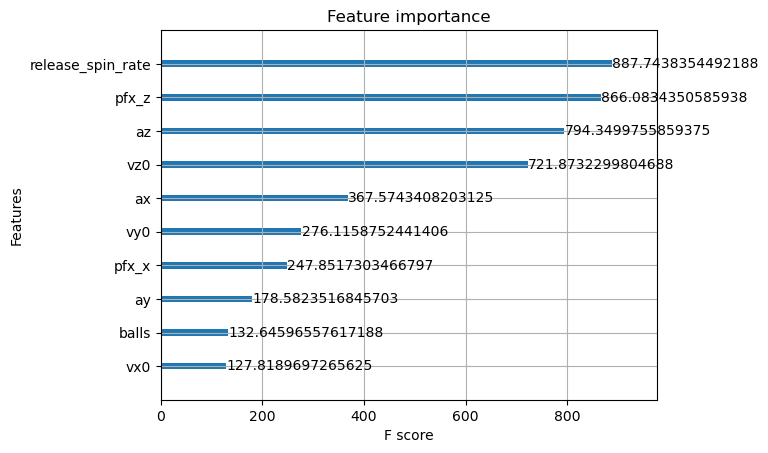

In [25]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

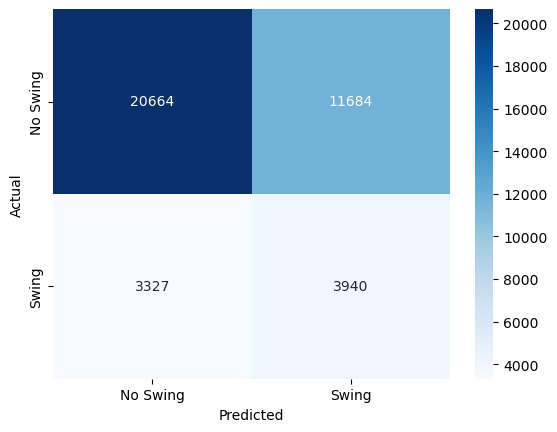

In [26]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [27]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [28]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [29]:
y_pred = final_model.predict(predictions)

In [30]:
testing_identifiers['xwhiff'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_2624\1564655570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xwhiff'] = y_pred


In [31]:
testing_identifiers.head()

pitch_id_raw    xwhiff
0  663364_455139_617228_4_75_10  0.496899
1  663364_455139_617228_3_75_10  0.509795
2  663364_455139_617228_2_75_10  0.498187
3  663364_455139_617228_1_75_10  0.497390
5  663364_593428_605347_4_72_10  0.506465

In [32]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/whiff_2022&3_xwhiff.csv")

# Offspeed Model 

In [33]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


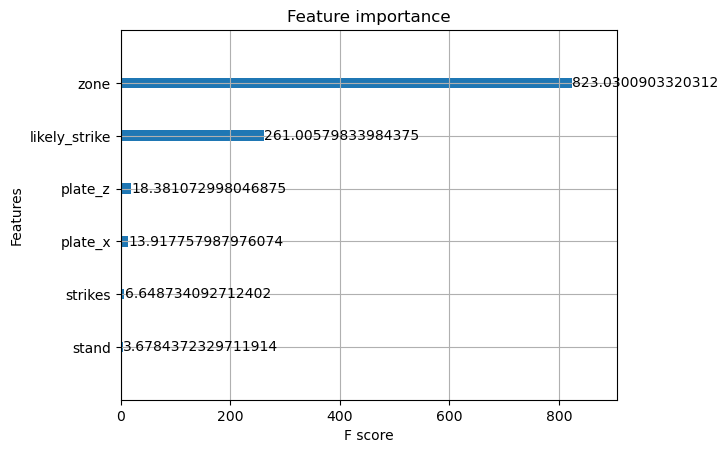

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

half_inning  Unnamed: 1 pitch_type   game_date  release_speed  \
1   716352_1_Bot           8         SI  2023-10-01           93.5   
11  716352_2_Bot          46         FF  2023-10-01           93.5   
28  716352_4_Bot         111         FF  2023-10-01           92.9   
37  716352_4_Bot          87         SI  2023-10-01           92.2   
39  716352_4_Top         115         SI  2023-10-01           90.1   

    release_pos_x  release_pos_z    player_name  batter  pitcher  ...  \
1           -2.60           5.68  King, Michael  677951   650633  ...   
11          -2.82           5.71  King, Michael  669004   650633  ...   
28          -2.66           5.89  King, Michael  669004   650633  ...   
37          -2.76           5.67  King, Michael  672580   650633  ...   
39          -1.27           6.14  Greinke, Zack  643396   425844  ...   

     deltaRE is_strike  pitch_type_dict  likely_strike  prediction  \
1  -0.028510         1              1.0              0    0.781290   
11 -0.038179         1              1.0              0    0.495411   
28 -0.038179         1              1.0              0    0.782323   
37 -0.111258         1              1.0              0    0.813712   
39 -0.043952         1              1.0              0    0.584764   

    probability_added  Unnamed: 0  mlb_id        mlb_name  team_name  
1            0.218710        4412  669224    Austin Wells    yankees  
11           0.504589        4412  669224    Austin Wells    yankees  
28           0.217677        4412  669224    Austin Wells    yankees  
37           0.186288        4412  669224    Austin Wells    yankees  
39           0.415236        1898  521692  Salvador Perez     royals  

[5 rows x 113 columns]

### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches